# Detection of electric utility features and vegetation encroachments from satellite images using deep learning
> * 🔬 Data Science
> * 🥠 Deep Learning and Object Detection

## Table of Contents

* [Introduction](#Introduction)
* [Necessary imports and get connected to your GIS](#Necessary-imports-and-get-connected-to-your-GIS)
* [Part 1 - Train the model and detect electric utility features](#Part-1---Train-the-model-and-detect-electric-utility-features)
  * [Export electric utility training data for deep learning](#Export-electric-utility-training-data-for-deep-learning)
  * [Load RetinaNet model architecture](#Load-RetinaNet-model-architecture)
  * [Tuning for optimal learning rate](#Tuning-for-optimal-learning-rate)
  * [Fit the model on the data](#Fit-the-model-on-the-data)
  * [Unfreeze and fine tuning (optional)](#Unfreeze-and-fine-tuning-(optional))
    * [Unfreeze model](#Unfreeze-model)
    * [Optimal learning rate](#Optimal-learning-rate)
    * [Fit model on the data](#Fit-model-on-the-data)
  * [Save the electric utility detection model](#Save-the-electric-utility-detection-model)
  * [Load an intermediate model to train it further](#Load-an-intermediate-model-to-train-it-further)
  * [Visualize results in validation set](#Visualize-results-in-validation-set)
* [Part 2 - Train the model and detect trees](#Part-2---Train-the-model-and-detect-trees)
  * [Export trees training data for deep learning](#Export-trees-training-data-for-deep-learning)
  * [Load RetinaNet model](#Load-RetinaNet-model)
  * [Finding optimal learning rate](#Finding-optimal-learning-rate)
  * [Fit the model on the tree data](#Fit-the-model-on-the-tree-data)
  * [Save the tree detection model](#Save-the-tree-detection-model)
  * [Visualize results in validation tree dataset](#Visualize-results-in-validation-tree-dataset)
* [Part 3 - Deploy model and detect electric utility features & trees at scale](#Part-3---Deploy-model-and-detect-electric-utility-features-&-trees-at-scale)
* [Part 4 - Near analysis to find possible vegetation encroachment near electric utility features](#Part-4---Near-analysis-to-find-possible-vegetation-encroachment-near-electric-utility-features)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction

This sample notebook demonstrates how to efficiently map the electric utility features and trees in the imagery with possible locations of vegetation encroachment. Satellite imagery combined with machine learning leads to cost-effective management of the electric grids. This workflow consists of four major operations:

* Building and extracting training data for electric utility and trees using ArcGIS Pro
* Training a deep learning model i.e. RetinaNet using arcgis.learn
* Model inferencing at scale using ArcGIS Pro
* Proximity analysis between detected objects (electric utility and trees) feature layers using ArcGIS Pro

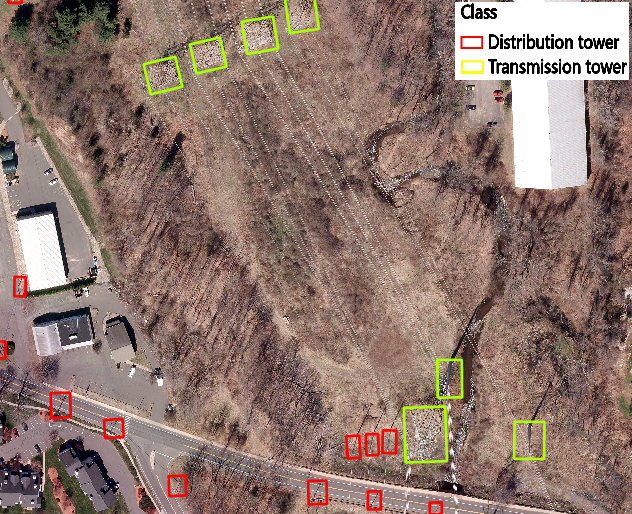

<center> Example of electric utility object i.e transmission towers, distribution towers, Sub-station detection </center>

## Necessary imports and get connected to your GIS

In [3]:
import arcgis
from arcgis import GIS
from arcgis.learn import RetinaNet, prepare_data

In [4]:
gis = GIS("home")

## Part 1 - Train the model and detect electric utility features

A electric utility feature layer consisting of manually labelled features, which will be used to define the location and label of each feature.

<Item title:"ElectricUtility_data" type:Feature Layer Collection owner:api_data_owner>
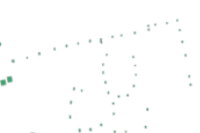

In [5]:
electric_train_data = gis.content.get('8e703649c43041c1bb4985b16788aa44')
electric_train_data

### Export electric utility training data for deep learning

Training samples for electric utilities were manually labelled for **Hartford, Connecticut state**. The training data consisted of three classes i.e. Transmission towers, Distribution towers, Sub-stations.

Training data can be exported using the `Export training data for deeplearning` tool available in ArcGIS Pro and ArcGIS Image Server

- `Input Raster`: Imagery
- `Input Feature Class or Classified Raster`: feature layer with labelled polygon
- `Class Value Field`: field in the attributes containing class
- `Tile Size X & Tile Size Y`: 256
- `Stride X & Stride Y`: 128
- `Reference System`: Map space
- `Meta Data Format`: Pascal VOC (Visual Object Class)
- `Environments`: Set optimum Cell Size, Processing Extent 

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAA3MAAALQCAYAAAA6timOAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P1nQFxZmiWK1vtx3x13p6f79dyemZ421W5m+s60m5nbpqq6bFaaykylvJDwElYSAiE8wgiQhDzII4+89xJIQhIC4b333kMEEUEYggDW+74dERCgkMvKSqHUPlmrUJzt99nnW3ttd76Ht7z+blcFfpBUPoUfJlfgn/dVzbgnkExue81uP9xbKX7/iPz+kO+/IX5E4X/EYWfHbQG7cfr23N4GogwirhfzYBfWMPsqKVz5N4IfUVzfRFneFFx3b/w8vkYY4ZcwO93Z4Hq3d1/iHePXbIv8zv9wX/W7xV47dukbgLBplvrhv/Zgbf9cD+zf+luA7SW9I2abM13Ps+NgWMNY/bwXSKby7a1+Pah8P0giJPO/reBnZqkTdhd+ZsX/hmC79bc7SvE3OyuQWVKH7wWU4HsbJCQkJCQk5jjWFiHwZhvGh7vx37eV4kFhrUWF2b/eWsy1Njdj1/1q7EmTkJCQkJCYm9h+twq1Ta1QdLWaxRwR5P8nREJCQkJCYm7je/5FCL7TgQlVjxBz6QXfsJh7Wkyk6FeM7wVISEhISEjMUfgWIr16EF1tzVLMSUhISEi8N5gt5u7nVVtUmP3r7cWcJEUJCQkJiTkOJsP02iGzmBODkEUk8iQkJCQkJOY4fAoQdLMdk1Yxl1tlUWH2r68n5gKJKIMlJCQkJCTmKNaRmKsxi7na+kY8b1Yir00lISEhISExp/G8VYWWQS3UA12/mZm5Z6V1+K3ocvxurISEhISExNzEv4goxeP6IXSSmGtqaoLJaMCEySghISEhITGnMUkYM45C2df5m5mZY1IcHdVjbIwSkpCQkJCQmKPQ6fWCsxj8b8PoqISEhISExHuB36iYk6QoISEhITHXIcWchISEhMTbQE8wjY9bVM/Lr1Gj0W74bxJSzElISEhIfNCQYk5CQkJC4m3AQq62rg7pDx7gUUaGXTx4+BDDw8OvFHTsxhfHZ89tktzGyY3F42x3K6SYk5CQkJB4Z2ACY7J6FeyF+yYhxdwcAHVaxidNwIQRRqMddwkJCYk5BL4uXLiA5cuXY+XKlXbh7OyMjs5OjJlMduNgsaZQKHD+/Hk0EP+MT0zMcNPqdLhz9y5ycnJmuM2GFHPfUYwSGY7auS8hISExV8BC7dbt24iPi0NiYuJLoRkZEZ19e3EwmPSMY2Pi79u4WfHWYo7s68T4GAmPmZgwSbv7dTA6ZsSoQoXka/VwfTiE1pExmKSgk5CQmMPg68rVq0K0rV692i48PT3R2dX1UjHH3NQ/MIAAf39s3rIFzS0tM0TbpcuXsdrXF9evXxfp2Ya1xbsXc0SwJjLk47PAp7PY9S/xWuh0eig0emj09t0lJCQk5gL4OnbsGFxdXeHl5fVSqNTql4oxJr6KigpERkaiorJyBhHyrF9NbS02RkWhsKgIE5OTM8Ja8aZijoXaGIk4ZWMPFh+owh9trcJfbGNU4g/iauCVMYh+jGFsVjiJV2PURGKuT4HVuwrx/ZM9qFaPUT/Avl8JCQmJuQAejMzIyEB8fDy2bdtmF5s3b0ZvX58QbfbiECBuKy4pQVBQkPDf2tYmxN/FS5fg5+eHEydPvpIDGe9MzJk3Do4Beh2qO1XIb1WhoM2M/DY12tUGGKQxf2vwCGf14zr8m4gyRFYbQb0Ku/4kJCQk3jX4OnPmDLy9vbF27doXwES2fv16qDWalxLZGAm2NiK/KBJs4eHhqKyqEiLOup9h48aNQug1EifZ25PAeBMxZzQRXymGsfVcNb4XX4+DtSr0a/ToG9ZhcESH/OIOrDnfjmeKMUxKu/v2MBigGtFDoTVAZ89dQkJC4hsECywWTS/DKwUYgS9eZnnx4kXBUbwkckSrFWAe6enpwaZNmwQ/GSk+e3EwmNuYx3jAMSQkBNu3b8fRY8cQGBiI48ePi/hel5d3I+Yo45PGUTR0KHHgVhN+drAG/3igDj8i/PhQHf4iphILb/ehnTIvl1q8HVjMtZa1Y96pJqS2jsrRTQkJiTkLHtnk5SMHDx7E1WvXZuAa3Wei5NHNV4k5Bou0+oYGxMbGIjwiAlXV1airr0ckCTkWedU1NS8VcozXiTletm5SqZCUWonvH+lA8TAJO15SSfdtwXu9Zi+zNPESzEkLxo0wznLXU5hxHti0+iHwt4Ns/QjOpPsTZM+N5Dbt1/gCR/LMofj2EIHDiD1oFjeRlm1+CPytItvwVvBsma0/zvtU2WbHMz6r3JTfGe42eXiZ29QAr00djbGAJnexescmzPisMjO4XkR5LZigeGbHJyEhIWEFz5g1NDaiublZLG+cAv3mwb+BwUGy6y/nHb7OnT+PS5cuCd6w9WtdPrmJOMk602YbdjY4LCMvLw+hJOg8PTyQmpoKhVL5yjxY8U7E3AQZ4vbKDvxybzX+17leVGq4UsjoWtDXMYDT+UNo0sjlll8HYgSZ6pGJ3567hISExDcBFkivul5HYHwdPnwYaWlpYgmkLfjqI7Ll2Tbla04DY/DyShZx27ZvR1R0tMDWxESUV1QIN3thrHidmDONGlD2vB7/KqoW8XU6ITBm+3kBlF8WOXV1fTiQ04eDhEtNGmiI06wHfPDgG0x65NcNYP/zPhzOJX95A7jVrReCRIgQ9q9U40b5IMoUoxjoGsJe8nuI/B7JV6BJT/mz2HoT5b2ycQgZXTr0ditxNr8Xx8qHMURuQgSO6fC8ZgAHbNK612uTlgWTJBI1A0qkUJ6FP857gxoKSsvIeR4zoLy6T+SZ3a62asVKGhZ0okwGHQpr+kU6nM8TlSpzHthNr0NuFblROHY7Va2Ckso4rtOjvHEQt6iOhvRmAdbZNoQbtWr0qLR4UtqLfRTmSMEQakeMoh9hzS8L5pGBYVwupDjJz34q18MWNWopvG18Vv8SEhIfNphPnufkYENQENzd3eFB4skK/s0DgWXl5a+cEePrmxJz7M5LKS9fuYLg4GCsW7cOO3fuFKtLXsdfjG9dzLE462/pwWdbK/DV3SFoJ8dfEB08oihG62yMNY96TvCIm1X0TZiJwzacgYhihh/COMU14zhPFjrkh++P8UifjV+TjT89PRSOi5fLiJFVcueRvqk06UFN2oTlOMfsiCeOxxreiknTtLsYTbRx4w30tuGtwsyKcduwPOpoz81GzHHZmVwn6LdtWQTsjFi+UM9E6jzSy+WzxmfrX0JC4sMEExcvCzmVmoqzZ8/OAC+dPEN/eUbsdWSYcuQI7t69+4Ibh+vs7ERERMQbiTl2Zzx8+BBr1qyBr68v7t+/P+U2278tXifmDLoR7Dlchv9yrBMNlC9brngZTOMjuHK/Hb9Krsbya21Yc74Of5VUj+gSjXAfI3utVmlw5WYjfpFSj/kX2+BztRXOF2rxp4nNOFmhwjDZX66Hydp2/GFYET662IXA663wuNKK1Tca8T8iKvCzcz2oJbstRJRKhe3HKvEnyY0Iu9sO38ut8MsYQD/ZejUJwgvXG/BTSmuRJa0V52rxF9uacbZGDRWlxfw2Nm5ASUE31qZU4x9Ot5I/8numFv90oQc1JCYnTSM4fbMVn+6rgeP1NqymOP6S0ttRpYWJ6lk/osO9tEb8lNy/tKTzydFWVI7SM9DocONuA/55f60orzeV47PjbahhzqdnvOlQCf7gWDcq1Wa+yrhWgf9veCWWXe9AEMXjRfX4ydZy/PRyN4rVVGauZ+oL9HUqsCG5HP/9UCPcr7Rh5YUWOB6pwd/GF+HPT5jjk4ObEhIStmABxXvVeOCPl/ozb/j4+IiDSHhlx6tWczD4+ibEHPvl8HyYCm8vYA599uyZWHJpPRTlZfu9rfjWxRyPHN66Xol/t6MJd4bIgM8SL/bAo3mjRHr7Ltbgb5Lq8PfJtVjxVAkNuVnF1SgLmEEF/M424H8m1+Ef99bibw83YUv1iBAkwg8R3kBVBz4mgnrUpsXF9Cb8jz21+Md9dURwHSiidMTGdSbF/iGsP9uE5EYtHqY34G/2NsDvmQIjvOSDxU1HH75MobzspbQoP399sh3XO/UzRmwFuY5okHKnCX9tSecfDtYjsmxEEMvEpAndNd1YnlKD/8V5TiFC5FHfcbNoYrHWW9mBjw5SOCrP3+xvwuZSFQwiD0a0lbThR/vNZf2bg83YX6PBKIkufWM3Pj/RhBOtRLwUx0jnANalNmJXvRZPMhrxT+T/f+6pg9fDAbQbp5escD3rlRokXaS6s9ThP53pQlF5Bz491YKrXSQ8JSFKSEgQmLja2tuxe88eMZK5atUqMarJfxnHjh9HX3//K4UUX9+UmOPRSx5J5T0KvLQymgg6JiYGRcXFv9bMHPOGRjOAhVHl+Of7CsEnU4N6lKepgS8G2WYesBwlu1qa14A/Ca1BXJOW3HgGcxRP0uvx+1ubkaE2YMKgw827tfiTLXU40KyDSfgx0f80OHGmCv9+axOuDlAdTZCwqe/AH0SX4Ld2NGJ/O3GE8GtEe1U7/jqkHD/KUJj5Rq1G0tkqfC+yCgkVGkucJGR0xHc3avAnifU42qanu5a0xtQ4eLISv7ejmfiY0iK+GGzsxA+iS7Ho4RB6TOyPYNKhonsECq0Rz5/W4Y8j6pDUYc2HAbdv1uA/bG9DCfFDZ0s3/im8DKuyVRZ3E/p7SCwSrzXXdeLvwsuxrkA95dbXo8IQ531YhU3HyvGnqb2oYTFH9fj0NpUltBSf3RlA79gE+Z+Aqq4N/yWsFO6FxKOUXxO1jciUCvz1kXY8UfLzoHjpGRXnt+HPQ/Lw38+Z45NbDiQkJGzBnMIiq7SsTCzRZ95i/ngTIcfg69y5c7hKIoz983oS25UlzFtxFN+rxBzngffE8YwcCzleWqnSaMjSAUVFRWLmkAXdq/Z8M75VMcekOKJWYs22MvzT1X4Mk/CwnRkykrHl2S0Bi8DgMEpFP5ZsqsIvr3Qhf2AEtQ1d+HxHJb58MGxZfz+KyrJO/DK2DAsfDOB5pwaVRBC3C1vxPwKr4JutwBARH+8t6MltxL8ILsFfHGrG+udDqOvVoLynF8uiy/Hne9tRZCJ/LAy7+vDRlkr8+a4qBDwfRkmnGvVDTIIGPH7UjP8VWwHffCVKujSo7lci5V4D/jSoBtsbNdCS0DKRSO3tHoD71jL86EIn7rSPoLJLjezSVvhnaqiG9MjMbsVfRtcgoVSBil41Hj5vxH/dWo899UySJlTktODvNhHxFQ2jokeD+yUDuFQ6ADW5FT5uxF/GVSK8XI0qcruZ34cbNQqoWMyVtuDfRpSbD0Ch35rGHnwUX4TvbayAd+YwlXeE8tGDzxNKsYAJe9RMdOphJQJ2luH/obo53zqCak7zAXVIYorxL6KrsKeJ6uUNxLeEhMSHASYoHn08dPgwfH18po5jPksEx/vcWJDZC2cFXyzm7t27J0jNFhx3V1fXG4k5JjmeBWQRx/4bGhrEaKb4HRkpllq+ighfK+bUffiERMjPHg9PD9hxfkisuu6vxd8m8QBZDX52qQtP+7lcakRsK8fvn+4TqyKIfIjgSWS0d+Oviae8S3VQDSrgtrkUH98dxAjZdOtsn4n8DnT24CcxFXDLGqbQJLpYzMWUYjFxx8TUgCHZd+K+K1eq8DtJbWim/LCY23mqHP/2cBeKlZQu2XXmVUXvIBwSyjDvwRBYNlrT4hUqPa0kvigt3zwWXwZcv1CN30lsRpGBRKCFhzktsZplbBir48vw3y4PkF8Wnlwu+tvYgT8msRtep0d3Wzd+GFwOx6ckMMnPuKVMEyzmiLv/d1A5PHO4XOYZTnYTyy/tiLmMm1X4rcRGXB00c4+e8jFhHIJbXDn+4vog5cGIxvIO/F10JWKrqRapblhoi8Fdii/qcOlUfFLMSUhIzAbzCnNDbm4utmzejBISdq/iClvwxYef8KAhz6axsLOCvxt38uRJ+Pv7o72j46VijjmS9+7xSpJTp04J3rT65b88c8hxnL9wQaQ3O7wV37qYG1b24ufhFfiCRIXtLJZep0MTCatqQl3fCFqV5qP1jUYDUo6X4/v7OkBaWYgTJpHOvEb8XmwD7uqICPoV8N1Thh/f6Ec7CRPe/C0EmVGLK7dr8fs7W3Cv1wBeVtib34TvhZThl7cGoOQRTyIRJilVWxf+ZmM5fvxAKeJHdz8+2V6K76V0oUdr9sMbsFUkjH5KpOiao4KKHgJ/RkGkpR9G/LEKfP9YNxo0vP5fiyOp9PtQG/JHmIjIH/kVIpX+DrQP4EsSau7ZSqJPSo9h0FGYSvztmV70QYtDx6rwL/e0o1uQNoXnsAY+NECNhOQK/F+HuqDmWUIql4jXwCeAGqErb8W/I3KOqbGIuaYe/GJzMb5/oQ9dVJYJUTcjSL1ajf+Y3IbsQaqbMQPuXavC7+1sQprY3G/OL5PtubPl+Fdx1djXzPfNz0tCQkKCwYTDG8UPHTokvqlz9OhR6kerXivkGHylpKSIkc3BoaEZ4I3fdXV1CA0NfaWYY+Jl4cZ76/jUSh5V5TwxmpqbxQxdCMXBB6S8jKRfL+b68Tnxxt9f7QdJ1OlBSMFbI2jsGcbR6zX47a1NuNxF5RruxWebSvF/RFXgz7ZW4U8s+LPNFfhX4aVYma9FT3c3/t/wSrjlqcVMkjU9FjbqQRV8E0vx85v9xAXEDSTm/jC2FGtLiVvY1lv8jk2YkHWvBr8b3YB05gkSc4knq/D3V3rRQmKMOYOXc7a3duJvwquwpkgzMy2y88N9SiEqf3V/iMqmRtyeCvy/14YwYpOOANX/aB8JtchS/J/EL39uW66ECvzLyDL4lRKXaNQ4TIKQZ9R+i/jkUodWxGUVbLtOV+F7YaX47V3NuNVjdhOzinbE3CMSc/9+eyPSVebfLCrHTAr4kJj748ss5vR49qwJv0t9gXM8Y0lcKPLK8VEbjKe+w5+k9kgxJyEh8VIwt7DdVxLn6Kkf/aqBQ1vwio+S0lIhtHhmzR4ukNgbUiheGSen3dPb+9IBUB4wfd1BKN+6mFMqe/CT0HJ89phEk5VU6L6muxdLk2vxv5Jq8IdRxfitfW3IHCDhouvHl0QSf3qmExl1CtyuGsLtGgXuPWjAvyOyCKwioqrvxN9FVSGiTI1xmyUwPGPXWElu0ZWIqVLDSG48M8fC5EALEaSNMBmlB3jweBn+HzL8vRYx9wuqmAVP1dAQgXCckyS7sp424fc31eNil06MKFrDT2AUOY/JLbYOl/t1UA8PYQURzlcPeXRy5t60yXE9Cota8B/DquDzpB8ZteZypVcMCPL5tzuaka4cQ9HDevxeYCWCKxQo7NWJvXVCPE7okc4dh6BqxNYqUdavpxon4may4kZpR8z9JL4MqwqoLOQ+yqQPHR5lNOLfxTXidheFNw7Db2sZ/upiHzRUT9b88r7F3nxznUkxJyEhYQ9WQcWijEcZrSOLrwNfPIIZHRODpKSkF8AbwHmm7VXf2OG0eZP49m3bxOycbdr8bxZxO3bseOEbdLZ4lZgT0OmxP6UMf3KgExU8CCiEhRljRL58sMiDh3X4T9ubcLXbLOY+2VSGH6cPQ0thlSMWaA1Q6QyC87q7ut5ezJUYzIN61rQpL09v1+D/FzVTzP3D1T60jr6lmEsbgtY4CJfEMvzdLcWMPesCzB293fhBdDm+eKrCKHd+bMqlpnJpDcSlIt4xNJR34bOd5fgtEn//7mQ3BvUWt/Ex1JZ04OfbzW7//nQvhinul4m53yUxd3/YRsyNKeDNYu6KWcw9zWzEb29qxOWOF8Vcwgkp5iQkJN4MbyribMHi73WwF242WMS9LH2+/7q8fetiTq1SwCGqFD+43AcFL7SwurMxFzNUOly5U4P/nERibpBEEhHe/ySD/yfJDVh4qhFfnbQgtQlOF1txrVuPyrIW/H5kHZIatNPGnMAHd/Q39eGXG8vgUzSMERI2vRYxN1uYjOpJzB0pxZ/u60AVr7nv7sPPEyuxplRDBGcVQFrcuFOHf721BVkkoGz3j5kmTGgoaMV/Ca1EUrcWvZ2d+EFMNaKqmWCm/TGJY5SE1ON6/G54Bf4hpXFmuU41Yd2DPpSqqC4GFQi90YL/EV6A342vR1zJEIp5Fo0IGL2DWHu5Gf81tAD/eVsDtpQrUaM0kFA0QvsSMbcyf6aYe8hiLp7EHNXh5OggFkSW4+/TFDPqkAm9J0+KOQkJiVeDyYjF0tsQIoutltZWFBYXi+UkL6C0VOxnsCuwbMBp8y4Fe6Oar3Kz4nVijk+zbMhrIbtaibUFIxSbWSiZ3cmeGrVIf1SH32cxxzNzvMySxMp/OtXLQ3k2HxE3ChvNWwmGB4ZevcwyugKus5ZZOuRO8wkfroUxDbakVOB3iLda+Ld1Zs5GzL12mWVLN/6R0jIvsxzBrv0V+K0DHejm5feWMooDwcivdZnlf73ULwYXbfmby8X/NtK/OV7BdZRW7ZMG/C5xy+Ym4nMejCQIt0kTykkA//bGSuxq57x/HTFnQN7zFvzn6Bocajbzv3mZJcWnHEbI/lL8GYlFKeYkJCS+y/jWD0AZ0+lx9Xw5fnt3Kx4Mk0G3NbBMRqMjOHejBr+fbJmZU/XiFxvL8Vk27zMzb5ieCQNqqzrwl1E1iKsiPzZLN3n9fHttN/4pqgKh5SoYLDNz/zq+GofaKOwMYaLFtr1EUse60M7xWsScb4mtmNMj42Ej/j0JoFs9OiKs6fDjRNglz5rxx5SP03069LV34L9HVMGnmIjfJk+MSZMez3Ma8Z8SGnG6hwlvVrlIgDEJ64n0Jul3S3UPIq+34C8iS7Dw/iCUJv7QIQkr8ldb0Y3gy034g4hSeGQqoSFRafhaYm4A8yLK8Q+8zNQmvyzmhgqbpJiTkJD4jYBFFs+uvQr2wn2TeJ2YEyOjxF0Xrtbir3bWIqxMDcWY1WbzgRsG3E+rwb/c2ohLHQayoWMoeVqH3wkmXqrVEEuxjSeYtLhXr4JSR5yh55Mda/GnW+pwsFlPMVl4wKTB0bPV+P3dLbjH++94JpDE3H+OLsG/TmrG4wG23+x3FFVZbPsr4FWopnqk+3bEHPOqyXIAyp9uq8exNs6NOa1Joxr7TlXhD5Nb8WiQ0zKhobwFfxlUisUZiukDUPQjeNymRp/WiKz0Gvx2eB32NI+QnLO4G0dwq04NncGAPhXvWac6EHUzgZGSFvxeaAW2tBjQT27VfdNuwwVN+J2wSuzs4Ly/rZgbEHWj6R+C184S/OXhLpToiaM4P+MG3HtQj99dl4+/Oi/FnISExHcb37qYY3LpberDT+KK8dm9IbFvbWoPgEXMnb9pmZnjk7yI/LYml+IvjnWjj8corXGRXx4J5GUi6q5BOCaWYT6Rj5JPtxJ+KC4STU+eNuD3iWAvdujJwBvRm9eI722sJPIzn3IpjtonEhxt7sSfxZThq8fDQkC9KObMS1p6qjrx97EVCKkaEaN/fF/k2zSClAtV+I/72lGuos4BEdOaLcX4Xxd70Emkb91ILvYGkPDraOzFT6LKEVCi4vHN6WWN5M6jmnqDeYSWZzNNvMHcoMWRU2X4D4fakTtMv0lwsRt1dYARNRIOl+L7p7pROWLCWOXbizkm4017KI6jHaix2fhuGtfh4ulKKeYkJCS+s3idmGOwbR4b0SHteQs+PVSPxSdb4H21FZ4E34tN+Oct5fjbs92o0vAMFNnOkWEk3azH9zdU4qsbbWa/qY1wzxzCIIk5Xv6oUWuQerke/7ivFgsumY/xd71Qhx8caMO5Rg1xjpH4ySzm/jCmFP/zRBs8zzZRmm1YQ/7+c2IN3O8PYIDstfXTBIkpFfi7C71osplZM1Ja6mE1jlGYv99fi8WWtFzO1+JHB9txuVkjBj95T/bEhBbpj7vwaUIp/vEM+bvWBq8jNfjiXj8aR4ifNEokXKzF90OrsNCmXJ7PlTCYDKho6sSXW+vhfb0V3tda8fHeWqxOG0An9Cis6cCXiRY3CvdRci38Hw2gjdK292mCh1cq8DvxDbhlK+ZMQ3CNLMEfXegnPjJigoR0S3M/lsdX4h9PNmEVxbvqcivWnGvETxJL8ZdnpZiTkJD4buNbF3MM/o5cfVk3PiWx898vkaEdJlHChpZFkUaNpDMV+D+S25AlxJwRzeXN+P315Zh3px9dLOjIn3GgHz5pQ9CRceeZrqeZzfhvkRUkjtRQkfv4uAFtLV34Id1zeDyEYYpHCEk+AGVDMX57dyPOtpkFnkkxANcd5fjdvW0o0bKIItFCYu5nWyvhYyPmhIAcG8HpK7X4w9ga7Gkxf1diclKP/LwW/GlENWIr1dBTWlyekrIW/Nd1pZiXPiAOZmFiHazqwDqerTNosJ/E378OqUVy6wh0lI+JUT3yqnuwLZ9nITU4kj2A5n69EHW6IRWCdpfiB1d4D4UGB58OoHfYIJaSanoVWEmk9dn9QfSR8Bstb8VvRVcg2kbM/TiuDO4k5tSiLBYx96gRv2XdM0fpt7V04H/7l+Gz2wPooXrmg1LyHjfgP4YWSTEnISHxncWbiDkG23sejOtsV+D0814czDV/VJs/fn24cAhFAzqYLMsgWVyZxrR4Wtgv/DD2Px9E3YiB3Mx+xIe8DVo8t3xEW/jLH0AWfyaAB+w4XauYiy2Df6kB9bUUD39wm3C0Rg0l5ckq2qwfDU8nThkmOy/CWyDS0muRWTn9we6UggHkKGzSEmDeID5oGsARa75z+pHdqyMuNMczahjBw4J+c7kJB3OG0Cw+KD5KmkyN23l9OMBuOb1IKVNBRVzCAlehUOEm3Te7Uf4rVBjhAViK12Tno+Fd7UO4Wq1EBx90ZsnfqFGLvIpB3KQy8sFfPCDLHznv71LiHKXLHzFPKR5CbbcKO06X449O9qBKJcWchITEdxfvRMzxevkxIiC9YRj7LtTjv8VW4I9IOH2f8CebK/Bv42sQUjgsBA4b8HESaxW1nfhpeBn+UyL7I/8JjTjVrxOzUwweNW0v68BPdlfgP22uxB9vqcAf76lDVCkZfDLiwg+hO68R/yahBtHPhuB3sBz/kfx+f3M5/sPpHnRrDOZN3yzmevoxb081AsvMYs6ad46H/5ZnNeEvEikfWyopL+X400PNONWoE4RhJUX+FlxLdS+Wkgj795wOle/PEutwuNNA3MmCU4MUKv+fR5fjD8ntD+Ir8aMTnSgh8mYxt/9MHf7LJioHuf2HzdX46lYf+nj0FSpsTanFn8WzWwX+7801cHkwgCESWlwPuqo2ylcVttYxKZOYa+nF59srsKZo5szck6fN+KMdzbjfQ2KOCJo7IU0NlN+tZfg9Ktcf07P4yc1+FD5twL8mMZcsxZyEhMR3EG8q5qwQA35kW2fDduk9wzzYZ+vHPKho64cHCScmbP2YZ6Wm3G1m5lYXG2b4YxE2+6ASHuDjE51thZwVnJ/Zab3sY9rie6oz/E3HKUStjZttuV5w4zxawomloC9xm0rTwvv8W2wnoPxO7zlkUJ3SPesePSt40HMqXl6xMqTE2uQKfPFgEP0U78w4JCQkJL47eDdizgKrwHrhPsHWwIt7dvxahZUV7D6bwGzv8b+7LQeg7G8hg29DvC+L3z4hvj4tK4Tf2fds/v2yMLZ/be9b/c52mx3P7N+2YW1hzx/fm3In8uU6+zdxtTjaSXUmRzclJCS+Y3hbMfetYmpmzizmXhCDHzj4JGo+TZNX6bDg5BOfMaFHYUELvh9di918MBqJRnthJSQkJL4LYDH3VyTmIm69AzH3bYNFilXMySWDL4I/tDoxY7STSBF6XDxdhT/a14n2GaeySUhISHw3MKfFHNnlydp2/EFkMTwKpZibARZuCgV8rrRgU+4QyjvVKOpQ4W5JK/42qBJujwbRz7vS7YWVkJCQ+I7AKuZi7kgx90GDZw97WgZwqFlHT89kgQHZz1vw5xuqsKZaI2flJCQkvpOY02KOZ5va+7A8tRHJ9QaxT8yuvw8Uk9Dh2fMOzEuqxT8eqMMP99fhf6c0Ibyc957bX24qISEh8V2CdZnlw7wPRcw9r8f/yd+1aZJizhbcQWirb8NfxtZgPnUa5p1sxIJTtfgP2xqxJ0eJwRkb5CUkJCS+O5jTYo5Bgo5PWZ6UnPUC+AAUsdduahDSDP4unjitWkJCQuI7DhZz/4PE3MXCGrJ/L7++E2KOMaJQ41mLCm0as7iz5+dDhc6gRXmtAreqFbjDqFIgvUsrjseWy1QkJCS+q5jzYk5CQkJCQuIlYDH319tL4Z6aY1Fh9q/vjJizfp9OLlWxD94zx/UzBTkSLCEh8R2HFHMSEhISEu8rrGJu8d5iiwqzf313xJyEhISEhIQNpJiTkJCQkHhfYd0zd/lZtUWF2b+kmJOQkJCQ+E5CijkJCQkJifcVVjGX9iEcgCIhISEhITEbUsxJSEhISLyvsIq5d/LRcAkJCQkJiXcNKeYkJCQkJN5XSDEnISEhIfFBQ4o5CQkJCYn3FVLMSUhISEh80JBiTkJCQkLifYUUcxISEhISHzSkmJOQkJCQeF8hxZyEhISExAcNq5hrbGyEWqOx60dCQkJCQmKugflL0dPxmxNzI1qt3YQlJCQkJCTmCpirmLPa2tuhkmJOQkJCQuI9gVang2qwB3+1oxz3vmkx19LSIkc4JSQkJCTmPJirmLOkmJOQkJCQeJ/wGxVzTIpSzElISEhIzHUwVzFnSTEnISEhIfE+QYo5CQkJCYkPHlLMSUhISEi8j5BiTkJCQkLig4cUcxISEhIS3zZGjUYYx8amYM/P6yDFnISEhITEew1bMuR/2/PzOnxTYo7Ttwd7fiUkJCQkPkwwLzBndXZ2orKyEsXFxaipqcGQUvnWXDanxZwoqMmEMQu+rmKVkJCQkPjuwTQ+jkniGiYyJRHg0NCQ4JzxiQlMTE6+FRn+OmJOpEPgEzE7u7pQVFSEzGfP8Pz5c1RXV2N4eFjk8W3yIyEhISHx3QNrGZVajYcPH2LLli0IDQ3Fpk2bsHnzZkRHRyMsLAxJSUkor6gQnxx4E+0zJ8UcZ5yvUfr3wOCgIMfevj5BlHyxsLMXTkJCQkLiuw/mCBZy9Q0NuH//Po4dO4bDhw/jEOFwSgquXL2KgsJCQXBvyhdfV8xxPpibOL1du3YhMjISCQkJ4t/bd+zAxo0bER0TgwsXL6Kjs1PkR4o6CQkJiQ8LbPcZjU1N2LdvH7Zv345nz55BOTwMvcEw5Y81z63btxHDvHHhgtBBrxN0c07MMTH29ffjzp07orA7d+6cApPjeSpYXX29JEQJCQmJDxBjxBEa4pWbt24hMTERR44cwT0SdDwTlpWVhUcZGThz9ix2EF+wwGttaxOzdPbissXXEXNMsCzQzpw5g/j4eKSnp6Of+ItnBq1gkq6sqsKRo0eRuHUrcnJzxT3JXxISEhIfDpgv8vPzEbtpkxBpwyqV4Airu44EmXUmju8zFyXv3Sv0T2trq9BHtvHZYk6JORZohYWF2EqEd+DAATx+8kSQYE1tLaprapBLJJh6+rQY9bxx44YYDX2dWpWQkJCQ+G6A7T2T2p6kJOzeswcVlZViuQoT3wRxDi+5ZDAhsshiwoyNjUVWdvZrxdPbijkm1qbmZuwgok0hQdne0SHS5jwyl3GerGlaCfvJ06eII9HHo678Wwq67zqMMI5zoxzHmNGe+8tgxBg36IlxGN8qnITEHMIYW0RqxmN23D4wMC+0EHfFEB89y8oS/GHVL8wDCqVS8BW7WXmBeYR1zrlz57Br927BdXzPNl4r5oSY44xrRkZw7vx5sV6UR1h55HWUCsokyOCCcyE4w7V1deaZOipcV3e3FHQfAozmDtLoWxLbKIej9sFLdu25S0jMbZj3DcsOnZkMebn9Tl6hQVwxqFAIm8D3mUOY6Jgb+gcGxD12Y1GXm5eHuLg45OTkTIkqe3gbMcfxqym9PSQoefkk85J11JTTZWFXVFws9vFZw3AeeYaQV5ZsjIoS7u83d7FQMXfWZl+TJELmjs010rOhfI6/nAeM9FxeeU18nedEgkyvRnPWBRy8mI4m5SRMb9KpJc4y6RSofHgaKdefoUM9SRxmx983CL3RBBOLxxeuSYyPG6G3E+bVsNQ51duv1w4sYtjONWGy5//XBPcXXlYPVJa3r4ffIOiZcbOd/E3UwzcByp+hJUsMdGU2k138wDmMRdnevXsFd5n7stMDefzv2tpaODk5ib1yzCdWd/Y7RFyXlJyMa9euTfGdNawVc0LMcWZ5+SQLNB5N5YwyONNcAbbrSa33mbh5KQ0vs+E07BXu/QEZb+pkMNHPxAS9AHOnXKPC4L98pJCFk2lidhlsME4N2E64N4FeNYjO7h4otdQ27LjbhwEjyj509vRDrXubcF8XRN7jL3mOY1/nOZrjM5l+3TbwknxRm/uNiARqJ+P22sEcHGU2Ug9m/Ndol79ZUJvVqdHb04W+YZ0d9w8HbN9ZmPHI5f4DB15YlcEcwuLIfeVK3Lp1S/i3gt14Rmzbtm1oJ07i37ZxW/E2Yo7juHnzppghtN3PwH8bGhqwlXjp6LFjgrtmcxMLSs4Pb3jvI3E62/39AHXWjSrUPzuLmPWBCNywwYJA+AeGYduZPAxPzoX3agzjGELehb04easSQ3oSmbNsEIuFuvt7EB7sj/WBG7AhKBhh4WEICQ4SZVofGIiktKa3f07EhxO6QTzf54afucUgu/sNO95jJkDTidubl+DjtckoHfgNCRcrxqgClM24e3IbAuhZbrA+y/UBWBu9GzcrFNSbm3yLZ8l1Pozim4dx4nIB+rRfk2eovk0khhseHqFnEIQgmza2ISQc16voPfwmRS6LI003si7tmVkPgevhF56A1Nzet6yH3yCo0ZqUZTi1bRMuFr5oY+YEiFtHc/bik48/RlKOEeNzVXR+C2Be4OX/rFeUKtULz4t/l5aWws3VVWwv48ktnsyyuvNAIa9CYQ7j0y5ZL9iGZ7xzMcfExid/bYqLQ3Nr6wxS5GnHy1euCKHHp4HZhuPCc+Z5ZPTy5ctkLN5HQmSQONUPobmmHPk52WI5kEDWMzzNLUf7ENXf1xIC3yyYAEdU3WiorEef5sWZglEioJGhTlQUZCIzi8uQg7zCIhQW5CKbyvPsWSZyq1oxrDXHZRv2dWCROJQWi5996YCz1EYnx+37mwkiAoMaFSd88TPHIDxqf9NwXxPU/sZ0w2hvqEBu7nNRZvNzzMKzwkp0qPhQn7cZraZ2YdKip7EaDe0KaOm3fX+vAeXLSIKgq7mK8pUzla9n1L5yisrQpfqGZ33oWRlVvaiuKEGubXt+loWsylaojRPUM5kL7yrVy6gOAx21qKrvgFL39rO+v3HwiHTzXaxe8lMEXGimNvDhHvxkJTsWQLwHzp4g45PBHB0dcYU4w3ZPGv9lcuRDUni5iiBKi5st3lTMMbHy7BoTK582Zjsjx+KMOYkPPWHStZcOg/OXkpIi8vMycTmnwULFqED+mVA4e8TidlE7mhrqxMxoTV09mrsU0BFvcflffK/M983xvPhvgRn+bWDrhzDTfTrslB9e5jXaiNRwR6w/8BwDerw4sEZlUfW1or6uFvVN9ch/cASeXy1BzKkM1LY2oY7K1NJvHjC2jXs6vCUtK6z32e+oHurBLrR190Gls85S2fh7WTiDDsr+TrT1DEKjf/NwU+Ft3S1++O9sfwImqqOBUiSvd4fv7usorm9GPbXvRuKMjJt74PnpV4g49gDtasycWbSThvk+Ga6xdlyJd4ffjjR0ajncm9XXDJDbhF6BgiOBmO+zDQ+q2tBYb25jtZS/7mGu32m/M+IkzIzPcp/+bd+dwKJ2uBHnY7zgEnMKuXWtaKD06htrkfskBb6fzceGPRdRQ9r2BWFiidOMWW4vuM/yY7n3gj+ruz2MTWCi/wkil3+JLWmD0+HtwTbON8nbLHfrPVs/U+Gsf21hCcd1blAPor2jHQPq6Wc15WdWOGt6trB1n87Di/7mOljnMF88fvzYrr3ncpWVlcHNzc2umGM9xAOYPEDIg5X2Vpi8UzHHy4f4sBOekcsg1coF4vtcWC7MWSK6wMBAZD59+kJYBhewuaUFsTExglR5Y7w9f3MaTDbKPGx2n48lHuGIT9gs9gQmxMciensqcprpRR2ffqjvCmMmPdoKDmKt4wak2xFGvNxG2VKAs3ujEBtH+U+IgNuXH+GzZasRs3UL4mOjseviM3SRAX7bWSpuF6qqe0g6fAL5XeNvtlSFMGbQoiPnIpJOXUfN4Cwi+qYhCLEM+zY44nNXf8QmbMFmepZbtsTAP8gfwVEHkF3XjRESM28knpgQJ1twOmQFQlIKMaTn/Td2/L0OvGZEWY/TUa74ZMVqRCdspXwlIH5TLLYfOIminkmMf5P1wgKk7hpWLVkAp/XR1A64PW/G1i1hcPcNxp4D51DSbZhJ7u8C1IGbNA7gaYof3AIPoWLIDkG/a1DnYqK/EheOJ+NKYT90o+/eDrwrsA1gkcQHY/Es7wvuhEePHtkVcwwmv4bGRiRs3iw4wx6hvqmY4/TTHzzAoUOHxAZ25iFho9RqIc5CQkORmZkpBhit2wNswX45TFV1NaKiomYsqXlvYBFzBeci4B20H2Vi8sa2nNRWdRooBvswoBqBnjt2FI7Lqdep0DcwiGGtgfyoMDQ4DC3Vh1rRg66eHnT39GJIzXUyvUSPV4WMGUngDJCfbvbTg95+FfSUltmeUidPPwLlkAIqvQGqoV4RTy/Fre7Kx8FgJwQkPUB95yD66J7OWg5r/JT+mIneN4xjoPY2Nix3w94HjeAhOBOnoVVhUKHCiF6Lob4udPYOQqXVi3rQDveJ/HT3dBP6MTxijs8ctwHaERWG1VwHlvSozINDVGb6t2qwW2wV6e4dILHH7cLaDgwY0VA4jXYqnJ7zMKSCltq2csAcrofyoSaxZzuYbTQZodMo0Sfy1IOefgUJQq2oG7XO/K5Y/QpYuGt/kA8izhdCSTacVyvwc+QZgPbc8whcNg+x1yqgHGX+orQMeqrj6WfR0zcEjYGXPI9Cp9dB012Ck9HuWLv1OirbFaLOtSIcPUNRZuszVGBk9CUDiuR/nMRc4bFQOIWdQJ2BHsbEdBuzhhklO2nUqzHQR/GKMvdiQEGdYdsVFzo1tTOqB667/m6xWkeh1oo0ptITYq4JF+PWwm/fQ/SaKDmbeuitTEeMy68QdCwLvYZJ87JBev48O2hbFwNq/Yw+zoz8sZ8+aiP0rM1++H3gvCmpb0AddiW3W0s8Ks7f9DswAyzmBjIR47oY2x4OvcR+8KoES5yULtdN/zAPZE0PDrzwPPpmPo9R6kMNKxSUXz29n/3CT9+QmtxIOCjpvpZEBAm2HtH2ud410I/Z1rsGymFuszPj47auVXF85nCDlC+ekZ4uK78LOij6uD44f/1QkphRU1gF2Qazn/cDbOt7e3sRER4utgBY7b9ow/TX+u8K0jBWMaelsjJ3TLkT+Hrw8KE48MvKO7bpvFMxxxcfcpKcnCy+D8QFEo2SXjgmZp7m5lk3VqQvIzu+z4ehMLFO2iH5OQ/R2S7Edu+l2HyvV2zin754jT09eMu+hElbUUfkNiFuU6eE6oDt8QQ/fILZN1+TdjeejlE92V7jVO/T7pwehSTjNT4jrnF0PdsDb68oZPXzb17HP/OZjFI80/nvxWn/pfDY+gjmD0pMX5we9/n5YmPJz9tI6dnmivdczDDw5rtiuYmeDQN3dLnMRFxkc6euyVlL5sytbEIIOUGKVN9c/PFZ4SbI6M00mmwIZz6NcSJ7zgOHfWHtPPsdLMcBIsSoyyU2ZZ7ESF8tzkZ6wsljA25UKYWxE2HoZbTWg/WyCqtRdjA14nioEyLOVkEnKmecjCF1UmfUM1/UTuyRIYMJisVc9BpsOJ6FYUsIcU2a68Xqd/a+EW5PM+qSopqkMNPtgglt1nvJldpwE6udfHGqWiN8mS8jOkuzsNvnczgHH0bJIHeAp8PNfP78nF+sY9vnRQ96RvvgMZFJbv+z6ualy5OI0CaNg8g6EQyf8GOo4tFWO+8KY3beZj9/s5mdvmYuJ7b3PlGHaOo+dfbJv22eZww6UBjhNjWbSYadbnA7H6OwU/miZ/fingSTTb45X9QB4JeGOt0z/c1tsI1nEgwnMuwhUrRyAf+1ha2YY3cmO1t35hfmmqdPn8561814EzHH8TBpnjx5UoyQsrCzxv+UBFxQUJBIg2cP+EOw1vgYPKPYQ50hq3jj9HgvH8/gcd7spTdnQe/PlJjbsA/Fs5YCjhIhGXoqcDR0Aeb5H0LVgIE6J9Qppncu52QovnSKwv0GLTQ5++CyKAzni3JwJtEbHl6+WLV8Prw3HUFBp+Uj8PQ+jBo1KL93FlFrlsDdywfe3l5wWRyKa/UdUNE7Iexl+yOErfJG/OUrOBTpB8816xG+eTcSg12xZP6XWLDMBasobODONPRyvLblsWCM3rPeqpsIdHBF8v064h2zeBl8sB2LnMNw4vZZxPk4w9k/CU8bBzGq68f5BHd4eXnDx8eH8rQCoXuvo15JbYLsPC+zzD0cBMew46ghUhind3C04AiWLvHFwbtPcTRulciT88LliDr+EK1qLi9ZOk0n7u/ww6rNV9CiNwtKdeYeKsN6HLv3EAei3EU4pwUrkHAxF91ac3mMbHv0tTgTFQC3pS7w9PbGmrUh2H1qN1Y7rseVCrLJs/f/TYk5b4SdyceQcdLGtrINGUbmwWDMX7UblX0jGCdBNdhcgD1BDljl6SPK7bTACTtul1NYcmvJxv71TliyYB7mL3EiP97w23ILPVSGnqrHSAwwh/P28YbTQhfsy2iE0mDneVC9T4m5kGOoHnnRRhupzelGlMg6tRUB3o7UfnzgsdITnp5b8aRXAR3lh9vieNlpOC9djQP3r2OXvzucfWNwNrMJeuZUa3wWMXeJxNzavWnoos7DtE2l9o4RlFxOwOIVMXjWrKR6oDybNKjPuoet6xbDjdqujzu1z/jzqOrRCm4cpfxpRxTISt1G+VtBz4za+EpHhJ6getZS+ajqlQUn4L0kEMef5+LSnjXw8qYyOC6CR9hOPG222DFrHqfy+noxNzo+gvayPOwLWmLJ2zI4hx9AduOwEAcs9HpqMrFt/cznkfywHgp+HtwuenKRuJZE/qlzOBIfRPW6BjGUd6OmBsfCPLF611VcOxEH/9UeWOVGbdJ7I+41ktjjPPMyy4IULF3qjxttPLBF8fXmYZvfSgQeuodrh8OxxscTK51d4b2enlcb9fMtZR2b1KAu+xjW/mopVvr6wNPFB5vPHEGMswMCTpaLtjG7vHMVbNt5dp9tPQ/48bPipfks3vgj4SUlJWLVyf20NKxatUqcisz7u/keuzF4IJLbAZ+EzCc08yTYnBFzVgJkUuS9B1biZTeeZeODUPhEy0EqNDUBMbJqCyv5cTj+1hB/bM+68d02nTkPGzG36Xr7C6PvoyQgerJPYGNMHM4VDpIdpjqiXuDkSD0uJ8fTS5YLvWYAWWeSceROHZrr7mFPtJ9YYx4WswWPWrnvZo3PLGCqbsQjhDodwcGBCFi3FVcL2qCjWuYOpkmvQl3acew+l47cZ7ewI3QtAhOP4cTOMPh7rcD8+UvhtW4D1sccQ16bgvJnr77p2Y624pjfEqxMuItBMphGNj6dOdi/fS/u1zfhzs4g+AUnIPUREybx8NMjiA0PwAbKV+D6UOw6lYFOMqYsUrhdDBdfQcKO0yhTjJNRoM51dz4O79yLe/XDyDsbYd7bEBCBo3fLoKDeNRvhMcMIWjJOYuvhW2gaIcFDdWlsfIjtiSnIahvEw0PrERDIewNicSm/A1o2PiL/ZsNd8/gs4v0DEEh5Co/ah0c1z3F8635kNGqoYzzLmFjFXLAPws/OJETmiEljLU5ucMTy2Gvo1fA9SqGvEVf2+MM/MJieRRBCwvYgs4sPSTCip/YxDkZ4YvmieVjiuhrrg8KQcOwZeAB8uDEbRzavo7wHi87jxvjjKCGVNj5FPDawiLkz0asRcOgxemcQlBXmdtH0YA8iQwIpzg0I8N+E1Ac1YDlmJD/GUT26s85g25FryCl6gv3hq+G36Qwq+sk42Yr6KTHngyPFgzZGl9KgF1k/kIaoRQvhd7aciNnsxkF68s9gcyTVNT2PkNjtuFtDzD3V6eC9mCYUUsdxw4ZgbFjvj5ij99CqNJGwIruhU6Ho0l7sv1SGltZnOLjJj+qG6jMyBvcaqN3ZE3RvJOaIbClv7c+4ba7HhsBAhCQk0/PXTYkr7niVXo4RzyE4mNtgFFKf1ENFhRIzM/phVN09iqSLj5Dz5Bq28fu07QY6NCo0PTyBnalPUVlBeY4z5zk86iDyBklk8zPigYeeQhzZlYQblQPQ8wDGSC9yLh3EwTtVqHp+AVsjeZ9PEDbtOA/WztNlMFFHpw7no8IRRPkKWBeJE48e496pgzhwrRRqPb+jVr9zG2zTqyorxTd3rBzBf3n1Bo9QMlh8sZjjDeT8mQDeMM7EKdzoL4fhizefs9hj4rNNg/EmYo7zwoea8OgoryZhbuK88HeB+Fty3tR59vPzg7+/P9atWzcDq1evFp/X6e7uFvzF6fFsY15+vhiFtZfenIWNmPMJOYgqtajeqYvtI5lADDffRdRyF2yijr5+gris5Cz8HNxx4HG7eLcGMvfDdfEyuG4IQVqzOSyGyI6unwfXhNto15C9N2lRensTnOcF4ny5GEkUV/XNICz93Bunqy2Jt2dgI3UOv3RdicuVpIDo4ueD8VacjXJF6LEiqDlR2w78LLxMzCkyduGTz5Zj7bZ9qBYjYuY+iK4rG6fu1fMNcWnrbyNs+ecIPlsiZrEm9YPIOxJCnegTqLWIOWPRMSya9wmWrtuMnB5zuOGyM/Bb+CU23WmElvsEIyTmdgXAY8vVKTGnyUrGZ599DJewvSgdMocbyNmPVfMWYufTbrJFFLehA7d3+sFp1S7k9pOdosvYkYHYFZ/hF+6hZEfeVsxRnZBzd9YheM1fiZNVfZSODm3VT3DruSXzdHU92grHLxxwIF9BtppuTHbjxlZPBO59gkEx2kX9NoMSNaVP8JCVv+VquhmOJfPccaqCROJs+0v1bhVzzuGn0MREMXXx4BXx+WgX7u7xwwq3HXjeay4vxrV4tM8ZS1zi8Zj4lBvBePkZOC12gSNx5tNO9sT9gVn18EoxZ66HwdLLCCTBnvysCdrJSfSUpsD9Yw/sz2w1tzVjC85EuMA19h76KL5JUx8ekRB2cE5EFgk84aXjETa6OWHTxVpQ7jBckIrVK5Zi+Ro/3Ki1FFLdiNMbF2NF+GnUUodmzGTDsSKvrxFzxgloOq5i7ceO1K+sFOlgsp/a1Bqqg1TUqwwYH6W+XtkTpBdOv1MtdzZi6ZcuOF7GJwTTjd587Nrgg88cnJFaOCTKKMo5VI2Tsc740WdLsO9Rh3lA0zCEG5sWwcF/H4qGeI+8eeDCYdl63CQxNybEXCF2By3DT+Y54niOQsQ1oW5Dasg8uESmokbFA7kT6Kk+jjWfuCHxXo057vFupO/ZgM8/+SX8Tle+WN45DLYTLNxYo7DN51Uj12/cgMPy5XB2dp4C75djjvDy8oKLi8vUfR6gZE7hkzD5tP+Dhw6JQU2rBrLinYk5QYrDwzh48KDYU8MPlR8Q3+ORTSZFXoLCZLd79+4Z2LFjB65fvy6ImkmQlxvwUk1Wv+8dKbLhtoi5uBsd4jfXDUM0WMLIYDtOhX4Jp4BzaBE1q0PZpTgsXxGOmzV9MKq7cT3ODV8sdEPcibPIKm1CfW01bm13xTK/OGS00QtDD34crbiyKRhua3biaU0N6hqbkXPtEAJcnbD/SRPUZK0myXgWnYjAJ186IOLgcTwuakJdcxs6mqvx9FwMNbj1OJ/djPrGNgxoqENkT0DYE3NMovXX4e3gAY/AldhHndGauga0DWgxqS7H/sOU79xS1DU0ojTrLjat/BIRxzPRTUrPRHUxmJ6IL5dH4HE/nypFcTXdwzrn+ficOwb3qlDf1Iy820ex3mkJdt6vwTCVZWJUjYpToVi0Jhll3NGdIANechKLv/gVlnoF4vTTBjS1tOJpahw8nVbhZFEf9JTRcWjRmHOcyMsXyVcyUdPUgIqHh7F66Vf4fNlqnC1W2SFEytRLxByDi193czNWzN+AtC4VERfl7fll7DuZjsbGetQ2NOHaZnp5vePwtGeMBPoQuirTsG2tA/x330VxVYPYO2cy9ODB7XM4cy0TDQ31qK6uwongr7AyLAWl9k5LsxVzh5+gnywjCyBzG2ODyLNCZCiTY+C6Mh73yyqpXTShMP0Cwt2WYOuNUgxSWcaNOrRci8PHn61AyJ7duJdH7aKxAwqx1MgmPeYiu2LODBOZ5ic7XbDYbT9qxIOkDuHl3VjlGIYLWUWoq69G5vlNcPOJQ1rdiJhtG5uoxakN6+ARfAA5VE/NlY+xP9IHa3fdQ7faJE5+e7hjFX71lTtiuJNdzHs+6vBgrxc951DcJUH34h6H14k5rpcBPDu5Fe4uUbieX4b6unKkn4iEm98OPGvWiVk1Q9djxO2+KD6dUtfYgueX92ANGd8DT1uh4fdJN4DcI2H4dJ4DIg+lIrOY36ce6EiAVp4Jxg9/+in8Ek/gaak5z+eIwF0DqIM/SJ1Yrp4WaueO7tj9rBN67nSp23Fnpxd+9IsvEH74NgqrmlBTUYz9fl/AJ/48akkDm3hJ2ngdTm7wxArf/chpbERzRSZObluPBT/7CVySnmJ4av/O3Ae3VT6Rkvcc8L/5IBQ+2j8sPFx8oNsKFtTMGwEBAYiIiJi6HxYWhuMnTkCj1eLGzZs4e/as3dUebyrmWCjyfrcnT55M8VZdQ4MQcDxLsXbtWkHK/G9beHh4iA3wXST8mKdYjPLJZTwK+76KuaJLsXBa5oPN+07g2JEUpPBH24+fwqMaslVUVxMkh8pSIzHPMRrP2+txdv1y+O5+iH6yE9y36xdibgESHvbTu25+HjwX1Jq2By5L1uJq7RA0ynJsWf4Vgo4WiIE/HlxijjGOteKkvys8tz+CkHPtT7DR6wss250DLc8ssF1iftXW4xR1sIMO56JfN9Muz8bLxNzQo0R8vMgZezPJ9lPXeCoMd9jJunMy5qsPV+O84E5CtG+ESqIfekHMjRYexdIl7kgp4qkmXjFCNnq8FkcDnLAs/j5UvFbdjphTP0vCV8Q/56pJZUxYwhnLsHvVUrjsySbLakJ36RWsXuCMQ0/bRD2O8oAUpdGeuQvLHDfg2tcQc7zNWV16HmuXO2JPZqeY7eKDoyYmyUbxCyCucmxzXoKgC9wHowD6FlxO8EDA7gfopGKaRRF36HlFDdljazhjHqKXLkXMrbap5z8FqncWc8XE4V84+mHboeM4ym0s5TCOHn+Etskx9JZfx9oFTjjwuMVSXsrv+Bg0PTmIc/NA/KVy0WYmys/CaekXCLjInaFZ6VjxGjFH2hzauvuIdHNA3M0aqEhIXgx2Q9ChEkp7+posOYTlC0ORPmyEovYuYqivcSZnWjBRo0DN6RA4BhxDHf0cKUyFr8OXCL9OZbAITC5Ld/YJeC31xMn8Dujo+c+w168UczyQMoAH8Z7wSng8c2VU0xX4Ll2H03VDFAf1AXhpMT3HqecxVoDYZUsQdaOFWj5dvQXYGTAf86hdDlJ7FvXBxDRUhWPhrnDfnY4+eqd4Bdn4+AganybBYckGXBXrrsk2viDmCrBjnSNWH82j+uN3i3h4chilNxKw2CkGj+p5+HgA5/0XYmnoNfCYxRiJHz0rOnUuYt0Xw+9k+Qu2ey6DOaO5uVnoGevAIs+68XdHDxOP8GmfDNY2LORCQkKELmJ3vs9+Ll68KAYRs58/F6sQbQ/dsuKdijmeSdu/f78gautyFR6lZEJm8vP19RWFmw13d3fxIT0mVSZBXsfLos92M/p7A6uY81mGyDPl6OyxrL/n9fADSozoqa7ohVP3piF4viNi77bA2HQfYa7OSLxbBy3bc3UPbm1eio9XRSO9jl8GohcymNqBQmx1W4TgI0RudLfhdjycvlqPW+3DGOMldhSWySd95zrMX5OCJgWxxii9WKmB+MdFfjiT280eyB91bMkAtj/ZDW/PjXgqbk+vq34RdsQcW7vG2/Bz+Qpfxd+Cml5kXnbGSzV5HbVqRE9G2GpRVMg9FQwH353I7zRQp9lEZLoTi11j8NQq5prTEOg+H6v2Z0Kpt5ADpXlx00qsiDyPViV31jWoOhuJ5QEHUG4Vc2WnsXzJAoRdqhZ1L8JpSrDHdylWJWdCQ0Sm6SnDTo+FCD38jPJOtn9iQsRVcz4Mn6xYh4ulby/mmBDFcoqlLjhU0CeISqsdgUbPZtt8jXfewrpFS5Bwv9N8T1+PYyFOCD9VQUKb3HkWalRPnUAtEap4eOJSlh6F+2IPHMtXvpgvi5g7G7Maq/fcQm2PAr293L560DswLIiuLfMgPOd74XR5N0a57Yioh+kZRGKR+3YUdqiJaA1ouxGNH81fiaR08xC63VMgXyPmeOlF09UwLHYIxoMBfmRPsNlrLZIe1ou8iEvThvORXgjc/0TUf3f6Njgv34JsjRhfFJeu4gL8VmzA+bp+yoMKj3c74WPnICIR80JSnr03qKuQ7LkQa/Y8JslIxGGTj9eJOSO1FXXdXUS6B+BIbtvUUspJRS2ObPBCZGqumCU16kfEHplpMmzEyTBnuG29KzpzoM5cwXF//MOSAFwq5NPQLO+TgcVcED5yog5WuTXPlGZ1KlbOd0LSkz5xD63p2ODujb3ZXWYxp+nAvZ0e+GT1duS08ewDCUZ6N1szdmD5Mn9cKjfPUpSeC8LSBVF4qtSRKKR2zj5bMhDp8RWJuUyxZ+F9EnNMfryX2CqCePaN+cF25otFFPPGmjVrZtwXM2JElHyI1rXr1wUxspibnc6biDnmKE6fD1PhD5XzY+f7LDB5hQkLSZ59e06ky6drFhQWTiG/oEDsk+N0OB7+u2XLFpSVl78wyjrnYRFzhRdj4OIcgL1nbuH6tSu4cuUyrly/hdxmXspF/sbIDpIYO7zBDavWr4b7shg8GKT32GTuHPdn7iUxF4Tb3TaH0lBjHa+nunRyo3bfjf6aM1hFdmffM3onqANvzYPRoEf+YV8s992HUn5BOx4jwsMZW9JaMUL2UbTvb0jMDT7choXOIXhI3Ge7dYHtOsg21qbtx8aNMYjbHInVJDxX7kxH/yvEnINDIO50jFnEAi+3H8C9zd6YH3mJ+Izshj0xl5mMJY6ReNxHPGYJR/INV8JcsXhLGsWtRsXtBPKzEffryA5YuGBswoCuqrMIXLEeV76mmFOxmFu2ArufkpgbM5nFi7oN6amJiKByb4oPhvv8+Qi70kjvKAWwJ+aoHoUdGqrF9SObEUnhYjcFwmXBEsTf63i5mDsZivluITh86SauXzW3sWs38tFrUqP67hYSqZG4VztdLrFHTdmGi1Gu8Em8SaKPEq04A5dl7kitpH7Gy57/a8Qc14O2nsScyzJsulkLZc99BHw+Dy68N3xTrPieZeymOMQFuuGTTz1xrUWFugdklz9bBr+IOLFPnf3ExUYh0HURFq/ejRIdxVl0Ej4ksM7XmwWWSI+yMtmWgahVrth8r576JbNmk18l5sivafgZYpYthMPqcMRzvix52xzqhc9/uRwHCwYoDst2F0U9bh7bYnkeG+A6fzE23W63iLl8bPNzQSSJYuUo99EpfiHmKnEkzBdhxIP8OvM7MjY5iq7yi/B1XovTeeZZ2xfFHC+z9Eb8zSqoqAw82ECWD03PjsCNnvGdSuJCTSYilyzGurPVmJyakeS81uO4tyPWnywTbWOqvHMc/GyYb/hQLD44i38zp7H4sq4cYS7g0ypZ2zB/8B475hl2swpA1khXrl4V3Dd7Tzjj3c7MkdJkBcon7HHD4cyxQONZNiZqboAs9vYx9u2bAo9m8n4F68wcix+uAP5Ow/sq5nauXoGFDivhQ+Xmsnt7rETArouo6TOYZ1IMauQeD4Z30EZsS4jE+rgLaFaRMecRG1U3rm9yxapNF9FMBkgst+MGo1VQJ9cTjkHH0TA2gJuxnlgQegH9GsOUQSO7jeHi0/BdGoALDSS7qGNcfCIAi9btAM++m5eo0Yto1KE5Yxe8PCKR0UGGxt7StSm8XMytdV6ELQ/4OG4bQiEjys/fqGgRnbbyqnzcSAnDqtU7kdfxMjF3D+tdvXEgt5fKynFR55y6188o3HyfZNT2EXOO2RFzpalwcvDD1SaDxVDzDEwXrm30xFfhl0hk6tFRfAyuC9bgVB53vi3Leam8fY2XscFhLc5+bTGXSkbbCfvz+sS+OV62QUocbfVlKCwqRXHJJYQvWYb4u0Rs9OJipBpHgp0QdrJUCFZhzKmsXJU841NfVYqikhLkPE2B31JPEh0kL+yKuUZc3OKFTxY4wsuXRJ2vDz3HtYjacZ+kvAIZyesxf/Uh1A9Qx9+y9JHzO1J3B6FOvjiU2woDC4ZrG/HVqvBXP3/O3CvF3DiaKZ5FDkF4ODiCihtb4O4SgUtPSlBRTnVQWobKwqc4HrESLjGX0GHqQKq/M1bFX0QhtY1iKm9xeRVqHh2H9xInbM9og16vwsMdK+Eccgw11PGxLjc1GrQoOLway4g0C+mRzZh5e6WYM7el7FMb4eYRj5tZ1CbLOG/lqMp/gL3reTbgFtp51pjaFDVQqLprqfNehorap0gJcYenjZjLTfHD4sAklEztK6JOCom5stQIOG44jCoeoOe0qa60qmxELXZAyEWLMX5BzLXj1rZ18Nl5G52cPpXVOE5ts+EqVi/ywL4nPNLShOPrnLE47i5GKC1zmXjQoAOXIzzgu/ux2ID/vog55gXmEp5hY2Lj31bh1djUJD7czUtQbhIn8PIUHs3kpfd80InVjVd88MX7De7duyfIcHY61jhfJeYYPFDAaZ04cQIjRKCcH8FdQ0NiNJW/IVdGbVUMAlGaTMJWcFirf95DxzOHzHn8215acxYWMSeWWQbPXmZJ5ZzqhHEHfgQZ2z3xyY9/gmUh18nm8PI4s40xi7loPFTYfF6IbUhrGgLdvLDveRf6Co/AdakHjs2yb6OGETzf74mlvjuQz+l3ZiB8lTd2PW6FlvdKsb9vTMztIP7ZhMwBKpvFTrBo6MlKwfp16xAYm4KHhUUoKk3HvvUu8Ey8/2oxtywAN1opPZEXFnMqPN6zGotjr4iTde2LuSQsdgzHg55xSx6ICyYHcSfeHcu2PSC7N4ziixuxat1O5BN1WZeXs5jrrDyNgBWBX0vMsU7uerIPHiuDca9RQXZ1BCVX4rDSawO2pFzGs6Ji5BdcxkaHxQi73GBfzPFApGYA2Wei4OYZjN2pN5FdVITcnDMIXmzhvJeIOesyy0ZuF7YXlbfsSgyWrYzBI176bjlTgJe+j1Jf4lzkcngkXEYT9YlQyWLODxcbtC9//q8Rc8zXA0Xn4e+xGueKe6BtvgafhYsRmvIAhQV5Yj+TQH4hSsvrMTQyjIrrcVjqsA4pN5+jyMZPbkExqhs6oOIkC09QvyAU19tJzFlm5sQ70J2FWB8vbLn/lmKO3EzdDxG2YiF8d95AXp5t3gqIQ6vROUx9wJEh5JyLpucRhJ0nr5ufR+45hC5eitjbbRYxZxZfm25UYpheWJGHKTHng+AT2RgQYs7y7lTeQIA3iznzwOWLYo7FoZc4TMccH2+/IPuecwrevqG4U0VE3ZeOoOWLsTuT+vdTnMxirg5HvVa8d2KOwXafT6I8e/781Iwa/7WCB/N4dQcfgMITU1ZtY3Xnf/M+Of7WHH/WhrlkdhrvTMxZGx8TIgszLgzfY1RXVwshx8JtYMC8vtqWEBlW0cYFFaeUJSTY3RQ452ERc7zMMuHurANQbA554I3N6p4CbFn8D/i7H6zC8ewW6Mm3OJlIRWIk1gf+ux4QUZIBEnGbO4wVpyOxIvgYGgcbcSzYEe47HmCIN0tb46UEh4vOYPUyRyRn98JEYQqPh8E59IR5w7Z4mb4pMXcLa5x9caRoYPplJCNlULShICsdJ7aFI5A6N1HREWQwl2KZfxLyXyPm9uf0QC/EHHca9Ci7FI/lgcmo6X21mLvSqLchUjWeJK/F4pjLUOtG0HBvK5zdI5DWyNNh5nwKMdd0GUFfV8xRlgdzUuCxwgfnKsn4jhrQU5+L66mHELdxA4I3RlHHzg8r5i9BAo9SUhvHbDFH5TRqh9FU8QwXD+1ARGQwwihcWLAnli3zeqGzIyDEHC+zXIPAY1lQUj6sF3c0oW3CxfhVcIy6iFYlPWdbMVd7F2EuRLS368RJZC3XNmGZ724UzRZGtuDn/CoxR9mpuxCIxW5bUEyd39xT4Vjw5Qr4hWxEVNRGRG40IyIiHsduFUExWIIdvg5Y6OKHCIubcKcOc0z0btyvoTR0SjzY7gvvmJsky63tn8hl1Lw0dOnqnSikgs/I86vEHDdWQxfS9gdi/nwXBIRFUQd9Ou3IiM1ITSsRJKbvqUTG/RvYHxeI9fQsomNC4bXsS3rP0kRnDvpB5BwOgevG06gX/Q1OY1rMrSAxV2kj5nTqGiStXU5irpqfzsvF3A6LmKQ2ZqQOgKL1CSJ9PLD3CZHoSBESvZYgMLUSWmrf5jKbxdyV91DMMVh8xZON51UcYtaV7lmJzkp2vFyf9xfwvjieKWNOsXXnlSB8miXPjtmbCXtTMcf8U0JibfuOHUIwWrmI42SBxlzEM24cz4xOlg04T1evXRMDldbw7xVsxJy9A1CsYDuiKEzFmhWrsPvMXngt98DBrD6y6fRcyK0/cx+JOU+crlGTvbTYHmrmqiIe+ArClZZBKLpvU4d/JQ7niEVX03GTqMhK9oXz+jNo5HelncWcF3ZmzBZzdThJYi44JRcDX1vMbTfzz5SY4xMOa3HEywGrD2ahZ0hnHpzDAO4kkC3aYh7MeXMxN4yMXSTmYt5ezN2Oc8OyxHSYoEXtk2SsXhmLDB7VFVxAnWUTc/dOOH2NZZa8D4+F2YU4D/PgmtoIzcAjRC9zwpZb9RjRM+/yVYW9xBVhl6bF3KWEVQjY8xBdbN/GR9HfdB0h9PyTH7ZCJzrnPA5WiMRlDq8Vcy8egMIiQIv6zP3wcY1EWgMZV0u5WMwZFU04HbYK6/dlQCxwLGcxtxYX6r+mmGM3Yw/S9voLm13VR1ypy8LGBUsReKGWUxB2SYCqc1L8p0VT9kE4LQ7E1YrpFSMMHgOcoH6N6P4VnILPMjccKugX7xWnx++Gtvo6Njiuw/GSDuhmr4KhgC9fZklt01SOJJelcNmXK9LlgSVz3sw54w/BD7beQpjDSuxObxFnNZifYwm2Ozgg9patmCPxdd0qvij+V4q56wjweksxR72jtuen4OVDYo5n5iZLscNxKaKut4qJDHN5KdeKbCS4Lca692yZJYPzy4OK3H/gLRmz+Yfda+vqpsQcf5aNOcLqxn95EHI3uQ1Sv8nqZot3JuYYbPsePnokCI1HJzmD1ozzfgTeA3GBiJmnG1/28Pj+7bt3RRxMsvb8zGnYiDl7B6CYwdOyo2h4uA8Brsvh5O2PTadzoKCesRDBLOY2rYLP5htop+jEEgyqFz7MJO9wIFzDzqN9sgPnwtzguSsDShsxx0tdNGXnsGapN45V9GN8dJjEHBnP0GO/ETG31tkHKYVWMccvsh7VV7Zi5So/JJ4tgFpYkDHUpyVjjfd25LytmLsYB4e3FnMqPEmyiDkDlTNrHxHiRjzi9RkWghkzGdBbfgq+JObOvbWYo8JPapB5OICE5hE0qOjFGyrGPt8lcI05i+IWio+vyUrsXrb8pTNzpskxDNTcRcyqFViz4zaahswLE/VDjxG9xAMprxRzdg5AISGN8Q7c3LYabtGX0T48NiXmWHTpG+4jwpmM/ZMmIhMyRlc3YanvLhSSvZ0m1Vng5/xSMUedG0MnToUsxsqdWRglaZl/biMWe+xEPnVQZl9cBRgtwz6f5URKeVR+833bi08h5RnoBzs84R5+Tozempcg0TMb1aPqTChWrD2MCiKcGQfEvEbMTU704UnKBiymsNVDLyY8SY2QWiUeb/PGkjXxOPfIfIw59QbwMNEfvgm30Tsl5oLF5u66NxJz1Uha/bZizkhi7jEivFjM8fKWGuxfvQIRF+qht9oT8awbcSrYDV67n7x3Yo6Rlp4uVmAwp8wmM/79LCtLiLlzxBmz98Sxnbx9545Y6WHlGtvwjDcVcxwvi8Xjx48j9fTpKX5icLzFJSVizx4f7sVx2uaDwXlh4mY/PBA52/29gK2YCyb7Kvqqlg4jgzqf3HmbVJbhoL8T5kVeRO+wCnc2L4KD53Y87xeG3rJn7mNEX26Chto3d3KBDtyI88L8gBNoU1J9a3pxLnwxPMMvopGDkWFgf5re2wic54jIGzUcyL6Y43avb8SZja7wP5BNdpmCE5+8rO2/sZijjuj44DNErVgA/9M1oi/DMDU+RJTHl1i2PQ0D37KYM06a0FdxA4HLXZF4u4rYkKuKOG+4HVdil+Aj15DXHIDCnyYohop+8qnFLADGRsl+XdoBT/dw3KnuE2koKlKxcqELDmST0RRpmKB8dhjLFs1DiHVmztCOa1s8iafuo5szQh32rucH4LTEB2dKyODRNTExir70XZi3YPHXEHP0zlP7UrWT2Fi5BBHHsoRo4/JOkiVuKzgMtwVrcTzPvFWED0B5UzEnPk2w/xFEE7XUg2lMidK0FKxx9ceZ3DYYeKDdoMW9zUux3OswyrmdUdrcxxgfG0HfgAp8GqSqLR+JbgsRevTZVP4meK+1bhgDQxoxAKAsOI3VDr/ABhIpSmqf5negH49IOM73SkZFzwg9/1l1YyPmdj5Wi77vzHdvAnkpHli0ZDOyVNSKLXmbMGnRP8jfbNajO+8wXBZ74WSReVqdt9IMPEzC/AULZ83MfYtiTnygvh/XIx2xaH0qGnjJsaiPcery7cKKBR9jbWrF+2kzCWlpaeIglCESa7afUuPy8BJMF2dnsSWAV5JY9RAP9rEA5Amu8vJy8Yxt47TinYo5JjU+lYUPNGEitj4gLgSTMe9tWL9+vfjQ3uywDPbf0dkpPiTLI6Xv5QjnG4g5npHRdTxGuMtSBB7LRvn9ZLg6rMTZ4j4Y6AUxqnqI/JbAIZQ6hjywQUKL60anKkaiqwtCTxbTizlJIi0Yzu47UKyhOhZ1zcvJRlB6bhMWue1ASf8IJl8l5ojQPD024kmXOY3Z+ZzGG4o5NoBjzTgf7Q63hHsY5M4pb+QzDuH5iQ1YsJo6+d+mmIu+BBXlv6/+BtYvW4UjTzvJzWzAWExXnQ/A5yv833LPHOeLbF/ZBaxz9MTeh9RBGB9Db0kK3BetxoUqXgNionZAhrblGjyXLLURc1U4vGEFwlPJyFPdTIyrUHErDo5ucXjWRe4k7oxjJgwXHsQyO8uQBF4l5kTexlF1fStWOW3E427qJIulKkYqtR4NJKhXOEbjUeMQGXrDrynmeGbIhLrrm7DMIQx3m4bp9wTa887CZ+FKpBZ2kkm3kAWlz9984g4Mi/2ne7yxwDUJdfR7et8bPTd634XB0yrxaKcjFq/bjgLeZCfaJrVBQw32eThh7f5simXWMpVXiTkKy+PGTRmH4L5wNa7V9FMnxmpbLHmj925c/RzxTosQdKGJEqW8MzNra4jknOC05a7NzNy3KOYyeG5yCDdiVmJF6GX085IjyjcP2oy1PkT0qs/h+p7tmWOwPePRSl5iz/ve2NZb+YLB7SDTIub4+6S2Yo73DNbU1mILkSgf8zx7VNSKNxVzDI6DuYePkc589kz85jywG88iVlRVic/ucJ6n8kl/mYhZTPLM3d27d2eU4b2CRczxR8NXuITi3KNSFOSbl3I9z8lFYXkTBkiEpe9fg6XzgnG7SQE+1kHd+wQxi0iY7biNbjJNiiwWc4vh5heBE3fzUFBcgnsndsLfwxMnctvF8jLTuAED9B5EE3dEJV9AdnEh8vLycTRhNSLirqKZ3lXBL20PsMHJFVsfNk+LOfEuG1B3Zwec12zCzYdZKKruhPol9c4d0p7Ka1gz3wE779ROibmB+5vx+bJw8wFclnfYOK7Ak8OBcHLfinsFBSjKeoBTSRFY/slPsXyreZklv//PD/hjyYYjqLaKufyDmP/ValxtoRqZ4qBhPEhcic/DL5jFnKYDd7b6wnnTJTSTGOLP+agf78AXizYgzVbMYQA3Ni7HvLg74rRbaLqReSocn7qFIvXGExQV5uNxaiLcVjlgiVsIrr300wQlSA5wIb5ORUZekVial5/zBNcORWOlbyJul3aRfTa/czpNPU5GemA12c2npSUoenQF26LWYOFHv0TgBRJz9B5Q7aM54wBWrYnExbuZos4HB0uxP3AV1sefQRaFK0g/h7gQT8z/+AtE32q3I+aojemGkH8oAIsDDk3bySk/nKMRNGSdwtplfki+eA85RQXIfvYYu0K8sY0EXh+xjJHKN156Aku/8sSZuteJOf5o+Co4hOxHWm4x1UMu8nKzce9UPDy8Y3H2WTOVzMxTPCA+3HALoatWwm/jCWSWFCKX2mXunROIO5Mn+nL8jpTd2wMn4vo9Z835y8t5htsXj+PIQ+YNFnN8muViOHoHieWY+UXFeHD+MIJWuWL/ozohel7IM4u5/ieIWPYFAg9miBULYhllznNklTVikE/M7nmGLetWwX3tPmQUF5CfAqrzs0g4+RgDagO0igocCloF/9hUPKPnUfjgAuLDvDD/l79C5A2LmOshjvN0ReSVsplijvs6692x7giJVBsx11N+Bb6u9O5aTjodzTuAr6itX2ul95Aj7MlBgpcrIi5b4zOLudaso3B1D8DNMibwSeh47523CzwSLqC4pBhF988jPsYPS7/4HOuoP/Q+2k3OM/MSL/Vn8AnIgjcI7MbnZPChXqdPnxYcYtUzfBLm1sREcXjXy4Qc452KOQZnjk/ziiNSZHK0EiL/ZdLjpSj8rbnZ8QijoteLpZh8Otn7+HAFLGJum/cSbJp1miVDLK0bI7EW5YIlLruQS4TAI+xnw92wxPswqlQG0iy9uJPogB9/tBRbLhZhkLiAv9OVecgNS1dEIq2TpyUAw0g+drs5YeWm6+imTh7dgqLuDsIdnLD1bgU01Hj4NMvCYyFw5P1HU2KOO4yj6K+9hSAPHxzP5aWvrxLOFjG3djHc423F3E2scfK2iDl+zmTsJofx7GgIlq3ajsJ+LYmYUXTmnITnpz/Fr9Yno2BKzO3AIpfoGWIuwMXLvpijcFYxV3kmAg4B+23E3Ck4Llv7opjbswaLosybz8eHm3A13g0/89mFvDYKyJK36DRc5n+ET10CXiHmynAgyBvh5wqgpPKyMJ00aVCXcRDuy1Zj1+V8KOjF5WOGldSxDluxHPGXq4gc6FKW4KC/M375+QLLZnA+ZYr3s62DY+xF9GlYeI+iLf80vB28cTy7g4wgGdGuJ4hz+gofLfN8uZgb5u/M+cL/UMYLnyYYZdFpqMIx/5VwCkxFo9Z88qamIxeJq5YjIjUbQ5wXFvNXY7HUZ+cbiLkb8HX0wdEShcVYUWfB0IG0I1FwWB6Bq0Vt0FM+WfyMq+twJmol5q/ag4I+jeh4TxqVKM29j1tZ7Vwz0DZewboFS7E66REG+btsHJ+6EqevPkFb74g4/v9Jsgt+8tFCRB9/hl4x+j6BwtO+WLJoPa5zb2j2yCa1GSHmjgeRmDuOaiWFISE79e5ROcaVZSSmXbBozWFUKHVitBOj/cjJvI+HBTzy2ImzoY5YHn4FvTzqODaAnNNxWPTzf8YKywEIZjEXBJeIU3bEXDhWBNp0UtimkZjb4+uA4AtWMZeGDW5eM8Vcoh+87Yk5z1Uk5jpEsOHsg1iyeDkCz5eaSVnVhIvb1uDjn/8EK/dnvXdijsFtiWe0ePCOD8ri31a7z//Op3srVqzAZct35tiN71v3VDOXmG2qfa54GzHH4NFu7kTx8k9eYcLhmc+s6doOLlp/8x6+vcRZTOavWnEy90GdMKMazQU3sXtTHD2TGPMhC4ToqBjsPHwLRbWVuJgUimOPasmu8uAWt/sR6rilIv7ABZT2TmL4+T64LonFw4EyXIyjsDFR2LhxH+6X95C1ozDWtCYnMNyaj9RtGxEVHYuYmGhsvVEtnoHwQ3ZucoDSO3oMdyv7oBOcYMkrDxoa2pF+ai9io6KReOIZBvjgLau7DcS71FGEM/sO435ZFww8i0f5Hq64g+TDV1E9TPZnyn7SM51oxe2dWxFL+Y4M343ruSXII5Fy8mYJiTLiFnrPGx6fx8GLT9FJdSDabNNj6recIb6j9ERc1F4mRlB57wSSr+ZDo6dwukGU3juNozfz0WeYEN8FG6m5j+QDF1GuIA6xhDOOq1B0LQV7b5WZ88T9ifEhFNw6hnix7DsWO8/moKk6Ff5OG3Czlqd+ZrU56gtMqtrw+MohbKLnx4iNjUHUxlgknUxHJxOCZT8agwf81P2FOEV++HlFRhxDTk8NHhw9iIu53eI5izof7caTCxTnxo2ITyEBMWnEUGsWjkZHi3BRUakoGqrBnQMHcL1kYGq/9jSoXgxqND6h+rvwBB06e9/S5CHAcXQW3MK++I2IjqZ8x23BkUwe1DKfbsltY6wtC4f2nUJOF+9xnR2HBWT0+dMvhXePCRtjrgdqk9Teth+4hkaqOupYzQgzNjkOdXceTsRwXbB/Lts5sul6y7vNhKhDfcYl7OTnwXUWFYfdh5+gh3LO3QbzwWjhuNVVhmuJCdS26R2I3I1rz1upR0Mcb5PeFCivpuEaXDucjM02715sVCTCD95AfS/ZIn43tNW4mBCHGOHO8dKz6lbCwLN31A4U7c9xzPI8Nm48hcLBWtw7eADXivrJXhEXKxtw+9Qx8fkqjXWAhNrLhLodj0mQnssksTlqHigV7057IU4fO4WsBoWY0TTYtnXuD3F8qTPjE3u+6zJx7DgJtzaV+YwISlvbkYn9bBOiNyI88TwqeopwePVyhJ6rF1z5Qp28B+A20dvfLw7Q4pONs7KypvZzM3fwwSd8lgjbNZ7o4kO14uPicPv2bSHW7MVpxTsXc1w4JjlWo/xJgt4+PhzDvFyF/3IGOQ7rhnWrGxMhkzZPWfJmQb4/O+73Amx8h4uRtH4llixxhKubm1g36+bmAkcHHxx41IicCxFwcViGIznUcaUXkEfZTbW3EeDugKDzlTCIA1B4z9xJnE/dJva/Obu6Uhw7kD2snmr4o/SyaYbrcDLIFU7s7uKIxWs34Up2s/l7cVSv43olik9FYVXUKfOyEGunnchxfHQQeZe2wGXBIjis2YXM5kGM2hj5aTBRtiE10Am+29IxxEsS2KY13UWgxzqcsJ2xIYcxUz3ORvhRGSnfTqsQHHsMV27vgD/vmbOeZvk4CY5eCcga4KUEFFdLOkK9/JCS1ztDzJVfTYRb2AHU8QEoxhFUX9gEt9AU8OoSFnNj5eewynUDrjfNFHOZ+wPhmHAVShIzPNtlUtXiwq4QOC1eQc/EFV6RJ5FZeBIBYpml+iVirgon4rzx5cLlU8/R2dEF/hsP4BmJQv7QtPlzAGbyrs85Af+vlsDJ3QXODtEkEm9ii5s7EtM6zN+xozjHerOwdZ0HHFe4Yv3uR1DSf3mXdsB7/lI4u7vC3TURN8ouItJ5DU4UvEzMNeBCfABCjj1F3ywxx+Bnr9O24XKsL1xcnKldOJFoC8OR9BoSXJQPAu8/a71Bz94/GcWvE3ON9Jw9V2DxcopL1AO1t2VuiD16HzX9OmoL9G5b/Is9n2P1OBezHq5LzXXttHwVQrdcQwM/B2ono0Y9BnsfInaJA5xEfM5wXLIBR57WQkW2Y0wss1wN79gjuHw1CX5LHeHC8axIwON+JXXsLG3NFpTuBIm5/IsJWP7lIji6upvz6uqCFZ7rsPNeAxWER8GqcDx4DZyXO5nz5uCJqOR7aOXZOe5gqbKx3cmJ3id6X5etxY7zl3FyZyD8+XAZ6zKrY5Hw3HQWDdQkzRu6yeZRJ6/ibAxWhtssH6J88p65/QFu2HjVsnSMRH+4tx8O5XSTmKM2punA3V1BWJd0Fx0k5vhZChJte4rYtatx6CmLOXrfRrXoLTsrbIGrqzOWu4fj5OM0nIjwwOo9vMxy+hm8L2Abz+DjmXnvAYsz63IUHgTgWbDMzEy0d3QITuHBPl7yyN+nS01NFYensF97cTPeVswxOD98SiXvn2OBxmKT7/FF0nsKPDD54OFDbN26VQw+DgyS7SR/9uJ8f8Bigkv34sXL9PiYdTbVbJOmO9AUxnxTDBqZD0CJwoMhsRZv6uJP6cxun0YWbBZ38zVzQFF8h5Hu8kCm7X0B4hnz8jW6KG+vavu854q9Tu3X4XucWepgvSgmzH6tF38ja4LrZNKaf0t5J+idtIY18VJAqy2wgmyCyKBl5J3aBncN+PMnU515Ee+kZTbPCha6YheUJRzxmW2G+JrQo+xUCFb6H0A5Dyi9UAaqO6ofHiuaffFzfLHM3O7FQ5y6xum3WOJowz/My4KrxWWuc/7erO01TqJPhLPbj2DYqT874IE22+zz0s8Zfui5sPtLecsKyvOsLJovu8/eDLGvcNbFvDXth/u4MyuXy8x7u7lsLOZ8lobgWhuvVpm+7L0DM0DPjKKxc/GEgDn9Ua5fy13rNW6Ttxefh+U5iufBnwQwifbE2xls88LPltsL+7O9b353qI3yu8N99lltfSq+WeHM7zbViSXffJr07Guy4SrWLfHAyarh99p28oCOjuqGVxzu2rlTrDZhLcMDgsxfDx48EMv3d5Db/gMHUFlZOTVIaC8+K965mGNwJlmQ8beAeESERzvVJNZ4TSkXgsHkzH9Z1PEJZjwjx8TY2tpKDeFlhuD9AZdLr9eJB2ILnYHcqFPCD58NvPkFMHdq9Aa92BNjPgDFG+t2PkAvvRAGm7DcGZ9+aejf/LJQOJ01Db0l3hmGivLC6U39ngb7M+eT037RfQa4TJSH6Xv24zU3UsNUnkS+OZ0ZfmeHfUkeX5vmG4RjQ0UWhw2QNU8saDoydsJjJS9HJMPy0mWmVA56XqJuZ5RnpvFiTNclgcIIgcv5mOHHfM/sx5xvjmc6nMHyTGeGmw27ZZ6CuT3xOvqpdkHPl/Mzk0BfUncvwOxPN6M9c3vh+Didmf5nP3+Guc6sfu20W86fJd9iz9x2H3jF3EAHtf9R2zhmtH/7EO/XVLzWsJa6tpM3bifWvIm/NvniZyCeD2E6jZfV20vu073pNmzPz+vD8ScgJsapQ0N5E/kWp0rwJzgcEXutHhrLaOoLcbwHYDLkg0d4to2/zcPLHFnA8UgmDwbyd0f5uH8mxKjoaDwjd35O1mf2MnxdMcejqLxkhrcF8OEnvEmdl3ryclD+QDl/YJwPXtmTnCy4jZ8dl8FefB8SuCNrFXPpQy/uLZR4O/DpmrreWjxMv43SXlaf5ktbeg4ezk5IuNoIXur6vr7330XYirmrrYMkft7/vuyvC+4rtT87hXOFvOTScqnrcSLGGYuDL6JVy8fy2w/7voA1C3MA8xbz0zniCz4M8ujRo+Lv1atXxeoTHqBk3WMvjtlgnn/nYo7BhpwL+JSUKc+28TQkn07GJ1vyaCfveeBv9Vy6fBmbt2zBBSLO1420fhBgkWAVczvSScxBjPjY9SvxenCHQqNAW3M9ujXTo0MTQ9U4FOyE1dseYYBHvuyFlfj2wXbDKuair5OYk+2fbYK6sxqVXRoxKmq+jKi9sw1OTtFIa1WYZ+LthX1PwHafueV+Wpr4lA1zBp8CxqOc/HFx3pPGYs66L8FeHLPxdcScFZwGkymLTCZnFnEs6C5cuCCWyPDGdetpy1K0mGEWc0lwXhiBtEEp5n5t8Mykphm39ofAaZk7vH284e3lBZ+VATjyvMW8j+o97wR/12AWc8fhtTgIV6SYM4P4a6g4BR4O1Ia9qQ1TO/Z0dMfGI2RHe3XU9/ru2AnrJBXvpWPhxidV8moTHvDj+7yfzl44e5gzYs4KLlwHqVVWpnv37hXkzMsv9xKYrE+dOiVGXZkUP3ghxzCaSMx14mK4Czw33wFvO5Vi7tcAEeKYsgk3DoRgw6YUnDmTipOnUnE0xh+rd5xEVvMIJnmWyF5YiW8fQswN4V68K5xDLqGN2r/Jnr8PCLwkTJm3D74btuLoiVM4efoMzuzdhvDwMOy8VwWVlmznd6BTx51/JjwxwklcwwN//OHVxsZGwTssZN+GI34dMcfg/HBe+K+WyJm3AjBJ80y95Ct7MEKvVWFoUAmNvZlmibfGqNGAEbUSvT09Yq8oo6dfAR3zmhRycxD0DujU5nfAsvJGgtqxYQSDfb1Tbbirp09sgeHvFdrz/76DOcPKEV+XJ+acmGMwIfKlobCdnZ1i03hbW5vYd2A+YvXNph0/CFAjGNWp0JCbgadFLVDzhm17/iTeENQhM2rRU5eLa2fPiNH1c+fO4sLVDLTpeS05GV+74STeFUb1I2gtfIyM3AYMz/4ezweJMYxpO5B9+yrOnT0r2u/p05eQWdkhDtv5znXqLCKKBwKt+DqzPL+umLMFp2+FPXcJC2Qd/QYw3famYNefxJyA5RnZdftgMav9Muz6k7BiToo5K/gBWkma/1pHPe35/bBh2SwtO7LfEIww8mETsy45sjlXYWn/E+/vPrBvHLYHPlgu3kMn6+fl+CbFnISEhISExLeFOS3mJCQkJCQkvg1IMSchISEh8T5CijkJCQkJiQ8eUsxJSEhISLyPkGJOQkJCQuKDhxRzEhISEhLvI6SYk5CQkJD44CHFnISEhITE+wgp5iQkJCQkPnhIMSchISEh8T7CVszdz6u2qDD7lxRzEhISEhLfSUgxJyEhISHxPsJWzF1+lGdRYfYvKeYkJCQkJL6TkGJOQkJCQuJ9hFXM/fXOChw4f8eiwuxfUsxJSEhISHwnIcWchISEhMT7CNuZubvPKywqzP4lxZyEhISExHcSUsxJSEhISLyPsBVzt7JKLSrM/iXFnISEhITEdxJSzElISEhIvI+QYk5CQkJC4oOHFHMSEhISEu8jpJiTkJCQkPjgIcWchISEhMT7CCnmJCQkJCQ+eEgxJyEhISHxPkKKOQkJCQmJDx5SzElISEhIvI+QYk5CQkJC4oOHFHMSEhISEu8jpJiTkJCQkPjgIcWchISEhMT7CCnmJCQkJCQ+eEgxJyEhISHxPkKKOQkJCQmJDx5SzElISEhIfNsYZRinYc/P6yDFnISEhITEBw8p5r4LMGJschKTGIfRrruEhITE3IDRaMS4ySjE3IjeALXOgBGDAWNjRpjovr0wL4MUcxJvhFHjGIzUwOy5SUhISLwLMAkarSOa1nv0b3HP8vtN8XXF3Khp0sJ41mvyrYn4Q8SoaZxqauY1OTkhnp09/68HdYrGhtFcVoz8gnoM0r23bQMSEhISv2kwR00QRwyP6FHercL1in6k5HbjcF4PjhX0Ir1uEA39Zg4yvWG/e06JOaNpAuMTtjD9Gob9AwWJLtP4zHo0jZt+bVJTK/vRr1BDJ5+HhITEOwbbMx691OoN6FPpkNOixO2qQdysGsCjhiE0D2qg0hkwRvbqTTnka4k5sreKhue4cfU8Tp8+jdOnTuLkpUeo7dMJ/pqrYsIspCapft6N6Bwlrle0leLRnYs4f/YM1V0qTp08jWtp+ejSjX9N3h/HOCqwe9HH+NEPI5BNZRuz6+89hNEsfCcnTfbdJSQk3guwbdPT3+peDQ7kdCHobivC0juw7Vk3DuT2Y/OTboTcbye04QbxWfcwcckbDA7OHTFHhnewowYV5WUoKixAXn4+CiqaodAb31iZvkuwEOURWe5g2HP/VkAdC91wLxprSlFYUIB8Ql5eAcpq26DUj33tjsUoPZu7cV9iSdg19H8Hlq+MjlM3ZnLcrpuEhMTchpUMO5VapBb2wv92C3xvtCCYyC/yQQf8brWK39syO4kw1RjRm4Wfvbhs8XXEHM/KNV8NwecOgdh/5gzOnz+JxI3B2LDhAHJ7lDCMj9kN9y7BQkrTlI0zFx+gQTEi7Ls9f79JmIgtWx7ugcun/wyP2AM4RXX364s5I/HwAMoe3MXNmxQP3ftOzMwZTTAqqnDl6GEcf9zwbvsYEhISXxvW/XDpdUOISG9Hck4vstq0aB4eg3J0EhojoDBMolFhxK1aFbY86cKmjA5U9qhfq4PmjJgzmsbxePsCfPTxAviGxyE+Pgiurn5IPPQI7Tr9OyGcNwMRiFGHgZYSpGXkoalf886MrZH0pKrwNLydHeAdFIno2BhERsQgKTUdrVoehbUf7nXgBlh6ay8OXinCMHVO3muC5EGDxgI8LWqGmp7Td4LsJSQ+EHAnn9/ZJ40KxD7qQPzjLqQ3qVE3ZCQSnIDaOIlujQkFnTrsy+1D1IN2nCnpx5BG/1q7/PXE3ARabkRjRegl9Ft4b7z3ObauXIrI86VQEjnzMJ8ZvPxyWtzx7NjEOHXUKQ6eJTMvzRyDaXJyKozt7B6nZfUv3CcnqEzkNmbC+KQljclZs4Ez3MwDcWP075GCo3Dz3YbcAT2lPG4Ow6s6JqxpU9xWviCbaRofp/yZLO4TIp7RMcq/8Mtx8/LIN+c9zkPb4/3w/GqBeE7j9JsvscyS3EVZ6b8xriO6zxifIO4xmAdOucZE2UV8xMHjZv9GEj5UfeIysRv95jktzv841+uEpayEqXq0wLazZC4bPxNLOHIft6lbc1he9WITBz8rrkNrfb8w8GnE2FT92o/vxfIaYGDl2/8A/l/9CkuScugHRNn1r4hPQkJiDoJs6sP6IQTebRVirU1lQp9uAkVdOiQ/70MMCTfmtLv1KnSoTageGMWJ4kGEpbWhdUj7yj78nBJzT3cvx2KnjchScegJNN3ejeU//Qq7s7ugI+NqtFp8y8VrTjnsKBlsYdDo/xhihoyIZZSNoM01MSVExoR/NvpkC6cunsocE+HN1ziRl61xZINre5kEeTEt6VFDhP7Pn/vhajlnfnJKgRtn7acwh3lFnm0zQNf42JuP7AoxV3Qaq9fvQl6vzhIDxUwJGEcNGKW/vEyDCcB6jVPnwECEYWQ3Ih/b+EaJAK1LcTjEJFWYIBfqIAii4xkujoTuc/zWjoP1sl0SIuKizgSnbfUyg1gt6U8X39y5YVK3+uf0bclxlIh0Kjnu2FCd65nsp8ppcaNrnEfIDUbRaWi+tAGLQ65hmP49yeXn9jAj39P5kpCQmBvgd5LxqF6B0PttuFypRMvwGPqJDEt79DhbpkBKYT9Olw6irFePLvU4HjdrEJvRiZS8XrHB/FUzPr+WmAs+h3YxOMQWphe3ErwRmVKAvuZHiPHywMpVbnBavh77bpRAQVZrjDr99be3I3znNWRe34IliwOQ8qAW2pFiJAevxUp3N7g4+SImOR1d5J9MGnFMAtYfvIfiC9Fwc3XGioDNuFkxDF3FZUT4r4KLyyqsCz2HOhIVY0LgAAN5qQheuxKuru7wC9uP4pEJtGWfQ6TrPPxq3iKscF0J/+330E/2z9BZjOMJvnBycYO7ewguVyvFKgZDXw3O7NuFC5cvYVeCP5xddyNPrUZXwWkECL8ucPTbTQJ7gPy/GV9Ni7n5SMrsNPM78x+LIWhRdmMP/N0ScC89BT4+VDan1Yg79ASDMKL00nb4uQXgYpWCOIfEz+gA8q8kwnXlZjxoaETGoXCsXXMYlZNj6Ku+hziPDTh55gQ2bVoHt7BzaNYRn40pUHo7GT6OLnBftQor3VxxIHMAeuJl0+Qo2gouIdI9DBevHEdY2Fq4Ut2uj7yIBuKZSehQfisJAe6bkXo2Ht7eq+DqvBLhSTdQWf0cyRs9qY7c4OF9AEXU5gSXUD4xUoOziSFY6eIKNzcPBERcmIqv4lYyAtzicS/tCHx9PcSz33TgEbUkQF16FdHrVuCLz36Fzxcsg0dgLK5XaOmB1eFcYihWWeJbH34B9cyxs+paQkLi3YPtQH0/8dGjDlwoV6BnZFwgt0OLNTdb4HSxEeEP2sWqkuXn63G9eli4NyuN2J7ZjaMFvVBpyZ68hMPmnJhb5BiBjF7e60URtDxA6MrPsOpwIfR6HdqenUJwcCgiwsMREbEDd2sHYSCRoB6oxPltO3Dp6h2cO7MdgfHnUafQQFFyGeFhYcJ/WNhmXClowwiJK/1IC24mbcfBw5dw9vRmBIdGIDo6GU/aNGh+sA8hFCY0ZBeu5zVDQ7KFH8IYkdRQ9V0khoQgLDwM4eEpyO5RUb4NqLm9E2tXOeCzLxbDY7U/tl/KxYCGBcIYBipvY4s1TMRR5PSpMUZCQ91fQYZ4Jy5du0N52IYNCWSIh/XQtj/GnsgI8h9KZU3CvaouaN9w74VZzJ3BmoBteNpORGwzCsxu7c/P4fSjCjQ9PopIjj9qF67ltoklL3xvx7UcaPUW/9wRqErDvn0nUULlLLm9BwfS64Xo0bbl42TqdZTl3UFiQjQ2Jd5AM8UxMViHq4diERTC9ROJrbdq6KZJxNVXkYYL97NQl3UZW2LDEBKRgGP3akgGkwgj99bMk9h1LQ/16fsRFhKMoMQjyGozYqL5AXYnhCM4ZCO2739EHRsSpiw+KR+ayptI3BSOkJBwJB64gSa90HRozUpF6uNqND46TM+fyhmdhFuFXSTkdCi8lIzgVYswb+kqBGxMxJnHzSTeunDvyA5EhIQiNCIaSZeKoHrDOpeQkPh2wCRW06tGzEMiw4ohQXTdhBwiQ/87rXC61Ig1t1rgSH/9breiqFsnhF5upxaR6e143KgQ7/TL3utfS8yFXEC3ZQZncrgU+wPXI+luHerun8aNmiFoDUZ0F15HaGQk7lUOsbVEzRl//GKeM2KvlWFEpYLaMI7ezMu4VtSMoREDhlpKsSfaB/sy2sg/UHYmAAvnf4WYazUY0fUi/3YS3H/yc7gmXkJ1pxJDfSXYvdoRoZeqhP+m9H3wW78ZT1oGoBsZQtm5rVgbewWt5NaXeRAeaxPxqKEbw7pRKFuLsDvYG8l3qzBMvDFSlAov9+14TvVn7K3EkQ3z8GOv7cis6YZaPYLB3vuId1lNz4E6F3o1ih49QXlbO3SmN9vTZRZzB+A1fx623qlAR28/unt60a/Ukp3WIj81Gg4f/RyLEm9jYKgP5XcSMf+X7khKb8JY+12sdfgSnilF0AuxWYUjAZ9hedQ5NGjVuBPrjPnzt6CIUukuuYLAL36Any2Pwe2yVii0OuL/PjzY4YovPSNxrbgPWq0WjXe3wnHpYmy83MAMg8bM4/D9+If4OPgoKtsH0FtyEi6fLkHQoWxiESOKzsTA4Rc/hldKNgYHeuh3OD762c/xic9m3C/tga7tLjYsWQT3fVnkexKTvcU4EO4CfxKkHUqq7/4MRH26AL6xV9FJDFxyNhbLP/oZFm69hf7BPlTe244Fv3TD7jvV0FJ/QdN4C+uXLoTjrkfUNrUYUzfjxjZffOyzF+XtCmgG+1Fy8w7Kqf6lmJOQmHvgiYazZG92ZfeiSTmGLo1JIJGE2sLTdThHAq+Tfhd367H+ThvC0ztQOziKbs04nnfoEPWgA5lNiqlJrNmYm2Kuzzx7o6u8Bn/HjxF4vg6qISWeHE3Cjao61Dc8xf4AdyxdvBXPVVoou7IQs+CH+Nl8P+y9/hjF9R1QEOHkpOzG5Ypq1DXk4FTcGiz5VTjutSkwMlKFnQ4/xscr1uPE0yo0PzoCt8VfYp6TJ/z33kBdRRZObfLB5967UdipEbM3Q9kp8F6zFofv1aOx+SkOrPeG47KtyCLRqOoux82DQfh0gS/2X3uGxk4iTyLvgWcH4bXWH0fSGijME+xb5wmnFduRO6KDsiMT0fMpzwvWYd8NynNDFwab7iPS0xXeO25SGWuQdeYq0irroCTB+rZiLrNjmEQSCRIx2mneo1B7LQpODgsQduQBKmuKce9sApxd4/CwWYexwkNY5rQN+Ro9pcUzlyo8SwlCQMwFNAyPI237YrgezBPPdaT6DkLdv8BXLGgLS1Fd34O+nmocDVqFjfuv4HltDcpLH2JrgA8SblSLMB3PjmHtio/hu/MqCsrKkU2iedXS9TiV3yPcy8+ux/yFCxF96gmqawtw/eQWeC9YjvU7TyOzoBwlBbewcaU7tj1sEf47sk8iNCgWV54Xobo0F9d2RCE85RmU5FZ7MRTLly1G5PFHqKotwu2Tm+C0cgsyW4ag7mpE2t61cAg4gMzKenQqO5GdGoONWy8gq7gahfn5uHzuJnomZi+RkZCQeFdg+8cza6eLepGU0yfIkEmuVTWGTRmdWHa+AeeJDOuHjLhZMwxnEnQHcvvEUpV2wqVKJRIed6BlcOSlew++tpi7GY1la/fgcVkFqmuycTEpAitDTpDwNK+O0A00orS8CnU5N7DJOwg706ugofs1Z4Ow3PsY6sjamsRoq1Es0RsbbkdlBcVV9BTHI4OwYX8GWP5VkphzWH8ELSS+2J+iJg3hjs5IflRP8mcSJoMGOceC4LM7k/i0Cakb1yF4z1XkllejopJsbtpRbFy3HndJG+qLj8PbfydyepjfNKi6uQ2e3ptxu6gOleXlKKt8gt0+C7Ajk8RVfzkOBPoi7mIxsYJ5OaKy+jpCXPxwMrcZfcMGLubXWGZ5ED6Lf44Fjqvg5e2Fld7rsf1CCUgeovBMFIm5dbhOQmWM5N1g0wOEfT4fESdyKQ/9uBTkgvnuyailuLrLLmH1p0ux5Wo5CS0ViTlXLFqYiGIK2VN6Bf6ffoqw1Gz0EwmOj1Pe229gzcdLEZ5aSGlNUr7HMDYxgKthS7HEcTfKKb3WZ0fh+ZET9j9rpLql+lJXIclpHjwirqLLKr5+uRwpRX0k1iYw1PwIkV9+DL89d9FBhZuc6MbFoGVY4rwfNfS0y64kYOHCAJxOz0N1VQXKSgpxOnI+PnUNweM+eraXSBx+5IdrbUOivEMtjxDxxXyEHX2GAUp/svsBgpYthPO+5+ZVJMPVOBa+DJ+tTsLTkjriMZKMliWq9upbQkLi3YH5q2dYi4A7LWIJJXMXc1OfdkIcfOJ/uxUVfQYh7nibwK6sHvjebEFFv0EMWLYOj+FwwQD253STtrA/OzfnxNzC5cG406SBjgjkdLwv5jkmIKtTRaRpgm5kBCNaFTRaHYrPb4TDZw44WTkMZfdzbFr0EVbGnkM9W95JFjFj5F9LBWT/etTcS4b7r+ZhTyblSV2DJOdP4Bh4AGXMqlDgbqIX5n3qhrN1evptQvPTw3D7yBmHn7dCO1GKbcuXwj3pARQqNdRaLZrTk+D4xc+xKb2fDLcO1bfi8emSIFynDgVfBm0eNi9bCo99GVCqNCJM071dcPj8I2x5PARlZxZiF36EVXEkljjPRCra3H34/IuFiL/VLPZ3MMkYRg1is7+9OpsNIeZKLsDfbSEWL3eGq6szlruuJYIsJtICGq7HwCnqEBqpgTAfGLsKsCN0A/Y9aKISE0GGuyLiSi3G2HGgBPu2bMWp7FZBVum7HOF1pIAzipHaOwhzWY292U0iXkxoqTOwGV6rNyO7W9wQ6/1781Kw1mML8keAvuyj8AnbhKwGsYYW4+o2nE/wQwQR6ij9rroQDAffHShVmDsGiuq7CF6wCIn3qgWZThpVyNjnhzV7n8M00UJE6I/oE5noIDGt0ShRn3UKsWHxyKFeT9O1CDjGHEXr0Kgo52j7c2wJDkbKk2Yhahsvh8M56gYGOaGxFpyLXo+4k5noGpk0L+XUa6GzU78SEhLvBkxezQMj4uSvh8QPPCvHZNhJpOh9oxlrifhqB43oHZkQ94PutSE0vUOIPSbOqoFRxPH+uvqhly61/LpirpXE3MJl7gjkFSDBQYg5fAMNQzxHN4yG509wImED/MMjEBWyFivmkd3MqAGZRNScD4FzzA308+oFXhY5oUFHRSEu74xEQHgYIsMC4bF0JcIPPzGLudP+cNh6HRoSc7zaQd+Sic3hkTiV04bRyXEScyNouLkdPnueYUxVhr3B3nDwCUD4xgiEU954lUpM0gnkdIxDW3RCiLnn3WpMjg6j9FQ4frXUGyExkWIlSzjld+OmBJzJH4Cptwz7Y4KQdL+O7D2vVCHRptMi93w01q0Lxsate3GrpBHKEfPpofbqaTaml1kuwF4S51QccfHSe56ZKxBijsRNOz0vstoDjekI+2IBIk9kE1tT2BuRWLTABZdrVKi+HIMvXKJxv57JfAi3Zoi5y1j3yVIk3iyjp8HLW0cxWJCCJV+5YPPdJvJvnkkcJdLLSub+Rygy6Nm1E195fuSIfZkN9KwmoVNVYg+JOc/Ia+imMCVneebQLL5E/pofIJzyF3E8W/DKuKkLF0jMLXU5iLqJQWQfD8OvPl2C1etDERnB9UuI2Ihth86hWj2Osgss5tbiaisvJDVhsPkhIr6cj/BjWULMTXSnCzHntDdbbP8wkWitfHgRuwI98PlPf4AFYSfxvKAFw9z3mVXXEhIS7xbMOWWkY5irKqn/3UkcxTzF6CVBxytIeFauVzuOkh69WHa541kPmi0zeOyfZ+7C01rRTaLQ3v7vOSXmMpNWkJj5Ck6rvOC10hVO0UdR2kFkw+vw9SrU52Vg+9qv4OjpC/cVC/D5p65IFWKOZ+a+QtD+xyRJqH9O8Y2S/5bKYhxYPx8rPH2wynkJPv/lMux9RkRNYm634zx4R19Du8ipEg+2+2DRl7HIJqIkukJj5hF4/MIJB0nMjXTfwdqvvsA8Bzf4eHnC09MTXl5e8PRYhcNZQxgfU6Piehw+XbwBV0s4B5PQN12Fz5df4Kvls8LQ32N5lOfOZ4iePx8hB59Y8myEXleCg6u94LT4U3y8fB1OZTRDo9fD8JKR5NmwnZl70sb7CXhql8SgwTIzdzUKwSn3MTAyJjohGK7DmegIbLpUKEZcO27HwjEgFR2kgLqyL2HzzmQUdhtF/afZirnqWwgJ3IRb1X2U5jgmdAN4fjAaaxLT0Efuov4pz8P9aYhb4Y3rrUB/Vgqiko6ipp+oishoUteHZwei4bczTZBfzfkgLN98RSz5meqohEUglTsqRO8mgxrV17Zhzb7nGB8uxs717pjv6CZGdLlOPVa6wTd6H3I6SaxdC0fw0UdQ6izlVFbhOHVOttwshZrSqrsYBufIq+gdN+/x68w9h5gAJzh4b0V6eS3aFTrLSLmEhMRcAHdQ+fMDa262iqUnTHBWMrRFL4m8vE4tPK42IaVgQMzKMUmyqNv8tBsHnneLD7PaG9n82jNzN6LhGHpZdLrFxft36b6p5z4C5nsh4Wa5edBruAyHNgRhR1rVtJiLuo4+FnM8gqYpwDbitvUHHkHBo1DGPmTsCsH6fZaZORZzW65R/i02sjkTCaHhOPncaiNHUH+DxBzPzOmrcTDQD9vuV4GHJ6cv81LQodyj8ArYhdweNSaMKpSejYF3xCmxBHP2Zeguxf7oDdhzr9Yi5ti+cyzmWcSnp8Ph7BmJK7nt0JNtfxMxYbtnbs/TDmiN1uWZPC/1KjH33DwI13sf6xYvwsaL5Ujf4YnVO+6hl7I0SU/hRTG3BFtvlJrFHHHiUP1ZuP5yOWKv1FBEEzAQP45RLaXHO2D+kljkUeW2Zb2JmGPxZSPmvrQn5g6gjlLOPxOBTxdEI7uRn7zNxc+Zylt47s3EnPP+HEyaqK/Ae/s46FgnHl85i/1hbvhkUShutWkw8Yb9BQkJiW8HLOYeNSjEJwdshZwtukZMqCKhF/2oEyuJv560jBDPmQctefDySYtGbDFoHLC/umTuLbN02ohnvFaOLj6IQpxeRmjLSMSCny9C/BleSkFiI20zXL5ajhMVM8WcEBNjJgwVHsbyX36BoKRscdCFIu8YVi+ch91P7Iu59O3eWDhbzH3EYq4FI4p0+H25EGuOlgnfbH+FDaZrwkTkYxwmMbdJzMxdKxWLIqDvugXfLxbB/0SF8GcbhqwtFGKZ5XwET4k5qgezdUZP+S1s37AaS3/liKjL+VBQeV61cd+KV+2ZY/IUYu7wPfRrzAeL2Io5rqPR7mzE+6zDjeo23D+wFbvOFQki4wNQXhRzsbhZZRFz+iHkHdsI79jLaKNCjvMzozxrSARvXO6H211AH4u5PUdR3WcWcxMk5jL3zxZzl6HUTos57qiIUWermLtKYo5n5kZKsHPNeuzNahbl4kvUrdhMDlRdCkPwkYdQaC3lVFThmI2Yq7V2okik8pLSccvpJ01puxDk5w6fbfegHDW3Pdv6lZCQeDdggXCtcgAxGZ1Ts3KzwctRqvoMiCLC87jajPxOvRBy7NanHcepkiHsyeoWJ1vae7d/HTE3fQCKxY3EmanhMryW+OBqJ887GVD/YC9W/NwVyRm1L4o5XjfZS5yw0gP7c81LzxVVV7D6V0sRdvjp24m5nY+JI00oPBMGd7ctyOrntQ8kGZSdKMrmGSqy0ZUX4LNyMx72imUh6CfOCXVyxN503sHFlwZFD3PROzZOvFA2Q8zxUj51Vz6eVrA1pWu0Gsn+niSsSqAkEno7MTfzNEvzpXutmDNNKPB4mw8+X+EJz1Vu2Puwk2w/CejJ14g54jKdqg7H1nyFrwL3g5qEuLS1l+G/9FOEHq0kjhhDs1hm+Q2IOef9qKLwg8WXsX7JPLjsuY9BPfPNJNRD1ci4zf2ZURS/Tsx13oX/wq/gmPDALM6V9SipqkWX+fFBmRaFT75aisO55DouxZyExFyCVcwFk5ibzVsMFnjlxF28T875UgNu1AwL7rIKP+a8xxYx1/TeiDnrAShTxw5zRRhQm7oGP1nqizNVbAg1yDi4AQs+drQss5wp5kxEQN23NuKj+cuRlMtjogYUXkrA0o8WICnzLcVcdhO0IMPsvxS/8tqOx+0W6wkVyp+Vo0ulI202jLIr0fjoV+twqdg8Pms0tuD02sX43HcXMjutJ0uSv6fl6NXqoeicJeaYZDqKUNpnHvHEcCUOrf8EX0VfRfvwuBhRtK0vezCLuRdPs7SKnJpXijkz0RWfDoBP/EkcTt6OO7xmlYiB9929XMyZSJyR2H5+En5OXjibz10FvnTIPx4M97Az6CKm7sr8hsRcUiY9zRFk7PXFSv9jqFKb60ur7Ed9VZMQ+tWvEXOdN2KwbN15ImW6RvtR19yBoRGzoBsuTYHzsnBk0GOceIM6l5CQ+M3DKub4ZEpeivICGRLx8fKUsLR2uF5qxP0G1ZSQY/Dxz3za5W4Sc4PfqJibRPP1CCxZf2ammONlkwYlnh9agyUuvlgdEIGkpGSEe23AzrRKIeaqzgZiefg19FqWWY6Z9Ki+EgtXNw94rw1EbOJBJIUHInDvIyHmKk6tweL4K1BNibkn2BQUguPZrdNi7tpWeGx7YB6c0wwiPckfHr6rsGbtGvgEBOPgfV5qPolJYwcuRK+Bq6cXQvdmYGB8DLVpxxDqsxQefv7wW+uJoINZUFH5RrtLkBwZgJ13asxijvhAUX4S3g6e8PP3wxp3T0QkX0Ypcc6bfkKIBWNrxj54fPVjzHfxwVq/dVi72gfrYpLEfu+yc5FY9BNfXLUuY2y8j+BPvkAYiRvmizEiO1X5MTj86OdYsvoQykepz8AnYU7240aUI+bN22w5AOUCVv98ARKulQiOYyHKJ0mPNGfjaJwPFjj5ICBgHbwc3LDleg61Gd6vz/yfAvefLEPyk3qLmKvALofP4B56RYi54tORWPwTH1yxiK+BpjSEfPoFQo6Y97ixmDsXsBALliehjA/GGdWjKT0ZLisWU52vxjq/1fBetxa7rvHRYdQ/OWOO73KLNb50c3wp5vhMuiE8O7AGn36xBD4xu/E4KxunEgOwfOVarFvnBw+nRdh8vca86kYOQkpIzCkw35R3qeB1vRnlvYYZ3GTF8aJBLDhTh/25fWJrAG8hsLqxqDtTNkT89p4ss8xInI/PFm5Aes9MMccEoWnKQrj7R5i/cgO27DyALcEu+PwXi3G0TAll11OEffIx/HY/FEf5sigZ7SnHVt+P8Stnf2zZvhdbI3wx/+e/wvaMNhJzlUhc9Eu4hl6C+ZwwBe4muOKzX4Qjk8QEi7mGxwfg9E+LSPw1iD1bw/WPkOi/AJ+7bsDWzZsRH7cOvtGX0arQw0SCh0c2Q5znY6mHP3bfLCRxMA5l3QNs9luAL92CpsKsjrlGD8kAZcdjhH78MdYlPZqaTRx5uh0r1sUiIWEzogO94L1hI64WD0I7+mZLV/iEx+HCVHg5OcA3NArx8fGIjY7CzmNXwNsJGq6EYN2+W+hTW5cf1uJE6AZEns0XRMdLC5V1t+GzeBnC99+fXrJK9Xl360I4H8jlysJI5XX4rwnH1YpeIeZ4Fs6gHUbRpT2ICFmPsPgExG0KQcjWE3jWYB76bCPiDtl2AJW9RFXj1J3Q9uLxnjB4br4ryKoqdS3mx5wziznKmr7pMaIDAnE0izsq1B5IzFVejMeq7Q+FINP21iI1wgNrIsOxKS4GYbHxOJFWTz6ByrPr4XfgPj0DSzkVFTgUuAGxV80b+A3tjxG5YgXWbDmAO4/uI3V/HDas30j1FYcY/0DsuFlMHcY3mw2VkJD4zYPtXwbZEv87bWhUjM0gQyY6/kTBXiLB+afrBOnxLJ3VD7vzcsttWT1Izu566fHOX0fMsWjTqgbQ0z/84j5bXjpIgqqjvQXNrZ3oU6igVAxhUK2FnmzqyHA/egZU0FnzQv5HdcPo7mwj/23opDjVKgWFU0M/Nmb2P6Sy7KEmMtdpMDgwAKVGJ75fxPurtaoh9A6Rf/ptHBsX6Xe2t6KlpQUtHV0YHKH7HJ74dUTZh47WVrT1KKDj1R8GLQa6W9HcQv7pPncaxP44/QiGBvsxpNJa0hmFnux9V3sb+aOytbSjn9yMlMc34SkBKr9Wo0Rfbyfa2zgeax67oRgxUFkH0dPVj2GdQaSp16nR392DfqVG1J2IQ69Gb1cP+gapvNYT3owGDA/2ortnCBoKpxtRoY/8DFL+psIJ4TwG7XAfWjldKkNLew9UBpN50JTCcd56u3oxJOqWwlHdDPX2oJefF9fda/Onh7Kf8tGrwAilyRxpNGgw0NthLiuhlZ7HEPMdhde8Lj5LW+rqbDeHU41A0d9lzjvH1dmNYcObDfpKSEh8u2C72KvSYcPdVtytmz4AxQr+3lxEWgdWXGjAWeKvAZ1577eVv/gAlJSCfhzM7Rbbpuzx15wRc2wwB1orUVbZgH6eUXnBfQz9TcXIz8vBs4IaNDXXoaqyEh3DejLYg2gsK0dd+wBGyEiLsGMTULSVoTA/F8/yK1DX2ICaqnK0DIxAJ/bTlaG6sRca8m8c06GvpQZlZU0Y5Ioig6ga7EBVcRXamBhJBbPYVHVWI5/iy87JQXZ2DsraBsWplZw3IxFed3MZcnOyUVjXBY2eCWMcw51VlOfpMOXtQ+Jjn5znBspzfTuJNZFnI/RDbZTfHDxnv89zUNnaT2nzSOisungZ+NAXZTdqK4soH5Z4srORX15LdToJdW8jpddn/vwA1beRyLCzsRGNgszNda43qNBKdVPXOUxCyEp+o+ijZ1PdoRCErVf1or6uUZzOI4iO3PkDuOOjKjRXFSAr+zmVNw81vXpMktjjfGmoPhtbOzBM5CVO2OSOQ3sTaqmM2nGqp+56VDT3UH2ay8HE1VTfgI4haj8ib3oM97SgpnVA5JW3bGj761GUR2k9f46c4gpqC6Ni1m+4pwH1HXyiqKWcOhU6GhrR1KsUYQ1jWnTVFFIei1DX1o3O5irkURxc57nFdVCQKpZ75iQk5g6YvOp6NeLUr+w2rRBrVrLj/XP8cVXeT8ff53nQSB1hGzJkdz7lcvOTbtyoHDDHNyt+xtcTcwS2/2xXXupmBu8jFrDaFnvh2F5Z/LMb20rrKZF8qNfMEyM5PorX1lbZ+GeI8FPxzfQ77Wb1P9PvNO/YSWeWX45r2u1NMSs9AUqL3UTeLP+2gPMwkwst4cnvC/5mxDM77xZ/U+U3Y0absBPOnL6lnML91fmbkQ8B+re4Nw1r/Oa8vDq+6bZE/uj+y+KSkJCYmzhd0o/tz3pQrzDO2PfNg41Z7Vo8bFajrNd8qqXVjcVcJnFeRHoHnrwPnyZgGMcnxGlW9sULdeDHJzHBSxb45C7yO84bzdkvGTkT3R+3CjkLjFP+J8g/iQ36t3mtqRGmCfLPR/dP+aW0eY+e5TePpIn4hX9bP9Y4Ofz0njQ27tb88f2Z8doJY8mzyTbPY+Oz/L7ZjNwMcL6pbLbxiDrlj4az4KL0pv1znqkuZ9yjfFH4mffM5ZgKy3kXz2lWoxL3p9Plj7Bb3bg+eUZumnCIvDg/XB981KqJ4if3mXHxSKNNHFb/U79t6naCn5WNP3vlnIqLxSCHo3ZB4m9sxjN6C/EsISHxrYDt4LDWgOTsbhwpGECrykxyVrLjU7/Sm9S416BCVf+LB6TcrVcTGbajskeNcRubYouvLeYkJCQkJCReAeawlqERxGV04EzpkNguYOWpduKzE0WD2ElC72GjWuyRY17jQUtedbLlSRdOFfVC85LDuxhzSsxJSEhISEjYA5NhUccwoh62i9k3/kYPEx4vp2xQGHGqeBCH8/tR1KWbmrljUqzsMyD+cSeuVw5Aq385GUoxJyEhISHxmwJzT2azUnw653q1Ek2KMcFRLOb8brbii5O1OF44iEH9BAk982cKjhUNIDytDV1ir9yLcVphK+ZuZ5sPa3zZJcWchISEhMQ7ARMhi7Hzpf3Y+LAD2e0jJNjGiQwnxJHOK680YdGZetyvV4k9Byz0eLP5IRJ4W0jMDaj15pUcduJmSDEnISEhIfGbgnUg8UG9QgxK7sruwfN2rRBzzFsXKhQo7NKhTTWGW7UqMQiZ+LRTHJ7yshUlVtiKuQvpzy0qzP4lxZyEhISExDsDL7tWag1ILepD5IN2nCoZRHX/qFhmmUr/PlzQL/YcWMlwU0Yntj7pRE2vesayb3uQYu7bAz9HTJokvmFMjI9ZDsiRkJCYi+BtPHxGBn9i4FBeN9bdaUVoWgf2PO/DyeJBbM3sRuDdNmwg3KkeEoOQr+MuhlXM/fXOChy+dM+iwuxfv1ExNzHBX54hgyTxAl62LEhCQkLiQwMLgRH9KArahpHwuEN8iDWRCPB06RAuVSqRlNNLQo/vt+F+7aD4FMGbkKEUc98O+Dur50p68P1t+firpCKJbwh/sbPg/8/ef37Flex5vnC/eu6/MLPm1Z01a9aaF899unvm9szt293T3ceVN/IGb4SElxDee++NAAEySAIJhACBQHjvvRHee096n98nYmcmJChRSVWlU0gVv3M+JXKb2LFN7ohPRuzYsCma4KTO0HFnMBinA/rIAB3DYU8gwcgaDwUDG7jTtsKNVplJeD2+zcmeSCJ57zEc9GUu+3kVcYeT46PJHL25O5ZO4t/vDuIvOUMMPf41cwCTG3yDLwlkMBiM3yP0By7a7WR5V4iG6R1kkAIwrmmZI7F5CSUjWxhb53OFJh39z1Aax2Ey99eBykZa2xL+xrUB/x/fZsavxN94NOLr+0Ok5sVkjsH4FKDlGP1xkr5uQCCWcAOc0H9pyx19JICWX4bWM4S+zKU+KdVI2Anx8WSO3Hz+IakHf3OzjrvBM/RwrkPf4t57/bLMYDAYvydoQUiljk8KwB2BGNsEnpC+FFzG/QD2IYUhkzkGg8Fg/BbQskqHofk/hU7m/i5+FH82vayRsBPio8kczfwuKYS3+CLGMTYJtKnV0HFjMBgMBilD6K+YBO55BIKhZX4KJnMMBoPB+BTRydzfE5n718tntBZmOD7qM3O6wpjxNoaOF4PBYDB+PZjMMRgMBuNTRF/m/un891oLMxwfVeYYDAaDwfitYDLHYDAYjE8RfZn7xwtM5hgMBoPxO4TJHIPBYDA+RfRl7p+vnNVamOFgMsdgMBiMzxImcwwGg8H4FNEfAOXfTS5pLcxwMJljMBgMxmcJkzkGg8FgfIowmWMwGAzG7x4mcwwGg8H4FNGXuX8zuqi1MMPBZI7BYDAYnyVM5hgMBoPxKaL/zNy/XDqvtTDDwWSOwWAwGJ8lTOYYDAaD8SlyZACUcz9qLcxwMJljMBgMxmcJkzkGg8FgfIroy9w/fved1sIMxy+SOakexzPBYDAYDMZvCZM5BoPBYHyK6MvcP3zzjdbCDMfPljkx2RBPJMG+kED+5WsRiMQQiiUQSqQQEcT6SGXcehKZzGDGGQwGg8H4tWAyx2AwGIxPEX2Z+7uPIXN8gYCTuJEVPvqXeBhd5WFyXYC5LSGWdkVY3RNjgyfBNl8ne1IIxCRjEq3MEamTMqFjMBgMxq8ALU8MlSlM5hgMBoPxKaIvc3//MbpZUpnbI5I2SESue2EfQ8s8jK0JMLMpxMKOCCu7YqwTmdsiMkeXYzLHYDAYjI/F7t4etnd23prOZI7BYDAYnyL6Mvd///C91sIMB5M5BoPBYHyy0Hj8+DFSU1OhUCqPzGMyx2AwGIxPEX2Z+9sv/sKVdScFkzkGg8FgfJKo1GosLi0hJycHaWlpGBsfh0wuP5jPZI7BYDAYnyIHMpcwiv/rT/+mtTDDwWSOwWAwGJ8ccoUCc3NzyMrKQlJSEseDhw+5ckq3DJM5BoPBYHyK6LfM/fev/sSVbScFkzkGg8FgfHLQaG5uRmxsLNfFMiUlBXfu3EFXVxfUZB5dhskcg8FgMD5FdDL3d0Tm/nDxDFfmnRS/uswtEplbJTKnP5olj8ickMkcg8FgMH4F6LNxU9PTuJOezkkclTlKcnIy10LX09vLdcGkAsdkjsFgMBifGocyN4KvTK9oLcxw/GoyN74uwOyWkBO6kVUhaqb28XJsFz1LfKzu0xY6KcRE4AzKnEzOdZmRyQ534q8OzQOpINBKgg65nAkng8FgnDZoedHd04OY6GhO4PShLXVVVVXcMjxSVjGZYzAYDManhr7MfW1urLUww/GryNwwkbnBZT6qJ/cQVL8Gh/Il3Hi5iOsE27Il3Hy1jOyeLczvikFfJn5E5si/It4W5ubnscUTk+lHd+bXQ0YETQWl4vDheB1SInKCvQ3MTQxjYGAA/f396Bsaw/yOGCrlzxQ6mQIqleq3FVQGg8H4zKADnKysruLhw4fIy8szyIMHDzA+Pg6RRMJk7kRkkJMykYaC9ZRhMBiMU4V+N8s/m1zm7tUnxS+Wud7FfbTO7CKxbQM3K5ZhR+SNypxf7SrCm9Zwq2IJ9uQznR5Yv4rmuX1SwJICWVt4yElZstlfAmfXmygd3AZUird26BdDtiUX7WJ2bASjizuQKI4WXHKyX4tNWbAx+R43bnrCx8cLzrdt4RRZglWenBR0emm9D7SVb28R3f3jWOOLyGcDyzAYDAbjZ0F/DFSoVO+ESt9H7WZJ0ldqikW9INs1tOypg5SJKj5m+xtRkleDsW0e2Z9fX+gU2qOiH8pj5S+DwWAw3ka/Ze4vph+xZY52r2yf3UN6xzpsyxY5aaNQmWuY2cMOX4zQxlXYawXPpnQR/nWrGFsXHpG5rcEyuHl7oHyIypwSSrUaaqWCFIuaUJG/pdqdU0ANFRE+BX3CnQs15Nq0pDIl1GoV+aw9GNxnQK4gKYnnkJ8YhpiySW4t/RYzKnNLjZmw8Y/DyJqMmy/d7EKcnQ2iy6fJfLJ9bVq60M+TRE7yq52uphUJ+sdCGW7cTkPnpph80L77SK4g+0ZnakIp16wvlSu5Vjy6Lg3d/jAYDAbj5/O+A6BwcqhUHnmtgQ6uy73i6I+MUnIvF2wtoDY/DjGxsYiKjEBERDSSn3aDRwoKud6ypxNaSq2hPMoG//x/XsGD8TWISZlmeNmfgwxiER/dpcmIT4hHdFQEIskxCg9LQ/XkDvfIheH1KDLIuAJeDcWvJn60FZKmSSWfla8MBuP0oy9z31hbUj04MX6RzI2u8FBIBMzt9fKBxOn+rZrcw/KuCMH1hzKnm5/cvsGtT4XqqMztkPv3Nlqf3kHFwARexHrBwzsCT5smsEeESSYRofdVBsq6Z9D+LAqeXt7wS3iBKbIduUqKzYV2vLhfgWkhKUxJYSvb6kf+nXKM7Gyg/u5tWJqYwPS6M7xzqrBC1tHd1DUydxc2vlHoXeBDSYVsfw0v0twQ8GyYk0rl/gjy4sLh7+sLn6A4PGuahYxKGhW5xUbEhgfCxycAyY/qMDTahUchljhzwRyOXn6IeznCyadiexKlWaHw8vGFf9AdtK/LiMTJsDbWhIqqFyh9nIsIzyx0bpNKBxM6BoPBMAgtO9Skov8u6DPP79MyR0Vtdm4OzwoKsLS8zMkbnU7FbnVtDU+fPcP0zMzBdG4eEYP9hV5EmPw/uHgzHkW1bWhqyIbTj5bwjS7DnJqUP9plTydUmIRYmxlBZ/MgFveFv26ZQ9IS87fx2OV/4xsjDzx43YKm+lrU1rRifJ0PMdm+wfXIdIWMj9nWx/AKTEPt2DbUqrcF+4OQyaGUbmOA1B3cwh+if5Fn8HELBoPBOE0cGQDFxppzsJPiZ8scHaVycJmHmJb1g66V+kQ1ryGzawOuRPT0p1OZc3q1jMktIlNvydwu2cIyHjp8j6t2kSjuGEFtbhRsnfxRPbVLCl0JSgK+wPfWnsh+2Y6h4RZk+zviRuIr8GRiLA7lI+h6HLp4tCuHCvLlcrhejEADT4D1/peI8/WAT1oR2qeWwCP51z2fdyhz0RhYEpFPCqz35MHrZgRql+lcYKPxETKLa9HR24Pakgw4O/qgZGQPEAwhy90VkYXN6GmsRWXRC9Qv7GGhOgVWdkF4VNOCAfJZvjOL5ylBCM8uRvvQELoeh+Oay2NMkK3Pt+fCz+wqAnNeo759AmtCMSmA3j6xDAaD8XuH9rxY2BUhrmMTyV1bBolt38TgmgBi0bsHQKEtcrt7e9wLx62srJCckoL1jQ1O3LZ3dpCQkABra2ukp6dzn3UtdzJSvuwv9iPG8o9wSKrCGtfjQoreDFt8c+4ank+poVLotiGFSCzmnt/jtku2SXt1iOk03XQ6Te+ezz1TTqZz87lldPM0z5uLJdrpYk2a3PLaefrribXrGU6PCp0SKvK/t3qDaNOn62vS1k7n/tZLX38dfchyVOby3b+AkUsGRiRcMQrah4UbWIzkRZM3TdrcvtP8kWlK6R6GigLwh2/tkNu+gsNHLzTH6GDfj+dNBzefpE/+5ubLFFBLVlF3xwn/csGXE0SVkskcg8E43RzIXNwIvnO01dxET4ifLXNUhmgXS7/aFW6QE31ZcyS00mfjyA01vHHtSMschQ6O0jS7z2X2bZlbwWO3K/DKGyFFIwnhMDLcgnG/ZQpCpRQlEZdgm9ECiYIWDES7VqrgY34bBWM7WBotRLhjEno4mVNCvvIa3iYxaBERIePPoTAlGgkVE9xzDvq/mnIy1/oATiZf4uJVM5iamcE2MB+TuwJSENCbPimYBHzwSQEiEIkhXR/Fo5hARJaMQy1sQ5BJEErnt6Gg3WskQghoD5a5V7jplYGODSqHUsx0PEbwrQS0rpICUCwCf3cIKfYmeDAqx3JnLrxvBxBhpV0yabfRoyeUwWAwGBoURAYmt4Swr1yBS/WqQewqVtCywIPkJ2SOQiv8vb29cHFx4YQuJTWVW56K3DUicm5ubmjv6DjS1VJf5uzjX2GByIqClDn79dH46uxVpLVvYbn9Hux/uI6MnEQ43rSBTVAxVuRKKPYmUJzqA5PzV2FqbgbjyxcQX7tGyhcqeUSwiDCKl+oQYmcFEyNjGF22hGtQIWZI6aAi84RzrxFsZwNTE2NcuWgCZ78CTJK8UUkSzFTAx8qcm3f1gjV8EyqwTNaTLzcg3OHaQXq3A59jkZSEw0WRsPjWGUUzmxAIRpFy7QpuuSUgNcMHVy+fx9nvPfF8cg0isl26z7ypBsS6GeHcJROYmRnjZpA/rC6awadglBRdet00j8hcOoZoMaimo0STfMokGMpzw9cXLBH5coLMADZbc2BrfBYmCdXofeyJS+d+wFdff49z5y/AObUSS3tyqGW7eFOdgmtkn83Mr+AcyXd24wR4JF3BTj8SLK/A1TsRSalemrz/4IOS+S1IBFuoz3DCmR++xZff/IhLly/D/UEn9kX0eB9eBwwGg3Ga0Je5C643uXvlSfGzZY4vkqBmchceVStHWuZ04ta7zCcljwyRzetvyRyVv+ejO9wvc4Za5vI8jZHRKYGSjrQlGsd9b1dEFw1ijyxfHmuCyNerXNq0378S48i2ccWToa23ZW71NXxMYtFMbtrYm8LTpEjElY1CAtWRm7iuZe66TyS6iGQK91oQZ2mD7E4RlGo5pHIRdjfX0P7ADxbWlrhmYYyzl+2RWDZG1uWjLsUT10jhElc6g9VNHqiSYeolnD3S0LrCg1q6i54HHvjzd5dgYXONqzBYWVrC+oYDno/Lsdj+AFHhqejdoD9CHj2ZDAaDwThEIZdiisicc9Uq3IkEGcKJlBFtC0Te3kPmKDIiQ13d3Zy40Za4mzdvwsbGBm7u7mhta+O63h9dXitzFn+EY3IV1rnHsfhoSbmGr684oXJZjfnGLNh+9U/48noqejYEUKhVEG28QfatH/CDaxp6VzXPZy9UReHS2XMILKD9NNSQvCmHp+UlnIt4iR0xKX/2djHe0oppsqx08AWcrU2I/K1yP2byl6rg8ecfcTO1Djv7PYi4dg4/hFVzz23LN9cx0t2PDf4w0m5ewpfeRdgnm1Tx90l6bZiHDIPPQnDlDzfwdGqDk7lk0z/iD0bueNK3QxJ4gzs3jfC1cRJGJHKI1gaR7vQ9znpmYWidbmELFWGW+OLbC3DLGyaf35a5p55f4sL1UBR3vcHwQB/6RuawQ987uzeKjBvf45JzBob2F1Hka0WWS8fIPh1Bmo83L8Pw1bmbyO8hhSIp5aVyHiby/HD2hi+aSfEPCNF1PwDn//UaHk9sgrc7gHijP+DfTb1ROLRHDtQQkuwv41vzOxijv/zKNtCc7Yo/GgehaWr/qHgyGAzGKURf5kyIB70rfn7LHJG5+qldeFWfIHNLROaUROaaDMtc6RsicySzJ8lceocY9FUCEI7hntftA5krizFG8Cv6WyMpLKSkOJP1IcbcHc8mt7E0QmUuFf1C+ispTeoVbhvHEJkjukZlLjkS8eVvTpQ53TNzNN8L1amwcUrBINc8SITRyRbXAguxTLIEMcl/WggiioY04kZCulyH4Os2sHPLQD/tUjJDZM7rDto4mdtBZ3YgHMJfYpMurFZDxXXLoSHDbCuVuRRO5pRM5hgMBuNEPobM0dY52rWyo7OTEzr6g9tJIkfRyVzctT/AyCUWeeW1eP0kBJevOiI+r4eohhxT9Zmw/tMZxFRNgKdUk/TFWOzLgtGfzZBQOUkUhZZDMiIq63hMJOmK7V1MYge1KTeJyISgk5QdctodkORNxg2bScqdaEd8c8ULT16UobKyEhUv8hFk9a/43iUdbyZ6EWz5Lc7eTkdVYyvGNmnJRmKnBzH2Z/CdXRzKapowvEYKNa78EaGPyNzVP9ri2TRtmRshQvQ9bgSUcK15wD7qEuxw7is/NIv5mO+8g0t/skRqzbQm7zIFxNMFsPzhElzzicy91TK3g2c+X+Lrs6Zw8vCBt6cb3COe4s02EVulFOt9+bC1vAEvOnq0/W086V2HmBxXpWwfo6WhnMzlda2RfKgh5TXC54cfYeSfjdqqV3hVWYvSTH9c/Op/wbVgHnvbA4i6/AMpY1+Bup4ae6iKssG5bwNJ3slxkK6jMcsVfzIKQsPk7i9/Do/BYDA+MvoyZ+x5m7srnxS/6Jm5rvl97nUDR7pZvofMUfnrIvOpUH2QzJGCrzT0DIyDcrHIWZQCi0WRMLHNwKBQiLWxYvhc80HFIi2pxBh9EIhzP4ZqbuZ7k3gSEYiI4lFSENERIw8P2HGZU6mUEG2P4KHvdQQ/n4Ba0IMIS3+8mNuhG8XeeDluW1xHXNk4pHsTGF7hc2mKljsR52yDJyPkw1wJ7Ejh2ch1s1RgruUx3K+5oXhkX1OOkvxN9b3BnprJHIPBYLwvH0PmdFBx6+joQHhEBNe10pDIUTQyN4D46/+Os1ZuiEhMRVJSKnIaZ6GmP9ZBisn6DFj90RQZbTMQkClKmRCzVdH45owt7jZTXdLIj1QixavQb3HhejR611ZQRiTk32+kYGxVQMoD7TNhtKAUTCIvxAZ/OXcDYTGJSE5OQmJyMlLS7iC/shOrUj6GXj1HVugN/PEf/wmX3bJQ3zFLxFKIN3VleBDhhK/+6R/xo3MKKurGSZ5k6DcgczZ+RZjnyqg9VMfZ4uw3/mgR7GPyVQTOXLmNggFSTlMZksnBn3j6DpnbRp77FzC+nYk3Wq+kmsWVvWR/FDwip2Hn8D/++//A2bASLPGVZH/lBmSOuNhMMezP/oDzDgFITUlGYhLtTnkHGZmZqBrdwf52H5G572EX8pIoL40dVERcw9nvg9DCZI7BYHyC6MvcZVdH7s52UvxsmaOjUY4QiUlqJ7KmJ2pU3OxeLqF7kfZ1lCGscY37rD+fvo+OPsDODYBCzGazvxhOLs4oHaCytISHN88hqVUnc6O46+KA0Kf92JXKURF9HtY+EYgNi0Z0jCdMbbyQ3zwPmVxJCo8ZFKV7w8HGA5ExKchM8YXp98FoFEqJve2glQ6mYn0DPk8asLZHt68pKGk5s1iXClPXEHTPETGjr0VQiDBRmQTjqy4oHphGc7Y/7N39ERoZi+T4WLg7uSC8eByqtXIE+4YiKDQCwaF+iH/wGktCkqDgDdJv2cLeLxCp1VOQS/bRmB2Em0528I+ORUSEL/xS6rBPtj7TdBchgXHoWmfdLBkMBuNdfEyZo9Bn4xaXlt56HYE++t0snVKqQTsDaoKuIyP/1cmcCe60TnMyp1CIsdiTiSt/MkfS6ykyRdNDRKbYxBPn73HZJh0T2EZt8k18dSEM3av8oy1z6kWURtnhS+MkTG1rumgehEpB8qvkenyoJUvoqChGursJvr4WheY12k2FhGwV3TUVyA2wxF+M/FG7wcNoUeh7yVyrYI/IXBh++NYe91uWyf7R1/WoIO6/ix++vwS3E2SOPjN39VYa+ml1QPsqHnp86PN9m4OFcLK+hhv2trh+zRmFg1uQ6rfMnb+J/G5ty9x+PTx/OItrCe1czo4EETP+du/7yRztZklkjmTmMK8MBoNxCtGXOSOPj/TMnEbmeCh7swPfmhVO6LjBT14tIbZlHfM7xGiIzJW82YV71YpG5AjOZP7ToR0IxLRrC0UO4c4qRt6MYpV7XYAAi2/6MLOl6foik+xhjsybXN6FSCxCebwpwl+OYaqrDjW19WgcXoSISB4VMxm5QQt3F9HbUIvq2l4sbK9gbHAGG2IJKSTIDX9nEYOttajpmcSu4HA0S/rOIP7GHAbHJrHNF2vyRQobIW8NI909mFwTkMJkDt1tDaitb0bv6CJWV2YxsbxHCuMdjPe0ob6uDvWt3ZjZkXNCJiX7vjU7iNbGBrSOrZFCWQWZcBNveupRW9eAuoZGDBDhpa9H2N+cx+TkDLaFtIB8+4QyGAwGQ8PHljldl0tD83QcyJz+ACgH925DMqck6yggXB9GhuMPOOOeicFNru8kVupjYXL+HBJfb0BGxGW9LRf2l77HlbjX2JeqIOftY6qjHXNk2bXGLNhc+BGmyXUQEpmiPTymh5pRWTkByUoTXvUuYpf+Oqngoz3FBF/ZBKOpsw9N/RNYoZ1ESM7ePLhBhNAJ5fPk7xfvI3N+aBZJsTPRCL8r/y+sooowx6U1hScOxvj3by/C/R0yd3QAFM0gKCLeOLLsL8HU4ynG17uR5nARPzrkYJwvJW7Gw0hJCL78iw2yGueJ8hIPle+jKd4af7roiDtNGl2jvXgqcl9jbG0f/N2faplbQ0PWbfzxG1e8HNk8EOmD/DIYDMYpQ1/mzHw+UjdLKnP01QQ9C/vIG9iEE5E02n3SuWIJuf1b6Fnica1zzbOarpi0Re566SIS2taxui/WDE+syzR9Dwy5yWte5E1f7kkKMP1f8chnBX0vjFiAl9FGCH+t6Xqhot1ZVEcFiIoZfem4ir48nPytUJF0j8wj6x1b52AeycORtGR0eZoOfa5Bl66aa7mjv4JqXmgqJ9vQTNds83B9Gcm3Znntr4BkPw+XJdO1XWho2rSAYyLHYDAY7+Zjy9z7oOtmGXftCzglVRiUuamGu7j+hTky2jQyp3k+TgHZcheygm3xwwVjWFiYw/iSHe53L4Mvpe+moy1xUvB7H+OauRGuGpvAyNQGPmm12CJlHt33mYoYGF2+AGNTM5ibXoGxoy8K+gTAQiU8naxxxdgMZsZXYXbdCQXDCmCpGZEeNrhw1ZQsbwJTCyvc7+CRHEkwUBgO0y8cUMDJ3CgSTc/CNvAFFrgSdg+1CY64+EMAGgW0p4waS12F8L32DS4YmcPczBnpjxNh8sNluOYN0dwdHiNO5nbw3P9bfPMDyauZBSzMzWFmagyfJ72oSjTBD5etcbdJ06a50kDE9/IPME6qg0SuhHCpD+keV8i6Z+GUVonlfXJs9pdQFmeJr89eJcfNAmYm52EdVYqlPRmEu/2INToLx/AyTubUROZeR9/AxTMhaCUiSnv57I1VI9T+An44R+TzIRvNksFgnG70Zc7c14W7V54Uv0zmqLARmRsi/+YPbGleHk6kTfeMHH1FAcW2bJGbRt9JN7kp5N5pw73/RZthOhTzeyEVozbDCakNpABQk5u7oWUYDAaD8augX7CcFk6DzGmQQCQSkgJX806z4/Pp+9CEQpHeO+IomrJPLBaCR/LDIRBBLJMf/phH5tMfNoVCwcEyArIN3Twp2a5QqF2XW18IEZlHpwtI2aybzifb5tLllj+czqPTiTTS7dHX5AgO8kiW0+6PLr+a+dr3yZG06I+YYt22SR1AOJ4HUyJrnoXjR1vmtIjIfurnicIXiSEiafBJRYV7jx09JhK6bbIcfceqdt2DY8TlV7N9CZnG109LrFv+eN7pu/D08k6g4kbPF7ee3nYYDAbjNKIvc+edP9JLw4/I3DIPE+sCtM/zkNi2gYC6VXhWr3By51u7wj03Vziyix2yjkbiNAUaLUxoZpdXVrhnFN6HpZU1svyywXkMBoPB+HXY2NzU3q8NFzS/FadH5n5HkOtAyNvD2uoKBJoRvADlPkYeeXGvYng1q9Z7Jo7BYDAYv5QDmYsfwdc2Rtobr+H41WRubE2AOVLAru6JMb0lQscin3sx+BsieXtCKfdMm4hIHP0FUSdz9JffldVVFBUVcSOItbW1MRgMBuM3prm5GS/Lyt45CMhvBZO5vz70kYGd6T5k+lkj+lEpXhS9QFG2P85fvYm0wj7wVLQF0PC6DAaDwfhw9GXuK+srWgszHL+qzM1sCrGwI+KEblsg4SSOvlycJ5JyA54IJTJtl4dDmVtaXkZrS4s2dRYsWLBg8VsH/fGtoqKCyRyDQ0rKauEuOaald5GenoHMzExk3s3Gk9Z5qNVsMBEGg8H4tdHvZnnB6Ya2dDYcH0XmVnbFWOdJsMWnQifBPpM5FixYsPhkgskc4y3INaEZf1MvDDwnx2AwGIxfjr7MGbt+zNEsmcyxYMGCxWcXHyZzmueg38bQsr8cJnMMBoPB+NzRl7nzTh/xpeFM5liwYMHi84v3lzkZeHuT2JjPw/rsA8JD7G60Glju14PJHIPBYDA+d3Qy9/fxo/i/vvxWWzobDiZzLFiwYMHiSLxT5mRyCAUb2Fx6iXUicXN99lgc8sbKWCyWR0Mw23MNKxPJ2CLzNxeL32J3sx1iMY8rB95K+z1gMsdgMBiMzx19mfv/fvGjtnQ2HEzmWLBgwYLFkXiXzEnlauxt9WKi+SssDgdhd7WOGwBDpgC5r8tJ4dODlfE4LA56EcnzOWTYj4ieDRYG3CDgLZFlf97zVkzmGAwGg/G5c9DNMn4Ef7Zw0JbOhuN0ypxSjon2l2ic2NNOYMGCBQsWf614t8ypsLfZifmB25BIhCC3cc2Ln+k8ikxJ1gOHQnUIHTxjf6sdS6OhEApWOfk7nvb7wGSOwWAwGJ87+s/M/ejkrSmcT4jTKXMyAZ74/4ibeePaCSxYsGDB4q8VPy1zXZjvvwmxcJtrYaMtcsch/wdvbwx7G22Eduxv9mB95h6RwFvYXq4gaXQQGRS9lf5PwWSOwfh8oXVDpUrFYHz20Gvd0HdAh07m/jZ2CK6J2drS2XCcUpkTojD8KjwLp7QTWLBgwYLFXyveW+ZEO4Q98PemCJMHCPZnsblQhJnua5juvEowIhhjqv0iJlt/xFTHZczR9cVUsD7s2TkmcwzG5wmtE65vbKC6uhq1tbUMxmdJTU0NGhsbsbK6yl3zhr4LFJ3M/f9iBnG3vElbOhuOT0LmVhrSEf0oD49DXGBlaoTrbiFondtCQ04QrIyuwtg4Gq18KbcsVJtoyg2H1RUTWFiYwtIrHwtytWYeiZW2h/C2vwwTcys4BjxG4ZNwxL1e0M4F1hrSYHfdHKbG5nAJvIcRIZ0qQXuWD9Iry5Bg7YybjpHwTfFHYe8Otw6N6eIQ3EqsB1/7mQULFixOY/T19eEvf/kL/sN/+A/4T//pP+E//sf/iP/yX/4LAgMDsben6dr+/i1zO1ifuU/k7ArhEidpOibbfsR485fH+AoTLV9jvOnP3HN1YtYyx2AwtND7zezsLFfRFdGK7P4+g/HZwePxsLm5icmpqfeUuSHcKXnNlc0nxSchc0s18TA/b4yHfTtQSPZQn2KBf//OHjn181ATfaqNuoGrMTVQkWXlyxNoa27CrISuuYeKsGuwSGunH7DT/wKejm4oGdkky6qx25iCby5cRejLOc38pizc9L+HMYESUPPR8zASHglV2CfLtiTaw9E+DGXzCkC8iLLMSEQ9H9a+RHUJj29b4N7QW69UZcGCBYtTF5WVlfiv//W/4m/+5m/wf/wf/wesra2xQO7tungvmRtwxf72AGb77Dg5owOiHIFI20TLNwYZb/oC28uv3kr7fWAyx2B8nuhkrqurS3snYsHi8wyJRPLeMke7WYbmPNauaTg+CZlbfh0Nm4iHWOHTFjY1VvofIdgpBr08bjYwdB+mHvlY0X6EbAczo91oa+9CS24QTHxLifKJ0JOXgsQ7tdjSLgbJLp7HWCGgdIl8WEaejwsC0orR0tmD7p4uVDyOgLd3NAaEQHuyHTxzByCjxkgUbrLqHmKinmCGuB3mCuB4PQvThw2ALFiwYHGq4/Xr1/jP//k/4+LFi9jZOexlQOP9ZM4Nm/MFXNdJjbwZFre3+QrT7ZfB35vgXnNwPP2fgskcg/F5wmSOxe8lPkjm4obhHBGrXdNwfBIyt1gZBZ+MEmyK6CcllvqeItr9HiaoSNEYuAdTz6dYJ6In2ppCRXoigoL9EBIVjXC36zD2Lycqt4HKuAhEP+mFWLsaZDzU5njDv2wZ2OtEsIMNrD0DEBkdhcjISESEhyO7uBmbahVaEu0QX7EAuXZV5Vw9YqOjUT0rxlTebTg9GiFbZ8GCBYtPI9RqNbq7u7G9va2dchg/KXNbPZjttcXicADXfdKwtBlmvPkLLAy6QyTcYjLHYDAOYDLH4vcSHyJzdDRLE3c37ZqG45OROe/0YmwcyFw+otxzMH5E5gqwTZRt+EU87G3TMLir0S5payxMA8o4mauI9UXAvWboGvQg3UNZ0g0ElK0A8gHE2nshd2iJ6655NMRoiLdDbPmhzNGWvMKEeNwvLUbyTW88n2ZPy7FgweLziJ+Suf2tPu4Zudke6w+XuaY/YWUy9WcNfkJhMsdgfJ4wmWPxe4kPlbmLjnbaNQ3H5yNzXlTmSH5yo+AfX6bpSikeQrzdFVz1KQGfKNrkqyRctw5G0zyXEIR9ubhw5SrCiKTR6H3og+s3EtDP1yS8szSLvq4JsqYcjW/JHDBbnoFoNxP84FqIFaEuMyxYsGDxacdPytz2AJG4P2Oy9QeDwvYuxpv+onle7me0ylGYzDEYnydM5lj8XuJDZe6So712TcNximXOCF4HMhdNZK5ET+aeIsrjuMzRbpaAdK4dKZ5muGxqASu3O6jKC4NZQCk0T4Tsoel+CGxNr8Limg1uJj5HXoIrAkpmublQCNGY4gBzazNYW5nDwtkPBd37ZIYMDQlamdPvSynoRaqzHcJfTZMlWLBgweLziPeRubHGf9Mb6OR9+ZITQNqyJyU30+Npvw+nR+Zk5PgooVQqoThAQY6doWUZDMZPcVzmBENFCPW+CQdHJzg5OcHB9jpcE55i9GDgg/cI/iIq7rrBwiIUZW/WSQ3y58XQ8xBkt2xoP7Fg8cviQ2Xuyk1H7ZqG43TKHAlaYMsUmg6PKiV9Aa3y4Jk0tUoBuUx+2B2SfKYvrtXMV5F5IggEfAhEMqjU+vNIqEmBSwpbun3RzhKehF9HVrdAO5OEUgKRUEDWF5ADKYFCu6JSTgtufZMjsVwHX98k1M1T4WPBggWLzyPeKXMyJfj7s1gY9sPiiD8h4P0Z9sXKRBIEvGXuvnw87ffhNMiclJRH0q0ZPI+1xcWrpjA3N4e5mRksrwXg9SKplL5D6MRiMYRiicF5H4RETMo4sbZMZTA+fY7L3F5DHK4G3Mfk3DJWV9awtTOJqgchMP/SFc/HN95DzCSYqEiFp3c62pcEkOjXBT8wmhOvwLtYO+Lv/giyUrNQPrKp+cyCxQfGh8rc5U+yZe4jhUK4g7mxAQwODWNkeBjtORG4GVmONe389w2VTIyNhR4U3AlAQHo5Ng5GVGHBggWLTz/eJXMH0G6SPwcp5cOfldNxKmROQWRudRgZsT5Iq5mBQioCj6TP4wu4ck5GW+kUcki55XUteCpAtIbaezEILRgG7Viikz6anlKl4jiyHklHTspJBVlXfx5Nb7s+GdZhr0F/SlSQ83U8jwzGp8ZbMteUCLPYMghk+gomw+AjP1x2z8ESX6tzagXE+xtYJvXJ5ZUNCOWa6Sr+HOpyouAd9BRv6I/zSpKOWoqdtVWskGVX1rYgkOiUUAHB7j7EdBkulBCT77RQonm4pjXVFAEv6cjnJAeTlQjxDsbd6gGsknqu+ucaIovfbXyQzMWP4KLdDe2ahuN3JXNCImCP4j3g7RsAf39/hMe++mCRoyHfW0J56m24phRjbFP/KToWLFiw+PTjvWTuN+JUyVy8P+420gqe7jgRqRLxsTQxjDfz2xDRXiVKGTZnhtAzuYq1wQrcCXbDzegnaBqbwzZPDLlKDcHKCNra2tDS2oU3i1sQk/RlUgFWpkaxsL2P6d4WNLf1YHJll8xTYXuuHzV3vXDlZgqq+ocxu84n0seEjvFpY1DmYkqPyRyJtRq4mfniubZXFG+qBXcCbHHN0QmOZtcQkt+HPSJ04yUhsDC6hAvnrsAi8gnGNpRQTxbAw55227SHhZUDArLrsM0lP4o0Yxc8n9Y+NKNaQEFwJDIqRrnHaNqIzAW+WodqZwpPQ4xw5uwlmFheg1NWMyRsyAQWerG2tobm5maOFuI3TU1N3N8zMzNct3waH9oyZ+T8iXazZMGCBQsWv00wmXs3BzKXGIR77Ucf4FEIN1Gd4gpbnxy8IbVA9U4Hohxt4J3XirZcL9ywMMFVK0d4ZZZiakMC0VIn7oa6wS0oCEGut+DqfxcN8wKQ0hGPnH+Ec/R9pEUH4baNFewCM9G/rcRUdSoCnIzx45XrcIvJQOXQBtSqkysFDManwHvLnHoMGfa3ca97G3L+LPL8PZHVpH3FimIIkXauyJukI4yLMVyWhciYGuxp5mK3rwHDYs2P8Mq5DoR6euNxF113EhkWbiia0f5AT2TueVgMsl6/OZA5/5eLmnm8fsRHp6C4nz1Dx+Lt6OjowD/8wz/gb/7mbw6g73TNzc3lelrQ+FCZMyNlw7uCyRwLFixYsDgSTObeDSdz62O4H2aDax4RSE1NRmJiIlKetGJTqYR4owsZ/oF41DqJjqxAuKXVYYs+5C3fQO0D2s1yhDvOSmzgVcAthBbPcJ+BHVSmBiIstxEbik3ku16EVUA+Fum6G22IcvbAg5ZpblTlvaZkWIRWQUj+ps+Vs2fnGJ867y1zmMBdexfc69rE9kA2LH6wRFDKXdxJSUFaZjLcjf6C4IpdspwYQ0V3EBLzGvpv05SMvEBKShoyE0Jgb++Ley3LZOrU+8vcTh8SwuLxrP/n9O1i8XuI0dFR/PnPf+ZE7r/9t/+GyspKKMj1rYsPkbm/JTJ3w9dbu6bhYDLHggULFiyOBJO5d6ORuTfIjnSCR2Ieql9XoLy8DBXNb7BDyje1WoGp6icIuHUJF5wS0T3Hg1ypgpq/iMq7EQjM6wUdnFk1XwL78xdhc9sHPl5e8PbzgYPJt3BKrMSiYAvPvIyR2CKgtgZIp/DE3xdxRX3YI2ltVMfDPOglNtW0S6bhfDIYnxLvLXObdXC7FYma+X1slIXjjHkInjXVoaaqClWE2oZGTGzS7mzCYzK3jrr0OHi4RSK/pg5NpQ/g6x6EnGYDMqdeRFF4LLKZzLH4mTE0NAQTExMUFxdrpxzGh8ncMDxjorRrGo6fJXM8OlIkkbPlXREWtoXkXyHW9sXY4ImxzRdjV0AlTgqeTuI4kZMSkdPKHKko0IzSnVjf2MDzoiKUv3rFYDAYjFPAy7IyrlLEZM4wB90sEwJxr01vRDsiVnSAEikd62S6DoGm/4Sv/J5jZZ8OgqIgMrd0VOb6H8Dokjee9PRhoL8f/YSBwSFMr+5BJFtGvqcx0jvEUJDtQTSJR/6uCM/rxo5czWSO8dlhWOZeHpM5PtrveMDnTit2iXftdmTC0TYRI8cb77g4JnPCVgRe8cHTMW3X6O0BpIf44W4jlblJpJu74cWsVuaE48jx9kdi1TjXEm5I5gr66QuxWLAwHCqVihsZX21ghJwPlTm3yHDtmobj58ncr1go6hCTHWMwGAzG6cDQffo0cLpkLgBZzaukZFRzFVGKTE6kTbqM13dol68MhHv6ILN+HiI6Sh5951VGGALy+iEla6lWauBt7Ewql8KDIdMV3IiVtOfKIidzd9qJzNGH5kUTeOTnhoj8Ho3MVcXCNLCMVFLJttm77RifAW/JXEM8jMOeYW2HTyq2Ysj5C6jN9sYZu3j0L9EOxoBSsIpc10u4HVuORfraKvLde/X4FeaEtD1NiMHCVARFVWpkbr8VoZa38HhkF3LRFvpfhOGHb+xwv43K3D5K/S1gldwEhWofb2pTYfb/miK5YYqTudZkI/iWaF9NwBtCym1fJFUPY09l0CJZsHhnfKjM2fn7atc0HKdG5hgMBoPB+ClOh8ypOJlLj3BBWH4b5menMDY+jrGJSazxhBitSYenRxjoQJeCnkxYXg9HwyIPEK+hPi0QjsEP0bG6BYFYgZ6HrrAwCUDZ1DRmZgZQ8vQFmvrnIMEKnty+gORWEfdqAojG8cDrJkIed3Eyt9WQClOzCLxeWMLGjpDrGmsorwzGp8JxmeP1PoGHoxUsLK1gbW0JU6ObSC7sBR3aRD9kW1N4FGQEE3NrWJmbwjO3ByLu8SQxJl4/QVp2y8EAKBuNqbCzsYDptdtIufcCT588wLMuKnMklENIv24NU1NnxN99ivwHuXiufUa175E7kuroDzc0lJisugsPqyswT6oD+RqzYPFB8cEyFxKkXdNwMJljMBgMxifDqZA5uQLS3UXU3A+C8y0XuNy+TXDBbU8fFHYsoiQ9EPdrpomQqUm1bwFlscFIrZyBXC3HxlQzMrxu4Hr0U4yt8qFWqdCd541bt27jprMjvNOKMLYhg0q5gbqsCJSOiLlKrkq8iOr7mcirG8e+XAWxcA7FUbdwwzcWxX1rgOr0dYllMD6E4zLHgsXnGh8qc9YBAdo1DQeTOQaDwWB8MpwGmeOQyaEw0MNKpZQRgaP/Urmi3VXl4HpiaV8dIJUrtV0qVaQg16SlfUpHE2oV5Nx0ko5aTRxNs4yYpEMb6NRK3UvFSbqaFaAg22SjWTI+dZjMsfi9xIfI3N8RmTP19tGuaTiYzDEYDAbjk+HUyByDwfhVYTLH4vcSH9oy5xgerV3TcHw8mZORDLI+/AwGg8H4FWEyx2B8njCZY/F7iQ+VuRvBYdo1DcdHkTmxiAfx/hrEvE2SYZHBZRgMBoPB+FCYzDEYnydM5lj8XuLDulmO4KqLh3ZNw/HrypxMDrFgD7yh59gttcdetR8EC92GlzWAjL5UVbsdGqrT+EC3TPbWcxL0GQmDy+pDTpjy4FkIA8iVUJH5MjbENIPBYJwIkzkG4/OEyRyL30t86DNzZh5/zWfmZAoI195gryESouZQ8BuCsdeRCbHopwpRzQPjVPxevchD3tOnyCsoQdPwJpmu1j7s/W6kCkCtfWGrofkfBLE1w2nJuH0ZbytFYWEB8p89Q37+E9SPbkAoOfmESInkCndWMNDbhulNCRG6o/JHR0YTbUyjpXcIK7siNsQ0g8FgnACTOQbj84STubk5NDQ0YH9/H9vb2wzGZ8fOzg5WV1cxMTn53t0srbz+Wu+ZIwIiFvLAH6+EuP8BVFMlUIwVQtD3AILFXq7V7q11OKjIibDQV40Ip1sITkxC9v37SE9JhIeTBwra5yCE6p2SJpVJsTfWgMeVQ9jnXrhqeLn3guwHf6IRj14NYu9YWhopW8Z9z29wLSAdDx/cQ9bdTLzqX4PgHTInU6qxM9mCmCBHPB8SHoxqdjBfBfAHnsE+MB7t03tQKk9Oi8FgMH7PMJljMD5PaMV2Y3MT9fX1nNAxGJ8j9Ppubm7GChG695U5G9+/2kvDZRBtzEDQEovp1nzciQ9Dwf0k8AbysdeSDInk+PIaZAoiMkvtiHaxgn9mA7bk2j6MKhlGXqbipncwauf4gFIBBe2meNANUQa5SkUKdvqvGru1sbjs+xL7dFVS2NOXuirJOjLyL01RTf53KEm0q+SxtJRKKIi8UbESNCbgomcxdmhaisNWMk7mtpfwJOoasrtENJdcHHazpOnQbWlRKzgZpDK3O92O5Eh3lIwcyhzdlq7HpmS0GLcjUtE1u092lc6nadFca5aheeO2QfJA91dJ8kuHpVa840JgMBiMzw0mcwzG54tUJoOS1O0YjM8deq0b+g7o0Jc5p5AQqgonxq8nc6TQ3B8shLQ1Er2VObCwsECQrxv2+55gvzYQgsUestxx8dC0yo1UxMPNJRE9W0RciMTReVTGIFnE8xh3hGS3YEc9h3yfaFTMCIjJKqEWz6MsNQuFHfPoLQ2BrfEZfPvDRRjdCsbz/j2sNWciNr8O/SVxuHHNEmbXXJFaOky2RrxQPYl8v2iUTfA07/wh26nMzEZ+0wz6XkXCwfRHfEPTcvbHo7YlkinNs3s6mXscaY2M1l1uuu5k0K6Ssv0VVKW7wNTcCtcszWARXYzVPQkUVDaPyZyMSGhrliOsrSxg5hCMu2nxcEnIRDeROZVKCRmfvjDWDaYWljA3dURG7QR4RHQF2yMoTPZDVsFTeF24jYdtU+CTo/iLWiMZDAbjE4HJHIPBYDA+d/Rlzs7vr9QyJ96ex26lO5T9Geivfohr1tYI9fcAb6QIwoYg7LUmQyo+NrIlbZYTLKIsxgfuGQ0gLgf5wXw51NhDW64fvIKLMCuexB0zF+S/4XOtbSCfH/tFIKNyGHsyPuZeRsHU9xlmePsQkWSnyiNgeuEr3L7fga3dbUx3FuC2vQuedGyQrYzhjoULHg/uEQmj0jiDgpBIpJb0Y0chxFJFDIy98jC1tweeQEyETZMnTTdLInPhFkionMHu9jpWVrewL5KQfdtFfcJNOAQ8xRsBDzzeIsrjnGAaVsJJ2J6+zJE968x2goXnPbzZ2YNwcRCPQyzwzzfiMbDIJ67HR3OmJ1xTa7FGZFE2WQlf22AUTG6At9uHJIvv4J74Ej1LfO5kS9igKQwG43cCkzkGg8FgfO7oZI6OZmlyy4kq2Inxq8gcN4Ll8AvwqzyhGrmHvupcWFpaItjPHfw3JRC3RYFXF6RpnZNIyDrapkU57WM5j9JIInNZTdgmkiM7SFcOFZG59kdE5oKeY1Y0hQwrVzwbIzJH+zKKp5AXGIXM18Pgk/W2ahNgHvSSCKGm++HUy1BYht7D4q4EcgVZXrGBusxg+MVXYlU9jaxrbsgbojJH5klmURgejbTSfq6b5n5jMkz9i7GhVh4ZXZLKnGhvFY99vsFZYxvY2V6DlUUEKmc3sbv6Cv5moWjapQ1vMk4SlVv1CDAJR/2+HPszOpmTki0MI83aEwVv9rj+suQoYL3tATHvKHTPCyDdeg3fS0643zSCkcFBjIx34Z7nVQQ9n8T2Rj+Sblojq5N30GLIYDAYvxeYzDEYDAbjc0df5i642BJTODl+ucyJxRCuT2G/JgAiIm2qkfsYqX8CNxcnJEUFQPCmFNLuZAgaArHflQMxf+dwXdoyJ1zEqzgfeKTWgbaZ6bfMATtoyfGDZ1gx5qWTR2VOMoX8oGjc5WROhc0ajcxtEgEjczFREgKvjFKsEpGSEQlTEk3rfp6C2JhXWD4uc9I5PI+IwR2tzO01EJnze4F1lUJPLvW6WUZdQ1YXbWGjoeaecduqiMbFa9kYJ1vS7IMCciJtd8xd8GxCdihzb8h+rVbC1SQKtbs8rpumlNincKQYblF30DXPh6gxAd+csYCLvw98vL3h7U3+9fVFfuc6djd6ke5uh6IJ6nKHeWMwGIzfA0zmGAwGg/G5c0TmSL3/XfHLZI6IiJi3o2mVq/WFpCsR8qF72BwqQ/PL++ivyYNkogzSnhSI2yLBawjXvHdOIibr09Y5GZRKEUbL0+Hil4S+LWI12sFBpMSxlHujyAy+hYTnoxBjFKnm7ngxJYKMvuhNOI4H/iFIeT0CgU7mgsuxpVZwMjdZGgK7+EJs8GQa+VNuoC4jHIFEGjcxiUwrdxQSMZTStETTyAsJRXzpAHhkXU7mAkqwcZLMRVohvWXnMK/kOGy3pMLcPBEDxE9VUtr6qIJa0o3Iq74oX9drmRsjMrdYAofLXni5IuIGYZGRbe73PcOtkDiuZU7UkwkLswSigseCbI+30c3J3PNxJnMMBuP3B5M5BoPBYHzu6MvcJU8HrQgYjp8tc9zAHxIJhOsT2KsLhqg9lshcEpQj9zHV9gzxEf54nBkL4VgpJ3OS7mTw6wOw3/sQIt4Wyahu4BA15KJJPI5yhn1YCdaFtJMkERXJDspjHGEfkoMRAZ02h3t2ZnAvmiR/q7DWlYsbf7ZCYv049+qCzYpoXLmZjxVubfrMXBSMjS7jQTfVM4A3+RL+1q7IaV2DGst45GQOl6ejZI4amwP5cPiLBWKIGPLJlL2aOFxyeIRFOldBhFV7YE+SOSq1gvURJN64hID7vVwaxB7x5pk/HAKLsXzkmTkxmbWNokALOKU0ci2BkG2hKs0Jf7SNRv+iAPK9SaTaXYJvVrdmPiQYae7C7PYeObE9TOYYDMbvFiZzDAaDwfjc0Ze5c67XORs4KX6BzMkhJlLGGy4mkhbIiRxFPfqAGwDF2soKIfSZudESjcwRRK2R4DVFQzDfpdc6R4fupwOLTOAJkR0HG2vY29vB2v4mvO+UYmmDFMAqOmqkBGvTz+F20QTXb7giKj4Rwa7ByKyiAqaGYKkFoSZncNk9AiXDPCxWRsE1Mgyxnq5wtLeB8XVbBOd2QiRXQU4qAxtzJfC8bIrr110QHp2IMM9gpL0c4ORJtNaBCLOzuOwWivyOZWpNXD51Mvco3AJpzduHMkfnyZXYGG1Ahu81mNg6wMHWAvahD9C3yIOSuOjudBsSw26jeFhA/RG8tVbE2RrByvYGrnuEIS0xHHbBqeieo6NZqrE2Wo9YxzMwtXeEww1z2EYUYnZHAv5WF9Ju30AhlTnl2yefwWAwPmeYzDEYDAbjc0df5r5zttRI2Anx82WOyItocwZ7dSEQtYRB0pkASUc8ZH2ZEI6XY62/FFtDZZCNv9DMI0i7EsGv9gSv7zEpZEnBSlv3uEzLiNApODlcWVrEwtISFpZXsSWQcu+G0wy7T5ZRiLG7uoyFxRVsbO9hb38fe3wRxDQdInv7mytYXF7DngyYKg2BZ2YJ5hbXsEzSW1xZx65QSkSOblOT1t4aTWsZ61t72OeRtHjCw7S2aFokDzwRkTi9A0wkdG93E7sCybHXAchI2nIIdtewuEj2gbC6K+Se15OSeWJSqdjd3ca+ULOeTCEDj5ykJbrsygZ293mEfQjEZD7JAx0YZX9rmaRFjgVNa4cPMUlHIhFid5uOoCljryNgMBi/O5jMMRgMBuNzR1/mvnYw1VqY4fhlMrc9h736UPCqvcCrC9BQHwR+YziEzREQNEWA3xB2MI+24O29cuFeJC4RC0hmdTKnQScxOriunHrz6fJS3Xwyj87XFy3dPPrM3PgLf7gkP8cKT6F5Gfhb6b1fWoaEibbQHRG8Y/O4NOm6R5bRbOPIstrlNMtq86A//0hah+vS9U7aPoPBYHzOMJljMBgMxueOvsx989FkjsiFmAiZaGcR4q057j1zh9DP+hzOE23NQry/TjJKBwmhwiKDQqn8VVGTfK505uPeqw7siumb1g0vx2AwGAzDyBWn89UnTOYYDAaD8blzIHPxI/jS1lgjYSfEz5a5gw3K5B+OtkWOitw+j4eRkREMDw//igxhdGwSkxNjGDE4n8FgMBjvYnp6+kiPgNMCk7nTCe2to4KanJ+fe83IQAeXVqmV7BECBoPxu0df5v587YrWwgzHL5e5XwDtPriyuoqCggK0t7eju7sbXV1dDAaDwfgNqa+vx8uXL09l69ypkTmZpkv/8VAr6A+WBpY/Lcg0r++hI3HRRxAMLvOBSMk52duYRX97L6Y39iH+YKGjjxnsYLKnG91909gh6zOhYzAYv2cOZW4Uf7K+zN21T4rfXOaWV1ZQXV0NsVgMtVoNlUrFYDAYjN8Ieh9eIfflioqK343M0RZIJdl3WiYZmn78OHAjG++tobf2GfLz8/Ao9yFyCU8KitE+L+ZGOta90uZDEVNJ5N7QoyTbMbzMz4Xuj5C/iu6Kp8grrsPQwg6kyl8qdOQYQYrJ2lQY/+M5JNRPgA/VB8qYAnJlJwL/8L/xh68j0atWQmFwOQaDwfh9oN8y98X1j93N8hegk7mamhpuEBIWLFiwYPHbx/r6+gfKHG2J0cfQMr8Ov7bM0X2kPUSqqquxubXFPS9Ip9PyaXtnB6+rqrhySjedm6dUY3++FxEm/xPfW/si7WE+njx+BH+LP+CiezIap4jOKH7GcaCtZsIlND2/h8TCDuzS0Y9/RaGTkWO3NfYc1//wP/C3//N7BOV1YoeIo8zAsu+PDAoic1ONd2H9R2OkNU9BQPXO4LInQVvm1tBdVoqXFX1YI8eetcwxGIzfM/oDoHzraKYtnQ0HkzkWLFiwYHEk1tbW3kPmiKxon4EWi/kEHgcd3EpKpEQjdSdhKL3349eUOdpSRV9xk5WVhevXryPn3j3s7u1x+03LOW66jQ2yc3KwQ6brWu5kChX2F/sRY/FHOKZUY1173DbbE3H5L9/jVmYHhFzLmhwK2uOEzONQK/XE6eg8JX2fqpz8IXmDjJsX8C+OudgWq6BS6o6XDHIl+axLi6SvS0v3vJpcoQTxTKhoWgfbOUQmEWHgsRuML12Dk50JLvrex5stIpA68aStgiRP3KBhKl3e9PNM8nAwnaKCnBxDfZlLbZqCiMyjc2UHIkpfP0SW1u2/tqunJg2Sb65bpgJk06D/oa1y9FU8J+0vg8FgfO7oy9w3DkbkLnhyMJljwYIFCxZH4qdlTgKxRMxJ3M56M1YmEgnxWBmPw+bCc4hEO5r5RB6OI5FSNKMZ/xw+RjfLpqYmODg4wIaI273797G1vX0geE5OTqipreXEj0KXP5A5yz/CPuEVFqVExpQK8FuT8MU3F+D6aIAbVRlLrYj1c4SJmQUszC3h6JmKrh36rBpRmL0BZAe4wNLMHOamNvCMKMfM1jAehljh+2++xpc/XIS59XUkVC+StInOiOdQlh4Aa2MzWFha4oZDNgaJfKkgwVTTA7ib+6KoJBu3btnBMbIca4pjrVsk70JeB0LOXoBTUhHqXkbi/D9Z437nHIREsuRE6HaX25Fg74TktPtITPSEqakZrK6loFMghpTkGTsTKEjywFUTc1hZWcLaJhCvF6RkX3UyZ4KMjj5UZHjBzjYINStEyIi4qbCJxuwQ2DikoX+Tj903z0l+LWBpZQ6TKx7IbaGteVsoC3eCk1suxujBE8+jIjPocH/t72KA7AMTOgaD8XvgSMucA+tmyYIFCxYsPiDeJXO01U3AX8LKZAqWx2Mx3++M1clUbMw9wfpMNvl8C4sj/mR+slbyjrK1VMrJnqZV72ja78OvLXM6SaODvlBxowLn6enJ/Xvz5k2u+yU9DjqRo+hkLtbqD7geUYDBlV1sbY3hoYcZzG+Eon5NwR3H6devUN3fjw2RGFsrr+Hxp+9hF/YKm8pZ5Plb4gvnbEyv7WFvZRk95a8xqiSit9GN1FtG+MutHMysbIEnlkO9O4ln4da4FlWI8Q0FhIIORJ8/D1PHHExCiYmKFFh98U/40joBLXNr2OEL3npmj7be7dZH45sfjZDSygN/9CXcL/xPXE9vIfkDFCoZtucbEHjmn/GvFoEo7V+FeLESHpfO4apHAVbI/qz396KmugqzYiKGwl7EXT6LK1aZeEPyMKvrZtk6i93+LJz97gwCSue5VjWsdSLK/kfYprdjbawUdhcvwTGnG3K5GIvNrWh5M4kdrOHJzXM4b5KGcdUWWrPd8IVpEGpH1iEW7GO4qATd9Ngf2y8Gg8H4HNGXue8cLemd9MQ49TK3P9OJ508rMLkt0U45IZQyzPRUompkWzvh/UO6OYHS7CzUjm1AUwQbijW0P6vE2N7b45cJJhvwOCcdySkpSCEkJSTgfvUwdn4XfrqF7hevMbxx8vlRSTfRUvgEr/vWtFN+fkiXm5CWnMwd5+TERKS8aMOGkFYXlBhtfIqKoS3NgiT4o+W4n56IpKQkJGQ+QsPsGpZ6mtHevwipdhldiNfeoDKPpJlMScbd3EoscLWQDw/x6hCK7t5D08wO15Xo1w8Ftma60VQzhH3tlHfF+mAlintXub+FC72obe3GlqYf1KmL7eHXqOiZhfwDj71atYDG/GrM/sRt4kNDuj2Fspy7qB5df8e9gYYaY5WZuJ/fiQ+/A/2MEG2is7UO/YtC7YRfN94pc3I19ja7Mdn6I5G3++DtDJN7uZIAch9XQbg/g62F51ifziLzcw7YmH2AxWE/zA+6QcAj30HZ4TNoH8LHGgCF7ittgXN2doaVlRWcicjR5+X0n5XToZG5ASTa/hu+OmsM6xt2MD37Bb73K8QeuVDkMk03QdrlUbq3gLHhAfR1tyHR7gsYuxEBWxlFys0z+M7lLjqGJrC8Tw6emnZLJBe+YAR33Uzwl9uPsM6TQq0WYrIpFVe+u4akFy0YGx3CwOAgiiOM8ZfzFiiaBWZrUmDxpx8QUz0JvkJN0jmaX66bo3QfxUEXcMEqCr1icpIlU3gYaIZ/No9G/xKf5FVBZK4efj/8CPf0RmySRVSqdTz3vIrzl+PRq1SQz+TuQ669mTf96B8cxmO/8zh71RsNeyrMN2llrmkaQowjzewCjL2fcV1Ql1ru4foZa+T2r0A4cg/nvv4ObjnNmFlcwT65GavJMZYplpDnchEXzTMwKVtBRawl/mTij9LWUSxui6BSqyE/sk8MBoPx+aI/AMrXtp+0zPHRVhyOs/9qhJymedDHCU4MuQDV6U64/XRSO+H9Q85fQ19DA0ZXeZpfEQ2GEC99TRFWo6kU68dqmT9+vBXP/YJbXV2LhsZniPPzgJvzPYzwj2vDJxaCWZQ9L0Xr7J52wvGQoSbsGgJKJ088doLFMtwgFYRbQc/x9tF735BhsCARgQ6BSK+uQS09zg2P4e+fiY7JXW5+YeCPcHg0zi293FkEv4BQFJSUo662BkVF5Shp6MRQeRL8k55h8ZjMbHc9hqebE+4WVKO+pgp3vSxxK+ElFt550RkO2d4SuusbMb4peMf19K5Qgzf4EneKBnGSm2z0vUBYQDjaN7QT3hGDj27CLKOP+3ujORNe0WkY+6sYx4fHRN5NOGXUQvhuc3o7VBt4fNsYKV0C7YTDkLx5heRnvdrneD4sFPx19DfWY2R5/yfFfGWwHk0d03g7Bx8hNkeQHOWNnFZa5X53yMYrkJzfTe5g7x/vljkVkblOzA+4QCIRchInJbJAu/RxEEmTU6GhkIOmg75DbH+zHUujIRDyV7j1jqf9PnwMmaPohI6Oruzr63uiyFGOPDOXXM2Jz3JTJCy+MUbCK3oNqKAg8rQ4OYSHvvawve0MDw93mP/4JcxcMzGqEGPo5UNE3bLAF//7n3DJPx/d/aRspQefP3xU5uT7GCoOw/dfnIGVkzt8fbzh5eUFLx8/hMWno2tThanqJJj/0QI5vfNcl8m3npcjx1o0lodrP3yN7yzDUFj1GtV1hYh3tcI3/89XCHo1BTHZ150FrczdaQC9tSiVayikMnclAYMqCfZWJvEiPgjOTta47e0L26vf4qyRLxr1Za55krvW5kp9ceGqB6qXN9F69xZ+uJGMgRUpVEqSRlgQbll+h3/58gpC77VgYVsAKSkdOJkzTcMoufPN95Qh1c0WZ//8T/jKMQnVDRPYUbGBURgMxu8Dncz9ffwo/uH8OVo6nBinWuakCx3ITItCakQAnGLzsCbgnkIwHETmGnLc4VM0rZ3w64doLBcewa9A1UE/1ipDYZLSrHlGQhuyvWk8cbeCVVo95O/I9qmPnV7EBEXiibZlx1AoZgvgGfAC64bMhVQs2nIc4JXyHPH+t5Dfz1VXPjiEg4/h4BiG18OrepVqFQTbPIikpNaolKI44ipcn82Q6Wt4HnwLvg+7sK899mpSSZORCif2O5EUnY222aP52O56gtCkTIxoG/ZEizUIsr2BR0O/hYyrsfE6GqYhFSeLgXQWRdlpeNa4qJ1wcow+9cSNewPc35tt9xGYmIWJHe7jqYupQi+432uE6ENljhyz1c5M+MU3gTY66Ae/MR5XfEtw0s8Rn2Rsv0FmYjByOw9bok8KUUsiLnm9wIec8p+WuS7M99+EWLhNJIgOtkFl7hhk+u5GG7YXS7C9VIqd5VdYnUjEXK89NuYeY2v5JcREBo+n/1N8LJmjUKGj5dL4xAT3r6FlKEeemYt/hQXuV5cNlLhfwR9/uI38GaIz2z1IcPwGZywz0E9kBwo+Sny/gJFLOgZ0X2zyPX6d9wDxLib4yigQ1WvUurQtc25PsEFkTqXi4w25H3z/tTOe9xz7FYa7v0nwppLKnDmyewzJHNknyDF43xVnvzGHf3oakmlvhaRUZCSHEiH7Due8X2BDLjtR5i4YJWNItIyyKCN89aM3Xo1rdqAn7TLOGfkckzn6/JsagsXXcL1ijJD0IqR4m8DzYRu2yC1YpqKZVmJvoRPPkkJhc+4CbO9UY122hme3LxGZS8Wgmg6WQhZTbaCj4jmyAq7jL1/ZIvfNFjn/h91dGQwG43PlQOYSRvF//usfuHvuSXGKZU6OqaaHiAouwApvBAkO4ahcPFodW2y6D68bF2Bkag5brxw8zHCHr1bmlqoTEJydiwcBTjA3ugxrl0DUT6ygMt0PFlev4MqlMDTS/h0k+BN1SEmJR+cy/bSNl2E3kFLeigwXI1w4a4qgh03YoqKiXsQjT2vkjtLlDoOTucT6IzLHxUguTI2i0CnRWI5ktgWJXua4ZGwGMzNTWCfXQ6JXad3peARXe1MYGRvDyu4WXi0pMFZ2F3cy67hffmnwhgsR5JYPmtWd9lxE301HTpgnrptdhfmNmygd3kTbk3BYXyGF4jk/lC8dHjPJfAdSfS1x2dgUZkbOyBvmc9PXB14gPSUJuVl3cNvqCq5edUHpghryzQk88DmDb747iwuXr8A8qRZyiQDjRWG4cNUYxhcsEVsyRArufRSRdO/2vt2MpZb3Is6cFPYbe2i7H4fYnBZotkrqNuIpPA21Q3J+Plx/cER24xTX+jpdFAxTczOYXL0Ih5BsjIn4KA+0QXD+BKRvHWRtKCQamXtKz78AdUku8EuuxcpbTVsytGe6I7poGFzvTG1sd+chJCENI9oDLd0dRsotG+QOk8pgRRJS87KR4OIG2+uZGCPzlSv9uBtgiYvkXJqbGcM0pgI8qSbBveGXiE+7gyFdq5lkB/XpN3HFxBTGFy0Q+awbu9ptq/krKE+w5dIxuXIWwc/H0PbIF5ZXfsC335Pj7hyKlyPkiM1XwsPJmpwbE9g6x6GHXLqzr5MRdecFFo7Zy/ZwBSKczuGqsQnMXbNQcNcFtvcHuXnvI3OSrvuwsDSD8WVTuEXkYZJeo7wuJLnbw5SkedX0GnwyGg/O4+QLf/jde44H3tdgfOUibP1S0DMzg6eRrjC7ehWmZgno1fab3O55ipj0+6h/noFbN8xwxdgK7sl1B6J1XOZky73IDLDirlnTK47I7dvRfM/48yhLdcN5Ulk0vWyP3MFdiPeHkOl1Cy/nuVW5GC8KgM3V7zXXsEMAng+vYrIoEikFjxBvfxMOtx6Dtof0FkTC8pIx+V4a44pTBkZIJZqGYKoRaSkxaOOceRfl4bbk3tCGzNvG3L0h8F49NrhfF1RoSr+B+DqNXE28Skbyg6d4Eke2b2oES9tQNOl513BBIGwtr8DI3BbeIZlIvhuL/K53i9lgvh+uW1yBsYU9fEPuICo5DE+0MqdaqoCvtSWX/4umN5FaNsL96DFdGoIbRt/ja7r/dt7I7dolB3WUVI6dyb3JhNw7LeES//ot0XtvmRPtQihY5T7vbXQcsL/Vg7WpNEy1n8dk6/eEHzS0fI+Jlm8x0fodZvvsuQFUqGwc38a7+JgyR6FCd1KLnA5DMqegz6RNleDmuS9gGfaSyGofYmy/wjchZaC90BUrdXA/8wVM3bMwujCF/rEZbHL3JxWWi1zw53PmeDRIrm7xINJuXcWfrTIwJ6JnUYWdqVoEGRPpCsrHzL7myyEj98+qgh5y9RL5fP0OmaPfvc1OhNldwDeORKKP3EPnuDLtqy9N8XRMiJ3FhhNkLoV8J+bxIvA8/rd9Mnpo30nJCOJszuDMVUMyp4JcvI7GREd8+cMFXHbwQfnwHvnuKiGerEHdnPYLvjeCrNtf4Ee/Qsztb6DAlXazTMeoaBVTI72Y0PYjl7cn4sx3XyCsavfnvfKBwWAwPjH0W+b+9rvzmpvhCXFqZE58XOakG6jLCUZIIe02p0Z7igNCSmYPWrm2+4vh5eiK0jeadjJxZxZ+vHgFQaW0ZYaIHm3ZuGCBp2+E3C+ijWlW+PfvHJDbTp/bkqAx7gauRtdyy/LevEZMdBhauQrbFp7eJoWPbRwGSEErGX8JTztXvBjWVJpGCnzgcKeX+1sXJ8ocvwVBpi54saiGenMYd12cEVf2Rtt1bpMUjNawTeviPgkHC+Fp6YXCcVqtUkOw0IzeZQkGnycjLun1wdDXewOP4WH/ADSrux33cePSRWS0rZE1VBh45Ig/f22OpIpZMleF3ixXXAws4rqXKTdGkB3sj/st2ha22RewtwhHFynnt4eKcPP77xFaNMgtO/jAHubuhVxhjt1+JIbH4Vm/5nk3/sBD3LSKQT/d2bUx9EwuYIfUNxbLAmAV18otox/i1niYBZVzFf81IqtRsXdB6t1cKCUTyLT5EZ4pVZjSNoAtlYYSkUhBPy3rFZuYnR7F8kAL/G388WxKW9lVyrCzMoU3Y+OYmqLPXJAM6Frmnk5wi8imaxHtehlmoc8xPEHyqDnoXEj6cmATmIdVAVcL5+J4y9zeVBmibrmhgUcE42UUblvcxOPBfXJUydnZn8ETT0eE5PVpu67t4XXUDVjENmo+9T9HWGwCNI8IytGV7gG3rG5OVCEcQpKrH3J6lki1RoT6qOtwCKsiVx0J/gDah9YgJMdiqyYB1pHVmpY56QjuOLsjixgFHaibN9QErjfhQjX8QpPROn3Yfidc6ESUkw2ym7lfJoCxIphfOYMb7ytzu6QyZ+yO0hXyfSQV9cXhboyR/Ij6q1E/tUZUmOzR9jASXe0RV6VpFZx45o4LlxxRSUdIEC3jRfgV/NtZL7wao4q2i5JAC1zL0FznO73PcPPqv8M+sw1CcvgV+8NIcrFB2AtN91idzInJ9aXamURuqC8y65e4eeQig5NFGNqFAow+j4Vn0DNwc6bb0bhIqo8yHrln+CCASL9+CJpTYE6uQU29UIG+x/64dc0ThROajpfK7WX0t9Zpr0EZOlOccCWqivs+88drERcdjCZOEHdQ6H4Rl65Ho48ItHSyAt52Ligc0Fh7XYIxwio1vwZMvEqAxXdXcbdjDUqVHJUx5nCObeCe1Zwvi4HtrXgM7NIrQobp4iD8+2UH5HWf3Pd1uiQCN24nYZhHvxgSTDwPwL9dvYlCIrc0NpuKUL+q+RLxRsvhdssHL0nlmYa4LQ2m/qUHPQoEw01oHJvjrl21cAZZHjYILJ7SzNTG+8ncLYiFG1xr20TL14SvtP/+FN9gvPkLInsZkEjEb6X/U3xsmXsfOJlb6EOk6b/gekwZ5qmsyWWQy/kYyHbEP//bVUTnd6G5PAqXz30Hy+sOcPFPhb/1H3HldjYmp7uRFOAIE2sHODnYw9r0MmJfTWOHyJtSIcF4aTSunD0LUztn3GlYgVpBysq2h3CwOIvLFrZwdnKEraM1Ah5QaZfhTUU8jP+3Me52a0am1Jc5epUtVETi8jf/jNvP5yA7GHiGvlJAie57bjj753/EldQO7C7Uwfvrb+CSWsfd/1WqVTxzu4AfL8RhiNx7llqfwPbKX3DZ3AbOvncQefNbfH/JE/W7Ksw1psP8f19CcuMkJ3MKsh9rww9h9r/+lZQBjzFG7qVKIsmi5gRctCD77eQMW4srsPGMRPW4EDLlCh47n8FZ4zuYFM6iPNkF580duGcYbYx+gE9uJ/dsIetmyWAwfg8cytwI/tdFU65sPilOhczVEZlbFsnA07MhwUIXUoN9UKmtx6nf5OKG30MscfUvAXqepSGeSIC27k3qRDyUxVvB54VW5l6FwyYmHxtcbVuFxa6HCHVJwpCm9g3V4D2YeD3jWrwEVOZiwg9krsDLGJF12rYC9Swe+4Uhq17TaiSYqkGkWywp2A7jRJlTDyLJ9DZK5gWYqc1EgF8eFrSzaAjnS+F3LR3TIJXQZC8EZdYfGzxBhN6CFMQnH8rc/sATeNo/5GRup+UunMLvYHxLIyU7syUItwlAq67WNvkMlu4PMa+UYK7pDpwt/PC4ugX1tbWoqS9CqNWPuEvq+NsDeQj2jwGpd3IhXyiFm1k8uKes9o7KnHC6DF4mXng+Ogm+tnWJhmy1FVGOIejW/uCqCT5ehl1HQqv2WO4NIiM+CgUdtNZPCnbxODJvWyJL16KnGkGK7Q2kt22QM6YXa/XwsgpAwZT26Ii30ZoXAXdXW1z60hlPhldp1QElejLHhWwS+XEhcLG6AKuEKsztabcjn0WWiw9KFg+7WlLJCPB1w72iGnJ8qhDrYo2I7DZOQscKQ+GVWEyuUbqkEsudD+Drkg396q98swr+pnGgnRn5A0UIjyMyR0+agFSOLtgg6UUDd9zrW6qR7nEZfo+HsLNUCQ8jF1QfXMS6UGOzWk/m1HN45OWHyAfPMaknoPRafRkZhgctY9oBXeSYbc1FpO8T6DVOoTPT+v27WYr7EWvphjvVjVjRJHoYu2NobqhFw+ti3An1QVC+Js3Jp66wTK6ChMuaDKNliQgNfoJZ7fq81lROpui+7HbmwiU0EYNruv2QYao2Hd4eOaDf3PkiKnNNkKlV5DhnwdnUC7lVLWggx662oRjh1t8jvVOE2epseDpHoH55UyPJXCix1FaI6LAc0J8zdPGWzD30hmd6Lbb190+2g+n+Rryurkf9g0BcdcvnvnPCCSJzMSFamdvGc28ThFdrD556HvmBYcisGeeOf30imfdaI3NjJVHwji/EAncCVVjteADP24+xQpTqVVg4cl6PaX/UIbneINd92E3cb3/rQtDGCooCQ3G/dupg4B7l6gASQl3wqOvwRMrX+lBbW4+Wslz4eYTggaY5EZJjMscFbwrtTeR6rCrH/ShvuGd1kDNxGO8lcwNu3L+zPdeInP2Fk7T3pvlL7KzVkPQ+vJXlNMgczbdYLMDW+jLWd/Yh0u4H7V4qEWxjcXEZq1t8UhjvY2N1AbNzc5hb2cHu9gpWN3chFAuxtbZEps9y8+aX17BPvkB04BT6DjapaA/rq4uYm5vH6o6QHHM5ZFIRdjaWyLQ5bp3Z+UVs8CXcYCcC3g7WltexIxCR9Y/lVSYDf28TqytL2BYcnyeHiLeF1dVlLG3tQyziY3NlFRs7fIjIelKpmJzjNays7UBAlpWSfO+s03zNYWZpG7s7q2TeJngSGYT8XZKHNWzzRdyPs3JS7qxPPcWNP1xGyLM+8v1Xa0aiFOxgcUG7D4SVbR7EcjpaqBi7GyS9dXJ86HZJJUZ3fOYWlojoKogsH8s/g8FgfKboy9z/ff4TeDVBY30teqd3Mbmtq07IMVXsi/NnriMy+zEePniA3PQAGH99GUldxMZU63idGI6wh12HgxrIhWh84H3wzNx8eRi8777StsgoMN/5BNHeDzGlrUOqerOIzBVwMnhc5miFLbtPu6CSypwrootGNNuSbKM5xw1JdYdVoxNlbrUcttfC0Lm+g95Mf9iSyrmuOxkNyV4T4qzC0bs4i1xvH8SUj+lVTGkYkLmhfHhpZW67OROBKbnQjU2yPfMS0Q7JGNTV+MbyYemRi0UxD8MPvPC9uRviMtOQkpyM5KQUZN57jAFSF1zvzUN8ZCqGdF1aZp/jlok3uF3cPypzavkOuvJjEORzGwExFRhZ2tfst1KM/oe3EF6uyyk5xlPPYPvjJdyOy8b9+w/w6F4i3EwuwiGlDltE+tRE5u552ODgMcf5MjiahqJiRdeBTxt7bQi55onHQ+tHJY/oVI5XLMnbMqnGG5A5bcgW6xHi6Qi3lPqDQSC2K/3hln04KMZOXyF8b1nAL0IzUuaD8nGSJg0VhgtCEH2vFhvc5SnBxONAWPiWHv6QQEIp7UYiPWbkXAgGtTJHf9ruy8CZ87YIvkPS5Y57MlJT76ByZAe8uiRctLp3RDw0cUzmyOeVvtd4EGELR98sFL0a1U4nuenOgH/aS8xxE4QYyouFW8TrIxX3sUKfD3hmjsrVE6QE2eJWYD7qOhbJcZBjoasWd4P8EZyQgLTEKHg430LoM81PGhP5t+GZ2wk6EB89PkMvMxAfW3Yw2A2vMRnmwa+4Y7/d8RChKVngGqC5IALWXYA4InP0MpjTyhyt1E7m+eA7E1fE6q7Z5BRkZD9EN7kUZbszqM70hptXEBIymrAo1H5zdsZRlB6EJ70Hd4a3ZK6HfBdi8rqg6a2mhnhnAi+TExAaFoLY1DSkBjrgkutTrmXiuMwV+Zjgbo92W0oqc26IKhjk9k1f5kaLIxGdVQFNY5kSa60ZuOmUhqnNadx1C8WDjgXt9UVidwr3UkJwr1XTwvdWCAaQdDMUj3uXD6//7THcTQ5Fbgf9gUOAkcoXSPL3Icc2FRmxAbCx9cWjDk3r7FGZk2FlsAn3QgIRHBeHlKQ4+Lk4wSun68i95/1kzhXrs7mYbDtL5Iy2yhmQNkOQZae7TIiAzP2s1xOcDpnTwEkWEZcj08lnWrZRyaJyx/3NQZ8jPFyeW1cPqb6E6dKgHEwn6+stf2SedvmTWq10zwIe2caxeUfypbecZptU7OhnA/tD/ubm6eVBqiBXt0KAwXvO+MEmEE3kUlQrtGnqtqeXjqFtHeRLi6G8MxgMxueKvsz9j7NXtaWz4TgVMtfQ2IDh9hGUD65qKqmyNRT6m8A5oQCVZSUoLi5G8ctXyA27Bqu4NrLAJqqT/OCTXndYaZXx8Srx2kHLHJU5r4wyaN5oQGSui8ic1wPN8z8k3iVzhUTm7vboy5wbYou1Mkcru0058PV7elBZNSxzRMRS3HD77gCp5Iox/DQcNwM17+rRhXCpDP7WaZiWr+JFiBciCnoOZEMTQvQ8S0Fiqma0NBo77RmwcXjIdS+jMuef/AAzOpmbLUWUQxLXPZQLKnPuROZkArwpiIRLcOGBFOrHak8e4iJSMahNRz5bRGTOF/W09ktlLiKBCJP+mirsb/Yjy8MJHqkvscZJjgprtAvorXuY45YBRh564JpfCl4Ua85hSVkFijP8Ye2Rhv51GdTSCdxzt0GhrolrtwkBFh54OqWvIjQkaExygUNWM7hHSHQhH0O2WxSeDrxb5mjeVodz4XU9FO06ieA3wtOMfN7TnDWumyWRjNG3erppZC4qRydzMsyVx8Le9cHBftKQ79TA3ziKa808aJmjdfPZp7hxNQw93FJHQzKQg2um0eg7aqgkiMzRbpZRNceuh020ltyFu6UzCqe1J1k1jBjHIJRwXRo115lTQAH3TKUueu5e++ABUJSyBZRlROD27Vj0bk8hz80DgQ/aNN8B2Saac/zh/0STJpU59wftejKXjtiYl1jRfiH0ZY62zN0OT8bgmm6nxRgpJZIfoLk2555rW+YUckyXxsDZJ+/Id+ZoSLE4XotoayuEvBzRyggPrU+TEZFSc/DDCSdzIa+OyFzUE53MyTBdeweO1ono0b5LRN2VDBPP/BNlLqNLX+bcEV2o6Z6sL3NviMxF3dWXuUzcckrH9M4Mst3dkVI3SbasCdXGCNLCXU5umRMOIvmmO+40zRwIl3KNCF64Kx5109blPoRduYnkOu2vIntDyI4KQU7LYcucWWCZ9ngsoSDAGz6p5PjQ75KKVLifBJD7VOeHydxWD2Z7bLAw5MV1mTQobSdAl18c8oFIuE0q9p+2zDEMQM4pb3UMrY1P4WV5DbEvhsh338AImwwGg8E4Ef1n5v7uzCVt6Ww4ToXM1dY3QDjbj9SKYcyRuomCSI6HuQcqj5mHcuIRrps4gpTTpPL9FG5OXqic0HSVE/c+wLlLlxFYopO50KMyR1vmjsmc8RGZO3xmrtDb+G2Ze6GTOVL9W+nH4+RYVMxqKqRU5oyTGg5lTr2GmhxvnL0ei9E1TaWbN9WIYAszpL6e1lbidlERcQN+2qH052sy4GTqjvIZWuVUQ7jagQFSi52rSYOtazyRH5qfKWSZX4WRQy5XWX9L5maIzNkflTkL94eYI6sKZloQammG5Iqpg+03FzdxFby1nidE5lKOypyxVuZ4RObcAnC3dZ7bP8lwCV5pDjGmSGU7KPE5FrTGodydRlFSCBZKHDEAAP/0SURBVAo4n5pExk0HJNbrjz5JQkjSu2WJ6PI5iERTuOdx7VDmiDi1pTvD2jYDo3Ql5TYWZoYxQ+vH0lZEXreBa2y1tlJOQjmBLNdI5PfT58+ozF3B7We0QruCippmjGv65JJkhejIdoO91xO9bq4y9Ga4I6pBU4He7n5yZACUw9DJXI1W5uhjYX2IuWaE6Od0AG0aAjTE28OdiDu9Ivb6tTJHGzPV+yjwvgyn0ErNM4hEQIYa2jG1vgelZAMPbl2Ee2KT5kcJ0Sh63mxCRLazVRkNU5dn4NpD17tR3z+NTSIGask8Hria4oHmETguZp+GIujFG27bvElynTnZ4WG79ssz/RLWxmeIzOmembv3bpmbq0bZ8C45miSt2UYk+vihZXIa99w8ca9jQbN/I/mwPmOC0MJhbpWJfJe3ZS7asMzt9T6D89U/Ieyl5jqUbjUh2tKOiIgmv1OFntwzcxKyrmixC1HWxogr0XVJ3EdLaRP5Tu9iqb8KbdzBIddM4g0EPh2DTLs94WgV0u7cQ4+2oUvQkICrdrlca7ZG5jw1MsddmPT5pAR4+udpnr+TjOLOLWOcdX7C/YCikTndM3NU5oyPylyAvswZ68lcxNsy55CCMbUaveTeYOF4B284m5RjpiwCf7rq+M5n5kaeBuOGRwbGub7NUkyWhOAPRs4ooMMiilrgb+qJ8jW6MSkmXifg/A8OeNyl0WBJczKuXr+v6XqrmEaujzfSqsnxovNmS+Fw/gq87muf6dTGT8nc/lYfJtvOYabLnOsyaUjaTmK86U9Ym74LsURA0jvWqvUeMJk73dCXk6935iEkOBR3iMiJSMnBXvTNYDAYH4a+zP39mQva0tlwnI4BUGrrSZ1mBRn+91A6to72e7a4Fljy9lDaillkOhvD8zntmCZFX2EM7I0vwsTcAvaJJShJ9zqQuYXKKPhlV2i7WSqx0P0U8f6PMK2VOXX/fVj5F2lkbrwaCQnRaOdqc1t44W+JnINulnPID/JGYukbvSHPt9F8PxHxDzu4StxWTTSuXr0Kc5IPCwtTGF28idTidixKlSB1t4Pgv6lGrLsZLpuak2VN4JXbA4E2PzTeFEXC3uoijMn8646haOQ8Yw2Vqf6wPn8ZFlYxKK66C+9bTzQtc605CLnz6KCb5c5cOeJupmJQJ3MTBbju8xiz2lFj1nuKEWT7I66YWZLtG8Pr8Qg3fa3vKZJi0jGstST5XDHcLQPRyBmGFP3PYmB35SzMkuuwPZALu6vmMDO5AivfFHTM6Q+lKMBgUSqiMjowOXAfjvYhaFvXKbAuJGjLdIVJSDG2d8eR62uPF7puljQUQtQlWMPY3BQmV03hHvMMmkYoNaS72yiNMiPn25wcZwuYXj0Ht9TXmnfGqaR4GWsGr0J6/vdRezcY10gl1dySLGdsAYfbORg59o4I8Xg+3O01ldz93qeISMnE6FuNIyqMFEUg7kE9NrUyR0M004o0H3NcMiF5MTPC7awW7Gnn7w08JzIXT2ROsz3Z7jwee5/DZXrcTS7hWkQB5uhQ5STEq6PIcjuDS2YWMLlkhaTXk9x1Jt/pQ4LVD/jxVgxqOpvxNIocs6smMLOyQlTpxFFB3qqCL21Z4kbTVGC68R5cTc6T68gUFtFFqM7ygFOupkvkVkcuwlLvY+okmdtuQKjDdXLMjGFmdxsPWzWStdWSA2cbExiZWcMj/AGe5UQj7JlGECcLPOH96LCb5cirLCQmlGNVe7h5zWmwCa/kZG6n8zFCE8KQHOgNe0sTXLGwgseDwwGFpl/4wedh88FolluDFQiz116z5Di7PaStgWIiLPEwv0COh+ll2MeXYGlfczy5IN/Z51ExuFczwQmKij+KNDrqnkMgikbWMP4sEHFPe7Qtc2TxzTHkBllyI2Oa3ExBXVE8d2/gZG6yHkkJEWjhfgXYQUmgFbIPulkuoCDUB/Evhrn7QGOqJaJrNDI3VhqLuJzX4PyKnK319my430rDMPd5CxVxt2FpchUmNo4ISH+KjPgA3G9765cEvdjAq9hbsCDrGNs4Izg9H+lJEcjv0ZzImeJQmJqS82PljLiUHHL8E/FIc0ODWjSO9BvncNbeF096diEbKoSHnQmumljAOegBSnOj4H3vw7pZ7m8PYKzpD0TOviUYGuTkJL4i8vcX7KzWgD4bdjzt94HJ3OlHRt+WTkL91msSGAwGg/E+6MvcP164yN1TT4rTIXM1taSqrkJPthcCHvWARyrFan0L0gu1SgmlSltxU6ugVMghJ+nQl9LSNFTa9dTce2oO06DpqbgX12iDrqv7zM1TcS1P3EeyjaOLknnH8rPc9gBhEekY5OpSapIP+nC2Ni9yxdFtHQTZjvJwOW15pxd6+6MgIqidShIjFRg6ndvJw7zSfTySUc0+HkzR30cu6Pa16etv/9j+a5bT+6w7zmQanafLIx2+Wz91GlvDxYgOioRm0Ey9CrZe0HOj4NKiSR8VXi7UCu3+0m0cS4PM0+Wf2we9/dOcN+1n8rcuDU06xzdCqtiSGTxwt4Sm0erYsdMPepzfziRZXv9cHs5f78xHcHQyBvXq5mq9ZRXHjvXhPHLd6KWj5q4VzbSj29IucBD7KAswQXSd1sbJ8offC7pPetfJwTUjw+7yEhbI91nH/Pwc1vfF3LXHrUuu6cOjr3/eSZo0T9q80u/HkXwfbEMb9PrRft7qeIigpLsY2yTXMrdPiiP7c/x7S7dr6JrlriHtNIX+trQxXhyJwNRS7YBJZHntseTO01vboJN0+6z5rv+ce8OReW8dA5qO4euLN9WKhDAfVM0TUdnbwOL8/JFzsrK5B87TScVYs8/k+0E+a46VJg36XdPNU2rPjzZbXGiuMTKPW0HvfqWgeTo8l7r4aZkbJDL3RyJnVOY+gOavMdV2nltfKle/lfb78EtkTvMsFoH+ewxD22IwGAwG47dAJ3N/Fz+Cr69Za0tnw3FKZK4GpH4A2Xg5ovMbwdO+l+1Ux+YIHj97hh5dH0MWmtibRXHhI9Rru7+e6lDJMPI6Exn1mg54vyzUkG5Oo6ulHNmRfkjI78df8whstN1HZPGxFyC+M+bwPNAbLjdvwcXFhcPZwQ7Jr8ZwZMDMXzk2W7PhE51ioAX01w3lfDPS8soxp30O7jSFZGsWA10taGvvINdLPQpiQhGW10/0WoD2+/HwcHDCLd05cbRDSNZLzP2VbzPvkjnaoibgL2N1KgNrU5kfxmQ6NuaeQijY+FnPy1F+rszRcksokWJ9X4TVXRH37xZfjG3CrkCMfaEE+yIp+GJSiBJEFLK8WCojkG1rBwhhMBgMBuNjcyBzcSMw9ritLZ0Nx6mRubdfGs6CxacUavAGixESHILM5zVYZpezwRDMdqC8rhlrv+PfQHZHq5CdGILwiEiEh8ci+0mXZuCnUxTvlDkOOcj/fx4y2iL388Xo58ocX8DnhG14mYeexX3u3/E1AWY2hVjYEWFlV4x1noQIngR7WrETULGTyCDitk1Hb2RCx2AwGIyPj77MmXgzmWPBggULFh8QPy1zvx2/ROaopA0Riete2Of+HSMyN81kjsFgMBinDH2Zu+LuoC2dDQeTORYsWLBgcSSYzDGZYzAYDMZvh77MnXO21JbOhoPJHAsWLFiwOBJM5pjMMRgMBuO344jMORprS2fD8ZvL3MrqKl6+fInZ2VksLy9jaWmJwWAwGL8hg4ODKC8vZzLHZI7BYDAYvwH6Mnf+tMvc1tYWKisrUVVVxWAwGIxTwOvXr9HS0sLdow3du39LmMwxGAwG43NHX+YuO5loLcxw/KYyR6GFI31fGYPBYDBOD6exVY7CZI7BYDAYnzv6Mmd+20prYYbjN5c5BoPBYDDel1MnczL68nU9ESYS/JMvIefWkR8sJ+Ve1H+SKMogO5L+4Xp0Ok3n7XUYDAaD8Smjk7m/JTJn7XpNa2GGg8kcg8FgMD4ZTpPMyRQqKCW7mB0bRF9fH6Efw+Or4CtObsGTEpET7K5hfnkF+0LyWUq2uTyFxW0hmXdsebKsgqS1PjOAXpJ2f18v+qdXwCd5k0pEWJ4YwOjUGtneoeAxGAwG49NHv2XOwsVaa2GGg8kcg8FgMD4ZTovMyZRyCPeW0ZwdhduuTnDx8oaXuwd83eJRu6OE8riYaZGTcnSxIQOeUcnoX5FBKRWiJPwCgsqXAdWxVjYZH6NNJYj0toEnSd/b0x3X/HPwZm0fUvE+ajL9EHevGWtQQaa/HoPBYDA+aQ5kLn4E39mZayTshGAyx2AwGIxPhlMhczIFFOJt1OeGwN4+Bk3z+0SnSKgVEMy3o31ezuWTdp/kpnOh5qbJ1cBSUw4C4u9gcFUjc2UxxgivXAGIIB7sK9kWf6EGXsZWSO3a16YBbEyOY3lvj5tPQ61SknwpoCTpHg8lSU8skZB8qMjWtaEm+ThBNBkMBoNxOtDJ3N8TmfsX8yvaG7jhYDLHYDAYjE+G0yBzMpUM62MlCHHwxPMRKlVEqLT5kyrUxMmIQBGLky114n5SMHx9/REanYshnkap3k/m5OAtvoD7RUdUrJKVyDbFEtoiqISczBMLdtFemoHKMSGwN4EXObHwJtsJDAxESGgYQmJTUdi5xG1PPFOP9Nggko8ARCY9wzhZ5aSWQwaDwWD89hzK3Cj+16Uz3L38pGAyx2AwGIxPht9c5ghK6S56H4fAzicfc6RcPN7SRYVOstSD9IggpBRUoL27E7V3/GAX9BJUr1beR+bI9iSidbwKNcJFl3jUTInJmlppJHkQ7a3jSfBlxNZtE2vcwcRwD5pb29DR3obHwaY4c/MuBvcUkM81ITYoGHdLa9DZ0YqyBB/ciq3GKlSQH2yLwWAwGKcJfZn7h/M/UAU7MU6FzEnlClKsqN8xmtfHR6qgedAP+uuq4WVPIzLV0T42SjqsuEQCuVoN9fHnMD4CdDuHQY7dzxhhjXZJOpKKSgUp7SKkJNPVSsh+xV+SZfS4kG0cVGboNajduIJUlBTkX7r9D34ORSYn1S01N2jB8XlSufzYNUZ7PJ3O4d8ZjNPKby9z5Dsu2kZnZgCuh74EUbBjUkS/5/vofpaEkPCnGNsnQkXKtr3FJsQ43kDxArDZ9j4yR1FAuj+PxrxQGH93BtahDzGwLObur6L9dTyLNEdSwya5kZBtkPskvb/IFyrgd80bJdO0xXAXTZkRCEt+hTkBzYcUG+PliLh1GxXzdDX9bTEYDAbjtKAvc//j7Pe0ynhi/OYyR0cD25/vw9Pnz9C/wCOF1EcSOjoqGKmtG5IMmVKNrckWPEoNQlBIKIKDgxEen4rmBSVXcTi+/HshJwUrEQY5LfwNzf/VIJUBcl42e/IQHhqCkNAg+Punobx3HiIyfaI2GwVdS0SEPlY+NIIyXZ2CMLr94ED4R91D08QOyddh16Ofgj5HIl9ux/3kcASS4x8YFIE7uW3Yovs29BqF1S1Y3Zf9KkJHz/dU7V3ExhRgjHZbUqgh3RxDyb1I+PndR9f6LrqexSAppx7LVCINpGEI+qOEZHseNZXF3P6r9Cpm9JmV/eVRlGST6ys0DMEhIQgKi8LdRlqjkkOsl877Iuaek6HP4Xzsa4zBOD2cCpkTb6MrOxC2QSVYJveoIzJH7v3Ym8HzKDt88cMlmFlawNzcHGamJrB29sRrInMb7y1zBLI9em9RrvQhO8gKf3K8gzerAkj5m1qZI3dJ+oMd2a5COoOHnhYIfDEBGb0xbw0j298aX529AnNtPkxNjHDdPRT15NajYjLHYDAYpxJ9mfvvP55ymZOTAmezvxhOt2+idGCbli4Gl/tFkEqvmreImsJHyG+ZgUR99D1AdHSxhbo7cPH2wdPKNrS3taK1swfzu/KfJw/0YfOlFiSmF2Fwg0cK4o9V2aYtSDx05EbAycQd91pa0dbeifaie7j3shnTAqA1+Qpu541+pFZPKnLLqEwIgc2NIBST7bd3dqP8USJuX/dEyZt1iMn5fLfQ0X2QYbG3GEGmNxCeV4qGzk601b1G6cO7qFwHlqti4Bp3D5Nbsl9lP2gL2dZsPzo63mCD7INatoXWB5HwCk7Dy6YxrPAFWBrtQNfAHPY+YMhvKmzS5T4kRHojq4lW8Q6vZXqdbw29gqujKeKeVKOrswMN9RlwMr2Ngv4dqJUfuF/cF2cQD+/lo35yA1JDlUAG4zPkN5c5es+SCzD+OhWOjnHo3CVfdb3eD/RZOQimkB/khYC8LpDbMPl+03fEqaFWq7kfv97rmTmKTAmVUnsf4X7xGsNdZzvEvZoBb38bBVG6ljlS5sj56H7oA8ugQsyTfNP7EXYGkeHmidjKUUhoNkk+lCqaDzb6JYPBYJxmjjwzd/48uYOfHKdC5rYGy+Dm7YHyoR2uUBSRHRBJyI6Q7eyTirWQ/C3RSpVYrJknFtJ5fPCEIjJPWxGWiMm64sNWDvJZKCSficypNkfwMCYYEUX94NHWP5qmdjlO5kjF2i+JCAPJAg2VSgU5t01SgEslEJCKAN1vnoBu77CCLxQKNdMJArGEEzexnBSYbwpheysB9bMbEEgkJ+eN/C2m87jPNC0Bt390n8RigTZtzTE4LhX0l9edrvuwc4pA9ega6BMVtKKglpMLgMeDUKZGyx0LeBWMHUiQSHSYX75Ik186naYtEuq2J+TyQKeJxbrlSR7I/ulvnx63mepoWFr7o2pii/tMeyrSbp2DT4NhHZqNmS0ROY4SiOh5E4vB52mOky4NWuGQrPYjLdANsc+6sUsqGtw+UKkX7GKfJDpXnQjv5EeY1socPV587T4cOf/kXEnIdo7ml5w/veUF2mNO3/UkJ5UkGf2VXTiDoqgwxDzStAQqdPN1IkfSl0pJGtprgK93DdDlJBIRlz49noLFAaTFB+J+C6mY6XWhpOdqe7gCHj7ueDXKI1uhs3moibeFXVIj+GSvaeVKeHAO6HEi6XPnR0bm0WtQM49uX0QSVM/XIcA7AnldcxBovx+0sikiFVjuu0GvJe76JfPoNUbPAflu8Xn0ejp6LhmMT4XfXubI94zcG3gbPUjxd4RnbDmWeJqRJYm1QbQ+iokNPnqeRuOWSyI61zTzVEQAZ0emOblbfk+ZE25OonNcWyjRkPQh4ZoFYiqIzPF0MkfvWkqs12Xghn046ldonwxd7KE+0x8u3tkY2qN9OIgPSvYxOzZLysH3/6GKwWAwGH9dDmVuBP9y5Sp3/z4pTpnM0Z84V/DM1xyR+a+RdNMEF84YwTuzEgtCIlcSIV4lWCD4/mvkx9jDyPgqzlsEofzNGu3Qh6WR54i6mYpePinaFErIV6rgZ5mEpo1lFIdfwY8/nsXZ8xdhFPYM81QytCJjSOaUXIsSqUTL5VhoeggPBzMYm5rB2soTz8f43DNXqu0+ZAXdhKmRKUzMzGDjn495ktj2YDkiHL/HV9+ex2VTS7jndWK+Ow9RXjkYoaOI0efZ5svgZZGCPrL1hfY8JMX6ISooDDeuhKF+k1S2SSFeEHWDrG8G04vmCHvahTUJydNBSyF9MmsBT/1uIPjRIPbkar1fWjWVDplShZY0rcyRv9W8KbxI8oLpFVOYm5vA+OZdDO+JoCD5kU03IMbLFpeMTWFp4oLns1IiwG9QGHcL566awuyiDTLalogg6gRFs/1n/rYIyu3HLhHHg7zRB874vYi3c0J60xJ2N/uR43cNkZlZcP7xFh620woN7YJJKjJqAUZeJ8DjNjkW5PSr9brZUlGi1Y/ZKp3MyUmFSIjp2hRcI/tgYWGEc2b+eNG/CAn95Xt/EQ13vXCW5Nf0ggXiyoexS0RrpjgCF43JcbxkCt/0V1gg+Rt4SCphef2Q7K+j5o4Tfvz+DM6duwCjyCIsb/NQmWiBqKoVTipltPL4Og1ON8xgYmKG63bBeDUrJtcuOR/kmmzKdoO1xVWYWNrDKyAeAbHByG39aZlTiTZQluQCz8Ix7rNyoxMpPo4wJefA2NQcDqFFWJDQlwbLIeh9hlv2VjAi15rdzVi8GhhCjucZfPPdOVy8agTrlDpS4VSCN9+D7EBr7roxu2SN+Ffj2FcpsTldh/RgJ0QlJsP+rBeK3qxA9JOtpgzG6eM0yBz9W6GWY3ehHYk3nXHbOxDxqSlITEhAUtJdNK3TMUlm8DTYETd9fBGTkoLY+FBE32vjur8v1afDIyLx4D1zxWFnEVC2xP2YqdtPuq39xRdwNvVAUkoykkj6ka4e8I19ikG+CGLeOp4EXURcIw/y9UaEmf8RX169jdjEFCQlJiDmzn1UjOxCtvUG972u42ZQEOJTkhAVG4HkvB6IiHiy7z+DwWCcTnQyR98z9wdS93xXnEqZe3TrPK46JmFIDAjHX8LT1g0F/SuQKqV4GfItvrXxQ8UYbYeSY/hZMK66pBEJE2B5pBDhZL0eUlfWyNxreJvEoFlEDIs/i4KUKCSQyi11Df0uJlTmFhuzSEU8AAWvW9HW1oaOnmnsEV3Z6nmBAL9ENM0TCyOx23kfDg5JGCCWwR9tQ/PoNLjRpmUryPe/BhciNtw4GnOvcNMrHR3rdD0JptpzEe6ehWGdzM2Vwt0kkZO5xa4n8CGV95SaGfDI8ZBLN1AR5YLAp2+4Virw+xHt6IX7/UsQEbnk8k13Yqkeftf88GBokevOqNsfHfR5RF3LnEKlAm9mGO29fVij64KP6qjrsEhpJxlaRFGEL8IfdYBqhmKsBW0rOxgoiIab/1Ms0sXnutE0sw0+qdgcbr8BATa+uNe/cKw7JR1MZh5PXM0RWjCDHSJzSVbn4JvViHkZqa/ohI3ImlqwipoEP9xMqsEmSfL46Gr03MzpZG5bDrlwH2MNL9FPf94mMV8ahasedzG7w8dS4x042d0Bp0Yrw+iYWsXmRBGcLwegmV4uewsYHR3FvATov2cHt9xuiKllKVZRkRiP5Gc93P7LxUKUxxojgv5STs7mSuMDeARkYWBTMwT5Qs0dOHtkY4p8Gn0ahOvudzBMmxCVIrwpCsafjJyQ37X2tsyNkOvxtjUS82vQ1dmFtpo8xATfRc+OCkpyfrYHGtE0vsBV9tTCWdzzuQ6fwklybQ0h0d4dWe1LZOsK7A63oIP+6LDZgYjgBBSPrJPjrYZ4bxr5Ie6Ir6Dj65HYaoaPlTdeLPGwPVeHCLOLCHvai3Vy7pTaHzIYjE+N0yFzms8KNbmvroyh+fVLvCwrR1n5K9T1kvuxUsZ950Vbk2irJfNelqG8ohoDy0KubNpfm8TAmwmyLSJtUgkWRlsxvMR/q1u/WLKGwerXJN1ylJe/RGlZK7kPCrleBXTfZkfaMbZO8rk2hc6m16gmy76iy5aVobSyDr0zO1x5JFgbRlPVS5TRfFTVY2RNzN41x2AwGKcY/Za5fzU21dTrTohTKHPLeOJhjOg62uWSzBRP4IFXENKr34BHCvHSaCN4vZglyykgpg8nSPsQZ+FEhGYLS6OGZC6WyByphO9N4WlSJOLK6LMDqiO/SFJhWGq+B1c7U7j60kE8QhGXSodu3kBNui/sHMNwr+AFCp49w6P7cXC9ZgniWZrYGsHrkmd4mvcEd0Jc4ZRYRySQxNRLUuFPQ+vyPqmAi4nMPTpR5hbaHiDAPxYdK2R/iBTxZwrheMYaUY9eoPDpMxQW5yHixvfweTpBZEqpyfcHypycSCA91uDNormiAE/yniE3xhXmgWUkv9uoS4+Ch08UaudpfkmoBBirzoGrjReej8xBRCfqP9f1HjKX52rGydz2ei+Sbt/AowEpSVcvjQ+VuS1SeaLPgSiEmO9+iUd5hSi5Gwxjh2R0b+5jffA53E1vIbdrGLt0RRU5Vmskj1cdkPK6HoucJWlertudo5M5smPSRZTFxxLJ6gSt+sh0Mvd6nSy/gMIIVzh6xCO3oAgFBc/wICMELg5uqFvewIuAENyrnYJAqeIGVhEu9SM+1AUPWlfflrk3NfC3+xHXbwciPMwZV64GokdAZpDrWkwqjDRfWB9A+YtnKMh7hMQAN7hldtAnCvHY2xsByVno2eBMnOwaWXilFWGBcXg+sAK5Wo61vnuwPW+PhLwSct08RcGLRwiy+BrhVdvYmq5GlLsbXk6Q9fXPAYPxiXF6ZE6D7K1ReA+/90dfGk7v/WR92oWddsUn9yedvMm5wbkMfS81vRMOQ3/AIxm3Hj0e3Gi82iUOQ5PmWy8Np2kY3BaDwWAwTgv6LXP/9inKXJ6nCTK7SKFNKsgQjuG+lwuiCgewSwrBV3EmiK5e0w4YQSrmmMT9G254MmhA5lar4ENkruU9ZI52s/RPeYhpzsRocUdiZwJPgpxh4haBu48e4F5ODrKzc5BfWoNpvhhzPRVI9PZDROodMu8uor2d4ZzcgH267k/J3EIZPLUyN996H9ERqegjNkNHQNyvjcN3F28h/tF9bps52fdw/+EjNIztkEqFthBWkBxudSDKzh132+YhJPt7vMvMocyNkz0WY2W8CRl+gQhNSELW/Xu4E+QE86AyonIqbM/141WWN266BhORrcUClcrtWTQ9iYC3pycCwkswsisglQa97W/T7bsho3kOQqXe9qkgKcZx19EGMa/msLPRg3QPBxRPkeOqP3oakTmVeAPNd4NwO7IUSyRJzXOKhxyRuW05JOJJFCfEISgoDGkPc/EowQtX7KnM8SEWraOzKAkhvrfh4f8UXYvbZK/5GKl6iKRQcm7cc1DVO889W9j7PjJXTU7IzgBS3B1wjch29sP7yNFeAwVV7Vif70OCUzDu9xDZJeJGj7d0dQh3EkJOfmbO1xMVY9QqeWiPc4ZDdCs2yPFXks/jLS8R5+WHyPQM3M9OR5jHLXjcpd2yVFgerMezZBfYu8QiJ68TRDOJzLUcyJyCCNpCUTC+M3JH8mPNtZqTcw8PH+ehY0GEzakqJPn6oGbx2DlgMD4xTovM0b8ZDAaDcfqgP5T9HPTLmt8afZn7o4k5rfWdGKdU5oyR3iE+kLl7XrcRXTSIPSJztGXOvWCSLCeHmNb016rhZuyL0pVdLI0UIsIxheuCR9wC6slC2BhFabpZUplLjkR82RvDMteQAb+ELIyu05HKSIFNK/mieRRH+SL4YSvX/e5IKOfwPNQfPkmVWKM/naolGHzsA4dEPZnzvIO2FZ3M5SKSyMQoMQkFESH58CNYGidoZe4BosJT0Luhlbm+e7huGolemq5eHB3xkL4XbQOvopxgFVOGPfL54EIkksS1xOmemSucICtvojE7Ard9nmBSQo4riZXyIJgHlmJDTbv50Q3wMdFXjhALM8Q0LmpaiiDF2mwrkhyt4PO0EzyJ7qF5GVlHjLYsT9xIKMGO6HD79Hhud9+DnVskOuZ44G924467PYpoNo6IBDnWJI2phizY2Qegbo5IzoEAkS+k9tdm3TNzM0Tm9sfz4XQhEK+WtGfkTR7sXZPQscbjhIm22O6u9iHbyx5u6eXQjQUg5U2hKNEfLgFpGCDCPviAzP8pmasiJ0Qyjvs+nogrG+Ik8Ejs9yHR+TaSqichICJHW+YEC72ICb6FB20GWuaozHm7onRgi8xTQ7rWDH+r68ilF4V6Go99vBGQVY8tetyVfLTf84ZLRivRUW5xsmub6K7OhZeVHR6OCoH1NoQFxaNokMicWoalumTY6bqZ6odajo2p10gk6Vezd0sxPnFOg8zR1q6t7W1sbGwwGAwG41SxiXU+qbvyZB/EpuDt8ua35KjMfRItcy/h6uWm183SCOntWpkTEZnzdEHUcyJzUjnKgr/BOVt/NCzQ3KzidaQTbELKsEYK3O2ZKvhct0d2G6mEk3SKA2zx/VdBaKZ9Aven8SzUF/6PO7BLK+z6eSBLL9Snwzf+7qHMken0ObP5llzcMrJDbu8i1/qytzWByqIWUnmfx7Ngb0Tld2GHJM+feAGHcxdxM6VRI34zZXC2CEbx3BbXBW516AVcb9zG0176sNMs8l0t8eOZ6IOWuciwZPRQmaPdYnhreOR+EU5h5VggeVWpttBUXIU3a9uHLWMEKjsiXicS7K/hhl8BFojs0ncNKZc6UNXSg2lilW13zOBZQCxKvoHajBD4Jb7CEsmvYqUOvsYXYBb8Cnv7E2hvqUcv8Q9gA899jZFYOYfZjheopA+GQYjGZDsE5w1iX6zXnVJGpFTcg2Qnsv3kOm4ETOpGGyOVCDS3QFzNCAT0mZL1TqS52WlkTqld9yANKp7LeJ3lB1OTMNRPb0JCR5nkb2CqrQg1S+RM1ibAKzGXk7m9gVw4W0agnRqOaBoF4Tfw9dUoIsK72OjOR9EoNWAZep/4IiizFotdRcjr5ROhVmK+/R7CQpPRT07BwIMbcH2ofWaOylxcDBLyDmWuLMYI4RX0mTlgopJIktFtvJgkeVPJsL40jKqXbdx5Hi4MwbVbCeglFUKVZA+Deb74tytOyO98+5m5reFXcPe6rZU5Kr98DD/0gLH7fczszuGxryfiS4ewT8RwZ/gpbH68DM/7PZBttqO8ZQjz5HzKRG9w19UCD4bIxrfaEe7kh8z2GXJtqiBYH0eaw0V43WnCOtkPpWIdNU8rMSsUYpPIXIK3J6qYzDE+cX5rmaPs7u2hoKAADQ0NqK+vZzAYDMYpoaahCcl9MtwbFCPnPckaECN7SPZW77DfEn2Z+5OJMVcfPSl+c5njWixGXsM/JBBVo3ukprmK50E3cK+HyJyCVMxFk3gS4ofklyNcy1xlggnc7+Qj3uEqjIwu4ZxXFkaX+aSAVxD54mG0MRvOZ8/h0hV/FFQ/QoD9HXSQglmllmCq8RHcjb7H+aD8o6NZqoGllvsIT8/F+MahzNEh6alsTlam4ta1CzAiZmxidQNJVYukqgzsEgkNvGmKy0YmuOH7ENWF8fDIaOYq+SrVNqqT3GFOToDzg14yZR+95alwOHseV4yC8aI+F372mRgkMrfYmYekBDrABqAkFRX6PAV/bRIPfM7jkok5TMl+2iWUY2mPHC89maOVC5lCDhF/Go+9LWFiagozUyNcsvTCo+ZpriWpM8cBISUT5NioIZhuRbK3OS5eMYKZazaaShPhEFsDvnIVtTmBML1oBBMTI3jmdkEk5mO8KhnWF4xgTLZvn1CC+R2yfe0v0zroO9tE/Bk88btGtk22T0cYdQxGUccCkXE5N39/oxc5ge4oO97N8iANeu720PowHHYml2BM0jEytYZXWg22yT4s1mcgNPMZZnfkUAi30ZDuRPbhKi5fD0XJs7twC32AfvrMXM992F024fJ7LeQ+BldIxW+hDB5ELE2MrsD8dhheDWv60fY/dkXAs36uZU4tJTJ5JwUZRT0a0ScyV5V6Awm1q9zzL7SFc7iI5M2S5M3YGCY3biGnmegSESiFchOvE1xhaXwFV60dEZxZgJz0GCJzb7fM7bypQWCIPyqG6fsU5dxIqfvLrQi/boO4sklsjryAj4MJLhubwSnwEV49jYf/w14oZON4GOICk8vk/FhYIZocSHqNqMBHZ14UbI3OwyypFiJyIe/MdCHF9SwuGZPrxvgybmW2YF8qx9ZMHdLDQlC/SH8wePscMBifCqdB5rZ3dlBTU8PdS1iwYMGCxekJKVGH7EEJOmd30D7zfrRM7+DByOmVuS/MT/lolhpo/9bDd95QATgcgp98pvOoRIgFKIs1QQQpqGlFmU6jcqPfZfJgmrbQPTKfTjuW9iE0D0dFRYdmncM0KZp5mnUOp2vzqZ13uJ42HfK3/vIHeaOfj0iabtrR7R6Zrwc3/3geD+bpv/icbl9/OSoUmnTpawLeXv/Y/mnTPA43T++Y6ziyzInH/RBDx1l3fPTPjWafdMsc7oPh/Breh6PHRbMPRz8fm28gb9w8+vdb88hn7XpHods4Pk+7/sH8Y+mQf+lyh9O0aNfXLXNwbOnfx/Kj29Zb1xiD8QnCZI4FCxYsWJwUVOayiMy1zewSSXs/Gqd2T7XMfW9jrd07w3FKZO49ITJXHHYeQeVH38fDYDAYjN8Hp1XmmudEeDkmQPn4h0PXa11466lcFixYsGDxgfHXkDnND+m0UUkB+riQoWV+Kfoyd9bumnbvDMdvLnO0YKTv2HovlApMthWheZq+ZExteBkGg8Fg/GIUSu1rUE4Zp1Xmng3xkNS2i9T2DyepdQfPh+mDwCxYsGDB4pfEx5M5GRE3BYSCNWwvV2BzvhCbC0XY2+zkpnPzT8RQeu9GX+bO2Z3iljlaKO7s7qKpqem9aevsQUdbs8F5DAaDwfjlNDY2oq+vD/S5TkP37t+S0ypzVMbSOvaQ0fnhpLXvoXiU/kjJggULFix+Sfz6MieDWLyP3Y0WbK9UYX7QDXN9DlgaCcTisB9mui2wOnUHu+ut2FlrPEYD9rZ6IRLtcum8nfbJHMhc3AguO13X7p3h+E1ljlYUlpaXUVVVhV0idZubmwwGg8H4jVlZWcHLsjLI6TsxDdy7f0tOu8zd7REip48iQFb3vgF52yfLCLTLCJFNlklr32Uyx4IFCxa/QvzaMke7UvL3pjHR/AXm+h2xOf8UYtEemU7fryzD/mYnlkZDMNdzHXO9dnrYY6bLHLO9N8DbGSHLq95K+13oy5y5q5N27wzHqZC51pYWbeosWLBgweK3DjoQT0VFBZO5D5S59C4eYos74JjTAseHA4ho2Cbipi90+8jq2EBEcR8cslvglNMKr8oNbh6TORYsWLD45fExZI63O85JmVi0S9yFbIOWB3Sedj6dRpGTbetQqAAhbxaLw75k/Tcgi3HlyPH0T0Inc39LZO6Gr7t27wwHkzkWLFiwYHEkPkzmqOBoHgSnfKyHwXWcWpkbESG+pA3fu97B2ZgifON2F3+JbER06x6yujQyl9nNx52KUdhEPsR3kSW4EvkAf/R4AY/Xeyh5w2SOBQsWLH5pfDSZ67GBSLBGPiu5acehMifir4G/M0IYhYCss7NSjbn+m9wzdlToxGIeV5Yc34Yh9GXO3s9bu3eGg8kcCxYsWLA4Eu8lc6TkogUY/VsgWIWAt0BY4t5RKZWrNVJniA/4ZdIQp1Xmit4swep2DL66s4B7ozJk1fbizO1smD6cxv+fvf8MjyNL0HPBlv6uke6utM9z/+z+2B93n3ulO92jkTTSSJrRaHqm2lR1V3U5ehIkaAEQhvAgDAGQIEAYEjSgA+i9J0APGnjvvfceSCC9//ZEZADIBJNVLNOC+77u9yEyTsSJyCwAJ16cE+ecEhJ3RpK5smkcfz2IpFf9OFtnwqX6KeyNSMR/TW3Go2bKHMMwzE/NQpkr7p5B5ZAJ1SMWF8r69SjsVP1AmRuFwaCDVrR5WvXAHJLkqUaL0VsXjs5yT3nfroqd6CzzQFvRn8S/m9FV5SO3k7Pt5vcxL3P18I+LUd6d+1DmGIZhGJd8r8wZ9NDpVKJBG8Foz3X5IXDHw+BRGGw7BrWqXUjdjPzQ93vop0Udhvfr/EiWrMyVleOTbZcRmD+Ds6UzyKoZhG/cGfz+SCVSizVC5JTeOSF0Z8tnHHJXoUVEchr+7mgjHrFnjmEY5ifHWeZKejW4kJ2PX3/2J/wfv/z3+Lf/7j/i3/zq3+OX//FvsDs4Bk8ru1AkZO/jZG4n9NoxTA48lZ+JmxU2B7vQUboOLfmfCP5J+VfiN2gt+B1a3v0DemoC5TbT8UfN98+zEBeZi41T3p37UOYYhmEYl3yXzElDTKSHwbtFwyTN6tVXF4Hx/keYGsnD5OBzx4Pg1XtFw7XvfaoDMNxxDlrRIH5sg7aQJStzz1/grwOf45AkadKzcdWTiDh2AZ+nlSG5aF7mJDKKJ3GiaAoZj97gf3jfgN+bCTzkM3MMwzA/Oc4yJ/W85bVNIDQhHf/3/+X/gV/84hf45//8n+M//d2vkfnwjdIzp/oomZMEbmaySe59a373P5yEzVncfu+Wlrx/EG3fGegNGrktWXgOd8xNgJLagM889yjvzn0ocwzDMIxLvlPmzHaoxsrQUboBU8NvodMMif1t8vMCJlGm046LBqgKqpF8QcEc06OlGBGNWW9dGDQzfXIDubDuj2HJytyz5/gPwS9wuGRW5qYQeeIy/jH+DRLzp3FWlrlpnK8aRdT5h/iHbUn464C78H/YhZRCFWWOYRjmZ8jCYZaSsEm9b9GpZ/B/+b/+3/AXf/WfcC+/HsU9arn844ZZtsrLEUwMPkdH2ebvFLf3+R3aCj7F5HDuD2r3ZmXuL9Ma8b//w6fKu3OfpSlzNhNqr4dh42YPbNu2TeCBLZsDcbdJDYtuAo/PhONWrV7Z+UfELi04bldeuInViJepuxCe/Byjyqb3Y0fr05M4fbMA4yZlkxRtNx5knsG1kn7Ha7u0AO/8ucYrr2P/rkg8G1DDZtHg+ZlgXKl0NOKD+WcQvPMg8qYM8mu7ONYmrvVniaoLN7OO4m7VpLLhO7LgmhmGWV35bpmzyTIn9bIZ9GpZ4BwzeymIxspkss/J3SzS7F6q0UL0NRxYmTL39Bn+yv8pDs71zE0gPC0Ln6eWv9czd6ZsBucqtcgUNxRr96Xibw/X4A6fmWMYhvnJ+dAEKIVd00g6fxO331bLcudc9n0yp1a1obNiOwZbUmQ5c+BO3N5H6rXrKt8mhLBZ1PXxyxPMyty/S2vC//Jv/73y7txnacqcRY+8zH0IuFoni51erxcYYBFFVvUwrh/ehnNlWse+PyZdD7Bn/1V06cV/8Q/EbrWKmwYLbMrr92ND/Z1YJJx9gRGjskmKpg2XUhJx6k2X/NJcdR6esTmYll+JSKIk3rd0Zpt+CncTN+NE4cx7ZbCqUHr7KGKv1Qpt/Bky0YKzadHIKhpTNnw4xkrpmp9AuSqGYVZZPk7m/KDXTsgN3dwUzU5IoicNv5R640Y6zmG0Mwv9DbGiUfPEYOtRDIvXeoP2vfq/jyUrc/l5+FuPqwguUp6Zqx6Ad0wmvkivwdEyHbJqtHLvnCRyZ8sVsSvXIfNBDn615RaOt/yENo1hGIaR8yGZkyjt1aBISN3C7d8vc+1oL/lWfoRAkjN30vYhWvJ+LQ/NlCZN+SF/xHSWuf/nL/9aeXfus2RlLj8rGCG325QN85Fk7kbSDmQ6y9xML+qqK1FeXoXm7hE4d5TZZ7pRU1mJiooKNHYNY3JyHJ1PU7B+1yHcL65Ei2jMLdpxDIsPbLC7A7XlrZgwmTE11IGhGSfZ0w2hqbZKrqemqQPS2ZvuHUTi+ZcLZK4dV9KScOZdH7TTPai8HoNvvI/hVV0T+qaEqKlH0DcyASHnsOtVuJe0FacUmTNODaB3dFpem2K6LQ+Xk0LgnXAdJV1DGOkT30hDU5jrMDNrMNDTLd98fCiWyU40VJejoroBrbUVyDoVhwuzMmedRmddtfx+KmpaMDzl+NS0I+0ovxaNb33SkVsvrnlSenNGDHU0oqpc1FVZi7ZB/gWZYZZrVCoVSktLUSB+7xYWFsr/5ufno7W1VZY4KR8tczqVaORahLQ9xHjfPcF9mQkhcdKEKK0Fn6JVGo6S/9t5pL9oim1So6jXf/zzA7MsWZlrGsG2gGT8/lQ7zjeZkPGkAJ+H3MLeR8M4U9AKnxMFiMsbR9rbbhzJncGlOiMu1o0iJD4Df72/EFebKXMMwzA/Nd8lcx/ie2VuuhMtBb9FW9GXjjbMjbR9CEnmhtpPibr0gh++zty/S2vE//of/1Z5d+6zdGXuQihC7vUoG+bznszNdOLBiWiEHDiAuP3hCA8+jHt1DjmyT7biVpw/fGJjRZk/Yo5fwcs3xbgc54E/fr0N+w4cxoXiPoyUX8GhkD04cOgE4iOvoFY1hQcJ3yIxVxmSKETu5fFI+Ebtx4GYCETHHsCLfqD94Ydl7mzBEAYqr+NI4Cb84dudCD5yCs9ajZh4m4ag1MsQ9xniO85V5roeRML/xCNM6myovR2DvZ6bsHbrXkReykXxxTB8E3UDkyaHzelanyIuNBIP6qWK3o95qh3XD/shODICsXGHkBgdgz2RUbhaOi6X62quYn9ELOLjY7DPzx8hR+9jwAKMFF1C4tw1Z+CJNMPaaCFOJR7A/qhYREUGYmfAUZSMOr9phmGWS9rb2/GHP/wB/+yf/TP5YXCJf/Wv/hVSU1Oh1Tp+r36UzNX4Q6seRH9jvDxTl/SAt9RozdL6HX+9lGb7Gu68IM+KubD+72OpytzdBh2OPCrDN0Gp+HVYJv5bQCbWnavHSdFWnXmWi/+2/iS8cqeQeP8tvvDPwG/CLuK3YSfwd/ufIfz5OB7xmTmGYZifnD+XzDXn/b3jWTnnP05+L9L+n8h/5DSapUXD36//QzjL3P/7v/6D8u7cZ2nKnNWA4nPeWLM3DhmnTuB4+lEczXqJfr0NNs0IbsoyJz0zZ0b12XhEnS+FThqDCRMaXp1GdOI1SE+sVaTvwe6oFxiXx0pqMTk9gnGd+LL3HraHXUWvMsxyqOIawrfvxa26cccQR7MO2cmbkfbOMTiy9fYBePtnoUklVWSBTjeAUXH67+qZO/2mW35prjmHzVE5ck+elKHX6dh/4gb6pXZ7gcz1ZMch9MwTTEn12VQovp2KmMu1chm0BYjalYT8cemNGlH/MANH0u9h0FG6IFZUnI9G0OH7GJEfLbRjsPQS1nnuwbXyCXkPdVsNui3iO0vKYCWSI/fjYvGQ/NJYfRabo5/MXbOhvwPdqnFHj6dpBm+O+cM/q1ouYxhm+aW/vx8bN26URe5f/+t/jatXrwqxmu/l/yiZqw3G1EiBvI7ODx12IjE1Wijq++Frzi1ZmatX41SZGukvWxB1vxFR2d04VjSNc2XTOF00hMNPunG0WIVTBYM49FiUP2hC9P0mHHo7KU+M8oAyxzAM85Pzc8ucQcicRj2AripveRKUH0TlHvTWhkA1Xi3aTvv7dX8HK0LmCs/7wfPgFeS/fY1XL1/gRX4jpsQHYRUyJ/fMVQqpMdXgyN4t2LgrEBEREYgQQuK/ay12RZ1Fe1cVYrcF4lanSqnUKW23sT04Cy2KzA2UXMKhQ6dQMyW/hH1W5vKFzthacDooCOm5LS7DN6Vn5hruHkRSppA554KFMleagU3778OhUD9A5qwqlFxJRMTlKodgCnF9fXA7DueOAPo+3D4ZjxPZjufy3k83rkcextXCTnGUkvEmnE0Jx4ViR8+cFFXxOYSHRyA6xBcbt4bgYlGfvN1UfAqbIh/CeaoUW/sTpMZHICw0BHt37UTw2WKhlAzDLNcMDQ3B09MTmZmZsC+YaOn7Za4cPTUBGG4/jbbCPwo5+yEPg/9WfhhcO9P/o5YnWKoyd0fI3Akha6eF0J0tl5iRn4vLKBEIWTsz+1r+enYftTwxirRMwf0GyhzDMMxPzc8uczIGSGur/jimf9QoFJdhln+9bIdZhiDk7vuyMjfMskr815rIQ8T2YKS/LEFLeyuam5vR0tKKvkk90PUEPpvi8HTETQO5QOb6hcwlJ51Go8Op5mWuQAeoq5Dksx9nSnoVqZqNDY33DiI46Sb6nE8hZO6ykLmM2QlQfjaZEw5XlAaP+Bzx3+Atjh+Iwktlwsz3oqpCqm80Msv65q95shXn02NxoUhStGE8jAvF7oATyG/rQE/VcyQfOIjz+b3yrq4yp0HVnWPw2hqDeyXVaG+pxZOMaOw7XbxAbhmGWW7RaDSw2d6f5ul7ZW68UhYyae24H/4w+D+hr/GAaOCmVpTMSYt+ny+fRlbFD+ecELpszmbJMAzzk/PnkTkJaSTJj8Vdfd+Ns8z9v/7qb5R35z5LeAIUSeY6lA3zmZO5CqES9lZk+Psj/VXPfA/U7F+YddVI3rUXpwuHlRkppeUIrA65abuFbfuy0LpA5hqUKSfnZC5Palz7cD0qCAk3q4TWOGKzW+U6jQ134Bd/ErVD88skqNteY39EMB7WOwTNVHISG8Lvz/Vy/RCZK758GOEX52XObqnCMQ9/nLx6DrFxDz68bIKlG1cjA5F4tw7SqFIpur5SxIZ54XK5OJepBAc2HMCTYcd124YqkRwWKmRO6ZkrOiGu+YHjmm1duBYZh4znLY6eOPMMnh/1w74zJZQ5hlmh+T6Zmx6vRlvR5/Jac/JzAW6k7UNIz9ONdF2A3qAT9f3wRm6pylz/tFlclwkdEz8c6bgBcTzDMAzz0/Lnk7n/uczKnLTO3P/v18txnTlpaYIzPthx7Bl6OtvkHrfmpibR2FlhmRnG1fjNOFPieKJr4F0G9n7rg8sVdWhvb8Dr59l4ktsgy1b3syPYtWYfbje0oL3mHXJfv0K9NMpw6Bn81oficlUDBtR6DBRnIeHgCdTPypxJi4cJa3DktWPc5XjFdQSv24kzeeVoaa5GSe5t5EmjKO09uJvohdATL+QZLjvrSnA7MQhBp3MxqjilufYytq6LwePObkwagOHcVISkXUGfPAHKFG4fXI9j+Q6Z634YhX0nH0OeQFKoY/WVBHiFn0Ph0AT00vSXIuVnNmPjznAcfeN4vu1DGS+7AN89obhbXIP2lnq8Ph+Gf1i3F1fKVeLzbcRxH1+kPa1Ge2sd3lyJxZ/+6IWsQofMmasvwWP9AWR39UOt6sXztCjEZDxCZUsH6t9kYvfX6+B/uogyxzArNN8rcxM1aH7335UHvH8Iv0Fr3j9hauStkCLre3V/DEtV5hiGYZjFz4qTudRG/NVn3yrvzn2WpszZLGh7fhL7IyIQFh6OcEFoSDCul08Lz5tBwYNTyG2ff1h/4O1JxO4PQWhwMCJTs1A6ONuXBXQ9T0ZUeAiCg/bj+I08RbIMqLmVJuqPxqm33VB3vsPDB8/RN9uNZTGi4uExZDs9wzBacgmJ0cEIDg5HwvF76Jg1GUsX7qQfQnhICEKCI5B64RmGnB8/sYlvkgwhaTEp8syT+pZnuPYkHxNSp5hZi5IHx/Gs2XHisYrbuPKiEhrlD7TaoVpci/eHb+pttI05nlBTCTn08jqBlvm3+IHY0JJzDvHhQi6jDuFsTgWKX93B6xaHsWrr7uBgdCgCIxJw9cFbvH6Vg5cNSl+fbRJvT0Vi34FUcc1CNMfKkZUWiaCQMBw6+xotlY+R9bxFXvePYZiVl++Vuck6tBT8Dm1FX/wwCv+IjtKNmJlslOtZWPfH8JNkTmNAbf8Mynqm5X+bhjRoFzLXI2RugDLHMAyz7CPJ3Hkhc6Vdkyju/DgKOiaXsMw14L98tUF5d+6zNGWO+UBMqDzpC+9zdcprLVrePMalM2dxPjNTnsjg3JnTuPm8BCMfXn6OYRjmO/NdMic956bVjmF84AkmfjDZmBrOczwvZ/zhz8tJ/FiZmxEyp9YZ0C2ObRvVoGtcg36pR06lw4hKjwkhcpMaoxA5o9hvVuSMQuRM0EvnFp+JdH5J5qZUKty+fRtv377FmzdvCCGELBFevc1DepUJWbV6ZH4k52r0OF+3NGXuV0LmPtvupbTO7kOZWyYZKrmOlIMB2B6Rgaax2Wcr9OiuyEP23ft48PAhHgru37uLF8X1mHB05DEMw/zgfKfMyZghrZnz47DPidGP4cfK3LTSbukkQZMxzH2tn0WUy+L2PejFseMTExgdHSWEELKkGMOI2ojhGdMPYkzj/vf9YuEsc5/v9lZaZ/ehzC2T6EbbUVtVicZhdrkxDPPnzffL3OLxU2Xu52J2yCUhhJClhckkHONH4O53/WLhLHOfbPVUWmf3ocwxDMMwLqHMEUIIIYuHs8z90xYPpXV2H8ocwzAM4xLKHCGEELJ4OMvcrzcu8QlQBoTMPX/+XB7nOjg4SAghZJHp6enB4+xsyhwhhBCyCDjL3D9sXKtYmPssqsxJ41qlWcGKiotRWFRECCFkCVBQWIjaujr5D27ufncvJpQ5QgghKx1nmfu95xbFwtxnUWVOQhI6q81GCCFkCWGx/rhFvf/cUOYIIYSsdJxl7ndLXeYIIYSQj4UyRwghZKXj+szcesXC3IcyRwghZNlAmSOEELLScZa5T7ZuVizMfShzhBBClg2UOUIIISsdZ5n71HO7YmHuQ5kjhBCybKDMEUIIWenMyVxKA77y9lYszH0oc4QQQpYNlDlCCCErnVmZ+2VKPbaF7lcszH0oc4QQQpYNlDlCCCErnVmZ+4vkOiSev6xYmPssLZkz22BXziPFbrPAaDDAaLHBJn3t7pifiskMq90Oi8UEvct2ackEO6wLtzthtFgd12VyX/5jMFltyrt3xG63wmQywCQ+A7v4n9nNMc4Ypfdjs8EsbnjclRvM0jXbRJ1uygghZIlDmSOEELLSmZW5//NILe69LVSswH2WjMyZhMOoau4iOnAXtu/YAc+tPog99gLD4pz9787j6I0XGJo2/awSYhRiox5qQdbxGNwqHwGEmDm2W6Ad78X1k5G4UDAgjMqx3RnhnRgouYHjVx+ge8Ik5Mn03j4/FOkzaHqciAAvT+zcKT6HbVsQknoFTdNA98tUBPmkoWRG90F5lIRvqrMUlzKPo6BLL96O6zUZrYC66SkSzt9B67DmZ7lmQgj5nwlljhBCyErHuWfu4JnzDgn7QJaAzJlhhQ51OenY/YU3LpQ2YWB8DGNdDSh5egOvBoHenHgEpt9C35QkcyYhW2Z5QVsZiwUmp/okEZstM83Kiml+fxeBEfva1L14mBiCoIy3mBDvT6rLZDFipPU2wrf443Gn9K6Vc0lYzHIPoVn6LF6mIzQ1Ey2jJnGDYYbJ6txLJ65V2tfl9Ww94prdCJnZDlRm7cbeUy/QPziMocFBjIxPQmMwQ6eewtjoBGYMyv7iczAvqM8kZG2iKRdJB8PwtFknLtss7ytJq7Sf1OenqbqGPfEZqO1Ty72RzucnhJClDmWOEELISsf5mbl9hxIkGflgFl3mTDYbZlpfIC44AtdKB2GShxUKYZNxSFN7dgJCT95Bn0rqATNCMzWE1oYG1AsaO4agFqIk7W8W+6vHesT2etQ3tmJgQlynEDbj9CAaGxtQ19CM7qFJaKX95fObZJFsfHEMIUHHUCF3zol6DBrUXYnE1oh7GBZXMNHfhUbpfI1NaOufglFIkixzuScQcfQCWseEqBlVGOwexKROuXb9NAZ7hzCh1csyaTYZMN7firp6qZ52jGrEexf7OX8WksxVXfRG0OVS6ITkOj4DCTPUEwPoH5+GXpI5kwVmoxZDPc2O+po6MaEXwipsbaL5NVIO78ezFh3sVkkg7ZgeakWDdP3tg+gtuAK/pHOo66fMEUKWH5Q5QgghK505mUuux/5jR2UH+1AWWebMsFknUHQtDiEHrqNdB7mhdt7HVeYssBpUqLmfCG+vIISG+mLTlmBk5rUIaTND11eJawn74OEbjGBPLxx91QqVqh9vT4Vh095gBO30wsGLr9AtnUfpGZN6szRtbxAdEoSrpQNC7qwwaEdxLfpbHHgq7G6yFldSIrDXNwhBQd7YvCcJ7/qmHJ/FrMyNm6GZfIW4teF4NWqHVXrubaoQ8Vvi8KBrTO6hG6h+guRIH+wNDkHw9l2IulCEwTmpVN6rInMh16phVR4etFktED6G2su+8D2TC5VOEjk9OgtvIz7cB75SfZ67EX+rDtJVTTrJHGx2jHcUIz1kI3yCxfWHxONIzD6sjzuPxgHKHCFk+UGZI4QQstJxlrmI40tZ5swWYKYHDxMiEHyuAJOwuwyZlHCVOTOMmml01ZSgR0iYlImXR7Em8Dx6pqfR9iQN/oGX0CcXdKFxaArjdVewZ20iaqVtmlF09/VhWGueH+Yo2ZyxC7fiYpB0o1xcA6AfykPSrlC8nBBf97WisbsLM9Lx4mpKTvjCI/UdxJWj10nmtJOvcXhzNF6PzcpcMRJ3HMbj3nGoJ+uRGRqGS6UOCYSxDom7fXG5cUrueZt7r5LMXdqLbUFxOHf+PM6evoKc/BaoxSEN1wMReP4NZkwWTHXlIz0sFo8atI76ZooRtc0fDwbtULXMypxBFEzibshmhFyohl7azzKB56d88cneo2ga0lDmCCHLDsocIYSQlY6zzAWnJEt38R/M4sucugePDksyl4eJ75O5KRPMksTpx1B6NxX7ow8iMWIPvtx1EvUzGgzVPkDI2o1IfJCPYaPYz26BbrQI8es3Yv+5G2iedmxzPYc01NKChgfHEH/8FrrFPoOvkuAZnQOV2C73kA2W4NLxg4iJiUOU/05sP/RUlAF9HyFzOT2jGCw+gXWfbURwfCIOxsUhPuEAvL79R8Q/m3ArczvCk3H9xk1cu3oPuWUd0IhzOWTuLTR6DZpzErDmcw+EHXTUF3coCru//S2Oldgx06rIXKv45HQFiN8Qh9xJUbeo3yTqUZVfgXf8SQ6zJIQsSyhzhBBCVjrOz8z5H04Ud/AfzuLKnMkCu2EYrzNiEJqcjT7hH9Jzb877OMtc/7T07FgR0rwCEJl2GW8qK1FxNxmb/E6jdkoLvWEavVXZyIgPwNZNSXjeMQK93YChpnzcywjD5rVRuPK2GTOwuQidNMujtf0J9sekI7erCzmHPHA4V+pFU6P53WUEbwtFxr1nKCopwpNTEdie8AySF36nzKlKkCTJXPcIeh7E4yvPJDyuKkVxYSEKC4tQUl6JzjG963uVZO4DwyzrJJnLfAutZhrVWfux1jcdz6rK5uorraxG34zTMMt2Icptt7B93WG8U+vk9yvNlqmuvom9h/nMHCFkeUKZI4QQstJxlrmApKXcM2c0CVExoDMvE7u99uNpg9Q3Z4PZYhGYYTToYRQiMytzA9MmjJRfgN+2E6gyOWxnuigDHr4nUDOphVGuTxLCIeQc2Qv/408wPCO2if3sVhVKbhxGQNRxVA2b5PXj5q9DHjSJm9GxOHM1A4FbklCgFoZn7seTtEOIPfUaY/LZLEK2guB5yL3MHdoUiVzHjkBnNvw3ReNB7xgGi89j785kVCijIqXYrNLMms6fxbzMBV0qgdbg1GMn9pdlTu6Z06I5RxpOehZNUlebEqv4zCQBnJsApU0cNfoKoRv8cLNFiJs4n/SJ9b46jm2Raagf4DBLQsjygzJHCCFkpeM8zDLk6HHHzf4HssgyJ2EW+jYhRCsBm74OxZ3iOnT1ica3qRJ5OTfwekicMycO+47dQr/KhPGqqwjeGYNHzaMYaS/AmTAPfLIhDQ0TE+h5cwanX/VjZLQN2SdCkHqnGsNFWTia3YGBoW4U3E3FkRO30DblfqKVrieJ2PDZf8EfE3KhNwv5MY7g9ek4RBy5iYruYXSX34L/mq/hEf9Elrnel0cRknIeLWNmmDTNyAjaiqAzeRifaMLDtED86b/54kH/FHTqIVwN3wjf2KuoHB5CX28Vrp6+j/ZpDZzXjJNkriJzJ/yyit+TudorfvA7k4tpYbfq4Sac8l2P0PQHqBsaRE93GS5lPMSAcNLJpldIjA/FE2lpAqFvJVk+2BJwGpV9AxhqKsSZ/RvxX3an85k5QsiyhDJHCCFkpeMsc/tPnBb39B/OEpA5CWmtOQMacjIQ4bcHPnt9sMc3FGm3HRN39BdeQcbdNxhRm2HWT6PsZhz27NmNXaEZKHx7H0fO5aBjRo2hmruI8vKG955dCD/7HH3TFhgH3iAxwBc+XruxLzEL5f0Gecr+965Bmte/vxCpsaG4UDwpr+NmtNphGKjCxSOB2L3HC/4J91FfdAOHLxfLk5IMl9/F2VtP0DNpgtVmwuRQHo5578aOnfG4+/opLqbfROHgJIw2O7SjHbh1ZDd2e/tir7cXDt6tgVrvOpulNBdLy5NUnHzaAJ2TzEnDIztensTJx5WYEcdIC5bP9FYiM34X9kj17d2LlKft4ng7VN2VuHHlLEp6pEXDpYlehpCTHAgf7z3YFZOBJzn3cfpmDtpHuGg4IWT5QZkjhBCy0nF5Zu5IiuxgH8oSkTkJSVKEpTjFZhMyZjAIqbLCbrcqvVhiP2m8oBw7LEJg7HabY206SchmI69XJ/aXZ0yZjU3cCHyHwIh9hXfJa83Nb7PI2xyxwSyfT1yLdF0Wx3XNzoxpFDY2u6v03JzdLq5vdoITkySsThHvbe4cTpjEyexuykxSfU7bpYXTXT4t2+wC4WK7+Dzmex6dzyu2i89YKp+bzZMQQpYRlDlCCCErHWeZ805YyhOgEEIIIT8AyhwhhJCVjrPM7Yo7pFiY+yy6zElT8zsmPCGEELJacV6m5bugzBFCCFnpzMrcr1Ia8IWXn2Jh7rOoMmcymzE2Po7s7Gw8ffqUEELIKuTx48dobm6WZ91111Y4Q5kjhBCy0pmTudQGfOa5R7Ew91l0mesfGMC7d+/k58uk594IIYSsHmw2G1pbW1FWXg6r+NpdW+EMZY4QQshKx7lnbmNguGJh7rMkZK6woECpnWEYhllt6erqQnlFBWWOEEIIEczK3F8k1yHp4jWltXQfyhzDMAyzqKHMEUIIIfPMydyROlzIeaG0lu5DmWMYhmEWNZQ5QgghZB7nnrn0a7eU1tJ9KHMMwzDMooYyRwghhMwzK3PS0gQhSclKa+k+lDmGYRhmUUOZI4QQQuZxlrmd4RFKa+k+S1zmbLAYddCoNdBoBDoT7NJmuw1mswkWm7zTosVuNYv3YIFdviiGYRjmx4QyRwghhMwzL3MN8AwJVVpL91nSMjdZ9xrpYR5Yt3U7tm/3xPZN8XirBYwD1chICkF2i0XZc3EynJeBqONX0D2tbGAYhmF+cChzhBBCyDzOPXM+B48oraX7LFGZs2Os6S4C1+3CmSdNMChbbd3P8LRDkrkqZCQGL77MvZNk7jJljmEY5ieEMkcIIYTMMydzyfUITDuptJbusyRlzm7sw83QrYh/MKhscY2+f4HMif1f37mBK5cv49LNp6jpmnFsF7FN1eP2jSu4dOk6nhY2Qy7Rd+Ppw5ti2xXcf1aBvuF+FBblo2dKqc9uxWhjHl6W90k7o634Oa5fvITLV67jUUGPY6iniIvMWQZR+aIUgyZHGSyjqMytRI9G2WCeRnvhfVwQ9Vy68hiNU7q5ehiGYVZqysvLkZqaKpOWlobk5GScPHkS1dXVsCtj1ClzhBBCyDzOMhd84qzcVn4oS1Lm9I0XsWtjHMpnxWhBFsqcqjALiRnXcOfuTZw6EgXf6DOon7QBhnbciw9FeMZN3Dl/GllXs9GqnkbJmTiEJmfi+pWruJpxAW9qypEYFYGr5WNyfTCN4F70Rhx8MgH7aBVuZZ3E6ct3cPvmKfhtD8CFihF5t1mZ6xGGaNG8Qfw34XijkosAbQniN8Xi8YCkj0Y0PjuNmIOpuHT/Ae6lRcL3wD20GRf5oT+GYZg/cyorK/G3f/u3+MUvfjHHb37zG1QIeZsNZY4QQgiZZ17m6hB57rLSWrrPkpQ5zes0rNmeiU7l9cIslDnj2CBUNqv8NcZrcSLuADILhXBNv0LgN4dQZhbSZDNBJ85pU1fhyPYDeNg+Lu9uNmhgwAReZCTjxM0KaKRtA88QvT0RVdIOmmmoBGbpa9jQdSsKW5LeiK+AUSeZs2rzcWTLAeTPDrnUVeDIzkQ8H56BbqIY6XsP4GnPbF/cAC4EbsfZSrXymmEYZuWms7MTn376qSxyX331FXpFO+IcyhwhhBAyj7PMxVy4obSW7rMkZU777hjWbT+HDuX1wrw3zFKk62E8PLZuww6P9fjj2kBcKZGGaI7hVvAWeHj741GrYz9AjbfpYdi2aS3OlmhkKZMy9OYMYtIvo0v4Vd/jKGxPL1VKAENTDuL2bcPmLVuxef167Ex6Bb3Y/v0yl4QXQyqMvT2CT3/3JTZv3wHPbduwbfs2rP/qM6TlaZWdGYZhVnYaGxuRkJCAjo73f7NT5gghhJB5XGTu4jKUOUP7HfhvjMBLR+fZe5mXOamnqxNZXjuwbf8t9ElrFYzX43zSYZzL63HsbDdhrOoidv1xC8KPPYNjgKQdpr4nCN+8BTv9MtEibZooQnzUMTxva8TNsG04XyPVrUPt/WRs+SYST1tHYLaZ0ZeThO2HX8qTsrjKXJ6QuVgUzna26ctxeFciXgxOYfhpIjbtvSTLqcVggMFghNlqETcujl0ZhmFWQ2afkVsYyhwhhBAyj7PMHbi0DGXObu7Hjfhd2Jv8HJPq+d43u2EYQ1ohe7My1yY26vIRuSEeb1WOOS/VHS8R7hWArKIBYU6TGDM4jp9qeoa4wDC8aJyCzmyAtNUy046MvRtxukx6OE+Dl0diceLUIez1voI2+Z5jGE/TDiPtRpnQOhHbOB4d3oUdia/cyFwRDm8MxIN+aUdxWeXXsfOr/cgZUWO65QFCt4XgSfv8Q4DqkUkYxI0LwzDMag9ljhBCCJnHWeaiLlxVWkv3WZIyJ8WoqsPpfX7w35+K2znZePjwIe6fPYr7XdLkleU4GrsX95uFcdl6cCPSF+Enb+Lhowe4lRGHDev9ca5oWFzsTRxIvYl7D+7jcmYqjl96jvHOfJw9k4mLNx7h7q0MpKScRt2k45wzRcexZ82fEPZ0dhZNPRruH0d4RAKy7ubg8e0sxHltxsa4Z7LMDeceQ3ByJrqkoZX2UTw+GQiv4JN4+uwRrh4Lx9pfByJ7WCOuUYf8s+Hw89uPC0+eIPvRBSSmPcSgIpoMwzCrOZQ5QgghZJ55matH8KkzSmvpPktW5qQYJ/vw9tZ5nDufhazM87jwuFbuIbOoR1Bd8hYd0oyV0uv+Ity6nImzF27ibUkjmhqqUNunFgUDeHP7CjLPncXFO0/RIEvbJKpe3MWFc+eQefkGCvucesc0PXiR/QKNk0Zlg4i2HyVPr+Gc2P/iwypM9FfhWUm33LOn66tGfmUDppXdTTM9yL14HqdO30NVexNK31WiS+0otOvGUP0sS9STiczz5/GoahgW9yOOGIZhVlUoc4QQQsg8czKXUo/tcfFKa+k+S1rmGIZhmJUfyhwhhBAyz6zM/SqlAV8HBiitpftQ5hiGYZhFDWWOEEIImcdZ5j7fu1tpLd2HMscwDMMsaihzhBBCyDzOMveFr6fSWroPZY5hGIZZ1FDmCCGEkHmcZe7bwB1Ka+k+lDmGYRhmUUOZI4QQQuZxlrmNYd5Ka+k+iy5zA4OD8rIDjY2NqKurI4QQsopoaGjA69evKXOEEEKIgrPMbQ73USzMfRZV5owmk1xXS2srmpqbCSGErFJGx8bkP/C5ayucocwRQghZ6bj0zIV4KRbmPosqcxKS0FmsVkIIIauYjxE5CcocIYSQlY6zzK3xX8IToBBCCCE/BMocIYSQlY6zzP3JZ4tiYe5DmSNkCSD1UJstFkJWLdLPgLufjYVQ5gghhKx0nGXuc5/NioW5D2WOkEVGuolVTU/LP1vdPT2ErDqk7/3JqamPEjrKHCGEkJWOs8x9wZ45QpY20vNC0ox+d27flmf1e/PmDSGrint376KyspKzWRJCCCECZ5n7jD1zhCxtJJmrFzJXXFwMo/RaGnZmNhOy4pG+100mEyorKihzhBBCiIKzzP3Oe4NiYe5DmSNkkZFlrr4eZWVlsImbWYZZTbHb7aipqaHMEUIIIQpzMpfaiF9vX6O0mO5DmSNkkZntmSstLaXMMasuksxVV1dT5gghhBCFWZn7SyFz/3XDl0qL6T6UOUIWGcocs5pDmSOEEEJccZa5//Dlp0qL6T6UOUIWGcocs5pDmSOEEEJccZa5X372W6XFdJ+lIXNmM6x25QRK7Faz+33dYFIOlm4KTAaDqM+C2Vti80euXeQOo3RdSj2zsdstbvf9XkzSe7TDYjFBbxDXLL6Wrtrkbl+yqqDMMSs6dhvG65/h0cOHePi8GN2jBqXAEcocIYQQ4oqzzP3lH5Z4z5xRiJdhogf5DzNx7Fi64BjST53Dy1YNYHV/jAsWQN2Wi3Mnj+P8lXwMiGu0TLTj+a1TSEm5g5pJca0/Quik69KM9eDtnZM4fvw4jqWLa0s/hSvF/YDt40VTRoicYWoARXkvUdY5BZu4eenIu4wzZ5+hU1ybNIOh2+PIqoAyx6zkqFteIGafH45dPIuD4UEITL2LXp1SKEKZI4QQQlxxlrl/9/kflRbTfRZf5qyAvuMdDoR5Iy7jNl48f4Z758Kx0+8IioWZSQ23u+NkTBZYp5uQFeKDiNP38DKvBTPWKZRcTkRIdAquPixH94z2R8mcSVzXVOs77Pf6ChHHHdf1+PFR7NkSgvs1k7BZPr5Oo8UG40A1jiaE4cxbIYOwY7DhLZ6/qMSQkTK32qHMMSs3g7gTuA6Rd4YcL0crkBIYhLMvO2FxbKHMEUIIIQtw6Zn74x+UFtN9lozMxR05gufNM/I5bJp+nAv9GhH3O0VLb4FR6r0yOR0nvxYyZbbDPvYGkRvi8GJcLx8LQzfuJRxE2t0qSH/8tcrHOfZ3Zu78JvN72yRmZS4qwg93qlWOuu1qvEndhe3JrzENqyxhznU6UOpw2iYNAzUN1eFUajSy8oWhivdktknDLG2OYZbOx8mI12aB8tql/rl9yEqBMses2Ey/QdS6WORrZwesq/AyzR/RGYWYUjZR5gghhBBXnGXuf//knxwN5geyNGSu8x3ik5LwpGFKPodJPYYbBzcj9c2YeDWKZ2mJOPeoDlNC3qzmGTQ+ycTho6/R3fsGifvW4fe/+Rxfe+xARFYuXmd44w+ffY4vv/wK6w/fx/C0ECBVH7KPeuPb9Ruw/uutOHK/GhMmGzQTtbgc74O0Sxfh/4e9OJ/fCrUQLEmY5mXOF7cqJ+Trspo0yD+3D94XquTn3eyqOlyI88emteuxfuNmeB96iAEhXNJzeiaLGRXX92OHxxqs37Ib4bEnkHA0FhcLBuW6Ki76IeZuo1BCDRpeXcTRpHvoED5qMZsx0/IAkT6ZaJB2HKzAmTgffL12AzZvCMCdVo28yK67z5IsTyhzzIpN01VsDbqMbsvsQ9FW1FyLwqHMdxg3ObZQ5gghhBBX5mQurRH/3//+d44G8wNZIjKXj0PxkTiXXYq21maUXY6GZ+gD9MpnHMSjQzFIv1ONSSFzNvM06h6cRGTsQ/RJxWNvcGDLYbwYUcFgFpUZunE/MQnpdyswJZTLZJjE66OBCLtQAfmx+4lSHPLaj8t1g5hW1SJ92+cIO/kCzWobLE69Y7LMteXjQLAnjt0vFtfViqaSuzgYnIK8YcdkJlO1eXhV2YxJsa/N0IWskG0IvlYnnQVN9w5hp38qKkY1sBrENd+Mwt+v3YvrpcNyeckZT3lfoZSofXoGCQduoG1W5ppuYt/W02ixjeDlsWhEZ7zBqLgXMtW+woseLXvnVhiUOWbFpvEqtoReRe+czNnE78IDCEp9gGHluTnKHCGEEOKKs8z9f/7bf3E0mB/I0pC57iIkh2zGpl0BCA0NQXB4EI7fKUXToFaccQiPE2JwQsic1DPnkLlTiBIyJz19hrG3QuYS8XJ0GkZZ5nrwIOkIjguZkwZH6vofIfDLXTj+4A1yX7zAq3dPke73JSJvtWBirBbHA7Yjs0Kcx+ZmmGVHERK8fo8NOwMRHr4LX607gDKVBXYhfXqDCRbpvlvVgaK3L/Di6RNcORKKvcfyYcQA7kTH4dyzZsyInaRhltq+aiTH+uFCoePZkZKz2xFyfV7mDrvI3C0Ebj2DFqGjBedTEB6VjoKhGXnGT+ncztdJlj+UOWbFpv4SNvicR/uczJlRcTEMB8+9w4TZsYUyRwghhLjiLHP/26//3tFgfiBL6Jm5ZDxvVjtOYhlHdpIXvBJyhJCN48lhV5mrf3QaMR8pc5rXqfj0yz04kJ6G1NRUpKSk4Wj6cTypHYdqrAqng3fjbqu4obC4XtfcMMv9/rhTI13XNAqP+GBvSjHG7FYhchr01uUjKz4G0YmHkZJ6BFH+XvA7WQSLrhZHfeOQVdYFrdjXZLHCOFSP00djHc/MiXynzLXcQfDWDNSL0snOctxO9YVvaCIyLhSiX9zIsGduZUGZY1Zsxp4haM0B5OnEL1THBjw+HIEj1yuh/LanzBFCCCELcH5m7ld/+J3SYrrPEnpmLhHZQrBgs8AsGuuhkksI8jqHVkziyaEDyLhfhymLaPiNM6i7eQR+cY/kZQi+V+YqM7F9UxKqpX2dYxPSNF6BDCFzd1o+JHN5iArfi+tlI/IhltECRGzeiUvN0vigXtw/uB+BCQ/QZ5L+6mxE480oeKcXwqKvwzHfQKTntkNrdfTM6QZqkRYfgKyChT1zatQ8OYOk2NvoNEoyZ4WuMgvbPE6i1m4TN/diZ7sQ2MI7iNzogZR33XxmboVBmWNWbnTIDt+E4Au18nPGmqYcHAw7gtfS0jNKKHOEEEKIK84y95/XfK60mO6zJCdAMeu7cHn/DgSdqxSvdCg4HYatsdcxpLXCMJWHuD98C6/EHMhTiXynzNnlyU+y/L/GvuRcOJRMjfLnb9E6MomZiaqPlLlRaQeYLFo0XQnBhqBL6J7ux+0D4Ui+Wy3/hdnQlQO/b76F34k8eRbNmmsx2BF0EvUqkxBHPZrvxeHX63zmn5lTZM4qJLAzPws+PjHI7ZSe6uvEVe/N+GrLaTSre1BXmodq4bjiNgg50esQnzNEmVthUOaYlRztUD3Oha3Hrr1e2OgdisyXLeL33nwoc4QQQogrszL3KyFz/+j5jdJius8SkDk79D2lOBqyHn9aswlbPTywyWML9px4BZXOCLMQNKOxAedDvLFl7UZ4+6XhyrV0xCZkO4ZZjuch3jMZr8bmZe5RSipO3q8SMmeTj1f11eF04Bf4dvNWeGxcg51J99EzJT6oyWqcDfPBPbcyZ3dMgBIVgJvlDpkzms3QDBch1mMD4u80YLj+ASK9N2LtRnG9Eefx8NIh+B9/C2mBBat5AA8TfcX51mHjjr2IOXEFx1PjcKnIMZtl6fndCL9ZJ1+zxTqEV1lx2PGnb7Bpy0HcfnoaQbsy0WoZQd7FGGz8ZiO2bF4P/4xXGJnh8gQrDcocs7Jjh3lmBIMDAxgcU0E3u8CcEsocIYQQ4sqczKU04A++G5UW030WXeZkDAbodFqoNWq57hm1Bhq9aa4HSlpzzaDXyWVqjU5sE/vrDXPHanV66Ofqk8r00Ints/VL67Pp9RqlblGHzqDsL51XHGuYPXYB0nWJulzKpclPxLVqRB1Gk3RupV6tXpSL1+K6pLqlcxr04j3NvR+pPum6HPXoxfuR9nXUKfYVZRp5X618vHxdyn6OOtRyHa7r0ZGVAGWOWc2hzBFCCCGuOMvcV4HblBbTfZaGzBGyiqHMMas5lDlCCCHEFVeZ81RaTPehzBGyyFDmmNUcyhwhhBDiirPM/dFvk9Jiug9ljpBFhjLHrOZQ5gghhBBXnCdA+WTXt0qL6T6UOUIWGVnm6utRVlZGmWNWXSSZq6mpocwRQgghCs4y92vPr5QW030oc4QsMrM9c+/evcPY2BgmJycxMTFByKpgfHwcRUVFlDlCCCFEwaVnbid75ghZ0kgy19rWhnv37iE7O5uQVYf0vS/9QUP6WXD3M+IMZY4QQshKx/mZueWxNAEhRF7OgpDVirufCXdQ5gghhKx0nGXui30eioW5D2WOEELIsoEyRwghZKXjInP+WxQLcx/KHCGEkGUDZY4QQshKx1nmPvPhMEtCCCErBMocIYSQlY6zzH3uv0OxMPehzBFCCFk2UOYIIYSsdFxlbo9iYe5DmSOEELJsoMwRQghZ6czJXGoDfrfHU7Ew96HMEUIIWTZQ5gghhKx0nGXuHzw3KBbmPktC5oxmC2yww2z++Ompf26MFou4AsBmcXcNJlhsotT+/WsgucNoEu/PbpNvQtyVz2KyWuVrmI1dHGM2ud/XGZO4NrvN7LaMEEJWEpQ5QgghK51ZmfvL1Eb8zfqvFDNwn0WXOaPZCvVwG16/e4u2Yc2fT+hMZiFkgNXyvvQYRcFUXx1e3L+Psp4p6MS+8+VC5DCNpjdPce9dM7QG12O/F5MJmuk+VLx9hZZxq3h/bvYRmMQ1jLeXIPv2RWRlZSEz8yLuvajEmAWwfIfQSZ/fQM0LvK4fgF5cq7t9CCFkpUCZI4QQstJxlrm/+upTxcLcZ9FlziwEa6z6AXwCfPGwZkLqGnO7309CyJlVPYySlzl4Vt0PgziH0ancLN5Xf945bP3kr7AzqwwzelGuCJRRyJR+IBdpPt/if4Tcg0ontjkd+30YhZxODeQh1XcH7raJE1nd7ydOg5Z7kfD0C8XZSzdx7cIZxPjsQMKdCoyZ7DB9QOjMdqD09Bb4ZJVS5gghKx7KHCGEkJWOs8z98vPfSAr2wSwJmRuvzUZQeAhy6hwyJw03NJvNMFttsNpssFjMcwJlsogy8VrqyZLKrGLfWdGRhjOarU6iZjLJr03SSWY6cT0lHkmPm2EV78M0u49Akrm+gouI2fkb/HZNGgon1LKEOXrlzGi4m4CQbd/i04NPMa01OM5ltjjOL1+Dsxya5Gt0lDmudWqwECdChKy2A3aL4z1Ypfc5d4zjGlofHEDo2WeYMkqftAXtuSfh7xeD3G6xwW6FZfZ8Ur1KD6b01ioydyPoSoWQOfGZSZ+PU++mNHzUYlU+P6l3UvlMpWuWrsMiPufZfQ3i6/lzSMNCnetx/Dcxzf43cX7PYvvcMS6fBSGE/LxQ5gghhKx0nGXuL/7wiSQGH8wSk7kpIS0jeJTkjzPPi3E6YAPWfOuJwzeLMGK0w2zQIvfcPpx4WILHx3ywfsN6rPc+hsK+KVjsRgy25OBEdBZq1dJwSiEfw2+RFHAOJWMDeHBoLb74/E/48utvseHQLfSM6+aFSLyv3rdnEXv8CBL3bsex14PQS0MtLXZgrALHEo/iZNI+bEzNhkprhs04jvL7KdixbiM8PDZhU2AmGqY0svDYpzrw8GQo1qzfiC0b/XFdCOrUUDFOCpl71CF9gjMovBCD3VsSUaDSCgGdvwZJ5oIzHmFoWsiRkLnh+geIDgzDs3YzVCVZ8N/jgS2bN2P9rn1Ify6b4ZzMBV+rhma0CxdSAnH2Xb9cJg3B7HqSCN/EHIyJ+scbXyF5n3j/mzZja8gFPL4eh7AbNbBJYifqmay8hQhfD2zavAUbt3sh7n4DbEIcrVCj4HwUTmbn4Wr0HmxcvwWBCVfRqHzOhrrb8Nm9DZs2bEHAAfH5T4vtHxhOSgghPwXKHCGEkJWOi8z98beSQHwwS0/mMIgrvl/g2x2HUThmw1DJNfjvCsSD+mGYrEY8PvBb/G5LEG6Vj8FinUDe6WCsi7iEQbUO/Q23Ee91FBWyZNhgHnyG0HVJyNMaYR9rwJXUg0i6XwWVJFBOz745ZO40ok5cRsG9I/D0z0SbzgSrcLm+vMuITc/C29sp2JbyECq9GbqhLhQ9f4TKcRts9gm8PLIH65Oew2yaQtn1JITG3kSrHtBXPseTjilMDBbhZJg/cnqAjmep2OMbh9ftY9A79XzNylzImScYN0iftBUdeedx6GA6Xr24jzDP/bjTPIAZvQaDTU+x33svzr3tlXZ09MxdrYJVO4zcrIPYn1UCjVSDdQA3Q7bgRJEa071lSPTzxLGcBvH+jZgpv4oN336ObWfK5DpU9Y8R6RmEC2UdmBLSPNZTgIS9O3EkWzJQHd6k78U3X+zGnSYVJrqrkbbPA4n3W2DVl+Ow5z5cqByFbnwQrUW5KBGfC2WOEPLngDJHCCFkpeMsc7/6fBnK3LXg9Tj4dBA2myjUNeNCaBzOvWmB2mLEo8R1CLzZLPazwGCywa4uRYKHL67UT6C/8Q4O+RxDxYyjx8g8+BzhG5ORL8QMqnbcPHYYKdmNMMDmMhRwVuYi0zLRMtGOrN1euNwkjErXhdsph3HiYQv6C49hc9IDTGmkYZLC8kzT6GkqQ0FxOUpuHMS6fVfRb1ah6u5JhIWko2hkGtJudqsZqqEiZIT6IO3sdYSHRuNF+4R4367PBsoy9zAOfnHH8CKvDPm5T3DQewdO3H+MCykHcfJ+LaZFhUaTGXbLBAovH0NC+guMiOOqsqRhlpWiDgPa86/icNRpuXfS3vsA/tuPo8Ywg/aCSzgYchHN4qOwCpmThl++PeGBHecqRQ2jeHbiEI5k5ssTrpiF7FotM6jPPo0DB+6L/yJG5B31RvD5IswYrLCbx1B4IRVx6bmYMDXg6I4wnHqRjwGtqEqagdPpfRFCyM8JZY4QQshKx+WZuT8uq2fmJJkbwPXQjThTKhptqyjUCpkLC0DinRpMGYx4krIRSS+HhSRJvVoWWNGGrF1BuFY7/r7MDb1AhJC5go+WuXNoGrOh5X4ogtNLMdxXhBPJSXjWZcH021RsTJJ65gyYmerEq6wMxEWFICIuHnGBnvja/wp6hbhN9VXhRsIe7A07jHM3KjAg6p8eLccJz0/w20+2YP81R6+Zxen8s9fQ9vgQdu7ajrCoA4iKTcKFVz3AdBWOeIXjeH47tOLdGo1CtKBGTU4GEuNuQVwaqi84npkTngVddwmOJ0XjToMKnfcjsOdMIYw6FaqvJyMoPluImZA1cT5peGfdzXDsyKwGZppwLiQM8Q9rMCM+G5P0rKBdh/aSy0gIOo9mixl5x7yQdK8FM0Y77KZxFF6MQ3D8HXSLz7np6XkkBHsg8PADvC3rEnXwuTlCyJ8HyhwhhJCVzvJ+Zk6WuQ3IKNHPyVxW2D4hErVQCZl7nLQB+x90i/3M0AtHw3QBojaG437vpDzMMsHnBGp0Qpak6SG7H8J7QxLydUKVhMzdSE9Eak4TjN8lc6NmGMcKkeTphbTLl5B82vG82dirZGwSMqc2aND2+hR2rT+I3D61KAFs5SewMegyuoyO5Q8gZKux8BbC129F4qtmTA6X4lTANsQnn0BoYCTuCPE0iB0XXoM8Acq558oEKHCsOTdVgxMBQUh70QqtzS6OMcNuV6H85gkcOvJYlrNquWeuQnwewubM/cjOSMOJq7dxMjQCF8uHYDbNoOpqHLyjbqFHVGo1GmC02FF2fhd2nK8CDJ24FhOKuOvlUIn6JJmz2rRoeZmJAxE30AMT3h31wuF7zXMyV3AxHiEHb6NTuVabpgW3jh7AXq8DeDmoh93ten2EEPLToMwRQghZ6TjL3L/93T86brY/kOUlc0JkHsd9hq/9klA1Ll2NGmWnguERdhM9QvTG2p4gzNMPNxqEzWESrxP98Pmnscg3CLOTZC4+ErF3aoXMSUMJna5BvJ6TuRETbOYpVJ7ehd9uDMDpt0PSiTAsy9wjqHXTaHiQiqCIa+iTCgwtOBe8GX/yuYQ+9Sg6q9+iYlQqsOBd0lbsv96IsYFinAzfh2edVrTcP4Rdu5PwelgnhGl+JslZmZMnQJkxKTN0SlJlQOWNOOzyPIi8MflhOuiHS3A8PBhZb/uFlrrOZiktv96eKyR031r80f8yGkZnYLUb0VdxHX4bvHG1QlJTkY5n2LP5C+w4Vy5eWNCYkw7vLaHI6ZqWJdI804QLUb44mt0tXmvxOs2NzCU8RG9nGXIbRqEXB+mHy5G+bxdu1guplHtO5z9jQgj5OaDMEUIIWek4y9z/8cmv5Vv3D2WJyNxjBAo5mZO5ECeZ0zn3zJnwLHUd/JLPInHvNnh6rscffZJR2DYBi8UCs3kcxQ9TsPuLNfDYFoNLd47Dd0MyCrQG2G1a1D/JgM+aP2Ld4bvonVg4m+Vp7Bcy1yjJnM2Iwfq7iPE5g3qLNMmJJHNHlGGWZmh6q3Bu/xZ8u3krtgWk4ZEQm/XBNzBoGEfVvQRsXrMN2z03wfvITbQJAZseKsKJ4L141Cl9ggbknwvBtm0bcLZ4esFsljEIcpE5gckibkimUHNDGoIpzue5Ddu8/XHiSTM00vp54trKhcwFyjIn6jLbYVPVCsHcg/3XyjFpkJZuEPUJQa14eAJ+G7+Fh6cndhy+intHfbHjbJn8nJvBoEbzo2Pw9fKQy7ft3oOku9WYlsZuYga5qXtw+K6TzF2Ik2VuYLAYR/b5YOsWcV17fIT8NUBjlIaDuv53JoSQnwPKHCGEkJXOspI5Cb1ei+npGWj0BiEBBqhnVJjRzZbrxetpzGj1MIj9spM3IuFZHwzT4xgZHcPYtEZeT07aVxYjgwaTY6OibBJquV41tFI9okyv12BqYgwjk9PQOc1mKfWA6bUaubGf3a436KCZ0Qk5ctSt16oxNaMVwiSdxyjKJjE6Ks4zIeoSNwyqGY1cptPMYFw+/ygmxPGOa9JhRrwHtV4caxZypp/BxPgYpjSONetmr0E6dlrtOMf8doEQOpN4X9Ix0jlHJ8R7M5jnhE+nnsa0RlyrqEMaeYqhAhyKOoK71YMwKROtSOc1W0zQTE9hcmoKU6op5BzZgrgnPbBJQyKlcxi14vMZF+cQ5xmfwLTepAivARrpHNJ/A/maDNBK1yp/HnpMT01gVLzn2WM+tMA5IYT8VChzhBBCVjquwyz/SXawD2VJyJzEbA+VjPjauWfHUSYQMvYo4WvEPhmAvI6atJ8bcXBsd9TnUu9cmev+MtL2Bdtcj114nOMcjm2uZY7tgrl9Bc6v3ZXPbl+4bQ7lGHfHKtv04sZlqLsSDzMPIuLIFbSNm8SNj3gPokynUaG7pRrVNbWorW9A7Z007A68gDpRNr94+fecw/m1QNpn9l+3xxBCyM8MZY4QQshKx1nm/vKPv1cszH0WXeYkAbDYbB+HxYyqx8fxQFqVGnb3+6xSpMGQRvUYXpwOREDKdVQOOJ6vmy3TT/bg0akQhEVEISpqPyKjr6PFYIHdzs+REPI+ZqvV7e/sxYYyRwghZKXjLHN//fUX8j39h7KoMieJ3PTMDKqqq1FZVfVR1DW2oKHu4/dfVVTXoL65Da0tTaitrUaFU1mVKGsQZS2trQpin2qnYwkhRKGislL+PSH9jnb3u3sxocwRQghZ6TjL3H/+9kvFwtxnUWXOZDZjYGAAOTk56O7uRkdHByGEkEWmpaUFjx8/htnieOZ2KUGZI4QQstJxlrn/8OUfFAtzn0WXuX4hc4UFBUrtDMMwzGJHmgH36dOnlDlCCCFkEXCWuf/z90t4AhTKHMMwzNLLD5M5aSjmQtzt9/NAmSOEELLSmZO5tEb8b7/+70rr7D6UOYZhGMYlHydzZsjrYAp50+mkJVqmZAwGPYwmafIUUe6WnyZ7lDlCCCErHReZ+0fKHMMwDPMD8v0yZ4DeoIFeP43JoVwMtCRjoPmIIAkjPdeg1YxAb9Q59nkPaU1Md3V+HJQ5QgghKx0Os2QYhmF+dL5L5owmCzQzvbK89TceQk+NP4Y7zmGs7y5Guy+jpzYQvXVh6G9KEhx+j7HeO9DpJmEwSb10rnV/DJQ5QgghKx1OgMIwDMP86HynzJntUI2Vo73oS4z23IB6qkX8LrcKpONs0ArRmxjIxlj3VYz1XJ9jvPc2BhrjhewFCxnsU4Ziutb9MVDmCCGErHScZe6/rPlKaZ3dhzLHMAzDuOS7Zc4mZK4UPTUBMBi0ssQZpe2zCEkzW+DAOo/FDkyPFaO/IRYa9YAshQvr/hgoc4QQQlY6zjL3X9f8SWmd3YcyxzAMw7jk+2WuDD3VftBrJ+Rhl0ajyS1TI3kY770juIuJvocYbElBd+VujHRewFjffeiFDC6s//ugzBFCCFnpzMrcr4TM/Y/Na5TW2X0ocwzDMKsoUu/Z8PAwBgcHMTQ0JCN9PTU1BavVKu/z0TKnm4J2pk9IW4EsbrOoRosw1JKGtqIv0FrwqeAzBenr38t0VXpBr5fakh82uyVljhBCyEpnXuYa8Lsdm+W2+UOhzDEMw6yi1NfX4+///u/xi1/8Yo5/+S//JWJjYzEzMyPv83Ey5w+dZkTubWvJ/43gE+VfB60Fv50Tt4VI+w53nJWXMVhY//dBmSOEELLSmZO5lAZ87u0pt80fCmWOYRhmlaWxsRGffPKJLHL/4l/8CyQnJ2N6elop/UiZqw2CarQUXeWespy5k7YPkv9bTA6/FvX98DXnKHOEEEJWOs49c5/t3KS0zu5DmWMYhlmFaWpqwm9/+1u5R06SN+d8lMzV7JOffZOHUgo5cytt7hD7dpRtgmam50ctT0CZI4QQstJxfmbuNx58Zo5hGIZxE+nZOekZuoX5Xpkbr0BXxXb01ob84F65lvx/Ql99JHTaH7fWHGWOEELISsdZ5n69gbNZMgzDMD8g3ydz0+NVaCv6EzrLNqNVfj7Ovbi5oyXv1/Ii446ZLDnMkhBCCFmIs8z9bsvXSuvsPpQ5hmEYxiXfK3MTNWh+9/eKoP3uB/BbIX//hKnhXHlJg4V1fwyUOUIIISsd52fmvty1QWmd3YcyxzAMw7jk+2WuFs15/yjk7DO0Fv4AhPy1F38jjq+T61lY98dAmSOEELLSmZO5lAZsCdyjtM7uQ5ljGIZhXPJdMmcwWaBRD2K4MwsjXRd+GJ2Z8mLhWu3Yj3peToIyRwghZKUzK3O/TKlHRFK80jq7D2WOYRiGccl3ypyMGeL/PxK7ELkf/qzcLJQ5QgghK51ZmfuL5HocOXVMaZ3dhzLHMAzDuOT7ZW7xoMwRQghZ6TjLXPKpo0rr7D6UOYZhGMYllDlCCCFk8XCWucTjR5TW2X0ocwzDMIxLKHOEEELI4uEscyknk5XW2X2WhMy9fv0aBoMBalEvIYSQxWVychLZOTmUOUIIIWQRcJa5jMzjioW5z6LL3PjEBF68eIFXr14RQghZArx8+RLFxcXy72h3v7sXE8ocIYSQlY6zzJ2/fFKxMPdZVJmTMJpMsFithBBClhBLsVdOgjJHCCFkpeMsc+eWuswRQgghHwtljhBCyErHZZjlxROKhbkPZY4QQsiygTJHCCFkpeMsc2evnlUszH0oc4QQQpYNlDlCCCErHWeZO3XptGJh7kOZI4QQsmygzBFCCFnpOMtcwoklvM4cIYQQ8kOgzBFCCFnpzMrcL1PqEZAQqViY+1DmCCGELBsoc4QQQlY68zLXgO0HghQLc58lIXNGswU22GE2m9yWLzZGq1VcnVPsNvmGwt2+hBBC/nxQ5gghhKx0nGXOMzpQERD3WXSZM1lsUHWV49K1y6jonobVsrQWqTXZgOGaHJw6HIbwiP2ICAvFgeQMFPfbYV00oTPBbLPBal16C/oSQsifE8ocIYSQlc6szP1KyNzGUB/Fwtxn0WXOLGRprPohfAP98Kh2ArBZYDCZYJTKpX9nvxbIXys41+G83Wia3y6zoOy9ciFGs+Wu2x1YxHtuzz6EvTHJeFFQherKClTXN2F4xgyTXJdz/RJOx0uvxb/O9bu8L6Vc3u60jzNz+83Wa7LArhnE29uZOP+yFQZY5+oghJCVDmWOEELISsdZ5r722+GQsA9kScjceG02gsJDkFPnkDmtdhpq8SZmpsYxNjGJaa0BJrMB01OTGBevVWodjMqQTKNRjxmVtH1CMIUZeV+lzCzEUKvChCgbE2XTag00Wg20eoNSboZeo8L4uFQ+iRmd4T2hMov33JGTiLCTdzGolgZb2mG1WmGSyk1C6IxaTE1J5xZMqkQdprnzazUzUOvFf4zJSUyq1NAatOJ9iWuYmRbXNI6JqWnoRB0G3QwmxDVMTM5AJ9frOLdep8ak2E+qe0KlkSVQPudII26kxiDqciHG9HroDfPXSwghKxnKHCGEkJWOs8x94eUpO9iHsvRkDla8Sd8E36OXcSxwKzZ88zn2JFxBUckLJPrvxub1m+Dpk4FqvVlIlR2m3pc45L8HWz08sGGzJ/alZGPAYBYNvpBC1RDuJ27Flq1bsGVnEA7GxcIn8SjeNE/CbrNBO9aGu8le2LB1GzzWbEbk2Vx0ayxCxpyuT1yRLHMZ9zCslT8C2IRwGo1mmE06ND88ij27tsBjq7hWz10Iv5CPGb1FKJ8Kz5N24eCli4jZtAcRKS9R25CNxMRwHImLgd+OLdi0bg2OPWvCuxtH4LV5A7761AsZBa3QCFm0GqZQ8yAJ29Z7wNNzE77yiEVO0zAMmknkJIvXX36JL7/+Fhvjr6FtRCPer6uEEkLISoQyRwghZKXjLHNrArwcAvKBLEGZs+FV8rf42isNjUbxcqIS6Xs/xW+3ZaBRbYVN24rTobsQeatBvp7xilwU9k3IwyGt441ID/VBUk6H9Ap5R72wM/4BRqQdLVPIPxeIv98Wg/w2ldgwhVdJAdh/rUGcUcTYioyQMJx81wq1ZX7ooiRznU+TERB1ELezc/HyZS7yS9sxLXRt8F0WgncdwvN+tVQDTBPVOBrojcR7zeKVBi+O7IKX/1HkjTqmTxmreYiAjX9C6rN2mMTrvhex+PyTP+HArVa5vOthAtYEnkH7hB4G1TgaC1+hRfoMRDpvH8DXYVcwpBXvVDeEp2cSkfCgSb5283tDRwkhZGVCmSOEELLScZ4AZWdMuEMGPpAl2TP36uhG+F1vEl5nFa9H8TQpBEeuVmFSMiD9FCpuJGHf6QJICmUXnmTpycO1yxdx+fwJRAcFI/5WnZC7RpzcGYO7LZPycEqT2G+m8QnCYuOR2zID2/Bj7P18M2IyruLShQu4eP0C4nb/ESEXKjChs809oybL3PNUeHvvQkxCMpISU3HmajGm7D24FRuNtPs1mBF1m4wm2Gxq1D0+g3ghkP3QIzdpByJuNoq6zDCLfUYq7iAs/iAKu7Tiwi2YmczF4c2BeDbgeB/ozIZP8CkUDU/DLL114yQa3tzAmcxLuHY0DN96n0GDRtjdTA8enUrAwTu14iziWhd8poQQslKhzBFCCFnpzMlccj2CU5f4ouHvyZzditfHNiHmUTesFmlJgEE8TojFyXs1mBJGZNeNo+TqYQSeKYEBM6h+dAkH9kUh/eo13Ll6DrEhITh4twn2sVwEbz6IxwMT8vN1RiFH+rZXiEpKc8hcaQa++DoAx27fxI0bN3D9+g3cvH0HBS1j0BrmZ4l0DLM8jPDTDzGic3wGkndhtBLH/MNx5EUjNLJQmYRAatD0OhOH919Bu9WI3CM7kJzTA63RIsvccPkdHExORkmvEXabGVMjL3HYIx7vJuywSl1sbQ/gHZyB0tEZqKdqcPlAnBDINFy8ew93T0Tg271n0UiZI4SsYihzhBBCVjrOMheWliKZxwezJGUuV8hc1MMuJ5mLwYk71a4yd64MVjTjlFcokh/VQH6cTT+IR8fCcOBWA+zThYjZGoBLNeNzPXOTtQ8QGH0Ar1vVsHXcxp51MchTnoObjd06P8OkfH1iW8eTRISeuIXeKZNjBkup20zTistRITh0swJT4qXJZIbNokLF7ZOIS8zBsNCsV4k7kPS4W8ico2dOkrn4I0dQ3GOYk7kEj1i8HXeSuZAMlI+qMFCahb2bk1Ew5Rhnaao4A4+A02hQKzKXcRiH7lLmCCGrC8ocIYSQlc78MMt6+B2Ml13gQ1kaMlfzGPtCg+aHWaZtQOSDeZl7dDAa6ULmJmdl7vIh7DsrZM7SiJO+gTj5uh0zeg26805j/WebkHCnXkiYCk8P78bGgCy0zuhgnuzGk6Ne+K9b41DQrgLMajyIWYcdwdfQLATNaBzBu4fPUdMtNMxprTvH0gSHEZx+Ez2zMidtt9vR+SoD3mt9cbOhH2qjHiMdb5ASEogrJZPiqBk8S/DE4Udd8z1zZbcRm5gkZG62Z+4FDm2OwZtx8a4lmWu9jz1Bp1A2ImSu8Bz8vdJQOg3YJmtxLnQLfrflOJq0JiGSfchOjkTw6dcYliZj4WyWhJBVAmWOEELISsf5mbmtocFCEj6cRZc5aVHuicaXiEs4iNymKblnruD8XiQ/65FlzoZhvDieiqzsBqiEEdn0k6i8dwJxV8shjXocL76IfXs2Y/3mHYg4cgMPbpxE2oM66IUGmkwDeBC/B1s2bcD6vTE4feEC4pNT5fPYbVboVMO4d2i9ONYDWzasxZ6U++icEILpNDOkJGHduSdx6MIj9KvmZU5aX85ktWOk6BICvbZg46ZN2LInAFmFw7BJs1EKmXxzMhinXvY6eubE+xytycaxjAxU9hvEPkI3x97huH8aiuRhluJEnc8QcfASqsY0MM0M4/nJvVizbj3Weafg1ePz2JdwEy0zeiGSRvRW3ke0xxf4OuoKWoc1sFg4myUhZOVDmSOEELLScZa57WEhDgn7QBZd5mSkCUIsljlRMgqJcxYqk1Tm9FpaP848Ky8m8bWQJ4vAbDHL+8rHGgxCFKXurtnY0fbiHPYnZ6B2zAyrUp9JnEs6dvZ4t0MWzeL6BO7KjE7nlzA5rVNnlK7Fed065X3OLyxuEsc6v5bK588zd23y+5fOM18mT6oil4ltc8cTQsjKhjJHCCFkpeM8zHJXRITiMu6zNGTuz4AkhIN1r3D/tmNik7sXziIpMhlXy3ugw/zSA4QQQpYPlDlCCCErnVmZk9aZ8whc4sMsjSYTrDbbz45dXOtw7VNcv5KFCxcv4nzmTeSW9cnPwEkLhrs7hhBCyOIgjVpw10YshDJHCCFkpTMnc6kN+P3GzbKDfSiLKnOSyE1MTuL169d48+bNz8xrvMsvRnFpKUpkSlBUmIe3r93tSwghZLHIzc1FR2fnRwkdZY4QQshKx1nmPt2yTbEw91lUmTOZzegfGEDuq1dQizqnpqYIIYSsImZmZlBXW4vy8nK5h85dW+EMZY4QQshKx/mZuZ37oxULc58lIXOFBQVK7QzDMMxqS1dXF8orKihzhBBCiMBZ5nZHxSmtpftQ5hiGYZhFDWWOEEIImcdZ5jz3xyitpftQ5hiGYZhFDWWOEEIImWfumTkhc+uDlvDSBJQ5hmEYhjJHCCGEzDMvcw34Ym+g0lq6D2WOYRiGWdRQ5gghhJB55mQutQGf7PRWWkv3ocwxDMMwixrKHCGEEDLPrMz9pZC5v9uyXWkt3WdJylxl1l54bNkCj82bsWH9BmzaLH29CZ4n82FUj+FGqg+O5Q7I+/Y8T4H3tjViHw9s3rAOPjHpqFED4wWnEbD9G2yUtm/cgD3hh1E0Ih/impl+PErZgc+/CMK1km6Ylc3/02O3wmy2iJsZablzhmGY1RPKHCGEEDKPs8z9hy83KK2l+yxJmbPbLLCJf9Vt7xAZ5ovblRPSVliF59g0I8iM2YCDT3rlfdvvhSPo7Cuo9DZYLRZYrFZ5e09OPEJOPcKIxgab1bH9fU0yo/vdaQQHn0fbYjvURDHi40/iVduUsoFhGGZ1hDJHCCGEzOMsc//uD2uV1tJ9lvQwS11XAaL3++NezbSyxSFzWQc24dCTPvl1x70IhJx/Dc2CLrWenIMIO52NCYOywU20fRW4eyIGPt4peNjQjgmNRd5um2hBsbimgrw85FW1YkSrmJ7dgOHOBvSOjaDuTTGaB2YwM9GNjtFx9NeVID8vHxWNndDChMH2GhS8y0NJRQ/0c6JowkhnPYrE9vyCQlS0jstbLfppdL8+g73eYTh26ymK28fk7QzDMMs9nZ2dePr0KZ49e4bnz5/LX7969Qo9PT2w2x2/HClzhBBCyDzOMvefvtokt5UfyoqQudBLxVA8bC6SzIVnvsLkd8jccPElRPnvwIZ1exBx4TFaRoURTtQgK9wXAUlJSE1JQGBoOBKuvMOUURxg78VFnz8g7FgmEsJP4EnNGBqzI7Fj334cT0tDUtx++Hltx8HMB7iUcQzJR2Kw/YtdOF2rjO8cb8CdjIOIijsiyqKwfXsUHndqYJ0UNzsnfLF23Tb47Y9DWk6jm15EhmGY5RdJ3P7Nv/k3+MUvfjHHX//1XyM3N1fZgzJHCCGEOOMsc//5681Ka+k+y17mOh9GY4fXXsQnJCHhYCou3q+CVmwfeJYEL+/dOHAoCYcPpeD8jVJMykc4x4Su/EuIi3oMaSAnoEbe4WDsP1mI2TNaet/igO8BPBDiBgzhku832H+hFCpHMbofH8DanTGoVkk2qUPt7WB89W0EXnc47LL71n58G/MEevG1dXIUg2ODYi9HOq6GYkPiG8h7TpUg7mAGXrfN1swwDLMyUl5ejr/5m7+RRe7Xv/41ampqlBJHKHOEEELIPM4y91d/XKe0lu6z/Hvm7kdib/wpvHpXhIL8YtQ0D8ly1Pf0MPxj0/D0TZGovxhVDQOyULlGyNzLc4iKfgi572w8FyEbo/B0TCOXOjKOnMMHcfpxk5CwYVwN3oxzTvchnQ8i4Xv6JWZM0isLOt5eRFL0JXQ6Ht2DqfIsNkbcw9zAyf4CnEkIwl6/ffDftQXb4p46xHGsCHExx/Ck7X3lZBiGWe4pLCzEnj17UCGkbWEoc4QQQsg88zLXiH/zyR+V1tJ9VsYzcxfy3T8zd+7Zdz4z957MdT/Cng2xeD4+23cmZQovjsTh1N16aOzDuB6yGVcalCIRSeZCz+dCLcucGe1vL+DIgZvolmZwETGVZmDT/oeYEaLX+S4T3muDceltFXoHB1B/+yC2xj8TZSKUOYZhVnCsVitMJvkX5XuhzBFCCCHzzMlcmpC5f/yD0lq6z6qeAOU9mdPWIGWnN07lDcqzacrRNSIzPAHXS/uEjg3iWvBmXF4gcyHnXrnIXFLMDVeZi3wEjZDCt6eScPh8gUPexL7l5wLmZW60AAf2p+FJK2WOYZjVFcocIYQQMo9zz9yvfvel0lq6z9KWuY53CAvag1tV88+R2dTDOBPxDWIe98iv224Fwe/0y/dkrvthNAJOPMD4+2MrnWJCx9NTCA29iyFlS/eLFPhvDsW1iirU11cg+1ISYo/fQ49sXD246PctsmrlXeW03w6BX8ZzZZilCa25Z3Ew/Mr8MMuidHwdck8Imx61t1IRHpuBF5VNqMu/if0ea7A+OscxzFJTj3T/ECTcfIrK/nl5ZRiGWemhzBFCCCHzOD8z9zdfLcN15mZjGmvF/btXUdE3P+zRbphG3sMzeFzr6MEarbiDm++aYFTkaTYTtY9w603Ne5LnGgvGGt7i3r2quQlPpExXXcfB2AOIidqPhMzHaJld+s02gaKbZ1DoWK9czmjlXXH+RhjkWUysGGnOx5P7JRhXpqO0dL7G6buVkJ/Cm+7EUyGHkZGRiD31Cn3NL3HuUZ3yLJ8d/UX3kB63H/F3aud7BhmGYVZ4KHOEEELIPM4y93drl/FslgzDMMzKD2WOEEIImce1Z24Zz2bJMAzDrPxQ5gghhJB5nJ+Z+8tPP1daS/ehzDEMwzCLGsocIYQQMo+zzP23r75RWkv3ocwxDMMwixrKHCGEEDLPrMz9KrUBn23eqrSW7kOZYxiGYRY1lDlCCCFkHmeZ+3aPt9Jaus+iy9zA4CCePn2KASF1PT09hBBCVhH9/f0oKSlBeXk5ZY4QQggROMvcl547FAtzn0WVOaPJBNX0NMpEI15aVkYIIWQVUlJaKo/SkP7A566tcIYyRwghZKUzL3ON+B9fLOFFwyUkoZP+GksIIWT1YrZY3LYRC6HMEUIIWenMTYCS1oh//w//oFiY+yy6zBFCCCEfC2WOEELISsd5mOXa7Z6KhbkPZY6QJYLUS03IasXdz4Q7KHOEEEJWOrMy98uUekQnHlQszH0oc4QsMtKNrEarxcTkJMYnJghZdUjf+2qN5qOkjjJHCCFkpTMrc3+RXI/j508oFuY+lDlCFhmL1YrGpibcunVLntn12bNnhKwqbt++jerqavnZOXc/I85Q5gghhKx0nGXu7OXTioW5D2WOkEVGkrn6hgYUFhZCq9XCYDBAr9cTsirQiQZLWpagsqqKMkcIIYQInGUuIytdsTD3ocwRssjIMldfj7KyMtjEzSzDrKbY7XbU1NSgsrKSMkcIIYQInGUu5eQhpcV0H8ocIYvMbM9caWkpZY5ZdZFkThpiSZkjhBBCHLj0zF04prSY7kOZI2SRocwxqzmUOUIIIcQVZ5k7d/WU0mK6D2WOkEWGMses5lDmCCGEEFecZS79bIrSYrrP4sucyQSrXancJXbYLGYYzBZIt7dWs2PKarPNDqvl49ckmsNkdj2Pzapsd5zfZjXDuPCYH4xJvj673QqTyWm7ySreg3TdZuhd9ieEMscsk5gm0dJYLz/fVtPUgSGN0/eqbhwdLQ2ora1FbU01qpq7MaWzKoXit7n43TfSVotqUVbd0IkJnVkpocwRQgghC3GVuVSlxXSfRZU5oxAs7fQoqt7cxd37D/Ao5xlePH2Chw8f4O7jpyhqn4R2pBVvsp+jdnAKetGI99TloaZvBmZF7j4Go9kGi24CdXn3cef+Qzx4cB+Py7qEWJmhE+evePkY+XV9UFstP0HohMjpZ9Bb+xYvy1swqbc7hE6g1/Wj+PlrlHdOwPJjRJSsaChzzNKPHcNvriD6QCSioiOwN9AH4cdzoZp1supz+HyzF6KiohG9PxwhaddQ3a9TCs1oe5OJmH2BiI7aj7BDF1EufofPhjJHCCGEuOIscyczl/Azc0azBdrJAby9fQwnMs7jkP9afLJ+D1KOncDxMxeQXTsGTX8l7py7hPyuMehNOjw8+CVicvoBm9ltnQuRFqHVaQbx/GIaYuIO4PTp08g4dRIRydfRrzVANzWA3Ktn8LCgHdN264+XOamHz6hB3b1DWLctADnNOtjETYzJYkHXuyRsWB+NnJZx2K0fd91k9UCZY5Z+9GirboNGZ5JfabveIW6PLzKLx+TXmvyj2HyqVP56YVRNtxEcnoTiQWXDglDmCCGEEFecZe7slaX+zJwkQbN1Z8dg48Frcq+WFKsQNkmG5K/NQoL0GmQnb0TCM3FXMCtFFmkAoyPSTYF5Qf0m0fAPV17BXo8QPO6Zv1Ge6u/BhF4vy550vE2cx2CywOY8FFOKXSiZ0gtotMwX2m1WmBacyyD1ABr7cS95LwIOP0CfWrweKUGyuOk5Uzou5E6cY+ExZNVDmWOWXfS9uH88DkmPmuSXQzkHsPFEkfy1a3R4k+iBmJca5fX7ocwRQgghrjjLXObVM0qL6T5LZgIUabROy/0orD9wEUMqgzxE0STua0eqH+P05RtoHhGNuFHrJHMmuXyq6hYi9+3CNs+dCIg8g8opuyiar1eWueZrCNsSglfSX4bFcVLvmySJJosVM0PNuJ2ZhOdtJmDgHQ5F+MJzx07s2r0bu3duh0d4Gl41jsvvfeD1cfh47YTntt2IPv4QnTrA4vxsnFSvJJQdz7F/ZySu1I6g/JoPNsY/hlpI509/Jo+sRChzzHKLdaQeR2P9cL5gRH49/DQWf1qzUfzO3IGtwYfxsHZS3o7pQsR7eOPC83uIFGXbtu5F+sMKqBylcihzhBBCiCvOMrdsZrN0J3NmuxCogguITDqKqgGj8DAnmRNR1d5HRHgSntR3Y3J8AGUXD8I77gF64dRDZzLDMDOA7MOb8CefBDytGYXOIOo3CxkUgjXdU4WT8d64Ua0BzGqMjgxjcHgEw51VOLN/F4LOF8o3HiNvTsEr7AwqBscwPdCAO4ejEX2pCBPiXK49dGaxRYPiy7EI3rMN36w9jNdTWpgXSB8hs1DmmGUVzSCyE/0RkJoDh8oBNpMOM6opIUzDqH52FJs3ReNlu17I3BsEffsNtonfyz0aHcbrniJ2pz/OlfTAMeaCMkcIIYQsxFnmTmWmKy2m+yx9mSu8hJiU46h2lrnn0i3EMHJSIxGdcgdlzR1obWtBWe4FxAQE4lmPuEGwOtUvhM5uHEPJ3TTs+vIzrN1/DkWdKvnGYbq3GhkJfrhVo5afwzOZzWK7Dq05RxAQdB4N0uggewsy/fyQeD0fDS1taOtsRu6VOETEZaBmXBrx6XQugVHcj5sHXuOgxxfYlPgWMxZl5kxC3ECZY5ZL9CNduBTtgbCEbAwp296LvgNXo6KQlN0Ci+Ydwtfvw4Oe2cH0VtTeiIFv4m0Mah1bKHOEEEKIK84yl3oqydFgfiDLU+ZejgGTtTgVugNfbfNCUEgwgoKCsC8gAHHHr6BGuN5CwZJmmzRJj7ypmnAl0Quf+mSgfcqMmb4aJ5kzwWCxQ93zHFFee3GzQZlxreMp9m3bgs0+fggKDlLO5Y/ka7nomRbi5nwus01UM4j7aeGIi43Atq+DcLltEnaL0z6EOEGZY5ZDTBMlSA3xxqFH7cqWD2UA9xMP4+jDBpgs1Ujcugd3emb74YBGIXMhqQ8xrEx2SZkjhBBCXHGRuZMrVea09TgdFIajuc0wOi7NEbtNfo7NeT03o0UIljT7pcEAvXQieyOObtmME0VqqJ1lTtxUYLIJZ8N3IvRGA3SwOCY9GXyF8C3huNOrPAcyG5tlwfBJsziPUbhfKvbsO4biYTXqb4ZhnW86WsShC5+vI0SCMscs/aiQfcgbIffb5d/LrjGgu7FX/j0rZbr5IcJ2h+JCybB4ZUVhyhbsO14NvVRo6sHd1HCczK4Tv18docwRQgghrjjL3JJemsCZHzbMUhrgY0D5tXh47U5EwahBvjatahCVhXVQOa0XZzTqMdpZjJyS+UFBxt77CPhyF6616+Zlrloa86NC0dF98Ii+ixHne2qrCk+O7MHukKtok//AbMdodzvq6jpc1qYz2azQ9OUjzm8H0h40QC/2tc60I333Zwi93ibe409Y+oCsWChzzJKPthTxW9ZjW0AMDiYk4NChQ4g7EI3TD0oxZdfiUdw+hB+IRULcfoSF7kP649a5Nej0PWU4E+qNgMOHccAvCPvT76JNO/99TpkjhBBCXHGWuYxLJ5QW032WjMxJjtR8NwLfRmVi0Enm+hdMgPIocQ3inw7IvWgGzRieH/XH9j2e8N7rgz3+QTj1pAMW+/wSACazAcNtt+D3xRb4+vvB128vdqwNwIkXNZgQdUz3VuFEvDduNVgxVnYaO/7wd/h03W4E+PnC13sPdkSdwJvWGZhV3bi+fxO2+HjD12cXdoYcwsPyEViVc0lr5ukme3A5bAP2xN9BlzTcUtx0SNt7KjPg+fVeZBZL183lCYgrlDlmycemxUB7E6rKS+XvU4mS4iLUdQxBL75lVT2NqCgtEdtKUNPSBbXLt7EdprEWlJUUo7ikDv1js31yjlDmCCGEEFecZe7s1dNKi+k+S0bmpPXmNKpRDIxNQmeY36ZTT2F0fAJqvdTLZoBqfBBj03q5h0sa1mPQjKOvpxMdnZ3o7O3HuFoI3ILhjHr9NIa7u9DR1YXOLrFf1zBmTGaxnwl60diPj49gSmuCdmoE/f2i4e/pFvs49m3vHcTEjA5mqx061SC6pe3iXF0Dw1DpxDXMnctR16g4fnhKC4NlfnFwo0mN4b5+efvCayOEMses5lDmCCGEEFecZS7zxnmlxXSfpSNzAqMQLLO0OLjzdiFc0jICc8MmzRYXIZKPsVgUzE5y5Yy0DMHsPsp+TmVGcU75tUtdTvsqdUrnnts+e4wLjvNI1+t2O0WOuIEyx6zmUOYIIYQQV1yGWV4+qbSY7rOkZI6Q1QhljlnNocwRQgghrrhMgHJhmTwzR8hqhTLHrOZQ5gghhBBX2DNHyDJClrn6epSVlVHmmFUXSeZqamooc4QQQoiCs8wdXy5LExCyWpFkrqGhAQUFBZiZmYFWq4VGoyFkVaAW7YnUK11ZVUWZI4QQQgTOMnfsXJpiYe5DmSNkkZFkrqm5Gbdu3UJ2djYhq47bt2+jpraWMkcIIYQInGXuRGa6YmHuQ5kjZAmg0+uh1mjkny1CVhvS9770M+DuZ2MhlDlCCCErHfbMEUIIWZFQ5gghhKx0+MwcIYSQFQlljhBCyErHWebOXDmtWJj7UOYIWQKYzGb5eSFCVitmi8Xtz8ZCKHOEEEJWOs4yl3H5lGJh7kOZI2SRkW5i+/r7kZeXh/z8fEJWHdL3fld390cJHWWOEELISsdZ5rhoOCFLnNl15p4+eYLm5ma0trYSsmpoaWnBixcvUMF15gghhBAZF5m7SJkjZEkjy1xDg7zWFhcNZ1ZbpEXDq6uruWg4IYQQouAsc+lZXJqAkCUNZY5ZzaHMEUIIIa7MytwvhczFHY1XWkz3ocwRsshQ5pjVHMocIYQQ4sqczKU0YFeot9Jiug9ljpBFhjLHrOZQ5gghhBBXZmXuV6kN+HrnBqXFdB/KHCGLDGWOWc2hzBFCCCGuOMvcH7auVVpM91l8mTOZYLbOrjVkl29mHV/bYDabRLkZFpsVZrGftL9J7CtvX1jP9yGdx6luq9WslDnOb7H8iDrfQ6pLXOuC6zNZpPpnz0eIK5Q5Zllk4A3io4Lh7+cLn/2JuFU1qRSIdD5DTEQQAgL2YZ/fXuw5mInyXq1SCJjV3bgT7wtfUeYdnoGinmmlhDJHCCGELGRO5lIa8K2Xp9Jius+iypzRYoV6uBWXYtZjw+at8PDwwBbBVo8t2LDTD2mv+qFufoLY3ftwo7ofOosBr8/649S7YditHy9fkkypemtwdv9a+Txbt2yCR+pTTBss0Iy0IjN0J5JulmMSdpjcHP8xGM1SXe3ITAlCZv6A+KSsju1GHSquHUD46XyoxLYfWz9ZuVDmmKUfDYpv30d+fTMGhrtR9iIdvjsPIr/P4iiuOoM1B++it7cPvT096B4cg9ZklYvsll5ci/HCkXu1GB7sRXffCDRGR5kUyhwhhBDiirPMrffzUlpM91n8njmDHuoZFWb0ZtTcCMOayLPoHJqCanoaM1q92McArUYDrd4Ag16Dx0nrcOiZkCWb0tMlJMoi9bRJWC3vyZLRbIKqLx+xe3Yh9VkrjDq1aNRnUPTkKbpEvdI+Oq0WGvGh6aVewLlewtk6hYApvYJGi2Vuu8VqFqLmdC5xrNU0hdLrhxEYfQktGqFzkuBNvsaBdVtxtdYEq8Vpf0IUKHPM0o9d/P6yCfFSXk61ISsuCClP2uSXI0/jselEkfz1wrTfDceus+XKq/dDmSOEEEJccZG5gL1Ki+k+S+aZObOou+V+FNYfuIghlUEIlJAnIUiayUF09vZhSiteC5nLTt6IhGeDwpRMQq7sME/3o7ayBEVFJais78K0uOEwO9VrMhswUHoGvtsOoUwIlnScXt4uZExImk6jQl93G4amTbDMDKGuqgzFxcUoKSlFeUUlyuqa0T+hgVncYxvH21FeWizOVYr6jiFoxbmc5VH6Q7S6uxAHI4JwvUhcI2yoy9qLbYdzMb5Q/ghRoMwxyy7aLtw6Fo3UnA755VB2JP4Udg6V4ndmRUMHRrSK9dl6cDlwKzJLB9FcVSF+p9ahd0ItfjPOhzJHCCGEuOIsc+v8/ZQW032WtMyZxf1Af34mwg6nonLAKDxMq8jcgHQHIESuDy+yEhAaGY6oyP0I9w3Dmbf90InaZsVJ7pkbykfqjg2IvVOHMb30LqxC5KSeNhumeyqRfmA3rtYYgNFynEk7iMioGMRG78fOb3+Df9qTjMIeHWyTzbiZGoGg6GjEhAYjOOQIHjRMwmh3kjQhn7CN483pJMSdeYFxVQNSAvxwr9UAszif8/slZBbKHLO8YsVA3lUEhh5Abr9R3jJd9wjHjhxCfHwkfPb5IuJkLiZMomDiFULWeiL65GkciY9HpK8X/CLPo3JUGZ4pQpkjhBBCXHGWua99lsnSBB+SuYHCS4hJOY5qF5kbEnsb0HgvHVHJ99Ev9bjBjqHqGwgLOoKyGWmI42zdJpj0OnQXXkBEkA/8whJx7V0rNGabPPHJdG81MhL8cKtaLddhU/6grB0qQVpoJK5Xq8QrDYrSI7E/qwxG+V5bj4r7aYhKuYkOIYcWJ1Ez2UWd4jpCY07j7ulgBJ4pwri4htlyQhZCmWOWT+zofpaOcG/xu7F8wKWHbTaG9lcI3xqA0/mD4ldnHsLWeiDuTos4UsTci3vxAYi8/A4q5WDKHCGEEOLKnMylNuCz7Ut4AhRnfpDMvRgVdwzSxCm78O0mL4SERyAsLAz7fLfBc3cQnneJGwSrU/0ms7jpMGO8rwl5lw7Bw3M7/C4UwyCEbqa3xiFzNULm5OfwhHgZ+nH/0C4hb5WQ52Mby8eBHRuwaU+gfJ6wiHD4bv8au6PPom5MiKPzs3DSWEvLMLIzYrHFIwDPuqblIZ1z5YQsgDLHLI8YUXE5Cb6xJ1FeM4T5vrWFGcD9pEQce9QIk+YtwtcH4snw/IQnjbdisffQDQzIf4SjzBFCCCELcZa5T7ZscjSYH8jylLmXwqCmqpG+LxCRl56iqqUJdXV1qK2rR0v3ACa10vNwzvULQTOZ5GfaYDVguPYGfDYF41G7HjN9rjJnMlvQnn0Q24LPo1VnFTcX4pjOJwjYEoQTuUWobagX56lDXX0D2gfG5IlbFj4LJ40uGss7AY/oLHSO60Sd7JkjH4YyxyyH9DxPwPaYc2gdk35bf0cMnbgaHYUjjxvF7/VRXA/agvNVs8fYUHMtGvHnX2Nc+kUpQpkjhBBCXHGWuT/s3O5oMD+Q5dszZ+7BrbhgxF0oxIQyNNJus4rGWy/EzbVunVaDaa04Xtw0W+R75Xqkb1qLo3lqqGdlTh5mCejKL8HTIxj3O6VnQWyO/WcqkbpnL0687oHjCRGpN84Mvf79c0mYxDGqkkzsSLyC7jHtj1sXj6waKHPMko++Dmk7dyP5eRtmNGqoVCqopqag1klGpsKLC3dQNzwG3fQgSm7EYKtvGor7HQLXfS8aW3edQrXBCFX9c8RHHMD9OvE7XAlljhBCCHHF5Zk57z1Ki+k+S0bmpCE7zbfD8PX+TAw6y1x+FiIOp81NgPIo4RvE5kjruAFDFbcRut4TR5/loba5HvnvsnH9ZoG4tbDN9ZaZTHr01VxDdOJ9NDc3oq6pBQWXDmKX11GUaEyY6a3C8dg9uF5thF1fguRNf8Dm+Huora9HbW0tqps6MKa1o+N5KnZ/64vLFTVobKrCk4f3kfO6Hlq79f2eOXHdU4WnsSX2AjpHKXPku6HMMUs+hhZcORSGXZ7bsWvXLpntWzcj+vxLDIvv35JzkfDauR3bt23FvkMZqJ5QjpMifke23IuF5w5PeGwOxYXcFhiUIimUOUIIIcQV5565L/fsUFpM91kyMif1ZvUVXUXy9VcYVxvkYZLSsMixxlxcu/9YNN5C7ow6lN5Lwe2KcVgtJrk3b7DsOhKj9iEoKAihsUeQ3TANuyibrdcoGn7VWCnOh4YiSBAaGoSg4LMoGZeWG7BBPdKBJ7fPoqDXiuHSm0iOD0NERLjYT+wbtA9+h84hr9VxZ9L2PA37w4IRHLgP+1MvoKxXD5vTuebOabVjpukFjt95jaEpnRBKyhz5MJQ5ZjWHMkcIIYS44ixzX+9ZJsMsJUyiIbcrywbMbpMW6rbDJvfUSa/lV9Z5OXIcMxtpYVvHOnKz5RJGk3SUayyzgiUt9i1KpRsEo7ipXrifNNTSLNVpkHoKnUtt4pj3zzWL0SLV5fpeCHEHZY5ZzaHMEUIIIa64DLP0WiazWRKyWqHMMas5lDlCCCHEFWeZW+NDmSNkSUOZY1ZzKHOEEEKIK7My90shc1tD9iotpvtQ5ghZZChzzGoOZY4QQghxxVnmtof5Ky2m+1DmCFlknGVOWj5DinSDS8hKR4r0BwzKHCGEEDKP8zDLDX475fbyQ6HMEbLIzMpcTk4OGsS/jY2NhKwapO/5Z8+eoYIyRwghhMg4y9y6wGWyzhwhqxWT2YyBwUEUFRWhuLiYkFWH9L0vtS1mi8Xtz4gzlDlCCCErHWeZWxvio1iY+1DmCFkCSEIn9UoQslr5GJGToMwRQghZ6TjL3LdBXoqFuQ9ljhBCyLKBMkcIIWSl4yxzX+/bpViY+1DmCFkiGE0mQlYt7n4m3EGZI4QQstJxlrkvfLcpFuY+lDlClgDSD61qehpTKhUhqw7pe1+j1br92VgIZY4QQshKZ07mUhvw+90bFAtzH8ocIYuMNJtlU3Mzbt26hSdPnhCy6rh9+zaqa2rkZ+fc/Yw4Q5kjhBCy0pmXuUb8o+e3ioW5D2WOkEVmdmmCwsJCaDQa6PV66MQPMSGrAa1Wi7KyMlRWVVHmCCGEEIGzzP3a82vFwtyHMkfIIiPLXH29fEMrLaDMMKsp0uLhNTU1XDScEEIIUXAeZvlPO9cqLab7UOYIWWRme+ZKS0spc8yqiyRz1dXVlDlCCCFEYU7mUhrwey8+M0fIkoYyx6zmUOYIIYQQV5xl7jMfyhwhSxrKHLOaQ5kjhBBCXHEeZvm73euUFtN9lozMGc1WWO2iYRfnkLBZzG73c4fJYofNboXJTZmj3Aar5ePXMZIwimPsdhtMJuftZljE1dl+YF2EfBeUOWY5xW61QD02Ao1Z2SDFpEJXRzvaWlvR1jOEKaOyXY4dhslutLe2oLVzANM6q7LdEcocIYQQ4oqzzH2yY73SYrrPkpA5s7h/NU52oezdUzx7/gLPX75CUds4LEKk9CaLkDy7aMDdC5TRbMFwSwFev6nBkPR6QbnBoMdIZy2quydh/kAdCzEaDZjqrMS78nqMaO0wK0Jnsk6hqSAfxW2jH10XId8HZY5ZLtEPViL34VlE+nghu0fZCCuGXp5DYFgIwkID4Onji8Sr5TBIf5UTMQ434sTeb7ArLAzeXkE4fPMtJp2+zSlzhBBCiCvOMvebHRuVFtN9Fl3mTBYTpodbcOPkQcTHxyA1NRWJR1IQe/YZ1KKRt6l6UZhXgsYhlRC39wVK6kFrf3MBJ04+RrvR9J7MmfRqvD3jjV1Z1eLqLS5lH8JkMmDg3Xls3rARmcXTECopzg3MtF3Cti+9cbqgGzbrx/ccEvJdUOaYZZHJRqR6e8DngBc8twTgeZ+yHVrUFzdCa3L0uE3W3EfI7lDcr58RrywoOrodfsnFUEuFQ++QEB6Nh9Wj0is5lDlCCCHEFZdn5ry2KS2m+yyuzJnMsFlUKL+ZgN0hGahTOc5ht1kx2tWOKekvu+MliI08grt1Y3KZUemps4kbYKnYKgRPei1ldpil0WLB3C2xzYjCrED4XakVFTtkTh5CqRSLO4m5njfn6zKbp5F3OQReQWdRL12Irg2Xgn0Q+6gN4nbCdX9CfgKUOWZZZLIZubkN6B98iYOb/fB0TuYWRN2MzMPxyHgjdd1N4GbgGlxomh2T2Y9b0UeQ+aZV/B51hDJHCCGEuOIsc3/c66m0mO6zyD1zQubsKpTdjkfY/ito00hy5iiziHNN99Xh8oH1+PxPa7DJcyf8s/IxOdqAR5lJuPrgLmK2ROJO7SBqnqXg1ItWcZwJZuFdE02vcCxyB3Z7eSMg4R4eZQXBX5E5k7hXVtWIY0P2Ys8eH4Qfuoh6tTjvAqEzihtsy0gFTgQEI+VFDzreHsKGoDPonTF/8Nk8Qn4MlDlmOUU9koMDmz4sc5beQhyMCcWdqkn59dDjeOwIfYBh8bW5/Tn2h8fgRZPylzsRyhwhhBDiirPMfeG3XWkx3Wfxh1mKxlvdkY8U3y+x8dBdtA1rYDCZYDKbodfrMV33CPtD4nD+ZSV6JtRQjZQidctnCDr6AHlNw1DpLSg+sxUBl6tkUZtqL0DCvj1If1CMzsEBtOUcxZ/WrkXgtTr5+qfrHoibiUQ8qmrFYF873mYcgF/SEwzCDrPLtQnRhAGNzzIQtWcz1nwbiWvNgzD9gIlZCPkYKHPMcsp3ypy6D3fj/BCa8RLjyiYYJvHymDfWbtqIb/ZE4kp+l1LgCGWOEEIIccVZ5r4O2Km0mO6zJCZAMZqssKnqcflQEDZ/+UfsOvkWQyqdPDEKRoqRcCAV92qHIPbC9HAJUn2343yJ9JddKyx2oPTcDgRfqxWvNKh7ehYJMdfQZgBsVgtMOhXuJKyH/9VGsf8ocpKjEHs8G/U9g+gf6EXN20s4EBiGV+LGxG5ZcF1WO2zT9cgKXouvg2+gV20WksmJT8jPC2WOWU75kMzpRztxIXwzwlOeY0TZBtsAroZth9+VCvmlvq8IKXv34dS7NpjkLZQ5QgghZCHOMrc+2FtpMd1nScicA8cQSVv7M4T6bMGWw0+hksZaDhXiUEwK7lQPwCx0TTVUjJMhe/Gw3SFfUm+cLHPXa2E3jiHv3BHEHM8V2ga5p82k16DwYgj8rjcDUzU4FuyJLzbvgK+/H3x9feHj7YXItAuoFncfVmeZM1mEDM6g5E4KDoT4YOuaIJws7YaZE5+QnxnKHLOc4k7mjONFOBKwB0lPXHvdUHcR69akoEb+y5wjzbfi4JtwEwMax2vKHCGEEOKKs8x5hPs5GswPZAnInJA4q03c0JqgN4jXFjsMo88QvsYH93vFCUeEzMWm4l7NoJPM+eBB20KZq4NdP4xX6fsRkOr4y7BF1C/Nbvnu9G6HzGnrcNw/FCfy2kRdTrGL80vLIDhdk8VqwUTtfYT7heFWowrdLxKxfvdBVAyI6104YQohPwHKHLOc8p7M2aZwP2YHwnL6lQ1OGX4C7y98cW72GTnbMHKSvOB/4jnGla45yhwhhBDiyqzM/VLI3I7IQEeD+YEssswJadJPoqmhElWd8sTVckbLT2Dn12HIldr/4QLEBcTiSvWQXDb9IZm7ViMLYcebiwj0jcKLTp28v7XjBfZ4fIl91xvEKx0Ks6Lg7XscFZMOndNODaGuvBHTQt5mlzUwms0waTpxKWY7Ao+/xKR002EaxuXAP2L3yQpohVS+/14I+XFQ5pjlFPXQA4R/vROPZteZU71ByFdr4BWdgrSjaUhLS0Ny0mFcfd0MtU2Puuw0bN8QhGPHjyMpfB/8QpPwUvy+n51RmDJHCCGEuOIsc9vD/ZUW030WWebM4uZ1EqWPj8FrzU4EhQQjKCgQ3pvDcaWyGzM2K2AeRk5aOLZv90TQ5WKMDxQiPWAX7rWKmwCrQ+ZKMjzgf7lKSJgNZuMoXp4Xwua5Hf7BQQhNzcLx6B3wvlQjX79+egAPDnthp+8e7AvcB9/gcJx50gazfVbmTDDo1Xh5bCe27E5DiVpInzT8Uvwz0XkdPn/ahsRnbeLcHG5Jfh4oc8xyikX8jm2racSYfnbDFNprK1Dw9g3evHHw+tVLlLcOwyB9O9t16CjKx+vXr5GbW4DmwUk4VqRzhDJHCCGEuOIic6F7lRbTfRZ9mKXRbIBaNYyOxgbUNzaiQdDcPgyt3epYAsBsgnpyCB3NDWjoGYNON42R/j6Ma0wwSsMdTSaoRnvRNz7jqM9ihm56DF0toj5xg9zYPwnNxCB6x9Ty/kaLHXrVINpFfXJ5aweGZwwwOQ+dNOgx0tOCroEp6J2kzWTRYqijHZ3D02J/ToRCfh4oc8xqDmWOEEIIccVZ5rbu26O0mO6zJCZAMUqLdIsbWumm1oF5bsijXG62OLbLM0mahFTND4mcLTc7zTLpUp/YbpLKneRLWnh8/lwWV5FTMJmtMFsWCpuoSxzjfC5CfirS9yFljlmtocwRQgghrsxNgJLagK92bFJaTPdZEjJHyGqGMses5lDmCCGEEFfmZa4Rv9+8Rmkx3YcyR8giQ5ljVnMoc4QQQogrzj1zn21Zr7SY7kOZI2SRkWWuvh5lZWWUOWbVRZK5mpoayhwhhBCi4Cxzv91EmSNkSTPbM1dYWAi1+NnSiR9grVZLyKpAo9HIf8iorKqizBFCCCECZ5n7p43rFAtzH8ocIYuMJHNNzc24desWnjx5Qsiq4/bt26iuqaHMEUIIIQJnmfvHDRsUC3MfyhwhSwDph1Y1PQ2VSkXI6kN872u0Wrc/GwuhzBFCCFnpOMvcJxu3KBbmPpQ5QpYIRpO0diIhqxN3PxPuoMwRQghZ6TjL3O82bVUszH0oc4QQQpYNlDlCCCErHWeZ+3Sjh2Jh7kOZI2QJYDKb5eeFCFmtmC0Wtz8bC6HMEUIIWem49Myt56LhhCxpJJEbGBxEYVERioqLCVl1SN/7UtvyMUJHmSOEELLScZa536/lBCiELGlmlybIyclBg/i3sbGRkFWD9D3/7NkzVHCdOUIIIUTGRea+5TpzhCxpZmWutLSUi4Yzqy7SouHV1dVcNJwQQghRmJW5v0xtxN99+YXSYroPZY6QRYYyx6zmUOYIIYQQV5xl7m8+/1RpMd2HMkfIIkOZY1ZzKHOEEEKIK/PDLBvx919/qbSY7kOZI2SRocwxqzmUOUIIIcQV52fmfrNhndJiug9ljpBFhjLHrOZQ5gghhBBXnGXuj1s3Ky2m+ywZmTOarbCK+u0KNqvZ7X7uMFntsIn/mdyUOcptsFpNbss+hNlmf+8Yo6jHZrPC6LSNkJ8KZY5ZTjGre/Hq6jlUjCkbpPS+Qlx0BMJCghGYcBqvWjVKgYjdgto7MQgVZfuiTyK3flwpcIQyRwghhLjiLHN/2r5VaTHdZ0nInFnY23DlfRwM2AiPbduxbece7L9VK2TKIXRGk/vjJCSRq70TDT+/s6g1md4TOqNei8p7R5DwqEUY4scsSisETjuNJ6cDkfSkXb4RkbYbLTZxv3IMQSlPMGw2U+jIzwZljlkuqb8Zjh1bvsZaD2886VU2Ygb5V2/idW0DOrrq8fz6QfgGnEKdInsDz9Oww+MAnvf2oeLROQTGp6Jq0OgoFKHMEUIIIa44y9znnluUFtN9FlnmTLDYjeguvIK9fpF4VN4N1eQ4BgcGkPv4KYalE46VIy3xJB43jkLquzOKY0xmC8xCqKSbYJPZBJ1ahckJFTSz9ZrMMIsyqdxq0iH/fAB8LtXMi5kol8pkLO+LmUkc05F7HD4+KSibEg5otorz1eGE53qkvByDUZzTeX9CfgqUOWZZpDMbAbuS8Kj+BqI2+eFpn7JdGhVhMAspc7yyD1UgJTwUmQWD4tU0HkSsx4lCg6PQ0o7LkYdxMb8TZscWyhwhhBCyAGeZ+8xjKS8aLqTKbh5DflYMQuLvos8idZ6ZhGwJhKzptGoMl15HcEAkTj58h7q+cbFtGsMD3RgYHkRzZSN6J9WYGutB79iMXKfUg2bUTKCruQbVNTWoa+1D/qUg+F2plWVOKjerh9HSWCvKa9HYPgC12XWIplHIom6iC5nxu5D4oE1+3/3ZcfAIu4IOrSh32peQnwpljllOUY/k4ICLzC3IdD3OJsbjfN6AeKHBq0NbcThH6abTibKIeFwt7JGH1UuhzBFCCCGuOMvcb7cs6QlQTLDAgM53ZxG2JxiXS0dhku5lhXSZhHRNDzTi1uFt+OqbDfD09sf+ayUYHyzBCd9vEZl6GuG7E5HdNIqC89sQcKlKfu7OqJ1C3vVEBPvtRGBYOMIjkhEbswcBV4XMiZjUQ3h96TACQwMRHBSEwL37cbF0RFyFcw+dCVarGg3ZZxF54Cp6jYO4GhuAc3n90Jk+ZqgmIR8PZY5ZTvlumbOg+1UmAiIPo2jI5NjS/w6xflHIfPsO9y6dwsHzt9ClmlU5yhwhhBCyEGeZ+8RjrdJius/iPzMnBMykGkThrQPw9ArG4aPn8bxxUjTwQpqk+9rJciTGp+Nxo+Oh+ZnRUqRuX4ODt2owJW8Bys7uQPC1GnEbYUFPyU1E+ETiZadeLrN2v4bv1q+w71q9eGVG871jiDjyAAPy8/k29JVeQkjIMVRrxb7iJmH2uoziBlvT9QYpcQk4n5GIyON30ThhkId1ulw/IT8RyhyznPJBmbOb0ZGTjnDfGNyuHJInspJ+53YVPMbZjDScOn4cycfScfr8E7SNapVyyhwhhBCyEGeZ+43nUh5mOYsQOtjVaC1/hwfJ3vh0WyhOv+l2NPaDhTgUk4I71QPitsCK6aFipAd543aTuOm1GeWevNJzkszVihvhKZTdOo6E5KcYEodaRN1Sb9u7M3vgd60JMLXhQuQurN8WgKjYOByIPYDwwO3Y4R2Klz3iEqxO12QyiwpUKLl3HFvX7cCV0k5ozTYOsSQ/O5Q5ZjnFvcwZUHIpCfviTqC0emhuCCWGXiNooy/ONKgcr60DeHw4AKHnczFpcWyizBFCCCGuOMvcp7s2ORrMD2RpyJyMUDXJ3nSjKH98BNt3JqNyRrwedpU5lZC5kyF78VCeaNJJ5q7Xwa4bxqtjMQg+/hrSExpmUa9Jr0HhxWD4XW8GpqqQ6h+AiKyHKKqqkG+eS0rLUNvahXGt+b1ZM03iembq7mHf/kS8aZ0SN9ofv1wCIR8LZY5ZTnEncx05sdhx4AJaxxVDm03dBaz7Nhk15vnv66ZbsfA9dFMZHUGZI4QQQhYyJ3MpDfjKZ7ujwfxAloDMGaDT6aEXMme2WGARAmWYfI6obzxxs0OccKQQB6OScad2WKicXe6ZOxniA2leEleZq4XNNIniywcReOAG2g2i3GaFWTuJmwfXw1/qmbN04UpkMBJuVkHyRCnSjYRZSJy75Q+MVuGWzU8RnnQMeZLM/YC17wj5WChzzHKKevgxojf4IGdW5tTlSPDYhZMlo7Jo6fXi97leB/ErXfyCrcdRj83YfaZYiJod2s48JHptQuy9OmgdR1PmCCGEkAU4y9wGf2+lxXSfxZU5kxk2wzDe5lzC2av56O3pRHt7O3KPB2JnyFW0SCccr0SaXygS779F6/gMVIOFSA/YjXut4ibA6pC5kgwPBFyukr9WdebjUMBOpN3OR1tvN1qeHMc333wN38uOCVD6iy4hYO1OnMmrRHt3O8qKXuD2nQKo8P4QSqk+bWM2guKT8aaFMkf+PFDmmOUU7fgbHA+MxTtpLLsUTRVOBPtgq8dWbNu2TWbzhrU4cKUQ49IcKOZKpHtug8e2rdi0bjsSbxRjcvaBORHKHCGEEOKKs8xtDFjKMievM6dFV/k9HPLyxl5/f/j5+SE44jpapF41ZbbLltxLiPXfjYCsAkyONuDB6XTk9wFWqWfOakdTdgpOv2oT9ZnF/ib0lT9EUpAXfPb6IvhCAeqfncGJF+1C/syQ/ljcm5+JmGBxvr174R+ZgEcN06Ls/YlNjBY7dN3FOHvtNqp7p8X5OPkJ+fmhzDGrOZQ5QgghxJXl0zOnYDLb5mY2c8QuP+/mKDfBbFVucKV14kwW2ETjLzXoc8fb7LA7Pc9mskgDMpXYhRSKcufn3Uyivvnz2WVJ0ytl72GWzmfjLJbkzwZljlnNocwRQgghrrjInO9upcV0nyU0AQohqxPKHLOaQ5kjhBBCXHGRub2UOUKWNJQ5ZjWHMkcIIYS4MitzvxQytzVwr9Jiug9ljpBFhjLHrOZQ5gghhBBXnGVue2iA0mK6D2WOkEWGMses5lDmCCGEEFecZW5nGGWOkCWNLHP19Xj65Amam5vR2tpKyKqhpaUFL168QAVljhBCCJFx6ZkL8VMszH0oc4QsMtJi+X39/cjLy0N+fj4hqw7pe7+ru1v+WXD3M+IMZY4QQshKx0Xmgn0VC3MfyhwhSwCT2Sz3ShCyWvkYkZOgzBFCCFnpuAyzDPVXLMx9KHOEEEKWDZQ5QgghKx0XmdtPmSOEELJCoMwRQghZ6TjL3J7ofYqFuQ9ljpAlgE6vh1qjkX+2CFltSN/70s+Au5+NhVDmCCGErHScZc77QJBiYe5DmSNkkZFms2xqbsatW7eQnZ1NyKrj9u3bqKmtlZ+dc/cz4gxljhBCyErHWeZ2RHACFEKWNJLMNTQ0oKCgADMzM9BqtdBoNISsCtSiPZHWWKysqqLMEUIIIYJZmfuVkLktgbsVC3Mfyhwhi8zsOnNlZWVcNJxZdZEWDa+pqeGi4YQQQoiCs8xtoswRsrSRZa6hQe6doMwxqy2SzFVXV1PmCCGEEAWXYZaRAUqL6T6UOUL+/+2913dUWb7neWetfu7HXuve6b+gH/r2zDzch5np1Wt6em7fWzersqrSJ8hhBEgg7yWEvPcSQhiBJEBIICSQkLfIeynkvfde4e139j4RIYUgyAQSKhXB71vrU0Qcs885O0h2fGLvs8/vDMkc5UsOyRxBEARBnMRU5i5dp9ksCeJUQzJH+ZJDMkcQBEEQJzEdZvn9tQuGFtN8TofMKVVQa3XQskbdiEatMr/tp0apFI6t/mzHU0LFytdoPmH57JxVGi1USjPrCIuDZI5i3dFBub+KpcVFLK1uQ6I4+XecZI4gCIIgTmKUuf89aQT/7YevDC2m+fzuMqdgIifZ28DkYDtaWlvR3NKC162dGFw+gE6jNLvPW6i07AuBBgpz695AplQzWdRCyYSIS5H0cAdjPW0YnF6HmAnd+5TxYYixMNKHodktyNXveT2/hHDOu5ibHsPyrpxdh5ltCIuCZI5izVHvTOFu4Fk4ubvA4ZwLogvasW9Yx0MyRxAEQRAnOR5mOQSXiHBDi2k+v7vMMQ/DpugVvM//ARc9QxAdFYkbIddwzusuRtZlQsNtbr8jmAzKV4dQ3TqGXXPrTWEip96dQ0vbAOZ3xVCqNRBvz+NlZgwe1oxiDxooze330Sih2O9B8M9f4ZxPPhbZtarMbvf+KNVa7M11IyX0CvL7DgHt36gHk/hskMxRrDeHaIw9h6uZIuGddLwSAa5+eNa1JrznIZkjCIIgiJMYZe4/xw+ivm/G0GKaz6mQua3BUngFBaJmQiIcQ6eYx0NPe3g96IecCRbvLVNotNAJa3n0wxZlcjmU/G3/HXzr/hj864GOyY1MoWJfCvgKfYReO7atghewUg0371Q0LTERghYKpVACtOwLtbFXTqk9PhLfRnXUo8bK5cNANWq21LCWnce7evMUKh2mK27gakgmoj2uIqd/z0S+9GXpTpSlPi6LnZfasJxfLx8Kyq5akLn9+T5kRrvj2aD4qDzTc9ZpP7WUEp8TkjmK1UbehogfPfFqXWNYsIVXcR4IuduBPcNfdZI5giAIgjiJqcyVtw/rG8x35JTIXBm8A3zxSrTN5EQNpUyK1hwvuNzpYkLDxIRtsy96jsggb3h6eMD1ehye9mwI5zPb9ADhLj/iq7/awikgHNmvlwD1MqruJ8LHzR0eXr6IfNAOrm47k224F2yDr785i4suHgh9NgjJxjTKntxC45SEHVrJpFGH1eY78PX2greHG1yi7qF95oB941BDJltCLSv3Recg8kKv4ZrrDTxunsYBu4i3hU4FlW4Ouc5OuN+1hNbccAQlNWCX3z+i4HK4ivr7CXjRNYTHYS645nIdeQ3j2GMCqFQxQRTvoOa2J9zc3OAamoP68lwkFLfjQK55Q+aUULJzXmnKgo+3J9xdfZFW8BprzFHpnjrLgGSOYrWZLMQllweYVht/bFKh50EAorNfY1ulX0IyRxAEQRAnMZW5yq5RfYP5jpwemfP3QdngltA7tTfxEkFXrqN0Ti4cc3+oBIEXvHG7uRtjU+Nor3nApCUQLwa2oTxYw0RpHH68loamsUks7iogHmlE0YtStIimMT5chyin84gom4JWIcZaWw6c3SKQ39SDyXUx9hf6kB7upB+yyLL2OgvO9sF4NjyKyekRVD+KxRX/VPQtiqFRzeL2hT/gjEsSakaX0PY4Eo7XwvF6fg/KNydQUQOa8SdwdL2NMZkcK31FiAuOQ/sm91Umjco5ZF/+Cj85x6FyeBHthfG4fDUYdTO7UColqEy5ApeIh+idm8NsSzGrj7/ivwc8xb78jZ45ltXGTFzzu4mm8UnM9dUhM+gGksqHcQAt9dBZACRzFKvN8EPY+T3CwpHMaSEqCIV3UgnWpPolJHMEQRAEcRJTmauyCJkbrkbwhf8Pf/7RFvb2P+Pna1kY3pUy4dFAh2WURocg+UkPdjSA8J1AtYrqm3GIvfcaW+ytpvcebPyeYIl9KVbxiU142bJDbG9vYnN9CV15IbgYV4M9fgELNfAJzEDj4r4wvHF/oR+3ot1QOCBj7yaQfdUH91pXIGdfKlT8WNJh3POLxP2mSRxq5pHt/jMiy+b1QyMP+5DKZC6/fwFSJqGm16VmX1B6H3jA91GXMLxTuzWKuykhyG5a4uMgoVDMIcfzZ4SWzEAYgCQRIdM9HA8757AvbkWsjT8qVtgati0/jYFHXvgxohB7MlOZ05/zPWc3pFaMYHVzCzt7q2hm13sj8Qkm2QX/6j2HxO8OyRzFajOUB1vPXMwdyZwG/Y+uI/JeI7b0I9xJ5giCIAjiDSxP5gzDLCuG+RxnE8i5ao+Y0nUI/XKrbYhyCsSt9hlIhRkrVezrwD56izMQF1OMWfaFQN1zFzY+jzGvUEKpkmF/Zw09z9Lh5XoRjpcuweGsDZwTa7HLy5urhE9AGupnt5ms6Y5lbkgFzJbg8tkwlK3tQaHiUqhmIrWG8rhQpBX0YVu2gDwfOzzo1+i/dB8OIsPNDSlVUzhk4nk01JIVpd1oRpjDeYQ9akDPgAhDfY24H+ICN3bOc1L2lUY5h4c+Nrjbw66H3+AnHsYdb3cklo1hc7AALueyMAS1MGEKH2a62ZAMu7hi7MpMhlkOswPNvMQVGybAFx1x5coVAccL5xCe1wB+W6CKZO7UQzJHsdrMFuHSj9Fo5/+ICdlFVaIPwu+10z1zBEEQBPEOLFbmhHvmWMMuHszHJbtgNBywA+52IeGqL242z0Im9GipmGDto6sgHTGJpVjQMWHpZjLn9wQLTKiAddTdCobDpTT0bnMd1GKxLAqX4mr0MjdbCe/ADDTM7bwhc8wKl8vhdiYQJUtiJkFc5nh5KyiJCEdGySB2lfPI9bbF/T61icy5I/UNmeNnuFibxsTqMrz9gxAUFITA6zcQ6H4RNl6JeD0jZvsv6GWuW2kicx5IejWOjbbbsLVLRj8fqqnQT/KyWh0N25iiN2SOn3MZXH6+jvJt/eQxR+H3HtI9cxYByRzFerOGx87nkVizKrzTrXYgzT8WJX0bwogDYRnJHEEQBEGcwLJljkmIQraG6lhHXMt4DXYkNN30xVXvuxg6FAYkQrU1iLvBAciqnAYfaKjouIUfLt3DNF+pnsfT8BAkFfVAuCVjrx8JzmdxJcHQMzdbDnfnWFQs6J90dDzMkneXreJJ0Hm4RVdA/9WDOdb4K4R7x+DV8Cbk6lnk/KrMMQPTraMs1hOB91txoD9lffbY9gHOiHsuwr5qBY99zchc2Rh21loQ/JMdUmqX9ftJ55ETaouvgt+8Z46ds3oV+YHn4BFXLczmyQ6OjblZTM4sQfJZnptHfGpI5ijWnJXuAtzwcEFy9i2EhgQi7mEDdg2Tn/CQzBEEQRDESSxO5jb7S+Di6YaXA3qZ471imwMFuPytHTIaVyDen0V5oi+c/X0ReD2QiZ8fEvObsSZWs4adyd9GB6LszuBiaDyetM9huTEHvq5OcPcPRkh0JrLC3XAuqlIvc7IZPAxygaObB6JejuJgoQ9poVfw2DABys5sFx7duIYrQUG4ft0XHoEhuF89LMwiqZRN4Z7LD7jdY5S5fqRccUJC+QQOVXqZ46OJdoeL4XneGbnti5CxL+p6oeL9dXtovuWG7z3vYHJzFg89vkdmp1HmRLjpchWxJexYGilE1XfgZe8A7+DrCIi/hbsxbvghqgR7vGdurgepoU540m88506kX/tJf85B3nANTkFV/xrUrC7N1TlxuiCZo1h1dFpsj9Sg7OVLlDb1Y+HA2CenD8kcQRAEQZzEomSOP/Rbur+JmdlZbO7L9EMDlUrI5PuYHx/B9PKOMIGI6mAZQwO96O7pQe/QuCByWrWhDLUcG7ND6OkbxMSqGBrZHmbHB9Dd3YO+0WXs7y5jcnELUlauQq3E3uoMBvt60D+7CZlkH8sLM1jblwvHVml0kG/PoI99seju7kb/+Dz2mMjxLxBy+SFWZiawss9no1RCyc5xaWYGi1uHkAmPG1Cw5Socbi9jfHIGm4cy9t5wjnwdk9SDzUWMTrMvFpIDrM1OYHmP78PLOsDyLCtr8wAyVoZKLcXSWD96urvQO70FUYE/PG7XYk+qgkzMjvvGOe+vjJqc8xy2xaxMGmZpEZDMUb7kkMwRBEEQxElMZa66e8zQYprP7y9zHEFe3rjHiy9jX3L1965x4VELDb0AW35SVPiz1vg6vr1+X7Xwnm+rglKlhvrowd+sLLVGv44v4yLF3puWp1AZ1gv7m54XP47ptsoT53iEcPw3z1GPgp+L8KDxXypLjsODXezuHzDpY8I2VYNg51A8GVuBjD8Cwdw5qw3n+9Y5E6cdkjnKlxySOYIgCII4ianMFTf1G1pM8zkdMkecRCZGTbojHM5dwIULDrA9E4TCvnlIhNk8zWxPWDQkc5QvOSRzBEEQBHESo8z9lwQRQhOyDS2m+ZDMnVKUGh207EuOHu3bvX+E1UAyR/mSQzJHEARBECc57pkToaml1tBimg/JHEH8zggyNzSErq4ukjnKFxcucwMDAyRzBEEQBGHAKHP/mCBCct5TQ4tpPiRzBPE7Y+yZa21thUQigVwuh0wmI4gvAilrsPjETb19fSRzBEEQBME4krl4EbKL6wwWZj4kcwTxO8NlbmR0FIWFhaioqEBlZSVBfFE8ffpUGGpJMkcQBEEQJydAqeudNFiY+ZDMEcTvDH80hVgiwfbODra2twnii4P/3T8Ui4X/Fsz9N2IKyRxBEARh7ZjK3KvWDoOFmQ/JHEGcEvgXWYL4UjH334Q5SOYIgiAIa8coc/8lYQjXk+4aLMx8SOYIgiAIi4FkjiAIgrB2THvmansnDBZmPiRzBEEQhMVAMkcQBEFYO6YyV9U1arAw8yGZIwiCICwGkjmCIAjC2iGZIwiCIKwSkjmCIAjC2iGZIwiCIKwSkjmCIAjC2rE8mVMqodJohOdtGVGp3392M4VKpd9PrYLCzPrTikJtes1qKJTmtyMIgiD0kMwRBEEQ1o6pzJW3DxsszHx+f5ljIic93MHi1DAGBwcxwOgXDWNqQwKt5j2ETqmBfG8Jw6JBDI8vYV+ltAihU2t12F8eFa53YKAf/eNz2DyQQ/mhQqdUQ6fVfPh+BEEQFgjJHEEQBGHtnJC5jhGDhZnP7y5zKi2wJSqH77l/gZ2TD4ICA+Dt4wiHgIeY2ZZD/UuSolRBJdtCU6Y3HJx9EJVcjjmtGkpz254iFGoZlofbkR56BX5+/gjw84GjfzKqBhaY5KnN7mMWfv078+jsm8CGWGZ+G4IgCCuCZI4gCIKwdkxlrrD2lD80XJC5wVJ4BQWgZkIiHEOrmMZ9Vzv4PRwCa7qFnjaFRgudsJZFp4VKKYdcw14ftiD4bDCqd2XCKqWcLVepwYo9Cm/8+bGUag20WlaOTl+Sip+DUgn1UcHs2IbhnQolK4Ntp9Vojo6rMR36yY6hMdlPpzYsZ4JluvzEPsJ6DTTiYaRftoVv8aRhK+BgZQmLK8vQX4WJ0BmuRa1i5aiOC+a9cSr+YvY5zrllYXBfwd6w/cxcv8Zw/Qo1vyatgL4knXB+SpMKUKtUx8cmCII4ZZDMEQRBENaOUeb+kclcXlmj4Vu6+ZwSmSuDd4AvXom2uU1BKZOhLccTzlkdTFg0ULJtxKPlSIy6gcDAYCTeKcUcMxnFXBsexLvi+z/awPl6KDKqJwSJUa0PoSAzHAGB1xEScRc9O0xetAosDdSgvKEML+7fRVRQLvolCmikO+h4lgD/gCAEBiWgYmyLiaMG+xsjqC1+jLqWZtyN8EHgjXTUz+4LsqZg8qPenUH5/SjhGME3wlA8uMf2Y8v3l1CbFyOUdz04FY0LYijZPkfXzGVO3oVYGwfc6xWz81JBJteLFpfAqYZ7SCvtMSzTQr4qQmHeEzTP7EG71IiYCF4HIbhZ0IKhoRbcD3XA1985wJUtS60cZ7XFrp+d+7OsCPizc7sRfhtdW6xsVvjOdBdKa1+iojAHCaEBCIlJRtsSq5fuZ4j080dgcDZal3aYJH9A7yBBEMTfEJI5giAIwtox7Zkrax0UHOxdOUUy54eKkT3hGJKZcgRfDsDzKanw/pCJXFhQFB7VtaC3owkFMUy87rVjQ7mDqbYcuP3kizuNbRhaOoBqcxR5iaFIePgKHQP9aL0fCkf/IsxBjcmam/B3sEdEbh2aO6ewKd5D++NI+MU9RLNoCAMl6bjqkoHmHTF2l5sR9sO/4EpEHhr6R1EU4wiH648wK2OyubeIl3F+8I3PRb1IhO7yVDxo3IfyYA1Vd8NwI+MpWtny3sJ4OLreQ69UbnIfn5LJqQyDD7zw0wV33Gvd5N16wj1vCmZiuw0J+NYrDwsyJprsnGcbspiQZaFnvA93vb0QX9KGnoYqlJeU4vXCDmYrk2F3ORxPGtshWtyHamsC+cmhiMspRTu7/vaccFz0LcA0q8et/hfwsfsjArJK0dbTh+cx9viLgzciM0vQPdqB3BvX4BDzFKvCvXvvcb8iQRDE3xiSOYIgCMLaMZW5l839gg+9K6dD5oarEXzhn/GXH+3gYG8DO6+7GFzbg0zJhwOuoSI+GNHZTVg65PtIMNP+CGH+4WjZYCd00IJwh3jUC8MspRipucvW3UbPJttWLsP+eheSnBxQMK3FfEMmvH1j0brAhyTqcLBai+hzAXgxxa5HzoRLvoDHfnZIrF3FzlIzYq464i6XLRbNcjl8z8agWXyIxb4cBDoGo2aBr9FBo5JCzPZfGS1GxJVI1C7KhPJkhxO463oGGW2HUBmGOupRQSHdxUzLbTh+8z1s3UJQPLgLrUYLjaIXSQ6+KJll56haQVVGAhIfdeKQXWfQz6GoXN+HRquFSs6OqWaHn3oBJ9+76N/j1yTDeON9hPlkonNDLlz/4WYvUpxs8Wgc2BeVwNPbE6WiHX7iOFx9Cf9vHZA3yPvzWMae4YpXBjpXmZjyYZ0mnxNBEMRpgGSOIAiCsHYsT+aEnjlvlPZvQaMWIcvRDkm1u1DyA651IdHTHn/6wQbnL1zA+fPnYW97Bm4RWejlnrXTiFD7WNRsiZnLraEx0x3//Kcfcc5Rv+05Bwc4XvXCq1ktZmrTEZ2Yi1HmMlq1AhtVMfjXr76DnWFbYXs7W9xq3sb2QhPS/L1QPsvvT2OStV6PIFt3FA2voTc7BJfCXmKFHV4tXIeSSZgYk8+C8c9ffQ97x4tH5Z0/fwE53RKo3pzIRaliwqSC+mAFLfd98D/sg/Cyd5WpoQ7tty7A99k0lKvdSI0LQX7XNjvSNqoSPXDhnA1Sy+exsX0AOa+f8SJc8clCD/tyA9kmWu54suv/AQ7G6z/ngItObkxYWVX1P0dkfCza5hTC8M69rTrE2oeiYYvJKvscMPUSLr6ZaGMypyCZIwjiFEIyRxAEQVg7FipzhnvmdDoc9Obggn0EWvgoy+1OxDn7IauTD5Tkq5nu6LhgaZgMaaHdNMjcJpM52SpqU6/DK70OwoBNPoEJn9tDmN9DgbFqvcyNGGRurToRtpfvgHnO8bb8JROd7fnGkzK3VocgG3c8G1lHf24ortwoxjLbVqPgE45ooFOLMVYYgYu+T4TlpuUZJyA5QnicgH5iF34PHbCJmvQAXE+twjIzNMnAA1zxfoDXbQWIC01DL7sYjWBbzFfnqhDMBPFa0H0McdudeI4rvrfRy2VOvoHGm8FwT6qC0Pd2dA7sT/b/6716mWudk+tlbrMWMVzmNnUkcwRBWAQkcwRBEIS1Y+Eyp4ZctoyyiAvwuNMJOcSoSfGGe/AjjEsMQrO/hamxWRywt7ojmTtgwiPDWNVteFwORtW0fmZMnVaCyf5xHECJcROZ47M47s3UI8ThPLLqlvUzQ7L/nx8axzqrwO0FczLnhqcTB1jqfAKfC54oGtzTe6J8HlPLUqwOlMD/3DU87toyzCapwEz/GDZlTPiM18wfJ7A3g5bBJaiMs0hql1AUeRX+6TVYUbDipON4cPlnuIfHI/JOG6sBPuJyCIOrUuF4BzNNiHW/hqJx9mbqKS5cSUGHMMxSiYm6bHheCkT5BN+LRSfFFDuHPbbjBskcQRAWDskcQRAEYe1YnMxt9pfAxcMVLwf0s1mqmEis9zzE+W8dcLt1A+LtEWT7nMe1G8GIjo1EcEQU7r8aY6rEXGWjDgE/hKFifQ9KZiTyww1UpfvDxd0FoXHxiIoKQtjtFkiYqI2WJyIk+h6G2GG4zCmUSgy9yoTPJXv4xycgPiYIPrHPMX8gw858HRI8ruLFtEHmVqvg/e1l5I2wkuT7aH4QDrdrlxHM9osJ9EF2BxMghQSdT+Lg4XQRQWx5XEwg/JPKmRwqjidAUWqhlbQhzMkb4WGRiI2LRbhPAPyDb6FpeRdyJllKhRyiZz5wuBCG4km9lGqYtAUGRCIiMgqh4cFIfVSPVb7qQIRU50twDonA7fpZqGXbqMkMgqvbNYSw64+ODkLIrSYcsk3XuwpxIyIMzbMGmduoQugPAajdYDLHLXGiCI5uKWhe2SOZIwjiVEIyRxAEQVg7FiVzCqUKkp1VDI+OYGVXqp9FkSGT7mC8twtDs5vCvXPitWG0v65HfV09Gtt6MLfDRFDFxEeygbH+SaxJ9A/NVjIrkR+sQNRRj7q6BjQ0vsbQihgqtQK7azOYmFrArlTNjqs/tkopwdxgo1Aup2tqA1KFEhImhdOjw1g54DNNMvETr2O0bxgLezLheXUKyRbGuvkx2H6N3Zjbk0LBlitlu5jsbRCOXV/fgN65HXZepmLEytIcYL6vA4319Who4GW0YWRhF0odK5dto1LIsFiTAafQ51hj1y4cX7qJkc5mNNTV6a9/Ty0MFZVrFNiY6kNzYyPaJ9ah1uqgOFzFUKfh+huaIFrmE7ComRQvY3xyEpsHrJ5YmVLJOib6x1ndqfR1sc/qbXSGHkBOEMSphWSOIAiCsHYsSuYEmEhoNEyETCcJYcvUWi3U/KHbfKZJ/sBv4R4wBlt+PDsk347ta9yPoeAP9GZSY9xeKMOwXK0x3KtmhEmNymRbjcbwTDh+fI32+JwM53M0kYnw3rjfu5az8tTmHsLNj8kf3n28nZptx89Lxmeg3BvDfd/ziKlcgk5ncj6mxzu6fi6w+rKMxxKu853Xb1rPvEyTulPyetM/JkG/niAI4nRBMkcQBEFYOxYnc3xWR4KJFavfsZJwXL5gB7f7nVAx8RJ6HwmCIKwcPuzdXPvwJiRzBEEQhLVjUTLHT3Z5ZQWLS0sEY2l5BSurq1hdXWGvzW9DEARhTSwx9vb330voSOYIgiAIa8diZI7/GsvFpaioCO3t7WhtbSUIgiC+INra2lBeXo7e3l5otFqzbYUpJHMEQRCEtWNRMre0vIzWlhZD6RQKhUL50jI7O4vunh6SOYIgCIJgkMxRKBQKxWJCMkcQBEEQx5DMUSgUCsViQjJHEARBEMeQzFEoFArFYkIyRxAEQRDHkMxRKBQKxWJCMkcQBEEQx5DMUSgUCsViQjJHEARBEMdYvsxp1ZhsfoZXDYPY1RmWmUS6OYHK5zUYXZcbllAoFArFUkMyRxAEQRDHWL7MqaR46vl/4v89G4CaZcMyY7RSjBT54A/feyO3c8OwkEKhUCiWGpI5giAIgjjG4mVOp5KhMuIP+PN3VxGe1wvT/jfVwQQeXvsDvnJJwJPuTcNSCoVCoVhqSOYIgiAI4hjLlzmlBOUp9vCNv4XU2AwM7BtWQIuNpkw4eyYiPiMKee0GmVurR9jli3Cwt8VP5zyRVTkOtX4N+h56Ir64H833vHDm7Bn86BiFqvFtw9o3slCHG56XcfasHZzck9AtA8RDL5GW/RAtpffhe9UBZ+0uwu9mEw4Nu+CgFxm+1+Bga4uz9lcQntsJtttR5l9F49x5B9id/QluUfcwtKtfvlKbgksX7WF7xgE+UY8xQSNGKRSKFebRo0f4T//pP+Ef/uEf8B//43/E3//93+Of/umfUFhYCJ1OP46eZI4gCIIgjrECmROjNOki0l60IjcqEFk1MxCafPUhSmMvIeVlBx7eDMMDg8xtNBaiak6vULvDL+DpGoCXQ3vC+/a0n/CHny/hfjsXOCVGS2Jh55WO0Q2lsP4oynHc8/LBzfo5KNVK7PTUokPMZE5UAq8z/w0X0uqxJdFAvjOAFPcLiCiZFHY76CpH1cgaVOy1Yr0LMW5Xkd6wIqxbrYiBg10SOqUq6CRLGB/qwgQ7jd3Gm7h24yFmFGwjzQ6a70QiMKseBs+jUCgUq4mK/TsfExODf//v/z3+7u/+TpC61NRUyGTHP3uRzBEEQRDEMVYhcy/jHXCrZwtTL24i7mYZVrTsS8FYLpyd87G0P4XslFDkGHvmWDTbE+js7MZAYxEigsKR3bwgLG+/aYfLDwaF10J0E7jt5oFbr5ePeu+E6Obw0P8GEp+UY17ODmbIbm8BvMJi0b3EdY1HhdmmLPh53sGYcdHBHPq6u9DbUo270cEIfzrKFs4gy9kRGa/XcVwazzQeeLki7O4rtLHz7e7tRNmDUATcSMOg3j8pFArFqsKFLioqCv/hP/wHJCUlQaPRGNboQzJHEARBEMdYiczZIb1dASxXIz4iBS1zYgzd90dQxSIzrEncFWRui20tw1RzDe6E+SMwOgYJYb445xiA3Da2HUtHpj1CS/Wv9VlHiV8QspvekDnosNRZilvB5+Ea/hgVDVPgHWc7PU8QlZKJ4SNv1GJ1sAgJTObGdaw0URseMoELjIxEXGQwrl1xRfSLKWCjGi62EShfPRqQqc9KA/wvXcSlwBBEx8YgOjoaUZFRyC5rB03OSaFQrDV7e3vo6+uDlDVQb4ZkjiAIgiCOsRqZS23mInSA8oRQZN2/BR+vdPTz7wE7E3qZ6+BdWYOI/fkaYstG9T1gByPISYjAndfGnjl7uDyeEF4LUYuQ5BSI3IE3e8wM0a2hoSAd7vbueLECSPoL4RedjN5V49YKTNbchFfAU2xgBXnungi82wwxX6XcQGN2CEKejgPSNgTb++Hp7BvdbfvtiGCyWTi5oR86SqFQKF94SOYIgiAI4hjrkbnX+plPVKJCBFz4M76LbdbPbGmUuU62XtaKYJsAlG/wNSrMNN7Ej39xRl6H/pkGHeln8JcLPmhe4++UGC+IgqNHNkZ2T/bLYXMAbcPT2OTdcYpV5Hn8jOwhQD7yAu42/4yo0nGhp06934M0x8uIqVxn70aQfs0fef36Y+2OPoXjN3aIKebDLIGW9KtwdH2AKT6iSLuLpcVxLO8CPdleuOR8CyOG4Zwbc1Po75tiZ0ehUChfXkjmCIIgCOIYU5krbRkwtJbmc8plztirNYNs12gUj/NhlSxGmROGWQLjT0Nga+8Ae0d3JKTcRlxM3NE9c5237OGamoNU9ws4f/4MvnaORM2QmdkspUN4EOEJu7PncN7xIiKfDgqTmuz2PkNUQhASQoLh6ugAm/OsvMxmYR3Pcu1NOF+0g935KwiMuof76REILxTpe/3kOyiPtsfZC+dwzsYefglPMMmdU32A2kRH2F5wwIVzdnDwCMPL4yk7KRQK5YsKyRxBEARBHGMqcwXVbYbW0nxOpcwxnYNaKYfq6B55HTQKNbSGaayh00KlUrL1hvdaJaRiMQ7FEsiVaqg1arZO3+vVnmmP4Bdz0CokODwUQyxXwbjbyeigkssgZuVwFIZjb/c8QWTKTQwsyaGUsXUSKeSm9+7r1OwLg0TYR8rOUaNVQ6k2GcCplkHCz+1QAhk79tGhNXLhnMXiQ/aByWG6C4VCoXxJIZkjCIIgiGOMMvePCSLcflphaC3N55TK3KdLS+pP8C2aM7z78Gx1PURwXDIG+ahKCoVCoXzykMwRBEEQxDGmMpf55JWhtTQfq5e5qZpMPO05foTBh0Y804bi8iosHhgWUCgUCuWThmSOIAiCII45krl4EbKLaw2tpflYvcxRKBQK5XSHZI4gCIIgjjG9Zy6/stXQWpoPyRyFQqFQfteQzBEEQRDEMabDLG8VfOHDLCkUCoVyukMyRxAEQRDHmPbMvWoVGVpL8/ndZW59YwPPnz9HeXk5QRAE8QVSXFwM0dAQ1BqN2bbCFJI5giAIwtoxlblT/dBwU2RyOUEQBPGFYq5dMAfJHEEQBGHtWKTMEQRBEMSvQTJHEARBWDskcwRBEIRVQjJHEARBWDskcwRBEIRVQjJHEARBWDskcwRBEIRVQjJHEARBWDsWJ3NSmUw46Y/hQ26cJwiCICwbkjmCIAjC2uGOYxEyp1KrsbC4iJi4eKRn3ETGzcz3Jp0RHRuHkdExaN5jOmuCIAjC8iGZIwiCIKwdi5K5mdlZ3Ll3T5C6za0tbGxu/ip8u+WVFeTmPcSASPReD5olCIIgLB+SOYIgCMLasSiZm56ZxYPcPMhkMsMR3i9KpRIFT5+hf3DwnTKnZMtNo9WozW73u8KuQ8POTafVQPnGcrVOB41GBZnp8vdAwer15JWzctgXIHPbnhbePmdjdOzviRIKjZa9AlR8e6HOdOxLnfKD64YgCMuGZI4gCIKwdixQ5nKF++Y+JHqZe/oOmVMKYrDRX4RbqfFITEhAXMo9VPauCxKgOLGteRTMsLhgvc+2v8a7ylIoVZDsrqKxIBNFjSPYUbHr4uvYtSnE2+h7XYqa4Q0moaoT+/0SSrUWu/P9KMlJQmIiJxEpGbfRMq8SvgSZ2+fXkCk10DKxVLHzMrf+t6LU6LAz3YmC29GIS0hCakYWbmWkIikhDjFZBeicl7DPshhZqYUYOpRDsrOMlprn6FmQQMNEz1yZBEFYJyRzBEEQhLXzhcucioncLnqL78L1vDfuFr9EdW0dSvLvwd/JDY9aZyBmW/ySpCkVEiy2PUPG834c6NS/SeiUChlWO4uQ9rQH+9qTZSnUGhyujiLZ4f/A//19MCrGtqHix2OSp9hZwOMkd4S+mGJX+/73BKp0wHJrDry9XXC7sAo11VWoqmvExKaS1Zn5fX4RlRa6tR5k57xE3+o+FKpPL08KlQYHa9PoaHiFiupapHl+jT95pLFzr0RZQwemNqXYm+tBfU0nFuVqHCwOID3UEXk9B4D2/UWXIAjLh2SOIAiCsHa+aJlj7oHNwWfwuuSMe3WTkBq250I0Xn4T14Jj0DZ3qO/telNuDO9VskOMPYvE+ZhqpoVG8VMyyWKw13wGTZmc96yZiM07ylLKJZgpiYJ9RDm22Tm8KXMHSyO4n2CDy87u8AovwPSeCmoNE7rdRTzN8EPMqxl27mp9bx0vUzg2g+9venwDepnLRUhyJoa39Feu40MSDeej3+cdZRjLZuivly1TswJmXsHNKwnV01tMvAzy9I7r1b8+rqej92z9UdlmzluhUrPa0af9lj3sMtuF1zpW/yr25U2h5sMs2XUIdSbC7WgXPOk71MucmfJNPzPTOnvzuARBWBYkcwRBEIS18wXLnIp93d/B63uB8It6jjkxUzjj0EJuObIp5AV7IvZJH3YUA8hwvIHKJSUTBGaA4iHc80/Es8FltOa64ux3f8Yfv/4rvnOPRc2EBNPF1xF4txJNOUGwsTmD7866Ib10EGJWrErVx8q6jlfz/JqYkkhHkROchIKeBbTne8H2+6/xxz+xslwj8bJ/gxmK/t49QeYWmZjEe6Gkuh6JbkHI6pyBjF2F8oTMcaGUYeRZOOzsbWBn8zO+ueSPB00z0HDxM9SnUKcGmQtNugnROtcjrV4Omdgo2fE2ep/jhqstfjpjAwcHPxSza1Py+9H2R/Eo1gs2P57BWVtbXAx+ikW2+85oHeJd/oh//eob/HDGFi4PWrE0XIwE3zsY5PXLylSu1ODGxXR0s7pe6X+BW0nBSIyNw+VvWf0u70F+sIKKtKv48awNznxnj6gnnViTa832FPJhoq8z7GCX/pp9Lnpx5Nc0+vwGgnIasCfXvSFz7NrkYgwUBMPWzgZnf7CBV0w+hva4+Cmw23IH9va2OPOjDTwj8zDMdjnt9w8SBPFuSOYIgiAIa+fLlTneLbczgmz/AESW9GOficzxpCJqpkibqEp2RVBaE1bE/Uiy8UXposogcwPIdI/C4955KDRyTJbE4UpiHQ7YXhomE0P5Pvj2u28RWz7P+4ew0lMA16u+KO5ZZ8dnZZ31RskcvyZWlmQYd32ikNs2BZlOhfmyeDjGVmPvxPkcy1wWE5OnI1psvU6CnU8axreZYO4tmcgcMPsyDpcuJqP9QA4NO/5qXyHcrgbgRd8atAY55HDxWWl/hODQG3jeOACRaBCDw/PY12mxN1KFqKAYlI3tCWWKu+7j0pVk9DNpE492oKFnGFu8J06zgifXz8Plfi+7Vpa5KvgEpKF+bof3LWJ+oACRrhngLiXI3FI5fM8koJPL3CCTxbM/I/7lMDaVfJKSPTSlesEnuwdyXtZ+P5PWQNztmoOEff6mIsoxK3Nst+ECX3jdrsGuTIdDU5ljZzRRGAGnyJdY5+Wr11GREoaQ3Fbs7TTj+hlvFC8ogYN1TPd1YHCH1Z4ZiSQIwjIgmSMIgiCsnS9c5oaPZO7AjMxVpzCZS2nEymE/km19UbZo7JkbZDIXbZA5GSYMMscFjMuc6LEnziVXQKLgw/qY/WiXURofhMj7bdhUiZBq64MXJ2QuhsncNJM5JeYEmasShmy+S+ae9EsB1SweB7gh9PkIJIcrepkrXwB0w0hz9kde7xrkrM7kSmZc7Phl8bFIe9aFHZ3uqFwuc6tdBfBz+h5OHgEIYHURGvMCC9hBW144XK5FI7+8FhXl5XhRfAf+F87gochQqfszaKsvR1lpKR4n+OJyHB9mymKQubrZbaaRepmLOiFzFfA7m6iXOSaZoQFhaJzj56iGdPUVvL5xRNLTalSyY1bUliLF/TsE5A0wMXv73sV3ylyhH7zvvCFz/UwPVX1IdLyEG1lFeFVegYqactyPuQavqIeYXBpB0nlPpJbVYJZ7HxNaYTZMgiAsFpI5giAIwtr5gmWOSdbhBB7d8EPEYy45bLuj4/EupxWURnsg+HYr1qRM5mxMZE7CpMojBvnvkLnBRx7wy2nBgYwLBp9kZRsNt2KQkt2GjTdlTjqCbN8Y5H2IzAm9TOw0ZgvgZOON4t5xlNz0R0zVMrBcBTe7Gyic2YBcmNlSf/zG29FIutOENQWvD32ZR8MsU7IwYrhnTsj+HEpi3fC9cxCSszKQnpaG1NQ03H1cjOEdBVbHmpEdForQuDikpqUi0scZTglMnvi+vyZzK5UIsNHL3HJvARLC49GxxlxOq4H0dRq+/tYJ4ZnpwjHT2DH5Q9/LB9YgketlzZQPkjmREph5CSfbS/CMT0Raur78NHacwgYRNhVyjNc+QlroFbgG5aKiZZIJ/qeZoZQgiN8HkjmCIAjC2vmC75lTstdyiJ4n4VrEHUzsqKE1TF2vZJIjm69HiL8vCtqWoVB1I/GMPypXNOAOiJ0uxF0LRU7fwpHMOSXVCUM1j3rmUiqZgLDyeA+gfAaPQ4IRV9TPhG8AKWf98GpRxa6JbbzbhxT3UNxtnzmWOaGX61dkTqtmMsZKy/KBjfMdZGUHIa5iiYlYG8IueONB/wbbx9gztyL0zKUWdmH7jZ655bY8hCSmo29ZoZ+6n28vW0JFcjCC7zSw830jumW8SgyBZ9gzzCnYtTHhmXp+A5fiTGQuMF0YZsmOjvn+AkS73cKgFGCXAN3kU1w6wwTOIHPxYXFoX2WnqFEzR86D45kodPE6No3GOEnJST5I5gaZxW7VI8DOH88XDvTlGsPqkpfFqgMa8QxeZkXB3T0C9Uty6OhxBgRhsZDMEQRBENbOFyxzDGYzasU4ckOv4kJECbYkvBcLkK6P4ba7HXzvVmOVCZdGMYHMK2fh/5xP/S/FUEk8fvqvl5E7tAylVobJwgg4BDzHsnA0JnNPfPDdDz8gt5ff+aXAbOMtuFyKQNXkIbS6Wdx1PguvwjG2TobR8hSc/a8Xca9nHnImc/PFUbD1LsQiW6sxuV9LL3ODTOauIV+QOS4vTOj2FnDX/U/4V4crSK6eY3up0XrHA+cuJKFbomSCosVa/1OE+EWianQPapPp+fUyl8tkLu1Y5thytVaDhbZ8eNuwa+xeYlfAzlQ8j9qSVhyollASex1Ree2CvKkWq+H94/e4klCrl7n5Kng7huHZ9BbTPA3Wx1/Bz9EVj/q4Fq6h9MYVfP3HSHQyQVvuYTIXapA5fmzxGh75fA+XiFeGujxAV3UjRpY2IDPOjGmCUeZs35I5X3iZyJxQZ/1itkaOxnRnnLuciUE+/JW9nxroRkf/LGQzVXjeu8k+Az6CtAYJfj4on2byqTl5TIIgLAeSOYIgCMLa+bJljqHkEiBZwPNYd5y3PQs7Wxv84OiOpJJ+yBS8Z41PWS/HxnwpAr/5AT/97IbUe3cQ7Z+Ip/0LTMc02Jl/jRi7P+Fr91jUTkox+dQH7unZyPS+yMr7GX919MGDhllhKCEf4ri1XI7r3/2An8+4IDHrDuKuJ+JJ5wzTRC32l9sQ7/A1vnaNROnAhtBrxM9TkLmlIdyL98LTAaPM8fNXYul1Cr775jLS67jM6SCTHmAw/wZsHWyF2Szt3EJQ3LvBhOfkJCJc5lbaHyMi9RYGVo5ljk/Xr9JoMFaRCfcL3+CMrT1sz51H9ItpdoY67IheIczNBj+escVFv3uozI+BSxIfZspvNdtGTZov7M/8BKd7HdDo9tBXmQ7nP3+Dn87cwJPye/A1zGa53PcMyVFJ+mGWanaNKjUOVidw3++v+MHWAXZnv8fFmGeY3pJDZeaZdVzmWm5dxMXMlhMyN1p0Hf7364X77A6Xh1mdeaKQ15lOA5lkDxXxDvjZjtfNT7DzjkfdBPv7tNmAMGdH2Jw5A1snD9x/vSj8naNhlgRhuZDMEQRBENaO5clcTi47aYlQvk6n+1V4+BfyJ4XmZY6jf76YDGKJRA+rFC5yptPh8wdgy2RSYb2UP59MeB6ZYT3bX1jH9lOwQ4oee8Dr/mvsiw1lSk2fZ/ZGWbJ3lCWRsuMYlpmgfz7ayWXCc9OY4ArPTRPeq9ix5JAcXY/sxPFPon+u2tvLucQqIGV1LZTBz8ewjpdjPH/9tbHtjGXwujQem18bW3dcDq9Xvq/xOW5vH5ufu1xuKJshMXtux8jY53Z0bJNlpnVkWmf6upEd1Y2E15thOyn7/PTXxJbx+mLnbSyDIAjLg2SOIAiCsHYsSuZmZmcRn5iE2ro6vG5pQVNz86/Ct6tvaEByaioGBkVmZe5TwnuG+nOu4lpWPfalb/cmEQRBEH8bSOYIgiAIa8diZE6pUmFzawtlZeUoLXuFlx9KaRmWllcEKTRX/qdCqdFhoeMZnrWMQ8wnQDGzDUEQBPH5IZkjCIIgrB2LkTkOHw7JB05+LFwIzZX7qVFqtdAZ7nUjCIIgfh9I5giCIAhrx6JkjiAIgiDeF5I5giAIwtohmSMIgiCsEpI5giAIwtohmSMIgiCsEpI5giAIwtohmSMIgiCsEpI5giAIwtohmSMIgiCsEpI5giAIwtoxlbkXr/sMFmY+JHMEQRCExUAyRxAEQVg7Rpn7xwQRbhW8MliY+ZDMEQRBEBYDyRxBEARh7ZjK3J2iKoOFmc/pkTmlEgqlmeUM/iy6d617G77tRz7Y+4OPY275ryAc47Q9ePw0nhNBEMTbkMwRBEEQ1o6pzCVkFxoszHx+d5lTaoHt8XqEnf8zQgp6sK3UQXkkSWrosIaaNF/85JOLhR0pVKpfkg45xIcH2BNLmTSZW/9u+HnstGfjWkoRVnZl7Bx+6TgyHLLj7ItlH3QclQ5YbL4Prwt/xU9n7WBrcwYX3QJROQ1o1eb3+fx8fJ0RBEH8rSGZIwiCIKwd03vmXrWKDBZmPr+7zKmYRG0N1yDU5p/wbx4PMLwhg0qtFynmddgbKkWqx/f4H34FmGcNuF7mlMJ+bLWAmi9TqgH5JuruxyKscAhsNVRcTthy/lq/rQ5qQ9l6jsvh2Wu9hXPR+Vhi0shlTqnWGPZj6DR6yVRpAOkKyrJiEftyTFj39nG0ZqVTxdbNViXDPzUP01vs2G9uw8rWsgL0Zeig0RyvV2rYe7Ua7OjQajVQKFVQa7RQa7VHx+VfchRH56w7Ub6Cla1fzjFci0mdhRaKjuvMsA9BEMRpg2SOIAiCsHZMZe7Uz2bJZWpDVInUYBv8/K0n7nfNQ8qEhMuKTr2LtqIMBF8+g7+GF2Juk8kcFxqlBPODjSh7VY7yiteY2pFBqZBjvv0pkgLdcTXsDkq7RrCxz8TwcBHtNZWoqGDb1nViZoOVoVXpj61WYWmgBuXlr1DeNISRijRcTChgMidjXxjk2F4cRj1bV1FRgarWcewp2H5yCeZa8hHt5w636Ht41T2O7UM5FPvzaK0yHKe+B/PbUqg0+uMcXSurv9nqZASkPXxL5hTM0tT7c+horGLnU4Hymkb0LYqZeamZiEmxPNaL0ZVF9NfUorFtEut7K5iYGcO4qAeNVa9QVd+M+QM1DpZFqC1j51zVjfk9CeTsGpVKOfZWRtFQXi6cX2XzKHZkSigUMpM6u22oM73Imp43QRDEaYFkjiAIgrB2LE/m+ksRnxGPvOQg+CaXYeFQCSWTG9VKD24lxeDOrURcS37EREzKRE6GyaZHCA8OQnRaOlID3OGZUI7JwwP0FkXB8/I52F0NQMyTWiZUMmy8zkJgWBLS0hIQ4OkBn5QizO3JoWHCOPk6D9fdnRCZmorU+BREBzjiz6FPsLrPvjCIN9D+JAYB4SlIT4/GtYtuSKoQQSreR1dBOFwdz+GcayDiChuFYZkr9RkICEtmx4mHn7s7/G+WYumAXZ+JsBllLjCzEEuH+vrU6XRQskpQ7s2hLCkYnmHhSEhl5xJ9HS4hWehZYEKHA1TFXIB3eCwiQ9Lx4GkvxkbKEeJ6BoHRGbiZlsKE969win2EnLu32PnGwdP2Inxy6rAtV0Mt2UHvs1j4h/FriYHrJTfEveiBWCIxqTN/xOSzOuPCbKZXkSAI4jRAMkcQBEFYOxYocy8Rk5CAFlE9Yi4Ho3RyHxqtFGOVDxGd9AS9rXm4GpuLmS0pxFtdyHQLwrNhmf6EdDO46XYFd/p2mf1tof5BAiKeDguruJRsTYiwwMdr8sw14bpfGJ71rkGtm8VtR3sk160KQw+h2UVFujP+FPAAq0z2FEzaVmbHsWXY9bAhDT943cechCmZYgVldxIQ/3JCWKdSKrHJjrOoFt5CN1kNH58ovBreOOoFFK6VrZuvz4TrFTt4B4Yi5EYYkm7VYRUKjL24ieCAe+jd5luxyJdREu+P67faIGP/a0i+CufgXIyK9Se0M1QOb1bOveYF4f3BeC4u/ttfEV+1KbyXdD/AeY9U9KwcQMG+0KxOj2HDcC3S1ts443kb4+w6hTrLSUB4obHO3v6MCIIgTgskcwRBEIS1Y5EyFx0XhbY1JTrTnXC9eAyq/SUUZQQh7uUCZKI8XIrOxeymGOtNSfjLH77DRVd3uFy7Bhe3a7D/5l8QXc1kTryCqjvRCMnvhRRaKBRKaHRqTJZG44rzNbg7OeCvNkEo6l+DfKMCAWcS0KXUQqWQQ8mubbs5A+ejHwnDLPl5aQ/mUXrTGxevsH0vn8WfL9/GmIRteTCHkpvRiH4uYpplOI5GiZHn4bjsxI9jj7/YhqBsZA0Krfr4Wtkx5mrT4B0ajRd1HWhv70CPaInJ1iTyrgchtngAvMNOKZy3BJNNOYgMeIhpdnZNyU4IfzYKqUKtr7OBUoTHROD1DJNadozD/SbE2fqjZo3fU8cPVAEPv5t4vbgrTO6iFa+i+o4fLl7WX8vXFzMwuM9kTryMqruszh4b6+ztz4ggCOK0QDJHEARBWDsWKnOReD2nhWahGH4X09Aw1Yq74fFo2wekXdkGmTvE8sso/HQ5Ex0bq1icn8ccY3FlFdtiFXSHTEyOZA5Qq4dxx/kyLgXlYWB1DZuiSoRfj8GT3lXI+7Nx9kwKetQqJnP6yVZ2W2/hfEw+Vval2FkoR8D3lxGRW4fpzU2sNmbBzuMeRsVvyhzvmRtAhqMjnMPyIVpbx2Z/KYIC4lEsWn1L5oRhlhn5mN/n3WR8KhKWnSHc9fVH1MtBJnM6QebUkGCiJQdRfjmY0OplLrZkEofyY5mLYQL8elYOnVaFg50GxNrdQN0Gq0Muc9NlcPfLQMvKHvY3ahH8oyOC71ZhcnML6833cM7jNgZ22dmTzBEEYUGQzBEEQRDWjuXK3KyC+c0aSoPOwNUvFB4Zr5nSAPsdRpmTYKv3EdzPX0fNsqBBLDqId/ch4ROmHC6h4lYEgvMHBHHSrlTA+8dINB3qxz8ejpTCxyUABUzmFKu18Dt7DQXjUv0wSyYyvY/98UPwA6zti7HQcBuerrmYEdbpMMMk8udrtzDKe+b2Z/E8NQJRxSNMupg0LryEx48xaJPrS9ofeAa3q8EoGXq7Z+6tCVD4jJKKFbxKDoR/4kvMy4UiWKHbaMuJR2hSPXYgR0MSk7niiRMyJ9TZDJc5tSBzMbbBb8jcTbQu72Ct4z7cL9+DflAosFCZgLNX0zDAh1kymavkdfZYX2c0myVBEKcZkjmCIAjC2rE4mVvvLUZoxA00TMuYmGhw0H0L33ztiDzRnnDM3bbbsA+9h6kNGZTSXZTFOeGqdzxedHaivaUU6SlFmN5nUibfRMu9CDj7JqN0hDXeSx1IvXYVMc8a2XZ1eJbuh6+/9WQyt8TERYeOPE84uiWioqMDnbXPEef5M/4fr1yss7I2ep8i6Kofsmu60NX0Ahm+DvgXhwy9zMlWUZsRCpfrGXg1uoj9xRYkOF1FfHEzOlpqUJDshT9+64cXw2tQmsgcF7+Zijh4Jd5nX0aOZ7PkwyC3xmoQf+UyovJfoLGtFTVl9xEeHI3qSd73xydAOYfwp2M44DLHnHG9rxhhR3XGZG67FmHf+6F6XQcNd8qpF3DySMHrpV3sjLxAsJM3bld1out1GbKCLuB/2iQxmWNlK7aO62x4BjsHv/aMPYIgiN8PkjmCIAjC2rEomVOqtdib78erilcYW5cLz4ETiydRl9uCZWigYusPp5uRW96KtT0+3b8WioMV1OZFIDQ8ChHhYbhTOwGJTAWlRoWdxV4UJgUj6E4ZZrZV2Bt8jvjocNyIuYVXta2orqtD+/QWFBo1FPJ11N2LQXhYKILvlKK/vRr5NZ3YOmSSKT+EqDILYaEhuJFchJGBRuQUt2JJImcCqsLWbCceJwTj+r0qLO6x972FiI1kx4m9g+qGFpRX16NnYQcK9fEEKPxZcetDNSiqbcPavlL/rDfjOiZgysU23E+PRlh4OCITM5jIScEfTaDUijFc/RDlPauQyNl1mquzg1GUZ7/AyB6TPbUG2rUBPCmqx/i2GCqlFGO1d9h1hiA4qRADvU14WNKCuQNWn+xadhb7jupsekPMviyRzBEEcTohmSMIgiCsHYuSOY5CzR+4zR+0bVzG3vMp+4/W8wde82fPGdarVPp7zYwx6f0yPhybD5vkssQFSh9WglbPkawoVWwrY7RQs2MeHUepZO8Nq9hSFStHp2NlGo5jfKA4DNsr+dO+heiPwc/fnBQpNGw/4wPI31x3VCYPK+PooeHsXFiZOpOHiJurM/6Yg6NhksIDyI3vlUJvnj7svIzXYtj2RJ0dlUcQBHH6IJkjCIIgrB2LkzmCIAiCeB9I5giCIAhrxyJlTiaXEwRBEF8o5toFc5DMEQRBENaOxcicUqXC2vo6ioqKUF5eThAEQXyBFBcXQyQSQa3RmG0rTCGZIwiCIKwdi5K5peVltLa0GEqnUCgUypeW2dlZdPf0QKPVmm0rTCGZIwiCIKwdkjkKhUKhWEw+VOYmmcxdqVyFW82aWS5VrKKZZI4gCIKwUEjmKBQKhWIx+RCZ48/BXN0TI79nEU/7lszyuHsRk+v7kEhI5giCIAjLg2SOQqFQKBaTD5E5BZM5sfgQy/OzWFmYM8vy3Az29/ZwIJGQzBEEQRAWB8kchUKhUCwmHypzh6wN4vvMzc2ZZWZmBrtM5g5J5giCIAgLhGSOQqFQKBaTj5I5JmxzXOjMMDM9jd3dXZI5giAIwiIxlbmSpl5Da2k+p1PmdDqItxZYYz2NyclJTE0vYE+uMqzURyM7wNrqBsQKrWGJSRT7WFuYxMTkFKamprG4KzesMES5i6U5fdmTk7NY3pDgRCk6DfbXlrC+pzAsMEYHyc4K1g/eXH4crUKCjc11HCp1hiWGqOXY3lrDvkwL1cEq5qaXIda+sc1vjE6jwv7OGg7kv1CufBer8/y6pzDJ6mZ582TdKA7WsbkvZ1dqPodr7AvU4jaUhvefK+rDFUwLnx/7HKeWsSdVC8uluyvYFutfUygU68iHD7MUY3FxEUtLS2bh6/b393HItiOZIwiCICwNo8z9I5O5nJf1htbSfE6nzKmkKAn+V3x73gMBAf5wtXeA/61XmBEbFUODqde38PO/2CGnffGEiGnle2gtysANnyvw9vGDF8P7Vj3bQx/F9hIaMoJx1dsd3r6+8L7miYikpxg3KUQjHUT4z3/E5fBX2DMsE8IkryzqG1x+MGRY8HbUC20I83ZFbtuGYYk+h9MNCHF3RtGoFntdOYgIvI0B2aeVEtXWNLIjHJHX94a8GqLY30DNrSh4uV+Cpy+rGy9vVg9JaJvePZK34RwnuD/ogvodNtf76AYiU6qwZnj/wVHsMMmex9YvXPvOWCce3nCCI/t8/Px84HXBE1mNE5CwdQ2JP+DGq1X9hhQKxSryITJnhEvdr8EFjmSOIAiCsDQsvmdOpxSjNMEB6e0y/YKdbiQ5n0VI6bRe3MSzKH0cDi9HVwTdKcPqkbuoMFmVgctuiWhf1y/RsS8H62PDOORvVEsoSvaDh999jB8Y+pbU+1ieH8T4jv4tz0pTFJz8ExHh5YuSORPpYDJXEf8zXB4OGxaYyzrKEgMRcrfJRAQVGK9MhofXHUwarfIzRLU9i9zYq3g8YEbm1GsoS3fBBZfbGN409CzqVBAVRMLFKxpNO3qbHXnkCp+8nnfK3G/OZiO8A9LQOLNvWHAy2s1mhF25gtjs1uP6E4+jd4b3dgJNaTaIqPholaRQKKcwHyNz7wNvq0jmCIIgCEvDVObq+6YMraX5nFqZexlvh9TXxq/zKrQmO+FaVpvQw7Y1XIGk62noHG5EhGccmmaNYiCD6EUMAq4/wKwZaVpqvA0/33T0/WLHzjqeuF7Bg95lNN4NRsQdJjaGNe8nc6yOqtPhFnwTw1uGBbJNFMc5wT9PJLzd6i1GUcsElNyfdFJMtuYjNDQUYeFpqB7bgVI9j5r7LzEuFTZnl7+IuseVEG3zBTrsTNUhPSwMERGMzHLM7+nF9JdkbmesFMGObigbe6NilOuozPRG8K1mVnvA+GNX+OcPYPH1fYSzY4Qm5qJtwvg56DBel43y4QPDe7ZkqQX306MRFhaJ5NsvYOq+6rk6ZCVFs3LCkXzvKbpHp/EqxQnf/3gOrgEhSCwbNWxpjAQtCVfgdrMH5kbP8jSkmsicbgttz+8hOpTVQ2Qssl6MHH9WkmkU5aSy8wpHXFoBRnm3noZtX3aP1TXbPvoO2lcNUitdReuzFISEhiMi6jba1/nGLNpDjDQ+FD6b8IgM1E3tnRyOS6FQfjU1NTVwdHTE+fPnceHCBTg4OMDNzQ0NDQ3Q6fS/Gn2ozPFeNw3b95dQqtXUM0cQBEFYJKYyV9s7IbSV74qFyJwCTUmXEVE8y1bKIXqZAv/U10zxFKiJ9UJa9TR7pY9s9jUSrn4Pp8wGrBtliEezilcJQQjOfo1jFTGT+SJcuXYHvA9wpasA8RFMyozlvKfMYbURIa7X8WRQ3z2o2BbhVsAVFI4LbzFR4AnXrDrINTps9xYizCcSj1tF6C/MxpO+FexL2xD9gy9qt/XbQ9aDuPPhKJ7d4WNAMVSSgfvVfRgcbMa9EDdczaiEhDmaeuddMifFcGE0XG48xYphyXFUmKhNhb/3LYyrgOlCD5y1P4/oh7XoH+hA8Z1IXAnKxNCm/p7FmrjvjoY5alc6kR4RiXuldejubmeiFgTvtNfWZNGkAAAcqUlEQVTgaq2db0TcVW+klNejq6MRNaUPUNEvx3rzHVy9dh23X9ajd25XKOcoO68RZO+Dp9NvLDeJqcypJpvx9NlTVLb0orO1GNcvX0FaM1+3hcZbEQjJKERDRzdaHt5D1bocMxW3cCM0Ay87BtHzKAsFU0xflXt4nReNkLQnaBkcRF9hPK545mJcrcRa+yOE+seioI19NgV3kc8+T8Xn6rGkUKw0fHbJ7777Dn/3d38n8O/+3b+DnZ0dpqenDVt8mMzxdmN1bQ35T56gqKjILPn5+ZiYnIREJiOZIwiCICwOq5G55PpN4f3i6yy4/OiKl0ti5jIbeJrgjDsdYmHd3utUOCaWYs9k0g/1Zgcyg11w9vsf4f9kSD9Zh3wBReFBuJHfK/RAvStjj93h9bBfuIdMtzaAm0kRKOo39Py9r8xhAy8jQpBZNiZI5k7fYwS5PwBTUSFTRQHwyW6CQqPGfG0WfH0LsCysUTHBY34ha0OCbTAajU4j70eKcyxK53aE81LLpWxLfXRDj3He6zZGxVqod98hc1ox+rNDcSWqEiajSQ1RY7oxDUGeGRhhu00XuOGnkIdYM3ROQTaBB0HeSC4ZBi+1McUGkVX8c5GhKzcB0WkVWDaczP5MFWK9/NF6qEFHpgf8k+qgH9Gpg1ar1PdEbr7G9ZCbaJwzM8xysQKudmEoWxEGxZqNqczpVKxMtUrfW6aTYaQgFJdS2tibRTwMCMfdhknDRC1q6LR7aM1ORERGvWH4Jv8pQIe9uQrEOkWh0XiLo3YROR62yO7dw9SrmwgIfm64P5B/Nlqh/ikUyodle3sbNjY2gszxXrq9vaNB1EI+pmeuvaMDcXFxSE1NPUF8fDwqKiqE7Q5oAhSCIAjCArF4mYNKhtKwr/D1D/Y472CLn6/EoX5KryHbXXfgZBeE8sltbK5vYmvsBXzOOCNXdFIA+ESRmpFncDp/BufS25khLaMkKhAhj7tg2mF3IvvtiDx3CSnVY1hZ28D2sghPojzhn1GLTeFb/PvKHLBaFQ/fmy+wIVai64EnvJ4cj3fVy1wjZKxM6Xo3Uhz/hEuhWWiZlAvnrZa/IXOKAaQymSsTZE6LgzkRHkU64ie7c7ho8x2+ushETKr7RZkbyAmFc0QZjJ19x1Fhsj4NAV6ZGGXiNfXEFT4Pe03umdtDfUoUMp70getzI5OpyBr2Wchn8CjMEX/45mecu3Ae586dg73tWThdT4ZofAzp7oHIap87mnjmKGtNCA5OQ605mVupgqfdDZQuv7vv1FTmNGolFuruw/uqPezs7XHmp7NwSW0WRHfi1S24n/0KQY/6sbKlV7p10SuE2v4rXFNfYniJL2N//16G4n/+23ewv3hBuIZz58/DgZWVK1JDvMQ+h/Nf4XLkA3ROK9hnc1QpFArlA8NnmczLy8P6uuGGZpN8qMypNRpMTEwgIyMD6enpwp/G1ykpKejs7BT+e6VhlgRBEIQlYh09cwn2SGt5o4dGp0RHxkX81e4qPN3dhPsu3Nw94Wz7V1y5M2D2fib1VhX8z3iibl2GntwweEQVYc44JvONbDXexKXzDnC+dly264WfccYvC6I1riXa95Y5bDci0CsVTTPdyHK9ipJFw3IWo8xJjm7w2kNPaQrO/cERma3TkCo7kGgTgmaj08h7Eeccg9L5XUg2y+H+bxeRUjWp7yWaew5nvzsQiTXvljmosdDEpMcnGV1vOpRmG6+zAxGYXCX0WE08doXrA9MJUDbwMjYMaUUDggQLPXNc5lRTeBAQgMTy4bcfU3DQjxRXf9xqmz2+h80YLnM30lFnTubUY8h0voLomqW3JdAQQeYqec/gAVqyQ2DnkIieDd7XqsFieSyuJDYc97zKhnEv1B32P95Aw76h+1C7jPJ7obD9yhXPptcw/zIGF70LfmF2zh20FSXA/g+Xcbd7/u3roVAovzkfMwEKT3NzMxISEo5E7ubNm2htaxNEjm/D2yqSOYIgCMLSsMJ75vTRygaR4HgB9wZPfqWW99yE/aVI9O8psb06h+m1Y71QLOTD7RsXVDH/UCzWIdTTA0l5nZCqDLaikWBrcx6bikNUJ7gjMK8XzIuOs9WJRF83ZDXMCIJRmXAGLvm/PKuMPmJUh3vherg3Lro/g37AqD7GYZZSpQay9XHMG+xj8K43PNPrsHUwgARbJzwY01/nFhOxC3/yRsnSHvb6c+B+6Q7mhDVMUB8H4/uLKb/cM8cjmcPjZBf432zE9pHMajBXcwdeXoEoW9DvM5rvjm+vhmFwV18/8pFXCLoSjMJB/WwuDSbDLDtywuEZcA9ju3qNVsnlWJ7m99OJ0ZDuB6+wQswL3aDsOuVrWONuvtYAf/cEVJq9L06L6fpUnL8UjopO/cBTIfIlTK7uss8MaOIyV8XPZRnPI8OR8aJff7+kfApZnva4mtoMpXYXq5vrOOAfmO4QhZ7fILZiBdKdORj/ajRF2sA3fxw7o+z6LjCx6zuWy5WxeYhVckjWJ7FoqMremy7wuNUCesQdhfLp8zEyx3vnpqbYf/dZWUdDLHNycoTyjNuQzBEEQRCWiOXLHBOroojvEddw8gv/dIkvfjyXivE3v1DLRYi1+Tf4FY9htCELno7XkZaRhhTWuIde8ULKK5Fh0hMtNodrEXHJCQER0cL65Lg4ZBXUYXCwCv7nryK/b/2N+6IOUJd8CT8EPMGaWIvKiD/gjxeDkJGeipTkBCTcfoXptx4uro+4OQ7/9t//L7i/ONnvM/7EHS58AhSlEkt1iXDxS0VGWgxCIhNQxaRJCwk6iiNw+Zw/0tKzkJ0Zjgtf+6FkYQ/KzX5k+VyCR1QaUm/eQU68F/58MRUiiRbqnWncDTuPnF4zMsciXupBRnAAboREIi0tFYlJifALiUVt67wwNJFnKOcKbN29EB+dhvT0GLh7uSP6fisOBcHVoV6QOf0wKc3uFJ4EO8E95AYSU1MQEx+DzKIhof5UG0O473MRHpGRSEqMR1JyOpq45+nm8SjIAy5BociomRTKORkJBl/chavtZUQKX9BSkBQVjYct05Cwguviv0VQGa9PNabKs+Dn7YuIRHauN7OQ5H8F5+Ob2cFHUZgZzUSa7Z8SgfDkR5hd30R3UQw8g1KRnhaFG1Hp6FhgZqeVo68gHl5XryA8/SbSUsIRlFKNA+Uhpivj4epv/GwSUTeya7b3l0Kh/LZ8jMxxeA/cDNv37t27Qq+caGhIaFeM60nmCIIgCEvE8u+Z06qxPj2AuR2jYuizPdWN3vF1M0PdVFgd7cPA4i6Ue4vora9DbX096tmfTS1TkJ60MxwujKCtoRZ1dXWoaWjF0IKE7beAgYFR7MjeHuAnWZ1C9/AcZCottqe70dbchDpefl0talqGsPmuB2BL19Hf14PFg5MKIFkdw9jitnB/nGJ3Fp31taitqUHb2DqkhsNrFLsYbapHVVUHZlZXMDs5jw3eNQUNDhb6UF9bg+rXImxuLGNkagmHah10KimWpoew8sbxTCNfn0N3Ezseu/a6hib0GrueDBEvj2BsbQfzPQ2orWV11DWK1aOHtevQlHYW4SbPeVPvTKKnhZVVW4eGZnauhl46HuXGCDqb2GdRW4/W7knsG1aJl8bQ0ViLptGTD1Y/CvuCtipqYfXL65hdZ7MI6wf6vwvbs/2YMj4nT7GF8b5m4TybehYg2ZvHEJ/xE0qsTfShiZ9/fSNE6/zAGuwvj6GVlce37547PB5KqtjDbH89W86ugx2zd4F3Ieog25pGu+GzaZ/cgvzd1UqhUH5DPlbmODyPHj0Shlq+uT/JHEEQBGGJWL7MUU5duPfo1htx47wHXsy/LbwUCoXysfktMsdnttzc2sLa+vpb60jmCIIgCEvEYmSON8I7u7uYnZsTZIHfA0GcMvgHc7CA5pqXePLkMZrGDqDUaM1vSxAE8YHwoZJbTMYWFxdPDJH8EPh+5vYlmSMIgiAsEYuROSNc6swtJ04Z7HOiz4ogiM/B5/i3hWSOIAiCsEQsTuYIgiAI4lNDMkcQBEFYIiRzBEEQxBcPyRxBEARhiZDMEQRBEF88JHMEQRCEJUIyRxAEccrg94Sp1GriM/Cu++1I5giCIAhLhGSOIAjiFMFnbORT73/zzTewt7cnPiHffvstJicnhZkx36x3kjmCIAjCEiGZIwiCOEXwJ3zU1dUhOjpa+HdUKpMRnwAeX19f9A8MkMwRBEF8BmQM/u8r5fOEjy4xV+8kcwRBEKcIQebq6xEbG6v/h5TyVnQ6ncCHxt/fn2SOIAjiM8FHlrS1tyMpORnJKSlISU0lPgG8LjmDIhE0Wu1b9U4yRxAEcYogmfv1kMwRBEGcPnji4uMRFRWFqupqlL16RXwCampq4Ovjg9y8PKGO36x3kjmCIIhTBMncr4dkjiAI4vTBk5CQgHrWhlE+bfLz80nmCIIgLIFPJXNrh0qUjOzhTtcm4l+vILFlFXn9WxCty5gIGTay0JDMEQRBnD54EhITUVlVJbymvJ2Pbb9yc3OR9/Ch8PrNeieZIwiCOEX8VplbO1ThbvcGQuqWcb93GxVTh2iYl6B2Vownol0kNq8hrW0N62KlYQ/LC8kcQRDE6YOHZO6X87llrqiuS9jmXSGZIwiC+Mz8Fpmb2pYjvH4JD/q30bumgGhDiaFNJUa29PDXA+sKlI7vI6JhBa/nDg17WlZI5giCIE4fPJ9C5mRqLWZ3FRhel6F/VYLBNSlmduQQK7WGLSw3n1Pm/jFBhKzCcmGbd4VkjiAI4jPzsTI3xxq6iPpllIztY9QgbqNbKoxsq4TXpvD1rUsyRDWtoHNRbCjBckIyRxAEcfrg+S0yJ2Wy1s7apNy+LaS2rSOZEd+8hviWNSS1riOP/1C5IhFmzbTUfE6Z4z1zzxt6hG3eFZI5giCIz8zHyJxUpUUOa/zyBrYxZpA3EaNm5hBti1KM76gwbCJzgtCx7WpmxMjq3MDq4fsNudTKDzDRUY7S0pcoefECJSUvUTO2Y1j7twvJHEEQxOmD52Nlbkeqxu1OJnCta8gX7aJlQSq0W1O7aqG94j9AFo3sI719HQWibWyIVYY9LSufW+ZomCVBEMTvzMfI3MCqFDFNq8JQSqO08SGWiS1rCKheRNn4gTC8kvfUmQodF797vVsoHt2F5j3aFsXaMOKu/SsuXk/Dw9wcZGeH4tzFMNRPSQ1b/G1CMkcQBHH64PkYmeM/KKa1reNuzxZ6VuXCD5AjvL0yjDLh7Rp/z9ssvv5+3xZudqxjQ2J5QkcyRxAEYeV8qMyptTo87N/G48EdoQE0ihrvmeMy95eH47hQPIP0jg20LsqO7p3j8F87mxakSGvnvXO/3igq14YQf8MZ2R17hiUKtMRfwrn4JvwtdY5kjiAI4vTB86EypxHasC3c6tpg7ZLiqI0a3FC8NaKEM7Kt//N29xZejvEfIj+sLdBptdAKsHbEsOxvGZI5giAIK+dDZU6m0iKsfgVtSzIMm4gal7mk1jV8+2hC4If8CfhXL+L56L6wzrgd/6UzvH4VE1tyQ4nvjiBz1y8ju23LsASYLvKHQ0Yne8Ua3lcP8bCwE7vCGh32RsqQElOOTfZupuo2cl/V42VGOK5evACP63cgkggbfnDebAzlcrnwDJ6goCCEhIQgODgYD1mjt7urPxNjSOYIgiA+HzwfKnP8Hjh+f1zvmvxodAnvfUtrX8eToV1hlInpj5Ac3tb1ryuEHyxF6+/3U6JibQSZHv+Gv/5oCwd7B9jZ/Qyb+GrI1IYN/kYhmSMIgrByPlTmJEoNvCsX3voV01Tmvn88ge/Yn5xzz6aR1bmJrlX99pO7aoQ3rGB8U2Yo8d1Rrg0jIegCblZPQymTQbxQh0jn6yhb5GctQUdeIhIyagV54zK33Z0D76sPscLeTRTHwO6rn5HZNIvtzRU8DPoZPne78TEPSDDXGI6Pj+P69ev46aefBGnr6+sTfn01DckcQRDE54PnQ2ROrtbi0cA2Hg7sYMIwsoSLGp+NObRuGT8/mUTs61U0zEkMQy2P27jxbRUKhvaQ07ct/Kj5a5Ev9iAqyBl5Xcb7vKdw1/Es/AomDe//NiGZIwiCsHI+Rub8qxaPJj4x8qbMffNoHN/nT8DpxSwesMavh8kc347LXEzTCia33kPmNsZx0+1/4i9nLsLZyQZ/sY1Cz56+Aecy1/UoBcmZ9dD32zGZ63kIf9fHWGXvxp9FwDv+GZaF3jg1FhruItC/EEv87QfmXY1hT08PPDw8UM/qz9x6kjmCIIjPB8+HyBwf3p/ctoHX8xImaidljv/I+Jc81m6x9sutbF6YFKV7RS60dVzsOLx3LpJtt/ke987Jl3oRzWWu83jSroUXfjgTVgXe8u4tTmFqeoO91ke1v4ih/gXhFgLxygRmVtexONyN+qpKNLWPYu/DfUyIufZrdnYWXV1d6O3tRXd3N4aGhnDI2iHTkMwRBEFYCB8qc/wXSf6IgdZF6TuGWY4LInemcAoRDcuomDw8ajQ5vGFMaF7D9PZ7DrMMdkJ2xz57d4imaGf43BqE/uEGb8vcTt8jBBhkbrQwDHH368EOyaLGYuNNuLvdxLCx5fyAvEvm1GomiazdkUjMj98kmSMIgvh88HyIzE3vyBFavyy0V8aRJaYy99eHepnjf9o/m0J00yqqpw8xsK7fdmJXLfyYuXLw62M8eM9cdLAr8noO9AtUs8gNcEFUwwZ7I0F7Tiyikyqxrl+Lvb4HcHW4hwX2evJFDNycPJCQcQc3U5PhbncWKY0rQnv9oTHXfjU0NODy5cv48ccfYWNjg5s3b2Jjg5/XcUjmCIIgLIQPlTk+AQqfpjn/HROgfMMawWulc7jfty38qmkqcnwClOYFKW52bGDtfSdAMb1nbrcFvjZX8WSe7ytGx8MUpN1ugP53Tx02O+7imms+1tg7LnOxb8ich1vmJ5W5XwvJHEEQxOeD50NkbnJbJsiccYglx5zMGYXuTMEkMjs3hZElXP4mdtS4Xrv4Xo/Xka8MIsntj7B3vY6oiEhEp+XiRXUXNoSmT4Lu/BQkZ9TCqFD7g4/h65QrjB6ZLU/G5YsBqJ3jIqjD9MswuHg/O9r2Q2Ku/eK3BPARJba2toiLi8PaGm81T4ZkjiAIwkL4UJnjGduUIYw1iKb3zfGbxnmPW1DNEmpnxILcGR8mboSL3e2uTZSO7b7XL4xvT4CiwfRDL9gEPGHCpsNYSSKuBmVjjHfcYR6PLtvBxuOJ8EsnyRxBEIR1w/MhMje7q0DM61W9xBnaJXMy980j/S0Cd7q30L4kw6Bh20kmc+ENy1gTv4fMLfchztcO0Y9eY3zsJYJtLuLRkHEo4y/L3NTLWERmlmJRuBtBh+2+PHheTsHgr/8G+lbe1X5JmZBVV1dDJBIZlpwMyRxBEISF8DEyx4daPujdEG4EN/bOcXlrmJWgfVkm9MAZG0ojfFnF1CHCmQTO7Pz6EEse5aoIsQEXcbfleDZL9W43Qs58h+sFI1BhBo8jvHHF7iLcPJLw8GEMPK49EoZZjhTcQNQ91lAaZa4+Ha7XMjBEMkcQBGEV8HyIzK2LVUhtXUf9rPjoOahGmQvj98wxmeOToNyoW0bl5CEGTWa2FLZblSO+eRVb0l+fklK+1IPo69eQ161/tI68NRN25zIhEpoSJnOPmczdNE7gxWRO9Bg+BpmbfBGLuKwyLAtNJZ/c6x7cLsWj5yNmZP6l9kv/yATzk7mQzBEEQVgIHyNzPEv7SmEik2cje0Jjxxs6PcfDV4wNIF/fNC8R7j9onT95k/UvRadRQXy4B6nSpLFhjZJsbxs7B3Lh3FXifWyurWJtfR9KjQKH+zJo2HK17BBiqQJaQxumUUhwsC+B2nyb9oshmSMIgjh98HyIzPHbBEpGd5HTf3ybgF7m5AhhAne+aFp4kHgXk7Y3H0/A7/fmjy4oFG0Ls2L+Wt6eAGUDzwNsEPhslr2WoSc/CVHJFVgRilJhriAcZ53zsMzecZmLPSFz2UzmEtD7EQ9Y/dj2i2SOIAjCQuD/xH+MzPFMbcsR+3oFuQM7aFuUCUMteQ8cb/Q4vDHkz+8pYsIXWL2Eyinjw78tKyRzBEEQpw+eD5E5Hv6cuOimFWH4pHEUCZc5/lDwopH9ox8nTUWOb8e358I3+h4zMfPIF7oQ4n0B99u3DUsAaf99nPn+Kp5NS7E1/BQergF49LIFg/2vEH/eBjYX7mORbTfxPBzh6SVHwyy3OrJwxT4KXZ+4Z+6XQjJHEARhIfwWmePZk6lxr3tDuF+OT+XMxa14dF/g2fCe8Iy5lNZVzOx+xPjGUxKSOYIgiNMHz4fKHP+n/PnwDtI7NjDAh1Fu628TGNpQHA29PCly+nvCU9s38HhgG4r36JXjUe3Mo6woD20z+vmXeXSqLTTcT0VO5QRrezWYqnmKpODrCIsowshyF4ryWoUJvdb7yvGqYQC7wj1yOohnm/A4pwJzH9GMkswRBEFYOb9V5oxZ2lehbHwX2T0bAne6NvBsaAe9K5KjoY6WGpI5giCI0wfPh8ocz4Fcw9qpTSS1rqN7VS4MuXyzN46/5yNMeI9cXPMa7nZvYJ/tZ2khmSMIgrByPpXMWXNI5giCIE4fPB8jczxczMrH94TJTu737aDL8IBwLnb80QX8FoH8wV3hUQYlI7vYkf36pCenMSRzBEEQVg7J3K+HZI4gCOL0wfOxMsej0eowsysXJkWJaVqFT+UifBneFYvC+/zBLWH2ZT5xiqWGZI4gCMLKMcocf3Ao5dMmICCAZI4gCOIzwfNbZM4YLmsShVborTMiVmqh1FiuxBlDMkcQBGHlCDJXV4frwcHY2d3F0vIy8Qngdenq6koyRxAE8Zng+RQyZ80hmSMIgrByNFotBkUiXDh/Hk5OTsQnxNHREbOzs1Cp1W/VO8kcQRDEb4OHZO6XQzJHEATxBaBUCfMfUz5DFEql2TonmSMIgvht8CQkJKC+vl54Tfl0yc/PR25envD6zXonmSMIgiC+eEjmCIIgfhs8iUlJuHTpEuLi4xEdE0OYIcbMsl8ingmyjY0NHj1+LNTxm/VOMkcQBEF88ZDMEQRB/Db4EPaZ2VmhZ474hNTVoaGhQbj/29xtAqYyV1DdZrAw8yGZIwiCIKwSkjmCIIjfjkqjgZY5APHpMSdyHKPM/WOCCDfzy9iW7w7JHEEQBGGVkMwRBEEQlohpz1x195jBwszng2Vubm4OewcHkMvlkBEEQRDEKYS3Ubyt4m0WyRxBEARhSZjKXF3vpMHCzOeDZW5reQ6760uQH2xDtr9FEARBEKcO3kbxtoq3WSRzBEEQhCVhKnO1vRMGCzOfD5Y5l6fjcHoyDOeCEQOjJn9+Xq4WjsLl2bjZdQRBEARh2i7xtoq3WcLtAWIx5PwRBgRBEARxypHIZDj4XD1zASUTCCybQXDpBHyfj8C3iGH88zPj9rgPthm18Hs+anY9QRAE8YVjaI94O+FfPCbAHyq+ubUFiUQCMZM6giAIgjit8LZqd3cX26sL+M9xA6jvnzZYmPl8sMyJVyfR/SwDaY/rsba5iI3FWWwszWJ9YeazMz06iPrKMuGY5tYTBEEQXzZCe8TaiM3lOWytzGNndRGrSwtYnmfLV5YIgiAI4tSzsjiPw/UF/G+JIjQMfGKZ21qcQHl6AC7Hl2J2cw2L8/NYXFzEPPvzczMyMoLKykos8NnJzKwnCIIgvmyM7QNvl5aWWIO4soJ/CBvE34f2EwRBEITF8L+GDeB/8elD+8icwcLM5+/a2tpAEARBEARBEARBWBJt+P8Bwalu1xMF0LwAAAAASUVORK5CYII=">

```
arcpy.ia.ExportTrainingDataForDeepLearning("Imagery", r"C:\ElectricUtility_deepLearn\Train_chip_lablel_data", "Training_electricObjects", , "TIFF", 256, 256, 128, 128, "ONLY_TILES_WITH_FEATURES", "PASCAL_VOC_rectangles", 0, "Classvalue", 0, None, 0)
```

After filling all details and running the Export Training Data For Deep Learning tool, a code like above will be generated and executed. This will create training data i.e. Image (.tif) and labels (.xml) with necessary files in the specified folder, ready to be used in upcoming steps.

### Train the model

We will select and train a model using `arcgis.learn` module in ArcGIS API for Python. `arcgis.learn` has deep learning tools and capabilities to accomplish the task in this study. As electric utility features are generally small and varied in appearance, RetinaNet model is used, which is one of the best one stage object detection model that works specifically well in case of small and dense objects.

### Prepare data

We will specify the path to our training data and a few hyperparameters. It also helps in transformations and data augmentations on the training data, which enables us to train better model with limited datasets.

- **path**: path of the folder containing training data.
- **class_mapping**: allows for specifying text labels for the classes
- **batch_size**: Number of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card. 20 worked for us on a 11GB GPU.

This function returns a fast.ai databunch, which will be used further to train the model.

<Item title:"detection_of_electric_utility_features_and_vegetation_encroachments_from_satellite_images_using_deep_learning" type:Image Collection owner:api_data_owner>
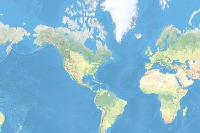

In [5]:
training_data = gis.content.get('01ca39eab00e4780b0517af11d971b31')
training_data

In [ ]:
filepath = training_data.download(file_name=training_data.name)

In [ ]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [ ]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

In [4]:
## Load the Data ##
data = prepare_data(data_path, class_mapping = {1:'Dist_tower',2:'Trans_tower',3:'Station'}, batch_size=8)

In [5]:
## Check the classes in the loaded data ##
data.classes

['background', 'Dist_tower', 'Station', 'Trans_tower']

### Visualize a few samples from your training data
- **rows**: number of rows we want to see in the results

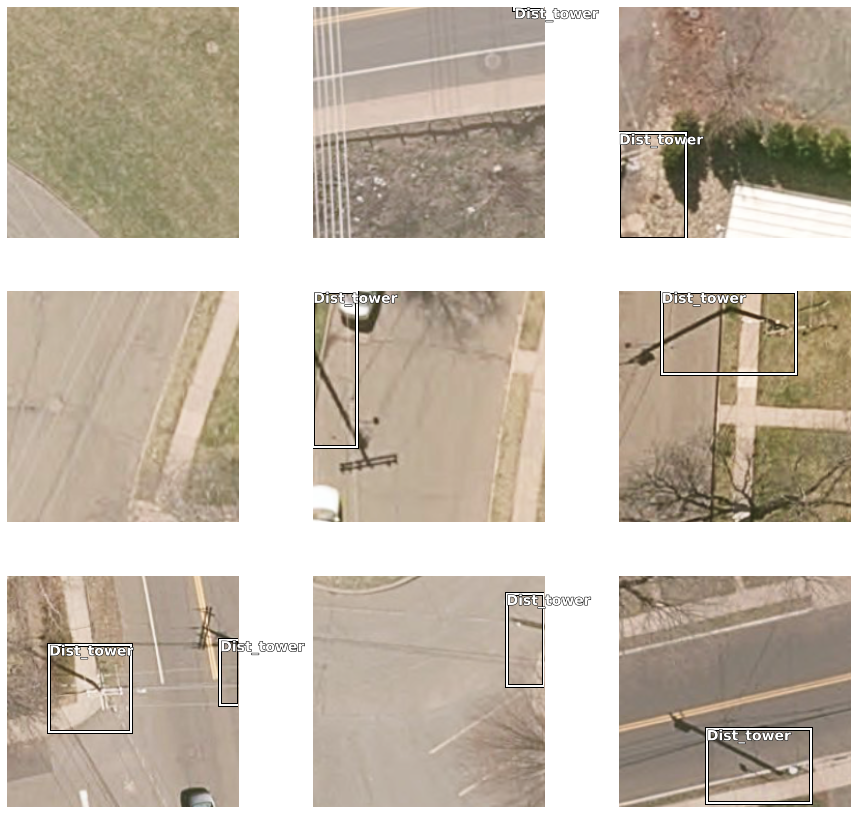

In [5]:
## Visualize random training samples from the data ##
data.show_batch(rows = 3, alpha=1)

The imagery chips have the bounding boxes marked out for electric utility feature type. 

### Load RetinaNet model architecture

The code below initiates a RetinaNet model with a pre-trained Resnet type backbone or other supported backbones. The model return types and bounding boxes for detected electric utility objects in the imagery.  

In [6]:
## Load the model architecture with resnet152 backbone 
retinanet_model = RetinaNet(data)

### Tuning for optimal learning rate
Learning rate is one of the most important hyperparameters during model training as too high/low may cause the model to never converge or learn. `arcgis.learn` leverages fast.ai’s learning rate finder to find an optimum learning rate for training models. We can use the `lr_find()` method to find the optimum learning rate at which can train a robust model fast enough. 

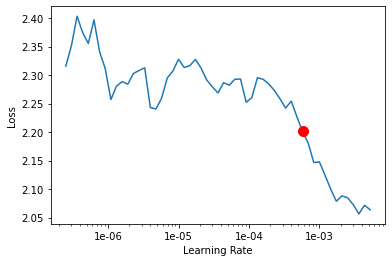

0.0005754399373371565


In [7]:
## Tune the learning rate

lr = retinanet_model.lr_find()
print(lr)

Based on the learning rate finder, the lr = 0.0005754399373371565, which could be used to train our model or if not specified it internally uses the learning rate finder to find optimal learning rate and uses it.

### Fit the model on the data
To train the model, we use the `fit()` method. To start, we will use 20 epochs to train our model. Epoch defines how many times the model is exposed to the entire training set.

In [9]:
retinanet_model.fit(epochs=20, lr=lr)

Training data was split into training and validation set in prepare data step. `fit()` starts the training process and gives losses on training and validation sets. The losses help in assessing the generalizing capability of the model and also prevent overfitting. When a considerable decrease in losses in observed, the model could be saved for further training or inference.

### Unfreeze and fine tuning (optional)
Frozen network layers pretrained on ImageNet, help in accelerating the training of the network. Unfreezing the backbone layers, helps to fine-tune the complete network architecture with our own data, leading to better generalization capability.

As per requirement, It can be executed or else we can continue with next step to [Save the electric utility detection model](#Save-the-electric-utility-detection-model).

#### Unfreeze model

In [11]:
retinanet_model.unfreeze()

#### Optimal learning rate

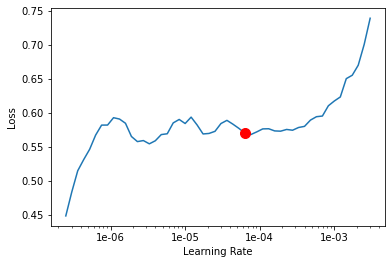

In [12]:
## Find optimal learning rate for the model with unfreezed backbone
lr = retinanet_model.lr_find()

#### Fit model on the data

In [22]:
## Fine-tune for around 10 epochs
retinanet_model.fit(epochs=10,lr=lr)

### Save the electric utility detection model
We will save the model which we trained as a 'Deep Learning Package' ('.dlpk' format). Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform. We will use the `save()` method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [ ]:
retinanet_model.save("Retinanet_electric_model_e20")

### Load an intermediate model to train it further
To retrain a saved model, we can load it again using the code below and train it further

In [22]:
retinanet_model.load("Retinanet_model.pth")

### Visualize results in validation set
It is a good practice to see results of the model viz-a-viz ground truth. The code below picks random samples and shows us ground truth and model predictions, side by side. This enables us to preview the results of the model within the notebook.

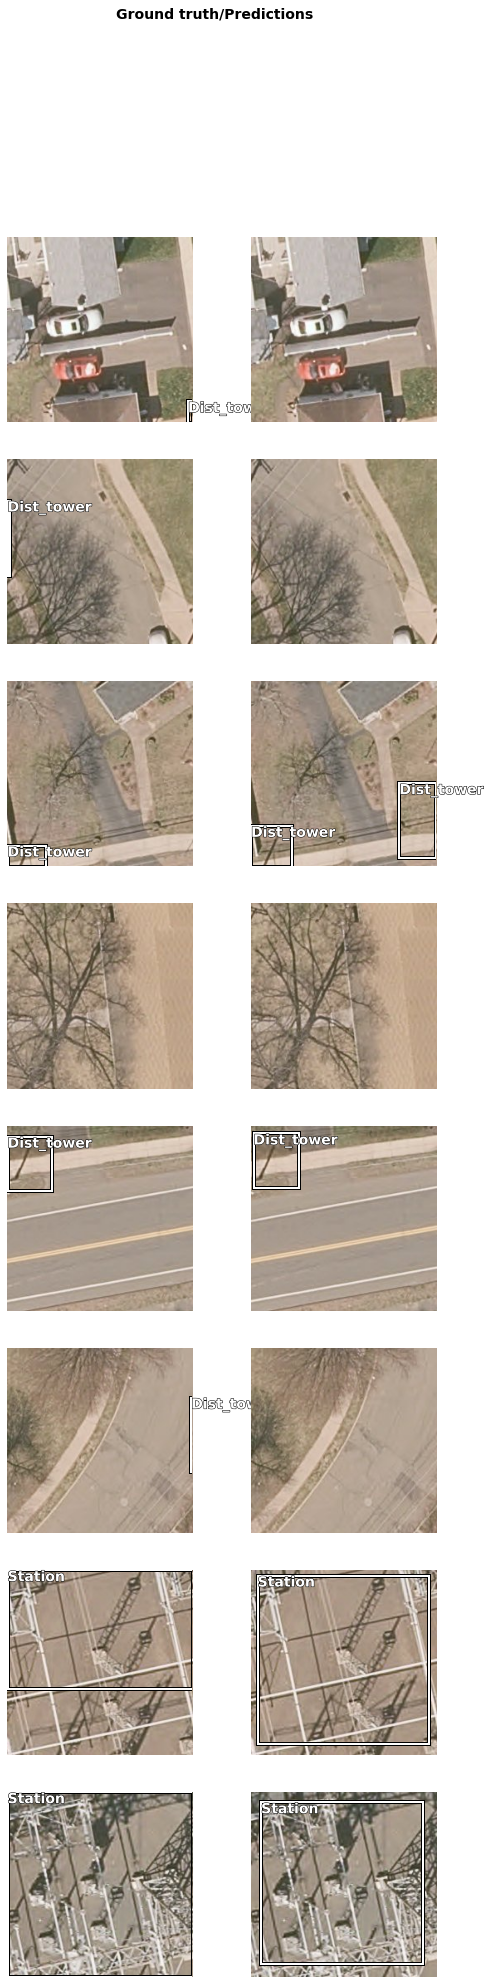

In [23]:
retinanet_model.show_results(rows=8, thresh=0.35)

## Part 2 - Train the model and detect trees
The same workflow is followed for tree detection from Export training data to detect objects. After training, the model is saved for inference in the next step or for further training. 

### Export trees training data for deep learning

Training samples for trees were manually labelled for **Hartford, Connecticut state**. The training data consisted of one class i.e. Trees.

Training data can be exported using the `Export training data for deeplearning` tool available in ArcGIS Pro and ArcGIS Image Server

- `Input Raster`: Imagery
- `Input Feature Class or Classified Raster`: feature layer with labelled polygon
- `Class Value Field`: field in the attributes containing class i.e tree
- `Tile Size X & Tile Size Y`: 256
- `Stride X & Stride Y`: 128
- `Reference System`: Map space
- `Meta Data Format`: Pascal VOC (Visual Object Class)
- `Environments`: Set optimum Cell Size, Processing Extent 

<Item title:"ElectricUtility_trees_data" type:Feature Layer Collection owner:api_data_owner>
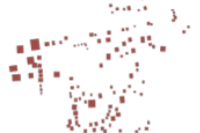

In [6]:
electric_train_data = gis.content.get('81ef094891e042ccb7f0742b34805f25')
electric_train_data

### Prepare data

In [ ]:
tree_data_path = Path(os.path.join(os.path.splitext(filepath)[1]))

In [3]:
tree_data = prepare_data(tree_data_path, batch_size=4)

### Visualize a few samples from your trees training data

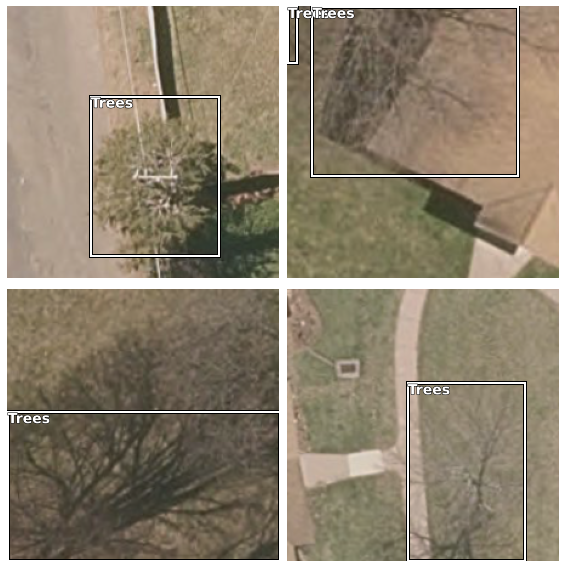

In [36]:
tree_data.show_batch(rows = 2)

### Load RetinaNet model

In [4]:
## Load the model architecture with resnet152 backbone 

retinanet_tree_model = RetinaNet(tree_data, backbone='resnet152')

### Finding optimal learning rate

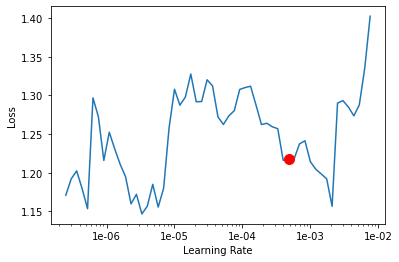

0.0004786300923226385


In [9]:
lr = retinanet_tree_model.lr_find()
print(lr)

### Fit the model on the tree data

In [10]:
retinanet_tree_model.fit(epochs=10, lr=lr, checkpoint= False)

### Visualize results in validation tree dataset

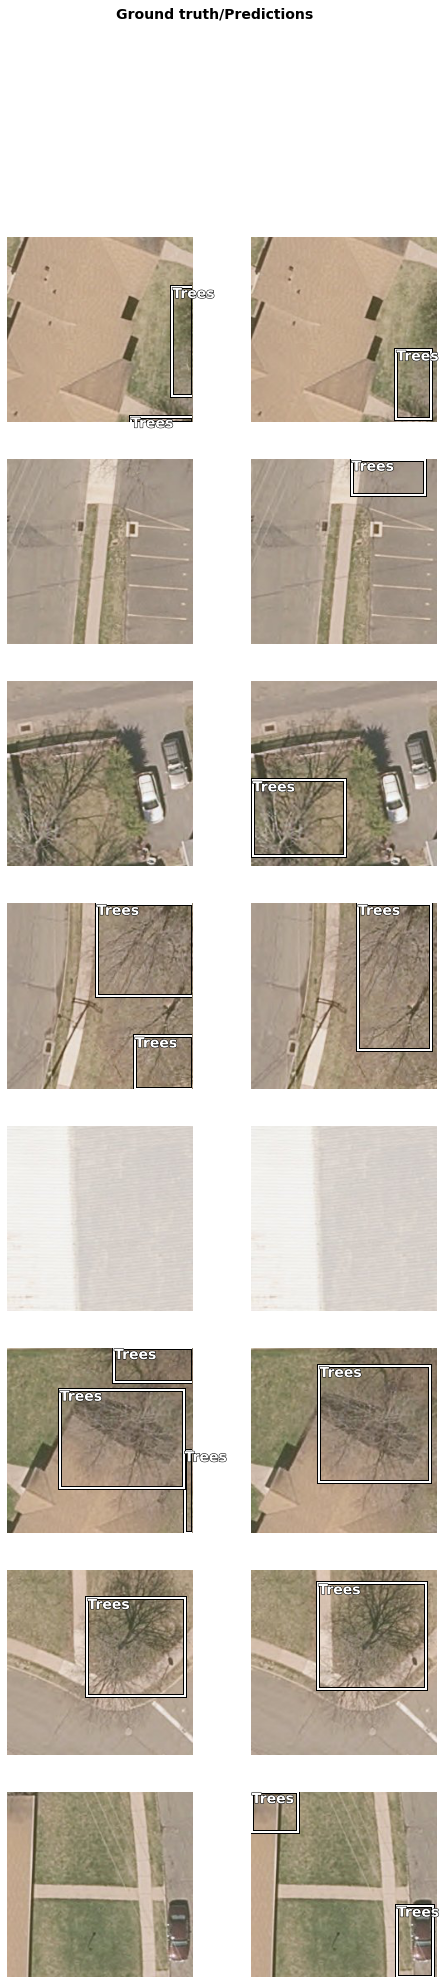

In [14]:
retinanet_tree_model.show_results(rows=8, thresh=0.3)

### Save the tree detection model

In [ ]:
retinanet_tree_model.save("Retinanet_tree_model_e10")

## Part 3 - Deploy model and detect electric utility features & trees at scale

We will use the saved model to detect objects using 'Detect Objects Using Deep Learning' tool available in both ArcGIS Pro and ArcGIS Enterprise. For this sample, we will use the high resolution satellite imagery to detect electric utility features. Detect objects using both the model i.e. electric utility and trees, to get two different feature layers.

- `Input Raster` : Imagery
- `Output Detect Objects` : Detected_Results
- `Model Definition` : Retinanet_electric_model_e20.emd or Retinanet_tree_model_e10 
- `padding` : The 'Input Raster' is tiled and the deep learning model runs on each individual tile separately before producing the final 'detected objects feature class'. This may lead to unwanted artifacts along the edges of each tile as the model has little context to detect objects accurately. Padding as the name suggests allows us to supply some extra information along the tile edges, this helps the model to predict better.
- `threshold ` : 0.5
- `nms_overlap` : 0.1
- `Cell Size` : Should be close to value with which we trained the model, we specified that at the Export Training Data step .

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAA4oAAALRCAYAAAAds114AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P0HXFTbnuaN97z/memZnpnuSW/n2+He6enud7qne3q6Zz7TPR1uPNljVhBEUQQTKGbBhFkEUVFRUZKgIGZJEkVFJOecc6wqKlcRnv/vt6oKCizTud57lbP2+XwPVu2111577V3rWc9K+5fwU2yhaVX4q+AKtLY0I6u4DjklEolEIpF8uGSTVuVX1GOoqwVfhzfgk2MHcCM9Go8rWvA/gkjPmpvxmMI8prASiUQikXywkFaV1zSgq70Fv32wzOrO3u/20xnF5HL87elynE2txi95F+OXtpZIJBKJRPLh4lOEOVcbAW0/vgirxtyQQByO3Yfs0mb8n5BynJZ6JpFIJJKPgQ1FOPekGyO9bfitA6VWd/Z+t5/KKJ5OKrMYxTQS1s3F+Gc7SiQSiUQi+WD5Jd8izI1sAnQD+DysCi7nz2NPxA5kljQKoyj1TCKRSCQfA9zweTGvFyN97WQUS6zu7P1uP6VRLJVGUSKRSCQfDS8ZxQsXcOxGANKL66VRlEgkEslHw8djFFNIWNcVkrgWSSQSiUTy4bK+QMxNhH5QGMVlF84jMOGwMIp/S0bxVEoVhZF6JpFIJJIPnLUFOPe058M2in95shQtbe3Ib1OhsF0ikUgkkg+XF6RV9f0aGJR9kz2KgQlHhFH8i0DSs9Z2FLSqUEDhJBKJRCL5YCGt6lZo0dvZ+mEaxZCHJfhzEtaR/i6Mj5okEolEIvngGTWboB22GEXuUTwRfxjpRXX48xNSzyQSiUTy8WA0GtDd8QEbxf9ORlHR1wmD0SiRSCQSyUfBq4yisq/LYXiJRCKRSD409AZpFCUSiUQySzCbzVYFefVmojCOjn2fSKMokUgkkp+GsfFxq2q9ejOaTA6PfV9IoyiRSCSSWYF5dBSdXV14mJSE1LQ0h/A+DsNhHcVhgzcWaUf7JiYmME779A722ZBGUSKRSCTfFNaoispKpKSm4lF6ukPSHj2CWqNxeLwNbhjlzZHmscnkbXRs7JV6Jo2i5LUYR02YgBkTZsf7JRKJ5ENhnAzc8/x8ODs7Y9WqVQ7hffkvXoiwjuJgWBhj4+JQUlr6UjgWXRbo5JSUVxpJRhrFDw/TKFeYCKlnEonkA4e3qxERcHFxcahlzMqVKzE4NPTKXkXWq+6eHsSRnrW1t0/TLDaOCqUSt27dQmlZGcbILNofa2NWGUWjmUzN2MuYTY7DS14Pi2pvdRfmhtchqM4g81EikXzQsKkrKCiAu7s71q9f7xDeV1hU9EajuGfPHvj5+aG4pGRSXFl0k5KT4e3tjfDwcEyQTs081obFKFbD6Vwojl4/8M5GkfUMpF/TGDdhVJbD3wjOz86KTsy52oCwJqPMR4lE8kHDW3RMDFavXu1Qy5i1a9diaHj4lUaRewpbWluxceNGnAwORld3t/iOw3NPZERUlIgj5/HjV+rZrDCKJirwdfS36lkT/uREFb57vArfE1TShdXjXKsGOrFyj+PjJY4xjZnR/qIJv+lfDK8igxRWiUTyQcOGrqqqCocOHcLJkycdwvuqq6tf2xvIIsrium/fPuwms8itrWws2SRu2rQJoaGhGFYoXinODBvFLy/W4m/3boHr8cVvbRRZz3gIUPWzZvwp6dl/If5IUInvHqzHxXYN9FLP3hlu+Gx80oB/61cK33IjxmWvokQi+YBh48aac/jwYQQGBjrk2LFjUCqVr9Ui5lleHnw3b0YgaWBvXx90ej2uXL0qGj1v3b4NrU73yjg+eqM4RoJpaOzGD0Kq8Btn21Cg1GFYrccQoTZqcfd+AzbnKDGgl8L6TeAHZERrgMbgeL9EIpG8L1iouLXzVbxpERo2c8+ePcPZs2fFkBouv1gAGf63gszdmTNnkPf8+Wt7FBkeltPc0oIDBw4gICAAl8PDsXPnTmESlSrVG4VZ9CheqsPSTZ5IuHPhrYyimfRM09yNH4ZU4ndJz54r9BgY0aOfUBq0uHm3Hj6kZ4NSz74Rej09AxqqG0g9k0gkP2NYrxzpmI03aQhvPPT03r170Gi1wtzZ61lHZyf27t2L/oGBN8bF58t98gTbtm3DqVOncCEsDL6+vrh58yYMdOzrjv+ojaLZbISmpRefBZZjfroSKpNZDI9kAbVhMptEOPvjOEPGx83AhIWJ0en7BRRmwrpfQOFHKR77yZ48f4+HAvE5R8fsw5pgsgvHcfH5xuh4Wzh+N8nkfh5iZDtWHG+5jsn9Vvjc085D2KddDL212zezxdRID+20/XZp4Afa9j0zZovXmg+TcxTp8xilj48183wPa/gJzgdrXPZMTy8fQ/Hx8TPSJpFIvt1wucyCV11Tg7q6OtTV109Bn6uqq8UiNI6OtcHm76nVKI6MjEwzlvxvFX3HRpFbV99kFBlOUw2lh40iD1k9f/48+vr63ijKDBvFz8goenh7ovDx/TcaRdYqZWsvfhxYhjmPSM+MFm15Sc9maAOnhTVjspx9hZ5NlcMEldesR/ZhTHZ6NvEGPePzcRk+Zg038Vo9e8VwWfpufKae2aWJr/VV+xgxNNd+v911i2ux2zepN9ZjJj9br4XjttczHuY77Zqt2NcbRF5xfFLPJBKJA3huYC1pV0Nj40uwrg0MDr5WS3jjXr/79+8Ls2YflvWM4+cpEm9jFHk/x5GTkyMMopeXFxITEzGiVr/x2I/XKNKFQaNCcHQFfuVsOwqGKVMdCeQMzGOjGFNrkFTQjRM5PQjK7cWDLj0Jw1SY0fFRinsEkXm0n8IEE4H5QyhR0TlIQIRgGw3o6xhCVIUCPSodHlf04Vg2h+/FlRIlhkHGkuOjdI4pR3CnZBAlShPqqnpwlMLca1ZDT+IyPkHnUqlw6Skd+5igOAILh1GnoeuzE18hmqMG5Ff340R2N4IpbPCTPqR06cRQpTFKs2FQiet53Qik9J562oecfoO4Lr2Brpv2mweUuPrMck0ncvvwsFUj0sDXa+xX4NIT6z6KN61DCwNdq3lYhRvF/XjSZxBpMIxokFXWj+xeA7paB3Eu13K+mEolhujBHbOrEPD80LqaXpF/QTmU35SHHb1KxJcM4Fk/5+FUWIlE8u2Ge/BqamsRcPCgmKDP8zI8rPDnLVu3ChPo6Fgb79MocnhuwX2YnIzdu3fDx8dHDFt9UVDw2mGrNtgofkFG8dNdXjgcs/31RpHLd9azqHL8KuuZ4u30jBvixjQapBb14Cxp2dlnVHb3ULlPx9oaNYWeqUcQm0/7nxAU7nwRaYzaomcchvWsp2MYsdWkXSN6PKnsw5lcipO04Fq5Cko7PTOTnt0rG0LliBG11b0486QfqW2sJZZGRNazK3l0nqd8rh5cKFGgUz9dz7jREmY9XtT0I1Scpxehef3I6tELo8q6qGc9e95D8ffiXP4A8oc4vZbrYj0zDigQ8ZzP34PQZ/3I7CTNEnpmhr5vGJefWfflDeBJj04YS+OQCvGlAygYpDjos16lRkbZAPIGDehsGcB50mHOn8T6EajIOI5Z08vXzUa0qqYP5zkPOd5CBfr6Sc/KBlFMaWMdtl2fRCL5dsPmi7Vo67ZtQr88PDwm4c/7DxwQjZ+OViK1wdv7MoqsWWxMY2JisJW0lKdQsE42NTe/UQs/WqPIPVODbf2Yd6Qcro+HoSTBfJPxMFNBPzyswN4rDfj8agM2JHVg8/Ua/HFoC6636zFBBf3ohBEtjQMIuFKN/xXdCp/77dj2sBVfhNfi70PbkdmnhZ7EdZwyriStBr/sV4Eltzux+V4bNlPYTffq8XubKrH22TCZRZNllbWWLvzPfRX4PKEFu+61Y/39TlypUZP0mtBQ3Yfdl6vxv69Zjt+e1IIfhtXiJxc78Uyhg4HSbCLxU4+ocf12I358qR5L73Rg64N2rIutwfxHKsopI9rbB7H+fB2+jm3Gpoft8Iyuxn8P70Amm0USzr62QfhfqsDfRLViMx274nordmb2UQVgDH3NA9gWVoH/FdOGLbTPNbYV+58M0D6qYNS24/d2FWFlgV60puo7B+B2vBi/HtwAn7uWdKyPb8bfHa2AT74SA1yR4Lwe0yM7qw3/eLgMP77Zge0PO7A6ugHOFyvwr7cVw6vYMM1USiQSCQ+PaW1rw8mgIDHBfsOGDeIvD68pKil5ragy78sosuhyeF6WnAX18uXLYgEcNopsGsUKcW8wi6JH8QJpQXQcLiefe61RNJGmDLb3Y+6RMrg8VkD1Fno2atWz/REN+OxKPTaQfmy4Vo0/OdeKW51TetZKenb4ag3+JrIF6++QRt1vEXMnfxDWgexBndCzCYMez5Kr8Ut7KuF6twub7rZh0502rEusw+9uqoJvgRIqVizWs6Yu/MGeCnx9uw27KAzrQETNCO01or6qD/7h1fgb0pKNd1kPm/HD0FrMiehEwYhBGDkTpXuEzGbM7Qb88HIDXBPb4UPxuEfXYGnWCOmZAW2tg1h3rlbomTelZfnVKvx1VBeeDZFuUBp6af9u0pL/SXom9se0YG/uAEZIs7qb+rHlAmkdpcGHdNmFrvto/hDUtG+0sgW/vLMY3mVUCSM907X04ieHivGHoU3YSun1Jn32vNaI/3W8CnvKRqDg54Dy2kSmNu1RK/4v1Te+iOfrasdKqkMsI039pR2l2F5pFL2Sju6TRCL5dsJ6VlxcjD2kX9yDZ9OzE4GBYloD73d0nA3e3odRZN1k7YuKjhaL2ty5cwfZ1p7F4OBgMYT1dXr20RrF8XEDqira8V/21OBotUYMA7HtmzlkhVshRSZqtbhwrRJ/dKoVWRq+CWSETBqcjajAH4X3oJM+jw0MYf2ZchKZLhSpKR6SP8ZIN2LlsTL8ZXwvWnX0vdGA8qx6/NKWUvx1fA/K+TsRVo/MlDr8u93V2F1L6eLzt/Xgb0hg/sWZJjxXWOLj4ZyGngG4nCzD3yf0okZn+Z7RdvdhXkAp/vb+APoNbEr1SKI4//BoHc4368jaUbop3Jheg4o+A/QKJXacLSfR7EY1XSdf16hKiW1nK/APtwZBdhO34mvwq0ebyHxartvMPaJDGopFh+iYavy7Ey0oE9c7CqNej75hDdQ8LKi+A79/oBTr2NjRZ0P3IFaFFOOXjtYjskUvwlNCcOtOJX7jZDPu9VH8VPHoqmrHX+wth9dzFRTcos3htGocj6rEv9pZgs1l0ihKJJKXYfFsb28Xho57FXft2oWCwkIhdm9qNRVG8elTnDt3Dnoqx3gxABZAhv/NPYQ8x/BtehSTkpKESbxw4YJYVY63xqYm7N+/X5jFIqoAvE7o2Sj++FwZrmbWoZsqBa8zimOkZ5WkZ98jPTtWoxFD+W37hJ5ZtUFA5avIB40W56+RdpGeZXLvIJexBjWCwsvxpxG96KbPrGfrSM/+OqaT9IyPt2iHrq8fTofL8De3+tDBvX2kB4UZdfh/SM/+JqEHNfydCKvDw3u1+Lf+tTjYqCU9o+9auvHnh8rxK2SuXigs8bHO6bv7sfREGf7hZg/q9Py9ZZ+ivQc/2VeKH6QNYdhIeqbX4c7DWnz3WB0utuis4QidGmWkZ5pBBXxOleN/x3ajgSpDvG9iaAiepyrwedIwpUiP2GtV+OfHm1FivaYxvQG9g1qYoMWlK5X4/wW3ol5oKmmdVo/eYS00ZDDN1W34f/eXYXsF5RcbxbZ+LDxZhH9+ogE3OjgPxyjJWlyOq8Bvn21F9hAZwFETWkpb8d/2VsCnYAQazgNOL5ndnWFl+Jf+ZdhbTWZbGkWJRGIHl9OsW9ywuI90g/WMF6bhXrw3mUSGNzaKrEUcnjXLXs+4h/BNcxT5e56vHxkVJUzibTKJrIMcBzeqslkMIrPY3tHxyobYj9oolpW14jt7ahFcRwJG4snfj5oMqK1sxz+eqMKfBlfjz05W48vUQQwZjBjo7cU/+VXA5Rn3wlnmAY6SCHQ/a8C/CahBdL8ZTUVt+JP91TjToqVz2BYMYNE0ICerAb91qAG3ekjczAaUkLD+88N1CG9l0bGcn2+KaUSFTWdK8f17gyRpJChkFP/6cCl+lKmenBcyPmFEweNmMmG1iOnR280X5HPp8fBhHf7zsSZkKwzQKhXwIpP6T3cHRKuo/XAYTlcNXe8f+1XjCBtT7sWk62Lhf/KwGv8+qBnZZIpT79XhP+yuxx2Kj+daci+lmF9BwnqdTOSv+TcijSob9vvEnEYHRtH1ZCn+KXkIAyazmHvC96KivBW/t7cWJ/leUPqjyRD+55A21JI4j1sNoYmHC5GB/G2qNPiUSqMokUgcw6LYTGIaFBSErKystzKJDAspv0eRJ+xHRESIYTbR0dEC/jd/x8NuXrzhPYospFu2bBGGk1c3tQko/20h0+fv7y+MLG8zj7VhM4oXH1WiuaH2tUaRy9BSMiO/S3oW0jClZ2MmPWqpzPxBYDX+IqQG/+NUNeY/GoKC9vV39+LvSc+WP+deODNpC5kwKqM7n9XjVw7WIm7QjMaCVnx3XzVCW3W0byr/uIzOeNSA3zzcgId9epINA148qsW/OlKHyDbSBdInDmeiPDcqlPA4VYYfJg1Z9IyM4p8dKsWn2WRobXoGI/IzG/GbpGfx/QbSs6lrY7OZeLsG/+lEM/JHDBgZHIbbEY5vkNTHOqSV4PvLelZe0oY/IMN8ppm1hK6LtBFGPZLvVOE/knnL1+hxO6EGv7qnARlay7lY81izJiY0CI+swq/ub8IzTpfQM8tcQh7e+7JR7MOco6X4LFMBFe3n3kNyssjPb8JvHKhHBBvZCS0uXCrH/3uuAy10zKSeUV6PFDfj3+8rx55q2aMokUhehss11jNeZI1XKK2sqnork8jwFhkZiYMHD+LatWvTiI2NFa9o4sbM18115HNxA6fX2rW4ffs2dGT6uDeSw7OecaMp93Tyi/t5cxTHR20UKyra8N0tVdhRqoJ5wmLqGI1Wj7YhHfp7B+F1pgx/EN2HPp0R7dWt+IOtJfjVg5X43tFK/IGV3wsow2+eqENUN5nBjAb82uEmpJJ5s58jMjoxiuaSdvzZ7kocbdGQwWSjWIt/c6IB8d0kntawRhIRvUaHo+dK8ZdRPWjlFkoyin91uBI7q7Vk7jicxaAl3ObjW1HIw2nsRGaMzlWd14zv7qrGxX66jv4efLK/isSNhNOupZmZMOnw5Ekj/uOWUvynQ5X4rvWa/pD4LTJk3z3fjAcDlIb2HvxjYAV+ZU8Z/uhKJ6pJYNV6EjsycmONXfjro+X4lb1l+POobjToLKuc8j5HRtGFjOKXVFnpsy4exPeispLy1r8Wx2pY3JXYdqIcvx7bJ0znZHrZeNZ14HdIqKVRlEgkr4OFjCfas2l7lQjOhIWPXyqccPMm7ty96xDex2Fs5u9VcC8iv2fKfvgqw5951VNupX1dut7VKJaXt+IPt1Ri1ww9U6t1aOrXoq27H6tCSvGHMX0YID1rrWrB75Ge/XvSs+8eozLfyu+Tnv1n0rOYHgOy0urxq0eakdGrn2ZkeN5iY1Eb/nR3FYLataQ/BuSnkR6dbMDtXns9M0E/osX+0yX4m7hedLCesVGkc+6t4+XUORzrmQax8TX4laA2VHBjpF3Zzucqf9yE7+yuQbRCj+6uLvxwfw32VbGeTYUTDZ9GLdKySIN9S/HrpJm262Jd+529JfhuWCvSh8ZgaurCXx4ux3/cX46/iu1GCx2vI80ykmbpazrwR5QH/+lABf5vQi86KS08T5/nKDoyil8dLcPSXAWG6fxsFCcm9Ch40Yzf3FePy81sFIfhdagc300cFPPuJ9NL8RlJ9/4DpUEaRYlE8iq4HGUdY92wfZ4ZxhFs8njKQ3xCgniFhSMSb91644I0vEoq9zryX+4Asn1vO4aNJg9NfVUcH61RZBOj6hqCy2EyLelDGKRC39YyKfZTIQ6dAjvDyvFfr1mMYlt1C763rxp7qqjwH6UbR+JhwyJ2OnLVDfj3hxuRzL2G04yiGU3FZBT9KnGidcoo/lsyigkzjKJOo0XA6VL8j+getNkbRTJR9kYx8U4dHd+CF0P6GUbRjKpnzfhDv2qEk1Hsqm/Df91bjZ2VlCZ7YSXYKOY+bsBvHWlAdBuZW4pn+nVZ4HRxnmQk1eG/Hq3AL++rgPNjpRA+bo1lHt6rwXePlOOf76+EZx73utJ1vcIofs5G0WhnFCvIKO6pxfFaNooK+B4rx29c758unvSAcnzSKEokkrfhbQV1Jq877m3j5HCvCvu6fTbexSjyipuKjkEsPlSKORlDGOYVou32W/RsGNsvlOOPYy1GsaWSNGKfxXDxSBq1zoreQGW/CROkZ0kp9fg1MorpM43ixCgaCtvwJ2QUg99gFHUjGvifshjFzkmjWIV99TOMYkIN/k1QK8pnGkU6VxkZxd8lo3htWIcWMrjfpXQH1JCe2S0iJ4yiSYvU9Dr85vEmJHToxRSJ6ddFlRZOlzjGgLu3a/B7ByvwawFVWJ9PBpv1jPbxazCu36zCdwLK8asHa7C7RC00/FVGcfHj6UbxhdUohluN4uoD5fjenaHJnl4B3RNTlTSKEonk7XiTZvwssfUiOtr3Jj37aI2iEBWtFjEkFP/qWD1udBjoCEsr7NR+BXaTUfxjMoq9eiOG+vvxE/9yLM1VUtipxQI4g9gwjZEJqytqw5/tq8TJpplDT3moTj1+40gj7pHo8tDTUjKK/+xIHS7xUB2rgWNB1/T24vsBZfg8jZezIdF9ySiSuZowovRJM767vxpXumYOPdXhzt1aMVTnqdIA5fAAvvInc5Y+jHH7oTpsvHgBgZpOMrBVOMBzNWm/LQ84LRwvt6byXzE8h8we9DqEhpfidy604YmK0keVEt43Okb/1mhw9EIJ/jC8E4VaqhQ0fhOjqMbhkDL858ud6KU0cnrFqz0obQOFLfiNvXLoqUQimd28i1G06JUGEYnV+OXjDUjsIj2z9ipO7iejuIOM4p+QUeynMn2gtw/f96/AsqeWqRSTesam0qpn1S9a8b19VQhpeXno6aPUevz6kQYk91uHnpJRZC2N6SSNsNMzdbdFz+amK0AW0IFRtOhZQVYTVSRqENf38tDT+MQa/MfAFhSqDRikdP/ArwzzcxQws3mzhhPppjNUlvJczWoEizmRU3kghpZa47XpGa/6OqFW49D5Enz3aieK1ZQ+1m3eR0ZwTKHC9tPF+NNr3ajSj2Ki5psYRRW2HSvDb8f0ipVQbfo7SmnrzmvCr8mhpxKJZBbz8RpFgucIaAdVCLhUgb+82ISQBhJDFjLBOOmTAutJqH8zqhfdWhJOMpaXrlXg1w83IZ7EcYJbRymsXq1EfNWIMEKjSgV2XqjAn19qQ46SjZgljLKrD3OPVODHDwfQY538Lxaz2VqK/5vYixYxeZ/C6lW4cLUC//54IxJ7LSuOOjKKLIqmoSGsDeFFaMiUafhcHAeZqeZuEuYKzM/guShkNQ16xN+rwm/61eAYGTGjNU3GgWHcbNOTGCqx/WwZvhfahsdiUQPeb0bPoAIP63mhHx1etI1giPJA7DPpERddju+ca0eRTo/iNjVUBuu1GnQIu0JxXe5AqYE+v7NR5AV8RlFX3ow/3lIG1xwltCI949D29MMlsAT/z3a5mI1EIpndvJNRJFjPNP1K+JEZ/KvwFoSxSRGaYNMWBTaEluK3SM96dSaYNVqERpXjt4414+4gmT1RzvLrn5S4U6cWJso8PIxNoeX4HxEdyBuZ0pgR1rOj5ULP+kjPJkjPijNqhZ79/d0+dBut59WP4Czp2S+daMRt0jPxHkEHRpH1zNA3CLeTZfg/17tRqbOlm/SsqRv/EFCOhVnDGCE9M+l0uBpfgd/aX4ez4hot6R4nvXrQaSBNH8baoDL8eXgHCskQW+IxoW9AiYwWLcyjrGdqOq9Vz4xanCPN+u1LnajUGFDSpsGoaESlfTo1Dl8oxfeiulGjH/sGRpGHx5pR/LwBv7+lHBsLeF1VTu8YNJSHC46W4J/vlovZSCSS2ctHbRQZfp+SlsQ15mkTvh9Uj4XRzVhyjYhtgWt4DX5jXyXW5yuFQPFwmOHBQfhcqMZ/OViDOddbsJTCLrrShMMkrDzx3TxuRG/nMI5HVOH/u9CIRbTfKbYRP7xUB+fb/agd0ZNQkVWjjCvNrMO/OFCNhdfbsSqmEYuvtWDR5Ur8alAzrterYeRW2VEW1i781d5ybKmaMoqWtBvR0TKE/XTMn5LR5XQ7xTbgH8PqsYoEvFVrgJnSxPP8NBo1Lt9oxN8EVuKH0S1worALz1ZjfQUJ7agB7SRaS45W4E9P1WFBXAuWRDdhUUwLwttYiEcQGNeIr841YmlsM+ZGNOL7F5oQy72mUOFgRAO+DrPsm3O1ET+62EwGVCMWGrC8HqMY7gWWSgK/HsP5cDF+nDyIHrs5imVlLfjtbdU4bl2BdpTMaVpWG/4vXfc/UXpEemNbcSC+Dv9hbxk2yR5FiUQyi3lXo8jwfD5NnxLh2U34h+AGuFDZ6XaDiG+Fe0Qt/tPeSng8V0At9MyAwf4BrDlbhf96tBZOia1YQZq2LLIJh2osejZKGtPVShpzqRJ/fqkJyyku94QmfHq5Dktu9qGK9Ixfs8Era79Ir8W/Jj2bH9eGNXFNcI9vgcuVSvybwGbE1qph4vnxrGf8egz/CuysnTKKlrQb0Vw/gO3c0BreTGmmc8WTdpKeud8nPdNZ9Iz1U6VSISSqDn8VVIV511uxktLldL4Gm6p4bQAD6lt68OWBcvz3cw1wTWjBStIm57hWRPH0CtKs/ZENWBTehBV0jmVRpFlhTYgjEzkKJXZebMCSCMs+p8hGfHK5Bbc6SM9Iv0YrW/HLu0qmXo/R2osf7i/Bl2Rih+yMYl5eI35lZy3Oc6/mGOX1mAY3HzTjfx2oxFc36V5weune7I6twb8ljZM9ihKJZLby0RtFRszfgAF19UO4WTKIhFIL/CLcO3Uq9JNA8TAVDstixu9wyuT9Vm5XqaAgMbANcRFDVlRqpFZaw1CcHE+ngc5jHfrCRrGYhPXfnWxEQosexbUDuE7h4suH8IjnN9qGrdJ5zSMaPG1QokZpmEyzDT6XWTGChxXWcxUP4l7jCPpJtOyFh+ewjBt0KK4bxA1ruhMrFejQWvbz0J/+PhWSrftuUFqSG9RQUzrMZj3a2pW4y+njfaVDeNytI0Ek4aR9za0K3LHtKxvCMx5aS/tYNE2UD9l1w6gYMloqBRodShsVKOjVQUP7+Rr5ewVdQ3adEg10jWweubV3YsyA2oYhJHDcxQN4QKbVUN+J7xwow4YSaRQlEsns5ZsYRUa8q5D0rKp6ENEF/YgqtFI0gIQqJfr0U3rG0yNUwyNIov3R1nDXy1QYtukPwRozqlDhTumAJR6K83qNEj08isQ2lJOM4vM00rPgJtwmPXta2SfCRRWRjnTZ6xmZKX5Jfc0wqhzoGb9w3zikREKxNc0v+pFQb3kf4TQ9GyON1WrpPJRu6zXGlpGe6fg8rOdGdHcqcct6TVEFpB/1amgoHfxOw4amYVyfzJtBZJOeca8jax1rTqxtH6X/qdAzS/qNpFNJ1UMoH6Z8pjTpSZuf1Q4hv08HLe8nTGYDBgZIS6uVaFJZ8pqnp4yP6lFSPYAYjvtFH263acWcx/+0vwy75XsUJRLJLGVWGEUL3OpHAkNCMhObqNpgY8nvqZoWxm4/I+Yt2oehuC0GyIIwihm1+JXj9ZZVT0mkbGH5vUv2cbG4sqDbT/C3R8zNsJ2HmXGuyXD0Hc8zsQ9rH85M57VPs1iohr7n+YG8z/44+zmRr95HWPNhcrEdOt8YxctzUGwVEcaWX/bXyGnjsJZ4ufIziu6CJvzW3jrcVNF+u+MlEolkNmEziudTy9BQW/XWRtEGD/UX5eY0XtYG0VA6I8xLejYzzAyNsRnFfxPYgFu9PLTSLqy9HjBU1vM5XtXQ96ZzTYYTmmEXbsa18aurZsYzaX6Frkzts9fcl/dNxWlJO5lU23k4DZTP3Ps6GYaw5Ol0PWNjKYbe2pgwo+VpA/5zQAMeaOi8dsdLJBLJbGEWGcWfL/ZG8UYXGUV7MZLAoNWhXW0QZpURomsYxvagCvxmdC9GHB0jkUgkswQ2il+G1+Jvlvhg8YKv3tko/jyxN4qJPVLPZqLnl/ZrjcKQckMqa5pRPwTvY+X4vRv9ZI4dHyeRSCQfO9IofkPYKJak1eCXD9UhplMK6zRMJujq2vHdS+1IqxtGSq0C2c19WH+5Bn92pAlJKn4vmoPjJBKJZJZg61GMeNyAvq7SD94oPkuuwT87Yh0hI/VsEtaqgcpW/FFEF563KJHTqMTztj6sO1eN/+9oC9K1U0OBJRKJZLYhjeI3hN/v1FTeieX3uvB08OWhK996TCpcjGvCZ1cb8QXxeXgDPrnfh3qtUVZCJBLJrIeN4mcXK7E+MAZXLoZ90EZxlCoCNcXtWHSrE0+HzNPe6ysxQqdX4MTVBvzgUj1+yFyoIz3rFyugy7mJEolkNiON4k+BkeeQTFjmO/A8QEdhvr2Y6A7y3E07eIEc2fIqkUi+BbBR/OJSNeb4ncXhg/s/aKPIiHfsQuqZYxzp2cvrH0gkEslsQxpFiUQikUjeM7ahp2GPG9Dd1fXBG0WJRCKRSGYijaJEIpFIJO8Zm1G8nFGDthfXpFGUSCQSyUeHNIoSiUQikbxn2CiKVU8Xe2Oxx2FpFCUSiUTy0SGNokQikUgk7xlbj+KFtHI01r39C/clEolEIvlQkEZRIpFIJJL3jM0oXnxUieYGaRQlEolE8vEhjaJEIpFIJO8ZaRQlEolE8rEjjaJEIpFIJO8ZaRQlEolE8rEjjaJEIpFIJO8Ze6PY2tQojaJEIpFIPjqkUZRIJBKJ5D1jM4qXMmqQdnq1NIoSiUQi+ej4KIziUE87tDqdwwuQSCQSieRDQqfXY2SgGz9ho5hZi/sH50waRalnEolEIvkYMJpM0Gi16GxrIaNYanVn73f7KY1iMf4yqByqwR4prBKJRCL5KGCjqFP049OwStGj+ODwPDwqrMNfnJR6JpFIJJKPAyOhJqPY192J3w6QRlEikUgkkp8aaRQlEolE8rEjjaJEIpFIJO8ZaRQlEolE8rEjjaJEIpFIJO8ZaRQlEolE8rEjjaJEIpFIJHbw5P2ZOAr3OqRRlEgkEskvGtYvk9ks+CZa9q0wivaZw0u88l9bxn2TTJNIJBLJ7IK1gPWBV3draWlBYWEhcp88QUFBAVpaW8X3tnAzj3XEz8oo8vltOPoskUgkkm83Nj1gHWpubkZxSQnyX7xAZWUlBoeGJsO8jW7MaqNoHh0V4t7b14fi4mJkZGQgKTlZ/C0rL0dPb6+Ikw2jo+MlEolEMvthrVAolUgnbThy5Aj8/f1x9OhRBAUFib9+fn44TN/z/qHhYYyOjTmMx57pRrEW9wK++qmMIusUx8nnr6qqQm5urkgP/62rq8OwQiGMrtQziUQi+XbCxo81YGBwEHfu3EFAQAB2W/Xr+PHj2L9/P3bv3o3TZ86gvKJCaMqbNOODN4qnvoFR5IxiIe/s7ERCQgIOHz4sxP7cuXO4dOkSQkNDxXdcIeCM7OnpwfjExFs5a4lEIpHMHlgk6+rrceHCBZw8eRJPnz6FamREaMjY+LjQBv787PlzsZ/1g43Zm8TV3ihezKhG1uWt38go2vSMGzzv3L2LQ4cO4cCBAzh16hTOUlrYzO7ftw9HSOOSU1LQPzDwVkZWIpFIJLMHm4cpLSub1KqioiLRYcZ6xQ2iTGdXF+4/eIADZBpv3rwpTKWJvp8Zn40P3iieTSr9Rj2KNlG/fPmy6Grl73ibEP+HiIt7FblywEJbVFz8RuGXSCQSyeyBRZNHm7D5ik9IEL11rBE2wWWBVWs04jMbRu51TCBhDTh4UAxJfZ0hszeKYY8q0Nba+o17FFmf2BieO38eJSUlIm5OJ6eJ/46o1SgoLERISAjOnDkjehylnkkkEsm3A5tm8YhJ7kXk0ZOsE6xR9npm60HkRlCeYsE9i6dPn0Z7R4f4zj5OGx+8UQxLLXsnYWXhT09Px6HDh5GRmSkyxtZbyBlmtgq7TfhZYFNSU3GQhP/x48evzCjJ7MQ8DkzQPTc52GdDbxrFGNfGxsziB+MozEfNKF/cBF2eg32SDxt6gMXdG3WwT/JaWCy7e3rEUJys7OzJ1lbbftabiMhIYSBZXG3HcJjHubnYu3cvOjo7px1jz0yj2NxQi/Si+nfWsxzSJTay3FvIesX326ZnNqNq0zMlGdnbd+7gIIXn+ShSz75N0DNBzwYw/lqd0pvHRCiMz86GBCNpOm+jUs8+PqyPpqyLvDusTRWVlWK0SUlpqSj7bQbRpnXhV64gLy9PfObvWV+4ITQqOlp0mqlJX2z77PngjWJCVvFbCytfYENjo5hfUlpeLkTUdtE8d4NbXF8UFEBLF2x/DGcW79u3bx+amptfKfyzExKXcUur9DSo0jFqtjxk74YJprFxyvv3baoonSJNjvY5wGrupq6JjBClyT6M0aBD1f1zCAzLRBfoWbHbNwmL6lAdbl4IQGhyDRR6bp1xEO6dMcHM1zP6TfKY4XyewPg4pcfBfuPoGFUcyQC/Ka0mM7QVd3DgyAmkN43+XMTVOGo1NzMYn3F/fvHQPaLfxje/Rz9jyCSOteYg6Oh+JJSOTIqC5O1gTbh48SKioqLEZ/v843/z8BxPT0/s2bNHzP+zaYktXGxcnJjOwLrkKO8dGcUHT8vfSc+aW1rgT+cvKCqapmcMDy/iCoGIx3p+m56xkeUKA7cSf6v0jMoza13zpe2b/Y5Zd6hseu+mypLOt60Qc5k5c5tWXtL9N+pUKLkbjss3CzDwqsZPLjP6KhB3MRDXnnVDaxh9TzptvZ5v2mBF6WeTOzHhSM+4HBZX/EY9MxoN6C9IwInzUSjqoWv9mTeg2dL28jbxoekZ1Yk4qT/7PPlmcBmqrnyAwNPn8aRtTBr9d4DzjkfDBAYG4uHDh9NMIsO6wB5n6dKliIiIgJ60ybafdYWnNQQHByMlJQVmO42x8cEbxUPnovCXQRVvFFbxkJEzPkkZde/ePZExtozgTElNTcX27dvx6NGjaRloO5b/JiYmimE77KpnhpmVcAk3VIPrITvg6uYODw8PC6tWwmXTfsQ97+LS7h2ExEwF0SAeXzmEkGsF6Ne9hVF5K0ZhHqvDtZ2+iHqhfmOcJrosVeVDHN6+BivcV8Nj9Sq4eWzCieuFULPYWMMZDVo8PeMJ5w3RaCSrMmoXxyRcS+h5gaPrvsSaC3kY0E28h2siE4t23D60HWEZ3dBRvjkO9wro2TRqh/H48k5sO5GAeg1VgibTRIJrGkHdo3PYvOs0nrTo6Ba+5lk2j0L9OBhfzFuCyNJxjP9MRYRE1aBBc0oIlq9YNfW8Eas81mBrdKGlkOLrc3j8zxHzGCY0dYg7ugXB9+qhMrzL7+DnBNWsJiqvw3XBZziaoaTn8ltQZr0nWEh5LuKxY8fEnD57A8Zw+c8rna5bt07M4xgaGpoWhv/N4srTFnJyckRvnv3xjCOjeOhcNP4yuPKt9YyHmybeuiU+22CDy6Nldu3ahbRX6Bmfm41s2IULrzSysw7Ss/GBSlw7vQdrvNZh/fr1WL+BWOuJVbuDkVo1RDWKd9OzsYl+ZF86gkv3a6F8b42E3IhahWt79uB2FVXUXlsh5gZFYKTiDg7u2ACvdXQ9673gsXEvItIbYCTdEnrGz4ZmAEmH3LHS7zY66ErNL8VFsBtreYTNy34I72t1UL+Xcs0M01gjEg7443oR90g4CvNqjKRBRmUHkkL34EhUNrr04zDb8pmNv3EQBbdOYXdgPGr76bf7mgZsk1GP1sQd+MFiL9xt4OqL43DvBUrbuLYfLxJPwsNzHTbws7Z+A7EOnj47cPpRM2U2V9gdHPvzhvRsdKgIYft24lqB6oPUCiPlpyL9KH48ZwmiyyZ+xnWR2QWX73fv3hX+hct+R5rw7NkzuLq6ioZR3QxNYD188eKFmK7HujezcZHLiA/aKL5tCywLNbthdsU8PEd8TxnBbpmXOd++bRvCw8OhVKleOpZh4e/r78epkBAxDIlbXhyFm1WwCeovRshmD2y7+hjtwyMYHh6GUt2HsuwrWP/JT7Dh1B00KiaoAm93HOUrD+HlvBXYCm6Oz9yKuL1u2HL+GQaNlpbYSSGigsD+OLODAp9FYzJeEYaO56bKoRz4Oc/HqVwyPmRezY5ah+nYcX0n0i7uxsKfbMCVp1XoHVFBoRxGW006Drp+ilX7L6Gkz9K6zEYx7/xGrNh8DU10inH7804r3A3QajVQ6wzQ25/vVflgh9Hk4HpYrDXFOOGxEAH3u8nYUv7arofzaNQuzlG7/LNBYbhSkHzUFU5bLqFSbd8ybcKYSYXyW/uxaLkfUuu1dGGWCq6RxWIyLaNTYmHQUaVUC63BFoclDXx/uGfSdozZQVq4cLfPA/4d8WdH91aYWMMIqq7R/VkXjLweLVSKIQwODWOgPwdHli7B8rVbcK+WjPQMc2ufDsd58pp7Yc1Tvt5pzxcVhq8ccsyNKOoKnPNZgp1RFVAaXj2ca3raqNIzo2Jgst9PTBdpk9jPzwVPJreE4fvFabU+L9Y8teybEb9BDw0ZCo1+ZnwvX+vL6Z+eZ3wuFohvNpLg44JKKtGbeP/+fWG8Zu5nEW21GcUDB0S5aG8UhcgS3HrLC6RZ7vv0fHNkFO/llryVnrFwc6MmCzcvpGOLm+8T9yLu2LEDYWFhoqdz5rEMp7Wrq0sYWTbEjozsrIP1pzsPh9etxI6ox2js7EVHRxd6+hqRQ0ZjzSefYWfEY3RrqLy1/w1R3prot8LPPjPZEMjxGWpxaYsTdkTSPTPN6JWkcoV/sy8dZ48oe2xhKDydy0jOb7Q7Gb6LFuFiIYkBlc8OK+6mMUzoWvHw3C44feaDiPwKtHV3o7unE+W517F98U/gc/YBmlUW/TBqBpF6fC28DtxDJz3fYw7TRuH0GgwPDWBoZMbzx/ng8Bj7MPbXw2EoPm6wIn32XzoPwTla0nzL9w7jdFC2cDlnHGpE1LbFWH30Nlr0dg2fpJ8Txh5knPfGgnUhKO6iup71HohycTLuKU3QqRXoJ00Z0VHaxHecBtpPcXKZOJkWB3nOejaVXj7GcqzjvKAL13Qh5eRGuPhdRVFbP7o7O9DZ3YGashvY8sUcrD1wHoW9L/dsTkuHo/J2Zr7Zn9+aJr62mfG8SqNET3J/FtWh5uJEusLhtduwj/NlHadz2++3y/ep/bbn3BLGcn3230/dt5lp1muUYmEVlW5mfN8kzyyfHd67WQY/pzx9jkdM8rU72s9DTl9lFPkY1hmeq8iraLPOTDue+KCNYuqL6rcWVjZ5mVlZk9/xA9bY1CRWg2PB5FVQRdc7hbWHM4kzjXnw4AGuXrkijrXPyFkJC+FACc5s8YL/jSIozOTz+IdL181eZqjmPhUsc7ArrhgKa8ujaXScKvtKtNWWoLikFKVlVAEa1JM4mKBRDaK9NAVBvi5Yd+g6nhRVobKhG2r6sZvHSMy0A2iqLkEJH1dehTYFFfp2hoDr5iZlJ6oqaH8ph6tCSw8Zib521OZGwnvpfOy/9oLOWYmGzmHopxUW3CigRvWjILh8sRHRLzph4t5D633luFXteWTOvsTG0Ax06+jeGy1GceXWeDRPaNBWXWS5pooqdI9Q5VmYLypsdEp0tragfXCEjKLlnJZ8UKGtzpYP5Wga0E8zOKTzGCXTXVdVJhagKCmpQEM7CfRwD5ry47FrxUJsD8tCcWklalsHoONhjnoFmmvLLeFLK1DbNgjdzOeQxMxSKVgJ1+3hqNS8bBQr7hyE08q9SGvQ0U66Bsp/3WAzyqiSWcpxVzaiR6EhATFBr+hBfWM7hlhY6Vwm7TBam1rQozZB0VlpvRcVaOxSQM+Gy5oOLvCNhiE0l9uurwZdI0p0NzWibYB75W1pmkqbMIqx/nDefB7llG4WfXFOEgGjph839y+A6+YLKBoex4S4Jm7VH8dwewXFXyrOU02CrCORtgkAD8vie9E+7V7oLPeC804zjPbGZvRqTFD11qFcXE8pqps7MWKcUWm0YTWKF3yXwS+mkoyio5Z3ymuqgKs6qylPLWmrbO6h552EyvrsGMiE9DaXWdJF5y0trxfpsAgwXbdejd72ZrQNqjDY0YgKClPR0AstPZsDnS1o6VdDNdSO6vJikeaq+i6MUNpEmunajGr6TTW2oE9NZofzUT+CnjZ6Vof0UFEFuaKMjytDbXMvNJRPU70MZvF7aa+uEOkqLq6kNAyhr70Fzd10n6dd5+yCy3Y2WLzqdXVNjaVSQd+xOIpKCcHf8fxD7pXiOYxsFO33879ZS3hOCGtLb2/vSwLtyCimFdS8tZ6xaPPCBDYd4vh58QFe4pxpa2sTBpDTYg+nz3bM7du3RcVgZtpmJaxnPc9xbKMnDt2vgZpETDTA8P2ifOp8HgmfRfNxOKkBGvqN8u+ZG3nMVCZ1tzWKaSsNVO71jlD+U7mkUSvRV5eBwI1O2Hz2EWlZG1q7h6Dl39kYaQuVkx2tDeK4xpY29GvoPHaaxGWucaQPLc3WuBvb0KsYwfBAL1ooLesXL0ZQUiOam1vRTdoiyirbtXC5N65E8Z0jcPrKFwnFXTBSOTh1PUB/2R3sJH32jy+F0sT6ajGKaw8lo2tUi+6WeirXG9HU2o5h0jtbmWTUjaCvpxeDdkaR9cykV6KrzXI9DZSm3hEqr2dcj0kzgNbmJuv1cLpVUCgG0F4cD1+nBTiUWI2m5hZ09qvoflDe6hSUR9bwlLedA6Sh066TdYSNYhNidi2D14m7aH3JKPYi66IvlnqfRUm3xShyY5hmuBMNDZa8bWzrgULLPSlGaJUD6OodhNpg0RajVoGuLtqvN0PR0yTyhNPeq6TKMv9WrOngfNXzPSX9sqS3A8Nkqvs7u9A/YonbPt02o5gavBkex26jnRvG2VRSPDxlQdlWhGCvL7A+OAltWtIoUWaPisaGoW7KE5H2JnQMasQxtnjFvaB867Q9W3Qv+kmLxb2g69Grh8mQ9kFFcan6mi1pJToGVFQn4rqsXRptCKOYg73LFyEo8xVGkeoV3Eip6KE4rfnaTvdrMo9ov0GnRh/pVL11f3NrD6WDGz85Dsuz1dvdjUGNHsNdLRSmGe199CwYKB97ujFA2qcebEdjI19bMzr6ldPqFPqRIXT1DEClt947nQo9dO+GdGa6Vo6Pz9uC7iE1PV+W3zAfZ6mL0PM7+Wy2YVCrxmBXF/r4PlvDzUY4n9rb28UIEzZ7/J14Bil/+K/t3/n5+ZNGkUdZztzPG6+Aev36dbG2i01DxDmIj94o8oX29/eLlX6429R24Txm9+rVq/D29kZsbKxY5XQmPM+jjTKZW5VZdPmllCzQPKyI43B0vlmDvVG8XohhEpup1hczJqBB3uWdmL8iEOVU8TdTxVun6UZmRCh2cy+k/176uwKrDsSiql8HRctzXD2wAW5L5mKx2wZs2+WPgItZGGATOdyGh+eOYseWtdjuvwc7fdyw9vgdNAwYRAFqmjBjsLUCd46uhZvPDuz298MWr904HZeKJ3k3cXL7aiya8xVc1+2g44/gamo1tHbDiLig0A834uqOZfAOfYR+riRMKzDZNupReScQS5b6IatpmIyEHs/DvOHidQaJ6TEIPrgDO/32YPOKOfA5n4YmBYkriSN68nDYcwX8E8tIkOm7UaoEWvPBT+TDPvpL+bA/BuXdWsv1jJuh7GlEaogvVnn7YoefH7Z578LRM4l4UpmG0N2eWDrvKziv2Yrtuw/g7C2K2zCMgtiT2LZjE7b6+WM7/d249yZ6JqYKUsE7GUUtQM/1YNMLxAV4w2u3H/b4b8Mqrz2IzamjHCGtywnGnIVbkNLNrwOgL9ozscvdBd7BsYg+FwA/f3/4rluLdZsDKD4q2IUYsfknAY8+DI95q7BtHz0Lm7bg4MVgeM+Zi+0JjaKyNZX/lrRNGsVN51A2Yp9uqghPmNBfex8bF6xE6KNG8IwKM1WWanLScMJ3BXzpefPf5gV3SkfC8046hgs5uhfabmRFnRf3YqvtXuyLRmkXPSF0PbrGdOx1Ww3/8HjciDpK1++HnVs2wtNzDcJyOsnYORhO/EajSNc/oUJj/mOc2roSm+m58d++AR4+uxGR1QSdMItUIWh9geBdnvRc+cNv7x6sW+YMv4vJaFTRPaQKAYZrEOm3Hh4BgQg9dQx+O3fj0NWn0Gg6cP+YFxZ5ByIiMhSH9u0UvUhrXFbh8uNmeg7pmRijW1sRC5f5qxFROSIqchiqwuWd7nDdfQ5R4UHYv3c3tm/xxZpVGxFX2A01V8oo/SS7KE8/B68v3bCF0rXbdxsCzgZim/NCrDn7VFSypuXHLILLdZ67x2aL5wDyZx5+yi/X5/cS8rBO5sHDh8Io8pSFe/fvi0ZI275neXlQkijXNzSI4T78QmM2afbncWQU31bPBig93JNp0zOGzW10dDR8fHwQHx8vXunB1NvBn3nRApue8cqsZyl9HB/H4eh8swY7o3jwXhVVYO1HAbCeDeNRkDfmeoWhSaWnCjmX473IvXYWO73dsGHzFmxauwzrgpLRQWaxv/oRTm9zx9L5c7DQ1QsbqHzbF5aDIfr1aBQdSAs7DF/vVdi4eTM2ei3HVtrH5spMZSOX/0NttXhwwgvL1vrA13cTvFy34tzDx8hJvgj/9a6Y99VXcFnjjfVbDiI6sx46u/nmbGB1PWUI3eSCHVdyMfiSnvH1qPDs8i7MX3kS5f0ajOqGkBa4Dqt3RuBhRgQO71wH702b4blsDvbcKEM/mRUuM9D6CNvc3HEys5VML5XllA/akR5kR53Cdu8VIh98vJZhQ0gq2hVG0jM2xhaT9SjEB65eG7GJrmftii0Ijk1D7uMYHPR2xYKvvoTz6o10/B5cTKrGiLoPhTFHKX/WY+MmH3it24Bdp9Kg4Abcyetg7X5Ho0i/s4GG54gJWIuVm3yxZfNaOK06hNTqHtILE9pu78M89yPIU3CnAF1v7U2sXuKGg7EpiA7yhQ/lyRqX5fA9GomSfjaAlt+XydiBpPP7sGqBGzZu2YzNazfhWPRZbJzrTHnVOzkyZxJ7o3j01vR0i/qGDrVpZ+C8eDuSqvopLZzXSlRlPMDRTc5YS8/T5nUuWOF/Cc+bVZbnhu6FWtWF9MvHsNXbXTxb3l6u2HQuC90qo1h3QVkYiTULvXH+0SPEnd2GTZt9sXG1M1ZvO4SUWh59MGWgJnkLo2gaU6E29xECfZ3hJdLmihU7zyK7TiEaKEap/tdWnIQjpMXelO+bfTfDfdFyhKTWYJBMOEke0JEFv9We2BMZiXP7t9NvZhdCblViTFGMwI30bAUn4PrF/dhKz886jzXw9D6A1EYF1Sko/+k+KDNPYu7SXUjn+aV87/hZXbEcOy4/QOyZHeKca1dQvuwOwdMOMotcFxJ1kX7k3jgGj69dsYHu3SYvbxyNPoctcxdi773WaR0Ssw1+dtnL8IJnttExPL+ejeHTZ8+EVj1//lys1u3u7o4TJ06IBdK4h5H3MTW1tSKetLQ0RJKR5NW9Z51RZKFnwed3JXIG2Qxedk4ONmzYAC8vL2zcuFEMI5oJL1ZwjUwkx82tuJVVVeLdI61tbZPxzFpeaxTZvAG9Ty5gDRmBiKoByg8dSm7th/OivUhpoVo+b/omRG5fBo8jmRjkzxMduBGwin7Y+VCyKNE2bhykgn4blpGg5fWxNaFgynKc2eCMzeeek9xRATtcgYu+Lli1MwzFw5YDx5QKdLW1krzTpnpChdxihD63vOZknIfg2V0LG4a+ynhscPPE5TxOycuVIr6e4bJEbFm8DCFU2dZSoVxwaS0+mbMM+6OT0G0QUZOxuIctSz/DzrgGYaTQm48T3p44cKcCSjOvDqpF6e0DlA97kNxszQdDM6LIpK4+nI4B+jg20kz54IEVG44jp8t6zTotepsa0McfDGUIWrsUR1P6RM8EXRGaMi/A02kT7lYpLd+YVah6UYVh+gFPK/jfySjyuYdwa+diLN99H/2WmNHX0oym1m7oqDRWPzmLRct2Ic1mFDse48D6+fgJVWyS662ZoqzD1a3zsSIggSpZVIjTb6M67SBWfOWLa+UkoryN9yArZAs+/fIr+N1pfmejyMZJ11OF8+sXwPd8BnooSl1LPNZ96objKXV0R3nTUuXDHy6ep5DfpxFmv/xuAJYt8MfDJn6SaDO2IGYnPUuHHol7oW/KwbF1CzHHfRMSy4Ys+T2uRn7MVixdsRvJdRTPxIzn5U1GkRKj736IrXNcsfdmqeU5gRFVd49hBVVa0ptJXMeMGGgrQHqx+GWIbaTkKrzmzsOh1Ha6XnogFfW4cXg9/nH+SkTmtVqvkbaRDqSe9sTffeGE0NR66CkoyEgXXiHz6OqH1DauKNJlVMVjlfN6xFSRUeT4hmupArUc/zDXHVF5PWKBCZiVSA9ajiVr6ffXO4YJurTusotY++kqBGc2WM85gor441j85Y+w6mI+NLPcKHL5zoJpm4/Bw22cnJ2xbNmySbj1lTWC9YP/bb9vxYoVKC0tFSNW2Cjy3/dlFDkem551dXcLAWfRZiPLjZ6cHv7LmraR9M0eTu/1GzfEuVnPyqkCEXru3LdjUZvXGkVL+d+eHgi3r9choXWEyqcRvLixF85L9uNRKxWivKnKELJ+KVXM86Hmz2NNuLrTFf5xdfTrtmw8FDLltC+WrQ5BwaBJfDfanYuAVS7YF1sFHRl001AZznsvhfuOiyi1FOcYHehHC+mZ+Nifhq30vEWUi12kZ9PLH/OoHu0vIuFJZVZ8KSugYz3rfXYJXqzPlf0w6JXIOOWOn3y9DIdvZGPAWpgMFlzG6oXzEJjaa/mtt2VgF1XmT2W3QcsGwjyMp1G76fk/hKwOnTgGw1Sx93LC1ktF0FCJOaqsReRON7h5ByOv36pYpM9tpGeidFM9xV5X1mdLzwRgQsWtI1i5zB/ZVmE1antR+pzK0hna/W5G0YSJsW5EbpgDz6NZou5ANwnNZRVo6h6guIxov3sQiz1PIN9mFOvuYK3Ll5iz2g/Z7eIAmDpzcNDtC2y68oxMDvf2qfEiwQ/LF/rjXr31humoLN22HD9Y4Ioz2aTa72QU6f7QuZW1qfB3XorjSfQ80uf+8stw/4kHzj/lWaS0TfTi3hEPuOy4iXZyWuOmfmSEbYPzikA867Xk23hfHg6vWYbdUWWkfpTVRbHY6LIIThu3IbnJci+g70B8gDOctl1F1QA9P3Y9wYI3GUVKrKI+Bmt+shJBGU3WOskg0oI3wNk3Gg0aMqkGBWrK85BXY9VZ2prv+2HR3FWIpkrIOAtS52MEbFiNz6kedrfGWnfgra8Ip7cvxffnr8K1QmudSdeJ637z4bo7EtVKSh89F8rsU6Rve5DJw3U5EW2Z8POah584e+N+naVeOE51xdD1X2HNyQdo1/Dza0JNOj1rX21CdIm1LmJuw92Da/GTr+Yh4GH7rDaKXK7z65NYL/gz60p0TAyWLFkCFxeXSVizuOGT14RgPbN97+TkJBpDe3rpd5aVhasREaJRcnYaxeZm8MIELKz8mS+SX3dhM4SbNm0S4joTzjjuauUxu9IozjCKXNAVxWDd0uU497yX7sELBK32QHCStZCzbprsE1i47CCesLLqG3Ft70psPf8EfVSqjY6bMNiUggOrvBH5lKvttm0MXXf2YonnGVSwgCcHw8XDH1ktajHHgc/PvYSWezmG0d4M+FHhGJIzYh1CMx2zSU/+JgTLlm5EXCkVRDMLdYKvR1ubhN0rnHD4YZ0YEvsibA3mrtqPzC5K0rhRDLkzj+vxNGQNFpEZKWHd7JsyiirKM81gPoI8ViPo4fR80OYEYqFzAPKofOx/Hg2v1T5IKOmnQtdaYaFnkueEmajQnlC8wHHPxVSh6YDOSAaNJKAqJQSrlu9BRpOl0sItbGOOFhN6J6PIhXUborydsfpElhAaNtliDqKYgzHqwCiSoHguJ7NXR88InZ/ORzUH5MXswXz3E3jRpqU4GnFm+VysDn4sKlAmgwF6DjaSS8K4GH63mr6BUaRzDdQhYocz1gYloYuqAWkBa+B5zJLuya0zBdtc1yGsqBsjiiKc8liFwPvWGoB10+eexEKn/XhCB5pacnDY42tsCH8OhXWoKc8LVbc+wSF3J+y7XoBhuq/TehVfaxTpvlB+ZAf5YPXe+xiyVsjENvAUhzy8EJhRDzUPqSHzO85zajlfxdaA855O8L5aajWKDYg74ISvdsehedi6mJCZKiAj7XgYuA6uBxPQQtfA35tGDeivicXquR44l9MtYnvZKNYgwn8VPEMz0E+3nocrjY5r0fz0PJYt3Iz4Yq50DiBhmzPmbU2gq+DWfeu9M1fjnA9V1s7lzeoeRTZe3IPIQ08bGsgoUxnDw0y515BbXW8mJgpiSGxZO7Zs2SL+zYvK2PYlJSVhcGhIDF09FRwspjXM1Iufxig2kfFkPePeQZtR5J5MNomcJpt2zWTt2rUWPbMaxYoKqlSRUeRRM98KPXudUaTf4BAZK/dFK3GlXAFV9xOcWLOOfkui6W5yG3h4AItXBaGIW3+0Vbi4zQW7qJKu0E9gdMKEvqq72OOxDfEVwkpat3HURO+Ay5araKCypfnuISzx2I9nYqikRYvs9czY9gC+VEG7VEAV8Jf0jH6zphHUPjyMpa678LCWCwDHeqYqicNGZxeczu2GQafEo0AXzNtwEs+5RZC0l8MZyQje3+cC1x0RaODCun3KKOrHqSRrzcQRjw24/GyqQYu3SX2m4qgz/QzcVu1AauOUPhus18N6NtpLFfpJfeaxIEo8iyDjtfYMKhWWwk/omYNVut/NKJopPysQ7LoQW6MqRbwTpGf8m2FzxIvZvGwUb8NrmStO5PSLhd303K06Tr/3o+uwYEs0OpRUuR4qRMDSedgZXWLRMz63mTShLRGe3Gv2DYwir62gZ+1ZsxR7rpdAMdqNhK0r4HupjPLHbquOJoO6Bff79BiqT8YBj82IKZ4yY7w1Xd8FZ++LqKFyWlMciw1Oc+F/nxu5LGmiXEIf1TnWLl2F8Oft0PFzZksn81qjaKZnqRt3d7tjw+n8qcZK3ppuwmOxD643qUQ9wEwZyiMV6Jdm2YzP4L/YCUdSeFYsbZ252L92DpxO50FjW1GXf5d9hQjatBzeES8wQg8uPwsTEyqU3TuCRS77kFFP1ztBT81LRpGfVRf43W0kfaPnjvN8fAA5l7djvudplHXrMGpswOnlX8MzJBdcXeN7J/Rs8BG2kFk6cL9tVhtF1gYeTcKrc3OPoo7geewx164Jw8jaxf/mkZJsEvm1TpGRkeI73sejVPgVgfw2CB5FE0Of7efFi3MQs2LoKS9EYz/0lGFXzBmxeTNVkOLjhfjy6y/s4Zbgvr4+MZeI5xvJoadT+1mIlIXRWLfEFeef96C/IhqrPv0Kyzy9scl7o6VFm3tq3RZjrvNuZLDeGuyMIv1qx0epkvr4LFw++RrLvbzhYz3Oe+MGrHFegCVeJ1Fi1OJZ2Das8ruGVgWJpIPWsLcxip25Z+DqREaxhAqdVwirhoziLjcq2IRRNCL//Aa4bYqi6jsV8tZwXCD2pR7FwuV7kcUL5fVPGcURqvgPVUQ5zIf1nA9Ofnis1KPi9mF4eIeQsBkoD16+HkwzilQRpFJxtCMPJze7Yp7LKngfSUSLjvLiJbNFUPrexiguZaPIi9mQjPSnBWLO3CVw9/FD6N0K0QMmhjKRqL9sFLOxZ40XgjNboOFhphwnHVGTdAouaw/habMaYz0P4D1/KQ48bOOTW89NlYaJcpx2cYL/T2MUtzth3alU9CpKEbhqMea7rKHnxZrPVEHe5OWGOZ8uw7lnXRioJuPE92LNxun3YsVifL10J9IH6DpbshCwygshGXTPSYyEePE9YFPltwabLmahl2oH04Z28f5XGUV+kLRlOOtN92qJO53P2rvDaVu7EnM/XYzjKfUkiBaDOKpsw8MLO+DhtQHePp5w/vorbL5WaTWKdYjZ6wmfC5noIWNnuydsFO+f2IR1QQ/QQWnjCoiJ8nO4IxO73d0R9KiVbhQ95i8ZxWpc2b0e2yOeYsDElTNu+DCipyIRG9157i5VBnX5OEzP6torJXQ+2z3iyl0rrm9diQ3nns1qo8hwxZJfNMwtqPzZZsZYYxg2Wjw6hc0XCyv/m0XYtp/Dchy88NnZ0FAR3l5YmW9qFDktrD889JQNnk3PeJGHK1euiKGnbAa5UZPhl+vb4M9sem1DTwuLikSPJ8fHcTg636zhrYziRTKKKxBRNoiuwktw+2QulYk7sGvHDtGqvmPHdmxauQjzVhxALrep6OyMomGCKpxUfqUEwunThfDy3Wk9bgd2bN+CdaRnTpvOo3pMjYyTG+B+6B4G1GRe7MsV5q2Mohp1SUfh7LbzjUZxg5MLzjxhozhMmuCJNfsS0Ub7bPORzWSe6m/sxmLS2hfsbTusRjGnnXTHiNZn5+D6yTys3mS7HsoHwtttIRasPo5iOj6PKubuu2PQOky/HYf6bG8UTULPNFX3sGWlE1zXb8GBi9liZNBLWki8rVFcsvGMGHo6MaZF9bXt+ORrV3jvC8Gd/E5hvDifHRvFW2QU1yGq0jacjldnH8Hz8F1Y6BuG1iEdhqui4D5/Nc49IYdtG11CYTXqxwggo3jqGxpFnWikXAL/eHp++jKxbe7XcPbait30nHE+b99Beb5hOT7/fDUSGpRozDoF508WYM1m+2drK9a7LMDi9cEopjqVtoTqZEs34Ub9AD3z1jSxf2rPxj6PlTiSXA81P2O2dDJ0j15pFFmnhrLgt2gelqzxpfPapc17Bb74xA1XyzjvuIGU8rS3FNGndmOz7zYKtxZO851x4pGl4ZJ7FPd6rqA0NE2lQRjFApz08ULAnUrr75KecRjQnBsO91U7kVTJjRSOjGI6dpJ2n3nSKdYlEPUbsoMVt4/Dad0xFLVrYOq6i/VznXEopcPuHnGdqhhB9Bub7UaRUanV8PPzE57GphesP7xyNs83ZK3hVU2XL18uFl9jb8Tf8T6Gw/PwYt7HL+qfqWV8H2fPYjanTgnhtl0kGz0W2hOBgWJBG85EDscCbw9nEh/D8GI2vDqq7buZ55lVvMEoUtmD5pQTWLFmP550qTBQdBluC91xJqUOfT2dIm8FYmW5QYzwm251M4yiWYOm9JNwWuqNqMdkyrs7ph3XO6CCCQPIOLsFa/yvo4WMoqNhE28yijy2v7/hJtZ+7Y6QTO5dmj4MjOFGpp4X0Vg/byWuFHZAP2bAc7HqaSyaMPV6DC4QhyjNi9z2I4fEZqZRHCyiCgblw+mUWgf5MEzFnxKF8QFYszEUJT1Tq7RNwu5hhlHkApBFTjWiRM2DILgtXYCFy9ywLaYEM9//yEbRJIziCrhsv+zQKJbfCYDHxhPI66F7QOfnRU56Oxpx98RKfP7lPCzYfALp1YN01ROvMIqeCExvhoYKZ4tRNKI+9SxWbDyEZ80ajLXdhc+SZbhSZKL4becmozhaglMuS7+RUeQFIkbai3CcDNjxe/UYVefjkPsieJ3NEkPnJvO5vYMq7r1i8YLB4nCsWLACp5Id3YtBsaCFrjmTjOIGnMmuB6XcIl7iHtQheu96+F7KRi+Zqrc2irxPVYSQDU5YeewBmlpfTtuQmsoqgxbF0duw0GU9jkSko4kq6929zxDi7gTfqIpJo/hSGqxG8cEJH3gF3kM79wxyJYjyU9GRi31e7gh+jVG86rcOW6/kon/SKJrQS5U2Xy82ikOU9mc4sGIRjqb225VxvDhLC2K3rPhWGEXKKSGIZ86enWw9tYfLfzZXwiju2zfZcGi/X6FS4UJYmOiJ5PhmnuObGkWGdYkXyeH3IfL5+Ds+P4+c4SFGvBpqB/0m2Ayyptljn877pGdsLm2fZ55nVvEGo8jlf+ODALh4HMaL/hF05J7BskVrEPqwBA11NVOGu6YezW09ULKeaWYYRTM3wgVgybItiMmsmDyusqoaVbX1aO0copKyBw8OrcPao0no+4ZG0TymQ2sB6e18b8QUcAvsy43WfD3t2Wexeq4XrjcMwqhno7gWawPugwfITBlFiovTvC4YhTxYxd4ojlJlPSMITkvW4WJKmV0+0PVQPrS0kxmZGERm6BZ4sj4Pv0qf7Y0if0/hDGr0kt4/vboVX301D85rt+BUSiMmZgzzfxujmBm2GV7+0agZIp2m87P+NZTmInTLQnw6ZzFcD8aguluNCdIix0ZxLZmdYetvgA2PFkXR/liy/aIwioOFl7DGdQPu1I+LOCznJqOozMK+b2gUzfQ4DpXfxTZPL0Q974Kh8yF8Fi3Cjohc1NdR/lqft8qaOjQ0tkOpHUHNw6NY6rQJV9Ptny3LM9nS0Qc1OTVVERvFHbjVOt0oovsJArw8qVxveDejSPlv7krFtqULsSksC7W19mmrRX1jKwa0VH4ou/GI7sNit+04fzsblfX1qCy/iZ2LluH4pFHk0UheVHdoorqDNQ2TRtET+2+Vi3UeLEbRhLZnUfBat4uMIrfIv8ooWp7VKaNoEHUk103HyShqYWxMoPxwQ1QZ9zZbr4mNoqkAJ74lRpH16CKZvPiEBKEd/J2tzGdYE7gTjI0i6wEbSHud4GN4usPxEydQXlExGYcNvo+zxihy9ymvfGpb+YfhC+Z5Gjt37hQvR+ZWWfvjbNgqBiGnTwuz6Uj4Zx2vNIpUEPOPVFWOsK1uWBOUgn6tGaqeVGyZtwyHHzSKe2NbgU0Mr+PhKFQwQNuA6D0rsC3smTCKY+MGdFffgOc8D1x8wvJFlVfrcWIYA903XmTgcdgOzF0VjMpBPRkMS+HHDzCHM1JiRnvSsWvZIpzJ1bwsvByWKtfa4VZc3boY64/cF8uDT9gJmpEr9xhE1vntWLz2DMp6NFTu6/H8gieWrA1EgZLDW8Ly0NPCiz5wWhchehrt5yiOUJ6petOwlfLh4H1H+UBAjdLbx7DIaQ+yeS7nhFXk+Xr4x8lpGaYKzZrFOHS/iwpAy/Xalp02mgzQG/TIPrUM85f7IbOH50VOXSvHM2YgMxi3DXPXHECuGDZrvVaKa3xUg9L4vfDYdAqFg6xvloJCpJHyfKguGwFun8D3cq4wJ7qnb2cU61LPwE0YRTXFWYDDS5bi0EM25dbrI7Ea7XiIzSQ4frff0SiSWGF8BCXx++C8+gDSm3gAUAuiNi7DogNJ0NNTMpnPFJbzmZeEV/alY/s8Zxzgl2bRNv1eWBZ80TVn4+DqxdiTUAYl1a74+THR8bqOPBwjUTt+n+4r3bVpCwbxPXrl0FPufetEot8qzN0eDwWlZ3Rm2ujf2uFM7Fm4DCcedZFQcZo4hTU4t8aZjGL5NKO4+SIZRVuv5muN4mPs8/wGRrHyLjZ7klF8zsO/m3DJyxk+4SUwjk3dO268OLF2Mdac52FDs1tYuWzhCfs8vJNfQ8H3buZ+nrNh61Hkf9uH4X/z4jZs2lhTZh7P/DRGkfWMTR73VnKLr+17fg0H9xJyi//ly5fFNdgfZ4PTw6NsuNeU0/mt0bNXGEUuBzBShnO+rlgTkkkm0GRpWJy7CmdzLLrEdQXBOBlCXniEywAN3buty7A7ulwMPeXejOa8S1i+0AcJZDzsjxsTx3FO9yL52AZ8vfGKWBRnstee/vJzJYxi630qJ51wuZDK1peMIv/Wx6HqLMHJ1QuxK/wpuBptb0JYE/k8KYE+WOB9CU3DpJu6YaSdsIwyqRaNtNa4TCN4fHo9Vmwjo8fJm5yj2E4m0IyeqjismbcGl57yrPCZ+cAHDCInbDvmepxGNa8mbSvX+Xr4uad8Gu3JwG7S59OP1VT2WdNI5RjHYzJooRjoQtyuL7HU5wxKSGun6xmZQU030kI8sHjHZVRRtk5W+PnGmfqQfs4H6/dfB08fZKMoXusj6gk6NOVEYN3Cr3D0YR00lJ6OtzSKhVFWo0h5p+p+gB2LVyP8OR1k1Ws2sOrqa/BY6PrOQ0/Fs0Ppzrjgi2WbQ1HabaZoi3GUtJFHckzLZ0rkxAQbIz3aiiKwcv4GxBRapulMvxdUP6BolUXXsF5MB+qz5D+dj03pSOUtbHbZhKjSTuj4+bVPKx346qGnXO+oQAjtWxn6fPp5uY4m0sb1uDj4ktZE0HnNPNyX0jJqeIYDi2caRU/SvLc1ipHwXPvuRrH6/km4+rBRJMOjzcV+MqsnM3h+olXPxLDh+9i0eDEOPJj9RpGfax4dyVpVU1Mj7p39ftYDnsfIRpE7wvgVgjbN4r889Y6HovLL+EfIRFp+J3bxE7PCKPKFsUEMDAwU42xtblnsNxiQTeZvt5+fePH+zEywHc9LifMwHc5ER2FmHfwDFkZxLfYlltvNA6NKNFVgE0P2YK1PEPI6lVSxpgdP3Y9b+5bA1Tsc5TpR6xXbmL4X1U39omCFsR03D63GuuBH4j2KvOkHGxC+eSE89iWgkWfgi20CRhKH2pZB+uED/RU3sHWhG47fKhaiyNuoVo2Bvh5hzsaG8nDQbT4CUi3zKGZO/hctmBMG9FZRYenqhaOxL6DiFmHrNjGqRdmdc/B29UREXjtdK1XmDTq8uLgan5NAROQOTI7N1/TcxdYvF2JbYq3lCzujqKJA/EqC2weWwmXjZZRp7fLBYMkHLswVzRkIWO6MPZeyQf7Lst9owCD90JSc7+pynFm/GNtvNFBKeDNgYHgAQ0prptHWe98PXyzaACrn7FrKLPBwwr66O/AmI3IgsVQsbGDbRppycGrzKuyNLCILznPyFGjtUlhFnzZlDS5uXoDVp1LQRSbk3Y3iCOVnD275k5H1vYKqEWvOmRXIvbwFX875iozi6xezWbblImrJyExupn4UPIrGNvf1uJDGq7GOkRjxOgS7sPiLzUhotC5Cw9u4Cg0tXVBpDPQMDeFuwFIsW38RpXb3YtzuXuiaH+OI14/gtCsGlUO2WNTIv74Li5z3I72RHOvMSgAfKIwi3cMbdVShsh4mNm4MIBubdgQun69FRHn31LyOCTVa2rswpNJD28IruC6ymmnejOhMC4XT/C/gTebzF2MUuXdCg6dn1uPLFUeR02OZD8vPX/W9k1g294dYffHFrDeKDGsEt9b7+/ujtq5OiKut3Oe/bLR4sTMe0mMbusnfs4nj1U55TggvaDNTlG38NEaRz8PDg9iIpqenT4o6f89Lm6empYlVcB/RPluaZ8I9nbaGU9vxsxp+/q1G8UhyAz3Rtm0celUL7of6w4Pn73Wp6DdBGjfUigjfBVizPxHNdmWRWT+Iti4l/T658KgXi9lsvlwIjbUc13QWIchjIXxDM9BjK06onNVrBtDRoxJ61vHkHDy/9sDlZ1RhtgSgCq2G7ukwmRmqKHc9wg6nxTj9jBwdbbbG0Sn4FRhaND6+CHeXLYhIr4dh8lx0RaRn5XdDsH7ZesSWdUPPK2NTWZge5Iwv3LbjfpVGNA7wpuy4CZ8vnLDP2sBrv5iNnhKrG6jHJe8FWHv4LtomCzIqO3SUD91KqnqTFpE58VmwAqdTyYBbdlNZrodiiEdtkFEcfIr9rgtwJN1insfJ9AwOK6HlE4htFLUxPvhq5R7w9GqbibXApoGuNTsMLovWIdK20It1U9Sk4sj6tThxt5LOzSZDhZ4B7eT1oZfMyqo58I0pIc0fRce9dzOKLUN66BUVOOu1GB4nk9FrkxHDINJD1uATMoqn32AUPU/cQ7f9/TH248XDS/B234yYZ20w8v2hc+eeXUFaG4inqimdx6gSrZ2DQnM0PRU47bUA3sEp6LRlHV2pQTuA9h6l0DNlEc9L/RG8zz9Hny2aiV4kBa3H/PXnUd1nZ+Zt0IE2oxiSa3nmOP9EHvIceirDXoSvwcKFB5E1ZNkvtrER+i0MURw6tOeGwnXJesSVWefmjmvQeDMAn89fajf09OdtFNUYM7UhxncJnPckoNUm1KMjyL+6FV/MnfutMIoMTzfg9/pyryC/8YF1yraPy/9iMorOzs6igZF7FG16xvrFC6XxnH2euudIz2aNUWT4wnlSJy/nX1ZWJobliIKB4Ame/M4rntxvW0KW4f2cofkvXgg3zvMYXyX8sw7+AfcX4ZTPMjhtC0R0/E0xlzMhLgoXjvtj68EYPG9RkGBZfvA8D3CgIRl716/Dpu1BiL1N4W/cwLXzZ3EmrV608PF/nU+v0I9/K85djsGdzGoSEi06ym5iq7sXdgaE4votOu56HCLOn0d4biuVUzzsTYHSh9ewY8kqBERFI+FmAi6eCkN4fJpYJXR0fASF0WQa1h7E9YS7yC7tgI7MoiiIJuHeNDUan9+G34YtOBx6gcImICHhBsIvnYDvuh2Iy6zEMJXvXCHnF+4/C3XHj78iUxVyBlciE8RCFcfXu2P7qWhUKKgo4/Wo7Vc95d5NM4lgQwr2bVgHn232+XAGp8nkjFJFf4yMSP2TO9jrvBp7wi7jOl3P1QtXEBp2E2wb+FUdNXcOw2nNHkTH3kJmaRlyMqNx0j+U0pCAGxTfoa0bERyZi24uUqddJ0GFpkk9hGKKw8tnO46HXkPizXjciI1FkO9a+EckopZbZjktEyUI3nECMVGxYrGO8HPB2L3tEJKruqEjqVBnn8QX8zYjuctqFNvTsc11OQ6lNFoLe4tRrH14EotX78HjRiVFTFJbcx+7tnpi9Y4zuH07EQmXz+FgkB/c58+H363XvB4jZht+vHA9Tl+7hZvxN3CDnrnr5w9h6+5ARFL+8cBAcb0mqiwpq3AtZDtcl+7CFcqX+Hi6n3SeI9fIgCu599mAocZU7N+4Dt5bT07ei1i6FyGptaLSpmvOwZG1y+C2aTsCz8XQ+W4i+uJ57PDwwIX0cvDChS/1UrMiq8twZsMiuPqGIOa6Jd4bcbGIuZeFmm4tRdyEO5f2wGXBVlyka+C03bxyAceiUtDYr6XfQx/SLmzF6lX7EXn7FhKvXkZwsB/cPv8x1l4tg5GfreEaXNnhjrVn09EzaRQp1SOtuH1wDdwO3SLxo+ffZhTbs7BjuROOJrfQlZHGV16D01x3XK1QWZ7VITIlW1ZiQ1i2qERwfGwUe8oTsXb5alyx9hqMdTzFqYC1WLTuBBITb+JmxGUEnd4PzyVzsfbC7O9RtMFlPU83YJHklxXzd0JgSRc0JKZnz54Vr1hi7bF9X1BYKKYy3Llz57Va8dMYRYb1rJI0i/WMX3th0zOGj+WeRR5O5EjPeDED1jM+7lulZ93PcNCLV5++ivtp6WSoHyE96TaunPTD+l2Xkdc6DPOEpfFr1KRBe2EcvJd7wf9EJJIzKXxqCm5HhyE0hfKbF/2aMKKeyr3l6/Yh/m4ysova6Dwq1GRdgsfSdTh64TpSMh4hLfkB4iLCEfmY9Izyf5xUK+dqCDYsWIszyclIpzCx564iLjlXrBJqNg/g0akNWLYtFGkZuSht6of+JbNIQmUaQOH9i9iweitCryci5RGdKz0FcZFB8F29CZFZNVBw74mZnguejnDMBT/6agX2nA5H4oNHePQoDac2umDLyRhUKMdF49v0VU+pzDer0fI8ButdvLAvOAYplA9pKclIjLyIC48arfo8hPz4MPjMX4Ogu/cpzY8QHx6DqIQUsTr16JgST3ke4aZTlMbHKG+rxIPESFwJvYFHFDY56QGO+nrhZHQe+iZmjN5gyGwaB5uRdGETXDcdRvTNFKSn03F3b+HU1tXYffUBmkRPJOWR4RmObQ0VI8jS0tMRF3YcOzYdQXrLIJWpRrQl+uMrt0N4Rvon9KwmHivmr8TFkiFLfdBqFPPDt2GOTygaB0gFzTp0Pg6DqwdpZ8gNZGRQHkSfwVZ/ukfco5j1qtdjdCI50Atfe1K9JCUTj9JSLc/Q5YPYsPk4rue2kB1iY2T5bWrJSHE+eHqfwr3MDKTR85l2/RIOXc+HWk/pMqtQ/5jqT85rcTA0jp4tSkdyEuIjL+FKFpX59IgrxaqnTnDfvBOh1/jZykDipRBs8fLC1afNUHFDhAM9G+vLxI5FX5IJvSteg8D5l0JxP3xaiX6VAaa+PATtXAd3rxNUb7Ok7VH8ZRyOfQqlnsrDoTKE7fLC5j0X8ZCekfT4KwjwX4eFn87FoWRLrzw66BxubvS5YbpR7H2OI55u2CXe+TllFFtzL8NtpS/ulVvnKGYcx5cLt+PR5OsxUrDZ2Q3HM9umGcXK20ewkPI8v1UMS4Ki8Bq81nnA+0i0uHfpsWHwP7AZLnMXYv/92f16DBusF0qVChcvXkQYwe/Z5bLfNpqM38G7hzSBzaRNJ1hHcnJycJj0j1f+FhrnIO5ZZRQZzhj+4Rw8eFCsEsdizd/ZMsYmmvYZlZySggMBAWI+yLdGVBn64Y2N9KD48QNERUYggipEV69eQfjlCCSmFYmevYlp4sU/7lEo2kpw9wqFu2IJH3XtCXqtZpLFbYLErTj9DiLCwxHzsARDdJ4JMpB9NXlIpO/C6TxX6Ni4xAISTS40uKLDE8yBwaokxEaG0/5wXI5KRG51Hwyi95DOrG5C6vUoXLoah9SC1peHV1jTKMxBRyHuX7+M8HBKI8dFpiRXrCY6JVJGIw/1eITU3Gq0tBbiFv24wq+S2F/LRScVcmJ4jLU1LNB7DfbZWsPo2WErqGwvwT27fIikfOiZTJMlHarGHNyMsV5PZBzSinhupOV6xnXtyLkdh8tXonH/WQ06ml/g9mT+XEFsWg30VDmcekn6DFioeChUURqiL1/GFXFcBFVoqDDmKxWttjzctR/FD24iguK8euUyLkXdRn6Dgu6JpcDWtRXg9v1sNKl46CRdmaIFOckpeN48NDUslgS4v7EAD9Keom1ISxUdk2iVV3cVITHiKuXzJVy6TqZ2KA/Hli/G0ZQBMURoZppNBh36a3JwLTYGkZRnXAnnvIuIeoA6DT0Bk8+RFRY4czeexMVYw4bj0qV7KO9R0nNhEQ5xLzpKcY+fXdu9iMkV94Juo5ijeMDdB5fzy/Ai5RYiwy/jMlVyknKbxSppDvOXTaquF8XZyYiL4jit0LFhN1JQ0aGismICExMDyL8ZR3lrTdvFWyhoHhAt/DzX1aBtRWYMVZg43y/eQ1lPO8oykpBR3kPXRs+0ph/lj1ORXtIiWsPFtfPzpVOgLu8RUp7XYdjArdGWMkujaMXjlCTk83tAKf/NfVV4eC8VFX2Wl0ePafpQmpOKjNI2jFjjM9J9UPXWIT0lDeWcbjbwlPZRVS0eXosSaQuLSUV9Txkity3HtogKMor2v/vZDWsAawb33vH7dvnlxZy3vPHoEoaHE/MiMfzqCQ7Hw1XfpEc/rVFkWORZ2NnI5j1/Lr7jtIkyiLTKXq9G6Xs+J0+dYP3ja+Kwtv2zHv490e8j634MToeEiDULmJOBIaRDheDp5phWYWTNMaO3OhsRJ08iiMIGB5/CucvZ6KYyxfJbJO0ydCAr/iqCg07h0u0iDHNPI1VWW/Mf4jIdF0zHBQWdxpW4fAyIMtUWN9Wb86JxNiQYp4JPIvBcLB7X9Inh3lw2GAfLcCP0FI6HXEFSAffuvaxnems8yto0RJwLRBClj+M6cTEOT1u59LKdj4yibgTVGbdw70k5qssf4fJxCn8qGKGXssScxTE2DywZ7ZnYvcpj8j2KlrSa0F2RgasngybzIezqYzKBtvKY7Q7V94sTcOF0EO0PQuDZCKSVdoly2Mj6rKxGYtgZnDh1CffoOa8vShH5w/EFnTqDyJQ60cv7Sj1jrZ1QoCgpFqcpHSJfT55FzL1ykB2wpJ+v09iKjMvnxX6Rr+dvoqiTfqOUVl7BebA8DZEJmWjRcCWZfiO9ZUiIuYnnHbaRYjx0VY/WF0mIuv/M8jJ9KjsnJozoKU9FWBDlAcUbHEUa0v8IfkuW40KeesazQwiNoHL66W0xxDuE02PNu3NXHqCFe6lt006s8JQHvaoKt0+HiHw5dYrPdRs1PKddpI3rSka0F6Ui3PZMBoXgUjSlk66Q2y+VYo7ibtzvqUZqWKi4FycDw5Fa0kVH4mUTztB9NqsakBwXiXOnLekUBAXixLV0tA5qMUp1DZO+HvfPnp5M28mTN1E+zC+35x5uE4baXyAuOJj2c7rvoFrThMzoWGTUKizl0TCdIyGBPveLuoN4dvh3qSQdvJ2AlLLOyVFKJsrPQarzxN98iMquETp+FJr6bKpHJaNOycNhKb7BWjy4kYDshiHoWU/FvTPQs5qFa7czRLrZBI2S1iuprnWFnveg4EAEXk5H59BTHHFZguOPqJb5UqP17ITzgke/8LsQ+T3B/IpAnp7AG98fniZh80S8ZguH4+kX/L5FR/HZ4Ps4q4wiwy2s3EPI78niVXy4l5EzkFtkOYN4dVMOxy+Z5KXDedEAboGdGc+3Af7xCd2bsfGYedG74eAYnj9BRbrdNt3M6KkgsI1y5CWPbUJjnnEiPsfMQo1fW2C/8bt1JveL5lDLNvM9ijPhFTRnppEXheHXX9iH44KXW4BHKe6p8FPXwyuX8aqZ+313IOIZmVN6fmznFa+5sB5h2V42dTwn0D6MmPti208uxraP59OZp6WBNwctrzPgigTPX7DfXs5XMhD0zNtv0/KV7wv/Nqz323b/ZhaufN9FmqwGkIdOTsw4tzr/PFYu3IbkPgr/iudH9KQ52BzN1bHAcwKnbzwn0D7Mq+6FWHlOLGazHmeyG4WQ2rYJB0u128O/DdGq+dJGv41JE/xy2kSrtzUOfv2Ifbr4OeN7MWFrnbb+/niJ9+lpYSPOaZz+PcfHV8q9taInyfrM2PLO9nueGR/PF+KFi9gk6g38medwTs+xsYa72Oq8DhHl/eIFyLZjZzusDWzIeDgpz9Fgk8WL3PDKorfv3BELBPCUBP6eG2NsvXSWSqfjOJn3YRQZLZs/63xIXu6cX93EBpDvHmsa/+X08xyV8CtXhO7xS5Ttexq/LXDZNf2ptm2vKkstv7Pp24xyfFqcljJDT8exr5m+WUdC2MFzx+y3aVMm7E48WR68Am7wmrlxL8l0PeNGM7HnJU2f1DP63lx3D77rdyOhotfud+44H950PdPSPe16qJL/UnyvL28ZmzGevs28dy/fY/uhu1zm82arv+it6eK5+lNxWLRfXKPVgL58/UB/+jG4uuzDYyWVuQ70zPFzYNns55TaY1kvYfo2Oq0sobS84tky0aEWo7gdiS08sWRqm6kVL/HK34YtDyhtDh40fk+hLQ4xvcFus9WbxGtHaD///nibsH/Ord+LcDOeczG8mzZuVBbPsvX0U3URyxcv1UVm3GPOl5mb5sUFrFi0leoiVL6/4l7MRlibWHv49YDcGMDT8fjtD/fv3xe9yKxp586fx1EyiFHR0RY9sXqiV8HP1awzijbh5yXNeQgfD8HhFlk2jVwR4K7ZQ4cOidXsbt2+LRz42wi/5FsGF27GfjwO3wlX3/Mo7eahjvIZYYwGPaoeBOFCTrdlWAcLSGsO9q1bhFWnnkD5gfyWhFFsysSBlevIKNZNrXr6LYbFuTPrHIKS6ugz3ztS2YFKhO9ZjsX+CWhRGiYbA74tcNnPmsHz+bilNSszE4mJiYgjs3jz5k0xOqWhsVHs53CO4pjJ+zKKNj1jI8jvv9q/fz+CgoPF+6/i4uLEd4FkDvl1GpxeXiGYexelnkmmMFkq02P9SD+7Ga67otEwZLBr8PoWYzLDqB7Ei4eXcYeXECdLwz5koikFvu4L4XO5FNoZK7X+ophuFO1WPf0WY9RrUJlyAbGFPGbAcu/Q9RQB66kuEpwL5bewzmbTDH6vfGFhIW7duoVrsbHCGLJm8Lx37ijjuYrsfRzFYc+sNIo2OLNYrAcGBkRm8UI2d+/dE3+5B5FfmMytrhzO0fGSbylUwdJrlEgOXoFlTkuwYkcQMutGprVaftvhORADJVEkWK5wW7ECK1a4wXXJGpxJrcKAzvyK1vufP8Iotj7GiY1bcelJozSKjGkM+pYH2LFyJdzcLPfOZfFKHIzKRKvaMszV4XHfAthc2fSA9cYGf+bv38V8vS+jyIh0kfDzinT8WgxuLb5HWsZzju/evSt6EHloLMf5tkZW8u3AsiJ4F24edSU9W4zlu87iSYNK9OI4Cv/tw4RR4wiqk09i+QIXrFzlDnf3lVjh5IVz2Q0Y0NBv3+FxP3+EUSy+ho3LduKWNIoCk0mPjqfn4L5o6t65LV2NoIcl6B75cO7dLwLWAoZ1gadQcEMnm0PWk3fpHJvVRtEGZ8arcBReIpkGPyuOvv+2M/M3ZP38IeaV/K3PYOa9Iz7Ue/ex8j6Nog2+RzYjy42cNmzfy+dc4hB6RjSaESipojii1cvfuiMMeqgpf7gybUEjhvJ/cA1nlE6NVgedwcG+byt879TT752Oe9FleSgQv3c7HIV5Hd8KoyiRSCQSyc+Tn4VRlEgkEonk54k0ihKJRCKRvGekUZRIJBLJx440ihKJRCKRvGekUZRIJBLJx440ihKJRCKRvGekUZRIJBLJx440ihKJRCKRvGekUZRIJBLJx440ihKJRCKRvGekUZRIJBLJx84HbxTTi+rw36WwSiQSieQjwt4oXkqvQltTPdIKaqRRlEgkEslHwwdvFK8l5eIvgqSwSiQSieTjwWYUP7tYhaM3HiMvNxs30vKkUZRIJBLJR8MHbxSv3skgo1ghhVUikUgkHw02o/j5pSocvJaJx5mPcOlmKv5S6plEIpFIPhI+eKOYlFcpW2AlEolE8lFhP/T0fEoZGmqrpJ5JJBKJ5KPigzeKD56WS2GVSCQSyUeFvVEMTS5FXXWF1DOJRCKRfFRIoyiRSCQSyXtGGkWJRCKRfOxIoyiRSCQSyXtGGkWJRCKRfOxIoyiRSCQSyXtGGkWJRCKRfOxIoyiRSCQSyXtGGkWJRCKRfOxIoyiRSCQSyXtGGkWJRCKRfOxIoyiRSCQSyXtGGkWJRCKRfOxIoyiRSCQSyXtGGkWJRCKRfOxIoyiRSCQSyXtGGkWJRCKRfOxIoyiRSCQSiR1GkxFmk2kS/uwo3OuQRlEikUgkv2hYv0x2OArzOqRRlPzcMY2PYwLjMDnYJ5FIJL8oWEQxZhb/HhjRoUepFX/5M8ZM7ySy0ijOTozmcVE3Gbc+JxKJRPIhwo2cE6RbeoMBCo0eQ2o9VDoDRs0mjI2ahAF0dNxMZqdRpMwZtR4/tU18Iyf9rcY8SnZuxjYxTg+fg7BviWl0HB2Fd3Ht7nP0GSwPoKNwEolE8vOCy6EJqvgPa3RIqxvEmSed2JvWhoCMduxNb8Ppp51Ioe+HSWzHSWAdxTGT92kUx8ZZ0ewxw+wgnGQ6L9cDfjqDZzIbMNxTifSbqSho6IVm1Cw1TCKRfFBwDyIbxF6lFlmNQ7j8ohuBOZ04+bgTp5504WZ5P8q7R0Q4No2O4rBn9hlFMol69TAexxzAnn374O+3G7t27cKe0w/RoScDSfsdHvfBYBJmio2t+S1u4M8KI6VB11GC6+cPUv75YbefH3bu3I0jp+NRpRqnfHR83Jsw05UVXFyBT91OoU43C4yieYzM9C/2Xkkkkm8Ol0F64nmbEsdyOrArtR2n8/pwvWIYSfUqJNDfM/R5J30flNuJwg4VTG+hI+/FKFI5a6J4Coqbsf5WHVYk1MKN8HjUg24yrGM/RaPdz5rRMbJp42/fav3eMehRmXYZ586FIiQ4CEFBJxF4/ALSqvuhM30Tg8cN0Do0PA3BV7/7A+yIzsMw6dlsGBmj52ub4BoXfqqGYIlE8ouF66IjOgOetSpwOLMdu9LacexxN8KLBnCtbAihz/uwP6MLO1LaEE+GsWNYi7E31F9nnVE0kgDolL2I9PlHzFtzGPcK61FXm4wjq1ZhzdqLKOMwIizPO5liWjzis22f7fvXhzfSfvswM4+ZFt6Kbd/UfjMJvwo1qeewdlsIcuoVJLTTWz9fPsYKfzeZhrcI/wZM5FU11fexbb0PztzJQVllOUpLSlFZ04ohHYmsOB+HnYp/8rz2/7bDEsYMVV8rGlp7oTbY9lnSZotn6hhbvA7is4Z71X7LZ0fHT31nH95yzCv2ic9T+2xxGccojxrScfLkJTxpHYbJrqV6ZliJRPLh8rBmENuS2xBdMojSXgPaVKPo1Y6hXzeOPu04OkZGUdJjQASJ7ZakNtytHnzjb/t9GUWzRoOLcc/xnUt1CC/rQWxJO5aHFuKfIptRQvs/RKNiNBpQnF8Pj6w+KN5hiNN7xaDFHf8f49OF3gh7kI3M9DSkpmSjskspjJHDY96A0WyAcqAJBZnPUd0+CK15FvQomkYxbujHi7sXsPtUIhr6NLLhUyL5COFRk2wS40r64EcGMaZ0SOhZO+nXsGECSuMEBkjTmhRmpDWO4AQZyH3p7SjvGXmtWZydRlHVi+gtn8BtVwRqDJZ4Oh4exoKv5+JcPrtnAzRqJQYHhzA4NIxhhQo6NgJ0vF6vgUo5Aq1WA4VyGIOKEdpngE6rsoYfwpBCCa3BKn4GHUZUKoyMqKFUDWOA4lPQ8ToyfTq1AgN0zNCwClo9hbVWLDiNBjrP8NCgNT41dFZjYVJ3IjdyB344fzPi81pEZUPPQzS5BVSvnTpmmM5hMyLWNKg1WkoHnXOIzkfXYzLqoRyma6DwA0NKjGj1L+XXqxBGseYBdm49gPvVA2II6ujYGEZHR8U59TqNiE+vG8EQxT84pIBKayAhNVFeUV5Q5YbTbYmPHkCDHqoRSoOOjqHr0NB1WfJPD7VaQ/mthZLye2BQCQ0dZ6J4tBqFNc/pmkd0In84Pj0dq6b4dXod3Su+tiEM837rg67XaaGivOB0DA9b0yZ6kw1Q8z0apPgoz/XW+NgImmjfiNhH4Yfp/k4+D5S3lDYdxalU8Lno/qop7XwuEtj+5zHYsH4PbpW0YFittcRpd28HlWp6Vmz5IJFIPiS4LMtoGMbG+83IaFKjc2QMPZoxPGvXYH9GJ7zuNGPN3WaczetDzaCR9o/icasa3vdb8KxF+drpDO/TKF5OIGOY1Evl8BiVxGaMtDTjr/blwb/eQHo2/Rh7A8tl2JsM7bTw9G+BbT/9m69x8rMtjIN/2382kWam3ivA70W3oX+ctWhqvy3szM8z4xLfzfj8TpBRvH9gDpauDUaxTlQDMEH/TQ61Evpp1XG7z5bj7f89/bPRPEaxAGO2hkHrcdOvzfrd5GfCGm7mZ8fn5/xw/Hkqzun7X/psDW/7bDv+pc8meqYMHXgQ5Im/dzmKwjYVxkb52mbGL5FIPlS4/NEaDIgv68f25DbktmnQRXrWTXqW1TyCAxld2JzUKkbG3K9TicbP+iETokoG4EfftQ1pXzkMlcucWWsUl++4gkoNFejkckZLI+G0aA7873cBw824G7IZS1asxpo1rljwpTvCcjqhIwHuKI6Hz5dLcSgwENv8NmD13pvoUA2hINIPi1euhqenGxZ+uQxHb5ZhiEyTousJDi5egHW+B7DvsA9WOS/E51+uQlhmKe6c2Qz3lRT/5+44crsQCjJaZjIXoyOtyIo9hJVLV2GNlyvmf+aNK08aMGJSo/DaLkrnPIpjHpyWuWDH1ccYoBs9rulAbvwRuE8eswGXsmqgmhiFktIQsHg+fHcex6Hjm7Fs80WUdveiPus83Be5wMNzFVwWbEJYRiWUb7mIzJRRPIiHdTzAxrKNj5vFEJW2rAvwO34Gd6KCsGndKri6uWHD4Xvoon19mWewcucZVPVpRcukeWIC/eX3sXvtesSVKFB2YzOcj9+Dlk5i7K3ExYAtOHr6Ao4F+GDFylPIUxmgbC5A5IHVcHL3gOcqVyzafg4FzcN0LyegbC3ChSM+OB8Zi8DdXljp7ozFnqEoHBgRhra3IB6+u3Yh8lIwdvp4YPmqFdhwJhPtFdk4f2AdVrgvx5KvtyKutptEn42vCd1F93B8xyoKuxqrl61DaHYHPQ/AUE0Wgo/sxNWoCARs86T0OcPZ+wqq6UfTU/4Qhz3m4cuvF8DZbSXWHbqLLl0PnscdwSond3h4rMRSryDkdQ7DKITXcV5LJJKfP2yAmgfUJKAdSKwcRo+aRJXIa9diHZlDt8RGhDzrxeHsbiyOrUfwkx60Ks0iXGzZEA5ndZC4al45VO99G8V/eNADOhuV3yZMjPbB6+hz7KrQoiC/Gn9y6Dn+4EQ+fudAKc52qEV5Y1YqcSShDJ73GuARW4w/OFSJW8NatNY04H8eyRfhf3dfMXaXD0NN5bpRrUXw9UJ8cbcFh+MK8fuH8/DrVxpR2qtGWmoZfv84hd9fgOWZveil8LxQgl6tQcK9YnznWD5+PyAfC1Moj0xaxCUU47f35+Jf7H2G7wSWYncxlYFjJlQ+q8afnqSwR57jr8PrkDpM1zI+ip7SOvz3S7VIeFpN5y3AnLtd6DUO4/C1YvzeYQp//AX+IqYVHaNTpvONWI3ikrUnUaimwnxiTAyHFY2ZI7UIW+uCLdtPI+zyHjgtXYSF8/xwu6kPI8oqXPBcAM/9UahST5BpGoOpMw273JZh/ck01DemwH/hcgTeKcMIKWryEdKg5UcRf/Mg5rtuwaW0OhgofzTNSfD3cIfbcje4Oi2Cp18wVd5MVBmje2jqQNwON3itDUJ03CE4Oy/GgjmbEZnfBM34GNSDJTi9ejk2bz+Ow8fXw8VpCRYsWIeoF814fGUblrk6Y+HXXgi6WwzF+DjMPBrJMIyqtLNYs8QFbiucsYg0LrawFVq6blXvCwSuXI69h0IRFLIDzk6LsXjRQTyi59+o7ELSmXWYO+crfPbVfDg5L4N/fCWMegXKk0KwaqETlq9whfMCf9xt7IOe8tBhfkskkl8YbOaKO5TYl96B1MYR0eDZpR7FI/r38vhGeNxuxtGcbvg8aMWSuHqq16uEiWygMjjwcTcii3oxwp09DvRsVhvFFbsj0SBms+tQeHUbvpi3Egl1ZijbWlGc9xwKcQYF7u50w9dz9iGPju0uScTWOf8Xn60JQX63pRlSOzyM4rR09IhPRjw9tw3z/mk97vaQTHQ/w+HFf4+vN4fgRT/t7s/BrlXz8INPFmLvww76QoXH4dvx6dL9eNyswNjYAHJP+2DJzrOoIxML6PH8wi7M+4EnElrpiwktKm8dwCdLdiG5ZoT28yI8/cgL3YxF206hmgUPBhSG78GC73vgRouK0pCHo0v/CT9y9sOdskEOAFNVDJy/WoBtt1rFZ31zE2rouoe5R9BBvs1EGMVaErpNPjgRdReZ2ZlIz8hCXkUnnR3ozA2Hl8sX2BVXSjlCOdybBT/XVTiaTOdTF+P4uu24kN8KPbe+jitQcDsQfgHX0WICKmO84WQzin01iNi+AD/ZdAHlA7ST0zpQi7PrvsLW0HySYd7MqIgjMd9yGS0jJKKd5Qha/0O4HLqBJhGgDdEbXeASnC0WL+grvo1tzj/A2ou5UNIXo9oiHP7yH/C5xyFksZOlUC8uemOBXzwUdM97y1Owb5MvbpKJFVt3GnxX7kGGiu5eA5lwjx9iVdBDdGt5Zx3Or3HGmrDnolXZWHsXW7ceRXoL3yuqaJZHYOsKfzyxJBxtpcVoHR6a6r2USCQfBCyI10v6EJjbg0YSS+4t7NOOiTkcn0fUiGE7PPyUh6GeIpPoSUKb36kTAlw7aMKJxz2ILe57ZSvs+zaK3xc9itwUZkJfXSP+57FSxLaokVfUjqeUTtC+5meV+G0ydy06kzCKx8Kf4l+frEJCJxVevAiPTo+S/BY85IKRwg9WNuLPLlUjo1+HUUpP4KUc/HJQBSLbuFRXIeTKC/zL7U+x6DkXaEY0VjbjL06V4lKzhsyqDhei8/F/7nZDy+nSDmPzpTJsLiXjSefKeFiEP45tx8AEr7xnRM6jCvx5eD3K9GY6tR4Zj6rw/RttaB4bR39xLX5n3xP814e9woBiQo24eyWYG9+FdtMYmSADsgo70U55/S5G8UHAHCyksvxWYR1qqspRVtOKQQ3dF3UNzq38CX7ovAVRBQN0adW4sMUFn7ueQa1aieqbu/DJ0i24VcrXPYHmuwfIeC3G1SoDBqrvwPfTBTgYXyKM4v19y/HZZ3Ox6exjKMiUjU2MoivrAlYtnottN8pJA0nDh5oQf9AJX3oG4lkr5dZEB2J85uLH8z1wMqOdpKMN8Yc98en8ADzrG4F6qASBzv+EL9YcwKNmulddGdixegF++Olc+MRWUf4NkmHcgU+d9iK7YZji06Am1g8L1h9AXh8lme5d7oWdWPCD9bjVroSq7wWOLf0+frAqAEnVdE3qAhxdvQjz10WghddEMHQi+fRG/Mj9JIrbR0izTejJPY25c1fhTE4vR4iBvGco7O8Xw20d5rdEIvmFwUNOw/K6EVbQLzSrk0xih9qMHantWBRbj+R6lZhKUdKjh8/9VjFihoegcuPoY/IebDDz25RiNdSZcc9So9iH2B2fYJ7bFgRHxOP6xX1wdt+M4GsvyChZJm2PDjch995VXI2KQ+DWJZi30AdJPdyyGQ/vT+fg4K0SKCkcixLPRZvQDaI0LRIRUTdwZt8aLPjSFZEVSii6n+LAgi/gTUaig8rbcQzh/l5XLFyyH8/UwkqgOuUUVvzAHRHlXRgZTKb4v8ZK/1AkxEUjMuYGrhzdgC9/8nfYn6zAhFmB4vi9ZBR34n45CdjEOHT9Kdj0+ddYvvss4m3HHPPBnJ/8LfYmDVAaniFgwefwCU4SPXqj5lHoG25gxaefwn3fRdzJeIZm1rvxtzOJjMUopmDvxpVYv/sgAoMCcezEKVx9UE6VAqAj6xx8jl1CA5m7MR6Squ5F6pkd2H4hl8QTqI7ZjlUHb6PHQPsor2+E7MLpNBJE2kqj7I1iJcJ2euP4bY6XTbEJQ89CsWL5Xjwm3zZhMpDJosToC3HcZRXCSw1QtxUh+OAmXC8mJ0emj4fOdCUfhMumGPAZBgpvwGfzLqTVDpN1G4NBPYQ7h5bDOzCD7g7ZTtLdkbxzWO57Fc1UuSm9sQ9OrltxJvoGYqKiEHktDNvJBB/N1EBdn4mDB3eTaeer5vkoJtQn7sHK3Ynopm90FYnY4nsIKfUDME+Y0V+ehD0eK3EgMh1VnaIlQFR8HOWxRCL5xcAmkZcL35rUglvVCnSRSeShOGwM79cqEUTGsKzXIMSWW2WjSgax+lYTnndohVFkU5lYpcDu1DYxLN7RENT3aRQjEgrwx1fqcbm0BzHFjZh/ugRzMvrF8EeMk8Y09ODKi27EPqrEb+wvxw2NAaNkFPeFF+DLtD6yDdwTadFHLse623pxpaAb13Lq8N8CSnC8XS2G2R+5mod/SO6jEGZRrpfllOE3j1Qiy0DpGDVjtLcPLldKsa96BKPdLfjLgBfwyOlGVGE3osu6sP1KPv4xsRttGhOykqxGkZvvlH3wOPcCnyS24jKFjSzuRlBSJf7xXCVu9o9BWVaL3ztaiVStQWjAhEmDG/fL8SMy7GcrlVDzdYry10EevQqDDg8PfY0v5i7D+m27sWvHFvgejKaKkgp6bQ1OL/8anv63wc25bKyyT3tj4ef+yKF86Kt/gE1fLETA9WIyRr1I8FuOOcvOop5Mb2/VXWz5bCEOJUwZxQULdyN7mBd5GyMD3YqbAZ74wu0MapSWKRGjpEOdhdex8bMFCEytgXqiB9EbF8LF8yoaxPl1KIojHfqRN+50KjAyTPdk6edYs/8GGtmzYxipR1djwdxteNTPJt+EhuyLWP1DV4Q9b4Val4udc+ZhJV1fTtYjpGVk48FFfyz87O/g/6AXyt58HFo4D1tOZ4Lbs8cxiPv73bBw4QkUzDSKHaTgZBS7sk7gy08X0zOUjIKaNmgomO3VMRKJ5MOBy8XmAQ023mtBDpk+1ijWM/4b/KRX9CTyMFPWMv5+H5nEbSntooGUjWIzGcbgp72IKOwRr9KYWc7OWqN4bfsnmL9iO87EJOB6XBxu5jXBMDaOcTMJfU0GAn22Yvu+g7hy6zaCtywlo7gZKb2UsSU3sPGTpTiZVEHSMSGGFY105OHCnv3Yunk7Lty5i/P72SguR1QVG8UnODB/HraFZlkK4PE+3PZ3xaKlp1AiljQ3oOphMNx+tBrRFd0YaUiAOxfo/meRGH8DsXGxiItPxO2791DUpqfyeYZRpCJdV5eA1V/PI6N4Bjfjr08dQ2kpateK4a8iDWezwI2JZjIzBnMfypLu4FLASvzD33+K1duu4Gl9L7QT79CjyENPtx1Ccp21p422iXEyfmRG2zLPYe/ZKNSRUeR5ixO6Pjw5vx8bA5PB7Y/m+nhsWLEPGV0adBXcw9G9IShQcas3UGJvFHsrEHZgG04l1VJOjYtKQn/KSTh5RaORxNWyBPwoVRGqEbZyCUIe6zFCRvH88a24XUHmjYdM0T1XZp+B08rzqKL4B19ch/eeA8htoDtI98CkGcKjUF/4XngKDZ3DSBcwVh6DFdtj0DoygIJwPyxeewhX78Qjjp6V2LjrSLj7AM9bKW9rMxF8Yh8e1evByw3zXMbuh4FwWR8hBF5vZxRNlDcGnRp1ebdxIfAIdm3fhEM3n2NIban8OMpniUTy84eHxNf0jmDj/RYUdOuF8WMB5Un/bBaH9OPo0oyimyjv02MDhTuY2SWElcWWDSQLss+DFtT1kWly0Kv43owiCXRUwgv85qkyrLhTB/eEWuwrU1J5ZCbxViDqfh0WR5Zjxa06rIkuwq/tK0eixohRhQJ7Y4qw9PEAjBMWo2gwjeDuo0a4RJTChcPHluJ39hYjuIOMok6Lw1HP8ZOcIWEUTFSudxZU4XfO16GcV6g2k1kbHoBXbKUwimN1DfgPAQX4+nYt3BNrsfJmLTwozr2FQxjUGZCZVGw1ilTu93bjq5AC/O+oKrhTGHcKuyqxDj5ZXShSmjFYUovfP1eLAiorWZ9MZEqVvYM4k1KLT88Uw/lBE87Uk4GZMR/ztdjmKK47hTJhtiwbG17dSLUwih67b8Iy5kaJzJCNWPiFP7I1lFeDzYjeMQduR+6gp/0F9qxwgXdcuegt7JlpFPcux8LFQSji4b78jsWRKlzZuRw/3hqDXqVelP1m0szByiTscvoR/Mh8Dpt6EeO9EMvWXEaNGJuiRcG1vVj6Yx/cFUaxGMeWfA3v48miQXKCjF3S4VVYOO8Y8nnoMYyoz7yAVT9yw6UXZOLa72Ht3K+xZON+nD0dguDgYJw6E4rzF8KQXquivHxORnEuNp96JEZGjU/04+4+MoqLAlHooEeRp5ioR+qQej4Y21Z+hr/7YgWOnU9Hs0pDdQupZRLJhwQ3fD5p5rn2rWIoqU3PGO5F5AVsWLN4xExOqxorbjbiauGApeeRwvDc/Ev0+UhWh8OGz1lqFGcOPaVtYkwInUndh5QgZ3yxzB+PGi07KyLWUIHpY2cUl+DEQzonG0WjHmXXNuKLr90R80KMPUR78kEsn7sMkZU2ozgXW89mCpM2ZRSDUUxCO9MoqpUZ2PL5IvheKhJx2W8s/OOm4Umj+KB8kJ0ZdMMZ2P7lQmw8/0JIyrSNKgAWo0hpOJNhMWmcF6xMFNow0o2a7FsIWLMIS48kolVlfuVQKXtsRnHX1v24U9ELIxku2z5u22Wj6H86AnX9FqM4ru3D43P74B2UKtIwYVLhwdHVOHynDI8j92DXlRKqLowLkzmtR5GN4v6tCH5QM2kUhwouYrXrVqR28eXROSncuPIpDrmuRVSlwWIUj23BrXLNpFEczgyB86owEl0S5IIb8PHbj5x6qkxxL6pmEGlnNmHz+Sck7HQOSsRoaRQZxWi0UEWrLP4A1u64iFq7yoRtG6zOQNDxvUir14n7w0ax8/5xuG6MJCML6MoT4et7WBhFI+3nhQ54G9UOofHZVWz22InrBd3Qy+E6EskHA5eBxZ0qbE1uRd3QdGG1wb2M3KvIq6F63mkWw3O49VXsI9Gt6DPAP60dRR28+MfP0ChqNLiUUIgfpAiF4dJFGLkxKouqCqrxncMVuNZvXa2luRH/5VA54tVWo0jGcUnOAAxsFKlsVTY24A/2luBYi5jDAPR14QfHyZS0TRnFH2dPGcX2F2QUz9Wh1GYUhwbgeY2MYpUKo50t+LNDxYhSWNPEhlCkjzTGaEDagyL8SVw7WRzap+jD8tMvsK6Uz2sfnq+F8rOoBr8fWot8q1Hk15WMi4bWcSg6+3DyQSn+y+lavBghvZlRiXkltjmKXoHIV3BnmPV7yofXGsURAyVrGC9u+GOh11mkJpyF1xp/pHdoKLXmVxhFMlyUP2ZeGMbcgvh9a/D5ynNoUFkWPuM3EncXJ8D7s7k4llSFkXFLj+KbjOLGY0kgGaQQNqN4BM8NM4xifis0mmxsozrChovF4mqmb2S6e/LeziiuCkIJGUVezIbrAHyPBlrKkB51Am5zF2HrjSKMGFlz7fJZIpH8QuHfI6/c7f+oY7I30R7Wt27SrLwOrWgc9X3YKoagiuGptM82kuZodie6FJa1RabFT8xKoxjl+2O4bL9sWcxmUiDMGNMOIi9sHf6P83bcLh0mASvAcTJRX37tg+Q+i1Hc8ONFOP7AYhRHySi23vHHP853R0gGFdn6ekTuXY3PfuBi6VEkk7Zv7hz4Wk0aG8Vbu5dhgWhhZCE0oPJBEFy/vwqR5V3Qj40g55Q7frjUGxezW8jnkIEwVeFayD00KMmMmBUoubkfn326FhGPG6HjyfdGFZ6c8cCPlqxDaEaT5RhzNeLO0DEKjTCr+zkNp61GkYeelsQiktSR50eYu4txxuczLD/xEG0q3j89zxzBIqHlHkXfvUgs6SRTZ4CGHhQN3QMT6VpbRij8Qq6i1moUJ8go5pzdiw2BKZY0kMarn52Fk/cRBO0PINNHYei87F9LojZg6bG7FqPYU44L+3wRdH/KKOqUnYjcOh8bDyejbYKkeXQIjy9swbK910XriKq1EKFHfZFobxQzTmHpyguopnMPvLiOjbv3IttqFE1kFFNPe2NTaC7UfA42iiWRWL4lEk3GUQw35uLQyqU4El+MQQqv07biYUwyuun2DVWn4+SxPUit4x5Fq1G8dwzL1keins6Fjkzs9fJHRHErXY8O3TVJuJnVaRHZzmz4r/bEqew22icXAJBIPhSEUSSD55vUisoBy2qmM4WVjeCmB22i9ZXfp8gm0RaOjWJhlw7bU9pR0f0z7lF8aTEbyz5exbkqvwp/cqoa6TzK3aQgo1eAf7mzDInaVxjF+nr88eFiRA9SATWmRuz9EvzKlkKc6tS8m1GsVNI1axEc/hR/Et6GZmH8DHhe1oP8rhHSJyMqssvxnbBm2kcF6bgRj1JL8YfHqvCQzCCbl66eISSVDkA1MY5ee6NI6RzXqpBW3YdCMup0MNBQj98KIFNKejP+rkZxbRAKxSyAcYyNj4sFbV5vFHUYpXDKugwcXLcM8+d+Brejd9GjJq2jfHytUTRy76EZbWlnsHzBAuy5WydyZkLdiVvHlpEensHzLgPF34Go92YUW+hoFbKOr8SPnLcgIt+ymgKJE5KiHqFxWAPVG3sUO/AwZAN+OG8fclqpkjBhxGDJXaQ0WWJCewZ2uf0AXuGlUOnffgqLRCL52WMzirvJKNqGl07TM/ruabtOrOLNC7U9adOIhWxs+9lc3qpSCKPYQz5k5gJts84oshnUqfqRsG8JNhyMRa29UST4ZfaK1iKc3TYfi52XwXXLRYQHrcXqNXuQ2W9Gb8Vd7F6yBqGPqqnoZeNihna4E9cDlmCx0zK4eAchNGgH1q3aiHge0tHzAidXrsD+K7li6OnY+ACSjq7Has8LKGcDReJZ+ygMGxduRnx1N/QTVMSrupB8Zj0WOi3HipUr4bbcGb7hz6DQkTiPjUPXVYor+92xYNES+F7OEauemtS9eHSOhGzyGCdsupiLYb0Zqp58SoMb9odzGvjl72PQF0XC3Z3CUVhX58XYFHgNFZTA0bcwiQzPy9Q2ZuPkjhVY4uImzrl8uQs8twcguxvoe3YVxy7fQOMgCSP3KOr6kXf1BPzO8xBc7ok1wWhoRfROD/ieSsfQBF0Dxcsjcyrid8PrbKrFKPbVIOrkfoQ9qqecGhMPpJFMlX6wBfdOrccS1xVwc3WC97lUdChIYCl/VO2liDizDw+qtXxzhVFUPLkEr80W8zZUcgd+RwLxrInuIBttzTCyw/2xNyLfahSpslAZD+8D8WjWGUSaestScHTTIjgvpzxbsRx7EyphpO+H63NxIfQEspvshp6mncX6XTdg0dARPI85jLVuTvDYl4CygihsdHKlfF8Bl6WeOP2wHIMGuq63rdxIJJKfOTy0plupxYZ7zUhv5NdiTBfWLjKFkSWDWHitDsdyutFHZbB9GP73gzoVvO83o2XQ8Xvn3qdRvHKzCN9/ON0osqHSK5QIupaPXz+Uj++dqcKF9Gr80bFKJJLhYqO4P6YYzo+tRpGPITN481YB/iOHDynDgeQa/H1wOYJ4jiLtOxqdj0/thp62F1Tj9y/Uo8zOKK6NrcKBKiUZolGoh5Q4ePkpfudEAb53PA9/HNmEJ/0GTIySKR3ow6rAp/jOyTLsKVGIPL91pxh/cOI5hc3HH5wtw/FKDZX6VFEprsX3ztfhhdUoQq/E5ful+E4AhT1JcR8rwqE6NVT8qihb3rwJgw7JR+bjy68XwWXlKtJDd6xwc8EOusYhRQ1CV86Hp3/ipFHMOuODJXP2Ike8aokKf30b7oWsx0/+djWulrRDx3PxKV96qu9h25dLcORmqTCKD/avxBKnIBQJo0jnJT0ykkkdyA2Dy3KLXi8n3fbZewH5fXrRkGsytSPaZwmWe11BLeklG8XC2P1Y9ulm3LPOUTzhPB8+J5InjWLyUQ8sWXgM+TajmHURHp+sRPgLNooTpJnNuHV8Bb5Y4IJVq1ZhpdsSeAal0rNrwggZxSNLFmDLacuifGwU7x2gdC+1pJvN81DpHexeswjzl7pgX0IZ2pOOYK7TShGXK5lW37MP0DDIaX/ziCSJRPLzg+uXRe1KMoItqKTy194ssla1KM1iruJ80rO4smH08VBU234K264aFa+AOprVgWE1D5efET8xu4yiFX7tgZkKQMeiYhFBNjgcxsRh6d8ic6iQt/x7RterNcxL4a1x8Xv/psc9dW42Mhze3izY4pjEvqJB57alzz4dk2l46ZiZaeA4LOecCvuqvHgNdumYwhoPxz8jTjG0d1qFyXq8g3Avpf0l8aHv7a93Why8j85l/zCL67WlzbLfPr85717OH7s46fO0a7WFdRDXzGsX12M7RsQ7Fc/0/JBIJB8C/NvV6I04ntOFK4WDk6Jqg1tbzz/vF0uJRxQNvjSch+d2RBYPkvh2Wd5zOyN+5r0YRStavQFqYub3fF5+r6xCo8OQxgCdgcLp6K91v+W46ccYKAwv5DNEaGg/Y3vX68zwvLABr6bHQ0Ft39mHF2aVzs+ViyFCMSOsVmfZN0LHcFij7dz03bCWzm+Nx9F5tOK6rGHpL68c7SifX4dOp4FaQwZzRAWlyoJ4/6+RrkGrgUb82xZWK95FbMs7hhf4UfP7ce2/M1C6ybxzXk0dp5sWRuiJifJSTVZSnHdE3BfWCss18LuZ+fxTx4lz8flFnlD66Bwafu+wdf/M83B4DYXnd6fxZ65nGPT8LuXp5xTpoTCvj4/zlvPEklcij0Rc1nyjOPn3wvdQxCeRSD4YuEzpHNaK9yemNFhee2HTKjaEPLd+d2o71txuFq/F6NOOT+0no8gL3fACbonl/aJePbOc5c+z0ihKJBKJRPIqRqnS+6RZgb2POpDXqZ2cf2gT1xddOmQ2j6CwWzc5l4Ph1lpeyMYvrQNZjcMYe0Vj0Ps0im+ChXymuL+Odw3/JmzxOYpz5nevCzuTdwkrkUgk31a4kTCmpE8YPvsVThlu2HzSrkVWixpVA8aXhqfy/ETWwfJunp/8sp5x+SuNokQikUi+dXAvVnhBj1jRlBf6svUcsmkMLxzAjpR2Et+pHkXRUkuiG5DRiWsl/ZO9So74eRpFiUQikXx74VFvPA3iUGYHrpUOihVOeQEb1i1+X+LZZ704lNWF7BbL6zO4MZQXsanqN5JJbEdSzaAlLvvRc7a4iQ/aKD58ViGFVSKRSCTvHR5m06nQkvHrwIncbhR06sT8xF4S0v3pnfgysgYncnrQr7MI67N2rXjRvn9aG/pe8f5EG/ZG8VxKKeprKqWeSSQSieT9Q1rEU7hymxTYntKG6+XD4lUZrGX81+NWE+ZE1SKhQoFB/YQwkI/JNPI7Fk/mdEKlNbzynd8fvFGMefgYfxH0bsJqG6oieRlH+SWRSCTfVniFt/YhLcKe94h5HHFlQ6juN6K8z4B8Mo68OEDNgBGxpUPY86gd4QW9FF7z0spwM7EZxc8uVuHojcfIy83G9dSnpGcV0ihKJBKJ5L1iWUvDhMfNSgRkduBIdpd4rRP3KOa2aZDeNIJq0rLaQSOiiodET+JV0jOe3/i61+axd/igjeLFhOR3FlaepC95mUHCMlFeIpFIJDa4Z1CrN1paY5NbsSqxCZsetOJwVhc2P2wRn/l9irnNChHuVS2v9tiM4ueXqrE3MhWPkh8IPftLaRR/LvDiYlz5kbxfHOW1RCL5MLAtRsPvQ7xS0IP1d1uw4X4rDmZ149TTHuxIsbwX2C+tDQXtKrHg1Zt+1x+8UYy8l/lORpEndP5rv1z80vYcyUx8MvG4aUi8D9BR3kkkEsm3FduoC15FsrJLheSaQdytGkRS9QAqu3nVR8vL4BlHx89k0iherMKhuGzkZmUg4k6mNIo/B1jj/ltIIX5t/1P8WsAzyfviwFP0qrSvHXItkUh+sbBG8W+UNatToUFa7SBii/sQU9SLm6X9KCV9484joWdv8VvmcB+0UTx0PvKdhJV7zL6IqMAPw8vxI8k0/u5CKcq6lP9/9v47KK5tz/MFK6Kj/5iIjpmI/nMiZv7omerXZvq9rqp+1a+qy91b99x7j5G3ILwX3oPw3nsvIYy8ByFAWCE8khBOSHjvPel95nfW2pkJCULuXnEO6Kzfic9R5l57r732yiRXfnKZveeqRgwGg8HQQhtP2muo53Ma093oRfHH/AE4pdzAtaI8pBTdZ6L4M6BWKvAPeT34Dwkv8R8SGV+TT83NZTAYBwO9CBr+uLm17Qv+hg+8KP5gboW/Tn37RQ0roGR8AHZfPwaDwdh/9KJ4rGgUf33BCucu/B4/Wtp8cXvG+NOASgGoGV8bwy+dDAbj2+fAi+JR24usYWUwGAzGoUIviseJKP6VsRVOG/0OR2xYe8ZgMBiMw8OBF8Ujtg6sYWUwGAzGocJQFP/38xY4euZf2A+fDAaDwThUHHhR/MnGjjWsDAaDwThUGIrifzOywI+n/5G1ZwwGg8E4VBx8UbS2ZQ0rg8FgMA4VO4aemtjip3P/wtozBoPBYBwqDsHQUzb5n8FgMBiHC8PFbP6HuQOOnP8tfrJh7RmDwWAwDg8HXhRPONizhpXBYDAYh4r3RPHcb3HCnrVnDAaDwTg8HHhRPO3sjL9iDSuDwWAwDhGGovg3pvb46cxvcdrJiYkig8FgMA4NB14UTzk5MlFkMBgMxqHCcI7ifzeywQ/H/wWnnZkoMhgMBuPwcPAXs7H58hvuMxgMBoPxS2Ioiv/HGUv84cd/wBFba9aeMRgMBuPQcOBF8TdG50jD+o41rAwGg8E4NBiK4n87YY5//d3/xL8aG7H2jMFgMBiHhgMviv948vR2wyoRQyCRYpkn5ljhi7EmkGBDKAVPJAFfJIVALIOQIJJqkVBkcgK5WLl8z0pgMBgMBuNrsiWKxaP4z8dN8U+//Rv8w8lT+Os0JooMBoPBOBwceFH8l9Pbv8DShndxU4zOKR5eT/PwZpaPwSUhxldFmF6XYGFTgmWBlMijFJtEGvlUGCWkwdaJopT8y2SRwWAwGPuNoSj+JRHFv//d/9C2Z0wUGQwGg3FIOPCi+PdHT281rHpR7CKS2DXDQ/8cH0NEFCeIKM4wUWQwGAzGAcFw6Ol/OmmBf/7x7/C/jp1hoshgMBiMQ8OBF8W/O3KCiSKDwWAwDhU7RdEcv/3p7/A/fzyOv2GiyGAwGIxDwoEXxd+eMX5v6CkTRQaDwWAcZPSieKJ4DP+fH8/hX/7wNzumUjBRZDAYDMZB58CL4k9mlqRh1S4nzkSRwWAwGIcBQ1H8Dz+cxr9893/gB1OLrfaMiSKDwWAwDjoHXhRP2tp9tiguElFcIZK4zq2CykSRwWAwGL8MelE8XjSG/3rCGN/98Nc4YbPdnjFRZDAYDMZB58CL4il7B/zVJ0Rxck3E9SYuEWYJ84RNsZTIIRFEqZyJIoPBYDB+VvSieKxoFP+XqR2On/oHrj1joshgMBiMw8LBF0U7uw+K4lsiiuMrQgwuCtEyyUf5wCaKulZR8HoFlUOb6JzhY4EngVyhgFROL3inKMpUKmigJtt2VsrPibYMhkFKpFboxJbBYDAYh5EtUSwcwT9YOuH0uX8homjPRJHBYDAYh4ZDMPTUZs+hp91EFPtm+WgY3UTOy2W4PZ2F3ZMZWD+e5rArm4FT+QyySVrvvJC7Eb/MQBTlSjXWRtrxuOEFN2RVvk89jRK5AkpigiolkdVdaVwZxjtRcTcfeVeu4PLlPOQU30PDyCbxxT9NFiUKFVFfDRSs55TBYDB+MQxF8X8RUTxJRdHWlokig8FgMA4NB18U7T4sio/erMK/dh5OFbNwJrgTWczvXEHh6xV4VGm3ORLoPs/HN8kFb4uikuQ98TQeRn5JeDsvglKxD2KlUEK9OYm6J+V49m4BUtVOWaRlmKxOhqntRSKID1D2+CEKLofC2TMLr+elUCu/sExUEhe7cfNuDd4u8yHbj2tiMBgMxifZEsWiUfxP84s4euqfdrRnTBQPNnTqCm2jaci5UUf6Z2rI99ifwWAwvkUOvCied7m459DT2qENhNTPcyLoUqmVQp+aecxtiLHCl8CPyKEz2U7THMpnEP58AUPLoi1RVJC8J2vTYBWSgYEFIopKBeRKJRQKBRQqFZQExZZoybk0OXkuV2rT6P608rhKlJNjDJ5LuedKyGhX4tob5MTE4nLTBOgg0619CLQMU7QMYTkYW9M2Qsq1t7h8yRkxJQOQkSNoefXl2VkmAinr1nZ6fjXJYKISbj7paJzlQaVW6spD8tCXW0WuQz/UlpRTTmSWlnXHdgaDwWD8WRj2KP69lStOX/g9zjnv/xxFmYprSgyCjjDZe9+Dipy2nbtCqdh7332BtI0q6Qq6qq4joaga02sSyCSDeJiYgcL7HVgibSmTRQaD8WvgwIuimbcH/ipllyjO8JDZsbQlgpwoEjyrZtEwtonmCR68q+d2phORTG9fJhf9vigOLooh4b3D7ThfXC2rQYLTeZw7a4/s+iHwFRqI12dRknMJRWUNKI52gLHJBZh45KNvXQw1RBhuu4vM+AcYEdPGTAnxZBWiPYrxemUMt0NP4+ixkzhz7jzMEsuwTOdMGsgqFUXr0EwMLUm561WsjuBaagBSaya0zxcaEetqDwszMxhbuCD+9ivw6S+a5DyS7ttwtLOC6QVzeMfcRvPrRqS6H8UPR07jvKkFXAtfQEnkUTT9GvnhtjAyNYO5qTtudq9CplFi4W0VCrOjkJWeDuczISifXIFkjyGyDAaDwfgyDEXxH+29YGx5FKZe7ls/fH5KFPU/an7udgpprrDcXgg/Lze4ubvD1dkRvun3MbCigEb14eN2ov1BlP7Q+HXn79MfYdVQ7RpZsxM5bd0w2/sYMRcd4Uyuwd3dDR4+yXg+S9vOvY7ZB+TEtqVTKIm1wf8yTUDvrAhyUQM8//Y3OO96DWNUvvc67nOhU1LUaii/dNQQg8Fg/MwceFG09PXdIYpLPDFaxnnwNegx1EOHnua9WsaVTjr0dG5HGoUeQxe3oRe9WxSl/DdINfsB1iHXMECEb6o2CTYOsWhfEhKJnEex929w1DkBDUN80oCuoCbJCSZRZRAoRRhoKEBsoPY4lZKI4lgJvE3T0akirfbia+TExeHysyEIdzUKnCjWpcPGPxrPu0YwMz2G11X5iIwsxhsBoNZosND4AOUDRHDVKqyP1iHYzR1X25YAfhuirLxxo38Dso1FjL5oxIt1kuHYE3j6Z+DZ2BLEVFqX3xG5vYSM6mHISLJq4CGcLGLQJJRi8e0TRJqeQ/T915jmM0FkMBiMr4WhKP7DRR8YWR/VtmefEEW6+Fp1TQ1u3ryJTR5Puxgb2U5HhDQ2NaGouBjLKytb27XQufA8tBaGwuaMJXIaBzE+MYWZ0Re4Ee+G0+ZxaJxYg4z7IZCIIDnWUDjpqBg6YkYqVwKyRTQVh8HY5zL6F0TQqLXnkZFj6I+c2n117MhDl6/uueExUoUa2OxGjr8jbDOfc9My3pNQmrdoA20FbvjJwh0ZD19iZmYSYxMT5LpS8WhMvCWKO8pAz/meQJK8DNLptb1XLrpNl8/W8bpr4Ho05TMoT3bC72xT8WZOAJVCiOVZ8h1iZRMiWlb99eqPoZDHhmXY2m6YJldDMf8MoRcvwv9uH6AhdWFwzI5yfyS/j/1gwGAwGF+Lgy+KfjtFcZmIYsW7NU4Kd/cY0qGnawIJBGIpNy9xL5HsJh/4tLF5r0dxsxdZnta48pIYGkgjwXuJRLsIPBxZhWhjFgWRlkismSVpSvJBr4Jy9RmCjb1QRvIbbixEXNB1ThSVnCiWwtc8A6/pUNCVXuQlJOBq45h2KKlB5XOi2JADB/OTsHV0g7OTJay9ijFNTq+W09t7KEBdU7E8iPb2drxqKENaeCgSywahkvci2fYScmubMSOiRSaNDx1yNP4U3gFZaJzeIMdKMN6WDy/LENxteo2Otja0vniKRPvjSO8QY6m/BBH+IagZk9MT7nhjMBgMBuNPRy+KRwuG8Ru3AJg7nta2Zx8RRSqDQ8PDCA4Oho2NDQoLC8EXCLjpBy9evICXlxdsbW3x9OlTSKTSreMUUGO8Lgu2x/8ZISWjEFAZIW0R9TPNQgfiXc/AOLocCwLS6Ev5WF5YwuqmkBMjKWlreGvLWFxah1BKyr3Uhzsx9vitaThqu0axwhORc0mwsbKEtU0+Nsk1TU9NYWpmDgubYu00DJKHgLeGxYVV8EQSkqeMHCPC2tIiltcFEElEWB+pRBBp634KuI1JIlwr9EdbA8GTKUR4dcUZR4wdcLV9CSo1nVKhnRohI+cXk7JxPXEqBQSkDDPT05gizMwvgicl16sfmkokVKUQY3VhjkunzBO5owu9aUVTey3Ly5vg8ZYwOT2PVXKNMiVpn4XrmJ+b4a5tZf4NHiQ44zu9KCpl2Fxbwco6H2KSj5C73jUIBGtEaOkx5Jo2SJ3qZVzMw9ws2U7LQPJb3hCQMiggEWxirucm7I4fh0VKNRaXl7l7P8tIuZWk3CsLs7pyk/w2ablofuS6Sf1sX9Mclki9SpgsMhiMfebAi6KVv/97oni3d5Vb5dRQAvWiuMyXcDfb30sUXckxz8Z5e4qieKMHV3wd8GCIOhdpXTdeIMHeFZdJgyVYm8GteDsUdPCIUGk/tGWaXmSb+eLJ7B6iOFEGv88VRVqG8ByMrxPLk73DdU8nxJfNQEIafoV6E8Pt9SiICsCl6GjERQTA3t4LaeUDIM0D+isLEH/JGt6xJXj+Yhx8WmEGoqiW89F3PQA/GrkgNCEW0SSPKEJ8SgaeT8qw0PcIKRGxaF0gl0UaQcM3BoPBYDD+dAxF8XufUNh5GsHS3++joqjvnaqvr4eHhwfs7Oy4HsSOjg5OEunz7OxsrKytcftxx8lV0ChmUEak5rhJMl4vCSDfmkKgIK2OFK9vBuH87x1RMrOB1ZlSOP3mDAKvvwL9jVGlWUFpsClOnEzAK/4inuf74PypY/j+2DlY2zogtmwAgvU5FLj/CBv3eKRnR8LFwRFOFqfxY8B17vZUwCZe3g3H8d97oPTtImmfVKTdfI240z/CMbYGk/MdyA21wfGffsIPp03h5B2EWy9Xod4ahkr+FbYg5Ngp2CTUa6dX6OpkC1I3VBjXx+uQHuoOawsHODs7w9r4JKIeD2GJT9pUWidE3MY7CuFqYQcnJxc4WpvC2tUXd7tWiGzS9QOmcd31JM6eDUDm5WCYOsfg8et5SEXLaL7shKPnrUm+jnD1IceaG+OPThlEFIVQSIaQYfYTLLzvYoZcXy+5XqPfmSPlagp5rVxgeZ68vh4F6NmUELHXYLOxAM4eTnAieVmZnoOVUzral0TY7H2IMA9zHP3hRxw7Zwa3sBTUDtPhSEJMviiCt70Ld4yliRkuehahZ53kpxBguqMY9hcsSZoTbE1dEZNfizlS83/WEFgGg8H4BAdeFG2Dg98TxbK32h5FQwn8XFF8OcP/gCj24jIRxfsDhqLojvwXSxCuz6Io2hrpz5fJUQpI5BpoFp7C81woGgQCDDUUICHkFoZlVBTVUA7chp2ZgSgmJqGgaXxvUaxLgzUpA11QR6NWYq7jGtxco9CyRhKVPUizdkXIzQ7QphjiKTzOCkNcyRsiktpQC4dwPz0Cbs4RqFsiJ5yqgndgDpqpKCr4eHMvFi5Bd7kGZWfQeSCPkBwei5Z5JooMBoPxNTEUxSP+EXD2NYNNUNBWe/ahoadUFmkvWv2zZ3B3d+d6EB0dHTlJzMnNxcrqKtfzuHUMHSa5+BppnqdwMuox5nlEhgwWPSPNFWYb0mF1yhhXXq8QUSyD63dGpF3p3BLFsjALnD5NRJEOYVGvoCHHHb+zTkH/Mm2lNOQ65nHd97f47qgbipunuLYLs7VwPX8ERhG1pH0SoPN+FE7/4I2yd3pR7ELC+WNwjnkCOhYHwtdItD+H47H1dMwOVIZTMeRKSN/dhsWpM/C+Sxph3XBXQ+SkfdycaEKU6Y8wiy/BrK4RXGhOh8nxUwi/QxeAU2DsSTKMj51BdPW4dgfFGuqy7HHkfAAq362DtLK47XESfzxqjoSyUa4sIC1q7/UAnDhhidyOFW6LYPI54q2/xz85ZqKfE8VhZFkeh7XffXI9KvTdj4HZH3+EbUE70Vpgre8GzL47g7Cbr7j2erT+OcZ0CwtJ5+vh/a8/wPdqI+i3CCzXwO3MGTgU9XHpalLyhYYrMLd0xL1+rnahWm1B6JEjcM56htX5RvgYH4FxbjeXBsEGJoYHsUDeJ2xRHQaDsZ8ceFF0CAsjDWv/lijSOYqNY5vwJlK419DTj4miT80cZjb3nqP4MVEUbS6g0Ps7mIdfwyhnbMuoj3SEVUwd1skH/FTHTXg4haJ2Qk7SFlB2yQ4nz6egi7ZAq73IDQxFWt0Id07DD3X63FAUlXSozeYoHkY5wzu/A4LN14iz8cf94Q2ypxoLL4pIQ2qDtKpRKOZbUftmFXQJHPHCS2R4kwZmiDyZqYSHXQzKZ3jkiQYrgw2ItLJA+tNRnVxuor2imTQwMswxUWQwGIx9wVAUf/QNgYOX0Y727GOL2ehl8fnz53B1ddVKYk4ONzdRRdqnHftzotiJVCqK0WV7iuJCYxasT1/4tCjS1c+ks6jOcMXvrBLxepoPNWmXxBuzKHT7EQ4xjznpU8lJGdVCVIaewVmzRHTLRej5oCiWa0VxrR2xtmdxPOopxLJdQyYVKkhaM/HT6TOIr1ugJ9iZTvZXqQQYfpaCE9874UbHHGndtKuCSyULKHb8AWbeNzBJHj8Kt8X3VjkYpQvHkXpQkj2X+h7D66cjiHzch031Em65n8Z5q1T0kEZYRc6tkfYj18UEP7jewgrtuaTzOBTzeJpO6oEberqXKEbiwneueDyzQa5XjfXpRoQePw7/K01aGSSx+OoO8rJzkJ4YCZsT38Mjqxoz5GuCaqYcLqdPwy7/FTQa8gIpJnA33AE/nHFDakYWsskx2SnxcDr7dzh16RqGJ7sQafYTTlyMxNVbD/ByXrtKusJg+DGDwWDsBwdfFCPCd4ii/vYYsU0LXySK9HFE4yLEUm0DxElaTSqsgnVzFDd6cNnHHvcMRDHezg35HbRHcQ53Eszgl5CFCGcr2NhcwAnvKxhcEJAGmd42Yw61xVGwP20MK5to3C7NhBsdeqokjY2aj1f3kuFofApmKRVc+fQT8rkyUFkNTt+6RYdKLcVESxHsTVxx5/UMhsoTYGNtCUs7F4TH5yEjMRqJT4ah3mhCjLszrCxJeZxckVkxABFpgDSqBTyJ84C5hTk8rnVyvzyPN99FsMMJmNo6wM7WHF6X2yBUKbSiGBbDRJHBYDC+Moai+L13EGw9zuKiQXv2MVHUQ4eXNjU3c3MV95RECrdC5wQexjjguFUmepeFBkNPqSjJ0XMnBEbf2eL+5DrWZneL4iqehH9aFAvcjsMlvhqL5Bg63FGmUON5yhmcMgtBq4CI4oPdotiNRKPPFEXao7j4FB7HzsAt9wUpl+ECLxSSo4yPd48j8f1ZD9x7TVRMQ9cLkHNz/u4H/AEXvEibvDqF2yHm+M7zGnerLCrMdJ7m6ttqBBp/h4Cbr7GmpKJ4BkY2+XhHyqmgO2x0IsXZCGZpjRBJSNmoKMpmUJ6in6P4IVF0wv2xFe561yafIejYCVy62oZN1TQq8tPhes4BaeWVKL2VB9fTf4RHdg1m3xNFUjfCAVwLscbvzQNx++ETVFZUoLyiEk+ra9DeN451uRCTnR2oKgzAD//wTzhhHY17tW+xqWH3dGQwGPvLgRdFu7DQPUXxybt1XKIySASRSqBX9Rzuv1knFyMlH/QylLzd4HoQaRq9IX9g/Txezwq1v0ByF08aGJEAGzyBdpK8VAw+nwcBOZZLp8959LkcotVp3Eyww5WWZUh4q1haXsEKX8z9WslVIv1XLMDayjJJ24BQKgKP5kvzoQ0ZSVtfJWl08jk9F3d+yq4ycPsTJCJsrm9wwiuTCrG+toKllVWs84QQiYRku4TsS4R4fY378rC8ug4+KScnoOR8YuEmVsl2OhGeTv6XyaTgbZD9SLnp/utCba+qRELy4vMh0skzg8FgML4OhqL4k18oHLzO7WjPPkcU9e3VxuYm18O4O12PkojKUEUSzI6cR/6rJUjpwizkWO4e8Ws9yPQ9j7OBDzAjlGF9phTOvyOieOs1xCRZg1EUOV3ASTpHcZcods0IoOFEcQ5F7n+EdchtjEhpLxxpb1RLuOdzGuctszGgFqL7XiROEVF8MrBEyqMGb6UO/v9K5DJ2tyhWQULapd3XIFPwURpwhMiuP+pmyP4q7cqiHHSBGo0I4+25MP69LS43jIEu4ENFWiygAncE1gEPMa9cwdM4Z/xknIieFa0wExXEzMtbcPrDWSTVDECgWdSJ4mW81YviZidSiSged7mGCTFpd+kQ3M0h3Iwww9/ZpX9g6OneohhY9AqzIw/hdPq38Lj6lpNx+VI/kq3/Fa6Zu0Txaid5Aci51HN4Ek/KbZKKAYH+xv660NDXkl4teSjfxEz/K9wlYv/Hi4lom5ESX36/LhkMBuNrceBF0SY8ZE9RpNzqXuEWtbn4ZJa7b+LdN2t4OrTB8aB/Db5EFC8+meF6FMsG1zkZ2xZFAtcIGVQIfa5/TNA3UKKVSVyLtEBOCx0CSpf13nWc4f4E/eP303buz/GR7drH2jy3j9/ef3s7Ydex2/vv3vb+vluPGQwGg/FV0IviESKKxwPD4HzpAmnPvkwUKfQze2vhmg8hVxLhWUZtuifMzjriVu8SkUs+hGsjqMjywdGzQagYXIJcrYZobQJXXL+HVWAx+jaEWGi9AtvTf8SPJ/SiOIfaHE98d8QbpT2T4MmIjNE5ij6/xW+OOyOvuh/rQiFGy6Nx/uwZhJeMEk3SYL7zHjxOH0Hkwy4skHO/vumB3//jUbhE6+Yorr/k5ij+aH8ZA+sb4It2DpukMsRbfIFU6+9x0jEUJV1LEPI3sU4k+W1JPiqnSdu19A6Ffidx3CcbL8bWICDpr6954pyFMx700QGgGqx23ICb6RFcvNyKlU0B1qffoDjoNMxDr+Ptigoq1Qyuu5zEWctc9FNRJOdWqBTovhMEoxPfI7l+CQLhMnprc2H/m3/E3180XMzmCCx87nGi2HsvHOd/64B7o3pRrEfAT0fhd/UFePP18LU4ip8iy7FB3gN9lak48w+/g0d2tVYUZ5/C89QJmAQ/wgz5AiYh9b768ibcTIgoR5ZiaW0TfOEsWmvL8LhyBLLxJyiuH8TMqhiC5Qk8jDiNs77Z6FrSsNFADAZjXzn4ohixc44iFcXXRBK7Z3jkw5uPh0QOQ+rn4UCE0KZsBnY69I8D6uaJJG5gk/5KqBMleuG04aXDMj+JWgO5cA0tj/NQT1cmI03RnvsxGAwG4xdldwP3S7KzRzEIjr7nYf0niOJnQ9s3pQrTtalwsLOGtY0NLMwuwDf9AQbXNNztHegPjQq1BDNvHiHY2BRm5mbwyS/BnTg/uLpcQS/Jg67YKRxtQnqQHUzMzBH68C236mmh5yn4BGYjJz8EZmaWsLayRETpoO7HRiXUmhU0F8fDycQMlnZ2iLpXg6seDgjLeYYFjQZKJZHJxlw421nAytkbxR0r0Oy6+T53i4r1aVRkuuGCGZ3mYUOwho1dKKqm6GqiRAXX3uFWsg9Jt4C1tTXsHSNRPyeDUjfCR0qkSzlYBm8Xe1haWZE6sEZg6kMMi0gdkH1kinmURrnA/dIdDGuIYOvOLSd5d93yg521BSzM7RGelIOCvBgi1IUYXBQRURzHdT8H+CdUkutRYqAyCx7moaicWoOcPN+YbUOK/UUk3n2FTXK9g4+j4GxrCgs7d1yKL0RasCWirjdjQUrqgpRjuCwKluamsPWLQ9WAgJuruNR6Fe4XrWBFrsvK0gx2gSloGJdDM12HUO+LsLAkaRZmcAlORsssk0QGg7H/HHhRtIuO2LtHkYji23k+xpaFeDHNx63eNWS/WEZM0yKiGhfI4xXcebOOvkU63FR/c1qtKFJJpEMwu3t6Po/eXrwdGMLbN73o2iudwWAwGL8o/f39XBuxV0P3S7AlioUj+I2zB8wcf4Rt1JfNUfxToLKlJtKhBVCpds/3I/vQoZykfaX70HSFWk0eq7bnu5E2k/5ISv9TEwHXzlE8Bue4KizRhlmX/46VS0n7SmWL9upp05RQcvnT6Q/6826XbUvs3kMrq1Sc9Puq6X2C9SNkdDLLlU2Xpp/3v4WcDlXVpZP9dtYBlWWyXf1+vciJZOrPSe/jqKTXQ/7Vj+ahdaLSHaetZ8NykTqjx+mGgsq4vHR1TPOixxrWhT6d1L0+D8P60abp7v1oeD26Y967ZgaDwdgH6GfWwRbFmA+LYv8cH0NLQkyvi8l2KabWxHi3JMIAkcNFnoSbDygnjQqdOC/hLlgrivSXZ/qloqGhAePj4xgZGWEwGAzGIWVsbAwlJSUQCIXvNXK/FHpRPFY4ir+3dcA523/d0Z7tlyh+begPrdui+BTzpF1m9+5jMBiMXwcHXhRtoiM/KYoTqyLMrNM0CdaEUmyKZOCLpRCIZdzCNh8SxXfv3unOwoIFCxYsDnNUV1eDLxC818j9UmyL4gj+yd4FZhd/gK3BCJlDJYrrM8iz/w424U/YTd4ZDAbjV8TBF8XIqM8WxQUiissCKdYImyIpkUUmiixYsGDxa4gvE0XtVIRt9trnz0MvinSO4h89AuHiZQprg/bssIgirR+6cvfEm5foHV6AQLE9fJLBYDAY3zYHf+hpdAwTRRYsWLBg8dH4tChSIVRwc8kkUiHE4k0Cj3ssk9OFcHbL4272yvPDGIriD97hcPQ0ha1Be3Z4RJGinddnOMeOwWAwGN8+B14UHWLimCiyYMGCBYuPxqdEUSIVcfDW+7Ewmoe5wSTMD6ViYewyhLxJkibe2mc3UtnOWzl8DnpRpENP/97GC+fMju1ozw6XKDIYDAbj18iBF8WLsUwUWbBgwYLFx+Ojoigl7cPoFcwRMZzq88fcuxgsT97hmHkTiKleb5KWxqXvJAVLE0UQ8Ma4lSf3zPsD6EXxRPEY/t9/MMY/fPd3O9ozJooMBoPBOOgceFG0j45losiCBQsWLD4aHxNFiUSIkdajmB/OwMZSG2RSERRKQK4AJKIVrM/XYWm8iFBswDUsjuRhvNMa64tNkCk0e+b9IfSieLxoBP/5jBO+P/XTjvaMiSKDwWAwDjoHXhRto36+OYoq/jwq7uSg6u2mbgsLFixYsDgM8XFRFGDspRmE/BlODmUy7Vw7DrmS20bFkUO1jUzGx0x/EDaW20B2I3l9/lxFvSgeKxzGP9iHwdLJgbRn0UwUGQwGg3FoOPCiaBPx8616qlgeQkqAOTIauFsKs2DBggWLQxKfFkVTCDZHODGU0bZgN3IVSR/F6sxjrM0+IZRjdeo+JjrtuZ7I1dnHRDQnueP3Osdu9KJ4tGAIf/ROhl94yCFd9ZTBYDAYv1aYKBqEYmUYGaF2yGnSiqJaIYFMqYJcxMMmj0fykkND/pOJheBt8kjFKcgzfaghl4jA522Cx+NDKFXptutCJYVIoM1HICZlUJLKV6p1iSRIuoCkbZJjteehoYFSJoFcTb6Y8Png88XkWiRQqAzOSvLZ3p8FCxYsvq1Qkc9rPvn829ykn608DvpYQKSQpunjc0RRuDlGHpM81rqxudJBeKFltZOIYBnGX1lyQ1RH2o5vMdx6hGO04zzZt/Ozh6DqRfHHK+/gfqUc98sfw9qgPWOiyGAwGIyDzsEXxZ/xPoq7RXHgtgfc04qQH+QEazMj2PpEo/pVN27E+cHeyhxGZ8LxbFPG7QvRMO6l+MPK3Aa2dpYw88zHO6FSm6aRo/NOJFztTWBt5wivwEwkJV9CUvWMNl0pQPfdSNg52MLWwgpu/lloXaQJEjQkXUTsrZuIsfGCn0ccfOO8UdS6zB1GRbL/ugfsE59DqNvCggULFt9SLCws4MKFC/g3/+bf4C/+4i84/u2//bewsLDA5OSkbq/PHHrKG8P6XLVWAFu+JwL442fwE4aaf4+pXi8I+dNcz+Ne59iNXhR/uPwWkY9a0dH9ivUoMhgMBuNQcfBF0WBOx88tioN3vXDW1A+tG+SJfBHVqeb43ekg1A9TLZOiKeUizNNauX1lUwPoHRkC3ZXkhKZkR9jmvuKeTVXnwMM7GV2Lcu75+surOHnBEun189zziQeJ8EquBk9Bn4nw+lE6glKeYJWIYEuqI1y9M9HOI0nqZdQVpyDx1mtydhKqUVx1uYj7k6w/kQULFt9uzMzMwMTEZEsWHRwcMDExoUvVxidF8ZUFaUe6Mfsuhojfd5wAfi50/7mhZEikNH/Fe/nvhWGPol9xJZ411e5oz5goMhgMBuOgw0TRIPbqUbTPa4acGyEqx9vyLMTF3sOUrqNQ+CIXFmHlOjkksTmI+sc3UVx8HfkxXrCNrSdHbaA+IwmXH3Vt9/oJF/AgxRkJtbRncBBZbg7wjMrF9Rs3cfP2TWRFu8IjMB39YqAtzQEhD0eh1LngVMMNJCYUYkgCaAauwd7tFhaYJ7JgweIbDyqLp0+fhrGxMVZWVnRbt+NzRHFt7inGyb/a3sS9pfA9Wn7ASNsxbo7il6x8qhfFn/IHYJd6AzfuFjJRZDAYDMah4sCLot3PeHuMvUTR/+ZrKDhRlODNk8tITa6Ath+Q+F5LJizCnxIBVGOxrxbpvqFIvlqMByWPcC3eG7YJz6FWT+JmSCQyqwaJNOpCvIwnV0KQUEdEcbUJ/nauCL5yDQ/JcQ8fPiQ8QsPrUYjIEY3JDkitmcPWTJy5VqQmJKJyeB19ha7wfzjO5ieyYMHiVxFzc3PcfMW94uOiKMTYSxPMD6V8mSQShsj+VC43V17/SaJ45OoQzganIC45BLbR26t475cokiLuCLXq83pAfxEUqvfaL8Ve+311yPcAemK1gvtuINc1sCrF569q+7XRl2ErdGXba18Gg8H4uTjwougYl/SLiqLfjVcGopiH5KRyzOtaNk4UI6ohxQYasmMQlFyJJW5fDWYeh8AmvoEI3jweRQcg9l4nBNxRJJU/jxtx9kisWyEn7UGSox9u9C8S3dwdYjQkOSClag66TkwSy6jISsXV29cQ7RSFp3NsdiILFixYfFQUpUKMdpzFZJfzl4ti8x8w2ePO3Vrjc+cnUvSieLRgGN+7B8LTzxKOsdvt2dcXRQXXhsy/uIXMtGSkJCchIeM6GgfXyHY119jvfdw23OgZzeet6vopZJz4qD54XnouDX8KdXezkZBIypuSgqz855hVkXZ6j/2/HiR/iRBD7WUo6yJtK/k+sNRfjYKMG3i1xCPy+qfJokQnnxq6+Nwe6R+Dtu+8kee4lpuApOQUJKXn4N7LOaiVXyb522U4wD8OMBiMQ8WBF0X76ISfVRTTQmyQ3agVxXe33OBz3UAUy3KQlPgEc3pRbM6AWXgVZFjHs8xwRF55jmWSpp6rhZ/RGdjE1pM0YPhJCmyswtEwuQmNRoGF2mT88ZwN0p9p+ybf3Q+BtUkkWngSopgyTA10obn5HWnaFWhItEPyU0NRBOYaC5HgcQ5Hg8uxJtn9MyQLFixY/Pri46Iowkj7MQy30RVM91qw5sPQhWzmBqJ1eX35fRSPFg7jDy7+cPW8APuY7fbs64oilcQVtF3PhIudP4ornqK2vh4Pr2XBz8kPj3rmINZ8WNrodSmkAoy3PEBeWR+ERHb+HFmTyaRY7ixB+r1ObO6Rl1ylwPrca1xxd0FA0hWUkLLWVlfhSU4Cbg7JoVLs3P/rQr4HiDZQl+sKtxtvyDtHjY3pPjTVtmJsQwgp+Y6w93EfQU7qX7iMV1X3cbtpFJLPrj9S72oZ5nrKEREahqJ7pairq0VZWQWK79ZgQ/2x12wXXBkW8eLpfdxtGfuCMjAYDMaHoZ8jB1oUbaPifjZRVK6NoyDJF9c6VrnnI6VhiHrYC+1dLKQYrL2Oy3l1WNSJouhlETxS6rmeQtVUGzKDbGBsagabwFvorM2DT1YTRNyeUnTdTYCL5QWYWdvDL78WT3L9kVg9x6XS6LvlCxtrM1iYm8DKJxY1Q1QxZWjL88fl54vbQ09pyPqR7emN7OdTRCVZsGDBgsUnRbHtBBE/2kuovd3F56HtVVwaL9DdcP/9vD+EYY/iH1wDiCia7GjPvqYoykmbNNdxFU42Xrj7clq72BkNjRR9DxJwMTIbbxZEUCkVXBtoeCx9Tu8jqZTw0Hc3Cg4pDeATeZLTdJrGodtf93znsbo0g+dyIoozFfEwC6/AGmm9uLz0kIqUCxZRmeMH76QnmBJu32ZKSURnfoPmo8vrM86lfa7dd+u57tj39ueug/wr5uH5VR/43n1Lz8rdqore+kqhu07tvrpzGz7WP9c93sqTvjn40yjPiUTwrdeQbPXgGh6rfWxYJu44+Tyq0gPgQ6e16Bp0NRFE/voqhFz+O4/Zeq5L0+ZDH9MyTOJxViTC7vZ8Xhney+Mj+zIYjF8l9DPggM9RjP/ZRPHnCvFiN9JCPFE6+idq3kgF/IKz0TKj1VAWLFiw+LXHx0RRKiXtw9hVLIxkfyFZWBy9QtqfPtJ2fP6wU4qhKH7vHgAPbzPYRW23Z19PFJXQaJbwNNkdQVnPsSTBlvBI6VAU4Rvk+ngivXIIG4KXyHCIRsOSikgjkSN+D0lLxZOhBTRfdYTxmRM4evwUzninoHFUjJFHgQgqeoaW4gCYmhrjjJkncp++hUhNpaobuQ6hqJySQkHzEg3iZnga7ryawst7frA8fxxHjp3EGddwPOxcIGXUDsmUK2VYHH6AEGsfVNIVu9V6MSHIFZCTNlpO2uj1vgpEeZnDyMQMpuYWcMxrglBKv7TIyfkUmG3Ig4sDSTMzhZG1E6IfkdeIHKfCJp6leyK19CFiTO3gHVGCabUSk88L4e9wBsZm5rDzv4riXG/4caIITNSkITy/FDM8BYSr3SiO8ETe/SeIcTiHMydtkFk3DB55/VXyTbytSoftOROYmxvjrH0SmibXIRVtoCLxAk6eOIkTJ0/hfEgR3s2LoJZtoq3QBxfMzHDhnAVCr9RgUqSGYqvHVAG1ZgPt10IREH4Lb1fVnCQqFNohpGv9VQiJikDtu3VuSCsV3OarfvC/2gkpKeflCGecNTaBhZk37vcvoCLBWFuGU6dxPvQahhZFUEk30HLVi1w3KcNZUoaCekyL1VAqpHie54Dgqw+R6X4B506fgHdOFUYGmxHnakPKaw6XwFsYVqqg1L8+DAbjV8eBF8WLMT/fHMX9CunSMFqqH6LkcRmePC7BzZgoxNwxWAX1M0Ml3sC71rtIig5G0q1mbG6tjsOCBQsWv+74qCgS6EI05Hv5nwYRmL3y/Bhbolg4gj84+8HTywwOMYlfXxSpUSy9RKJbILKaRki7YjhckUgk5vE4wgGhhd1Y2uhAomkQahe1ogj+a6Q6xeLBwDyREwH6H8TDNaOR61FUkWx7b3ri1NmzSKiaIkIjx8zL23B1CcDjrhWo1N1IM/VF6YRWFCF6hwL/OBS1jEAMBeaqkmETU/Vej6JCJsTI/WhYeN8BvQvm7sVr5LQ3bawRSc6eyH42BIFGDZloDMWXrOFJBElJyrbSfh3eNmF4PLYCGRHQzZlWxLg5Ib1qnJxNgNrEi3BxjSciKiHXocb860e45OKFhz0LkGtU4LXn4+S58wh4oP0OMFYRB/+se5jeVEC03o0kkx9gH3UP40S0Z+uTYG0fj5drIkjI69lT9wQ93HpKcvReC8D54DtYFJLGWDCDp1fiEHG3m+vNk6vE6Cm8BJe0BtC7W0E0guKQEKQ87cOmenvOqJxUtHiiHdkBRjAOKkJbzzDmeTJS3+SYtT7kxcajsGGU5En2W+tGjrsLykeWUJcRiogrTVgh+8n76lE7LSWv5xTK8+IQ/aB3qwxdVy/BjXtNaRmGUBAYjLSafvBJPVfHnsRZxxR0CUgeEw2IvfgT/midjb41MUQrXUj2sEPU42H6btjxGjEYjF8PB14UHeOSD70oimZ6UH47F1fyC3D1agHuPOz+YkmkoRQso+1RFrJL2jHN48bDsmDBggULEp8SxZ+bbVEcxh+d/eHlZQ7H2O327KuK4uILJLoGIrt5L1FcQFmkPUILujhRTDIL3iGKac5xePghUbzhDsuMWtJ+yiGly3IqZ1EWH4SY4hdYUfQhw8wPjw1EsfBSPIo/RxTvEVH0ubuHKCqgVq3hxd1URCY8wQwRNdqbJVfIsNRzF8EuhRiVzKMkOgyZpb3YJEWSc8dsovthLmISKrBIFKk+0QGXbvZAQsqs1qyj424mktKqMEfzI98BZGIBnqRYwfeeThQr43Ep+z4nisLVTmR42eNat5ikkErYaEesdThKxlYh45pdGab6GvG09jmabsXhgtsVvOETSdshioBqsxGhRrZIvFeL+ro6PGusxdUwK/hn12CGWJtc3+tLoa+hbAKPs+PgbXUSF2IeoW+Wfkvgo6MoHvH5NZgnma6+vAInj3vkGtfQeCUJQeHZaJ8T0VJCo6RDTw1FkVzrxnOEnLdD0v26rTLkh1jgUm495oUa1KSYwOM2qQNipRqSa3mMJ+Jv9WCdznyRrOLlrQT45LcR9dYNRWYwGL86mCiyYMGCBYtDHwdWFAuG8ZN7MPz8rXe0Z19PFIm9rHcjw8MPGTWDEBj0VnFyp57CvSBnRN7qxQpvlygKupDuEv9BUewhouh/4wUEEjo8lErnKp7nxCOjqAPLu0VRPICigARc+6QoijBWngh79yIMU/c0FCY6z44IV0V8IDzzGsmxWpGkw1WXpysQfzEZPWNvkOEeiLTGISLF9Frl5AxCvH1WgPiQmxjVSPEs0R7JFZMQ0cmbIiJwKTGILGol+WlIfuR7gGgTTUX+ujmKu0RxpRO5fk4oGaarh6qhWWtDjI0rCjqXIeCPo/pKDqLDgxGTnIr0MBecdrqMtwJiVrtEUf26COfP2iMgOQkpyclIpqSk4EHrKDbEROYNr5sgIdfOeehcG5JDnWEXUYoFBcDruQX/2MvoXFhDS7Y9/EqmSOYKLI2+wL0kV7hfSkL+jQ4iwaQyd4mi6lUBzpIyBKbqy5DCleFh2zh4EiVq00wRXTlDRJvO0ZzD48gw5Ja9xaaCiKN4Be034uB7tZ2rZyaKDMavkwMvik7xKUwUWbBgwYLFR+OgiuIRIorHfcIQE+Oxoz37aqJI2jSVio/2ghA4pz7CEpEQOseNphHPgHi0Ev4+wXjSvQSRsAUJpqFoWNWQY0jiWjuiLkbijoEoumU2cT1I+h5Fm+wGkhfJj96gUTKO2+GhSHrUg011D9JML6FiRkFEkaRt9iLLJxJXWkeIpOhEMbYa67tEUaYg0jdQCh8rN9x5R3vNtoc1crfUkC/iWU4ofFOqsEDMSd+juNx/H8FO+RgRjqDI3w9JFW+JFNMeRTkROh56SvMQHfsY8+TszxLskVg+oRVF8SyepgbhUlY9d/sqrkdRIsTTdFsiinv0KOpE8dGQoSi6o7hrCbOvr8H5XDieTupudvXuBmy8L+MNTyeK+fGIvNfDLSakGn0Ip/OhaKLGtiOo3Eq3rpn2oiqJqCmV2teM3jZEMluGIBMPlE+T3SX9yAmIxe26UsTYBqBykc7jVJBao8HHm6Z7ZF9rpLbOkqfTKL8cj5iHfVwZlCP3cfF8OFpoD+GOoOInQU2qKSIrpg1EMRQ5j/uZKDIYjC0OgSju3aPYTUTxLRHF4T9RFN8QUezr64OaNATc5HkGg8FgHEpU5DO9srLyYIri1SEYhyQgMz1kR3v29RazIZAv9nIeHTJ5Ea7ZzyGh4kZCPN+NLBcLBN1qwqqCCIqwD6m25oiuIVJBhKr3XizO/8YVd0eXiOwRUbwZAduICqxwR2vnKJ42NsO9N0ryTIHJpstwc4hG1TCPiOQ48p1M4fdohKTJMVyXBfN/scOVVxMkZyVmn8TD1Ose6Jl23Miee81W0FYSC+sLoSjv067qTaVM+KYUFcNKLLx+CD9zexR1zJCcaQfaHB5GXkTEnUHyXIb+kgQ4WoSgdk5ABAcQLb1CdoAX8p8vkDPzUasXRZkSSjUpd8tNeLsSqR3cIHuTK++6gXNG57bnKH6OKL5exGRjHjxc8zBITyqfINJshyNWmXgnJCYmpEIaAj8iVlQj1dJ1lISZ4GJQCTfElls5/cUL9A5PQ6RSaHt96S0tiMg+b2zAK13Z1BolBkpDYWObjm4xHRIqx+troQj1tcPZoAqsk/e6am0M3a/a8IZ2uUKEyjAjRFUukzIQUUwKQUDxCyJ3pN4lq3gUcgEXQx5jiu5KyvCuvQN9o7MQEzGtZaLIYDA+wYEXxYuGNyiWiIn8STFPZHGBQKVxhS8hYijGhlCyJYcCnSBqJVF7E1oqilQS6UUrlEqMT0ygvLwcVVVVDAaDwfgG+Kry9WeiF8Wfrg7CLj4bebmR+zNHUYecfPEXrA2gOMge1pYWBHOcv+iH3Cc94EtpjyARNIUIU2/vwPvEORibeCO7OA9hrgkoHVjgFoVZHqpFuMkRHPdJQ/OYBIN3veCRno8sbztYWZjgpJ0PCupHoSCyIpdLsTT1BAGnjWBi6o6k7FzEXkrAjbZRoi5q8OfbkWBxDCfcolBCJEu/6ilFpqC9kBt4+TATbqZnYWZlDSsrSziG3MCAUAm6Kuhc212EuJvjgrkVLElayM1XWBdTySSSJRVgqCwFjg4WMLewgIWDK7KqhiGWq8mZN7jFbJIqtKJIh7MqlZtovxMLR5Nz5FxWcEx+gIcZ3vDXz1F8moDAnAc6UXyNvEsuKNkSxXbE2nmiqGsN4tVxPIy1wekLpjBxicfjG8mw9i/CW56YiLMEY6234WP0E06FXsPAggSyjWncCjoDI3p9ZkawCr6CzikBVLreQ25OpnoVrXcTYX/CCJbWZD9LK9hYJ6Nxhc+9ZjIi/cr5OoRbOiG7fZHUHdFqyQzqCkNhes4MlpYm8MitxSJPASUpw2jTDXif/wmnw25geEkC6dokbgae3i5DaAG6pumtUmSoTTMngrktimVR4cgt2xbFjpvx8C/oYKLIYPyKOfCiaBMZ+17DSgu9m90X9imoNFJhZDAYDMa3wV6f9b8Uhj2KJmFJSE7037f7KOqhAiYRCbDJ28Tm5iY2+AKIiYzQXtetfYjgCfk8bGzyIRRLuHKIpfqhkFKIBCSNJ4BUpeHmKPpcayf58cn+JE+BkBuho59fR4eRavPikS8SJB+Sl0iyPaxSJCTHkWOFBtv00DZYJpNAwB1P8ubxSP5EbGjeXK8jKSctiy5NQGR3awEYehsNcixffyy5ThEplz5dLBLuPCe9fqkYfFIv3P5Cch6JiFy/dh8J91isG3lE6oAcL5bqjiXnEQpFEHHP5ZCISf2SPDZ4dB+SRq5be5xuX1omvvZ47vUQ87X7E3gkn+19t5GIReCRa6T1uEngCch7g0oiuU7al6vpvwMH3yvoWRNy9UaPodfI4/LlcT+Qb815pGX6zDKIxYb1JCV5kus0qDcxKRd9j+ifMxiMXx/UsQ60KFqERO9rw8pgMBgMxtfGUBTPBsUhNsEXlmGHoz2jXwzolMSuIke4XW2BQPLltwf59bIt5X8OVBJF5P0z+q4R+dFeiLrZhk3xtqR/nK9TBgaDwTjwomh8KYKJIoPBYDAOFYaieCY0GQkZYbgQGLkv7ZlcoYBKrf6q0Gl4M+23cLd1DDLl3vsw9g9a/8LZXtxN80NQcSPWxHRN1L33ZTAY3xZ0LZW9Put/CQ68KB5z9cdfp75loshgMBiMQ4NeFI8WDOGofyxCYn1xwiOQtGdfVxSpJC4uLaGzs/Or0933Fv19Peh8vXc6Y3953d2D/ndDGHz7Bl1dr/fch8FgfFu8IgwODnKf7Xt95v/cHHhR/L2tGxNFBoPBYBwqtnoUiSieCExAaNwl/NHe46u3Z9wq3m/eoKmpCRMTEwwGg8E4xAwPDaGivPzAzLs/8KL4G0tHJooMBoPBOFRsDz0dhEl0DlKyY/FbS6d9E8Uh8uWCBQsWLFgc7qC3e6KreH+uKNIFrmjv48fQL4L1p3DgRfF3tq5MFBkMBoNxqDDsUTzmH4+AMB/8q43LvoniwMCArtVkwYIFCxaHNaiYfY4oSqRSzC8soq39BW7fvofklHQEBoYgMEhPKJJTM7i09o4X3L70mL3y+hgHXhT/YO++76Io19Bp49uhUh2sZda1yLlV6N4L9eFajY4uiqCB6qMrtyl0l6YNDZRKg2uUy8nRJAel9t6YhsdR6FLg3JR/8gdG39y70xkMBuPnYHuO4jB+8IyEX6A7/mD39dszJoosWLBg8e3E54giFb6FxUWUVzxFTGwCfHwvwdvHHx6ePrgUEMxBH9Ptnl6+iI6JR0XlU+6YL5XFAy+K31/03EdRlHNSsfT6Pq7kZCIzKwNpebfRPLBGtqs/SzRkKnpT3q8jJTIlyUtDJGp3GpEjmZiPoeZ7yM3NQWZ2NrIImVk5eNy3Ro7B590MV0Guiuys+KzltT+EAiQbqFVfLqhUEgUTL/CosRtrAskesqiVvKmWYmRnZSErKx1p+aXonhaQctN6kUMsWEdX4yN0TBjetFgLvRGxYHkUlcVXUNk5CcGf+rrQmw1r2A2GGQzGn86OHkXfOETHB+GPDvs3R5GJIgsWLFgc/qDfWz8mivqexHv3HyI7Ow+FRdcQH5/E9SBGRsUijjym0Mf+AUGIiIzGlfwCZOfk4f6DR5gnsvglQ1FpeQ60KP540XufRJFKyTpe3rsCd3tf5D8q5Wz7ztUM+DlfQmnPPMS052vPY7XIpSLMdDxG/pM+CDR/nixSaVrvLUfW/VfYIBK2Iy85ec5bxOMUO1iFF6KmqgJPnlSgvDwD3pY+SMx5hjlyNR8VGyqJcy9w9UY1hta3b9r7RZByqISLeFFVgpKOSUi+8JrlRGjXmjNhEnENU6viHTeBpq+HCotouJwKV6cAXHvyBJVPq3A9Mxo+7jF4NrkOKZE30eo0rkWYILNpjVj1TlmVKZQQrc/hZe1TvBxahHB3PX4OJA/pSB0yrjdhkTz/c15TBoPx68VQFE/6xSEqxg8/XPRiosiCBQsWLD4Y9Hvnh0SRfncXCIWorXuGmLgEJCalIDMzB8XF1/G0qoaTxqzsXEIeCsjjRyWluHn7DvIuX0VCQgqiouPIsQ1YWyPfqXfl/SFoeQ60KB5x8d0XUaTDOBc7i+Fq447rzeOQ6s4HtQw99xPgGJmF3gURVEoF5ARDYaDDG+mLpZIJMfgwBraJ9eCTQxU0jciUXEFvimswkXRLiOQfzIvut1ybBOPgMqxCw+Wl30crigsoy7uE6MopbTm5kGC6uwLBlpaIq5ug4y21eRqem8uf5KEiuw+XwM4zCx1LAvIG1EmW7txbGPby7U5Tkkz4k3iUEYXIh32QkSy1ckqu13A/ctz2NW6nKcn+G22XYRt/C9NrO0WR9lJONiTByjIQT94sbg0/1SgEaM2/BLuk25jlyyHZmMWteFvktW2QVNXWOfXn0w89pa/b7vNr2btsHLTcSg3kry7jrOd1TJJtCq6MO+vB8PVjMBiMvdgSRe6G+wmIjfXDT84+TBRZsGDBgsUHg37H/JAo0u+wqytrKCi8htj4JKRnZCEjPQuPHj1GL2kHHjx4hObmFjS3tHK9h909PWRbCdfzmJ6RjfDIGFwtKEZLSxuERP4+p9OIludAi+Ipz0D81VcXRSVRsRXUpnkiIK0W8xIieQpdGrUZ4Vvk+Xkh7ckgNkRdyHaKxrMFJZRKoiCCN7gamI6ygQW0FrnA5OwJHD1+Cme9ElA/LML4kwiEXWtA+80QmJuZ4Jy5J7Ir3kBEslUq3+CKczjKx4kkKYh0iUfxIC4Dt9sm8aokGDZGx/HTUZKXcwhud8wTS9K9SfSimOuHiMcjJCf9jTjlUKuEeHszDJb+9zFNU8iXhpnnl+Fqbw6TC2Zw9E5FO3Gq1Z5SRDoexfdHTuO8mRW8bnRxQsUfbUZ6oBWMTMxgbuqB22/WISVvRLlKA95ALRJ8LUiaOSwsLJD3fA7l8cY4ceIkTp46A6PwmxhZEkMl2URrgTeMzcxgcs4SkdcaMSshskukivbw3Y8yhrGJCYwdY1GcHQbr5HuY2SGK9PWYxYNAW4Re7wOPWKO+d5Qb2rvejlgHDxR2LEK4MY87iQ7IvFeHa9H2MLpA8nbNQdeKAKTI2Bhtx+WMaNQNi6GhPYpSIbpuBcLUnJTtvAWCsssxJtJASYVRzMOLIh9SbnOYGp2GX14NGkouw9vqKH4g9XTO1g3JNZOk8rqQG+GCc8amsDD3RcmoaKdQMxgMxi70ovgTEUXTsBQkJwXipEcAE0UWLFiwYPHB+Jgo0m3TMzMID4/Cnbv3UVFRidzcK5w40l7DpORUcmwNoZp7nHelAHl5+Vxaw/NGPCwp5XoVaS/kxubmtyGKp31C8FcpX/cGxVIlMYrlTqS6ByLj+RCERJm2e4moKS6iPMYRoVdeYZH3AkkmAaiaV0LFiWI3Ml1jcbdvhgicAO8excMppR7rROpotm/u+uLsmVOILhslsiXFzKu7cHfxx6POZSJDvcgw88bDUTF5sYkBSYZwIzgO+fXvINAosFiTAovwJ1ikc++kBuX9oCiSN41Cgum2q/B2TEOXFFhvLYJ3UB46V4j9aiQYfJgM19A7GKOVOfQIzn656JjfIHWggmj2NfLCg1HQPM319qne3YODZSxaieSJp1qQ7OSMlIp+bGrIvpM1qO6RAZtjeJQdi9iHPRCSa5YrxXhdcAmuac+xSc/BI5LtH4zMZwMQqMUoi7gAl7RnWKUTKRe6kOlnjN/6XMP8hmRbFOnJp+sRYB2Cm0TAJTsWE6ISOYGbHuaIKZkCf3MZN3x/h2Mu8WgYFpK0dTxLc8WF8IdYJ8VbH2pEatwlVA6ISaYKvLsdCse4SizTsonGcTcqFHGPOklZ1XhT5AVzpyK8JX94yvV3eNX1BmNkR9mrKzD1vYlxiZxU4TQqUkIQkd+EJVJOSTephyn6K4y+fAwGg/E+20NPh3HSNwJBgQ5ce8ZEkQULFixYfCg+Jor08350bAxh4ZF4+aoTjY1NePy4HBOTU2jveIkMIoAtbW0c9HH7i5cYm5jA47JyLr3/7TskJCZzC92srK5CpvgGRNE4IGKfRPEVUqgoNlJRNJyLSMVkERWxF3Wi+BLJZoGoNhDFLLc43OubhYxI0mBJApxSG8Aj4kFHd7657Q3LlAoIpaTy5WSLag6VRDSi8luwrHqHbAsfPNKLongYN0PicZWIIpXV5bpUWEaUY4WI2Y75hh8RRblSirn++4i4mIZe4SJKY3wREH8D1Y0taGxuRPndFFzy9EPtLDlsvJSIYh5eLAmgVgvxri4LHrbhuNvQgabGRjQ0lSLa9iQuv+LhTVk8/AKLMCAkZ6O9rXIl96YFbwKlOXGIK3kDoqJQbDxHyHl7pJY2oul5I5rbG1AQaomAy02YW32BeNNwPFtTQUnEig4nna1JhGVUEabXdotiLfytQ3FrcJ6IouHcQyWpmQnc8jRD9CMiiusLKIqyQEINvSDyR0TqWLn2HKEXPFAypQZvuAlp8YGoHJSTv7aXiDV3QPydOvLHRMrX3ogb8U7wTy3D5GInok1tcf2tlCubfngpXXBH+uoqTP1uYZJcMxSLqMtJQHDMFbxaFkFN3jpqJokMBuMT6EWRrnr6vfsluHmb4Lx/OP76K7dnTBRZsGDB4nAE/d67SgTNkJWVFfD5fPK9nI7z+7QoDo+Mws8/AHfvPeAEsLX9BTZ5PPT3v8Udsm12bp6DPqbbaNpz8v2c7lv5tJpbJdXJ2Q3LK6vc997d59jNgRdFs9CYry+KdELcRg+yvPyQVjUAvsawR5Hq3gwehrog4loXlvm7RFHYg2z3eNzvm9lTFPtuecG/uAU8Ma187YI5zVcTkXalGUtKA1GkQ08lw7gVmoAC2qP4J4qiUi7F9LMMXLx0C/PzvUjzcoCFTwjikhIQHx+PuLg45N2txDCPHDa6LYoaySpeXPHDETMPRKcmIoHsGx+XgNTcq3g1NIf6lCC4Zz/HKjlsa76k4n1RVL7Mx5kzdriUGK/Lg5CQgPvtU6SK7+CiWRa61QrueuSk+jY7rsIu/s7OOYpUFBcbEWbjj2vd8xDv+OMg9aQZxlVnGyRWzhBRJG/+BFvkt28SY9PWsVzThxxzH5ROElEc0YniCDlu4A7MjWzhFRvL1QVXtvg43GocweaLGzAxTka7jAjr1rkI5L0h69SJIpFHpVqOxaFW3IxzhFtgGorvdmJBaTjPkcFgMN5nWxRH8B1pa5wuGcM0JPqrt2dMFFmwYMHicERnZyf+/u//Hn/xF3+xxb//9/8eUVFR4BGho/ExUaTbRsfGkZN7GRWVVbhytRBlTyq5nsLm5jY8rarGytoaYZ17TOci0rRHpY9xtaAI9c+e49q1G3Bx9SCiuPJtiOJ+NKxUvOjcvvbCULimPsS8WMXNWaNptNdLMlGNIN8AlLxagFjchkSTYNQva0iDTBLXXyLOORI338xywy4HSxPgnPYcfJ0o0h5F28xaiLkeRWJG8ik8jA1D3J1X2EA/Ms38UDZJewI1gOAdrgZEIvvZgK5HMQ2WkZVY+1xRpCuZSodx75Ir4mrWSMF7keVxCTnNI5CTvbaCiDB1XAwTUbx0Ga+oKMrX8epaFDxjSrGk3Ws75EtovBwGr8RKzJOnSpmUnIvUEflCwoliLhGu0n5uASDF4B3Yn49A2+6bPGo0kL4pgpVRJFoEGqhIHrRMiw2psIou3imK9PVQbKI62R2uVxshIhWtFzH6evDfkDe1RxSaRnmQbMyhONoKKc8WSYoCErqU6sJTeJwPQd2mGpv6HsVhYp+zT+BmFIxaHl12Z2eoRx/g4rkg1K4pyfXJSD4K7g9QrutRNLtEZJZspwsD0ZcKmg10PbuFS8Y2yGib3i47g8Fg7IFhj+IffC/BJdCEiSILFixY/Mqjq6sL//RP/8RJ4r/7d/8OSUlJXI+iPj4liuMTkygpKUVXdzdu3r6LksdPUEmk8dq1m8i7ks8JJCXvcj63jabdvHUHRUXX0NPbx81rdHXz/IZEMXQfRJFApyLKhZ3I8L4It6znkHA2QFxrqR957pa4VPwMS3RRFXE/0mzNEMENdZTibWkijH/jjFuDC5CriCjejYJ16BOscEfTOYp+OGtkgjt9VItUmH9RBC+7MDx+S2fFTaHQ2QzeD4ZImhKTzfmw/o01sltGIKKiWJWIC263uEVp1IbjhrdE0R9RFZP0NGRvEhuvkH7JHlah97BMpyRqZOgi5bloE43ndAOJzeUxtD3r0s4fHC6Bo3Uc6lbo0joaLL6pQoilNXKeTWhXfdWsoaWsCcsqJeY6S3DJwh6FbUSISZJ6pQMt78gjPhHFhBAE3+wEnQWoEi/jXqARnCMqQWuIvMUx0P4Cb8fnIREt4rq/MXwLX3O9j+APoyDEFL/zKcac4RxF3eshWXuGCDt7BN7sJqXTBn+sCXG2luS6uyFQEYnbXECxz3fkC1cBhri/qyXURlyEdWwtEWw6R1E/9JScUcVDebQF7P3uaedokisZ6+lCz7tJSBQbeBRqAseQx+RVISGdwcDgMBFYop+dl2FklYO3dPvGGLpev8A7usgq0fmK4POIqlyA4jPGdTMYjF8vhqL4e59LcPQ3YqLIggULFizQ09OD3/72twgLC+O+CxvGp0VxAskpqdzQ05q6eq7HsKPjBa5cKUBuXj53E34KFcXCwmsk7SW3kA29VUbZk3LkXr6CwMAQrK6tfRtzFC0j4vZFFClylRz81XcoCroIWytL2FhbwuiiLzJLOsGXkH3oEEO5GNPv7sD7xHmYmfsgsyAXYW7xePBmlsiVEqujdYgwOYKTPiloGBVj5IE/PFJzkelzETZWZjht64mcp4NcYy6XS7EyU46AM8Ywt3BDfHoO4oLiUdQwyA09FS6+RKLlcZxyC8fdl7tWPRUsoybNBj+dMYOdrQ1sbKxgbRaOBz0DmF4XQ6mbR0hX+Wy+7A1raxNYkWuydPLC1YZZqDVqqBRzeBTpBBMLS/je7uFuKj/6/AYC7E/CxNqWHGMOv6JOiBR0PqICg9VX4GN3CqbW5HyWHrj7TkyOEWPoWRE8zh/B2cjbGF2RQrw8imL/UzAmedhYXCDiXICeGSFUajXWphoQZ3MWZpYWMLuUhtu5kbBLuLtr1VP96yHF+mwnMj0sSFmsyWtigXMuobhV+xZCsq+M/IHQVVTvJVnAPykXkY4W5BqNcMLnKoYW6PmIKA43E1EM0C5mQ65PuDaDeyHnSdnoNZjA8lIGWkZ4UJE0wfI4bgSc4dIsL1gg7GotpohDq0SDuOJihLOOvsirbEHztXCYnbckZTKDZ24NFnhs6CmDwfg4hkNPf+tBPpM9T8IiPJaJIgsWLFiwwOzsLPddcnd8TBRpD+Ds3Bx3/0R6k/1bt+6gj3z+T0xM4kl5JRqbWiAQirh7LTaRx0+fVmNyagpt7S9QfO0md4uMrJw8XL9+i5u7+E2semoTnbhvosgtYEJkUCLkYW19XcsGD0KpwqDHiEiBQgr+xjqx701SWWIIyYsgkkh16VIIeRtYJcdJVHToqRd8i5pIXpva/Db5ENHzbC2YQip8k+y/tgGegORDKl8olmjzIiIp4m+QMmyCL5LukhGSJuRjg5Rju6wCiMmbxrB3iw6VlEkE2/vR66HSS9NJGSQikgfZvi4Qc28QGcmXz9PnScok1l0XzUcmAX9Tnw+f1Is2D6lUzG1f3STnJ9vovQglQt31rq1jgy+CmFyrtjwyCOk1ra1x+4vEInJtYkgMV3XdQvt6iPm6vNbXSP2Rc9B5iPo3s5TUg0jAvWl5GyRPcr51gYQcRyc6AhsDz5AUHYiqYQk0KvraKck1b2Kdy4/syxdqhwWTvAzLvUqufVNIykXPQcosFtDtpD6E5Mseqfd1WhayH09E/lC515LBYDA+jF4UjxWO4B9d3GHi9BOsoxKYKLJgwYIFiw/Gx0SRfm9fJ99N6b0Rc4jwXb6cj7t3H6C2tp672X5paRkGh4YxMDjEPabb6urqyT73kZ9fwN0mo6TkMWkz+j+7DfqVi6IOKkyGfGQf+vi9WyPo0qiq9Fx3gdvlBvAkWrnRH7PX/jSfD+W1ZxmotG4dS9lrH8qu/QzT9tj2wX13pRlu5/IxfG54zh3bCTu275G+G/3+Ot7fR5eHwT7ilSn0drXgUU4YwlKfYkoK3Wqmuv31++7IZ2faju279v/w8QwGg/E+hqL4D06uMHb4Htb70J4xUWTBggWLbyfo98yPiSJtO2gP4Y2bt7lbYGRl5+Hho1JuqGlBYTFqiDRS6GO6jd54PysrF9k5l3H7zj20d7zgehzf+977AWh5DrQoWkfF74so0u5bOjTya0Ln1c2238KtpiHuFhx77cPYB+jCOQPlCAsJRuKV2xjk5i7usR+Dwfim2euz/pdityhecPxhX9ozJoosWLBg8e3Ex0RRDx02+qzhOcIjonHt+k3u3optRABLSh/j3eAgB31Mt70bGOR6FsMjYsgxjdyxe+X5IQ68KFpGfP05HVQSl5aX0d3d/ZXpQm//AN71v9kjjbGv9L3D0PAwhgYH8Kana+99GAzGNwldGIDO06Byttdn/i+BoSj+nYMTztn9HlaRX3/OPRNFFixYsPh24nNEUSKVgsfnobGpmVuw5v7DEpRXPsX9+w+4xW4o98hjuu0BSSssLCb7NnHH0GP3yvNDHHxRjNyfyf9v371DWVkZt0ztXl88GAwGg3HwoZL44sUL0kDe54bT7PWZ/0uwLYqj+Fu7izht87t9+eGTiSILFixYfDvxOaJIocK3yePj3btBlJSUIT4+GUFBocjOzkUWgT6OT0hGSWkZ2WeA2/dLJZFy4EVxv4bqUFF80dEBJXkhNBoN1Go1g8FgMA4Z9POb3oOqoqLigIriCP6nnSMRxe/Y0FMWLFiwYPHR+FxRpNARknQo6dDwCFpa27jhqK1t7Rz0Md02TNLoPp9zz8S9OPCiaBW5j6L44gVU5DELFixYsDi8IRAIvlAU6SR+Q/ba589j9xxFc9ej+9aeMVFkwYIFi28jvkQUKXRRGtoOqDUabq0U+q/hY5r2uQvX7MXB71Hcx6GnTBRZsGDB4vDH54ki/TWVIFdCIhFALF4nbHCPZXLVdvqefHkjayiK/+jsAiuPY/vWnjFRZMGCBYtvI75UFPebAy+KNlHRTBRZsGDBgsUH43NEUSIVcfDW+rAwko25wUTMDSVjfjQHgs1xkkbv76rdZzf0/q175fkxdvYoOsLc5Q/71p5RUezr6+NuycRgMBiMwwttz54+fcpE8XPDJiqKiSILFixYsPhgfFIUpRIih7mYHUzCdJ8f5gfjsTL1gHAfM/0hmOr1IuKYpJXHHSRgYewqEclRyORf1mgbiuI/ObvByu2nfWnP6JeJsfFxlJeXc79CMxgMBuPwUkkksbm5+U+eU/i1YaJoIIoq4Qqaq+6hdUyg23LIQyXHePMtpKelIjklBSmE5KQU3O9e58Yu/+IhF6D3SSoSEknZkhKQVPgM83yFLhGQrYyiqaEao+t7l5Y/3oLrGUV4sSg8GNfDggWLXyQ+JYoSiRAjrcewOJKDzeUXpOETE8EiH0Hk40YiWsX6QgOWJ28SbhlwG4tEEsc7bbC+2ASZQrNn3h9ihyi6eMLS9eS+tGcUOv+ECiODwWAwvg32+qz/JWCiaCCKiuVBJPmbIr1hUbflkIech5rMi7CJvYuX7a1oampBS0sxAq08EJVUjc+6ypVO5Bc/xTBPptvwJ4RiA93VD3CvdWpL6DSqMdwKCIBncBqq2tvQ1t6BW0k+8PLNxzup9jURDNcjIToAdWN79/pK1ybwuuUVpgSyP1EUVVh7XYLMR734M66OBQsWv3B8WhQFGHtpBiF/hpNDmUzBNX4cciW3jYojB/m40SOT8THTH4SN5TaQ3Uhenz9X0VAU/9baFeesjuybKDIYDAaDsR8wUTQUxZVhZITaIadpSbdFFxr9Muy6p3RFIbV2RSHD2L7NxvtpJJVko1vSfU+r2U7Xn2dHcGUg++yRuNc2LmQ81F69hNDyad0GGmpsjLci1tYMEVWTum00PlC+yXI4+2ShfVGo26ALXZ3sdS1b9aAvl3QOT/OiEX63j6iZNnpuOMHUNR+DBj2IkG2iNskWDoXt3FPhSCPSkiLwfFJ71N71uivIObnroP/qNm3F7nJpFJipiIdVbC0Mr06zdW2fPBsLFiwOQHyeKJpCsDnCiaGMCN97yFUkfRgrM4+wOlNKeIyVqTuYeG2H+eE0bruAN/nZQ1D1oniieAz/rx+N8Le/+WsmigwGg8E4VBx4UbSN/vkWs9ktikMPLiGw8CGKAmxhYnQWDkHpeDUygrvxPrC4YAwTkyS8lOmOl42jJM0f5kamMLcwg1XgPUwrt0VjqDwZbrbnYWJhA/eQq8jPj0BG/ZwuVY2x8gTYWJvDzNgM7qEF6OXR7RI0ZXgg9XEJEixc4O4SC/+UANx5ucYdRWP4QSCckp5hz8GynCj6I7RsQrdBH0pMl8bAwvsO9CVYbM6H+0VzmJqY46JrAlo3iKgNVSPB5Sh+OHIa580s4XFD+waRTrUjO8gKRqbmsDB2wfXuDXIF2hAPNyDJzwJGZhawNL+AnMZV1KaY4NTJkzhx6gzOh9/B5Fo3cq1Nkfdyj368+XL4mPiidoWcZ6wJ6UQUHzy4gyhva1wwNYVN8H3M6E623FaI6LzbmOTqitQifxblqU44T8pletYayU/6wde9BKr1cTyIs8NZUwvyGp1E9ONxtBf7wsLoOI4eO4WznvGoGiS1OEbO72yDCxfM4OiehHZd3ixYsDi48bmiKOSNQSLeJO1JJzaXWwltWlZeYHW6BOOvzDHUegTDbce2oc9bf8JIx3myX+dnD0E1FMX/5x+N8b/+8E+w3YfFbBgMBoPB2C8OvCjaRcf8YqI4eMcLZ857oJ6O0RTP4XGcMX5zMgBPB6k98PE0ygZW2S+4faXjvejofYMVLjseKiJtcPFqN5c2/zwfHu7RaJ0Tc89Xn6fjh3OWSK+f557PV6bDLeohFuT0GQ8vbiQgIKMam0S/mlMc4UqEpX6ZJCkXUXU1CYn3+8D1w2mmcd3DBjcGPtDz9UFR1GCt9wb8Liajh5RX9OImLoVdRf8KFTclpmqz4RZ0A1x/42wVPAMu49WKhD6DcuktCiJDca11gXuOmXK4WkailRyqmn+FDBcXpFWNgruU1RY00bLJF1FbkICYR2+1vXxvbxIhTsIrpV4vDaMX6SYXUNRPXo+ZDsTY/jPM4sswx5nwMh6G2sAlV9vjuNych5DMaxjfJE/UfDxL9UH4nbdcGvidiHMNxp3BVaiVa6iIsINXagupUxKCHrT3r0Em12C+JgUOSc+JkpOQ9pHy+6Hw9TypeTX4/S14RYSZBQsWBzs+e+gpEcW1uSqMUAFs/iOGW37YSeuPnBTuZqj595jq9YaQP831PO51jt3oRfF40Qj+y3lnmDna7Et7xmAwGAzGfnHgRdExLu4XE8WB2x6wyWqAnPMZOd6WpyM66g4mOAsChO05sAir0MoHDdEMulrrUF1dg9LMANjGPiNCx8Pz7CTk3uvc6vXTCOZxJ/EiEmrpecaQ7+mM4Kz7qK6tR31DHe7mBsIvOB39xCvb0hwQeG8Q2s5JNcbqipGYeBOjtAzjd+DsWITJD3jix0RxY/wxohxS0C/dwNNEP/hG5qO8rgF19bV4fDsFl9y8UEsFeZ6KYh5ecqKoxGRzLtwsA3GjpgnPamtRW/8I0dbHkNcpxkh1CvwCCjCi5E6yHTIiile1oshVZf+Nj4hiHxFFYxS+ITU+0YToyEBUDkp1aUSjRx/iknUMXhFTXm+9jNDM65gg3q5efALvM47IfvKcK1d901NkuJ1EeMkE1kcfwcc8EM3v9Q4qMVdFRbEBnMJrJnDdLxjx1x5iWLhX2ViwYHEQ47NE8ZUFaUe6MfM2iojfd3sK4Yeg+88PpUAiFZD8Pm8lOkNR/M/nXGDtdhEXY7/+fRQZDAaDwdgvDrwoOicm/aKi6H/zNRScM0jw5sllpCZXQNsPSESxJRMW4ZWcAK6PdeJmbDSikhKRmZONpABn2CU+h1ozhTuh0ciqGtT2stEQL+NJfggS6paB1SZcsr8It9hkZOfmIDs7G9lZ2bhX30MEVImmFAek1sxtze3TTD9HcmIiasaEGLrpAY87gx+et/dBUVRhoTUHDpfuYHV9CJf9nWAdGIOsy7nc+bPI+W8+acAUdUOuR5GI4iqRNY0Y/dcCcMzSD6lX85BDy5qdg/zrd/Bmeg3t2SFwS218fxjsblGceACH8+Fo3kvGZC8Rfd4Gd8bp0NNGZCRHomlq+wqFy8+RahuLTlKZhqKoaE7BkTOuiM/P1ZYrKwd5V/LRMMTH6tNEGDndxqwuj+3YJYqkJue7anA9wQmugfl4VPlux9xFFixYHMz4XFFcm6vkhpdqew/3lsL3IPuOtB3H6mzZF618aiiK/9sZJ1i6XIRTQiITRQaDwWAcGg68KLokp/yiouh345WBKOYhOakc8zpv4UQxogpSonRNudHwDnuAGak2cbkqEjbxRBQxg/vhAYh/1AURl0JCMI+7SY5EFFeIGL1GrN0l3B1d2kP4xGhIckBK1RxRGn3MoyQ9FYUlD5DiFoLSyfe0bDs+IIoaxQQe+DkhsYFokHoERf4ByH4+sC2yhjFNRDHoCl5RUSRXOvAgAZ4R999fMVXDx+sb0fCKKX0/jYpiQSJiSt5pr1G5inuBFrhUPsUlG8ZCbRjM/a5jidS5mIhidBTtUdTPZdRgvasIzva5GCHP1poNRLGvCPaWKXin3XFH8DryYG+bDt2gVIMgolhNRDFFN/R0K1bR/iQfftYeeDC2M4UFCxYHLz4tikKMvbyA+aFkIn7f7y2EH2CI7D9OJHNz5fWfLIr/8cxFWLjYwSUpef9F0WBuvD6UCjkke+17AJEpVNwPikr5HulyJdeGaNR0QaI90ncjl2/9yPpeaPZ/+XntaCQaasj3SP+l0JdrzzpmMBgMAw68KLqlpB5wUayGjIhFbXo4Yq+1gBvduNaCYLNzsIt/RuRLjf4HcbCxj8fLBa10rDVn4YiRFdKfafsmXxf7wdYuDT0SWhYNliYG0flimDYteP6eKAJTNVeQ6H0Bx/yJlIl2j/M0CE4ULxFRNFjdVPAa6f72sIwshUDXWIxUpMDZIgTP5rUqK1ibQnu9TmxnquBhG4uaBa2QCiZaEWtjjozKEd0tJTbR+rgJ6/TRYB3CraxxuWFSO4dyvQOtQ6Sy5EukfsIQWPBiS8hE8w/haeyMzIbtfr7F1ny4G7vg1oR2MK94sgOR1v8Mz4JmrNPL1AyiwN4SQffHuPQlA1GkMnrN6yz80pugnVYoQXdtKyY3RVAKppDveg5BlzvAp0miN3g5sM596Vsoj4el3yPQKaBYeIFnvRNYI8aslkyi2Mcc19/QBBYsWBzk+KQoSoUY7TiDiS6nLxfF5j9gsscdQsHMZ694StkWxVH8f0/ZwcrNbl/aM0O41mDpFQrycriRIVkZGci4U4OhRSFURBb3OuYgIVPIsLk0iJbaGgyvqXaIjEyhhGBlAlXXrqD85QT4qo/LIr23pESwjhelmUjPzEbO5XwUFlxFbk42MrPzcLNlnBPovY79KpD2ZXOgCnlZubjx6CWWSHl/KVnUiqF2bq2cfOeZ63qMwrxSvBOIuXravT+DwWDoOfii+HP2KK6OIDvCEZebOW3A4F0fBNzWDz2Vor8iH+mpldui2JYDm+gqbqildLgO8d5mMDIxh82lQjQ8TIBj4jNdLyIPTfkhsDczgpm1PXyyH+NOxiUkVs9wqVBL0ZLtCHNLM1iam8DcIwJP3tAjZWhMdUZ67fzOX0XFPcjxcEVSzfjevYD6UAjRkncRR8+awtraClZWFrAwicST4Wmsywx/dVaj9zYpn7URzC3MYe7oiYKWFV3aJmpTvGBuZgqPG33cluWuMkQ6HYexhTUsLU3hT7brdXW+/S6CL57ABQtyPnMPPByhyqjB3KsHuGT8E06F3cLYqrbUa2ONSHA4T66b7muKswGX0TNKlVMborFW5KX7Iyk+AT62ZjCzMIFVyjPIdIK71JxHRFG3mA0JycI7XPU9gfO0XGbncTGlkoi09jqF013I9jpO0qxgbmSLnOdTXN1Jl18h2eoYjnulovFVM27FeMPsgjksbGyR8GTkw79Gs2DB4sDEp0VRhJF2/QqmdMGaz2eo5feYG4jR5fXl91GkovifztjBwct+X9ozLXLyGSzFQFUhYpwCkPioFE+eVOBp5Q1ERqWj9PkY+bxTfV4v3C+IXCXH4mA5Enx9UD1FO/2202QKBUQb83hVW4mOwXkIldp7YRoevxMiiiIeBlofo6zyKW4keeCEpTPybpagvKIS9W/modgvUZQTKVzrRZ6nI4Lzy/CsZRBrpLy/hCjKpWLMv3yMy2W9EKi1N/JeHm5DdUUrJkWSPY9hMBgMPQdeFF0Sfr45ilRo1GoV9PcG1N6PT/uYhvb+eoYb1FBtPSfHqsiHMGnMFEo1eUbzMtjXIGRLA8iPdMXdt9uLtECjgpIeyx2vHXrDbd5VBi6mahEYnInnU1z/GNRKIZanpzE9M4MZAzYk5EBSRqVCVy6OD6gPOb+KNGTa8yt3nlNfNtVWqci16vNTQLWjfKS8W2kqsqc+yDE0f3Jthrcn1JBz6fNRkvx3ZEXve0jKryGvibZulLpFfbQxVZeFkMxbmNRWAwl6D0WD/HZeBEnTbqf5GN4jUcOVV7tt6zUk7LwuFixYHNT4PFE8QcSPiuKXQHsVj2BpvFB3w/338/4QelE8VjSCvzJxhM8lJ7ju09BTepcm0VA5LnkG43r9O+3ICS5U4K+uYHmVD4mu54gKF/2Mp8iJKG3LFnnMpRGh0X0uywyHJpLj5bQt0aXJ6b560eLStNvkeoGTa/PRHkMeG/Rc0d5B7tw0D64s2nNRUVwarkJacBCe0d9RdWKzdSw5jn4s08/s7by0n9fac+2WRyLQus/x5ZY82IWmY3BF+7MmN3yVHscdq7tWeh20rB8ps74ODOtORq5Vex267eQ7gGqhCr5GsWjlmnmdpNM60eWt33c7f11ZOGje2nNpn2/XAz0X9/rsOv5D9a2USTBWGguruFrufaEg2/RDTxX615det/44+i8551Y9cmXWoy+H4XG6ayHH7ni/MBiMbwL6WXCgRdE24ue7j+J+hXxzDu+629Hx4iU6X7SjOjMaAbn6IZKfH2qZCHPDzbieHoqoKzVY1Y3jFK60ItPFFW6enlHvHusAAP/0SURBVPDU4eHphXtvPtrfeDiDSKtwcQSvW0qRGRaGK1Wju+YXsmDB4tcWnxJFqVSCxfFiLI7mfSG5WBorAG+tn3wJ/rzbYujRi+LRgmH8q+slJJLPbfuo/bg9BpEnzTJq0zwRmNmARSImVOCo2NAf5lRqNZRKKg1km5iHjmJfXDAzw4VzlogofIYZMf0xkYiXcBWNlz1gZGoBS1MjnPHPxevJTe4HRLlChY3JbuT5n4HRhQswccvGo+IwOF9phkKtwEz3Y+TnxCAjMREXz4ajZn4dq2/uwN3EHObmF3DWKhQPXk5BSuRMKtrE01x3ZD5qwYMkRxgZG+G8YypaZzag0iiJKFYjM8Ifl2/cRojdOZw/54LrXUtEhjXYnHiF/IwIVA+KtKInFaP3ThBMzS1ganwW7gk30L+iIWXeWUd0XMtMQzZsg1PQNyuEmpxnbboN15L8kZF/BW7HfXC3bw6CmSoEWFvBwtwE5yy8kPu0HyJSfwrFPMpinJBV2YpcT2OcPW2BiOIGzEnJueRiLDzLwAVTM5ics0BYQQMGuioQ5noeR74/gTM2joguG6RmivWexwjzsCD7msPE0hre115yr5NKI8KrW9HIenALqU5ucPa4ga65N7iZF4S0zGwE2RnjAqmn9GezmGy/BrcLpAynXJBZ3oMNWj4iaKu9t3X1bYKz1iG4/3ISMrUGLwtdYXr2BI4eP4UznnGk7oSYrIhG2M1mbIqI6KnUEE53Ij/MBufoaBpzU5gnP8W6SEbKJcNY83XkXLmKGzlJcLU0hpllACompdwPx8r5TuRGuJDjTMlxvigdFW1LJIPB+CY48KJo4hdIGta3h1oU+WOtuJ4RhsjoWERHxyHjsnZO35eGgjeH6vwgBOc/xciafrDnryw0csy330FISCgKKjuw+iutBhYsWGzHJ0WRICO28CfzBXMT9RiK4k9+YcgtiIdZYMjXF0XaZbb0EkluAchqGoaQ9l4RMV5fmMDg8AhGxmawvCmCVCVFb3EgnFPqsEYrjfcO+aQ86TX9EECGV7lesPO9gyGlkoilAN13ImDqk4+xdXodE7jia4Lw293g0/TRGvjYHMex2BooNVQUHyDM1BgJpW8wL6JzByUYrrqJZwu060qF8eoMWHml4PWMAEqZAI9C/oCfbIPw5A2PnIuHtit+MA68jnmhDGsTzxBy5kd4ZlVhlsj5u3t+MHG+jBE652+0Demxvijrp1MzlBi6Gwhzmxx0SYkMbo6it+c1BudUJM+ddURewj1EsQmJ5icRUtiMMb6K6xWbrr2Nqkn606MaS1334e4WjCd9a9BgAbc8T+OcXRw6SNu71lsKX0cP3OtegnSuHN4XAlFDBFWzOIzuri4M8YhEzT7FJdNENPGEXA8jb6gW0Re9caV5lNShAsL1fuR42yDodj99xfCiOAjuNr642bsKsZzsP92DBNs/wiOrDnOkHhYakmF8/Cjs4mqxppJhvD4Ptu5RaBrZgJpc78hTUt/z2vqeqM2CtVcyXk3xoZYLMFSaAPvEGnKcdlRO/x1feOc/w4ZEDcnqEK5fckbYtTYskzqQyebxOMoWVsnPSb0pMN5ciItHTiCurA/rUiUaM61gHVqOTc08KlNCEHG1CUvk+iRdNaieZKLIYHxrHHhRPOnigb9OPdyiyIIFCxYs9i8+RxR/bgxF8QffYKTmhuCUm9dXb884UVx8gUTXQGQ3j0BEl0ETb6Lzfgzc3Oxx/id7pNJb/Yg7EGlkj5SSJrQ0NaO1ownFEdYIyH2G2fkWhJsEo25VBRX9ok/HJoq7ke4QhUfDS1ji7rubhi4x0RCSLienfHvLHReSa6AgojjdeQdhgVFonJTTHUi5tL/gbUx0oqGpDR3ll+HsmYSq4RUisXw8iDNBUOk42YMIODmXRtCBWHM33BrgY5VIaJyvD8qG6HJpGigX6hBoEo0GnoqIYjsy4vzw5B05j7gTCRY2uPKKBwU3zFI7DHKv4Y97iuLUcyR6u+N+PxFDNT1ewU35EM/1orG5Fe3VtxDsH4WiFro42yLu+psgumoBGjoFQzKCmyHRyKseAG+lEcHGfrjR2Qft9HtS/woinvPVCDBNQotIBo1yBY1FiYjNrME8qRpaXoVCjOm26wjxuoEJjQqdhf7wJXK8JCAyp9aAN9mJxDAXXH9J1wvQQK4ir4epFYp75dppFUsvkBCZjHuvZ7ieQxqbW/V9BS6eiXg6uEy+70gwWpYIh6Q6bJKy0W88/Xf94HO1AXypBONthQj2zAetUu1rr4R4phJBZsl4rVBioiEPQeFZ6FpQctM3NvvvwpvI+TvVKp7nJCA09io6l6XckGC14v26ZzAYh5sDL4pHLrowUWTBggULFh+Mgy2KI/jOwwcBUXY44vj12zOpkojLehfSPfyQUTsEgUZNZImICFcziyhPSkZ2+VsI396A0Vlb+MbFIC42FrGxcYiNi8UdIkIbLfk4b5KOLiJ52gVX6Dz5Cdzy8CWiNIOpuhw4ud/CGBU3kk7nRM5VxcA0tY5IowJTr24jOToVL5eILNBhrooFvCi5i9RQPwTHxiMx1B1GdnGoHV3lRPFxkhnSnhMBIuJBpVKJIRTYeuPuOz5WRqqRHhLMzVGk89MVczW4ZOKOh+NK8MZ0ojhEbGvoLiyN41DP43PXu2fd6NhLFFcnG5AV6IfqSXIeUma5agV9tU+QHeaPwLh4JET4wsIuCDfapzhRvHfJFJc7JFAqycWLqSj6IPbOa6wpBHh5Jxnh/k4ITKrAy0Hy2tK1AfSiKCYGxhvFvYgABNzoILJGpI+USa6SYm6oBHHOaeghstxZ5Ie4m+1YEmm4YZ10mG1OvA9Kae8pqQeZ4jXSzPzxmBv2SbRsoR3xEcm43zUHOZbxqvTezvqmq5WPrHxYFAsayN8ND2+KwmAV8pi7zzCdv0iFWSRuR4rJJdSuqogo5iIhuQhv17Wv7XrfTbhbhKFxA1gbbsH1GAe4BmXg+v3XWCTp9EvlXq8Bg8E4nBx4UTzt5oW/YqLIggULFiw+EAdaFAtH8K8ubnD1O4MT+zBChi42olLx0JIfDJf0UqzQeXN0kRM5adukE3gUl8iJomCmFE7nw9Givy2tQciIRNqej0CzAFCRPCW0R1HxFtkOobj3dh4z9emwdczFW2JcXI8iOWbkgQ9MUmq2RDEpKgUvFqnTKCFeeArvo264+kp3+6PFRoQEJqJyaJkTxYfxpgivoKvVKMi5yD/rzxFwIQBl8wJOFOliNvXThqLoiUcTBqI4SAoyXwkP40somxNDyYmiblGVz+xRpKKYGeCLqglyHvI9QMVvRfhZZyRVD2glWzCA3JhIFDRpexSpKOa2k3NtiaIv4u4SUdR9hZAtd+NqqA88w6+gd00NzWKNrkeRXKB4mgh7EAKvNGKVOB4VMoVSitnO2wh1K8AIuc7OQj/E3mjbIYrZcd4oeUPvd6wXRV+UTuwSxe4FSNdr4EPqO/+lbiX1xSaEBiWgYsCgRzGlHrxdPYoCsRADj+Lg6HsTY+Ql53oUibhLl+sQciEWHVIVxp/lIj6pEP1rhqIYjoZV7anoyuhdtTfgZ2yDzI4ZXe/u+68Bg8E4nBx4UTTfhzkdVBTfEVGsr6/H7OwsFhYWMD8/z2AwGIxDBv38HhsbQ2lp6cEVRWdnXPQ4ChP/oK8+554iU2og23iBVC9HeEQ+xjwdjkpDM4fHcQnILOkCX7mBR8EX4BT2BFqdkGPo1Sv0j81BIlnCTd9zcIupwQKXpsFYRSI8Q25gaEOCzel6BJtYIIVYFedFi+0IczqFE3HaOYrvieLwfbgZR6GDk9J1tBYH4djZYNSNrZEvHQI8DP0B53zS0MtN1t9EW5onrIJLMSeTY1m36ulHRfEtHQO7iYpYK9j73gF3Z13FEsZG3mFska7aubN+PimKaiJQ8zXwJ7Jaxd0dS4LBpyk4e9IFN18Q+fmQKN7vwepALRFgTi2x1ncbUSFxaKX30FrSiaJQApVajvHGYniau+H+m2WuDlXSSdwLd0LsfXpPYik6Cv4MUZwsIfUdgTZuhdUNtF0LxvGzQagZXdWK4oNoWAY+hvYO0XpRfIZNIoJro02ItjZDypNB3cJwfDRluMAzqwMicuUj9XuIomUUWsan0d/zCoPc7anEqAw5j6jKRTZHkcH4xjjwougQHfvVRZH+6jg+Ocn9Al1dXc1gMBiMw05NzVeVrz8XQ1H8zsUZnn6nYRf59Vfx1kOHMm4uEjFMtIeljRVsbO1gbX4eLuFX8XKGyoUKgsVRXLt0CsY2drC1NIF1yBV0Tgq4lVH5CwMoiXOAkbUtl2Ybmof2sQ1uRVS5QoiR9rsIMDsDc0tzWIQX4XG2z46hp1uiqCRfLERreJ7lgnNmVjB3DEZBXjo8gzJQrZujWJZ8AV7J+YhztoClpTGOuafj9QRd9VSxdXuMj4uiiCZCuD6De6FGuGBjAytTSwRmlmJYgB036qd8UhTp0FOZED03AmBiYQkLey+kpOUgKjoBxc0f6VEkorg+9hielqSurcxh5RmM+x1z3AqtW0NPiSjK5fR2E2JM1BXAz8UC5tY2sLazQcTtTqxL6C0/RGj/U0Wxa5aI8SaasvX1HYSrpL69gtPxdHAJCjofc7wBkaZHcdI7CbXDIow+usSJ4oZIe9uLpZ6nSPazhLElee2JNHpkVWFmQwY1UdjhD4hix8I8nhWEwMzIEjY2ZvDKqcY8j/UmMhjfGgdeFF0S9um+U3QOBxFGBoPBYHwb7PVZ/0thOEfxR3c3BASeh3P8178vsCH0Pnr09hNra6tYXV3FCmFDIIJEpv0CT2/FIBZubKWt8QQQS7XH0jQJOXYrjS8CvU8eN+eMtpe0p1DAw+YmDwJS9uZcR/jf6+HylkhE4Au286L7S8U8rhwraxvclwza2yuSyCAh5y9NMkdy3TykgnVyrjXuXPp5hhKJmBtKLNLnJRWDx+NDSJ+TxwIBeUzy2SqzUF/mNWyQfCT0mD2QiIXYNCijhObF52+fh8qcRIB1rszr4JF6E4qE5FqlJF0KIZ9etz4/CYSkHHyRhMtnc32Nq7PVDR5EMt2COly5yXXozs/dj5Acx9vQ7UvOwZcQQdVJrUhI8xNvl18q2XGt9JwCfT1w6WKuzoUSUj6St1TMf6++uTTuWCkEm+S865vc9UhEAvCEunOReqdlEPLoa6GrRxF5L+leDzGpN75AuF1v5LWm1yUmj0Xk/bC24xhd2RgMxjfDwe9RjPr6PYoMBoPBYOwnelE8QkTxhJcXQoIvwDE24Wdoz4jckS/52+xK/1jajmO3t1M5mBvtRU9vH3rfDmCgMh/uHtloWRdy+9J99P9us52XNl27jYriw5hziKtdol15un0MjyPsymtH3rvSPn49O9mRD2X38/eu/xPn1T3ePmbnPruf67dtsSNt93PC7uN3Pd+Z/3a+2rTt/bTPt9M+dC79PrvT9spL+/jDxzAYjG8D+rd9oEXROiiciSKDwWAwDhWGonjKyxuhARcOZXtGJUDCX0Ftvh98/AMQEOAHX9/LaF/iQa760l5ckpeYj/aSVJT2rEOl3Ck+DAaDwThYHHxRDGaiyGAwGIzDheHQ0z+4esLL99yhE0W68Budv6jS6BbH2REabdoXo89LA+We6QwGg8H4uaCf83t9/uthoshgMBgMxldGL4rHCkfwf9q5wML9+KFqz+giJ/39/WhubkZLSwuDwWAwvjGayOd7V1cXN6d5e0j5Tg68KNqERjBRZDAYDMahQi+Kx4tG8b+b2uGU1e9hfYjaM/orc01NDSYmJrC0tMRgMBiMb4zFxUUszM9jdW3t8IqibXgUE0UGg8FgHCoMRfG/nLfCUZPfwCYs8lCJYl1dHcSknCxYsGDB4tsMusIxXfH40IqidfD+/QIrIw0hnS1B7w30froC2rkUHx+7+2HkUGo0UKsVH1yuW49crYaGrv62R5pMRdK4mjAIjRqKT6zutgMFuRZdJkryRlCQcmkI8r32NUCmpPd3IjVAjt8rnSs3SVd84M3FYDAYv1YMRfE/nbXET8b/QkTx8PzwqRdFoVDItR0sWLBgweLbC6lUerhF0dQniDSsb796wyon5rQ63IJ7hcVomdiEhN6HaCudiBXW8frxHRRWvdm+z9JnI4dMzMPbtnI87V2EWrW3aFFoOea6y/GkYxACyc4XSaZQYWPoOW5czURqahrS0tKQkpSIvNIWzItI5Sg/nO8WCiKVvDm0PM5FfOwNdMxu4N2zq7hc8AxT5PgPySIt19pYO25lF6BxbAVisq9MRRxVo+LeNHLyeK67DPmZ99C7qb3f1l75MBgMxq8RQ1H8305b4A+n/xGm3sH4q9Sv357tB0wUWbBgweLbj0Mvijah0fvyC6yS5D1Rlw6zP/wtHK/3QCglIqRLk5FE4Xg5EpzP47vgJ0Tg3j/+o5DKlvOXUJbpBr97A+RMH+6VpOV4c8sdrjnVWBPS+xFtp8nVRMaqonHKPQ5PKqpQVVWDumf3kRHlD3f7bLQtbkL6EQml5VAp+HhbnosA/0gUPX6JsTUBZvqfo/55P5YVH773EZVU/uIwWmuf4x09j0KGpVclyLj/Gjy1EnKlCmsTnWio6cCkgLwuX9LDyWAwGN84hqL4n89Y4/tT/wzLwHAmiixYsGDB4sDEoRdFt+T0fRFFBcl7oj4bwReP4cdzqWjniXSVROQKUnTdCoePrRGOxdUYiKKhyNHHO8WOe04fk3/lghU8veKHkEdD5Ez0XlO6/XX76m9uS8vx9p4/fK7WY11kkE6gorhQmwCzlCoihHQxcRoaSPljuB/iCPOEEqwKtOfV52+Yt1SugEa+hMarSYjKasAGOVpN5FChpkNPtT2DW+XWXceOx7qhp0pyjFwmwVR5HMwjK7EONdcTKeeGxWoMhsEalOFD9bPHeRgMBuNbY8diNkb2OHLud3BJTGVDT1mwYMGCxYGJQy+K7imZ+yaK49VpCM3NQaaHFVIbliEjQiSlXXwLrYiPyUJBmi/M0p6CL9ZKEW+kGekBljhnYg4Lc1NYplRjQyQllUjki6QP1WTD2+4sLphZwikgH/nZfggtoaJIxEqhwFhVKhxszGBibAZn/2x0rBD7I/EpUTRNKgePlGFrO7E3zeB92JlEoGqB3vRYDeFMNwojbXHexBRm5x1xuWUWIgkfHYWeOHX8JE6eOIVzYdcwtCTBywInRJWPkzPLMfK8EBm5V3AtMwEulsYwNfdD+YSElBiY77iFuJwCvF1Wo/eWF8zPH8eRYydxxi0SZf0CzFTFIbS4DisCBRRKbRkKwq1xltaP2QUYx5RgYVMClUaOyY47yMrIQFFeBjysjGF8wROPhoWQM1lkMBjfIHpRPFY0gv9h7oLTpj/CPTWLiSILFixYsDgwwXoUPwDXo1idgsCch3hZlggb90KMShVQa9QYq85HZO4dtD5MhFVKBQQyJUQLPbji6Yq4hz1cz5xCMY+SCBvYpjVzw0dnWm/AyyUAlQOrUKiVWHmehaPnTBFVNkIvA3O1OXAPLcaAkMqhCL23E+EV9wiz5NnQF4qilCRoeB2It3FHcc86JOujuBPtj9SnY5zgYboaXpahqFwUkYIuo7kwnQjfMyyRJKVCicZMMwQ+GiXP5BhtugqHo6eQWPEOPIUGTTk2sA4uxQpJnW8pQmhyNnrnZdAopZiuTIZtbDXWoSL/AQMPg+CT9xQrIhWkG6QMAc4ILmjjjlWpV1GT5AjT6GpISG1Pv7wN12PHEfWgGxukwl4WXIS5713M0mGsBtfMYDAY3wI7RNHCDadNftq39mw/YKLIggULFt9+HHpRdE5I2VdRDMi8gwkiOQUXHXFjiGwVDuF6XCzya8Yx25wCs6QKiGUCDNTmIfjSDYwQQ1LJ6dBJBQQTZQi0zEAfUceWglSkXnmORZKuoKuE8ldxP9EWIaUT5ExjKL7kjoDkW6ise4a6hjo8KIiCn28E2ohVjT78QlGUqaBW9SPXzgvXu5Yx87oY7hd8UFjVhGekYa97XoYEu6OIq+eRwqy8J4pNWeYIKhkjz+QYrstBUGQOekjBNSo5Nt7chbdNJnpJ6mJrEcJScj4sio+C4Xu5CmsiKWZeXUOAcy76SRXS+pHKlZAt1SLkQjzaSV1NtxUjNDQJ7bPkPEQOhSMl8DZPwQuJCkqDa2YwGIxvAUNR/GtTF5w0/hHObOgpCxYsWLA4QHHoRfFibNI+i+JtTKwp8a40gDx+gbnx58hISUfjnBrrzxJhmlwJiWAVL/JCYBdTiQVynIIcTyuUz2tEkkUYmqdmUBYXjYT7ndiEhrsnCZ2jWJ0fgJCySWC5FeFODrALikJyWiqSU1KQlJSEwsfPMSMBBu9/oSjSwi/Ww8chFJXDyxi9H4qfjN0Rk5WGFJI3zT89OxfPRiXQ7NGjaCiKQ7XZSEi5hnfrRPCUcqz33oAbuaamTVLs9s8QxStVWOeLMHw7AmZ+DzBN5yxy5VRAoniFNFNfVMwriSgWITE+B91EjOkqsIKh+3A3CUD1PMlLYXBtDAaD8Q1gKIr/p7kbzpodg2NsMhNFFixYsGDxs8Ta2hrevn2LgYGBHaysrHC3yaNx+HsU4/enYd0hiusKiBZbkGzvgLgrhUgtfkZkCFiqjSeSRkRRvIHu29FwCb4Hon1bPWaimUoEW6SiTzCD0phLCC1qxRqpdwW91YZwDY9S7LWiKHqNRCd/FHbNcMNUt0KjvY9j/xcMPZXQe1RAjP7iYHikPsOCSIyximQ4ehVzZTMMDREytfzTohiXXIy3a9ui6G4RjhYeEUUidztE8SkRxfgabOwSxTWhGBOVSXBwu4pBUma1XErKqoJivQGhxtFoIWY71VqEhLhsdC1vi6KHaSBqF5goMhiMb4/doniOimLc/vzwuR8wUWTBggWLwx1VVVX4y7/8S/zFX/zFFv/xP/5HPHjwACryGU/j8C9mk5y276I4vqaASrqOzjx7/NHMF9c76Cw7Imk1VBQrIJQpsTLwDBFW5kh/Okw0jYRmFdUJF+F/tRsyqDFWlw93tzDUjwu4Y3nt+Th1/gKintC5gCq8uh4EO5t4tG3KyHM1lmcG0NrYA9oEv/vUqqfJTyFWqLU3zVetoPVOJM5Yh6NpcB1KtRqbU6+QaGeMmHt94JNdQIfCljVgSiiF5muK4uNYmPnc5+ZV0hh4qB16uipSgjfdiSQ7I0Tf6dWVgY/mLFd4ZLSSa1Rggokig8H4FWEoin9r7oKz3BxFNvSUBQsWLFj8fNHU1IT//t//OyeJ/+2//TfU1NToUrTB5ih+AE4Ua9IQlH2HiKIcarUUMz2PEOd3A8MaDXkOzNcmwiKlEnyxHHIiWMvdlUjwMYeRuRWsLE3hk9+IZQEROrmKNKpraCwMh4PpeZhZ2cA19T7upPshvHSYuw6ZRIDn2a6wsDSBhYUZzF0u4XY7VTciivcD4FfwbG9RrE+BqYkRzC3IOa0sYGrkjLiiKvRvCLh96QsrV6ox112FGKfjMLKwhpXFBbjlNmFDouREsaU4A/G5z0EcjRPF5mwrhJTqRLEuBwmp1w2Gnt6Eh3UkWqkotl9DRFouJ4pU7jZn2xBvcQzH3aNR/laIqYoI+OdXcauecvdVHGxEdqAlztP6oWXIrMIsEWM1Oc94azGS4nMNhp4+gKd5MOqYKDIYjG+QLVEsHMH/ZeEKI7MjcE3cn/ZsP2CiyIIFCxbfRtTX1+PMmTMoLy/XbdmOQy+KTvs09JQikYghJHlKtrZJIRFLob95PE0XiCXaNCpkZLtIyMcmj0fgc/dX1N/egatgqRh8Pk3jgScix0lEEEroMEyariDpIvC5Ywl8IURS/Xnofrrz7EJC8hQI9OfUnldIzqtQKgykkggmOf922Xik3NrzUsTkGkXkOvTXKRZvl4teI61Xia4sUqkEQpG2Tui5d9SPXAoxPQdfwJWBq7+tcpMyKOQQi0j6pr4M2/VD83rvPELR9nMGg8H4hjAUxX+0dYe1w5l9bc++NkwUWbBgweLbifX19a15iYZx+EUx7vA0rAwGg8FgUPSieJSI4m8uesPd2+xQtWdMFFmwYMHi249DL4qOcfszVIfeAF+lVjMYDAbjG2Gvz/pfCkNR/K2jJ7x8zfetPdsPmCiyYMGCxbcfh14UbaMSv3rDSiVxcWkJna9fMxgMBuOQ87qrCz29vZyc7fWZ/0tgKIrfOXnD198cDtGsR5EFCxYsWBycOPSiaB4a+9UbVtoAvnv3Dk/KytDd04Ne8gWDwWAwGIePvr4+vHz5Eg/u34eASM1en/m/BFuiWDCMnzwuITjYBhZhX7892y+YKLJgwYLFtx+HXhQtwuP3RRTfElHs6OiAUqm9syGd4MlgMBiMwwUNPp+PioqKAymKR4gonvIPRWyMOxHFOCaKLFiwYMHiwMShF0XLiK9/g2K9KL548WLrhpMsWLBgweJwhkAg+EJRVBiwd+P452IoiucCo5GU4E3as68/lWK/YKLIggULFt9+fANDT5kosmDBggWLD8fniaJWDOmtiiQSPsSiNQ76WCanC+EYyuNuvlwmt0Tx6hCMg2KRnOgDi7Cv357tF0wUWbBgweLbj0MvikaXYpgosmDBggWLD8bniCK9X61EIiRtSTfmhjMwOxCHucFEzI9kQrA5spW+J6Qh3SvPj6EXxZ+IKFpEpCA16RIuBMbirw+ZKIrIFwQWLFiwYPFtBhXBQy2KJzyC8Nepb5kosmDBggWLPeOToiiVcEJI5XC61w/zg8lYnS4llGD2bTimej25tNmB2F3EYGE0jxNJmVy5d94fwHDo6TGvKHh7O+CUdyhpzw6PKNbU1GBhYYGbA8pgMBiMb4+1tbXDLYo/2LgdAlGUYuLlMzQ0DeHnHqSz1P0YN1undc8+HIKxNlQ8b8eyWLdhR2zg9aMneDG2CbVuiz42BhtwKzcecXHxiI+NRXRGEWqGBLrULwvBeAuKUy6jZZYH7RIUv7KQrOFl4xM0jfB0Gz4cs+23Ufp6XvfszwjRGMpu38HzMd7Wa6taH0VNcRSiomKQUPgcq5LtvwHF8juUF5C06FgkFbeCR/4+RCs9qL7TiPldbw6NQoLux+lISkxEXHwc4mPIMU/6IFbodviS0KjQ8ygFeTfasabb9GsL0XAdiuvfQrn7j3BXyFfH8bz2CQZWP7HjJ0OF1TdPUXC/EQvaNb24WGi9iuT4aEQn5qH8xc734MzzXCTGxiA66Spqupd0W3+ekE0040ZtF4Sy96/7U6IokQgw0noMi2NXwFvpJA2fGApyzXLyXpWI1rGx2IyVqXuE+wY8wNL4NYx32mJ9sQkyhWbPvD+EXhSPF43i/3f6In5/5I/40cHrq7dn+4VCqcTr169RV1uL+vp6BoPBYHxj1NbVcQt78kkbemhF8fe2ToeiR3Gq/grCEq9i8NMO8FVj4LYXTHNf6Z59OJaa8hCQdBlDH/gW/irXE0E3X0K8qzpmnkbDyDkAZXWt6OxsRdmdWLi7Z6Br6dOqpxmpRFxBM9FQbcg3Z9D3ohszfNnPL4qKDXRV3cWt5slfTlI3J1CU4of0Z58WwO4rFvC40ad79qfHfF0WTL87jpSWRa0oytZQXxiNkLQbaO9rRJaPIzyvkb8DmiZeRHleJCKy76C9twFpHg7wv0/Eb6EbWZfcUDK6s+bU4lVcCzgCh+RS9HR24tXrhwh1cEb604lP17FkFjUP76OyTy8bGiwNvUTXmzlIdFt+1ph+hsT8OiJMv9i7A6u1MTgTVw6pgbTtFaKxZiRH+6Jq5M/77NLI53DH5ShOOmWiX6rdJn5bAl/vSJS2tZLXJ4f8rYejalQ79FDQcxde3tFEHtvw9HY6XL3i0Dj1871agtZMXIi+gxXR+9f9OaI49tIMQv4MJ4cymZxr/DjIBjmRQCqOHCR7PTIZHzNvgrCx1AoZSfuSuYp6UTx5bQz/j78/hr/87/8Vf7T8+u3ZfkJlUaVWc20mg8FgML4t9J/ve33+6znwovhfo1zxNyk/gyiSyjIMtZouva57Qr5i09toKJUqqLc3QkOOocuzc4cK3qAg7Qrq+le0iVtB8qH/kZ1UNA+V9jwajS5P8nz3V1ONhryA3PloI/1eKtQqfRow/DAAtle7dGk0NOSatOn6c9FYbi1AWEYhRtZ1G0i5ufLQa6LPl6oRFnoLY6Kd3UGz1fGwiCzGPF9X7tVBXA5yR0rVOPdcG/r6UXL1RoP+X/4iG+e9b2NOV0+7g9YJLYeaO5buo0ugQepHWz7tdexIojtulX/XcSTUal39kdd2K4mIydPcKITd6YFct2mv4Jbcp/9u1bE2B32ee78eBq/Xe8na66AvhXpjEreyQ5DTuKhLpPF+3dHoLboI/7tvdc8+HNvvFXKtu86tnnmBlFxfOJ1yxs2ORe661kdLEO4QgJop3T6TZfA0u4S6JQWW+28h1DkSTTqPVYw8gJt5CFoWNtD5JBfZd99ohVIXatEqbkSZI6JiVreFvF8eh8PY55ZB7yP9+9C/HlsbiTS/xdX4GOTUj2IvL9K/xhp9ve+qWI1BnXN/f7rQv8/0r59hnWpju753vJZvimHiUYBhiXzH3/ju4N4f+vfm1vtL916kz3cfavg+pn8Hus362Lo+8nitIRnmKVUGorh33YnG25CZGIy6McNXY6/4wLXqYrQyAkbevkjwysUbGd2yjMeBVgi9M659TZQrqM8JQXB6PTaxjkfeZogsnddeg2IeT1ICEHFl+4eg7TAst2EZuU9Cg/rTXROpNP3z3fWnrx+6p6DjMmwSH2L1TxZF060hpFpR3AXZLtgY5HoSV6cfccNSVyZvYfy1LeaHUrjtAt4Et99e59jNtiiO4//2f/6A//K3f4W/CXD56u0Zg8FgMBj7xYEXxf8Yt8+iSL+BqLqQaGaOgm7tFxDFcAXC0q+id54ohUqAtgIfmJibw/ScOYJyqzCt/1IVboWUkhIEnbyItNJ2NJfGIP5GG9YNXEsw9AxZmWHISIiDl60pTIyNkNs8j7fV2XC6YITTR12Q30K+vOj2V62O4n6sHc6aWsDK3Bhngq5jdGX7V/ul3grEuJzCBTMzWHjm4W6uJ+wKunWpwOqrewh0NYeJqTlsbAJRPqEtzJYo0m91GgkmymJxxoRc01kLRF5vIV8DFaiLtUXKc71JamO3KKpW+pGbFIZrL1e551BJ0HM7GGaW5jAzMoNv4n2MklPO1qUQyTiKH4+cxnkHb1xuW4eo6yais69hlJZBNYU7wXbILKlDqiu5zuNmiH3UBR73RVGJ+bbLuGhMrtHiAk5bhqP8rVauZJt9KA5zQ869J4h1NCLHWSL92Rh0HSKQz/eiMMIW58n1m5+3J3U9B6lcjJpkE5w6eRInT52BUfgNjK7urYvjZeEIvHwDRcGOML9wDjZekWh4O47HaQGwumCM82ci8ZynPxvxne7HCHM3g7GZBakDSzjlNUO6JTUa9N4Lg6O1EUwtHeAbmoOUjDBcbtKJolqK/vvhsNDVnVfMTbzVjer9HFFUrgzidqw9d61m52yRXjMKsf7UygXUZqfjSmUFqa8IXCPvOVLpXM93UEgptlV1GHlWJsh/ycNIZS7CYiuhe2VJ9CPTzATFpBjr/Y+QHJuGToMe6b1EcbIsEpYZDVDoyiEaeY4Uf0tSP+awuOCKm2+EkPPncD/iDI4eO4kzZ8/BNLEc6wIpGrJskKp7/70rTURywW1cTwiCHSmDlX0YGvSdj/xu5AW7wtzEjPxdWsI1vpz8NdJQoLMoEIm3ynE90h3mxiZw8ErFq00ukbwcCgw/joONNamvC2ZwC76CPjGw0lGES7ZH8T15rxpZOyH6yajugJ2h2JjGvXQXxGReRaSjCYzOHEdkySCmOu/Bx8IUZ0/aIrKoifwt6UK2iZY8dxiRMlqZGeOkexIaBrcrUDTfj3z/0zA2JZ8Lzim4ne0P07QayHQeJB5vRQYRNyPy+loYO6OIVD6t1s8TRTUmqlJx0Zb8jZNrdfbNQMf2CwvFeCmCnXJRO/gYya5Z6KMfE5JXSHSMR9WsvsLkGKhKQXDITUzO9yDePgHPVvVj16XoeRiNkKh7mNjVqSideoHcYGuu3OZGjrjascyJsGS2B4UZvkhKzUCgvQkunDuF5JppjDYXws2U/J0fu4jUJ91bw/el65O4FXKWvHdI/TjGojgjCJYppVgTbUuzPj5XFIW8MUjEG9hceYmNpSYCEV3C5nIbJ4J0n+HWnwhHDSDPW37ESMc5clznZw9BNexR/L///TH880+/x1/Gf/32jMFgMBiM/eJXL4r0K4e8IxXniJg5X9H2zM3W5yPnWhlmyZenAfLF0yO7XStyyincjg5DamU/+Zq0gQc+Z+ERdRd9ukXhlAP34BpWiKEVvfYBwtEGBBFhinnczw2pW26IxckfTsC/sJdLn6lKg7l3FgZXycmU63ga6QK/zBZov6op0FN8CcYBD8Anz8TTL5Dg5oDC1gUuFeOVcDA7CZt8rSgK+yoQGZqBlkltgTa7rsHZJQtD5PF6m1YUR0nG6vH75ItZNF7Ri9+YwruRMSySb3KbTYkwj6zeklYaszVJsPKNRl1bN9719xIZLkB6bjlmdN9RR+9EwiW5HpzfqJfwNCsaUTdbwY3A7bkKs8BH0PexLpMyhGcUaHs1NVPItzsKq8BrmCBPRT034EZlYIbkpJZjvOkJenTfSWcqU2Hmn49Jvgoq4Rskm/4I58THnOyst6TB1i4JPQIlNPwp3IsJQHbtjPbA1efwsw7B01UleZGXUFeUiJhH77gv2x+K8bJQGJ/7/7P3n91xJXmaJzhfYN/snt19MXP27MxOV/d29fRmVndNVZboFJUZkaEVGVTQWmuttdZagxAEBQBCa00IQpMgCK21lg444PJZs+vugAMEGUQWEQln2BPnOUG/djXu/5r9riljlM+Sv4dwCw1x2vjDN9Yo6KMF/GM8CzfGvbAmbl3+RBOCTR2R1bkoq2kTLnLwayf/206Xh8PMLgovN2kpXIz5mlB8etcYGe2yOzKdHwjzkCrs0BOSbqAhJRBe6U3cvRv8CVCUHq6gJNgRYaXymt2ddngauuPpHC1mizDRnIzg0EzMSndQ7OqGzFYCilIBRp+GwiqxQ6lWdQvFHlpIaFwkUBsCx8wepRq+VeS7qCORPig7g0gKD8CDttN+aZLDTTzwvg2bxBqMDo9g9GUdErzDUTUpK+oLFvqQ6O2Lxz1yQpkrhbm2P9rpA3YwhqyocKS1yKs2xQLURKgjtEGGWSOlYdD+VhNZ/euQkOehLlIPVqFNoI8Ef7AN7ZNz3L+lh/PIdjOCeyGFOyl677vg3g0TFE8dQcpfwxNffXik93LXtFQWCcuAIqxyF7+HrgdhcImukEHm6EPoOBEgEr4JIQqJdueRYvkZzCIrOZgWDObA+MafoeZTy8HN7mAJbK1cUfqK+xqDl8n2MHIuhPxpxFxdHHStYjC4Rm6AYA05Dvfg/WhI9uxs9CLI6kd87lPBnato5RXSfLyQ0yG/34uVsNL2QesRAajpnwbF1dok2JJ30yyPXg8fg8VRsA8oAFdZfPga6R6meDSwh42JEoRQUKS7WqiEjWsyupQ6Ms+3ZyIo7D4me6tg5ZaOgd3TJ2eqPgEBETkYpy8nuUQbI8jydUd6i/wdtVIDG20vNJEbJFweQKjB53DObOfeZ/tdcVD76guYRHWQNx0B9vb7MLQORDv3/jpAkdtdOJC/nezPNYxE13v4o9ND7PDf/Bu9d9PTnUlskuukADj67FOMtn6m5M9lUHiBR599gtmX9lzT1WPBu5vpKKwMiv+3393EH3/4Cv8xkIEiMzMzM7Pq+NqD4v/hfbWgSAvwjUH2SKt+CG+HJ6TQuI3a5DDEPHxJ1u2Gz109BOZWoKqcuK4CyR7acIqvw5pgFwWkEB3SrFRKki7hoZsHHg3L+4MR7Y/UwMvPC/WTMvwSHXUR0DFHmaISZrUJLu7xaF7cx+HsUzhph+OlMskIuxGk4Y/m/UPMPc9BkFse5EVrTi8yDKGfRsFkB83pXrCyDceTylpUVVSguCAJLobaKJoj5axOOSjSMux6I9zv2hLA6QPl0xPtv0K0mStXqFNooS4SejpqcHTzhLOTMYwdMiEvApJz60OorgG8U4tQSY5XVVuJjEBTOATnYZKWNV+kQsOlgOCGTGvtGaegKJ5Gpp0WknrkJyAaQoKlD/JersgKzhI+1oaaUFxWjYYHodC2iEX35hEEuy8Qb2+KvCFuK1Lo7UGQrg8qFvewPnAfFndskFJaj2pyPpW1hQjS+xIhTaR0TUExPQT+BYMnf5uLNPXUDQbR5djj/lwiAqzp8HdJwYi81kRE4Ffd5Sm52/vofhCBgJhqpRo4CdZf58PbMgtz5DmqCgpCetXQSZ87ydYE0oItkfiM3oDXiDIygmdiASoqKrl7dz/MCg7+GRgnGwxnvxsU98byYPmjORJL5NdaV4RQo68QUL2B3elOBAUGoGKaPkjreOrkhQfdFBEIKBaFwZqA4umfnYCipyZCysYwkB8Gp8xe2f3ntEZAUQ0hDfSh4aMrJx7xjxpOaswk/G089vgKt4ycERRgj3t3bVA8vCwH8SOM1UbDXMcdWeX15HksR3llHry1v0Ei/a5xSEAxMgwpZ0BR4wQUXxf4wy2mFIscs4ix3JEFZ5ssTHKpRNsjaK4l1136FGkBTrBP6eKO25NmD9eM59jjaJeP4bIkePqVk7/GDDJsTOEalYeyiipU1lQiN9YZDu6R6KdkTu6njmM2pt8FilszSPU3RFK7osZtCul6Bsjsl/+FeaNIjwhHehu518J2eN11R8OuMsxNkHPwJ4C2Ct5GLfx1I/BC6XCLpW5QDy2HmAD9TEs8zDWdkUnuXTW5dxVVj+Gr8xXie8lfcfanQHEKOa6WcAy+j5LKalRWV+JhijccHP3RuypFU6YffIpfcgC2OV6FSOt48jQSLVTB1i0F3eunoLhI7ru3fxKGn5fB2j0Dr5RAcaYxER4BqRhSPBAkXhaeJ8NczQHpZQ2y867Oh7/Ol4gmr1rhYi/C/WzwRPFljRw1Tt0Aj8flP7d7EOIXhaLXm5AetyFQPQDPlb5abdSHQDvwITb+0hrFbi2Sj/Rj/rUvAb8/XQiEbzMFxaXRSPCP6P7pvIpvHuO8T0Dx/iT+73/4Eb//7nP8pwAGiszMzMzMquNrD4qfmJhf4WA2dBCYZURYPkDP0gCyXBzQNDiKB8nRKBwkhaWxB7h3yxS+KUlITUlBSnIKUlPTUNW/iCPpBgFFDWS8UKY6UlZsCYZ9Qgu4SiSiveFqhIcHoWNBtp6I34FwTS80K8qaSw1wJqD4jIDiXn0YbhtlnwFB2jQwTcceJWM7GHocDjv/6tOmbUQTRe7Qz3gFHM8i398K6rb+SLqfzp1vMjnfB0XVXNOwrQ6lpqc4wGB5CsK9reHgXYDOEVnTMKrpfFs4P5w+gSmu6al/DpYoPB5M4ImLNUIIeXLpE0UwVDeBW1w8uS+y+5OSkoqy5+PgWqr2vxsUsx118IhWd1Idv0aClTXimxZwLF5GfUoiAn18EZWeiaxwZ9w1jUXf1jEHiqnOFihXDPS634lAPSvkvtjE/FMffK3uiJgs2fXTc8nMfoCuRXLv3xMUJ5+6wjmzGTzu7yfAREsWwrwfY0a+kagnGRruJSR9GZXBZN2MTq5mS6Gd2SqEmcVgeG0KGU7+yGibOa2h25tFXqI3EtrIH2G5CuZaJnCOjkNKaqr83qWgpH2Yq50dvP8uUJRiszIAX92xQ1RWmvzZTEVGVg46JuZR6X0Pn2t7IiUrA6lpYbDT0IS5Rziym4Yw+igAxiHyGmBO88i1vIvUZxt4me0Hy5hn5OlQaAqZJneQ2it7dqUTZYiMSUX7vOyKZE1PteBTKWvIOl8UAivnfIzRHYh3CbQ54Xt9N8Qr/h7kHLMeFmCAkjWtUXwHKA7m+yE0s15e+0dAsS0Z1uaxeE0e1JX+eiR5eiGQPHdpyfHwd7SGU1oPt113qh3CCgbAVaRRUCwlMeP5GMszz+FhZALb0GikpJH7zZ1PCp42vwStcMboT4OicHMaOaFmyHupoJcxpOo54emEvCny3jDSw8KQ0Ume+NEcAs4R6DszOM4qil1ckdY4j83n6TA0yiL4eqqdlihoRtZAcszDYJYLvtVxRZzSs3z/wWO8JPeOP/MToLjWAX9zE5gHRCAlXXGtqShq7cVQXSa0b2nBPYLEbFoSIoMcoH/LAO4PWrDQVQh7ywg0rCi+FEkw2RAHv4AczPTXwMIsCh3bimbXIgLhofANfogpxQMj4ZPb6IZvtJwRqxyDuQ/RvwYczfciMdQZlSeD8LxErIYLqhTtoDe6EOIbheLhbUhGHsBAMwkj8iSqw+406IcV/uV9FAkobi6UY6pLA2PvqD18w2Td8fZvsbFQeqmRT5VrFP+vv7uBf/z0d/it1YfPz5iZmZmZma/K1x4U75jb4tdXBIpd3b04WuuHW0YPtnl7GCjxh1N0OjISEtBNWxqulMHyrgeaLxyGkDbL00Ba/1lQhKAL3jreaFiWfXmnoBgWFkgK18qg6ImTroBKoMjrT4OhbgQGlHcp6Eaguh+e7exhpCAIFu4PT5qyUfWnG0I/nY6OuYLSUA8EPOq4cIqONwazIbDB3x/D40Bn2AflYEK+0cF8CRz1ozEkB92F6hBo+aTL+yhKMN+dC3tbAr4UdLcb4azhioqNi45I1u4joOhWIO8/djEoPlSUBI8HCSjaIOnZIuGpElj/4IGKOTnOTBbCxikWXRuyGsUUAoplihI2B4rWyHu1hcX6WJjbZpwpfJ/omIBiBgHFwtfyGq+LRUHRMb1JCRTvI9TrIablZVMZKBYT0NpCS6IXXONqlaZzkGBt8Ak8rbKxKJrGfScHRFWPnDTllWyOIy3IAolt5OYdtMND2wXFSxcPk/vuPopSbLUnwtgkAYrKGIWkkn2MPW9EY0MdqiprUNf4EH4GRnCLeYiG4UUsPM+Au23mac2coBN+d11Rs3GAqYZkeLo9PP1QcdgKz9tuqOM+LlDNIdePwG/tGFcbJT0koOirAZ8yxRazSLExQlADfUIP8CIviDxbRSd//zMiz15WVBgB1LeDYkg6AUXu5slA0cYiEeOCdTz1dINnarPsY4SYh4EHHrBNlo38S0Ex9IkyKEbA3oOA4tYrhBk74+HY6sUfCoYJKDrl/CQoZoeY4cELBSxRUHREwfg5UOwg5LNWAYs7bmjYVd7fBNKs/fB4YAU7JNb1dcIxoJS8UOoK9bAKSMTkvAtDYeNNzluepqyf7KN48BLRls7I7J89/UjBSYrtuSF0NtWiuroa1TWVyM8KhJWGHRIahrG9TUDO1B2Ph2V9IckfCV0Po+AXUYtt6RCidF1RNKP4xLCDlvRQBCU2Kj3/x5ggYG7l9gCnvVZPxZ/rRUKIEyrGFGdFQdEJlVx7WCJlUJzMg8E9X3QqbjXRen0wtAPz/sIaRR4mu+5haSSMgN9nFwPhWzza+mdMEcjc2ej7i0Hx//JPX+G//Oa/46aRFQNFZmZmZmaV8bUHRR0nV/z6ipqe9vX1ob2lDWkvdiCRijDfk4J7N8wQk1QjL9weoSZIEwb2j+WFZyFGO7swOEGblm4g31n9TVAkKcNZrvCtlBWVKCiGhgWcBUUNj7Og6BaPlkUepPwlZFj9CKe40z6KfRmOsI4k4EJ+8UgBMcDSCOm0vxnVZDkM1b+DrryP4lJ7DmzVLZH/eoMr6AkOF9Fc2s7VEG20pZ3WKI48RdGorLA115SGwOA0DMtrOKVH66iPd0VKr6yejNYoavqkYXFPXijlzeBpgDnsU9u4WqmOeGPomqZhlLs8MWYG+tE3MM0VUKUEqu5qJ3J9JKloH0UvZVB00D4DivGW1khsWcTu8CNY64ZANrbQMioiLfHF3WD07chqFFOczE9BkdeJAF0r5L7m4Xh9GDHGd+CX+0JeK7aHtqImLNKRVYQEFKM94ZzWcaYG8LwoKDqkN8pBUYiJZjkoysumFBTVXZ9yIz1u9BfBWdMQ2V3yPoqCBTzxMkZwiQzlx0tDYWIXiRebFKvEmK8Kxid3jAhIyPooPk+2gK5hIldLxqUPDaC3b4Lb10CmERzf0fRUtDONFPNbcEvp5Pp7kRuB52XNmDtQKllzWkGhoyeyOxc5QDpaeYVoK13E19PnU4K+dAdYR7Vw9+RwlhTULWgfWFrFI0JngjVs4ztPBgqiWicwGZDdhDW6kE9BUV0JFMmfsT0O6rreaCX0wJtohq+OFuJrJjmwBEGK5sImWVNdWqPo6YGw8iFZM1h5H8WQM6BYdwYUrQkoTvBoP1DaD3WE2+fRZDFMf7gLp4xeuiK6U86BYgkBRdccgrhkn7lO0NONQB83B4wUK5MEmjqGZSA//ABaGhHoFXB/jAslA0VT5CqDoq7DGVBMo6DYRv/+QlT7q8PQMf/kw850dTQcfHIwvkNO7mARGY5q8CJ/Y+6IGz0ItLyBz3wquN+8mQ4E6qojsmxU/qFhGy3ye3dI3gMxBBRr39FH8XW+Dwy1yHtnW7b15sIYOpoHyB1RlhQb4xUIt4rDoHxXL9Ntoe/+iOv/e7jQhigXFzzplT1hPfGm0Pcp5lo07E/WIcTFC2Wvyf6PB5DiGY76BRH4i70I1b+H0EJFk+sdPCts5N6nR/M9HCiWK4OiuuMZUAymoDhErlK6hyfu92Cf1iO7/t0hJLrcxb/9pX0Uj3iYeH4T030mlwfFZ59i5oU1ePsL7z3iKbUCFL+7P4n/57/dxq//9R+h6eD8wT98MjMzMzMzX5WvPShaePsRUBy8GlDs7UF9xwQG5aNY8haa4WlqjrRnirZQpCjN30ap/x3c1dKGlvpt6HilY2CZlqrWUeSpj/vnmp5SSeaL4aSfyDWbOhipQ1R0GJ4vyAo3oqNOxBj44ZmilmaZHNMnBa0EFKlE62MoCJaNeqqlfgdmURVY3Fccg4BYey6cNG5ATUMdWsFFaM50hXnW6R9usioW1vo3oaapBU09I0TWLHLL159nwT8xG5MUCGefwlpdG5rqd6HjGIpGrq2gQkLMN6fBw6uIK5Su1kXCMPA+lhWgSAqX88+zYa7jgOLXsgFe6sO1oaYlO18t5yi0TssKpxDOItvmLm4Y2spGPe1/gIBExainM8hzM8aTk6anQ0hxcEJa2xJEwgO0Jpnjx7tquGvsi6JHybDzyUQf10dxAJkedqhUsAmvB2Gmjng4KKvp2B1vQ6TVt7itqQNtjbuwTuuEbD55KZb6CuF670t875mLyXeMeuqe3XICipOtuYgKyMeM/PJFvRnQ9y456Ze4Q2DR21qTG/VUS0cH/kWjJyN+0kJyY7wT9Ml9VtczgVviU+Qm+COtVd4YV3yE5mh9qGtpknt3F1oO5G9BOygSvcqxhEeBoiPmxTqY60eC7XfctWpp3IFFQjOUupDJtYQiD2/k0PsqX7I13IBQq+9xT+0ebrrnYHZHXn1MtPayHP50VF31e7jl/RgrPMXfXa7DHkRahqJ6fg+S4208DNZHUKWiHTDVCvKcNGEcWsd93FjvIffH5DvcpeeopQG3R8PcRwwKomM1qbC5+w1uB8tHPY03QGSzDBSHikIQmUWAlLseMVY60uFkl4hhcjqH/Y/hbEZHmtWGpU82Kh+Gw1UOin2ZLoh6OngCiqMVsXD1zpPXCAvRQZ4rLW0SOxr3oGnti/JBRW04AWoPPdzWMYZ/6Ul96xkJt8gzG2mDRwMKUBxHpqkbihVNT/dHkRUdjezn8vo0/hbakq1xh8QifXfoeaWib0EeG0S7s00I0rtJ7rUa7nlmojbLH0ZxdSejnm68rIC/2Xdke3rv1OGc+4q7d4cznUiM8kWDopr7QknQe98eutrkOsm7QtPcFU/6ztdeE1CcLEOkXRIGFaclPsazRBNoaZK/v54lwssVAUrWFh2iPloPmppq+NHAFgl1ioGUWuGjY4sncmDeel2HIPNvZedN1nUg7yd6pvyFfqREeqB6QvEkvkKivgdqFNWmm72IDIpH2bAsuo7WuxFt9CPUyP2565yA0qwwWMSUYPPwLwHFA4x3fCOHvy8u5dHWT7A4HEgySzqH4uXnUfz2/gT+5lsD/Ounf4AJicUPnZ8xMzMzMzNfla89KLpFROFXVwSKZ+ZRVIjOkyb/56kk3Fx5dN0zc6xduC6RZAVPnDUQ1ykrtSvmdlPo7G86r5j8n3Jx84ydHE++8ERkfYksTSzf8Oz2Sul0XjL5UrqS8mqKdd6cZ44CcxviXB1QTocjJTp/flSy+eTkP5TvzwXz1tE0xX07k3r+nM4cSDYXG3cNZPHZpHdtR39fcP2c6L0h5yM9xjZ54GempjA9Pc15amoSC+u7uKhC6Sf/XmSfFx+PiKx8+uycLFLSW+6dfCWxcA/L5Dyn5Oep8KZ8HozTZ+XNOegUOn9/yBKy7Ow5nYreI9n+Lng0iAToiDGFFyF8AU0n+37zuPRvp1io2J/8HOVLZZKnKSZCpPuS/evsv+VSvo6Tv/Hppif/eNd2P/mskvM55u9gafLcPZ+ZxRbH8Gf3/+az98bRlf7+59NIquLZIedCU8+uQpa97d5xP0TYXVl84zmeX93GMXdfTq/1onkUFXrznOXbXTDv42nau+4DSXtbDJL13r2d/J8Kkedb+XhvpMv1fqD4PQG/ry5pCpZfYXUqEwLCtxft+20+AcXMcfztDRP87rM/wikknIEiMzMzM7PK+NqDon9czM8Lih9EUkw3ZyCmVnlSehUSfx3NZVkoeqGoN/vYtIb6uCA4WdvAzt4e9sQ2lmYIyWvCiqKy6JqIt9bONcm1kZ+nzA4oVHQi/SvoYLAIwfmdOD4zUMvHIgm2ZxsQZWGldM/t4ODshvLzHUL/6tpES2o4nK2slZ5jcwTdr8b8u9pXf4T6KVA8OuJjZToHK5Npl3QqgcT72N16/d7TYiisAMVvCCj+o5YdPvv2C/jGxX7w/IyZmZmZmfmqfO1BMTAuXAVBkYmJiYnp59JPgiLxsRB/uS/RN1FhBSh+nTGGfzNzw3e3vyX5WQQDRWZmZmZmlfG1B0XfqCAGikxMTExMb9X7gOLP7ZMaxYxx/KuBA7688Tn8o0MYKL7VQshakoshuDCdmZmZmfnn9rUHRe+oQAaKTExMTExv1XUHxd/oWOOrG59eSX6msEB8QVNw6eVrQv86poMELaO3ugYNrSPYEAm5wsnF6/5lvripvBTCC9ZlZmZmZpb52oOiV3QAA0UmJiYmprfquoPiP2pZ4Jubf4J39PuBolAk4gYTOhacHWVVIBRevJzkY+ujrSjITkB8bAyio6IQEZuBij46dY9UBWrohMStcPzHf8Fnd+JAZ7v9kABH78/mRCee5iYgLjYW0dHk/oRHIf1xA2Z4YggFF2/HWSDiBlKiNZ0Xpv8lVoyapjIgz8zM/Ev1tQdF13CfKwHFIQKK9fX1mJubw+LiIhYWFpiZmZmZVcz0/T0xMYGioqLrCYqZ4/h7DRN8+d3v4B7509M90fypq7sbNTU13DoKKKSA+HJgABWVldjd2+OgUbGNkOSVU9XhUP/z72EV/RiVtZV4kOENna/tkdM8il2p5JrDIr3GNbx69gwdPRPYItf2IWsU6f2Za0qAzue/g1n4A5RVVaOivBIN7a+wciiC4G2gSCBRvDuM/LhQ+D/qAf8S06O81WSfx6tdSA4KQlzNGMSiD7BPZmZm5ivytQdFU2+HDz7hPv1aOz0zg0qS4dLMmJmZmZlZhV1bi1riD5VHfAifbXpqjtuaX8AqwOWd+RmFxHECvV5eXjAxMUFRcTEHikKyfHR0FB6enjAyMuKumX90dLIdBaHp+hjoffsDEjo3uBow0fYIkk0/x12PbIzsAGKxkINLuj/O8m3pvwWKZZxl6yj2TSGOW0eotM65tBPL96/Ylv77zL6Vl7+xP0UfRTnUcusonS85L24b+T5k+5Evk69D16e/FekK0/sz/ywVxt99i6hnS9xvKjqNCz3W+X3T6+DOmzZX3WyHr+a3+MyjHHx6b+Tr0PM7PTfF9ZymvfXcBeT65kpg+NVX0ErqYrWKzMzM19r0vXWtQfGencEHB0Vq+hKnmTIzMzMz88fhi971fy2fGczG0BqGFneg4WCCX0e+PT+jUEGXP3nyBMbGxjAxNUVJaSlXY+rh4QE9PT34+flhdn6eW1ex3Skofo/Y1kUcUsA5WEF9tA4+MQ5D98oWWuNtoX3PD4XFwbipbonoogEcSgikLDYiwNwQGuoaUL93GwYOfqifFkDMgQ2B1GMe5jozYPzjXWhoqePOD7a43z6OfakU4uM9TLQkw/i2Okm7h5vf2iKrYwL7EvL3ONrBSF089H8k1023u+GKwtFlHIkPMduWBqNb9+T7s8eDnmkcSJfwwE4DRnZ5mCEAN16XCNMbVsh5nABzc33cvaUOc7dHGBOKIKKASs5vsjyAnLcaNDTUYWhtCUdbS9y2jkP//B4kBIyV748MFL9BRNM8+IRIxWKyH3KbDqdbEWn7Iz53zMLMFh8i/hYaovXxmaEvHhbkI85VE19+/jk+/+YmNI2skN5Op42SQLjegwQ3S2jcVYeamjqMrbPw+pg2Uz1Ab54v9G66oKAkBrq6Grh9QweuMTVYFEmw3ZULe8Nb+PKzz/HVdzehY++PiqF9SJXOl5mZmfm6+NqD4o82eu/MWJmZmZmZma+blUHxH7TMoG92C7ds9PF3P5GfUQCktYWPHj2CqYkJB4zW1tbQ19dHQEAA1xrmPBSfrVFc52rmhGuDSLT8EmpeDzB5eIT6UEN89enn0A+uxqpQCCGBubXOXJjf/Qqm6c+xyxfheGcepaHq+FLXB3WjBLZwjKXyEHxxQws+xcOQSCTY6OtHz9Q0dqR8zBT44AcDZzTO09x6F88z3HHzd0Z4NL6Ote4k/PCtFkJruUSsdbSjZ2UVm4M5uPftHbgXT3LLN3t70DM7hx3RHDKMv4OacSamIMZoRTT0/vw7fOv3FKt7h1jry4Tap7fgdr8LPJI+Xx0J9Zvfw/XpKLkWAZYHy+F5+3f4Z4MI9M5eDIom338Jz7xneDUyhqHhUUwt7pA0Pl4Vh0Djzz8gpHEOmzOFMPvzXXg96gePwLB0ox0B+rfwrW8FDo7I/kRiHM+2ItBKHS55LwgUA8e8Dvh9/R30PfIxTwC0574bbn/6Ke7FNpHj72O0JgLf/0kLMZXDOCQoeTxbCvMbN2CQ0kXOk/y9lf6WzMzMzNfJ1x4Ub9sbXUmNIjMzMzMz81X5DChqm8PQ/A5+tDX4SVCkVsDi48ePuSaoCkicnCIIRWDt/PoyUIyFPgEh55RiNDTW4EGsPW5qeKO4e4Fg1S5qgg3x/VdWqFwRQEgHaBEvoSrSEl/cCiYAtweBSAiRVIyV12Ww//Jb+BS8wN7xCwTdvoG7nuVkDwSQ6PG4ZpkSCHit8PzhewKiWWhraURD8zNUZ/rhzhe/gWP+NBafReOrz27APb0GfaOzHFARKsJubxK+//M3sE+oQO/QJLboydMmoEczyDD5Huom92WgWBkJrT/qI3dwEUcEWXfXuhD447ewDKvHpnQeeY46+EIvGVMHRzgWigHBMuoSrPFH7RACnheBYhrMfvwjbulZws7eHtZ27ogt7MceuZ/gTyM/wARfm0cg00sHeh65GD0ARCIJpJsdCORAsRKHtMZQsoXneV749nsLpBVWo6WZXHttFeJsPsdn2q54tg7057rg1ie2qFzdI8cWYXW0Eo5ffA+vB53YIucinCuTgWJqN9kfq0lkZma+vr72oKjmZsZAkZmZmZlZpawMiv+ibwMTCzXcczHD310iP6OwmJ+fj7CwMExMTkIilV64ngIUDX74FLoOfggJCUVgbCZqhrdJipSgyhaqCSj+8LUf2vlHEFCwOpzAY189/MEsGZNrhxAJBSD8h+3xVvho/hts0jqwsdAEx3s3oBbfASkByZNjCgjYzZTC4sZ3+MHYFZHhYQgNDUVoRBRiYmJQ8WoDe7xxVMaFwV77c/zz55oITGzA1O4BDoXTqE2Ihrvxt/jnP92CR0w1xtf3cCSeuwAUdXH/5Tz4FBRXn8P/5rewimjAtngYiVb38GNgFXYPSEGGXs/xEmrirPCnt4KirI9idNsqV+PKifYPJPf4mPxzvzMJGl/9M/7xk5uIeLZD0sj9F54DRTpa6dEyGlIc8NlX6nDyDkYEd+1hCI+MQsaTKkwfCNCTTUHRGqVcjaUIKyPlsP/iB3jndTFQZGZmVilfe1BU97BgoMjMzMzMrFJWBsXfGTvC0PQu1NzNL5Wf0ZpFup/5hYULaxIVloGirOlpUg+FQ5lovzf+MUUVBSj6oO2QgCIFHtECysLM8NndMLxc40EoEpD9SLA+Ug3Hr76E+6M+7Bz2wu/2Ddzzq8GhvEbxWCSCkACUcLcZLuR4etGd8qMpSSrEMUdjEmxMv0B1Zgi0v/0RNnmd2BVxa2BvcRC12dEw+fEGjFOasM6fw33TH94TFIcQb3EXN+yeYJ5czzE5HxzMoTTCEP+sE/rWpqe0j2J4wwx45Pq52lFqATkhwRKqoi3xlb4nvAy/hmlwCeaOztUo+leReykm93QD7Tmu+Pw7T7QvUcQ8r3103n9PUEzvIbeIgSIzM/P19bUHRZsof5KxXs0ExczMzMzMzFdhBSh+nT6Gr2x8YWmtC+Mg10vnZxQW6UjdF6UpfAqK8sFsCPycpl8AinSQGgJzi81p0L/xLRweD+CYDpV6vIHaWD3cNvBDw+QBwTUeOuNN8ekPRohunOXyZN7oCF7NzWNXsofWcD18ctsCye1LXBqwjLqH9Rhd2sLWq1JUybohksXP4KHzB+gldWP1RQXKx+V1elsvEGbyR6iF1WN5f5GA4nvUKIbXYF16gOepNvju6x+Q3scnO5Jg+WU+7D7/PX5jFIm+d4BiZMsiBOS3VCqFRCKFlKRO1sVB9zNdxDyfwWxDIH74sybCyka5mkZstMFP9ya+tsrDKre+GBsvi+F472v8GFSC1QMC3WTZ+mIPyp/0E6A+RtdPgeJsCUy++Q46IQ1kfQKk75rHkZmZmfmv6GsPigFZGfhVOANFZmZmZmbVsQIUv0wbgW5AMkJDPOF3P/VK8jMZKMZC/7sfEPc2UAwxwo1vfOWgSJbTqR6ODrHZkQ5dbU1oaOlAS00TJnZhaJrncVNE0GkdjnZX0J/nhs++vwc9XU3c0fFEYd8cgTcpjrZmURqqTdLUuBFZdbRuQT+oGPPbfKzVBOG7Ozrccs1b38IyogDD60LstUTixj358tvfwTQgE32L5BoEs8g0/QEapllyUIyC9p/0kKUEigE/fgfriGqCo4DgYAf1MVr48a4GtLT04eTpj2AvC3yqF/qWpqfpsLj9b/j2jhZ0dem5asDAJRwPi4sRZPB7/Oiej7l9EUT7Syjyu4vfqTujoG+VMOARRgp98OP3FGJtkPl8kyw7xsKzNBhq3sQddR2yP01oGlsgsXaJnCkfXVmuuP2pDcpOQLECDl/egM9DCooETfk76EixwJcEdHWcglA1zEY9ZWZmvp6+9qDoFhf3wSfcf9NCki3RL4xKzVGYmZmZmZn/QitA8bPk1wh92oKu5w3wTE68sg+ffP4B9vb2weOfzq+o7MODfZLOw6HycgKCQsER9vd2sLW9TbyDXd6hDBLl63BzAB4dYGdHvs7OHg7kx+BA8nD/NI1494DPpfEPeWS5bBnd796hrHb0iJznmeV0MBq6/PgIvH1yjvuH3Cig/EPZ9SiOdXTEJ+l7pMAiSxeIJdx57dJ97exDsD+H6jgL/Ek3DL1z+2dAkTsfctx9sr3yuW7vkv3xeOQ49PwU901Ajr0vS6PLyLkdk+Ps7e1im2zLrUeWCbjz3T3dF7kvPDoqKtnHIbl2eq+5UVLpsQmQ75Nr2T+U3Rt6jCM+D7u7O2S7XfI3k63HzMzMfN187UHRLiLyikGRzse0hc78NGRXD4EnOc0gVdF8gZgb8EDIZbwXr8PMzMzMfLVWgOLnKUPwzClH27NK2EdGXm1Xip94759MCH/eFIbkvjCdWJF+0T5O04jfsvxt6ysv5/Jjpd9vHEu+Pt1uZ2UB6wcC0BazVOLFToRb3IJRTA2WDgCh8Ny28u2Vj31yLOV/c6bpyr9Pz1l52dn9KS0nftu5K/ui7ZiZmZmvk+m78VqDonVoxBVnrCII1lrgrHMLOrqReMFT4f4CdIS2pS6kZJTg5couAeA3MyZmZmZm5qv3adPTUWj6xiI9LRw2YVcMir8Q06akL+67wzMmBQWlFagoeYQobzPcNYlB28Q6BGyAGGZmZuYP4msPisa+QVeasdLB317mWsE2sQJp7lrwK58GN2S28noUHI+OuKHKFV8e6b9lvuDL4btMvyoqtiW/ZV8oFb+Vvy7KjnOyLnccJfBT3o8ijY4mN1EKC7soNMxscs2HuCYuZH3ZeoqmNczMzMzMV2nlPop6wYlISQ2GqX8IA8UP4GOxGCuDtchNi0VcfDzi4mIRk12MvgVuaJgLt2FmZmZmvryvPSiaBYRdYcYqglgyhARDBzx+vY7x2mS4uT7CDDmukACWQLyMYl99hD0thMcNA3gnN2GNpL0qCICp7m2oaerD2j0Z8Uk+iKtbICnzeOzihazWeRwIJZAI1tCWnYCItBZs0u0e2ME59TFSHXVx7/ZNGHnEomNoEPd9raF59y7UNcLRweNzzUYFIhGW2nPgYKaJe2oa0DPwQPnUEdkLHy8LQxGW9gD3g12hr34P2kbeaCQntj1UjWDzr/H5Vz/glpomzDO7Id2dQ22SE364owb1mwaIb5rEnvLQ4MzMzMzMH9wnoJg6AsPwZCSnhcDYL5iB4gcynfPxvCQiAfcB9qL1mZmZmZkv72sPijbh0VeXsZKMRtCfCX3XLIzyjrA104xYT2eUTZADi4UcKOY73YGFazra1+hwN8BEVQzMrALQOk9HVTvGXFUo/nxLF7H1iyR1Frm2zkhrnuNAUUpAsSU9CoEJDRwoDmSZ48YdW9QuiiHensBDn1v4/Q1XVAxtQoRVFHpqQy+hAzT/2+wlcOoWhZZZHj0sNp6lwMQyCSMkdagoBFrfqCO1YxGHRzyUh2rDIqSOG3Yb05Wwc4lHy/wOJJIDjJRHw9Y+E+M0baobzWPL2Oardj9MZmZm5utuZVDUDU1EfEogbMJiGCgyMzMzM6uMrz0oGvgEXFHGKiCgx0NjnB38i1/J5ks6XkVVph+CH/WDLwVEFBRd1eFbsQiJSAwpFlEeFoSE/D5sEW6kc1vxN2eQHmSM8GpaoziLBwQU01sUoLiKZxnRCEps5EDx5X0z6MQ1kmOLCO7tobcwBL7+TzBBWFAsEmCzKQbaPhUkZQ018W6wdoxCfmUdKqsqUZQfD2cjAxTPAMOFvnCOLMDMDjmG+BDzzzLgaJWBYXoNHCjGoXluG2IJH1Mt2XAw8ETxKDknyroiBonMzMzMV23lpqea/nGISfBnTU+ZmZmZmVXK1x4UNVw9riRjJawG0Xw9PLTuwMAtHImpaUhPjYOPuQY07JPwkpKddBkFbuqIb+dBKJYAO4NIc/ZFfN0Q9gnqCehAOFuzeJzojrCqObLBeVBcQ2tmDIITGrFBUikoOub24OCIguI2uh7HIjyyHHOEUkXCY6zWRULbrxoH+2PI8TSHmo0XohLjEBsTg+joGKQ/KsPYvggDT3wQlFqNuX0KmIeYbU6AlWkEuslvzMhBcXYLAokI+1vTqM/wgrOzM/wjqzG0sYcjAosX3RNmZmZm5g9jZVBUJ6AYEesLLTcvBorMzMzMzCrjaw+Kmu5XAYoCiCDGREUELBy9cf/RUxQ9LURhUSmeZkXB2t4Dj3vWIMUaClzVEde6LwPFvSFkuDoiuOgFdiRSCIVi8DdnkRlselKjmGPjgvttizgQSQH+ChoTA+GW2MQ1C6WgaJ/dJQfFHQKKMQgNL8MsAUXxCShWgSecwRNfVwTmd0PW8FQubhxwPvoe+SIwpRJze7RPBgXFRAKKkeg5IMkUFF3j0TK3RWCYNp+l2xxjabwZEaYGcMt9hk3a9JQNyc3MzMx8ZVYGRa3gZETG+UPD1Z3kZ68ZKDIzMzMzq4SvPSiaBl9BUx1KT4JZFAY4wDv7OXaVO8UL5lEYYgr7mDosH2+jyF0OikIh11y0M8cbOkaheL4iG11tsSYCn9/RQ2z9PPm9jcoAU+hG1oIvEWNruhT2n9yBS0YrSXlPUPQp59adrEuGpYYtCkc2uKHAebvTaCptxy759eLxO0BxthK2+n4omt2GRLCH+Z4S1NHRecgRe9Js4J72DGs8MQNFZmZm5iv0mcFsIu8jPiUCRgFXO4o3MzMzMzPzh/S1B8Vv9Szwd5Ef9gssHS1t41UpXCys8bhnEUcE6mT99gQQg4+hsnDo2Eaif2kOZT66SGgnoEjBSiCEQLCK6jhn6KvfgbquIRxinyAz0hnh1dPkbKU45HUh2kgPGvd04eAWh/SUaESkNssGs8m2gnNu9wkodhfEIyKqggNF2vR0rSEG+v4V2CCpIpEQAwXBMNP9EeqaWtDUN0Zk5SzZyzFe5AcgJF2p6WlLMuysYtBLwBHSdVRH2kNTXQ1WGc8w0xQH3R81yO/bMAzIwavFQwjY/IrMzMzMV2plUNQOSUVscijUrVzw6w+cnzEzM1+dxRIJM/NHbZGYVh69nQuuPSj+yt0c/+0Kmurwj/jc/ugchG+kHx2dpPH5hzhUWudYJCY3VkyAUTaFxc5MH+J8rfDoFaU2ITfJPZ9su8/jgXfAB//4iBQYZPMX8mnBQWlf9BwUaZzpOSl+k/0fH5PfBzxuX9Qn276xHT0GPZZsu6OjQ/DoNod8bl3u3/R8Dsk2rCaRmZmZ+cqtAMWv0kZxxzcWEXF++Edr0yvJz5iZmT+8aQy3tLSgsbGRmfmjdENDA9ra27G6tvZWWLz2oPgfAy2uTcZ6LBRhd3UKfZ0taGltQ3trM4ojfOGa1IRVSCG4YBtmZmZm5l+ez4NicKTXtcrPmJmZ3236gb20tBTb29vMzB+tFxcXMT0zA4Hw4oEuGShewrRr49rreqRGeMDb1x8+vgGISm0mkEgn6L94G2ZmZmbmX54VoPh1+hg+s/GDu68DA0VmZhUyBcWqqipZYZSJ6SPV/v6+aoPifwi+XhmrQEznU1SSVMogkZmZmZn5jBWg+E3GOP5F1wFOblb4myAGiszMqmIGiky/BO3t7ak2KP6TtdkHH8yGmZmZmZn5Kn1So5gxhj+ZesDX3xX/1d2MgSIzs4qYgSLTL0EqD4p6Di5s3ilmZmZmZpWyAhTpqKcGYZkoLMrFjxY2bNRTZmYVMQNFpl+CVB4U/eMj8avwK5p3itwUoVhMbs655QKyXMQmpWf+ZZsO3iQSvTkKlmz5xS8UhenowHRk4IvSmJl/CVaA4ufJQ/B7XIfe/mfwiAjBr9g8iszMKmEGiky/BKk8KPrEhl1JxnpMYJC3vYyp8Qms8o5Oh4Ul/+fvbWB2cRnbPD6DReZfpGl8bC1PYmJl5+xovgIReJtzGJ9fPTPVyxkf8bG+OIXFrUMWP8y/WJ+AYsoQPHPKUVKSA/+EyKsDRRKzIvG5+bHoB8+L1mVmZv5JXwyKB3ie4Q/PhEbsypdcRtLDdVTEmMLE3ApW5qYwT6jDzpFEnvphdbw2jPtejshsnMCxfNlCQxTMjO0RlduLmZkGRDr4onJyC5c9g93+h/B73AmhWL5ASdvduXB3tIalpRUszUzgEPkQrzfkie+QVHSE54/88eTFvnwJ088hlQdF57CAK8lYRWTfM/XR0Pzkt7DO6sOuSDbpPp2MnzdQCCvfKLRN7EAifnfNCTPzx2gaByO5VvjO8QnWhXROT7pcQOJGiI5YA2gEV2LnULFc2QLweTsoDLiFwOoVQMLih/mXaQUofpE6ArOITMTG+sItIgi/voL8TCCWYm+wBF422lDX1IaOjjY01HTgGPIIIzwpROdbzSjMzRnMv3g+4UtZNpfvIdnfxenMzKrnC0Fxpx2+jsbQu+GIhveAH2WJDsaR4mwKr4ftWFhYxOLCAhqKKjGzz5Ov8WElFR1jZ20F27xj2SCMa43w0rHDw4EVbO7wCRgcYGN5Dft0SP9LarM+CHdCKnBMC9PntFLpjVt+T7CwSK/xFfIjLAksVmGJL1/hLZIKD1EWfBehjVvyJUw/h1QeFM283K6kj6KQ7HumLh52Dndx8zsbPB5Yg1hACr4UFAeL4RAUh+eTOxBzk+grf2uhme5pkzo6BqpUIjn9GkMKxsdKn1homnKNjEByOmaqlJu4/zSNmfnamGQcosVSWN20QekiwUP6nFJ6POhDuIE54lsXcXgmb6FxIXvJ8A92UByqgbA6AopiEUSkEEs/uCigUiCSxYwiLo7FktORhKUS2bHkaczMqmoFKH6VPopbLsHw8jSHjZ/X1YAiCc3drvsw8k/Bq9lN8Hj72CWZ/x7vAHxa00jyGuFJqxla80jimwbdQiPcvZLQMr8LiVQsTxdASGJSIpVCrBSPtJWBUET2IyIxTfIxCYlhLo3mj3sTeBgbgaTGKS4vZHMKM38MfhMUJRjOc4JrVhsqI3Vhnv7ibE2c9AgbBMyWlpaxtrkP4Zkh8kn2OfoQVhqeaFeuMCNxxq1GYpR/sMfFJ29rBYtLS1jdOuRWOZUQe5t0/0tYXt2CQL6Uk1SAXUXayhoOaCGX5LuHhzzu/SA92sXqy1xY3Q1G49oGdmktppAPHv+IxLlsF1RC3ga3j6UlCpBnrg78nWVZ2touVurDoEng7yJQXK32h0ZMs/yXrPbRyt0PXXNH8iUUmhXHWcXesawwQUGxIlwTkc3b3G9O4kNsrMqPu7pBzkm2WMTfxdb+IXlPyX6LReRadnkn91xyvI/N/dPjMb1dKg+K98zNrqTzP42hqepIuKfdR0OcC9Ssn2COZJQ0z1MGRSkBv93pZsR5e8PL2xMeYXnom98hD6MIRySoe6vTUNjUjsfh7nDz9EZexzz4mwNIC/SFh2cosssGsE1eA4KjIy5YN3vy4O/rDQ8Pf6QWdWCNnIiIFYyZr50FBODW8dj5RzjkT5G3sAAC8gLebE+BjnUEelb2wFtoRYKPPC5Cc9E9sy2LC54CFNdIlO3gRWUxatonsEPgUyg4xNJAI/KfdGKVxBstrB6MVCAq2IfEiy+i0iswQ97tYhYTzCruU1Acw/f2vnB20oeWnfWVfPjkQLE7CyZBmRhdIYUl+cfMY5Lx87cXMTwwiqU9cjxaECAFxumRQQxNzWOqIQnGZh5IK29Ez+SarP/xMQ/zo71o6+hAR+cAlngEHMn+eDurmJubxeLCLF52teF5zxBWDkm88w+w0FOIQBdHeCQ/RfvYPPYOaHeOi8+VmVlV/AYoiiaRbu+Nx33r2Jssg6dpLF4raE3Mw2JtAgxMLWBqaAJH9zh0n6soFPC6Ea1LQKhuBvtnGQzivRU89NeAb9ITpAbZwcjYEHd1fFE9I2/gKj7CQmc+V5tpbGoOC20zxDUtyZqUEkiabbgPFxsDGJE0SxNNpPeT4820IyrIGTUzpAz6ugBeNpr47osfoWnnhayuLex3Z8IjMhVj8go8/tIAsgPMoW9qBhNtfXimNWNRXtu4NtSAMJs7MDQxgbF9OJJCrHAnsgaCt4FiXJv8FzBbmwbvuCxM7Mh+H629Rl6wxclx3BLrMHtEdiTmnwXF4y28yAuEiaUJzM3MoG9mCbeMZqwdSrHaGA51jwws8OiNFGG2NRoGWh54tiI73/kSFxikdHH//iWLTqbf2tqKtrY2tLe3n/x/fn4eUqmMqlUeFG+ZGF8ZKE5XR8Al9jEWlpeR5a4Dt/JR7pjKoCgRHmGkKBpJ5Z3o62vFg3AXGPtlY2qTD+HhDh45f4p7NtGo6HyF5hxfGBnpwdgtBTXPO1BbkABzQwc8eSVrn7DelQMH5zCUdHSit7EYsW7eiKocxh7O1joyM18HH5MMYr7EG3csczBDnlGS1aA3xwVuyTVY2RNhoiQGiWU0LtrwMNINxj6ZGFs/5L70yUBxnTz1qygP8kB49nOskwxVLORhrDIB9nZ5ZJ8kYxquhK97AHJrW9Dd1oCHQe5wS+/ABosJZhX3CSimjeKWRyR8A+zxIyn8XcV0TyegGJqLub2zJdCjhXYEG+gjsOoVDkVSLPZmw9LUHRllNSgIM8KNW9qwcHJDSPErAomHGG95CH93O7h4ecPb3BSuac+xKhVimeSLviba8CEFy/AAd5jdvQ3vp6+xRQCyLtkG2uoa0DaxgXtWA1ZpszZFDSYzs4r6PCgKRh7Dzi8dr7aEkBzN4qGfKdL65bVWvHZ4abigfFX2kz8/gokD2b9PJBFjujEO1tbmBNAeof7lPBQNcyS8deQ4forb7lkYlgPV6BMP3LPNwBIJ8IPJJkS6h6B+SV5lttMMRx03PCMwejBSDC99UtZ8Ld/wYAiDCyT2ZzoQG+qG2gn5UTZr4aqVhDHZL6y2Z8A7Jh3jHChuoMLHFqG0JRCnJWQ4OiKtm8Do8QLSzNURVkt2SnU4igSnO/jSt5x795zXanUA7tqFori4BEUPE+Dt6I9HLxTtdLdQ62+LwIpF+e91PHBzRmIrARWxUA6K9DpEWKhJgqNVHHr25dd8OIxEZ2tEVMyR+/0MTlahqFs4hFS4h+40XfxJLwBPOuj589EUZIL086T+C1RDQwP+83/+z/if/qf/6cR/+7d/i5KSEojFsudC5UHxLsmorhYUH2B6R4LNnhSY6wehc5e8DIaVQFEkxMHuDvaPhTgWSSAcLYWNYwQJvA0c8wko+t6GbVa/7GQxiUzLu3DOHAT3eB7MoCDaB375r0mxdx55tnaIrpnAHtmXSMxD/9MweIdlcy+Ft/YhYWb+K5kO8LS/WgdfTS9wXQaORpFFoC6zeRT7EgkOleNivAIOTmGoHFkjL5V9JVBcQ1WEH2LyurEhkHKgOF6TAleXp1jGNmpDPBGc1Y6VQ9qs7QgzXXnwdfFDK+3eKLr4vJiZVcEKUPwybQQawWkIjw/GHZKfXRko9j6AhZUFfIIjERsTjfCYFBS2TOAIUqx1psLeJh0DW+N4aGeB8PoFWZO5lRa4eiShdVnWeWhrthVxjt4onpQXLMWvEWJkjkdTB1gfrYCL2j1ElI9y+efW82joacVikLZbO5zBo9hwJDWTAhwRaz7O/DH4LCjuoC3FB8H5PdzzTzVWGQ6niBpsUo4RzuC+rTVcIuLQ+xNd7Hgzz5EX7gRtIwt4F74igARI91eQE6iPxA6ldqnCHgTds0Pl4gFeFwVA864lQhITER8fj7iEEFipf4+clzx0Z3nDObwS6+eg7XD6LChKF8vhpBmHAe4XyZ0VoEgr8OaewPAbTXjEJHP7j0+Ih6vO53B7MoGtuSp468ZjSM5rVKtVPlAPK7+w6elaTQB513kiLT0dqSkpxPFILGrD6gHZwXIRTL5Vh2uU4jgJcNf7Es65pNx8JEQlBUVKv4JpZLt6Iqlh6gSmSSEEw+VpCA6tIri5gYcOBkjq2AJv/TUe+rogPjcXqVk9ON7ugpdpCJqWWNNTqp6eHvzmN7/hIPG///f/ztUwKouB4lt8Cop5mNoUQszfQkOSLaxiWrA6Wgnn4Dh0UFCUHGFzZhRF4aa4rakDPY0f8aVGAJpmtnB0uI3CEE1ENJICMddPcRoP7JyR3jKPA9qmbm8W5cnB8H86AixUw1LrDm6qa0FHRwfaxBp3f4RjfCnIYRgoMl8/E1Dk8zZREqqH8OYtCMdK4RoUi7aJXfK487E5N4HSSDPcUcSFui/q6AeUnwLF2lS4uZdgfe8FImy08M0tdejo6spiQu0OLHwS0MNAkVnFfQKKqSPQCr+PiKRQLj+7OlDMhbmTJ+4/KUVVZQVKK+rw/PUiDoWkJCfZRXWoPcxdjGDo+RQbQilXOMVMDZxcY1E/tQmx+BATVcG4+bUarN084ebqChcPJxjc/AwRraSQ8LoYIe4+aKaVCrR/4lI1nO66oXKN7Gh7GNkRwYitGSVFOdnAcBedJzOzKlkZFKUbvYi0uIUb2pZwdneDm5srbAxu44aeN5oWKaFJsTXZi8YHXjA28EZ8TtdPjIp6hGnar1jXHVUTBxDxVvE41AiZvcojvgwhUcsZddOb6Ex0hrp9DEpra1FLXFNbh+aOHiytL6Mq2B3O97twvkfje4MiKYOK22Pw3V135NbL9k9d39iEoWU+dp8lQNc4i2sFpNB2cyQ03tFHUTO+Xf6L7HujA4HWtkgnLw9+dwpu3HFBlvJxGhrxepEHseBIVqNI3jfg9SPc0h0Jz2eUQFGAsYYMhPk+Af0kNf/UFeYZz7E6VITgwFq8fvEYKelFGGnNg2NSLTZpfxkmTrS5qS4pZ9EaxvNSeVCkTXWuHhQFEEsE2Jwqh4+BI+LT78MtOgnPJ/cg3GuCy1da8MzrAdeKYLGBvCCiUD2+wYHiUwKKkY1rXMYpxRQe2FJQnDsBxbKkIBkorlTBSs0TZas8SKUSbjAB2glXIhaxTJX52lp4TMCuOhYOYUVoKo1DaEIRpkggCPea4f6NFtxIZsjVni83w8sjAuXD52sUV1EZ7o/4R33YJEEnER5iqiYR9hQUD/oQauKC1J55bhRi2gxCTPJbbpCnC86FmVmVfAqKwzAg+UxMejRumxpfbdPTkBxMbyvqO2hMyTL+Y5LXLFb74pvPPoFN/iQJRAFolyBlUJQI9/E6xxN3LRPQPDyEgZcv8eLlAAaHR7Gyf4ylwWJEevri2RLN7ggMzpXD4Z4timYZKDJ/nJaBYg0XS4utGXB28Ud5xwiGh4YwRDzc24hoT1tEVk6R8p9ChxjryIenmQ0KRxSTUrxNS8iz1EJI5SqEvHVk+WojrHZZnkY08QQG90LxQrCPlw+D4BRUijcHWt1Ca5ovXCIqQUcFUNZlahSlE49grumPntPXx4l4LzNhqhOMHiUSnSxwxL2QMsjHoTkjro9idJP8F9UM8twDkNYyg6OFElIW9kbHBZV9J4PZtJBShWQaOW6OCC95Td4pCvHQ9ygewbF12CS/6PU4ujxAwxMvhFRvQLTVh+QHaYhwNkVU2RiOLji3X7J45Hm+SCoPij/o6/0soCgkN0hKgnGgKBU2urdw0zcJPTP7OB4nwXMvQh5YxxgpD4eatjfJWGU1iu8FigWDpAC8gGwHfbgmtoEWn8kjjt3VZczNket6yx+HmfmvbYFIgPXZVsQaq0HXNhiZVUOg3zv5Y49hcTcMsleGAGNV0dDQ8uA+oJwFxW00RLvDKaYK6zTohNMosDeGrmcxQcgdVIXZws6vAJN8WTbL39vE9Pgs9tn8b8wqbgUofpEyDNOkQiRkJ3L52ZWCYnAWJtb5HMgJxXSEUiE3dYZ4ow1hFmEoqEuFg6Ev6paEspEOZ6rh6ByD+pkdkiUdYbIuHtaWseg/KU/QgdiOISJgSUExgoBiy6IyKNqheI6C4hCywoIQWztO8layzQXnyMysauZAsaaOPPBbqI11g3t8PcEyZR2i94ELjNyyMUUHaXs2huXdA2wtPEOCqwOq5k7xkYo3XY7QjC7s7+9zXuvMhpWmGyqWDiDhb+GBw+9xxyEWXQs0fQiZljqwv/8KdHR93kw7gnTVEVrUiw26/d44irNquMES90Zr4a2pReLvFbZI2s5YKeqGSYmVbBMd7IyacTkoLpTCXi0GL7lfBBTb0uAZJR/MRnKIUp97MHF9iDHu/JZRX1CN0bU9SATbeOKlBvvEFmzStKkGeBp/j0+9yrkBIM9rtcoXd0MqsMftZx/DtYkwsg1D9zwpPUiFqA7QgKF9Dka49FU0FdVgaGmbvFeOUBaqhvAm2hZWgoWmJFLOsEHB6BK3nxVynaHOLigaPCRXTTWCeHVSXld3lXWPEc/j6X0PqH1ij4qJTVnzeqaflMqD4s0rqlGkH1MnywNhG34fExsUFMnNILEk3B5Ghu2f8evbAeiZ3Yd4+zUynQ1h6ReF6NgkpIe54JauP6onZDWKj31vIqh2lTzTdIjjCWSaWiOxYUYOijMoivGG+4M+7ovIxlAtggzV4BARiZioYHgGxaKscxYCKatVZL6mFoog3F1Gocen+Ad1TzRN02pBEY42ScHQ1RAWXFwkIi3MDXd0fVHO9VHcQ4HfDfjTeRRJpK2Nl8Ld3Bq+vqGIjU1AsJMlzO0fYZakHsz1INFGBzYBgYiKDod/SCgyy4dYrQSzyvsMKCYXIuZ+HH4wNLg6UOzKhIFbKOo6X2F0dARDw0MYm1nC1u4SysKt4Jhcj00eHz25jtD3eIKZQ7LRcit8DB0RU9OBsdV9HGxM476DJuxCHqBrcgrjY23IiC/CvOAYS68KEeLigaYF8gqgoDhbAuubliikNYq8KTzxd4NzfCH6FjfJtR2x+GVWeVNQrK1rgHD1NRJ9nfGwc4nkWme18bocXj4x6BrsRK6/A/S0daBvbo/snjcbngoPuhGjqwddAwMYGOhAS90H5ePrHPTQUU/zo40QmP4EEVaa0NbRgm50nWyaC7n2RmoRbq8GLR0D6JN9hNXMy1OArYESBNioke30YWjqh5YNQLD4AjnpUWinMUokXW1CuGMuZMM2Apv9hYjLKcCs/FQlh5sE1LS5/etpa8AuuQHr8lpE/sYLJNuQ89LWhEbAE3SVJsItu03WhP2cNtuSYWmiD319cp3kOu45RqJ5fE+eSs6DlBGqIsj169LjqMM6vgrLtMme+AjNGY6433267l7vAzhZ6nNdtgys3ZA/wLXtO9GLXAfYR9aCDn9D4XKSQKlt8APM71zQJpbpQqk8KGpYW18JKNJhwHcWh/FydBo7B+Q31/leAJGQh+WJF2juHML6Hh8CkRg7Mz2oqSpHWW0HJqanMTgygYXtAxwdHWJ2qBPDy3Q4ciFZdxdT/QOYWNnj5q4S8ncxPz6EwdkN8IUERsnbYGuyDbVVlaisqEBtxwss7pLlrOM/87U1eT6PyAtioh8dL8awSQqXdO5POlfo7mwveZYrUFbTjrHJaQyNTmB+i0e24WNu+DmGlnhkXSFBviMsvupCLX3mG15hYXMGgy9nsCMSctNj7C/0o6lWFhPVTSTGNo5Yn11mlbcyKJqlEFDMjME9C/MrAUU6F+n+eBMSg51hY2sHOzs72Fhbwjv+EZpbGhAblYLuhV2SBwmxs9aOVJ8IVA7vQyI9wqvyZHjaWcEtr1c2PdTyMB6GW8DK2g62NjaIrBzDMYnV9ak2FGTl4uU67TohwvHKc6QGJqNtWUD2I8DCi0pEOZnAPLYCy9ts1FNm1ffZwWyuVuK9ZTwKMURGLxuAhennlcqDoqGLy5XMO0V9TCBQ/EYfQVIwphOAS08nw+cmCCfnIoWEa84jpn2o5GlCCZ1o/HRbEe3kfzIhv2xfYtFphkkn3Jfti5hNLs6sEhZwzdfO9x08VooL2ueWxoXieaZxIVaOA8VzT595Apl0XUXc0UIubSIiS1eOJ2Zm1fXZGsUCRKVHQd/J6Uo+fHIWXdTQisQT7fhLJFLMrSivAhCLjsEnv08nBRfJ0oUiLhZPROdG5ZaLuTg9ybPk+6HzANP90HeETBI2hyLzR+GfFRR3F5Hto47E5xf3I2NiuiqpPCgaOLteGSgyMzMzMzNfhZUHs9GPe4Dw1CAYubqx/IyZWUX8c4KiVHCIif5mDK9dMJoME9MVSuVBUdPa9uq+wF6B6Y0WikTMzCpn9iwzM7+/35apKqwAxa/SRnDLPw7uIXbQsXdUqfyMmfmX7J8TFJmY/lpSeVC8ZXw18yhehekE5csrK5iansbU1BQzs0p4mjyvCwsL3POr/CwvLi1xaRdtw8z8SzaNi63t7TPv//NWgOLX6WP4zMEHFk7auGN6NX0UmZmZP7wZKDL9EqTyoHjD0FhlQFEskaCurg7l5eVoaWlhZlYJ19TUoKi4+MxLgvY5rKio4DLJi7ZhZv4lm77nXw8Nnfm4ct7KoPgHKxeY2N3FTSMTBorMzCpiBopMvwTR+RVVGxQNVAcU6UA2DQ0NmJychEgkYma+9qaT3K+srHBQqPySoIM2VVdXY35+/sLtmJl/yaYxMzwy8p6gOI7fW9jBxPZH/EDyMwaKzMyqYQqKJSUl2NjYYGb+KL2+vo65uTlVr1E0UTlQnCE3nIlJVURfFm8DxeXlZflaTExMCtGYuQwofmJjB0vH2wwUmZlVyDSG29rbL2xVwMz8Mbi5uRnPnz/HGgHGt+Vn1x4U75hZMFBkYrpC0S9KbwPFpaU3JxhmYvqli8bM+4PiGL5wcIKjhyZumZoxUGRmViHTLkXMzB+zaVejd+Vl1x4U1SysGCgyMV2hGCgyMV1OlwXFr5xc4eqtg3sqlJ8xMzMzMzOrAChaMlBkYrpCMVBkYrqcLg2Kji5w89aFmiUDRWZmZmZm1fG1B8XbpuYMFJUkPVjDq9dDWN69eFJW8dY0ul5P4UAgJT+OMdZahqbuGfDl6UxM53UpUDxcwYv2OhQXF6OkuAiF5XXond2XJ8q02F3LpT0trUX3+AYk8uVMTB+LLgeK4/izjT0cXdS5rhTXrekpPU96LjxSEGBmZpaZxsSHilEWY8zX2fTZ5B8dXfjsUl9/UDRRnXkUfw5QlMw0wd0/AJVDe/IlZ8XvSYe2bzqmt0Rk5SO8KM/E0/oR8OTpTEzndSlQnK+Ghb0zgqOTkZmehqSsx2ga3ZYnkuSW+/DxCkJaaiqS0x+h4eUyA0Wmj06XAsWMcfzR3ApW9re4/Ow6gSLtn/Ls2TM8ffoUZWVlzMzMcpeWlqKoqOjCuLmMWYwxX2fT57y2tpabN1u5DKjsaw+Kd81ZjaKypHOtCAgLR93I2VochY76c2EakoOZrYtrHJmYzusyoCh5/QjmUYWY2xbJl5xKNFMFF+8QNI0fyJcwMX2cuiwo/t7MEmY2P+C22fUazIYWYumod4ODg9yky8zMzHvY39/H4uIiV4h+V03L+5jFGPN1987ODnZ3d9+an117UNS2s8WvI1QbFLdeFCE5vxqv6rLgbG0EPWNrhOT14VieDt5LpHjYwdjQAPom9ogufAXlYvhQvjvMjPWhb+GJhIQU+MbFoF4BiuJjPEs2hYGBAfRso5CfHgqz6IekIC8GBLuoz/JGwcARWVGCwadRyGnsRlmEC4z1jeASnIexk5MAxkv8YGlKjmPmjKjER7ifn4OmsYuBlOnj0WVA8bA3C8bBuReAogQv7zvCK+8F9t5kSCamj0qXBcU/mFvBzPYGNKytr9WHT1qIbWpqwtTUlPzKmJiYqGjBmda4fAhQZDHGdJ1F59Omk+5f9PxSX3tQ1Hd2VHlQXO/MhsWd38Moth5LGztYmWyEr5kxYhsWuPTdjqd42jOJzX0elkdr4WluifSONS5trMADejZxeEm2O1ydRFW0Kf5F1w+tk7Jam7Z4Ixj65GP64BDHs91IdFHDb20ysbQvAfibyA/SREI7XVeMngwn3P1WD1k9S1ifH0Gigzp8Hr3m9jNTFggDqwh0L2/iYH0OzUlW+Cc1Z1S83uXSmT5eXQYU+YOFcDS+h7tqmlDT0YfzgwFZgmgcGc72iMpOh5e5CTTuacDcJREvLm4hzcSk0roMKH5DQPG35J1uZPM99BwdrlV+pijETk5Oyq+MiYmJitayfEhQZDHGdF0lEolUGxRN3F1UHxQ7MmDuHYHBFYF8CR8jFdFwcs3GpKL25WgDc2S7hZEe5EV4wy9/mCxcRK6lKx70nQ4IwhuugpOHB+rH6PA0A4jScEHVilSWSLTSGANdnxTM7ZAtjrZQEKqHpOcyUOxOd4BdfB12uNPgY6gkAV4BVdjFOgqdPHC/deGkJpM/9Qxeno4oHmCg+LHrMqDISSoF/Y+/1QKvu7rwKp4mC6dw30UXPxinYPSAPEXHm6iNtIVNSCnYlP1MH5suC4r/Ym4OLfMvYezmzECRiUkFxECR6ZcilQfF65axvstvA8XVtjT4xGVhcke+gODYfNcjhDvfxwThuZ2ZYVTEesDK0R7O9pbQ0TZHaOkEKWx3wVc/GNVLStUy820IjIhEHQXFpVJYqsfghdJoIccvH8AsNBeztOnpOVDsSrVHaP5L8Lj1CayWRcDe/RGWtl4j0iwIxRMbpPgv10o/oqOCUfTydKASpo9TlwbFE5Fn6Gk4LL0rsU9AMd3WDgmN01B8DtkaLoe3nTOqxll/WaaPS5cFxX8wMsFtgz9duw+frBDLxHSxLguKb3sXsBhjuu5SeVDUtFX9CffXCSg6hKVhZEO+AEcYrkmEq0cB1rCIHCsL2ETXYZdSmmAVjZl+8CkcA/Zb4KzpgsKZE8KEaKoBvoEBqBs/BqYeQve2H54r9TM86EyFSWAmZnfeAopPCCiSJK6QX0pA0eMxllf7EWDkjAfDayc1l5KF5wgL8iSgeHpspo9TfzkoHmGsMg62HqXYwRaKfawRXT1Klsq0NVSBYBcPNMzJFzAxfSS6DCh+mzGBv9PSx2e3/hl6TvY/CyjS89onGf/m1tY7z/HyhVgxjng72N7exi5P8UlILqkIh/s0bQd7B/KPQ1IJBPx9bn1a8Oa8u8cVSgQiknZ4UdoBBFwedSrx0SGOL+j7LCb73tnZxvbOLnh84emHThEf+7uy5QfHSl9SlSQVHmKHnCvng+PTbcm/JAI+9nbl50T2v8Mj6WQFieCAuz7l893f3wNfSLeWQnR8iN2T7YgPzt0jIqmQj2OhWOl4MtHle9y17JB7e3xmtGiJ4PAkbe/kXMnf4kBx/3ZxyPqGf1DRv9/7gCKNr929Pe5vc1Gs/TVj7JjGkVSMYz7vJI2e5/7R6cNy+tyRGKLTqikkEXHP1+l2NJbIDuk58HbPxMEuPd4hn5SB5dvKRfcti7Ft7JH4vFBiAQERISTnA4JKRO+v6FysSMh5ye4PjcszItfKl9+f3fOxJxGAR98J9N4dKb1guPt39v7s8eX3h967Q+W03TP37mORyoPibXNjlQfFja4cmGj+gOS2Be7lL9p6gSQzMwSWL5IHcQARRm4oGF/l1t2ZKIXFHR0EF4+SX8eoDTaBZXQD9rlIOUB/gQ8+0/dAy+QhefBXkG2vDveHw7JAEq2gKMoYn9qmYnGPHOl9QNHtARbAQ4WvCYwDKkBn1aDHHa4IwRc6Dqh8zTqZfex6f1AUYHpwDKvrsmdCsN6OMHNDeD8Z434vVQTA3CYdQ7R/rJSHvoIgeEYXY/WiDICJSYV1KVDMnMDf3tbG//j8v+GOucmVj3oqJJk+LdTk5Oait68PIhLLF61HfalCrESIhY58uBn9AG09fagbh6B5ST7YGSmEzTzLgavpbejo6eK2QTg6NkkhTrSF7kcB0NDWh5GREbExjDVv4mt1azSObaEj1+dMmoH6D/hW2wGNJGukkvI3MDfRiSTrO0jqPlvQPN4aQZ6vJYwNdKFjaIuI/Jey1gyCPTxLtIGuoRY5FxNYBz3B3MFZ8pRKDjD8hJyXngGM9DXwnVkg6gc3ZIVVySFGCz3x+U0t2XmR/RvE1OKAFBA3W5Ogq294cr6m+mr44uubSOkj5ybaRGu6A778Ub6doQHMUtshVrz/RIdYnX2FRz56CCoex5FSoVp8sIb6dF9Y6mtDz9AI9pH1ULTlEe0voTLeHeb6OiTNFK4JLaB3XbjYi2Q/c6jr6MPQSANOqc+x9yaXMv2FojH0PqBI4215ZQUZmZkYGx9/I97+ajF2zxyVdBiMvVdI8DbBTTUd8kwaQs/EEv4l49wuhQcrqEwgz5auFokXPeiHlWF5Xx5nK63wtNGHmpYe9yxrmzshsYWUU/ljyI5whLYuiR1yPGMjQ2j9+BXUHOMwqFSvICXnO/HEG3dIjBnqqkHPLQE9M0enH0AIhO0sjqEiwRG+KdVYUXxhpiL3YWthGMWRVvDLasPJIP4EUld6SuFl8j00dfWgZhSAuln5QQnYLnQWwMPsluz+6AWjZZmWfUl8He+iqzAKNjrq0CNxdMcjF9Nb8gPujyIzwAw/3CP3h1yLvrEZPAtp1y+i7ZeI9TTGj2q6sntnaoXAsglZ2kcklQdFdRsLlQfFtY778PR3RJCnF5xtrWBsYQDLyBrscXmXiGRKwTA2NYWFjSP8QxIRFeAGn8cDXECJt3sQZ6kNEytLWLn6IzomAtZeIagblb089maq4UuC0NTGGlY+MciIcoembxbmaI0ifxOPAzURLx/M5nkSecgfvsC+HBSHikNh5ZiJSXIg4SaBV1t9mFhYwMrZG+Gx8XDzC0TJAGt6+rHrMqDY/SAUtkb6sLK1gbW5DkKejmJT8YI/2kJ7qgeMbCxhSV6otg4JeL7DPnMzfXy6LCj+zQ/q+M2ffoV7Vlc7PQY9n53dXTx+/BhqamoYHZN9xKGFVWUrYv0yhVjBSh8S7SwQJ28isFLjBU3XAuxBCv50A4LsXfD4Ff2IJEV/mi3U3QuwcUElwnq5LywS+kgO9KYWCr1gm/ZKBnzH66iPd4OptQbufPcDAUUl2OPNIS/MEeEl8gLdiaRYbYyBpVkMeg7p70OUR5vDK/fV6SjjRCLBKjpq++XN5EV4neMOPedsTNOPXOJ9dBWEwrdCTqvv0HFPMqyCKrBET+1wEWU5kUhu35IlKktM4LMiHXbmt3D7xlfwfjqDk8obCraPguGdWIG18/eLvFPr7vvCN70Ru0pgSbU1PIKhySmSs1PNItXwFsKa2ZgCH0oXgSKNLwqCyrFEtbW9DQtSdgoOCcH6xsaZ98JfO8akyx0ISryPzvk3Hi7054XA1DcbC1yskOsNMIZlXBcXK9KpCtjH5mP2Jx+pPXRmeCGwdIqc1akk5B4M1TZANiyjCH1pDrAJr8L6MV1LhI3+Knia3sCdu9/CLq4Ra4qPHFIBljqKCBCTtFvfwCm9C4pihHBzCBlOpogol93L9cYAaDrnYYsc+WixDREODsjqkYHjYLYT7jk/wqZAhPnWbFjZhKBzmR5bjJ5ka6h7VYLDyPVeRCWloWnyXO0kkXSpDQEJWehZ/LjLMSoPimpWqj+P4lpbGrzjszA4tYrl+VnMzC9hg68UUsI9rC7OYWZ2DssbPBzTZgRKTQ6Ot5YxNzuD6fllbO0fgre/C75AnmtIpThYW8AsOeb00iZ4tCnKHo+cC9m/VIKDnXXsHcmOdbS3hR2yX9mWUggPd7G5vQ+u1QyRcHcNi/NzWFjdwtzLBsSG+6FhihX0P3a9PyiSjIy3haW5GfKMz2JuYQkH5wovEOxgiT7jM/NYXedyHyamj05/CSj+yyf/Heo2llean9FXOZ0k/LvvvsOdO3dQV1eHkdFRvB4elnloiDvvjc1N7twvU4hdf/0UEd5BeMGTL9h9Bvfb4egjBc7Rylh4eeRhVlEWPWiGx49GKDibFQLb3fCxdkbjivy3sjba4WnthlZFFw3eFKqe1GJg9wWS9dSR3HWaF602RsM+rpwUbc9LiPYkG0QUD8nBUIDZuix4eT7FRYc80Uw5rO0i0bpCitYkP65KcYJ/jayVz1t1OI00Hxc86F2XFZB3ppEd54n0zgta4Qi3MVBThYaxQRQFmCLw8QS48jLRwUQdQoPD0bEu+62s/cEi+IUmkHsgX/AOtcbfgVWe7MMA079f50GRxgttlkhrDWkcKWKKxtfz589hYmKCL7/4AvEJCWfy0r92jIkn6+AWFo/e8wFwPIU8Lz/E14ySqJFpf6IYPqYpGCPPpvhlHszDHmDxndm4FPvDxXBzjcDQT8yktvksEiYBGZiX9bHCUlc1ilpfouWJN7zDanAy1qPkEDNt1SjrGUBdujN849vkLd3IpU1WIcrdE12KEDvogNftUDyXHGG6KQkeDhmYVOznuAM+tw1ROLqN7vQgeCS0QXFbsf8MfurB6KLrzj2Db3gUns2eL8yQezBeA5ewBLz4iVeBqkvlQfGWmZHKg+Lqs2S4R6Zj/IIPjddFosMdbG5sYHNrG/srE6iO8YdnZhsuyPKYPjJdBhSZmJguD4r/8YYWfvvZP+GOufGV1SjSAunAq1fQ1dHBp59+iq+++gqaWlowNDTk5tml1tfXh7m5OVrb2k5qRt63EHu88RLZ3u5IapHVtG02+EHD4Qm2xdt4nhMJn8yek1o7qXQc6WYayBmUL5BrtdIV+lHPTvoxK2uxyA4Gcd1489PkCOI17yJJAYrSTVRGuSMu9zGyEmPh7+OH6PRKzHPlPAk2nqfBziEdL7iTOUJNnCXcM19ceEyFDgeyYOgaj+FNUmQW7aE2Shvf6jshwNcHfg+eyUcKP6v9vnTYBeVgfFde07k3hzw/DdwydiXb+SKosF9e26esDRS76sOfgiL3+xjDlQkIDojEgye5CPb2QWBYNl5xVR2H6C+IRFhEAnIfZCLIxwfBkQ8xclFV7GIznI2dUbH8Zq0I01+m86CoiC8HBwfo6uqexBQ3h7WeHvdxhsbdN998w+WndH3Fdn/NGBNPN8DDShMm9l7w8w9GQpN80ADBNB55+yOh+hQUDzbrEKzjCloxLR16BFMjHdi6+sA3KALZXbK6wfPqzzCGfd5PXJtkGYWB7ggp7wMdFP1Ux+hIc4ZHuBIonoiHxigreBHAU4CiYGcYj/1cEF09y/3eaQ2Bpl0ONgV7ePkkEu5JHUpxPoMsCw086NtBT2YIPBNauSbbMg0gWs0YhfRWLLUjwE4D+jae8PcPREwdHcVdJg6y6b1z8ObuXWLzvDzl45LKg+L3BnpX3qfjQ/ltoLg1UILUx2VYuMbUtdCUDDcbQ5iamcHY0AYhKS0nfSSYPm4xUGRiupwuD4ra+NfPfoMbRgZXkp/R2KW1hE6OjvjTn/6Ezz//nPMnn3zC/Vb4j3/8I77++mtUkdimBdjLFGIphO29qkWAowEMTUyg652Kl8uHgHATLfeD4flQ1l2Ck2QBOfbqiGxWykWOhpFk6YX8yQu+mB4MIMbUEyWLJ9/8lTR0FhQlc6TQaY4ftX1Q0Pwc3Z2tyHA1hktKu6yGUXqIVw+DYGxlChNLOzin1WBZ1jH/Yq2/RIKNFUKqXoIb40Iqxu7iCPp7e9DdVYVIB0tYRNaCp6gCpJIuoyI0GEk1L8FXXLRYgM25IfT20O1K4GtsCofMznODdKyiyE0ZFHl4VeiLm99bIKGoGT2dnSgLM4ehWwlWSLG2O8cdN27aIq38GZdWGGgCU58K+ZRD++grSICzkTEsneNRP7xxAZgy/aU6D4oSqRRd3d1cTf0f/vCHM3FF4+yzzz7jYo7Corq6Ovd+oP0X/9oxJj3ew8L4AHrIuXd15cDqnjkia2gZVYCBJ2Ew9szAtLxs2p6kgbs6dqilfRv5m5geeYFusl1bcwqM79kjs/1staRktRX+Rv5opWNiXCDeWitiTIxhYOWBxMJebHGj6yiLh/b0t4HiDhqirc+AIrkaHIw0I9RJfn88EtEzT/BPvIeevGA43+9VioEVPHZSR3jLGta6H8DaOgCt87KoG31qD7Uf7yCXTiMu5GFpQnZ/urvzYKtmipAKWT9E6fEu5sdfcvegqzMbluTeRdedr8JVfak8KH6nr6vyoMjEdJ3FQJGJ6XK6DCh+d38C/9s3avjvv/vVleZntFCanpGBL7/88qTQet50+ffff4+a2tp3gOIhhqqSYXNHDVq62tA3SASttNifaUKgixtymoYxPz+PgZII2FilY+x4A22kEOuR9/KkkCYVzyHXQRMZL06LbQe9aTDwe4LVwzdxZq8jDjr+xdgVnaEqud4ExSe+9vBIa4eiRebuRAW8rRxROXuAidIoWPhn4vXEPOZnR1EU4QqfpGZsXbDrw/kexJhpI+DBc1IYvejYpBw58gQG6n5o3DxtgyeebYRPYDSaJy4CW5mOulNx914E+oXKheg3QfHFk0BYuWRhXFFQ5pPrNddBUtsU+nL9YOubjznFpe/2IdJUD8ndtGQvxuHOBpbI32J+oIRcvzWSnsmbwTL9u3URKHb39HAQSGHwovii/vOf/wxXV1du1OG3N+8+xOv3jTHrDxNjMkmwUOiPexZ0EEPyBB3PojDIEXq31KFraIiIR7nwNw5B9xuP9SFeprlD36sMJ4P3E82Xe0Ensu2tHygkIh7WyXXMzb/A4wgH2MfVn45pwOlyoHiw1IEwV2ek1b3m7s9gRSxsLZIwyN9GHwFFp8wepRYJyxwopvSIIRVtofVBIAx/uAtNTU2EPc2Dr5oLat6oJJVivTwIt40y8WYpXoy5fD/cs8rDT/deVi2pPCh+q6/NQJGJ6QrFQJGJ6XK6HChO4n/+9Cb+9u//45WCIj0Xuk9vb2/8mRRkb9y4gdi4ODx+8gQPHz3inPfwIfILCjA+McHF+9tqOyQiIY5pAZmYG7peso8Xmd4woSNjy9ehX+zzHNQRXDqI3nQ/2Ec3noAbxD0IuaODhydd5vhoS3BAWNFrvFmGPUBjhCUiqmZO+suf1XlQXEShvxNC8wdI8VWmg+VWhDnYo/JZO2Ks3ZHat3ACTDvjlfCxcUTF2GkRkmpnphZeBK7SWhZORya9SIdd8NcOIoVKRelZgomaRITGPcH0u/pvbdXD6V4YOt4JigcYKAiFq/8TzJ+cwyJy7dQQ1TiNFw8D4RlZftK/UiKcQpq1OqJbzzdPIgXcylDcM82CrFEe079X50GRfohZWFxEcUkJHuTlncTUo8ePkXn/PrS1tbmaRdq8m46CqshPr0eMnYo/mAdbw3QozkYqFnHncSw4xsrzTDjZP8Gbub4Ey81pcHLKP02TrqHQVRcpvYrGsD+hxRrYanmhaF65Z/FlQJGP0Txf6HsUywfIodpAvos6fJ4O4lVuAKyCqpXu3UtE3NNCNq01pJKKITimf0ty36cKYaeXDDq3wHmJJp7ARufitIOBB7A1zsSU/PfHIpUHxa91NRkoMjFdoTY2Nt4KisvLskZOTExMp6IxcxlQ/H/827f4m7/7X688P6MxTCHQ0dER9+7d4wbeoDUhdLmyFef9tkLsG5IcYPCRP3QdcjGj6NB0OIgY47sIb1/GSs8j+NnHngzCsdudAmvzB1D09pHu9yHSKghFw6unTefkku50INA0GJWz22+pDTsHimSt8ZJAeIQWYkZeuNwYzEeQVxSGpyeQaG2HwOoRWQLRSlcWHKw80DhzgLXZGazskeveX0CGmx4i294cDkciPsLOloIApdh4ngpd3XC0bcs7B4qWUBYZgugn/Wf6PQrpXIe7iiUiLNeG455eEl6fmVxOCRTlF7s5WIRQV380L8pL9ztdiLSxQBUpkW/15SLAMwKd67KVRWvPEGZrh7p5Mfd8iU6AQICRDFdou9Amq0wfQudBkZrGzflYojG0srYGS0tLru9i/4sXZ94Lf90Yk+KQAMDhyVyiPLzIcIGWc7G8+bKSjhbwOISAWRXtuCcBb2dfNg8jlXgNDZH2MA1pOAEx8UIZ7DSj0CtUolLpIVZJ+Xdll1y3lIddpQFuDgcfwVwvCHXLytWVlwHFY0wWB0HLMkOp9n0UiWZ3Edi4iHUSR/7WYeiSk/TBi0zYmGThjckspNtoireBeR4lSCmODng44Cuu4RDDuW5Qt80H/dR0uK987/bRl+b8UcbYR9BHUbWanjY2NuL169fcS4aZWRU8PT2N8reA4tjY2IXbMDP/kk1j5jKg+L989gP+y2/+Bt/oXX0LGVrzMUjyIGsbG/SRQuuHmUdRir2lVoRYW8MjOAvFJcXI8jKBiU8WXh+QQuPWJB6FO8AnMhlPix7Cw9Yej/pOv+3vdd+HhVMIOhbfHIlluzUexs4xeLH+tpqJV4i4+S1iOk5rBCUrfUh3cYRv5gMUFRUgytkJcY20gHuM0eokGOq5I+dhEYoLHiLESh8+j7uxdzyCKFKQD6mewe5IDrS/0EVkfhlKSko4FxcXoXv2EAe7w0h19UJOMVn2JAaeTi6IrhyFomJQtNiDCDdLpHcot1uTYmvuOZI8/PCQbvcwFI52nkhvPd9IbQVP7NTgkTt2AorgLaAmxgeuofF4XFSMDHdbuCsgdHcapaEecI9ORgFJS3W1hU/xEG10iuHnpchJINdPjldSHAl7M39Ujr6ripPpMqJxfh4ULzKNt1UCim5ublxtI30n/EWgeCUxJsZIUwESwqJRQJ+TTA+Y20eiYoQbLQk7c6/QWFZInqFiPA3zhVNcASa4B0+A7oJMJMaTY5HtCpKdYO6agpaTIVeB2adOUPPMx5pyRf3xS4Tp6CK4choHgpfIDs3k7klxURaCXZ1IvL3E4ekuiPbRkmgNh4AKLL0BituoCTGCU2QzNuXHOFjvRJSdNVz86X6Lke1rDmOPVLwkcCjZncfTGCd4hibg6dPH8LK3R06nLEb5W9Nor5BdZ3FcMByC0vGC69opxmRHKRKCw/GE3p8sL1jYhaLkNYVZMYYb8pEQHiO7dxnuMHeIQtVHGGMqD4pq1io0jyLJkFuePeOGJ6cvGGZmVTAtJFVWVp4FRfLioEPrF5MX60XbMDP/0k3nKHwfUPw2cxL/+3f38A//9l9xy8z4Z8nPaMb+cmCAq1FUjuvzfv9CrEwHS/0oSk5GSnoa0u+XYkypzCTdmUJDfhKSk1OR03Z2dEDeXB+e9b0msCZfoKS9qU60vBg7V4BU1gZ6S4vRv6RcM0e08RJFD9LJ8TKQX/5aaV5GASYbS3A/JQUpKel4UtkjG5hNuo6+unr0ze5BsDOKioe5uJ+RjvR0mdNSklE/ug+RYBNdxZlITUtHCrnWqpcrpAh/KuHOAno6W96YX07Im0fLE7INt10KGseUa04UOsBYcwXahrdJMVRJ/CW0lmYjmZxzZk77mX5gOJhFY9F9kpaK7IddsgF7iPZm+1GalcQdLy39PhqmznT+Yvp36n1BkcbX2vo6OrvI32Z39414+2vH2N78C5TnkFigz0lGFnpPpmGRYmOsAwUZ9BlK456702FxaFo7Cu+nkDhIQ0bOYwyda+28PliLpqFVOkPbqcQb6Ccx1ktiTCTZQ19xhuy4yUl42DSEw3MhTGN14WUTWjqn8OZ4U0eY6a4j17RwOmAUEX/9FUppbJP7k5ZZjGHl89pfQHMhvT8pyGo5Hb30YHUIlSRWktPofahTauZN7tvyICpz5fcnPRNdStWFe3P9KMtW3Lts9J0JzI9HKg+K5j4e+HXEoEqAIjUtONAXBTOzqvn8s3zROszMzDK/CxKpT0FxAn97Rxu//fLvYeDqRPKznwEUybnRjz08krlflK7wZQuxTEy/FL0vKFLTWFaU/c6nsRhjuu5SeVD0T4zDr8JVAxTpi4I2QZiZpROO00nJmZmvv2fJ87q4tHSm4Ev/TTvk07SLtmFm/iWbxgWdfFv5/X/eClD8JmMCf69rgK/u/iucw0Pxq5/xw6dyTF9kVohlYrpYlwHFd5nFGNN1l8qDooNP4M+asf57TF8ItLkefbk0NzczM6uEaV9E2lxa+WsobUZNB7ihTVIv2oaZ+Zfs2tpavB4aeieInYLiOP6HhRnuGH2C0OSka/XhkxVimZguFgNFpl+KVB4U/5uNscqNejoxMQEhKXQzM1930xcEHdn0baOezs3NXbgdM/Mv2TRm3ncwm6/Tx/FHW2toWX6NP+uZXav8jBVimZguFgNFpl+KVB4U/0OwBf7bz9Cn40OYTY/BpIpi02MwMV1Ol5keg4Lin+xsoWfzHf7mmuVnikLs1NTHNjMYE9O/T7u7ux8UFFmMMV1XiUl5T6VB8T8GMlBkYrpKsQn3mZgup8tMuE9B8fdWVtCx+uba5WeKQiydBueimlNm5l+iaQ0L/Rj0IUGRxRjzdfURecb39/cvfH6pGSh+QDNQZFJFMVBkYrqcLgOKdDCbfzI2hprJ59cSFOncv7RATAuzzMzMTVw/ZDreRH5+/oVxcxmzGGO+7m5ra+NajymXAZXNQPEDmoEikyqKgSIT0+V0WVD8BwN93DX887XLz+j5rylG6mZmZj4xHdl4YXHxwri5jFmMMV9rE16Zn5/H3v7+W/MzBoof0O8LiqKjTUy+eoEVpYlUP5zEWBvrxejyAd6Y2/Q9tD7eiaHlt0zcKxZgefIVSb+SE2f6K+myoHi82I+m2gpUVNWhe3RLvlRZUhwtv0Z9XTUqq6pQVVGO8udj4An+kieSien66bKg+I8GBgQUP7uW+RmNe2Zm5ot9Ucxc1hftl5n5OvldeRkDxQ/ot4LiwTyeNXdhcksGYAcrbYi2MUXZLPfzA4uP+mAd+BdNQyCVL7qE6kNvwK1kUf7rnPibKIm1hlsR65T9MelSoLgzjsxAR/hGRiImyhcm5gGomz//YUGE+Qp/fGvii/TUFCQlxCGuqBPbfLE8nYlJtXU5UBzH/zA3h4bp19cuP6PN4mizo6dPn3JN45iZmWUuLS1FSUnJhXFzGbMYY77Ops85ne6JzqWtXAZUNgPFD+i3guLGM7i4RaFmbJv7ebjWiSQXW1TPcz8/sPhoiTJFePnMXwSKzTEa8K18y0iXR1uoSnGGX/mVEC7TX0nvD4oCvMxygVVAOVZppbKEh2epzrAJLMWGbAWZJGS9fG/Y5rMPCkwfpy4DinQwmz9YW0Hd5HqCIu2j8urVK246AGZm5h1uxFPaHI8Woj/UYDYsxpivq7e2trhnnjU9/Rl8ESgeLrxApvttfPPdbWjqG8I2uwe81S6kedshu6IZMfa6MDByR9HwFijXHaz0ozg7EnmPH8JNwxsVkxvc8umKYJiYmsLIwAoxhZ2QISdwPPgIFuamMDa0QMj9JmyStduizRBR0YuSEDuy3Bx+iWWYV6rMWW2Og6W5GcxNjKDnHovGsX15ypuguNHzEH4OBjAytYRr2FM8yXCDfxnrg/kx6f1BcRoP3HyQ0TROkJFKgqVXWXA19EeHcgtU8THaM+1h+3hMvoCJ6ePSpUHRxgq3Da5f01NFIZYN3c/EdFZsegymX4rY9Bg/oy8CRalUCuFYOVydg/GkawybR6QwvtmL0HtfwDTwEYa2hOjPcYCmTTImhVLwlp4hVPM7uKc34tUCD7Rb1xyBRFOfxxjfI3/ImedIcPFBUussRHut8NN1wCMCmXvjL9HZ9hyTUjGex1vh7o/mePJqDUvDHQix1kZUlewltdkcD2Mtf9Qur2FnZw0vKhNhaheKrjlZv0NlUNweKIKLpT3yu8axub2BieJAfH5HF6HVc1w608eh9wbFrV6E+0ahiDxXCm1PViHK3RMtK/IFVBLyTN+3xLe31KGjeRc37OPRNcOTJzIxqb4uA4q06elvLczxrcbvry0ossnAmZjOita0fEhQZDHGdF2l8hPuqzooclprg49XLGomZPWA/PUuRNqYIPcln/uN3Wfw0QpC854AvIVmhNhao3BIVmcD6QCitSyQ0jKJxYVFrKzPojbBDt4pjVhb6oCHmjeql1blNTxUfDyLNoNd2nMccWOH7KAzOwpBia04xDzumzkj94Ws9pKTdBZPfEKQUT/G7eMZBcUqCgI8PL8fiaiUZmxyK9KWhivI8tOBfwUDxY9J7w2Km90I9Seg+HpdvoA8utN1CHJwQNnYuf6HUgnEYvqUkecvwx03jRMwunX6lDIxqbIuBYrcPIp2+Ebt3xgoMjGpiBgoMv1SpPKg+B+CPxZQjEGVHBS5Poqutqhe4H6S0jZJ17bCozE+9uebEO/hiiZF68+hB1C/pQEDWxvY2tpytrayQFzFa+xL+GhLcYONhSHCHg1ibpnW2hzL+ihWzEDI7WAX3bkBcA6rxNZUHSw1/VC9dsClyLSLpphAxOX1gjZAfRZLQLGagsAiioODEVv0CidDlRxtoTrNFX6s6elHpfcGxY0uhLiH4MnAqnwBsDVejggnTzw7XfSmttvhbeCDfHkzaiYmVddlQPHr9DH8wcaFgOInPyso0nOjMU39tvNkhVgmpov1vqBIY+td7wEWY0zXXSoPiv+ngzn+7mMARe841Ey+ZTAbDhSt8Xj8iAPFOHclUJwugNFtPzw/ftuIkVIcrLUjwtIcNr65mIYAHTFmssFsuHQZKLqEElBcfgZnTTeULp/2SSSlf1SEBiOx6CVo41OuRrF6AxDP4JG3CwLye7nlnPgbKI+zZIPZfGR6b1AUjiDNwQOpzybkz5YY833ZcDOLxsAxt+BiHfUhyMgP+RPrDBSZPgpdqkaRjnpqZo9v7v0J/yng5wFFeuznnZ3IffAAObm5aCQF1d29vTfO9+2FWCnEQrIuLSQf8bnCskD05vQ2UrGQ7EP+g5MEwuMj8Mnx+UfkPXLBjDgSITm2PP3MPiX0eLLlbxxKTNK4bQRn06RiHJNzo8c7EgjfOiWURCSQrcM/wrFI+S1ErlM5jWsFoazT6zk+fzHk2IJjck5kO8GZfRK9K41ISo55cl+F8rxdKoGI3ht6z7lrpe/hC96YZN9Css0FKUwfUD8FijSWhKSAvbyygmlS5nvbB5lrEWPc8yiPE+54smsSCkWQKB6ki2JMIpLHl3wbYgoNQtFbnj96HHot9DjHIvk6UrIbUraQb8/dT8Uzz92DY9n6NFbeVsyl16x8rmQ7kUC23Zv3gKwrTzui7xLlE31bjJHlP3l/PmKpPCje0DTEryNVHBRXn8HTKghFw7KxIS8FiqJV5DmqwSGqFTvyRcujk5hd2YFkuRudy7IS+tZAFYKcPdG2IUZn3AWgGFyKNekxqgIMYOFdihX5w38wVkO2C0b1kGzvLVzTU1o9JMFwcSSsXOLwal3Epe2/LoCWljpCqljT049J7w2KRK9yfGHjk4d5WiktWENFmAOCH9IMcAtdJSV4NroJgWQXr7vG5TXahxgqCoSWeRy6199Fk0xMqqPLguI/GFjgq7t/xFeaJvi7K87P6Dntk0w/MjISn3zyCf74xz/C3d0dq2trXMFWed23FmK3+hHlboSbdzWhq6MDDXL+gWWn60iPd7G62I80e01kvFCUpCTgT9bDz8EYGppa0NDVhnVKBw5kLwJOgt0RZLsZkH1qQk3PHkmVo+DKhkIemhLMoKOjATUNAzgnNGBbKN+vYB+1UfrQItvcVTeCV2Yr9mVZEo6ep0PPUBfamurQsnRFfvcWFJspJDpYRG2iE26paUFX+w5+cMnF/I5sB6K9KRRH2+M2TdO5ix89HmONJy+tSoSYrk+DveENqGvpcOMIDPLkF0Ogdrw6AbaGt6GhpQkNmwyMHcq3Ex9jqCQMFgZ3oKGtCR3nB5hWmhpItD+DwgBL6GtrQF3Hgrw/+2V59WIDnCx0cE9Dm5yLFtRMnZHWevb9S0eeHst1wV2reLx+y3THTB9G7wJFGmPUFBAdHB2hrq6Ozq6uk+XK6749xvp+nhirmQb2+hHtaQF1TfJs6epCT1cHd77/EoaBDzHN5eVvibH5enjYGUFLW0e+nRZufvM5rJMbsXYuO5eSfXQXRMBK+x40yfrGfqTMSRP4cyiOscY3P6pz+9DR0YV1dj/dAsKtEeSFWuMOiT8dEn93fIuxLeszdUbH7fG4fc8BtVzLJSmOl7oQ52nGxYqWjhr0IhuwLx/mXzjbgmBXI5KmBW19bfjnj+Ik/C6KsfZNgPcKib5W5N1zen/u/vAVdL0zMbYn3/YjlsqDopq5qeqDIq21C3OCoZERXB6/AG+lA3H2Fjjp6rf7DO73TJFHm57ONSDKyQH1SvnDwXwfEi1/hIGjE5zIdmZeKeiaJVG6UAh7M0c42NvC2sUdWXXj9DsLmsP0EVRC6xapdvH8vg/s/QpAW7qKN0ZQFmwFAwcHODlYw9LFBw9apnAsfw81ht+GR7n84MJ5FEc6wNzEFHZOLvCKyUSElyV8Ss9fH5Mq6zKgKOYtoyzaFla2FrCys4RVRBHWaCYlfI0YIwMEl03gUDSLVDMNWDg5w8lKD1Ze0age2pcVCJmYPgJdBhS/zZzArzQM8cXtP+BHkgeoAihKF1vgHZ+LF0tKJVCFjrfQGO8MQ9O7uPXdj0g/KTcc4XVbFyZXdrlfUl4ngrX1ENW4SvIlIt407vtaI7LqfP4hxEyRN/TcCkC/j4q3+xFuZ4bI8kmSIsLEI2foepVzI30fr7TB38YKKQ2z3Ieo8YpKjMlr3Za7M+FiE4zOVTlFcpJia3kcXW3D8vfPBspcdWEU+xzHJG1tdgQ9XTTfpFpBgZ0mzFNekKOSq5lqRLCFHbJ6ZCN1DeVZQS+4kVylFLzBQrjZB6Jmira32UdVsBEMI5pAy9y7Pbmwt49AG/cRdwtFvgawSGjj0sBfRgHJU4PyB954H4onimARU4xV5Z4h5yRYb4aH5vcwto7HKwaKV6q3gSLNJ2lst7a1wdzcnIsxah0Ce1Ukz9zb3z+Tl16PGDsnwQIqEv0RU0dbhwkw8fDtMXZGe4O4HxGOvN5zfU3ERxiojINHaA4mzoPVzijupyeg8KXsnE8lxuLEa/S/VJzrAh6Yq8Eme4iLvxMdjCLZnYD0Dzao4Q4rxGR/P4YmFecwjHg9dXiXzHIxtdLVjYGFBdn9OO5HBIHbjBeydnHvE2OcJGtoTPFFaPmU/N3wcUvlQdHE3QW/VvWmp0TCvQ3MT01ganUfEhEfO+trp1+BxIfYXF7DnoBW0R9ie2ODFLblaZyk5L0xi6mJSUxMjGN2ZVs2UI2Ej9XZKbKM7Hd+BXvc/iSkcLKKLZ5Q/oBLcLS3ifVN3knwSQ/XME1eWnRf00vrOFDKsQ63l7HJOz24cH8T89MTmJicwuzmIY55GyT9ghcbk8rqMqBIRQc1mqPPxNQMlvflD49UgF3yTG+Th1pKXuQ7yzNcxjgxPoGl7b2zL34mJhXXZUHxP93Wwmc//ha6jrZX/uHzQ4CiaLQMjqGpGFKMZKas3RHkZ5ThxW4P4rTUkd7/lqKU6ABd2Z6wSewguRABuXI/WCS1vlnwkkwh08ISKa2r3HpcYbgkFI7uD7FwNId0I3Nk9ikKmQfoeeAHF/+nmD+XDQnmOhDgY4fSwZPOEhfquCsBajZZmLvgtHmtkbjn8JibF3auJQVhEfcxLa85kS5WwlkjERM4RHdWAPwjq7Amf/0dLxTDUc0Zrbt8tCV5IijlGbblafvjj+Cg5Yl2Pvl3WzzsYkqwdcGxD3oyYBiWj+23vSzFaygNcIR9TgJiLGLwgoHileoiUKR55M7uLioqK6Gnp8fF1+eff875T3/6E+6pqeHxY/L8bG6e5KfXIsbOSIyV3sfw9kvEOAUm8QiSDN4jxqTHGKlJQUDMEyydq00ULPcgPsgb5dPyBcpaeYGoyCCUDv/0A7vVEAx1l6cnAygSMkV3chCcniQi7J6LHBTPS4qJp94wCKqVfYxRlliIsvC78CiWNd/7yRjjJMHWq6fw8ozCsHIvrY9YKg+K9kH++FXEoMqDIhPTddVlQZGJ6Zeuy4Lif7iphk9u/A9Y+3nj11ecn30QUByrgIOlLuy9QhEZHY/c7otKaK8QrX4PaW8rxEr4aEiygsODUfJjA4W+9kgqqUJecgIiwqORXfxcViDcegZvu1g0LSmqIiSYbUtFoF8mJsc74WGbgOfbCvgTY7wmGv5BuZg4UyqUYKI0Ec6hWW/WaJzTdr0vbnk85QZvO6+1Sjfc9qnkBnDjTdcjyjUAT0dkay6Uu0HHvRJ74mWUxUYgtmz45APY8V43Ys3NUTu0jKeR4UhrnDypMTxYa0aUpR25vkO0JHggNrcAj7LSERUeibS8BizLbx8txOoYGsM7MBzhcWkEeM/WwEyXeMM9vBWTBFhDzaIZKF6xzoOiItYLCgqgqamJzz77DF988cUJKNJ/02V37txBQmIitsn2dJtrEWPKInDZkmwBzyJ536fVejhb/XSMSXgLKIy2R2zT6ajnMokw156NII9APK4sRXxYGKLiHuKVIg5XBxDrqgU9h0ACjFFIajh7H5Q1X+SAe0ENXPxRrffdh5/XIwzv9iFG2xXVF4Ii8DLbCobxXW/WgE7WwsXSHXXLsvZ1PxVjnCRCdKWbw/nxRdT7cUrlQdEtKpyBIhPTFYqBIhPT5XQ5UJzE//79Xfzpu3+GS0ToleZnIhK3tEhJ/x0dHX0Cip6entjalg2mRguuivN+WyFWeriJ8ZftaGxsRENtAozV7JHetihPVWjgnYXYhdpYmJoFoXWDFNJEo0h1NISaRRie1jWjofIpwq3NEFo2CslWExzdE9G2dDrX6nJPHrx9YvGqoxx2Hmno3zqlormWVHj4JeAV1+V/GvlebrB1cEVAbAmGlt9dmyieroOnniXSXikGATiVYKwcztrWyBmTjSVAm7gtNefB1cEc1nYOMA3MxOsNch78GTyJC0VM7ek9E+6/RpKDCR43vUBeLAHFNsUABORvsdGDWEdLFL+YQmW4Ne7o++BBZSMa66uQ4GAEj8xu0DK1eG8Jr3vbyD1vQEVxOPS1vfD0payYv9WTBWvXEAxtSbA7U4YQBopXrotqFOm/adzT/oh0sCj6AebTTz/lahOtrKzQ3NyM7p4e9PX3c01Q3wWKP1uMFb0+HZCQiD/diACrYHTtyvdJnidzl9S3xJjiuGICbcXwd0vE0BvVdseYqgnHne9MEP6gEi319SgMsYCRawFow1YIeJgf7iL3gDzzDVmw1bJASCkF27Piv35K0uzwZFYGb0ezHQj2cUJR/yYkGESMhsuFoLjdmQkzXXdULStObBvt2bFwt7GDs3cqGofp9jK9K8YUEi4+Q6CZP9p2FFt9/PoIQDGMgSIT0xWKgSIT0+V0aVD84R7+8M1v4BZ9NR8+6XnQ/RUUFiIkJATBwcFc07g///nPnOlgGwEBAQgNDUVqairWyPnTeH9bIfasBBjJcoeaQwFkvfUUenshdvCxC4x1/NGwvC9rBicYQZq9JXwfvTypLVh6ngVnl3D0d9fCwysJrUqguNSdg+CQVIz11cPOLQV9SoXY2eZkBIZlYpSrseBjZWIcI2ODaHocASe/DLxcvbhQvfWiAJ7aJkhqHj85B4XWyfGcNc2R0aUYBI4se10BP69AFD0bwOjoKJpzAuHqW4xV4TwKKSjWTMjXJJe3N4hUZ3NU9EwgLzoMaa2nA77ReZMTne1QN7GCsmB7uCQ2c33BqHZGSuBp6YiyccVRFdpCS6QTTCJacHw4gEjfEDx6IYPbrWkGij+H3tZHUfExhsbc+Y8xtBaR6n0+xpzVFcaYQwBaF077F40UusMkvuekxhuz5bB0fleMEYkO0JbtCuec4RPoOtUxJqojYWoei/49eerxGJLMtRDW/CbZbVeH4qZOMsblv6mWWlNgr26N3IElWa3g0SIqUsMRVNiLI3qi0n5EXwCKU+VBMFN3RenMzun10K4vS7MYHxnF69YH8HT0RP7L03fLqeQxFlZ3Eo9U06We0I96rrS/j18qD4qOYYEMFJmYrlAMFJmYLqfLgeIE/uaGGv71i7+HS0TIlTU9pfH7emgI3t7eJ83gFM3i6L+pHRwcuNoQxTbvV4gFdnuzYWeejbM52wWFWPEumuIdoRdciI1dJfgRjCHd3gbxjXMnzTW3Rkrh4+yL9o4G+Jj44ikp7Mkkwnh9DNzdyPFGnsFRxw9V64o6kWO8Kg6Gh3cepvjyRQrtDyHdxQVBpa/PgqBUgrn2LFjZ+aHu1cbZ/tIkbaIhGWaOoWgb3TotHApWURvpAfvkltMmqvxhxFvqIb1hAJWh3vB73H9ynOOdBvhrWaNheAGPvT0QVjF0Apy8pXL46jqTwvoWyoKcEFrw8qQv1eFyO0JtLPBo8FynL1LYna5KhndICZ4/vw+rOz/gnpY2tLW1oaF2C99/8RW+tQlDw0lJnulD622gSE3j/t89svA5XVmMObihdkr+ZEsW8dBJB5mvlHBvoQrWWu+OMSGNLUdTFEy+CawyUIyBg0sGJk4CaBMFTnfgWXZB+WGxFLbqMeTKiKQiDJVHw8g5Bn3TeycQukNrPXW+w006Gip55rW17uIH8sx/p2eLuIZFch0CdOV4Q9/7PmbW+DJQvkjSAwxmk/U8ivEmstIYS4Kbd6lS2iryXbSR2v/OTowfnVQeFM19Pa68T8eHMgNFJlXUxsbGW0FxefnNJlpMTL900Zi5TI3if/jhHv7xk/8fbAJ9rzQ/o+dDh+wPDw/H119/zdUmKoDRiwDk0PDwmXO+uBArxdEhH4KTshIPLzNdoeNa8u7aDqkAY0VBMAl/jK03OgsJ0Z/pAM/k1pOv9/PPsxAUkIxxwT6qPB0QUTomL+BuoDEpGOFZ/aQIuoGndtaIqZM35ZQuojwqCHH5gyB3jxRelIqIewNIsndGRM0YjiUHWFtYwb5AAt5UOwI9HFA8er4KToKdoVp4eXqgfvrcCYvX0RDjDsuImpPzlez0INRIC6kDa5goT4R/4BPMyUu2Ky3xsLcrxBrBw/7cCARElsvvlRQz1dFwci/jBsiZKAqAV2Qx5uXl+62RYoS4+6NrXYrD/cNTiBWuoC7CCVaRTWdqO+j+NlmN4s+iqwXFnzPGEjAo/wYjnCqAtXYChmQ/5VpG/oUx9uqkyepOXxasTbLOQqxYFmN0EMXdqVpEubihZlZ+QUcjSLYzxKMRqXzORwVBCrFcHoS7RpmYIvG33VcMF+8APF96s57yjM7UKIow35ACq4AkTL7xnUSIwyPl2nkeehNdYBxQQ+JPcnGMRZ3GmHiuBLaasRh4K3l+nFJ5UNR2slWtUU8bGzH0mpzv7i4z8/X33h5mpqdR/hZQHB8bu3g7ZuZfsOnHwMs2Pf273/5/YeDudOX5GY1jOgl4ekYGvvzyS64QGxwSgpnZ2TMxTn1xIVaIV7X5SE/KRE1DA+of+sLMOgSlQ+f7//Uj9Mb3SOiRl6pE48hwMCYFuCxU035XdNu6WrT2DmHzGBBM1iPU3AGRZVWoqyhChLsbUp/JmmiudWbDydoZebW1KH4SD3evaHTKC4+Lramws3LDk/o6PM2Jgod/El5wBcYpFKXno7a6Hg311XiQ7A0X30cYpYXi7RpYfa2PJ5P7mKgIgraaCx7Uy86JurG5BdPbpHD+2Ac6ut543KCU1tKK6V0xVl4VwcHQDjGZpagny3O9DWHil4cxUg4VzHch1tMGEVkFqKsvgLetPQoGZHWPvMlmhLvYIPZhMeoaHsHTzhklw7J7J17sRIK9I4Ifk7S6aiS6E0CupE1YhejIy8D93Meor29AWYYbTJ3i0Txzngak2Jgsgq9eKHoZKF6p3gcUw8LC8Pvf/x6//e1v4eLsfAlQ/PljjGrsgTnU/CpxfgiXi2PslJa6k3ShF9WOM5X46yTGvtLDgykSp/xVNMT7wCU4CWV19SgMcoJtCq2Nl2JxsBFpobGooPFVFAFbS3fc76T9AnfRnuEKPeNAFMivpaGhHk2tHZg7D4DSHoTetEE5F/eLKAmyhgmJj9Im+XbkvFue92PteAu9DaV4mlfOxWxNRQwcTANRPUHh8RhtPxFjU09soeZVfOGoxB+zVB4U1W0sVGceRVK4bmlpQVFREfeCYWZWBZeUlLxZo0heHLV1dSguLr5wG2bmX7pHRkffCxS/uz+J/+3bO/hvv/1baNhZ/Sz5Gf3QwyMZe3Z2NsIjIrCwuMgVWM+vd3EhFtiaaMejhAhEREUjOi4ZXdzM2ee1jNaHeehalJeqJNt42fAUydFkG7kjI8KQ+rgaM/IuQuLZZqQnRCEiPAGPKofONBHd6H2EhOhwhCdmo4Ebt/9Uq505iI2MQHjKQ7TNKIqrxxityUZcdCSiSFp8bhnGTkb4n0T1wzIMbQuwM9WK7Pg4xCidV0x8Ep7PC7E52oT7cbFKaVGITUwlkCrbzdqrBmSGhyOSpMWnFIErb8p1vNCNJ6lhiIiMRWbb2SZ2/OlnBFzJtUTF4cH5m7fSjbzUGERExCDrST9kt0aCpf5qci4RiIyMQlxqDi4akJGC4uHWMJqKWrF0UjXCdBX6KVCk8ZWTmwsjY2MYGhoiPj7+zLQYCl+nGJvvfIzq11vyX2d1cYzJNPEsD43nYhKHNMZK8WpLXlt4vIq2oiSEkfdNdFw1FMM5Ha4NoSwtkrvOKOL6SQWYHWHpVR0yYmJO4y8qEnEp99F3vp2odJHchyqMctfIw/jzcqTGnN4DGv+J2YUYI+nbQw3IjgtDJHdfU5VaC/x0jC12F6Dq1YV/iI9aKg+K9yzMVAYUqekLhJlZFc2eZWbmy/l8zChbGRT/31/eIqD4X6FmaX7lE+4rTD/20HOgrQboR8yL1nlbIZaJ6Zeud4EiNV1Oa+7HJyYwNj7OfYyh8XZ+PRZjTNddDBR/RtOCAx1Nbn5+HnPMzCpi+rzSDO/8s7yyusqeZWbmC0zjgk68rRwz530eFP/PP/yKy89+LlCkpnF8voZD2awQy8R0sX4KFKnpxxgaQ9Tnm5wqzGKM6bpL5UFRw9pSZUCRvhDq6+u5lwudG4eZWRVcVVXFNTFVLlDSGoiKykquSepF2zAz/5JdU1PDjTD6rlrFM01Pv76D3/zp76Bmeb26UrBCLBPTxXofUHwfsxhjuu5SeVDUtbdTrcFsGhowMTEBISl0MzNfd9MXBB3Z9G2jns7NzV24HTPzL9k0Zi41PcYP6vjXz/4e2vY2DBSZmFRADBSZfilSeVDUd3JQOVBk02MwqZLY9BhMTJfT5abHmMDf3tbBv33zz9BzJPnZNQTFqakp+ZUxMTFR0dGNPyQoshhjuq4S08HPVBkUteysGSgyMV2h2IT7TEyX02Un3P8/7urh0x9+C13H69VCRlGIHR8f574qMzMzi7iC8+bm5gcFRRZjzNfVHAju71/4/FJfe1C8a26qMn0UGSgyqaIYKDIxXU6XBUVao/jJjf8BNSvza1ejSPtc0vhvbW1lZmYmbmtr4+IiPz//g4AiizHm6+zOzk6srKycKQMq+9qD4g1DfQaKTExXKAaKTEyX02VAkQ5m8//59i5+9/U/4qax4c866ulPmcb80vIyN8Q/MzPzqelYE7Qsd1HcXMYsxpivtcfHMTU9zY3i/bb87PqDooEBA8VrqoPlEQzNrpPrli9gUkldFhQFKwNob6pFbX0L+ie25Usv1tHmIqan53HAJodm+oh0WVD8f31xE//06a/wg4H+tQJFahr3NN7p8P7MzMxnfVHMXNYsxpivu9+Vl117ULxjZsJA8ZpqIt8RVglV2D2WL2BSSV0KFPemkBPsCK/QEISHesLEIhgNi0fyRCUJDzDRmoMQBx3YBD3AJE++nInpI9BlQfF/+fwG/uGP/wU/XrMaRWZmZmZm5nf52oOipq3qzKP4SwPFqWJPOKXVYU8gX8Ckknp/UBTiVY4rrPzKsHxAfor30ZzkBJvgcmzJVpBLio22PFiZmsPN1xh2fvmYOZQnMTF9BLosKP6v39zBbz75r1Czul7zKDIzMzMzM7/L1x8UbaxVHBSlmG3Nw5PaFlRnRsHR0gxO3ul4RQvaRBu9hcisqERpvD/sLEzh6BuJ3rVDDJTHw9bIGOaWSejd4ctWFm2jpygCRiamMDN1R+HAOsSylAs1XxcJSwtLWJmbwMj/PnoXZDU/A4W+CCwZ5v5NJZpuQnRMLl6s0+MIMVIcAFNzc5gaOyCt7jW4yiDJKhrS/PGopRFhOk643zKH1zV+cDkBxWPMPX8AZ2NTWFiYwdznIcZ3ZAQp3JpBxZM0NLV1IDvUDiYEIOwjarAp5ZKZ/sp6f1CcxgM3b6Q3jpG/NpUES6+y4GLkj+dnSFGKo/VZTC2t4GVJCDy8HmKKgSLTR6TLgCIdzOY//6iFf/7z30HLVnXyM2ZmZmZm5msPimqWVioPiqPlEdD9+jYiKwYwtzCHHLfbsE3uAu22tdocB4NbtxBTM4TFBQJUoRr4821rxBZ2Y5U3i6feRtCMrINEKsBsYwpcnRPQtriPrdZilA6v4egtsLVUEw5DvRA0rqxic3MBbY9CYOiajLFNMQ6eheGeWyl2uDWlGHriC5+ESiwRjpws9odlYAGBvB3sD9ci0MYfDwZWCJAuIsv4K9gEPEDDyCb45OQnS71kNYpCshveBvrKslEzto3d3RmUhVpC+//P3l9+x5Xsa7pof+wx+q84H+65MO7t3rtPn6a99l5Q6DIzyGJmZmYmy7Js2bIMklkGGSWDbEsGSRYzM2NKSob3RszMlFO27LJqW1WZrt+71jPKOTHmzEzN+WTEjEh7IJRPMd2NXNd/xV6/43jROobZmVYU+NvA43ydUALKH5svFsW5d0iPycKt5indBGC+5yGywqLwckI3YU2kaLwZjzASRco3lo2K4n8xs8e/bv1vMPciUSQIgiBMB+N/RtHddJrqfFIUS1PhH38OPYKZqTH55iyCfIqYegEzFTlwiMpFz6y2t4/prssItw3Hc/2Nd1sxrAIuYkQlQe8jJopB59Gl0dUjfrJGrg0n7AJxvcvg7lzRgdP+SbhaPwaZqgFZtiF4PMOmq3pRFJOKiy/7mbg2It3cCxfejWF6cgqzC8O4n+6G2Iu1WJBN4IKfOdKezmq3x/JR01ONEuLFGYxPzWK6Mh+WvmfRyyRSMdWB7EgHnKqc1C0IyPtL4GsRgRdr2yxS/oB8sSjO1iA1noli67RuArDY/xhJAQG427Ve3TaJIuXbzEZF8Z+O2OHv2/47jnh40TOKBEEQhMlg9KJ4wMXUx1HUoP12MlLztTV2XBSnq8/A2yUDTezeeqYiG+EnrmJkSbvsVNctpHieQLNevtovwSbwIgbUgHiyEWcDzeAakY07laNYkn+i4WnnFVgfSUKVmFf16cNkIDYS+fe7IVWr8DLPAbGPZqDue4SYtBxUDTPrbD6LvXuPwtHbC15eWjzc3ZD3uB9i+RiKg6xQ3KbbHIuhKGpUS+h5cR/ZEa5w9PSGr/NR7HI5gz7mv/LJNhSk+uBW2/vyKGU1yLYIwxMuq5Q/NF8sijPVSAlPxbWm98I/130PGcGRePl+kkFIFCnfZjYiijvP9uC/WTlh24G/4ZCbO4kiQRAEYTIYvSjuczb1Xk+1opjykShmopnJnyCKuR+KYi6a9T2JCqJ4Af0K/RgUS2iuOAevvfbIfNYJvU+uyeAtuByOwtNlw7ljuBYei4Jnfdomr9VnERhdhLLSfGTm3hRqN9FxETaHU9DI//1BNMpBFAVaoahVN4FFL4rLzFfnOi7BdacfrjbojKG7CPaBZ9HDaxQn25GX6IXixve9YypmHiHQLBavSCD+8HyxKMp5rXQETlf2Qqv8KozUX0CYWxYM3lqDkChSvs1sTBS78S+Onjhsu024npEoEgRBEKYCieJXZPNE8SIGJCtYHHiHdpF2cn2eJwLyq7CkbbG6NspJXA62hF/Gc+hHuRM1lSAqMAuVg9pedCTTrTjveQAesSdx5bmgiWziAPI9jiCyoAG6vnYw0tqD0dklqDXDnxTFFSax489Pws/nHEaEOTN4lO2FPQ55Qo2icqYbxzy3wO/MUywIzWUX8SrRDdYJz9i/KH90vlgUWZrOx8A37gpGuPjJp/EwIwBJxV3sxTxq79/Dq+45gw6WSBQp32Y2Kop/c/WFjeteEkWCIAjCpDB6UTzkZvrPKLaWxCE+txTa4ebUmHqdB1fbZDQyUZx6ko6ArGIMCwKowWTHdcQ7Z6FRL4qtF2DmXYgh2RL6ytLg6BiCsFAf+Mbnobr/04PTrQy/w+VoNziFhiI8xA9eYYm48Wb4fQ2kfB4vs6yw3/99D6w8850VSHc9AJewcIQHe8Ej7gJaxnnBh3DO6zDONWuX4+ktCYZ33iOhMxvFRCMKwuxh7xOC4JgcXMkNx37309oaxakuFMYfhX9sBhLDQhAS6oSDnifQPrWe5VJ+72xEFJVLw7iVyT5/AT7wC/SBV9oNTPDPqrIVxxztkVjaresRlUeC+muRCAy5iF4SRco3lA2LorMXbFx2CY9SkCgSBEEQpoLRi6K5t6+JiyIgE01jem4JCl3nM0rJPMbHZsD1S7k8i8nZRehbliplIkyPz77vzVS2gJGJBSiYRMpXZtDX0Y72tjb0Tb3f3qeiEo2gq71DWL57ZAbiNY80qiFemMLIJN+2QTRs+lQPOnXr9Y7PQyaUTYGFiRHMv7cAyEWTmJhfhoqXQ6OCeGYQHWyd1p5xiFcWMDal3bZsog0F6X648nYcU/2s/O1d6J2RsiOiGEM2Ioo8qqUx9Hax97GzB8OLug+VRob5iQnMLssN3lcNJKIpTLDPgVzfcppC+QayUVH8F1sXWNj9AjNPbxJFgiAIwmQwelG0DQjCP2eYtihuXjpR6O4EKysrWFtbC1iYHULizVbhuUFjiWy8FfmJnrjesu4TlZQ/OBsVRQrlz54NiWJhD/67hS2OWHwHa78Ak/nh83Os/ugpZzcRcl3LEI1KuKFYb/n3yHVN0zWQrzvftJELv5ryU/H+bylBEIQpY/SiaBccSqJo4pHP9OJGQTIe83aoFKMLiSKFsrFsrEaxB/9i4wBL2x9hFxSyadczmfLjanuNWrnusr8dOfvbsIL2J0XISipGo0gM0Uw7rmeko+hRC+bY341PC6AcMsUMKi9m49jJcgyqlB8t+3ErGQ0Uik+fY+OBnxcxRlof4XhoDu41DGKJHd+vizNBEIRxY/Si6BAaRqJIoWxiSBQplI1lI6K442w3/uHoCgeX7V98PZNIpetu+1PT5ezaM1p9DUnBTnB1c4ebmysc3UOQW9oCCdRfsfZOARWW8Py4B7b/zQsPZ5cxP1KBkC0/wzPzMfjwv4p11+PIIVcO47zbDuw6cgxNGtWaZfnNyJsLgfD09BCGZXJzdYJjcD5qRhchN/oaOl5Tuoy2x+nY/X/uQMLdRix81fNOEATxx2ACNYqb9wvs14ZEkWKKIVGkUDaWDYliQTe2+wTA2/fAF4ki3+b9Bw9w/vx5zC8saL+XbJqSfSefVVTgTEEBJqem1n5fWZn6yjNhtW0rEu40Ymh8GA2Vp+H4N3MkXnmLGY0GCrYNuUIJhVKL3KCmTsa2xbcnkyvYPPZvOZ/Ol+ev9cuz+TpRrDzlh/0/B6B8joni6EtE7d4F/+PPwAdH0sofl0L9vvj2+L74tBEU+xzAIes8tHwkilLcj92GnWYhKG2bwMREI4qiPXBkRzjKJhZWy6hHIZRHtz4/ttX9sbIK+3u/bWH7fB39MobrfjBPe5z6ebwW1HAee/2pdeRSrCwvYGpiGvNLYkhYGfRl1p5Xviz/9/v9rrcdLZ/+XBEEQfyeGL0oHvX0MfnObCgUY87MzMwnRXF8fFy3FIVC0Yd/Z75UFLed6YRdXDqiI+1/9RlFLoOdXV2IiIiAnZ0dTp85g0WRSPg+vnr1Cj4+PrC3t8eDhw+F2kX9elwU+58cg92uPTheNQ6ZBlDOD+BK+C7sC8pH0zSgkc1jcKAfvb196O0bxPjsIiRMHGVyCeanxjA6OovFxQl097J5TADlMhHGhgfQ09vLlh/AyOScMBSS+tdEUa6ESr6EsQG+H84IpkViQeR+TRQfJuzGAdsEvJoTTjMWay/A8cBPCLszBLF0BVOjY5iemcPU5BC6+8ewsCKBnJ0buXgew/196BH214/JRakgZdpty9m/5Viam0B/X6+wTP/QFER8HhM4JZu3MD2KPuE4+zE0Ng+Jmjcb5etJscDODZ/Xw87bwMgMlgTpk0E0O26wvWk2nb3nTBQnx8YxI1phoijB3OQYxsZmsTA/JpzHvoFxzIulTA514sz+5i7NsH2zbfD5w5NTGB8dxeiMaPW8EARB/JEYvSgecfcyLVF89gxtbW0QsYs7QRg7S0tLwg8b9z4hit3d3euuRxB/Zvh35ktFcevpDvhl5SMryQeH3Tw/2+sp3x7/HvKaQ70UFpw9i6qqKuG1g4MDTp48iZm5ubXfV3at1ItiTuUoxEpmiiuTeJxphZ9c0vB2jOndyzNw8/WAp7c77CwOwdo5E5Ujy1BhBrfDzbBzqzdy8qNh5RGNopdDWG69i6hQdzh7eMDV0QyHD4XgTvsClFhB1WdEESvTaC7PhqutJ7x9XGF1wBI+MdfQIWLyphr9AlGMR9UMtL1p99yDp8UvcD7XhPmJt4jdtxUOrlGITwuCfXAB6seXIZlpR9lFVm4zJ3ixc+R8dCdcU6+idljMpJVJHTunS4PPkRLsBitLtoyXF1yt01DFRE3FhG2+pwwZ4b5wcmTnxsMKB3aEo7RrEhLek3N3OeK8XeBg7woPd3Y8HifRwM6AaOAlMoLdYWvjzLbnCTe7LNSy6aO1xXD6x14k32thOj2NKz77sGePP3LOpcLN1QYHfrFC1KVKTMhYuRQqtv3nyAo4iD2WbvDydIFXoCeObt2GQ5kvmMC+f38JgiD+KIxeFG38A02n6Sm7uX7+/Dlu3ryJu3fvEoRJcPv27Y9FUalEeXk5bt26te46BPFnprS0FB2dnV8siv7Z+cjLDIaFt9+vDo/Bt8m/fxVMFr29vQVZdHZ2FiTx1KlTmJmdFa41huu8F8W9OFk7L1w7pYMvEGW5DY5pdzAiY/Ofv8CArrMY2dgT+H+3BQEFlZjViHA/2grbtu5DWFEz0x0eDQbfVKN7UTfIrqodKbt/hl3kDYxoFHiTv54oVjDllGCgJAl7bP3xXNcYYaX7Drx+2I6QyzWYU04xefq8KB60T8Y7CV9ThpZrsdi98wjO1s5hcfIdUo78HT8dDcedFu0xqlRTuB9hhi2W4Sgf0naWph5/hSSnbdjvfx0j7G+aeOwtclzMsCv0AjsebYc/80316FUxgex/jnhXa0Rca9IN6zOL616HsMcmDc0zg7gaZYZ/eBViXLtpTLc0Y1w8gvupNvirwzF0Lmmnz7HtDUCOkXeX4fbTIaQ9aGWiOIPrgYewda8Lcqun2VIivDjtjy0/+uBe3wyk0gFc9NyLXV7H8I7PZum6kwLLnVtxJLuSRJEgCKPA6EVxM3uJ2yx4kyCCMCXW+xxz1luWIIhPf2f0GIqib8YJ5Kb4wvYLr2d6WXz58iU8PT21NYk6SVSp1R8trxXFHDjs/Ql2wYnIzExFmL8DrILOo2FgFjK2Ds/Y6/M4lpWFtIQIWO/aAp/cxxhXL+F+jBX27YvEqxU1lEzYJDKtGc23lCL/WBrSU5Lhduhn2IYx2VIp8fb0OqKY+xKLqm6cdDXDVnN/ZGdnIjPrGLISwmCx7f+GecojjKzM4qrvp0RRhkdJe7BjrzVCUrKRnRKIo/Y+SL/wGrPsfIgm3yJh/za4p9xlssqH5lBCNlMOvx174JDzigkul2feqYwK7856Y98WN9yfFKH3eSZ2/+SIc69GmQxqz51czTagEqHlQQr2/nAIfrFpyDmWiYyMbEQ4bcUPBxxwt30a99Md8ctuJyRk5+FWw4xwTiAdx+M8L2zdZo2otFxcr9E9x62RY2iNKE7jWsBhHLLMQ4ewgBTNt5Jh/p0jLnVPYWG4BHY/HURwcRMrFSsX7/J19gXCzPbDLOsliSJBEEaB0YuilZ+/yYgiv7jzC/no2BhGRkcJwiTgn1feOcaHn+Wp6Wn6LBPEOvDvBX920PA78yFrahQzc5GXxkQxMHhDj1LwWv6qV69w7vz5dWsS9ehF0X7PVgSeuIGHZeV4WPEGHZNi4TqqXupEyYlUuB5wQW7ZY9y/egae+39movgEE6uimIZahRxyJmBqyTAqruTCfb8jUm/cxoN7JYi0+gk2YRfR8ylRPFGJRXkTstwO4xeXFNx/WIaysjI8Kn+Cp88qUNc9gWX5GC59pkbxUeJu7D7iiZO3n+Jx2SOUv+tl6zD1UymwOPkG8ft3wzujTNu7Kpsu67sDl3374FRYxw5SK1bct1qu+OHgLmtc75xH9/1E/LLPE0XV40zmdMOFyBVQyebRcCMaW3faIaXwNp49fYxHrLzlTyvwqroBI8syzAx3o+7eCTjs+Ae+2++G5KwyDLOzPT/ej4aHBfA88CP+vtsB0UmlGGCqurZGUSuKBy1y0CSIugSNJYk4+r0zrjBRnGu9COt9lsiqYEejYWVXMEmfeIqQI/tIFAmCMBqMXhT3OzmbzDOK/JfeJ0+eCM2SeKc2BGEKPHjwQGh+atj0lN+Q8p4X7927t+46BPFnhj+/29rW9kVNT39hohhx4gyK8sJx2M39V5ueGqLf/sLiolDD+OF8PVpR1DY9PfF2GnxQew37n0oph4y9WKy/CKe9/4DvuU6mK7xSrAmp1t/D87ihKKaghu2PD8co7n2MCOvvYJvyDJNKti3pDC76/Air0M+I4vEXWNAMo9jXCjuczmJEO7L+atRsPcUXdGZz0C4R1bomnXwQf94DK+/8RSuKu+CV/gi8VatCpoBM/Bqxe/bCOuGRMBwF70iHd7ZTke2KvVuD8Xx5GUO1p2H+gw1yyrogZ+eE94jKeyFVapbR9TwHh35yxoW3H3baxXuJ5TWP/J8STA0PovlyOH7caY1T1bPaRSDD9PgIum4lYOv2Izj2egITDVe+WBTnO4pg8csBhBTWQsz3x86Xuv0abA7uwuFsEkWCIIwDoxfFIx6eJteZDe8AhF+MCMLY4d3E8yEwPtXr6eDg4LrrEcSfGf6d+dLObH7J70Ds6bO4XhiD/c4uGxJFPZ/bD4eLYt/jLFhv24Hsl6MQM2Fanc8FpOcBfK13YFv0bcxMj6GuNA37/uUHeOU+FkTxbqQ5du1KQjU/PiVTzPFaZPjsw1+9TqNraBIDrwth9Y/vYR12Xmh6+uaUN3Z/74syQRRfIHz7Nvgce8rUSIPJp8dhfXAnzDLKMDMzh4WFLty7dB3lVQNMrcZR5LkH+yxy0byOKD6I3Y49VjGo5J3ZKAzmCaL4GjG7t8E99aFOFPl5kaLpgi/2mNkjp7wPi0yoh14UwsNyF2Ju9WOFHYt0uhOXIg7ib7YxeFA3iMX5WTSV3EGdUgXpWBPOBOzFXx2SUNEygoX5GfT3PMKprBcQzTWh/NE9PO9aFLbbeMELuy3dcOt1D6qfluBh6yJES8vouB6KfUcscbGFfS7qiuH83T6k3Nd1ZuO7H3vNstGoE8WG63E4/DcHXOqchFg8i6th27DfMRT32xfZeWrB5TAX7PzpZ5jl0DOKBEEYB0Yvitb+ptP0lIbHoJhiaHgMCmVj2cjwGFwUY86cxdWzUbD089uUHz7lGg2GX19EuJsHit5NMFFcKxkKtQbtpYnwdLaCjZMvwlPP4Xi0A5KKX2NatYznJ0Lg6VWAZi6KfHm2vaGXhQjzsISNvTO846+gMMUBoVl3MMgEpvF6Crwc0lC1sIKFiVocd3dDavFbTLP1lEo1hp9kw8XJXni20s7aEm7JF9A4JoNGPYG7yd7wDbmMLrVyzYD0XBRfnnKHd9hJ1M2x7XwgiqKZBpz0ckNiYSWm2H6068qhlK1goCwbljZ2bH/2sLHywtmXfVhSqIUbHCmvIp3vxvWcEFhY2QqdA7nF38YIH/6CnRfx4BvkRbuw9Vl52Tx7Vy/kV81AI+rFzVztOny7Di7uuNKshGZ5GI/Ze2kuTHeAvaMjCquXoNIoMNZyH7H2vjj7ohvLmlk8TPODT1AROtjfU41Ggo7yfATYRONe/zSkfN+zQ7iWaA0rW1Zuaz+cKz0P36MHcSTzOYkiQRBGgfE/o+jvS6JIoWxiaMB9CmVj2ciA+1wUI08V4HxeCKz9N0cUOTKlCrzeSsmkar35chVvjKqNWqMShp/gzUH5TQAXJt7RyxpxY4LFt8ejYcvzETfUapWwvHZbGm2NIH/ejy2jVr0fqJ6vy/e1iq4JqTCmIZsgvNYtawhzOzaPleODQekF9PsRxjhcO4/vj4fvi4c3uTWcL4yXyDuwYdGXZ3UbfNxH3YrCPIZ2fd4M12AdhlZetYL58XRWDgVv+srX539LdcfKSq0/VrlwXnizVm35+DnVb4ODycfwPbwTDmcamSh++rNFEATxe8H/Vhq1KNoFBZAoUiibGBJFCmVj2ZgotiO64AIu5EfBOmDzRJEwLcQrS+ipe41R7XgkLItouBCOrftccadHur4sEwRB/M4YvSg6hgaTKFIomxgSRQplY9lwjeLp8yjMi4BDSJDJXM+ITYR9bsSiGVwJ2QGH0CQkJiYiKcIVu+1CUcQ7wqHaRIIgjAQSxa/Ip0RRPj+CnsERiLVDU21KZEsTGOgbgOjfuY+pjld4U9uPZd1ryref3yKKsx21ePm8As9evEZz/9xqEzVtNJDO9aOhdQBLH/R8SKF8C9mIKPLhMXyyTuBYuq9JXc+ITUYqxmhnNaoqK1HJeFlZhTed45Czv71Um0gQhLFg/E1Pg02/6enk8xMITjuFrjndhI1krhPlle1Y1D0T8alM1F9GUkQiavQ9d//GdDw4gVPnKzGle0359rNRUZxpvI3UiEikpaYiJeMkSqr4CGIGUa/gdZIlttmloF47jBuF8k1lI6K47UwnrOJSkJEVAPuQQBJFYhWFSgO1xgDdM6PrLUsQBPFHYPSiaBtg+qI4VXUGUccK0TOvm7CRdF/EYe8LGBEGdPp0JptuIDM+A3W/RUYpf+psSBQnXyExNga36ma0nS+sk8XmQtg72iLEIxv1fNA2CuUby0ZEcfuZLuyNiEFGbihsA9n1jJ5RJAiCIEwEEsWvyOdEMebkFTQ+u4qYEB94+ITh+K1WoQc3IZJ2XEgMh4+XFzz8IpF/v1OYPF17Hcneh7Bttzkc/UKR81i7Xc3oG5xJDoCHpzf8gsLxaAiYaS7B8cwMlNy6jZRAV/gEZKJqek09z9poJOiryIe7hwc83MNQ/IqPcQU030pCUe0ioJhARVEyXNy94OvrCz//APiFRCCnfG0Z3FkZ/ENywFehmGY2Ioqd16MRXlCJaf5hWS/LjcjxjEH+q6vIcs1EHYki5RvMRkVxT1g0Mrko8usZiSJBEARhIhi9KNoHm87D/58SxZnqIvha/ASX7PvoGhhGd8M9hLu6s5vpSWH+4uvruPy8Ef2jY+isvYVgNx8U86pB1QqmnufC3CMHlb2DmFrRsDuURuT5+SCl5CV6xsfQ+/Y8SluAha67CN63EyH5ZWgfncGDVEvYxN7F+i1RNZhvvIwwz0Q86J1lInsP9+r6sMDM9XnmYUTe42PnKSGaGUP/wCCGR0bxKt8Dez3PoIPf+E82IC8hBgVldRieHEf3zVTY+1/B2qOmmEq+WBTVQ7gSE4Ks84VICPCBjaU1vEJPoWn1gdZlvMxxR9qtfkwPlSHFJYNEkfJNZiOiuKOgC9sCQ5GQ5gu7wEASRYIgCMJkMHpRdAwNNX1RfH0WbuHJqB+R6qaI0XonHQFhRejXVStqlCuYn5/H0lgbbmTHIOZai7aDkM7LsAkqwqDQSY0UzaUpCA07j+7Vm3NtA8Dp5puI8o/Akz5tLaJ66Db8LbLRJLz6MGpM11xEoMtJtKq0y2t07QifH7NA7IMPBlmfeIxIh1Dc6eOFkKD57nHERJ5Hw8QSFufnMDlUhUw3K1zt0i5OMa18sSgq+5koOmGXVSZqJxYhW55GeaY3PBPuYprN7r2XAteMa1iQqyEaKUO6ayYaPlXzSKGYcDYmit343tMfodHOcAgNoWcUCYIgCJPBBETRdC6sn2t6Gn38HHpXn1FUYqj6CtKCz6Gb2aBkahgvz0TBxcMNHq4OOGLuitTbbVpRbL8Em8ALWqGUjeJucjjCzlUz1Vwb4RnFhPfPKGpG7sLvaBDKtJWWH0W+1I1LoZZwDorD9edjEEm03aV+LIojuBbjhpiSNm2HJbIJlB/zxC/7reDm5QF3d3e4ubrCNzwez4aFFSgmli8XxR5cCA1AZmk79BWFov4nSAwMws07JQjzDsGp+6/Q0t6MqvJ8BFuF4Er9MOZXNrG7XwrlD8iGRPFsN/7u6gO/MDuT+uGTIAiCIIz/GUXeVOcbEMWgjLPoXG0HKkPn03yEh1/DBPvfJV8mW4l3McvNUDGJZ4XxiLna/F4Ug4owwC1NOYFHGUwUC15CxOcZ5MPObPSiWP7Z7kul6K25At/9dkgsqRGGxHiZYyiKEtRfTYBL3FX068c54GXIjERkQSUNofGN5ItFkX1Wbyf5I+NOA1Z0U0R9FcgK88Op6+W4mBGN6JgYRjTCglxgvvsInFOLUD1AnxTKt5WN1Sh24SevIETEe8A+mIbHIAiCIEwHoxdFa3/T78xm5u0FONsewbnqcaGhqHqhDYXeboguYctpmpHuFIGb3VqjEw2UIcDSFkm3dDWKrRdg7nASnXJhTfSW58PPJRrPerW36mpZH/qm2Y1L8wZEUaOCZKgWzQval11XYhGUXoIxMVB5nIvihDB97s0l+HvE43G/bkEhKvQ+ZmVwjnpfBqUU3bXtJI4mmi8XRWD0USp8A86gdZ7/cCBHV3k2wpMuYOCDSsOFoafIdM9Ek+73BQrlW8pGRFHo9TQsHlnHI7XXM3pGkSAIgjARjF4Ubb4BUZysPIPAEFfERCYiNjIcfkGucEu4jSk5nytB46V4uHj7IyQiFmkZx5EYFojoK03aXlHFrTjmaAXHiDgUvGQ37epFvMyPgKeXM4KjohEZFIo7bHczjZeRHJm8Oo6iZugWPPb5QOd8H0SFmVfH4OwSiejIQPjHpKO8aUqQ2GfpBxD5YAZYbEOe90/4brsVAsOi2XIRCI1OxBmhDCK8PB0JL10ZwiMCEX+xYe1YehSTyUZEEZIpVJyIgkdoEEKDQ+HvlYJHox82hNZgfrAUcTbJqKVxFCnfYDYiitvOdMAmKQcFF9O01zMSRYIgCMJEMHpRtA8xnaY6nxJF5fIMJufnMTvci7bmRjS1dmFYZFDVIp1BX2cLGpta0TM8j2XRDMbn3ncXuTzei9aWVvROae+6NZIZDHU1o6mpCS3tg+CbUkrmMTUxBbF+s/JFjAyMQvQJe1NJZtHb0oTGxkZ0DM1ColtveWoA40sqqKVLGOtrR0dnB9t3M5qb2f5a2tYtQ3NLO0YNj4diUtmQKPIwWexp55/XFvQMzGtrvj+Iin3+JocmIV5vJoVi4tmQKJ7ugF1KHk6eTaZeTwmCIAiTwuhF0SkszORF8Y8Lr9l5iJjDR2FubQ1rPXYOuNRCd/AUbTYsihTKnzwbq1HshHlsJlIyQuAYtnmd2chVuq6rDaKQr7/sb0KhFH4UUilkkLDXCuFpCOX6yxogU6qE1ioKtt7H8z6+Dim/Zpm/Irr+wSFfZ95vRq746Ic2jerTnymCIIjfG6MXxW9heIw/NBoN1OymX/UB6o/vKSh/0pAoUigby0ZEcXtBF3YFxCEw1BFOoZvzw6ecfV+n2itQlJeEpOQUJCWl4MT5MgzKtGK33jobQcYkcWmqD88elaB+RCJcQ/qqLqHk7SCTxk+fAzmTxIXBRjwsf4jOKSmTxffLauc14GZBsrbMycnIPFGCjhXmn0YmizImdC33jyPnZDkGVcqvIot8mysLk3h5NQMpKSlIZiQlJqLk3Qw7p+//Fn8pMuGHApVwU7fefIIgiN+CCYii6fd6SqEYc0gUKZSNZaOiuCcwDgEBfHiMzXmUgvcl1XsvCe7B0bj+oAIV5fdx3N8G/rkPMSDR/LtrFuVKNRZ6XyMzxgPXm7SdmL09aQXPc+8+K4oKNTBZdxMx8bzzMynUBrVlvEZy/E0xggM9cbrkGV4+f4bzEXZwib+MtsV/f5m/Kux9Hm2rxMvXHZhhsvs1ZEymUEE02oYTIQcRVVCGyhcV7P7hCRqHRJ89p+shk0kxVXMDacVvsaBWkiwSBPHVMHpRdAj2J1GkUDYxJIoUysayMVHsxIHgRAT62cIxZHM6Z+Oi2PcgFaEnbmBM6H5ag/HGawjx8MOt9hWhOaNQHgaXENmHEiaVsnlS3WspJPplpewmgR2jIIp91Tie5I9bLVpRrClwQkBx/arUCNuUatcTs+3x9bgoTjWUIik1AS/61hHFt5cQm5mDRt14v0vDzxDnbIvTb+f5g87aZXVl481dteebvzY8lvfbFP4tLM/n649nnen6ddZsT7+8VgT10/g54NN50161xqDGzmCb+vO0uj47F5LVc8Hm6dcxQC+KZ5I9cbVJKhw/rxNUKrXb0b8Hwvqr22awf3Mx1JaPnwNWNqkYw/eSYR5VimkuikKZdeVY3Y72uD8sizCfz/tgOkEQBIdE8StCokgxxczMzHxSFMfH9WNqUigUffh3ZiM1irv9YuHjabVp1zO9KIYcv4KBOTlUTBZm+58g0T8Ad9424HqaPyz4s+qWFrCPuIZ+iZxJiQR1V5OQef4UUj184OScjzbZPBpupcLmoBksLY/ggGMGKofnBOH7tCgqhL8Xsy2PkBRghcNHLWB11AvFjXPgHXv/qiimZ6F2WMbm8aaYzTjubYP82hn0PsxBVkEO0vyD4WidjXcyJVaGGnA22gYHzCxhZXEEh2KuYHB2GXL2PghlaLqPOF9LVgY+3wx5r1eE6/JC13NkhVjjECubxRE3nK2ehIQtr5zuwPUMH+w9bAaLgy4oqJ2EbGUWdcVR2HvkKMz2WyO5pBbT7AS/OumA2NJ+dkRydD3JR+bxkziblQhXqyM4auGPO71iKHg5lDK03EmDh90BHLW0gUfoKZzMi0T6gz62rmr1+N+LogcuN2g7iVOy943XpE7UFMKNHSN/D/ZZheDS615WXiX7G62EeKoXN1IcsZ/NNz+0B5FXmvD8fChsj+zC9p17ccAjBtfZcUAlRfedVNjZsmO2OIoD9t7Ivt8uPDOq1EzjXoIj0m7eQNRBe4RlP8KoRgOFrmwEQRB6jF4UXcNDTEsUnz1De3s7lpaWCMLoWV5exuDgIO59QhR7enrWXY8g/szw78yXiuLOs934VysvWJhtg9MmPUqxWqOYV4JxwTk06K86i7iwZJRXNuF1YwfmeXWVZgxXwm3hWdgANROeuqtx8LH1ZVI3C6lKDcn0KOqePUKb0Om2Eg1nA3Ag8gbm5ZpPiqKMXfdEfVXIiojGlfppYZ6m4xpcbBLwWgrMNf5ajeJxNOnG+53uZMu6e+HhONB1PwP+VlzqJiBWaSBd6MPVMDeEnX4FPgoUKxEqjrnjaHQplpjkLPU/R4qzO46Vd4GXUDZSgWetcohH63AqKhxnq3StI/ruwN06DpULs3hXnIzA2JsY4dO7qvCsbw6jbwvgaZ+Jet57zWgL3rb1YkKiwYtjFgi7xWVPjp6KfDju2I/Msi4sKzV4ecKBCfgdzLCzOvg0H54e0Xjatwi1RoGJp1nYetASqQ/XEcWxdpyJtUXGjRq0tjSirr4LE6JldD++jle6oa5Gn+bC2jcT74ZEUCqm8SDeAe4J5RB+wpurR1X9MOaWlBgvz4RtwkPMszOjZu/dcHkO3OxTUDG9zPbKJLrrEcLcfVD4coS/wp1IC7gH5uHFpBIqg2dHCYIgDDF6UfSOjWIX1haTEcWKigrcvHkT9+7dIwiT4M6dO8J/PxTFsrIy3L59+6PlCeLPzt27dzckin+x9oaN5W54MGHZNFF8lAHfsCgUlTzA3ds3EOvhhKxrdVjkF9KlAVQ9vY97rNzF6UFwTn2CZbZWfXEkgrJvY3hRJdSGyfgoRxoxumvLcfveI5QXxuCI11l0S1WfEMUGqFSLaChNh7t9FC7ef4yHD+7j7v0iRNrsQT67p1ho/rQoTtRcQ2SoN05cuo+HD+8hxdcecadeYJqVrfVWMoJTitEzq4JGJcVo3XkEOTOplOs7u2Flnn2GKLNEvFpeQP2NRASEX0AXK56ad+DDREyjXkbHkxy4W4Wg8J62bPcfXkGM7U6ceL2A9vunEOgRj4fdU0LtJ1sRM603EWQeiEt1HVgQuiRVCTV5FTmWCNeJYmdZDsLi89Eyxcsmw1zTZfg7nECbfBbPclORc+E1Zti5VLD1JAtjKEp2RMLdXmFb+uPnorg00YXTgTth4RaM8LAgBAXm4xUTO56Zjhe4c68Mj69kw8krDeU9sxANlsDXzB9lE+xt4scoVwodBClk7Pyw9982/oEg0ZAwAfUPw5kX/RAreXNZZr2qabw4k4W0/OeY0SzibpQlIm/1M/kkSSQI4tMYvSj6xceZjChyJKvPQRCE6cA/t/RZJogvZ73vjCHCcrpnFPcFpyA6whu+8bGbcj3jothflgVPT1ckpB1Ddk4eLj/rZ1qiwGjzc5yNjUFMWgqbno34ADe4pj/FCptXVxSBpLNPMbLEpEYpw+JsO+4cy0JsbDRSjx3HiVhPHPA4ix7ZJ55RvNQI9fIknh/3w277YGTk5SLnGNv/sRycOleMuklgtukzolh7A+E+1ghLOoacnGMoKG0RagMBKZpuJiEp7zb6mOmqFWL0XYmFmc9lDEADpbANBaTKOhyzDMSDjhE8TQ+Dd+5zQZSEJpRMfFXiWbwrCMZOq0Ck6cp2jJXtZMF5vBmRQzTZgQenQuAfFIm044/Rsyxm79skXl1KRVSoDyvXLdQNzUCqUeO5gSh2PMpBclYROvijlOy8zdSfh5dtAmpGBnA1OhaZpY0Q8TpbuQIyJop3ToUivrSHrbte01MvXG99Pw6xUjGCigtnkBQZjqQc9h4kB8HMOQVP++Yw9zgDB+zPopO/s7rtcOQfiuLQM4Q7RKCwaRgSDe/chg/DsYCa69lIS72HEbUI96KtcKxi/rM/dhAEQRi9KLqFm844ivwP7uzcHMYnJjA2Pk4QJgH/vE7PsJuhDz7LM7Oz9FkmiHXg34tFkWjNd+ZDVkXxTCcOhGUgJjoAXjHRm1ej+CAFoSdvYlLbL4o2imGUpkbCL74Eg3whlp6bUXBMfbIqiokFTzCyzGRMtYK+ytNwNU9ExZjQ9hSahtOw9iv4bI2iWjqDqoJYBKQ+wpwwZ20+/4xiMeKyctEyo1uY6YxMxgRPJ4qJJ24JoqhSijFUnglH1zy0suPQ1ygq5ysQZZaAV+w8vzodDb/kuxhVM9ni++APVioWUH85EV5RNzGh24M+GqVcKAMgw2DTIyTZ2SL6dgNWBGfTYHG4BicDPRBw/BaGllR4edxqjSgmZV5EOzvg96KYhNqxIVyPDUbcpRrMrdYojuNSqtO6NYqCKCa5o/idSKjN5OMqikfvwmeXH4padD38jD5BaEgqHnXPYKHuDOwtU1HL3mPhHPAaRX4celFMeKh9D+ZqkO7mj7yqQUj0NYrqGaFGMfXkM0wLNYpWyHo6S6JIEMRnMXpRtPP3MxlRVKnVePLkidCU7/HjxwRhEvCObHgTU8Omp0qVCvcfPBCa2K23DkH8mXn48CFa29q+qOkpr1Hcy270wyJ94RgchH/O3LxnFPWd2QjjFcqZqUj6cSMhHMlMXHgTVMVwOfwPH4RrxrOPRVG5jG4mQL6+Z9HFBUrSgbPB1tjpcAq9n6pRLK4XmqmPN95DmJUt8p71gT8iqVSM4+mNZ+CqM/2FndmodL198t46PxRFpVLBpKoRWU6HEHW+BgtCCZbwMtcT3scqIdIoMV53B6GWdsh/MQCuuYrxl3jZxiSuswKxNhbIvNcO3qhTrZ7Cs5IKTIgm0F3zEC+FBxTlqMx2RNSlJky8u4XSLj4N6CpNQmTGNfQuapgorq1R/EgUbeLxdkmO5huJsHWIx8vhJbasClMVOdh+yApp6z2j+JEoKrHSeRWeR2NQxU8zL2t+ILYfiMDT/jlIRIM443UAAVnPITzWucifPx3BnEiOsXvJOOp9CUN8ukaK2othsLdJROWchGmvBnM95UgJCsP12llWilncJlEkCOILMHpRtPDy2pQL62ag78ymu7tbOLEEYezw3gL5EBif6vWUd9qx3noE8WeGf2e+9BnFHUwUt/olIiDUC1Y+3psmiv2PMhCedw2DelHk09n3eLb+NqI8zXHY3AKOIQV4UJwId50o1l+KRkrhM13TUwXEk524Em+HfYfNYOaejgdXMmAbehE9vEaxvwZ5qUG406oVxdpCNwRfboBEzns9VaC34gKCHPfgiKUNrKwtEH6phSkVMMUkMjUjGS/71xHF6itIyMrBu5GPRbH5dipSTt1BPxNFhYKddz5Af+8b5Efa4KC5FawtjsAj5yGGF6Tsbxc7ZlaGnqeFCGRlMLO0ho2lD653SqBi52DoTQkinXfjsAUrm+VRBJ6vh1w2j8Y7qbDabw4L80NwTb+J/hkJ5uoL4czEzsL8MGzDclDZvQiVWoUXJ2wRdUfb62ln+QmkHitGh14UGy7CzyEBVbPstWwKT09FwIGtb25jD59j11GUFYCEdZuetuNsqjcu1+lEkU8Xz6PqlCcOmpnjiEMYzhWcQGD0CZT3TLNzxoRvoB55frtw0IKV8aANMu+3CZ0NLU9UI912F3a5x+LGuymo5Utou5EAWztLWFochaVbIM5XDrP9qqHUTKE01g45FSSKBEF8Hn7NM2pRNPf0NC1RpOExKCYWGh6DQtlYNjI8xo6CLvzdIwq+TBQ39XomjNv38XOT/CIvFi9re2xdkbBpUqzoltOOsWe4jpxNWxGWFS3z8vHnlLVjGBqOGahdlz/Pp1uXnQc+Zt/KCt8PY3kZK7rlPlxvDbqxBoXtf4B2HMK1x8PPt758fD/LEj5NN/+jMrDyCetpp4vXKRvfx/IyO1a2vdVtsWkrbBk+bUnMz5d27EHheHXPperHSFwtN3/NlhXGU2RCy8VSzrbFO8ERjbTgZIwbLtTxNrTv/8Zq4eeGb9dwGvtMScWsnPw9WBH2ydGfP+054Meinb+iKxNHImbnhk9j503Gn4+U8ePTLru0Imbl1Z4LYdmP9ksQBPExRi+KFl6b8wvsZkCiSDHF0ID7FMrGspEB93ee7cL/dgqGvY+9SbWQITaOjP0NFU0PorHmJSqrXuF1VSXuZcci8NhjjEFN4xQSBGFymIAo+pAoUiibGBJFCmVj2ZgoduP/svHDLst9m3Y9499d/ow88cfCH+1c6H2FiznRiEtIQkJCMrJPv4DQVw/7m8rvEdZbjyAI4o+C90nxuWuZCTQ9NbFnFEkUKSYWEkUKZWPZiCjuKuzG/+egG37au41dz75+Cxn+veW9sNbU1KCmtlb7X+IPo7a+Ec1t7Whr19La2oR36yxHEARhDDQ2NQkjNnzqemb0omjl52syvZ7+HqKoXJ7B4NAQRDLdhA1EJRpDx9AU5CqhT/A/NJLpXrSPinSvvizS6T62Du+774/J8lgrat92YE79x5+/r5kvFUWFaBxt716i6tVrVNc2oOFdNV6/qkJlbTOG53/DB5JCMdFsVBT/n3uc8dOOrTD3/vo/fPJfg1taW4UeihsbmaQ0N6OJXfgJgiAI4nM0NDTg9evXGBgcXHMPaIjRi6JjaAiJokEWGm8iNiEOr0c2LivLr3NxNK4YE0vvB/f9o9JzzQ+Hj73RvfqyDJQE4GBWpe7VZyKbQVNdE/pmeUftvzEaFRYHGlHVPA792eJdueekX0c3H5/rG8qXiuLKUC2unIhGfFIq/Ky24Cdzb6QkJSAm5yKqenlX8BTKnyMbFcX/7yEP/LJ3B+yCAr/69Uwvim/fvhV6+NRoNARBEATxq/BrBu/d3qRF0Z6PO0WiuJrF5rtISU9F9ejGRVFcfRoOqdcwufzHi+LAzTDYnKrRvfqyDN+JgNWJ17pXn8lCLRJi01FSrxuw+LdEI0Xn3WQ4ZlTi29LCj/OlomiY5gJbWORt7P2jUL6VbFQU/3+HPbGFieJm/PCpF8Xq6mqo2TWIQqFQKJQvCb9mDA0NmbYoOgQHfxOiqOx9jOy4IPj4+iMy6Tw6+MBX000oyjiBB21TgoxopGO4czwRZ6u0N+eqwQrkJgbD19cPIdFJeDkBrLTpRZEvMYDS9LOomdVJo3oczy7cwNP2CW0tmGIFby4EsvV94B1zHmWXUuGUXYIpfY3iyhgqzsfAy8cXfr6JeNgz/2kpUqtQfycLN9/2482lGHh6ecM34So6Z6W6BeQYqb2OaG8f+Pv7wj/5JvpFfBQtbeQTLbia4QVvti//1LuovBwM2/zPi4ZiugM3svg6PvBLKUXllRDYnHyrm8vO11g1CtND4M3OaXDECdSvsHVmelGSYoP9B8xg4+yBwAtvIOcHJZ3Fm8vxwrH6+sShtHUSSu1mmEFP4EVRLJvnD39fX1x4PYX6a9HwsD2MvYdt4ZZSiNpRJaZenUXBk06sVigu9KA0P4KVzx8BAQGIvNEqdGbAM95wH6Xlz/DseiFiAr0RFlOAJj7aM89KL26cThDORVBoDt5M/7E3d79FFGvzmSjm6Gt3NRh6XYI7zx/hemYmokIv4t1UDUpyb6JH/xFYacWljBK0SPgHn2VxAA/PRLJz7sc+Lyl4Oqwdm41CMYVsVBT/X/tc8NOuX2AXGLhpTU9JFCkUCoWykXwTougWGclEscWkRVE58BzJUQm4UtmIwcEevD0bA4+kcsxBiqqTTASz7mCS+VZ/aQxsQy5ob65HXyPDwxfZD16je7AXLS8K8aCDOU27oSg2IfOwD+7om6GqunEuKAHnqvoECXqd7wG3qPNoHB3FeF0ZUn2P4PvgK5iTsJnyBVSciUbkyQfonJjAaMUZuLkex9sV3Y38h9EwcYj5GdttA3HhaQcmJjqYkPnALrUUIr7Kyize3TmLOw0jGB9vw7V4D9hnl0HGiqZcGMC5aGfEnS1DFxOPwaeFcLDaD8vP1EipFkdQFOuM6NOsfGydoYoLcLHeD7Pj2uaqmskm5CfGIP/+W/SNDKH9ehIcg64zddZA3HIHUcHROPWgGn0z3B7FeHsxBiHH7qCdHet45Xl4u2Xh+Rw76UoRXuQGwTfuImrHxzFUU4SrldNYGO1BRUEEHOOvoXViGhJ2HJ3FHvA++1oYRBoro7iT6I/QnFvs/I5gsL8ax/0dEXq1TSjfwPN8OO/ci4QrVejsG0Bx2EF45L5hAr+AKiaJUTk3Udc3gt67F3F7+I+t4f0aoth+JxWBds7IKm1kn9cpjA2WIsEuBbX8s8az8ALhRxLxfJl9MiWTuH8iCvHnHqObnfPh8hNwdD2Fhm+sSS/l281GRHH3uR78H9us8Y9t38MlPJxqFCkUCoViFPkmRNH0m56K8KogCQnZ99A7L8bKsghj7Q+Q4uONR/weXN6EXJ9U3Gi6hwyHCDwc4eusoPpiJEITbmNYd6Ot0T0pt9hiKIotOG4ZhHv6ZqiqXhSFp+Lia/aGM4nMtgjEfYP7/N7SWByNuYAZiRpLw/cRbx+DssEViJeXWLn6UBRwBFkvPtHBjFqJB6mH4XHe4EOy8Apxtj641KJ7Pk2jhEyyjMVlMZbenoGlbyH6lApMtpYgyfs4mvSVj1Cj4pgVrE9W615/GA2mu+4gySML9QaPGVbm2sCSyRYgQ+v9E4iNvICmGQlWlkSYHX2DLDdrXO1js0V1yEjMxs2mKWE9yfQTJFqH4W4vP85liMVDuBZmgfQnE1gYuYdoaz88GBQWZeHdBfP/yNBzNx2ex6u0YsjSccUXgeffsndCjbGGq0j0O4kWvQixiDuuwM/uNPrZv4efnURAGCv/pPbGTdR4EX4u5zGKWTxMS0ZGcRVTRm2E/f2B+Rqi2FGaAv/YQnTrDmqBfb5SXDJQpz8/i5WIsU7DK3bzPNNRgliXZFSMiIXP3rKoC4Veh3CiWn+mKRTjzoZFcasV/r7lO7hEcFH8uj98kihSKBQK5bfkmxBFS18TH0dxqRsXY5yw/bAVXNxc4eLiAidHB/jFZqNG6zEYexSLg1v+DQdz32knrHTjQngYku60MCVam/fPKPJX64ti0ZshyEbuwMfyBFq1c4SIawrgkHodM8tyTD2Iw887j8DRXVsmFxf2X1dXFK3e2X8QtQLlmRZIfTqrm8AziIuugShuXIRGI8VIzVPkRjrB2skV7naHsdOlAINyMfoe5CEkshS6wxUycDviM88oKjBUfhJBITcxoZvCM3w3ClYn2TqKKTzO8cKWfRZw1pXf2ckJnsHReMJFe5GJYnwmk2/tM4qLT1KwZedhOBgcq7OzE869mcXonRRY+FxlAvdBNEwU76TBg8mQ/j0QRPFCNTQKMZrPxcAp7gHTvvdRiF8jwzISlStcFHORduwy+nQtKpdaiuBlm4Aa5kKTNTcQa78TvjkP0dg1z472j81XqVG8lYSU0w8wJvwYoPlYFEWViLVOx+tFEfpLIvHTTjODz54LXN09ca1ltTEwhWLU2Ygo7mKi+P/YacdE8e+w9vejpqcUCoVCMYp8E6J41NPDtEVR0oVzoWHIut+6WjO1NnK0XD2OoABruKc9xhyfJO3D5agQJN6sx4fatlYUm3DMPBhlkzpRVHbhTFgSzr0dhrzzPCyPpMLwLV16dRz2yZcFUZx4lAZ7ryKsrwHrhIniowwLRD801L1mZNgG40bfIma7rsJ1uzeKanRb7LkE+6Bz6Jcso/NaPJzCrq+Rvp6rPrD5ZI2iDL03E+AQeHlN+QZu+MMqj62jnsKjzEhEnKnEuk+2zb1DRmIWSnQ1igvPs2HteIZp7YdRYfxRKmw9z308Ty+KuR/UKHJRVEnQejkOrlE3YdhdjnzpBeKOxqOGvR3DT3ORykSx10AUvW3j8UbfOah6GHfz42C32xs3hv7YHkO/mijmvxfF+aF7TBSz0KQ/efPPEGydileiRfSUJMEl5MaaHw4oFFPKhkSxsBv/+ZAbE8W/wWITh8cgUaRQKBTKRvJNiOIee3v8V1MWRSY9dZcS4e2bi8Zpbd2RgslTX0uvICArzVcR4puHusFWXAx2R9IjXiWmRNP1VHh7Z+HdhPZOWyHtx+A8E45WQ1HsRZ6NLVKr2AyW+XfX4bndFfnvRqCU9eK4qxXSy3R1Zapp3M50xtaQi5iTaCAeqECMnSPOPp9gt/U8agw0dGJe8YlaHY0SDxN2wzzyLIaEImkwUpIMK/cCdK5IMfbiJPx8LkBoOYt5PD3hi72OJ9GvVGGOyW24ewBK23XtSBdakeS1D5Zc+j6RhfaHiHTzQUmLzrREHUjz3Y+jwjOKavSUn4Kfaywq+rXbVKuYXNZ3acVxtgapQQm4VKuVHNnYGyTa2+BE2Qhbk0eDoaZuzMkVWBl4jlg7BxRU6M6DegS94/zZRRm6meA6JjyBvvXr+6anwEzjbYTYe+L6O32dohptl8LgE/dMKEP/k3VE0S4JNZOLmBjvw6RwDtk5DdmHiLt/rDJ9fVFkxzv6GNG2/rjRx8+qEt2XE3FweyQqJXL23j5AhL07Lr/VnzsV+us7sEg3uRQTyUZEcScTxf/rqCf+tuWvOOTq+tWvZySKFAqFQvkt+SZEcbe9nYmLIruNXh7F3WRPuAf6IiouFuHREcgt7YNkuhYZvk7IetgKfn+91FUIp4P+uNvHZE02gQfpPvAI8EFEbCxiI2PxkDnfSsstxCbG68ZRVKLv7Um4HnFDTGwq8nLT4WcZjMLX/UJnNpP1FxFoY4cQts+YjFM4neiFPZGXMLXCbyaU6Hp0GiEulvCPT0R8TCACMh9iRugidJ2olXiSfhBOUenIjIlDfLwfjjpH4HaNtp5QNlqLU8EOcAlhZU0+geLsIOxxOYUu3puNRoTq60nwcnRFBCtLbM455EXa4HDO+x5MP4p6Ge9upcDbwWV1nVNRtjiQVaWdL5vD85Ph8PJxQ1hcPKJjgpFwvk7XjHMGj7LD4eLmjsjr9cKN1ODzi4hwPgo/4VgD4Jd2B2MrXPmYxJSdQYizBfwTEhHLzvfJF9qxE2cbb8DvyBG4H7+KZuZyvZc94HmmCnLh1K+g4+5JRAZ6IZDtPy42CEHJ59E4qRXtnkeZiE+7gB5dT6dLTYVwPhqHuslRPD4bBy/fWMTFBSMsowhd+l5r/6D8FlF8e/wI9mc8171So+V6DOJySzGqE0X+w0TFlTi4WnohNi4bhafjYbcrBs+X2TukkaHldg4CXW0QyN6POPbZCzr2lImibl0Kxciz8RpFV/z9l79hh401iSKFQqFQjCLfhCiauZt401Nd1KIRdDbXoa6uDvVNrUxS2L308jR6uvuwINZ2VKNRrWCkoxMjC1rZUC+NoquFr1OPxpZ+iNg9gFo8L9y8L+ua9GnUUow2N6C2tgWD49OYnpzCzJJUVzumxFR3I+re1aK2YxgLc5MYnJhjEqATEyY7k70NePeuXihX1+SKrsZtnagVeJxlieRHg5jqqGPrvEND/zSk2qKzgiixNN6Jer6v5gEsiabRPzINiVq7L5V4EQOt2vXq+uYgmx9B75R+vIj1o5IsYbBNu867vlntOpPvm2lqxFPoY/P5+alvaMKg7rzxyObH0NnI9tU7DaEIKilm+hvYuWDHyrbXMS6C/jRAKcZkHz8PfFttGF/Snlz+LOJ4Zz1qmnswK1YzNx3E4PQSNPr1VMuY6G8R1qtnZeiZfb9/6eIExsZnVs+PSjyNgd4xrLDPyOJ4H5r4eWDrdM8otO/VH5jfIorLk73omXjf8ZF4bhRjkwvaoUh0UazMo7f+HWpqOzG9NIfR/gmI9D33yEUY665n545/9th5mJb84eeBQvnSbEgUz/Xg/9xlgx+2f4d9Tk4kihQKhUIxinwTougRFW3yw2OYUhTiGmRZW8PKxgY2OqwsLZBbMYGH6RZIejyjW/JrRI2pzlJEHD4KC/3+2L5tHd1wvUO3CGXT81tEkUL5M2djNYo9+OeDjti563vYBgTQM4oUCoVCMYp8E6IYn3sC/5ROovj7RQ0V+7AoPkClVODlGW+crBK62/lq0WhUUK6zP7rf+f1CokihbCwbEcWdZ7vxVxtvmB/ZhuDUVPwTDY9BoVAoFCPINyGKJ4ovMVFsJlGkUDYpJIoUysayEVHccbYLP7mEwNH+ALLOnf/q1zMSRQqFQqH8lnwToph9/hyJIoWyiSFRpFA2lo2JYje+t/eH5dGdyC0uJlGkUCgUilHkmxDFtDOnqOkphbKJmZmZ+aQojo+P65aiUCj68O/MFzc9LezBf9tviz3b/4r0gtNf/XpGokihUCiU35JvQxRPm5goPnuGDnYDsby8TBBGzwr78vM/Evc+IYq9vb3rrkcQf2b4d+aLO7M514v/988HsPXH/460M/kkihQKhUIxinwToph60rQ6s6moqMDNmzdx7949gjAJ7ty5I/z3Q1EsKyvD7du3P1qeIP7s3L17d0NNT39x9IOHw36k5Z8kUaRQKBSKUeSbEMXYzPSv3kvcZsJvDpbZCSUIU2K97xZ9lgni00ik0o++M4boRXHbmU64JGQhI84bSbk51OsphUKhUIwi34QoBsVFm4wo8l+X5xcWMDk1hYnJSYIwCfjndWZ29qPP8uzcHH2WCWId+PdCtLS05jvzIXpR/OV0B0JPFKAwJwRhyQlffVxgEkUKhUKh/JZ8E6IYHG86oqhiJ5x3ZsOb65WXlxOEScCb0vHmp4Z/JPjN54MHD1BaWrruOgTxZ4Z/N1rb2r6o6ekv+R2IPnMOV89GIzA2ikSRQqFQKEaRb0IUw5LjTUYU9Z3ZdHV1CSeWIIwdObvRHR0d/WSvp7wH3/XWI4g/M/w786XPKHJRjDiZjxvnYxCaEEuiSKFQKBSjiEajMX1RjEpPNi1RpOExKCYWGh4gT9meAAB29klEQVSDQtlYNjI8xtbTnfDPysb1cxGITEvctGcUnzx5guHhYWHsUy6yBEEQBPE5+DWjqakJg0wWTbdGMTWFRJFC2cTQgPsUysaykQH3tTWKp3H/SjIi07/+9UyhVKKvv1/4Dj8qKyMIgiCIL4Pd5/HRGsYnJkxXFEPTM0gUKZRNDIkihbKxbFQUo0+fxaNraQhJTf3qTU85vBy8ZpEgCIIgNgL/sfFz1zKjF8XonOMkihTKJoZEkULZWDYkiqc7EJKTh9LiRERkZZnM9YwgCIIgjF4Uk/LzTWrAfRJFiqmFRJFC2Vh+iyg+vJqG+Lw8k7meEQRBEITRi2LGuXPswtpMokihbFJIFCmUjWWjohh+Ih9lJZlILSggUSQIgiBMBqMXxZyiYhJFCmUTQ6JIoWwsGxJF4RnFQty/korsixdN5npGEARBEEYvirmXL5MoUiibGBJFCmVj2agoxhWcx+X8MBy/dIlEkSAIgjAZjL9GsZhqFCmUzQyJIoWysWxUFGPOFOLSyVCT+uGTIAiCIIxeFLMuXCBRpFA2MSSKFMrGsiFRPN2BiLzTuHMxHseKikgUCYIgCJPBBETRdJ7pIFGkmGJIFCmUjWUjoriViWJA1nEmigkm9cMnQRAEQVBnNl8REkWKKYZEkULZWDYqioGZOSgtTkK2Cf3wSRAEQRBGL4onr93AfyFRpFA2LSSKFMrGshFRFIbHyMvHwytpOHHlKokiQRAEYTIYvyhevU6iSKFsYkgUKZSNZUOimN+BiPwClN/MwqnrJSSKvxNypRIKpUK4yVlv/q8hkyvY30El5J95jwmCIL51SBS/IiSKFFMMiSKFsrFsVBSjz5xD+a1jyLtybdNEUaZQQa0B2P/fo1FDIV9/eWNBrlRDLZRV9Zul7iPkYsyM9KNvYAKLv+H4ZXIpRPMT6O8cwPj8EiQkiwRB/EkxelE8TU1PKZRNDYkihbKxbEwU2xFXeBEPbmTi1NUbXySKCqUSKnY9+XA6/47y6R/uV8amL473oO7tC1Q8fYLHjx+jnPHiXTsml5lAKv8dosMElEejfv/34WshY+WaG+lE7asXqKzvx+I6y2wcBeSqMVzx3Yed+9NRp1JCse5yn4KdY4jQ9CARW/+PbUh4wN4vprLydZclCIL4tjF6UTx19RqJIoWyiSFRpFA2lo3WKEaePos7l1OQf+36r4qikn33unt60NDYKGxfvw8uiAODg6irrxfWNdy3gpWp91E6zLf8K8z94pCWkYWkqCBYHN6FiEtvMbmkgELx8b5+HTkkM+14cPM2nrRMQPnvEc4PkSuZfM7gaZ4ftvyP/4q/7AjDy0kJO651lt0QXBTHcT3oCA6YZaNhw6IoZ3//xBjpqEBh6jk86xjFCtvGV6vtJAiCMCGMv+nppcskihTKJoZEkULZWDYqiuEnz+DelTSc/JXObHhN4tDwMJJTUuDn54fKqipBHPn3cWx8HOkZGfD08kJlZSUkUun79ViZ+p8cg92uvThZO68tpHIOZZmW+G6nD240TEKhYbKj5A1S32dNc08FbwD6PmqVAjIVW2boBo7+tA2uRR3CdKVeOOXamkZ9NHz7wrbkUOqmqXSb5NvSl3UVtpBqohbZPtZwcXLAzj2HkPBkDCqFgQDr1leqDMptWGbl2jLzefIPRLFRv+qapq1MUoVpSvZvOT44EsilbN+ru2Tr8XP90fnh6+q3RxAE8W1i9KKYV2w6AxSTKFJMMSSKFMrGslFRjMg/i/Kbx9j17NJnr2f8Ozg7N4dTp07Bzs4OvkwWq169wtTUFDKYJPJpAQEBaGlt/ahGUSuKe5BTOQoxF0LJFF4V+OB/7PbD7fpx8CcBxc034OfjDW9vL3i4BeHUvTrMyDVQKJQQDz1Bsq8PvLw94OoSh6vVQxhtvIoIb0vs2Lodu4/Ywj/5NF71i4VnIdWzNTge6g8vL0+4uUbgdGkjFlg5VKoZPD8dj9joYlQ8y4ODZxyuVPZBojYUNS5nYnSWH4fldg9cfXMPSXaHccihEF1MKuVcNtUraHmYj2j/k6iqKoKvrzfc3cJx8kYt5rjMMVGVd95DaAArM5NnD/cAHLtWiXE5K5taK4qHLI+harQG+UE+yLn5FhMy/symHCvL9TjtH4GsG03s3E3h+cUM+Lp5CBIeHHUNPWoFJtrKkOEXg2s1/VhixysffY40f192fjzZ+YnGxWcdEK05JoIgiG8PoxfFU5eKqEaRQtnEzMzMfFIUx8fHdUtRKBR9+Hfmi0XxdAdCc/NRciEeJ7/gh0/+PZybn8eJEyfg4ODApM4b0dHRsLe3R3BwMOobGoSaR8N1DEUx+/kQluUyzAy8QPyRrbBPuo6eJaaJTMBqC3Jxp7sXwyPteFQYiUP/5oRztcNYmapAuO1R2KQ9wMjIMBrvleFJfQsmVubQW3Ualrv2weV4GYbGxjErVgO9ZQjzOIroy80YHOnGy9vpsPyrDY4/bscyZlESeAA/fL8bHik3UD84jMm5JUgNzxV/7nFpELdTbLDFNQeN0zJUn7DFrl2HcaFFAbWSPye4zEQ3CPu++w4Hk2+ht7cNT8+FYvtWNxQy8WR+i6bzp3CrrZ2VoQvPS5Jg9hcrHH/SiRXMoITXKFocR6uoDzciDuMnj2OoG5NBo1ZivjITu/ZYoqh6DNWXI7DDOhJ3X7VhqK8HL85dRT07o0NvzsH+b3uRWtaB5flXiHM8CvPEUnbuhtD06Ckev63DBLvm07OLBEF8yxi/KF42MVF89gwd7AZihZ1UgjB2xOw7NTQ0hHufEMXe3t511yOIPzP8O7MRUQzOPYWiU2HIZ9ezL2khw7+LC4uLOH78OBwdHVcl8V1d3bqd3GhFkS277x/YdcgCVhZHsfOAOSKvNkDOxEh47k/Oh4qQY1k0hUkmuh3Pi+CxewsiS1ox13gRB3bsQODlJiyIRJDIVdpnGpnQyfpKYLf7AHwutWgvypph3Ip2wna3XDT3jmJiagYjLRVItP07jibcwqB4EXfCzbBnvx/uDzPpW2eICblKjfmeSsSY/wz/gkqmlmyzzYXYv3sPnE9XQ8nmc1F8cy4EB3/0wM2heaFGdKqjFL5b9iLqUg3m2DoKdjwrS9OYnJ5BT3Upgg78yLZXhWnVHG4G86anOWjjNZdlmTj8iyuKa4bAz9bjxMM45HwWQ9Jh3Iy3wA9OGXjVNYUlqRIqJqmsxBisvgiXHw8j80kPVrqvwmznNnifr8M8e1/EuvMjMTgmgiCIbxGjF8WTRYUmI4r8Av6sogI3b94UamgIwhS4c+cO7t69u0YU+XNRXBRv37697joE8WeGf1/a2tu/WBTD8k7jQl4ITl26sKFHKRaZtHFZDAsLQ01t7bqSyDGsUTz+ehJSqQilyYdgZpeKylEJlGoF5JI59LU2Id9vLyxc3eFsdxQ7ftiN+JtNmFf2oDjIF/ZHtuH73VbIutmCGdEKpEolxD3XBVH0LmrSXpRFTcjzt8KWnUfg7OIKV1eGm5vwnGFC0UuMSedxO/wo9h/OQoNKsU5HMgqoZAuovxaKH/5xBDEF91Db1ITad5fh+9PP2GMdjidj/HlAvSh64+7YAjtGJSba78L/l32IvlyLBSaAI10dOB98CJZ8//aW2PXjDoSeMxTFbDSyLSlGq5Hpdhg+Ba8xt1SN6IN74XahjdnpMtqeXkSkrRl2/PhX7I+8jKb2CUjY3lZFsbyDlaQfV8L84Xh0O77fcRQp1xoxtbDMzs86z14SBEF8Qxi9KKaeyGYX1haTEEXOMjuZ/OJOEKbE0jK76fngs8ynrbcsQRCiX70eGYpiSO4pnM0JRE5h/oauZ1xE5xcWhGcSPyWJnLXPKI5BplFhfvgpQn/egqNx19ErZuu2FcFu209wiX2Kaba8pLscoYd/QsS1BszpenNZ6HmK3Eh/WO46BO/8JxiXaiDt1YlicbN2IWk7CvwssMXzMkTaKWuiUo+jJJSLYibqmUh9JIoKJSQL/Sj234dd5u4Ii4tBZEQEIiKiERlgix17LJHxcJhtSfJJUYxhojYzeh/e+36GdWApRtjS8pFaJFp9D781NYrZaOAPVConUZbjiUPeBXhzIxEHrdxQ2sPkmZVF6KJGPYxHF/IQ72GOX3YG4v7EEkZri3Si2Lp6nMuDz5EXFQTbPQfheuw+hiUqox+nkiAI4t+D0YticHwk/inDdESRX9gJwhShzzJBfDkffl8+ZM0zinmncfFUKGIzUzZ8PeP74jX8683Ts1YURyFWqKGULuDN5WD88stRnGbyuFh1HLt37UB4GW+0qUZ3eS7Mv/8FMTebMDfcgHfjTKh4mOgVh27D1oBz6JxVQ95zGRZb9sDzTJ12PpZQVxiK3bvtkfGsXzdNhZGuVia040xSp3HzM6IoV0gx9e4Cjmw/jNgrzVpR00U+dgtOf/sF9rFFGJJpUHv+E6J4vRlTzedhvvcXeJVwTQRGX1+A3U8/IajwA1FUKaFi4jxTXQx3WxfYWG6DdcoTLKiZ5C2Moq+3C6NSYRNQV2dh+/atSK9cwMQ7nSg+7sTSFDs/o/q+UWdxK3onfvbKQ9OkCqqvOWQIQRCEkWH0ougS6IV/zmg1GVEkCIIgiFVRzO9A1JlzuFmUAO+IwE25nnFR7CtLh/nPvyDj+QjEciXkajVkYzXIdNqGf+yNQXlzM06H7sGPBx0QFpuK+MhAHP35B4Qx6Zp7kwdLtxCER0QhxMsRTt6BuFrDysi2I5vvxaWwI/h5tzVCjhehZlgO1cIAHmTb47t9dggLj0BEmA9cg1Nwr3qKKeM0rvnvw/bdKXj3kSgyyZYsoTxuK/5y0B3XWyXMznSiJVdgZbEbJyz/B/7nXjdcaZlEw/kA7PxXF9we1YrieOstePx9G0KLaiCSTOBK9CH8sN8GYVEJiIuOhM22v8Mn/wWmVLO45rsHO/amaQfclzMdlffgQpgtfvjLbmS8nICc9ww704Yb2f6w8ghHVGQkfGx2I+DUUwwuqTD4phC2/7obKWXdWGk+DRuPEISGRyLExwVOHj4oej2CJZnu+c81x0gQBPHtYPSiaOfriX/OJFEkCIIgTAdDUYzIL8Tdq2lw9Nuc6xmvdVyaHUFXWzuG51bYNC5fciiky5gc6Ubdu3aMiKRYnOhCS2Mdaupb0dk3hP7uNgxMiiBeGBem1757h9rad2gfnGSSyIeSYNtnsrg81YumhjrUtXRhfEEKhUoD2cII2lsadOvUoqFzALMrcsjlYkz2d6K9YxgLbH1+k7GmvFIJxvua0N7Dl9ePvaifJ8XUYAsa2nowOidi5R1g++jF1AofiF+OFdE0elvbMTAxD7FSjeXJHrQ1s+Op49sbxmBvK/rG5ljZJdoydI6wMjA5FcZNHENprCt27ovD2+kVtj3+3OYyJgY6hPLz43jX2IyxJQ1USnZjND+B7pYODM8uQSKaQGtTvfZYGa3941jWnx/D8hMEQXxjmIAoepEoEgRBECaFoSiGnyzAnStpsN3E65lMoRR63ubjBL6fzsRNqYJKrWICx5YR/q0WXiuVbHkVW54PcM+kia+rnacW5hkKnEyhW0/owXTt/vTr8Hn62jW+TyV/bbANQ+RM8gy39fE8Xl4meMI++CD6uvm6cgplZq/XHA+vOWTHo9TNMywDr1DEWCWinfbA+3wTFqT6sunPj+4Y+Lb1xyfsi/duus75+cyxEQRBfEvwv3UkigRBEATxFTEUxbBTBSgpit9UUSTWg0meZBlzU114cDoSds5JqBxeYIJJvZUSBEF8CcYvin7em/aMonAh/w1IpNJ1t0cQBEEQHOF6oevMJiTvNK6ciyFR/J3hNZKyuUE8PBUI+4BcvOyZgUJDtYEEQRBfivGLos/Xv7Cq1Wq8q6tHcmoajp/I2xA5uSeQkpaOkdFRKJTKdbdPEARB/LnRi+LW051wTcnAyWP+sPP1JlH8vZEroO+vVEk9lBIEQWwIoxdFSw/3ry+KGg1ev32Ly1evYWxsDFPT05icmvpVpmdmMDA4iFOnT2NgaIhEkSAIglgXvShuL+jCXv9gREdYwtrLg0SRIAiCMBlMQBTdNkUUX71+gzt37woP7W8kYlaGwnPnBWH8UBRlKhX4SFTqD3615B0BqNn/5Ir3074GcnYcPMp1t8t7eWNl0fz2ZzFk7Pj4NlQKI3qeQy7H2ndM20nDussaObz7en5+PxqQmiAIk0cvijvOduN7B1d4eezelOsZQRAEQWwWxt/0dBOe6VgVxdKNiyIvw9l1RFGu0mC6qxI3Ll5Czeiy0GMan84lUTzajHsVbzA0s7LaW9u/F97b21DtbRQXl6J9XvHBMxe8J7dRPLtYjNu1w7+puQ0/nrn+alzNP4/K/mmIjeHhf7mSSasYTfdzkZWTi+PHsnCspArj85Kvdl5/L3jPfkNvr+PMqbvoEks/eP8IgjB19KK4k4ni3+xc4Oi0HVaeX7+FDEEQBEFsFkYvim6hwV+9M5vNEEW+ld6HaTj6w//EoZj7GBfGbuK1RsBSwxW4Rmejum8Rqq8kXAoNUHPKBj/9sB1pL2egMRAlmUKNqZpcuBw+Ctv8WkCz8SayXHAXx9vx/P5jNI/NQ/KHixjf/yTK8xMQlJSDB/fv4d69uziedxkNwxMm14sdP78THS/w8P5bDEtIFAniW8OwRvEnNz84u+6FU4A/iSJBEARhMhi9KPpERTBRbDF6UVSweb0PMhCcHgDPfTZIftgn1HIJoth0A75Jeagd0IsiHx9KAfkqWqnUbks3j4mmMI8tv17TSuaCeFfoCgerozD3vow+qHRNGOVMIudQFm8JGyd3uBXW8bawwjpr96mvhdTujw9mrN22dr98nr7pqX5cKt6DnFBWYX0+BpZ2vffbNJRVPk/7b+G1sJx+O9plDcuzZjvsmD8SJ7Yv8cA9+B9xw6UuufBe8EgW57GwsgwJX/+D9QzLsFp2tp3Vfa4u+/4crJbBcD6fvroeW9ZgndXl1xzr++n682o4jb+3fGBpbdNTjcEYYWv3/35funlsG6v7/MTngiAI42BVFAu6sNUrBHZOe+EZEbZpvXgTBEEQxNeG34catSj6RkeajijeT0HIqRvouHcClrY5eCeVs32tFUW1SgXp/AjuZ7vh4FFLWJkfxoHwc2gfW4JKrcBM/3MUpEajoPgyIhwO4dABVxTWjEPMJMHwGLgo1p51ge/JS8j1cURxmwoaFZunAlTtV+HsfwJFeT5w5aLIohG1ozjZH5ZHmFhaWsIl7jZG2TZkQ6+Q6R2Aky+6sMykRTzXiGP+rkh/MoqF+mtIyTuLlgkZlHIxnp50RUxhCbI9zHBw/14EF7zAQFcF4l1sceSQNfxiS5iw8gziRlQ8iqqGscKfz5RP482lfGSffYlZNrf1Sggizt/E2SBbmB0+ANfok6jr7kRRgi8r3xFY2R5DjZiJlMHxSmVMFJcqkWhmiYJ3YnbuFey900oTl7ClhSocc0vG8yk+WDQ7sMV65AVk437vFFaWp3HnuA9OllSgKNEJh48cxmG346iZEEHJPgsL/bUoOJ6AG7dKkBLIjuXoUdiEXEKvRM7OiBQdZfk4cS4X2aHhcLTIwFsxE72pLlxNcWLvoTnMDznhxLMeiNibolqeRHVRFPYfPoqjB+2R/bANC6x8k0+yYWZugaOHrBBx8gGG2Meu/VoIoq7UYFnKjkOlgainEsdCbXCIfS4sLc1hm/0YIrYv9olBR/kp5BRcwMWseLhYmcHaPgJlw+xz8JWfeyUI4uuwRhR9wmBlv3tTrmcEQRAEsVkYvSiaVI3i/WQE517H8LwUT3Js4JRbJTRJXVkVRRHUygU8S/OAW8xtDGhUUKoX8aYgGEeCizAhlmFusAKR+3+BV/YDDLONdpaEwNw1F+0ra5sn6kUx6OJrvDoXBM/kMsywfWk0StSc8UdYcRVeXQiCi04U55sr8bi6CZMyMHEbwIVgG3hfaGRz5Gi9lQSf6AvoXlhBbb4vnNMfY57NGas8i8j0XDSOMVlRSHAnegcOexxDgwgQdz1ApP02/OJ4Cq3zK1gYeYVED0ekPhxkaw6h2DcYpysGmSiqoZFPofJsFhKOPxHK2HTBA/sOeeL+APsATneiOPog/r4vBKVNE5AqR3E1zAr2J9+wc7NWjmUyKVquhsLMzgUZJfUYnZyDRK5ksqSAaP4ZkszD8XiSyZqKi2IN0p0TUdI1CfHKLIqDvsN2l3iUdyyxEizg+XFvHIm4immJBouDdUhx/FccDD+PljEJFPIRXIuwhcOxF+x9VaD9UQ4CLB2YTA9iXsrec9EI7qQGIO5aC9jpBEaeINguErcHpzH08hS8mYQ2SNn03reoaB/BVHcp/MzCUDbNpk10o76+Dj0Sfh7c4Vf4WjhHK+MNOOXrgcTr7zDLmwpLhnEt0haOOVVQszJ0lufCfvt+ZD7qxIJEivJMKzjG3cc078zH4BwRBGEcGIriFu8ImFvv2pTrGUEQBEFsFkYvisEJMfgnkxLFaxhaUGCp+wGiXUJQ0sdu5DtuCaL4bnAJ0vF7CDWPQxWTLRVvOsjbpi6/RbJ1LO5PiDDT9xjJ/r642S7n1gfV5BOEm8eifHplTVNDQRQLnBF0uQ5T/U+Q5hWFCm5hU88Q4Z6OJ/3TeHeJieJZbdNTXskG0RDevX6OZ8+eoORYKJxTyzHHD0rWj6KweBy/lYNgp1S8nVYyOWH+U1WIqIwTTBRlrKxi3EkxQ8C1TqFcGoziZqQ7Uq62YZG3BF2ZxMvzyQg9V8fOxQgu+4fgjKEoFmYjMfepVhTPe8D6WDkkTLrUEKHuZgqiYy6jizmcSinHbMUxWEXdwRQT6bUSxIRVJcdE4y3EOJjjsAuT0Wd9TBYVWF54jmTLiDWimOGShJtMFFeWpnAx3gLxD4bY3pVseRXU8y8RfdQL1/rYe9X/BklRXrj8jp8NpVBDKeq9iUCLSLwQadD9IJN9DgvQNs1rbeWY7rgC38M+KCh7jZfPn+PFqzJkue1Gwv0RjNRcQYBtFEp7hrDMP1qsLLKxJwg7EoALNQ2Y4gKpVkGlAeqZMPuffwOpYhlt5ScRGXIR3Wwd/rnQluE2Qm2OoZGdpa77mQhZLYMMU++K4O+chyalBso154ggCGPg/TOKXfjBPQTW9vvgF0M1igRBEITpYPSiGJmaYHKiODivYG62gnc3IuESehkttXcQlMJFcRkrzzKx3+YUWpmQaJ8pZBKHDhQ4+qKocQHTvY9xLCwEj5nTaNRqKMcfM7H0xOX25XVFMbC4AZKFEdzJDcbxh4MYenEaEafvYmRBivriACaK9axkUox2VuNyShwi4mKQlJyICG9nuKY/wTxUQq3nZEUi9v7jf+LI6UZe5Sh0lrNWFFdwP90cyWXjTFT4s3VDuB4egfxHXRAxWdEsT6CiMAmh5+vY9j4UxWlUnc9Bkk4UG8+7I/BiNVYEUVxAzfXjSEu/i0GZ9nnIqSdZsIouxfRHoqiFuzUUs6i9mYT9dpF42DyF5cWXSNGLIrdiUS2yXJNxSyeK11JskVc1z46N11Kyc48WnLTyw40eBRb73iA3JQh328TCsfPnChcXXiDdKgovFjVM0tKRnHMd3Qt8dXYu78Rh6wE3RGemIiU5GcnJKUjLzMLDtkUsiwZRfiocgUFBSDr+FO1Ti5Bq2DFezURMsCtCUkrxtm2MvSNAAxNm//NvIV+exesTEXBMeoAJfmjsGHkZRAsVSGXHVDHPyvAgg5XhGrpYGVRKGSZrzsLTLh6V7ISqqPkpQRgdelHkvZ7+m4MvrOz2ICw5/qtfzwiCIAhiszB6UYxJTzY9UZyTQ6lWQjLxBif8ghGblA6fnDOoG1yCuP4MbM1TUMNMQS2TQsKtR1aHNKsI3BlZFGoUs5kolg0aiqI3rnauL4oBRfVsXxJ0PbuIjNBQhCfm4dqrbohVSry7yESxkDcvHce9tAh4R11Fn4RblhL9t6LhmKptYgrFBMqys5CcEQD34EK0LqrXqVFcwT0miomPRoVaMi6KN8LDcfJhJ0TMKteKIm96GoJzlSNYYRIJ6RRenEpCWO4z4RlFLopckN6LYg5S00oxwM6J6nOiqFAJTWv5vyVy3s3OOK6HOSGmuBlTc0wULaJQwXagVLFZM1WIcYrDte5JiJkoFiVYIbl8nB8sW5f9Z7IMfofD8WhWCRETxZRYX1xvWBTmy+RKLLcWwc0yHfUaNTrvpSPp2FVB0tRKKcaeZsPB5SS62dJromSSyfcNOca7nyHVxQmhZx9jglshi3i6AWejA+ETdQrNy0BrkadwHmSSBbwrioNH5HXwhrsq9rkQyjB8H+GWaXgnlCGDleEKutgbphdFL7sEVM2RKBKEMWIoiv/LxgOWtrsRnZa4+aIo1z67/b7Tq/edjH0KobOt1eX4j2UGnXl9CO9YS+gcTLcP/XrCdP7384PlCYIgCJPF6EUxNivNJEWRXzDVTNYGq24g2PI7fO+fh6bhJShFgzjtdQABx14ItWtcTFqvRsEz9iaGpXJM95ZvUBTrIFWqIZ9sRHHYAfzonoe3Q8ts3zLUclE818QEZhDX4sKReq0WzE+gGnuGYLNDcM14KrwefJID3+AzaBkbw6NUT/icroaYTR+t/C2i+I4d0SIexLnB/tgTSNmSi8MPEfLLEQSdeSk0df1NoshuXFZGXqLgXjvbAjs3DOX4c8TaOCP3RT8Wl5uQZmeFpKdcBiVovByPQ//wwvX+GeEZxaKgH2EWchJtTPaAaTxLcINN7ANMqbTPKCY5/h1uOWWYEB467MVlT2t4nq4Hf2fb7r4XRd40VjTWjGznQ4hiUszVElhC9YMXGJibxVTDXTzmtsfScimcyfEDDNU9wr1ObU+tE7WXER+ZhDdTQFsxF8U3kDABnmwpR6S1NY6X9wq1jWBnqjzVBYH59ew1KwOJIkGYFO+bnnbj787+cHU3Q0xGyqaKopz9bZYvT2NoYAD9A/3o6x/G5NwSpOzv6nrLCzDBW5qbwOTCivBvyYoIM7PTWBRrbxAMl+Xj98pWFjA2zLfNGBjEyBx/LEKOFdEsRgaHMSXSbsdwPYIgCMI0MXpRjD+WYTqi+CAFIXpR5FLHm12K+1GSaIN/2GWiaXQJaiZ/i0ONuBRnj0PWdrCzNoNTwkU0jiwLvZ5yUeRNT8sNRDHM3Gd9UTzLRIKJokSoxprBi8ITOFbwHFPs+JQyKRPFQF2vpxpM1dxAuIcFzKxs4ByajzuFMXDLrsRI/1NEebqj8CUTFGZfiyO3EXDIFRebJJipPo/oTMOmpxZIYqKob3p6IyIcpx52rYri83PJCDtfI0imePEV0hxsYW1hj8CwYziVm4bkvGfapqcXPBDwWVHMhnXMhzWKCkhEzxF10By2duy82dvg6D53ZN58iwmlgr0XK+hruAjv3QdhbhmIE+fzEO6agtvdU1hZmsaNVHMEpJ1EvKsVbGwOY7ffKbSy94MdCub7qnEi2QVRCakIcrSCtY0ZDkffwKRI2+tpK5e0nGvoZpKmZFImZzdLEy3PkOq+C0dsHIT30DWrDNNLYoy9OgG7QzawtT4K+8g8vOljN1G9JfCxsmfTLGHjHYFrb8fA37GGi57sPLzBMjsPfNiL8do7SPSzghn/XNhawj+/AhNCGWSsDJlaWdWLYm0hvOwTSRQJwkgxFMUf3ALh4XUUcdnpmyaKcpUCC6PdeJTpDxsPN3iwv+su1u5IPPcEA7xZ/ydq+nijljcnbeBX1Cg8cjDT8hDJieEo75IIz2Trl5Oxv828dcbLq5kI9rKFm7sHXNy92N+p55Cxa850axnS/CNQ0jQCsZr9TTPYB0EQBGGaGL0oJhzPNAlR5EjEy1haFkMifT+Nn2DxyhIWRMsQ66ZzKRCvLGJ2dk5gfkmy2nxHIhWzbSwxidJtg78WLTGZeL9NPeIVEUQrEu1rdhMgZmVbEUtXf83l+13k89lr3mPokmges3Nsn4vLbD8rbF1WVvEKFtn2xUJzI74dCZYWFyHi25GssLKsrJZ7ZVmEJT5d2L+UCRg7XsPXK8u68jBRVvJfmBeE/c2z/Ykl/LjY+8fKImHlWi23UE6+H1YW3WuJZBmLfFnd61V42RZ0xyCwKJwn7ViFvPxSiObnMDO7wD7UYiwLZWc3NwsTuJpii+PPJyFfnmfz5zDHzzm78eHDUsz3vkZOShBuNy5AssS3z8dmlArjYPL9ivn7ysqoL592X3Is688nY2FZezwSds4W2Gu+j3n+yzpflr2Hi6xcfLm5BXauWZn4uebvz/v3T/vjgvAe8c8FKwP/Rf9TZeD7EbHP1IruNUEQxoWhKH7n4g9Xj0OIz/n6P3wKKNRQLrYjP9wdvmHF6OLPDvBIRtDa0ojOaZUwlI7wfPdq1MIPcXza29MOCLzUpBVFLnwpUXjSbSiKCqhUIjTcTIO9bybqprUb4j9m9tbXYor9/eLrCuHrrL4wjGb1x841szUqkkqCIAgjxehFMSk3G/+Uvgmi+OYNTubn482bt6ipfYfqmtpfhS9XWVWFjKwsJopDH4miIAVrXutgF9GPp2tlQ+DDeWya4WutCBnMX+UT+1tl7fzV/eku1h/+dxWDMq3d/gf7W6dca7b1if39ernXKZOe1W2+3+568/m/+Xz+rI14fhzFcWbIErqF5b2avt8/F8W5bvaexnrjZvMKu2lZO//z6MuxdvnPTmPop613HgyX+7UyrN0WQRDGxJoaRRc/eHkdQeLxrE0QRT7WqhitV2PgEXkFPezPGG8iL8yTK6FUMUmUSyFjbrfQfAc52ZlIT8vB5bJ6zCqZLn6JKLLtqJUzeHkuEiHxtzHK19O1ZFDw7StVmOurwaPnL4Vev2W9FTh+LBuZ7FqZdew48k4cR9bVCgzPioXr7+ibS8jIyEBa2gmUVvdhWckkcvV4CIIgCGOB34satSim5OV8dVHkF87unh5cuXYd126U/CamZmaE5xDX2z5hRDCZkizNofJWLh60LrKbnbVyJVOoIBrrwP2bF1A9KH5/g0UQBPHvYI0ouvrC2/swUk4c+/qiyJ9DWGjCCX8/ZNxvg0it+fhHJiZ2840liAxNwIUHj1B+8yLSQmJx8mm38KhAza/WKMoh1ygx1XgLUU5mCLjwFvP8sWvdWLd8vZGXBQhJSse7USauU2149OghHpQ/waMruXCxMIPf2eeYkagwXnUWwWFpuPL4Mcqu5CHMPw0lrROQ8B/pDMtMEARB/OEYvSgmbYIocnhtIG/98luh2hwTgr1X/N3mkvi++agBvOMhNp8PzfHRPIIgiN/AqigWdGOLhx98/cyQzK9nX1sUec/SE2+R4hGG3MpurODDppxKNmUI14P8kfmgF0J/XVCg5U4mYjKK0b0M1BX8migyeE+oUjFmOu8j3scF1pa2SLzbLTxKwdcbfXUB0Rk5qB+VQaXmf1F5JGi9nYPwhEtoF/Feqztwxtkbp2vmdPOXUZEXjPgLLzHBjNXwOXyCIAjij8foRTF2E55RJAiCIIjNRC+K2wu6sCcwHJFRdkjYjBpFLoqT1UjzDMHxF11MvT4QRd5zVt99eFsdxN4jFrCysoKVtRXMDuyCV0YJ+r5UFDlMFhVKOZZEi5h6fhJHjprD82w1VB+KIltGrlZgqv0e4vwCcaNxURBDRdMFmO3Zi0O8DEI5rHFk/w6EnH+LqRUSRYIgCGPD6EUxcpO7EycIgiCIr80aUQwIR1SUPaI3o9dTBTNBaR8uR/ki4vxrLLCXqz2cMrEThpztL4XH0QjcHlkQZEwi5WO16sZB/KLObDi8kzKltoMtOfs3W3ex6xp8zYPxZAaYemMgiioV5LM9KIr3RERxPVZ4xzlMaBWN52BxKBFVEiacrAxCOYQxGak1B0EQhDFi9KIYnJxAokgQBEGYFIZNT3/xDEBIiCXC05I24Xomh0ItQ9/zfDi7R+BGRbduLFYWpQiTkxOYm+3AGV9HxFx4h3ndrJX5GYyPTwvDIlV/yTOKUhFGR4cxNs8Hg9JmsfcSfPZ74P4YMP32vSgCC6jNC4Bd9HWMaBcVopytRbKdDbIe9q+WcX5iHJOzC5DQ4xwEQRBGh9GLon9SLIkiQRAEYVK8F8UubPENRmCYJQKT4vDPm3I9U0ADEZrv5sPd3A1pZ87i/PkLOHfiGApuPkXPMhO5hhuIsLJCdGEhLl7IR1rWKdx91QveJ83rXHN4nm8QRHG6+T7iY4PwqNNAFOVKaBQTeFpyDGGBGbhYxLZ9/jzSvX0Qf+m1MD7u2IszCE5Mx7sxFUbeZuDo376HXcxpXC46j3NnC3Dm7muMi5TorzgNfys7JF4sQtGFE4hPP4dXnZOQqRRrm8wSBEEQfzjGL4op8SSKBEEQhEmxRhQDQuEfbgm/pNhNEkWOEmooMFj9AFcvFaO4uAjnr9xHTfeMMBg/HzF4slk7r+jiBVx7VIX+ObkwlvBo8xNUdjBZUyixNNWP2to3GJjlY8nqt82bnUow1V+H+2y7Fy9dYtsvxrXbdUwSeUdgSiyMtOFNXQMmlpQYfncPN2/fQsm1yyjmyzKxPP+wGuMLYlZGYKC6BJeKLwnlKHnRiMklBT2fSBAEYYQYf9PT9EQSRYIgCMKkMBTFH32D4RdujsDUhE0URQ4TP/5MokFUTBL18/lIGu+jWRVB/pyiRrccl0U+1uF7SXyPXLlmAyzvxz+UsXlqjVoQPr69j6Odx5ddW8b30wmCIAjjwuhFMTSNnlEkCIIgTAvDZxS/9wmAT5g5QtI3TxT5kE0EQRDEt8F6f+f/CIxeFMPSqOkpQRAEYVroRXEnE8W/eXjDK+QIQtn1bDNEkW9rfmGBIAiC+AYQLS2t+7f+j8DoRTE8nWoUCYIgCNNiVRTPduNfnN3g6n9gU0RRqVKhrb0dN2/exOPHjwmCIAgT5tGjR3j48CEUSuW6f/N/b4xeFCMz6BlFgiAIwrR4L4o9+B92jnDw3o2IjK//wycXxebmZnR2duqumhQKhUIx1fBxaEkUN5AQ6vWUIAiCMDEMRfG/2zvC1msnIjahcza9KLa3t+uumhQKhUIx1XAxI1HcQNwjQvDPGa0kigRBEITJYNj09H85ucDWeycCEqK/+vWMRJFCoVC+nWxMFHnHN6pVpPL3vVx/LYxeFM3cXfHPmSSKBEEQhOlgKIr/6uYGa88dcAjy++rXMxJFCoVC+XbyZaIoZ1KoxMryFGbHHmNm5C5mRu9hca6VCaNaO/+TrLe9T2P0orjdygr/lUSRIAiCMCEMRfHfmCiaOf+MfY4OX/16RqJIoVAo304+L4pyiMULWJiuxdxEBQYb/TBQ74HhlggMNQWi/509pgaKsTBbj/np6o8QzbdBIuE9qn65MBq9KP5kdpRdWNtIFAmCIAiTwVAU/+LigkP232OruQWJIoVCoVA+mc+JokyhxuJcEzorf8ZAnRumB69AIp5n6zDxky5jbvwpBpuD0Ftjjb5aOwPs0fP2MAYafbG8OKBtpvrBtj+F0YviD0ctqUaRIAiCMCkMRfF/OrjCwmkbfjAz/+o/fH5WFBUrGGh5haqqV6huGYNCN3lN5DNoqavBq1ev8OZdC8YluukUCoVC+d3za6K4MPMOAw1ekIoXIVdohOVXkSsgl6uF6QoluwToUKoB0WwzhluimCgOsvn4aNufwuhF8WcLaxJFgiAIwqQwFMV/cfSArdse/GD+9R+l+KQoKiVoLTuLsAAvxMXHwtnGD6ffDutmvs/s84uISo5BfEICoqJ9kZxfiUmZbiaFQqFQftd8mSh6QrIyo+vERvkBTBaZCIqXJ7C00I1lxopoALMj9zDU6I/5yUo2vQdS6Zddg4xeFLfZ2JEoEgRBECaFoSj+1c0H9p778IuV7e8missjT5Hi4YPLrVrrm355DFZOGWheUAuv9Zlp78K0WiP8WzPzFonuTihqFAmvKRQKhfL75otFUTzLprHrzMoUk8LJVSQr01iYfis8tzhQ54qBejeGO/pr7dDzZj/63zlgsCmArcfX//VeUo1eFHfakSgSBEEQpoVeFHcUdOPvHn6wcd+NHXb2v5MoKjH48gzC/S9gQKWbhGZkmJnjdL1S9/rjKOcGUJjshMLqJd0UCoVCoXytNDY2wtraGlu2bMEvv/wisHPnTpw4cQIikfYHui8TRS8minNCb6cDDd4MD0EeOYNsXm+1OTorf3rPS/7fn9FVtZX9+3sMtYSz9RfYNn+9UxujF8WDLs40PAZBEARhUhiK4nfe/rBy3YHd9r+TKKrFaL+ZDr/cKrxvRTqJ64FHcbL6Y1HUaDTQqKXoL82BV9QlDMh1MygUCoXy1bK0tISMjAz8p//0n/Af/sN/EPjpp59QU1MDJRNDni8RxcFGXyzNtQu9nna8+E4rgoZUbmFSuG1dOl/+iMnBy2x7EsY3IIq2gf404D5BEARhUhiK4o/egbBx3QkzT4/fZxxFJoptJanwOfXGoAObWZSEHUX03VHda30GcS3UC5ZHreGdfBM9M0v4dJ0jhUKhUP49UavVOHXqFP7jf/yP+Mtf/oLBwUHdHG2+SBSb/DE7+gC91Uc/K4UfsxXdr3axa1Ct8Czjh9tfD6MXRe/4GCaKLSSKBEEQhMnwXhS7sDUgFI5ee+AUFvTVf/j8lCi2Xk2C5/FKSHWTgAlcDzRD3ttPaaAa03Xn4G7vh6Kaeay2WKVQKBTKVw1vxVFSUoLe3l7dlPf5NVFcnKkThsYYbU8WxE/LelL4MdphNVyxvDQidHzz4fbXw+hFMbXwLP4pvZlEkSAIgjAZ9KK4nYni7uBIuPsdQHBa6lf/4XNdUdTI0H03A94hN5ge6qJpQtphRxR3fUYBNUt4ezIKHpmPsaCbRKFQKJTfL78qirON6H1rJgif9rnD9aVwPTpf/oCRtgSIxXOQfis1ihcePcJ/SSNRJAiCIEwHQ1HcHxoN38AjOHXr1le/nq3fmY0Gi4MvkOzii9u92qcUJ5+mwyPoJsahwGxPDSpetEOEJQyPGvRwutKIU97eSL7TbfBsI4VCoVB+r3xWFOVcFJuZIP6C7tf70FX55bWJHC6KUwNFkEqlH237Uxi9KMaeKcA/pVPTU4IgCMJ0MBTFfYER8A84grxbt/FPv4so8krFJdSXHkeYnzsio8Jh75uAp12LbI4EzVejYe+ajz6s4EVhJuLDIhEbG4OwCG/E5FVgZFm7DQqFQqH8vvnVGsW5JrQ//6v22UQmjF/Oz4wtmJuoYNvRfLTtT2H0ouiR/PWb6hAEQRDEZrJGFANCERJkhqDsnN+n6ak+KgmG22tQXV2NuoF53UQ1JHOj6B+cEmoNl8e60fCuRuh1711TB6beP9RIoVAolN85n69RVEG00I2+WgcM1DkxnL8cYfzEIIjmO4WayQ+3/SmMXhSdYhNIFAmCIAiT4r0odmOnV6Agiq4JSb+vKFIoFArFpPI5UeRIpGKIV2YY07r/filsef5sopQPi/Hxdj+F0YuiY3Q8iSJBEARhUuhFccfZbvzdzg3e3vvhGPP1r2ckihQKhfLt5NdEUYB3RPNbkHHW2d5nMHpRtAgKYxdWGkeRIAiCMB30oriTieK/WjvDyWk77CNjSRQpFAqF8sl8kSj+jhi9KO5z9/7qAxQTBEEQxGZiKIr/ZuMGK6stOOQT8PsMuE+hUCgUkwyJ4gZjERRCNYoEQRCESWEoiv/byhWHzX7AQW/fTRPFrq4u3VWTQqFQKKYatVpNoriROEV//aY6BEEQBLGZrIpiYTf+p4UL9h/6HjZhEZvS9LS1rQ2lpaV4+fIlQRAEYcJUVFTg/v37JIpfGtdNePifIAiCIDaTtaLojkNmv8BlE65nMrkcoqUljE9MYGx8nCAIgjBxZmZnhb/t6/3N/70xelG0Cw2npqcEQRCESWEoiv/b0gvmFrvgEhWzKT988hsKuUJBEARBfCOs97f+j8DoRdE2kJ5RJAiCIEwLw2cU/2LlDSvLvbANDqXrGUEQBGEyGH+NYkAwXVgJgiAIk8KwRvFfLb1gbbFH+8Mn9eJNEARBmAhGL4oWm9BLHEEQBEFsJoai+Bdzd5gf2gYb/0C6nhEEQRAmg9GL4n5HZ7qwEgRBECbFmhrFo24w2/MjzDy88F/pekYQBEGYCEYvijssbejCShAEQZgUhqL4L0dccHDn37Db1p6uZwRBEITJYPSiuNvaji6sBEEQhEmhF8VdhT34L/utsHPnv2An/fBJEARBmBBGL4p7be2p6SlBEARhUnwoirv3/ptwPSNRJAiCIEwFExBFOxJFgiAIwqR43/S0B//3EQccNvuBRJEgCIIwKYxfFK1tSBQJgiAIk8LwGcW/WLrB2no79trYkigSBEEQJoPxP6NoaUkXVoIgCMKk0IvijrPd+LudF5wd9mKPlTVdzwiCIAiTwfhF0YJEkSAIgjAtDEXxHw7ecHPeh110PSMIgiBMCONvemppSU1PCYIgCJPioxpFx72b20JGroBCqWIo36OQr7/st4pcDrnB8StVhudDAZl8nXUIgiCIT2L0onjQzpZEkSAIgjApVp9RZKL4rzZucHDYib1WVr8qijImO8vsoszh/15vuuHyHIVGg8GXBfC324PD5lawsrLEYUtnxBa+xoJKCfmfQJAUag0mGkoR73UQZhbWsLQ4CjMzM5hbWsPa/AgOBh7H6955aFSKddcnCIIgPsboRdHc2YlEkSAIgjApDEXxf9s4w9ZhOw7bf77XUy6DfPrVa9eQk5OD8YkJoTZMpuC1YXKU3r2LjMxMDA4NrZFIBbtW9j/Ohs2OXch6PoQVhQTDbdfg/tc9CD5TgQkVoFKpodbwGjYV+68aSqVemBRQMslSM9kUUKs+FkuFEir9fLauYU2l7LPz+L4M5unK/GvrvJ+nYeU0mCdXsHms7Cq2DC8zKyu/idHPl0olWGE3NCtSGTquBmDnvsMorJNBLuXT5FDy7X1Udu3+tftlx25YtnXOxcfHtHY+QRDEt4TRi6KtpzuJIkEQBGFSGIri/7J1gY3TDli6unz2esYFqKe3F9HR0bCxsUFWdjYmp6aYnCjw6NEjuLu7w8HBAeWPH0Mila6uJ4jik2Ow27UHOZWjkKiYEC0M42b8fuz2O4GGKTnmBlpQX9eLqcl2VLx4g5b+aWE5qEToaajGyxcv8IJR09KLBTmbrNBuW6ZUQ7U8ioZXlXjx8gWev6hD7+QiJEyu5GyefHEItWz6i5cvUfmqBWMrUqGZJxcu6fwg3lW9FNZ7UdmIoflltj0mX0sjqNdv72U9+qdFwva4sMoWBlFbyddhVFahY0IsnBfebHR5YRxt75qYKA+guektnr/txKz4/XnQw/fRcyMIuw+Y4UKjGhqVFDMjXah/W4eB2WVIZFwMpRDNDaPxTSP6ppYwP96JhroezIjY8fBzwY+nsRfzYibSOllVsHKIZ/rw9sVzYX7Vmw5M8Sa/BtJOEATxLWH0omjv7UWiSBAEQZgUa2oU7d1g57obdl4ev3o94zWIte/eITgoCLa2toIslpaWws3NDU5OTii+dAmLS0sf1ygaiKJYCWhWJlGWbo4tbpl4N7OAxwlW2PIPS8RmJSAg4RiuVw5AzCTv7Z1kODj6IyY2EXERAXBztEZyaQuml+RQ8Nqz6WZczvXHwaM+SEpORKhTFM6/asUC26dqog5FxwLg7pPA5oXCfo81gtJL0SuRQsLWu5TmD0s7fyQmJyDEPgbXO0ewLOrB7ePBOGrtp53uGI2i2k6I2PYWu5/hbKYf7J3D2faSEel6CPYRuXjYvgC1WoHx1tvw/ukH2LiFISojATEnHmBwWbLmXHA+EkV2hoYqTsHq5x/gd70FSzIujyI0l0Zjx1Y3XG9ZQMs1H+z60QwxWemISUxCUrg3Dlk7IepKNUQrTOKZ+EoGK3EqNQCefvx4g2C51RaxZyowQrWKBEF8oxi9KDr7eeOfM0gUCYIgCNPBUBT/6uwFZ6/9cPRl17Mv+OFTqVajvr4egYGBsLOzE2oRnZ2dcYlJ4tLysiCThsu/F8W9OFk7L1w7lzrvwWf/DnjlPsaMQoLHKY7Y9cs+RN/ogkpYQoq2myk4uO0osl8MCVMAGepvhGPfdkcmg6OQYwoVia74ySwCpT1c5ZgczkxhZHYWy+oRPIh2xN7Q82wpbaYqTsD8+93IqhrF2OMkfLfdGqfr5MI89cQIhhdFmHt1DD9vPYS0l0vCdMxMYHiObU8xiEse+7HdKR012kMAFhpxzH0n9rqcRz8TxcmOBwje9W/Y45OPhhntUSgMzoOetaLIZJfXnEraccrvKHZ5XsTgigKKhVFcDzsAm/jrGGInsONqIA7u2IGgE28wJ2xZhJdnfPHdVj887J6BXNGNS/7WsEi+I0gtT19JLPZ8dwgFzSLIqVaRIIhvEKMXRRd/LxJFgiAIwqTQi+KOgm786BEA/wAL7fXsC1vIcBlsamqCv7+/IInFxcXrSqKwLLtW9j/JgeO+H3DEyRuB/r5wdLSBa+p9DM2sQI15PEpmUrcjDC+WlUJNIeSDuJnohB+tc9AxIxaaVyqYT811P0P4vp8QdKEGc3OvEXZgN46mPYeS6SXfl4ztX8EWVEyVwXfXDuy29kRYcAACgkIQ6GaN7T/+C4JLBpjUXYbdD7/AzMkHcWfvoo97oUaN5cGbcPlpCw7ZeyPm5FW0zAqXesjG78Fj+144n6qFRrcvJftX3VlP7NvmgrsTUkx33oX/L7sQWVwtyJzc4BwY8pEo8mNj2ttzOwVH9rrjVp8Is0Pl8NtrhqQ7HWw/QMuVABze5Y8niwoo5dpzOvTyDJy37UHmiwHMD92G00/bcMDBhx1voHC8/s5m2PLT3xBfNk+iSBDEN4nRi6JbgA+JIkEQBGFSvBfFLmzzYhLlbwnXDYgih0thS2srSm7eFC7U60misBy7VvIaRfvdOxB77RWa2zrQ0tmHcZEMapWKidCcThRj8UoihZyLoqQX1+Ls8Z1LHnqmmCjyZw7VwHz3S0Sbfw+/s28wO/YCQUf24WjOK7Ydg95C5SrIh5jY7dsLy+Tb6O7sQCsrZ2t7J7p7ejA6twKxfAkzvQ24meWJLd9twYEjcbjfOwmxWoyZvlaUnQnE1r//hD2HIlDSNIqVkbtw3r0fLoXsRkStPU4urk1F3jiwyw4lA3pR3I+YK7XsiDQbEEU2nW1MPfEMkVYHEHipCX13o7DbMgAPerkmAs2CKIbh+RJvyqo9p6OvzsFtz1aklPdjruMarHfsh3vuI/R06463owvdvb0YX/j4OUmCIIhvAaMXRVd/EkWCIAjCtFgjit6h8PU2g1ug74afuefP3/FtffgcniF6UeTPKOa+nhCETykMi8HXURiIYgyqxEwUZUpoNDN4fjIQO3aF4nH/PFRMvNhaGKy+CNcth5B+vx3Lmk6cYGK1z6cIA2w7GrUaCqkUKxJernqkH94Ls/BbmOSrClFDuiIROtqRiJch4b2tsnVkvU8QbrsdZplPMSta0U7XqJlsvkaK207sjSvF6Pw7pBzYA4voO5hi22OzWRmncTfBBvv2JqKaydtUBxfFfYi+XLNxUeTngR3zwwR77HPORmb4QbhnV2BBo2Fl4aIYiEO7LHGucUHoHZU3zW26lQSzHx1Q3DLObpReIWLHHjhlPBGez9RGBfGyGJJ1ykAQBPEtYPSi+CUP/xMEQRCEMWEoilu9guHncxTOfpvTORsXxb6yDFhs2YrMFyMQyw1rHrWieD/OGtt+CsdLQRRlkDM7Wup8gjTvfTgUfQk1jW1ofvsMuQGH4JJxHV3zGqE2cqg8E7bmB2GTegedHe2oul6KJ23dgmD130vEwYP74HzsPjo7O9He/gAZ8ZfQNDyHqYosxJe0oINNr7t7Al52B5Bwtw/Tz3MRe70RbR2daCg7jyDHvQi/3IA5CdB9JxZW1taIufSaba8Db6+kwtneEsdfzEChVmK87Ta8vtuOsKK3vyqK3Vd98cvOfThbrxdFhpKJbvsVWO7agi37bJD/Zp65rUKouWy+EoRDO7bDNqwALzo60Pj0KsIcd8Em/R6GF+RQyiVouhyCHQePIqTgqXC8rW13kBx5FT0LfMzLtWUgCIL4FjB6UbRy+3x34gRBEARhbBg+o7jVMxCB/haw8XDblOuZXK3GeEMpjsUloLRlGhK54aDyciZZi3h34zgSYi+jVSIVLvzCPN4fzHg1jqdEIiAgEP7+IUgvKMOwwfAYCiZXoobrCA0JRlCgH3yi8/GyaxoyJm58WIjuRzkIDmbzgoLYMfohpaQGcytyzL27hpCgQGF6gJ8fTj5oFYbdELfcRnhokDDd388XObeqMcUkUcH2p1LKMfHqIgJZWYLYuv7+CbjdzPalYoLH5s0OVeNsVCIuPe/E4odjKBrAx0ccrTqH+OQ0PO1VQqk7FqlMCTmakLV/D/bZpaFuSaN9HlEQxQAc2R2OR28usePk75cfYs7cQ++ckommHFI+DIZEhPpb6QhgZdcebwCyHrRjWSr/ZFkIgiBMGaMXRXNXZxJFgiAIwqRY0/TUMwihwdaw2MTrGa8h5BGk5qP5cqHDFp6PeglVqHVz9Pm4pk7GhdIgXOj087hkrY1W4D5cBxqd2Ck/XEG9ZlB73mzWMBqDZyP5YPfCNCapvyZm+u3ohVeATVRPlcN3/274F7ZiRaMVPL0oHt4ViooVw4JrPhhQ//15XI1m/edGCYIgvgWMXhQtPajpKUEQBGFa6EVxOxPFPX4RCGOiaO7mStezPwpBiJVoK/TDNosIvJ5Wr0qzoSg+WxRTM1KCIAgdRi+KR91JFAmCIAjTwlAU9wVGITzMGpaem/OMIvF5hOcxu58jJ9YZ+y2jUNo4AskHtaJNl3ywb2sgnpAoEgRBrGL0orjPnpqeEgRBEKbFGlEMiER0lD2OuLjjv9L17PdHLodkaQ6jQ/3oH5uDVKlY23SVzV9emMLo6BQWpQbTCYIg/uQYvShut7ClCytBEARhUhiK4l7/cCTEOmGPrQNdz/4omAzKFUooFOt3PCOTK9j8DwSSIAjiT47xi6KlPV1YCYIgCJNiTY0iF8U4R2yzsKHrGUEQBGEyGL0o7rSmX2AJgiAI08JQFPcHRCA+1hE7rOh6RhAEQZgORi+K2yws6MJKEARBmBSGongghIliPBdFepSCIAiCMB1MQBTN6cJKEARBmBSronimC4fDo5GQ4MSuZ0fZ9ayNrmcEQRCESWD0orjLhp7pIAiCIEwLQ1E8xEQxPsER2y2phQxBEARhOhi9KB5ycaHhMQiCIAiTwrDp6Z6AEMTEOmCvPXXORhAEQZgORi+KFl4+JIoEQRCESaEXxR0F3djhG4iwcEuYudM4igRBEITpYPSiaOcfiH/OoAsrQRAEYToY1iju9A9GYPBRWPn40Q+fBEEQhMlg9KJo5R9AokgQBEGYFIbPKB4Mj0ZkjB1s+Q+fJIoEQRCEiWD0omju7UsXVoIgCMKkMKxR3B0YjogYe1j6BWza9Uym0uiumu+jkK+/rMkiV0KtO7YPo1EpIFlvHYIgCOI3Y/SieNSLRJEgCIIwLVafUTzbjb87e8Lb/wi7nm3OM/dytRpj724hI9IDXt6+8Gb7iUy9hLZlQKVYfx1TQ65UQzTegcuprnDz9IGffyCCAgPg6+MF98AonK4YgFqtWHddgiAI4rdh/DWKvpv3CyxBEARBbAZ6UdxV2Iv/vP8I9hz6F5h7b84zigp2rey9nwyf+BxUNvagp70Bl6Nt4Rx3GZ3LGqiUcsjkDIUCcvZf7Xp8GnvNp62Zrke3vAD7t+H01fUMp7MbCraND6e/n6Zg/zZcVr8Nxpp98+1rWbN99lqysojRgQ509Q/gSZ479vgfQ11LJzp7+jAyuyIsv7od3Tb4v/XbW92nbvp7DOZ9cEwEQRB/ZvjfQ6MWxeJHlfgvaU0kigRBEITJoBfFX/LbEFVUhmfPHsAlKnZTnrnnotj3IBUhudcwvKhir1SY6riHKC8f3GhZglK8gPnlJcxOjGNsYg7LTIoUcgnmWTlGRkcZY5hYkEDJhFLYplwJuXQJ05NjwvzRiUksiHVyJ13GzOr0GWFbMiZafHsLs5Pa7Y1PY5Etz4VsZXFGO21sEnNL/Ji14ri8MKWdzrczKxKklIukRLyMhYU5zM/PYXxkAnMrbJ1VwWTrKrXNTztLQmEWf5nNV0KhkGJhfgYLy1JhG3w5yfI8JmcWsSJZwcLiApbZ8fNyD/NjnV2G7BPHOjY5ixU2jWSRIAjCBESx/F0n/jOJIkEQBGFC6EXx55MtOP20DUP9PXhU074pP3yuiuLxKxiYk0OlUWK2/ymS/HxR2ruI2oIAxJ48jlgXf/iHXUWPSoaxNzcQ7WMDK0cXuDjbwiKmGN1TS0z4mETKltFemgNPDzvYOTrB2dUJF+qZnilX0PPsPEK9Hdh0Z7hYe+H060lIWAlEbeVICXGHhb0jXCy9cKmLHd9EM66l+uCwrQMczRxxrKIPSwoNRIO1OBtpj6Ns325ONjjgm4GK9gmo1ApMdpUhJ8wRsenH4GUWg9LOcYhVXEbXHm/79RCYxRVjhomieKIDudFOSHs0AA2TZJlSgeYL3rBLfILBoTrkxrgi+8x5pIa7w8HRBmbOGXg1uQQVk1OFbAkdj/IR4OUAe35Mtv44XzsDierDWkeCIIg/H0Yvig+r26hGkSAIgjApDEUxr7wZfd0dm3Y904piCkJP3sSklF851Wi9l47QwHTULWlQWxgED7d4lA3zJYHF/pfIdPdF/oshKLVT8DTTDXYJj7HC1h1/VQBf20gmmSJhrmyyDvVDSsw03EZcRBZeTui6lOm9DS/HRNQujuNeSgQSL9ZB2P1gHd6Nz6P1dhp8g69hnE+bbEft0AwWV8ZwO8wFofnVbK88anTfioOZZwEGJVJM9z1GovURpN5uxTybq9HX/H1wvHpRnF6SswJOofJSJmLyXmBWw9aRduG0uwuKupRYGW5Aquv3sEoqweAS398Snud4wCqqBDMqFSZeX0FUVB5q5/g8QN56FV6uyXjLllV+a50BEQRBbBASRYIgCIL4yqypUXzShqG+7k0Vxf6yLHh5eyAl+yRyc7IR6BmI4ooeiCHBq1N+CCuoxLxYDbVyHvUlGQiOuoFhJlUqJkMyuRJLw/cRZZOFxsUJ3E0N/P+3d5/NUd75msdnH+yzfbAvYF/BObUz2K46e6p2T6jdmT07Hp85wWfGHmMwwQEnMDmDyRmRBBI556QACFBESCAJCaGIUADlnHN3q6+9/90tENBgEC25b/y9pj4F6iyVh5+uO/xv/bg3SQ3WC5uVU/tMm3TWKWHfYk2aNFchu/cpPMx6n9DVmjZhrE7mdSnj6GbNnDZf53ObZA5+1UC3ylKOa/Zn32pPYr68ldOltoJjmjZug+5Yrz1gvXZPv1U6+zO1+bMliqzsUOODGK2fP0+XS6w3HfC/V++potjea71qvx7eOq31y7coo8n6zHmH9dUPB1Tab71fWbo2rZiuM9nmEzg9h892V1/W4k+XKKmuQbE75+nzrxZq6+69Cg8P0/ZtyzR18gSdzDcPf/69AeCXhKIIAECAjXZRLI0J0YwFi3Xg5AVdiIhSQnatZ2+hW51KDp+pdSfuqLHH+rq7Xsk7Fuub9TGqs+53WM83C720NsVp/aSVulXyQIcXLNTqyGx1WM/uN+/hsF6prUwX1s7UhAXbdDo6ShcvWO9z4aIux99UaatL7XXFSj23UXNnzNfi5edV5OhXV3ut7sXs0ZrFszR95n7drm1Tc3yI/jx5twqsemfeu9dqoU4Vas8XM3U8r10NVlHcumSx4irM3sSnv8+h3+/Qomj1QfVXZWjnhpU6llWlrEMzNO94tvW53WotS9OudbN1Ma/bKp7mPMh+tbfd0KaJK5RSWqpTVon84sdQnfF9T+et7ykm8ZYeNptFb/y/PwD8UgR9UYy7W8I5igAAWxn1onh5gxbuOqcaqw+ZuAfMgiwOq455i+La4xlq7HZroL9FmSfXasaiY3rQ5718htnL1lJwRvO/CNP9vkpdXLtAyw4kq8Hqh549io4Bqbda13b8qMU74tTkfYvHMYdomh2DUp+qS25qy9fjtfJKiZye2wbUVpenwwu/1tz9iaq6c0TffrZSya2mt1mf33rtgbZkrbRuu9bQoXqrKG5ZvEix5a9eFM0eUberTtf2blHo7jCtnLpa5wrr1eu2+u3DdK1f+p0O3663nuXdo9h6e7cmTw5VgfU9RW9cpOUHUnyHwT4Jh50CgA2K4neL1+mdzbkURQCAbfgritGpOSNXFC+t07xtJzyL2TgeXybCWxRv7Jqu1cfSraI4IIfLpeaSFK374lOtPpWmGutztrc90LFFX2jl+WLr8QMqTzmsGWOn6EBaiZq72lSdF6X4ggE13ovQgnGTFBqXp8aeLjXW5+vCsXg1txQpJe6ykkp61e+o1NmlE7T96iM9vHlcZ7J7rHLWosSdM7T6eKYaW1t0etHH+n7pWRWZn1FPveJ3ztIsq4A2WyWuvuiyNi9coOs/URTzT8/Tx8uP+oqiuc2titTj2jjtQ32w8IzKmrqsoupWW8VdbZryd5q8+qTya3vU1ZmmrZPGa8mZIs/3WnX7hGaN/Up7U4rU3NNp/TKUo4gTcaofcHn3pgLAL1jQF8X3rX/A3+U6igAAG/FXFP/w6dcjMs8cbrcexYdr/aFIVbQ8XRSd7i6lH1upnRfvqbnb5SlVfS63uspuaefSLzV2/ERNmjRRK84XqMd3fUGne0BlceGa8/UnGv/ZJE2Ztk6JtS65rfcxZWzJ93/R+AmTNPGLKQq5ViW3o043jq/V55+M04QJ47XgeJa6e7tUlrxX3306Xp+NG6upWyP0sMn6bC6n+tqqdW3nD/rEeu+J4z7RD6Exqmrrl8vlUENpgvZt2qjkKrcGXlQUrc/x4NJ6Tdt+UU0dvktiONxSZ752z5ujzZHWz9hhSvGAWkszFB4yUxu37dLSr8dZn3uCpuxMUk+f93t1WN/ro8R9mvet9b1OsD7PV99pZ0K1Blj1FACCvyievJrCOYoAAFvxVxS/X7JhxI6Q6XM45XQ+fRmJQf1OlxzPrh5qLoNhFamBgQG5LI+voehjXs814Pbc5zJ713yHYnre5/Ht1vM8pdRc39All1W6vK/lePIantusx5uC+Pj1zeMH39u6b+jn9nyuJ+/3In0O6/2s1/R8bT3HHOU6UHJZixZt1uWCBjkGHJ73aC1NU+jaWbqQ1+P5ncLzuX2f78lrPf09PSnaAPDLFvRFceKMJXonhENPAQD24a8obtp/WmM25TDPAskqid1tjbobe1BrVy7S2v0xqumwyqbDFOQBtRSnKmTZdzqV3elZzMbvawAA/Ar6ohibVcxiNgAAWxlaFA8k3ldlWbGWbTugMZsDXxT7HY7He8N+cdxSf1ezMi7t1d6Im6poMxfncMtp3Tdg3dfXXqfs9CQVN5kzG5/sNQQADMjpMqckvPgoiqAvilweAwBgN4NF8f3deVqwN1Z38u8r7m5xwOeZw+lUeUWFYmNjFR8f/8uUkKjk1DSl3UrRjaSEp+5LSEzSzZTU524HgF+6OEtKSorq6utfWBaDvijG3SlgjyIAwFYeF8U9BVq+87gOHL2imBHY8Gm2Bt/LyVFGRoZaWloAAHhlVVVVKnv40HNkir8ZE/RF8aOwZL2ziaIIALCPJ4ee5ulg3G1dObBTF1JyR6Qo5lhFsbCw0Dc1CSGEkFdLR0eHvYvi/1ofp3dH4JwOAABGymBR/GBvob5ad0jhWzfqb9bEBnyeDRbFgoIC39QkhBBCXi3t7e32LoqXbnOOIgDAXoYuZhN+LVcPSx9o0r6beifAq55SFAkhhAw3ti+KLGYDALCboUVxf2K+HuRkKyGzYMQOPaUoEkIIed1QFAEAGGWPF7PZna+lh6J05nTMiMwziiIhhJDhxvZFMZZVTwEANjO0KC7ad1kJafcoioQQQoIqti+Kc0/d1hhWPQUA2MhTh54m3Ff1w5IROef+5UXRLVd9lsJW/qCx4ydo8qSJGvfl91obWey5tyH9hJZ89xeNnzBZEz+bpO/mbFNGm9u6x6V7Z9YqLDJHnU7PQ71pL9SRXXt0MbvOdwMhhBA7x/ZF8aPwG1weAwBgK0OL4p7YfJWXPtDYPYG/3NMLi6J7QBXpxzTjw68UnlCo9t5e9fb2qLYySYfDbqrHekhN7FYt2HpYJY3Wfd2tuhH6nSbPCdd9l1t3D87R2uMZah9aFFvvaceaDTqaVu27gRBCiJ1j+6IYmco5igAAe/FXFKcduxXwI2ReVBSdzdb7Lp6hHXEVvlueT3XcNi0OPanKDu/XnVU3tG76D7pQ0qm8owu0/sSdZ4pijnau26Rj6RRFQggJ9lRXV+vmzZtKSUlRamrq4z8rKirkdpujR96CohjDYjYAAJvxVxRjM0Zr1VOnHiXv1Kyp25XX7bvJT54tij11qdoyZ6YuVfYp98h8iiIhhNg4cXFx+qu/+iv96le/euyv//qvFRERIZc1O0xsXxRZ9RQAYDdDi+Lu63l6VFI0eovZuLuVf3i5vlh+SU2+mzqLYrV/d6i2h+7X+au56rRuq43bqiXhF9Q84H3MvVNLNHtuqB70WX8/OI+iSAghNk96err+9m//1lMS33vvPSUnJ/vu8YaiCADAKBtaFMOu5ajkQeEoFsUeFRxdoS+XRanRd1NvdY7ir1/Rya2L9M33R1Rl3daYFKbpU8Zp+rxFWrBwoabN2qCk/Hq5rP/dOTBPG05mUhQJIcTmMYecTpo0SbGxsb5bnsT+h56mB/5QHQAARtJTRfF6rkqL74/i5TH6VHpli36YvV/FQ4uelbas41o484RM1auP36H5q0MUn5an3LwCldWZJW5MnFZRnK85O66quc93k0lbrqcoHqUoEkKIrdLR4TvH4JnYvigeuBin32zKoSgCAGxjsCi+H56nlcfilRR3TdGpuaNUFKXemlxt+fEbhSVUyXsmijdN6Uc0f/oxzx7FenOO4q4zqh3sh0PSkbZPU1YfVnmb77hUK+25kZq9aKniH5gDVwkhhNg9ti+KFxMz2aMIALCVwaL4+7BcbY26o7zsTO07f01jArzh80VFUXKo3CqFUz/6QWGXUlRSWqrS0mJlRGzTkh+jVW89ovbaZs3bekwV7d5nPJXeAu1f9LmWHkpXsfXckoLbOrpqlhYcSFKTd7E8QgghNo/ti2LUzXsURQCArQw99HTH5bu6n5+j6JScUdujOJieshsKWzlV02fO0exZMzV/+Xol13rva7p7UYciE9XoZ4+iJz35OrhqsfW8WZrxwxyFHE1Qg+8uQggh9g9FEQCAUeavKI7EPPupokgIIYS8KBRFAABGGUWREEJIsIeiCADAKKMoEkIICfZQFAEAGGUURUIIIcEe2xfFM7G3KYoAAFvxXxSzR6woFhYW+qYmIYQQ8mrp7Oy0d1EMP32Z6ygCAGzFX1E8fiV5RIriPasopqWlqbGxEQCAV1ZRUWHvorj96MWAX3cKAICR5K8ohh6PDPg8czidqqisVEJCghKTkgAAeDWJibp165bqGxrU19/vd8ZQFAEACDB/RXHbCM0zsyXYNTAAAMBrMUelvKgkGhRFAAACbDSLIgAAI4GiCABAgFEUAQB2R1EEACDAKIqA/Zn/H5v/rwJvs57eXr///RsURQAAAoyiCNib+f/ouXPnFBkZqaioKOCtY/7bjomJ8SyIxqqnAACMEooiYG+d1i/HkdYv0zU1Nero6PBcmBx4m7S2tqqoqEiPysspigAAjBaKImBv5kLk0dHRnj8JeRvjdrs911F8+OgRRREAgNFCUQTsbbAomr2JhLyNGRgYUHl5OUURAIDRRFEE7I2iSN72UBQBAPgZUBQBe6Mokrc9FEUAAH4GP1tR7HfI6XI94XSqr997X5/D+dR9Dke/73n96rce1+973NDXcjgdnl8UnrrdYl7r6ecPeU+f514PsBGKInkbMtDXobbWVrW2d6nf5bvRF4oiAAA/g5+jKPYPWIO/u14FebnKybXk5CinuELNnb1WaetXS02p7hfkWffl6F5Ogcob2tVnimRfp+orylTb5v2lwPt6/eprr1dpRb06ep9+n17rtVrrHqqkptnzuN7uDtWVP1De4Psa+UWq7nDKPWBe/5nnAzZAUSR2z0B3g86sGKdJX0zW2PHfac2J2+p0+u60QlEEAOBnMNpFsX/AoYaSu0oIW6Upc+dq7tx5WjD3O33y3QpF3K6U2ZCcsPlP+veJ32v+gnma8dWXmr5sl26Wd6rP8UiHpn+kXWn9cjl8r+l0y5V1QGOn7VVhZ89TZc9hFdK08En6cE209TiptzJT2+eP1cdfTNeC+fM0b+4czZzzteasuaicB3Xqdrsoi7AdiiKxd7qVGfadvtyYIof1Ve+ja1r0wxydSK3WYFekKAIA8DMYzaLY53DL0ZStHQumat6qsyrzzU+pXw9z7im3oFo91i8ESTs+09LoKu9dPQ91fOnnmhF6TdVdlToxb7z2ZDxTFLOPaOLsg7rvpyhm7JuiTzZe8RbF8nRt3rxG5+61e1/byoDzgY4vnKHPp23UzdpuuZ2Dh6kC9kBRJLZOf5Y2fjpVZ0oHa2GrEnYs0JLtcWrwHYJKUQQA4GcwekXRIZc6dffoEv2w3CqJ3ZLrcSnrl9P6RcDpcnjOKTRFcdH5Ys95iy6rROacXqFpq46qtOmhTsx/s6IYsmmlTqTVymqEnsf0udxytxdoz/wftOxElrrkZq8ibIWiSGyd8gh9P3Wv8voHi6JT986s0Oodl1Xd572FoggAwM9g1IqiaW0td7Vj5myFxBSoY8BbyMziMi7rlwDXgHfRmmeL4oD6lHViqZbtuqKKtuo33qP4bFE0C+Gor15Ju5drzvoIPeq3fk1hcRvYCEWR2Dr3T2nyvEMq7n2ygs39qA2av/6oynwHf1AUAQD4GYxaUbQKnWpva/3UhQpNfqAuqwI6ulqVenCuPv1snD75aJYOJN1Xp/WwG1ZRXHim0LOwTW3OJS35bKJC44rUPlCl43MDXBQ9ezpblXlxh9auOqOSXooi7IWiSGydIqsozjmoB4+LolsFEeu0emeEKnu8t1AUAQD4GYxqUaxP08ZpC7QjsUidVj3r6+tVV5f1+q2FOrFijbZfyJLZgJy87VP920djNXHCOH08aZ4OxN5Xl/WLQn9fmQ7PHqfwtN6niuLAvaOaOOuA38VsXmmPYn+DbhxcpfnrL+pRH0UR9kJRJLZO2QVNGbtGyd2DRbFLqfsW6ceQq6ozq9tYoSgCAPAzeKooXspSYd69ETr01Cl3X4XOr5mjRQeT1Wr9TuA0Zc9cMKu3TOfWblDoxSy1WfPU7FFcfNEsdWPOW3RavxiYcxn7rV8EqnR68WdaePGRVfR85zdaZbA3LUyfzjmk0uGcozjglrslT0fXLdeWmBL1s/IpbIaiSOydCh379luFJjd4v+wr1JFla3U4oUz93lvelqIYQVEEANjKYFH8fXie1pxMUkpS/AgtZuO9fmJz/mnNmjlXByJz1e2bn1KdIteu19azGWq1vjJF0XuO4tMrkPb1O1R8abk+W3xENb5FDuRq0OkVn+vrfTfU1fv04/0VxWdXPXV3FujYjoWaveiAHlg3P95TCdgERZHYPeVJezRn+kIdu3hR+7av0rJtZ1Rmthr68lYUxV0nL1EUAQC2MlgU39+dryUHYhRzKVI7jkWO0Dzrl0vtKoyN0LKp32r51i3aviNUoSHLtGjRFkVl1anPPaD4zX/SrFNFzxVF8/yeuiwdXTtdMxaHaueundrx42zNWHlAt6t7PBfYH/p4UxRv7/pM/7oqylsUKzIUsmCCvpq/Xrt2hmr79u3aumq91h88rRvFVkUdePb9gOBHUSRvQ2puHdPe8DDtOnFF+fXWP9hDQlEEAOBnMLQoLt5/RVeiIxR26vIIzjNTFqWWkpvWe0UpKipKERERSrxbrNbeAc/Kp9WFKcp62KI+P+cKmlVSe5qKFB8VqUhLRGSs8mu75HAOLk7zRJ/1C0Xdg9tKzqvwnIvY29Goojvxnl+qzftGWq7E5nsOd5XLoZ5nng/YAUWRvO15K4riuYQ7+s3GexRFAIBtDD30dEtEuu5l3VH46ZEsil7m1MShcQ+41O8rhua+J9dYfF6fwyW373kmL3tsv7lO4sCThWvMmjpD45ZZJOf55wF2QVEkb3veiqI4cofqAAAwMobuUVywJ1rRF8/r4o27bPgEbIKiSN72vBVF8UJiJoMVAGArT/Yo5mprZIZy72Zq6+ELbPgEbIKiSN72vBVFMermPYoiAMBWBovi0OsoRqfkMM8AmxgsiuZPQt7GuN1uVVRUUBQBABhN/ooi8wywD1MQo6yi2NLSIqfTKYf1izTwNjElsKysjKIIAMBooigC9tZp/XJ86tQpxcbGKjExEXjrxMfHKy4uTo/KyymKAACMFooiYG89vb2PD8sre/hQD4G3jPnvuqKyUu0dHep75nq5gyiKAAAEGEURsD9zHVHgbfeikmhQFAEACDCKIgDA7iiKAAAEGEURAGB3FEUAAAKMoggAsDuKIgAAAUZRBADYHUURAIAAoygCAOyOoggAQIBRFAEAdhf0RTE6NY/BCgCwFX9FMToll3kGALCNoC+KG+d9qjGb8xmsAADb8FcUI2KTKIoAANsI+qL47v/+QO9uoSgCAOzDX1Gc+fkf9E4I8wwAYA/BXxR/P9EqinkMVgCAbfgriv/9H/6g99jwCQCwieAviuP36N2QXAYrAMA2/BXFd/91lt4LYcMnAMAegr8o/vF79igCAGzFb1Ect9sqimz4BADYQ9AXxV//wwccqgMAsBV/RfGdfxrLPAMA2EbQF8VF3/6LxnDyPwDARvwVxb/5P5yjCACwj6AvilFJGSwnDgCwFX9FceuPX2jMZk6lAADYQ/AXxZs5FEUAgK34K4qXbhUwzwAAtmGDoniPwQoAsBV/RZF5BgCwE4oiAAABRlEEANgdRREAgACjKAIA7I6iCABAgFEUAQB2R1EEACDAKIoAALujKAIAEGAURQCA3VEUAQAIMIoiAMDugr4oXkrNZbACAGxlaFHceSVbDwrzKIoAAFsJ+qJ4OCpBv9mUw2AFANjGYFF8PzxPq04k6GZinKJTciiKAADbCPqieCQ6ySqKDFYAgH0MFsXfW0Vxzckkpd5I0J6zVzWGDZ8AAJsI+qK4MvQwgxUAYCuDRfEPewr0/eYTOrx/j45eSmKPIgDANoK+KJ6Jvc1gBQDYytA9ilsi0nUvK0MrQw9pzOZc5hkAwBaCviieT7hDUQQA2MrQxWwGVz29mJTFPAMA2AZFEQCAAPNXFJlnAAA7oSgCABBgFEUAgN1RFAEACDCKIgDA7iiKAAAEGEURAGB3FEUAAAKMoggAsLugL4pRN7MZrAAAW6EoAgDsLuiL4oodhzVmMxfcBwDYh7+ieOV2PkURAGAbQV8U3x87Xu+G5DFYAQC24a8ojp+2WO8wzwAANhH0RTEpJ0e/ZgssAMBG/BXFqUutoriZoggAsIegL4r/+8MJ7FEEANiKv6J4NZ1z7gEA9hH0RXHT/rMas4lzFAEA9uGvKP76Hz7Qu1vymWcAAFsI+qIYfTODLbAAAFvxVxRPXU9nngEAbCPoi2LI9lUaszmXwQoAsA1/RfFyQixFEQBgG0FfFP/xq716N4SiCACwD39F8bsFS/UOGz4BADYR9EXxSion/wMA7MVfUZyw7KxVFDnnHgBgD0FfFM8n3KEoAgBsxe+hp2z4BADYCEURAIAA81cUmWcAADuhKAIAEGAURQCA3QV9UTx2OZnBCgCwlcGi+PvwPG06f0tZ6bcoigAAWwn6orj/Qqx+wwX3AQA2MrQorjl1Q7eSE3UwIs6aZxRFAIA9BH1RTMgu1a/ZAgsAsJEnh57maH9ikWoqHur4lZsaw4ZPAIBNBH1RjMsqpigCAGxl6DmK++ILVfWoVAnZZRx6CgCwDYoiAAAB5q8omnlGUQQA2AVFEQCAAKMoAgDsjqIIAECAURQBAHZHUQQAIMAoigAAu6MoAgAQYBRFAIDdURQBAAgwiiIAwO6Cvigm3aUoAgDshaIIALC7oC+Km5NKNYbBCgCwEX9FMf4uRREAYB9BXxT/55RDejckh8EKALANf0Vx8ZUivbOJoggAsIegL4p/+O2PendLLoMVAGAb/ori/xi7U++FMM8AAPYQ9EXxg999bRXFPAYrAMA2/BXFf/7tIjZ8AgBswwZF8RuKIgDAVvwVRTZ8AgDshKIIAECA+S+KzDMAgH0EfVH8p7//gsEKALAViiIAwO6Cvigej7qp37BKHADARiiKAAC7C/qimJhTygX3AeAN9PX3y+F0YgT0Oxx+f+b+iuKVW/lcRxEAYBtBXxTjsoopigAwTKYktnd06EFxse7fv48Aq29o8FsW/RXF+LslFEUAeANOl8vXEEig42+WURQB4C024HYrLS1NH3zwgebMmaOZM2ciAGbPnq1x48Zp/YYNnln17M/dX1E084yiCADD47CKTGlZmS5dvqxLly55/8Sbs36WV2JiVFtX91xZpCgCwFvMFMXkmze1Zs0a37+qJFBJTU3Vat/P9dmfO0URAALLZPeePfrqq68UGhqqrVu3IgDMz/Ljjz9WbFyc3M/Ms6AviuZQHYoiAAyPKYo3raK4YuVK37+qxF8GBgZ8f3v1JCYlPS7gz/7chxbF/Qn3VV1eRlEEgDdgEhYerqjoaM/fSeBiCuPVa9fsVxQjbmQxWAFgmCiKr5aRLIphV3NUUlSguLsURQAYLpPw3bt19tw5z9/J83FbM9943WzcuFHXrl+3X1EMO3VJv9mUw2AFgGEIZFE0A8TMnwEf8/XbkpEqiu/vzteSgzG6diVaZ+PSKYoAMEwmFMWX5xdXFBmsADB8gSiKfc4B5df3aN+dRq1Jqta8mHLNt6yz/n65qE3N3U7fI+2bkSqKvw/P0+aLt5V9J11hpy5rDBs+AWBYTAJRFM1cbO9zeWZXQ5dDjV1OtfW65DRbQG2eX1xRPJ9wh6IIAMP0pkWxwCqIW1JqtCK+SqdzW3Srskd5jX2619CvuLJO7U5v1KqEKqWUd6ir//XLVrBkJIviloh05WTd0YXETOYZAAyTyZsURZdVBB+19OnK/VZtTa3T6oQaLb5eqaWxVdqUXKvIglaVt3rfx66hKA758ACAlxtuUTQbVtMru6xBahXEvBYVNDlU0OhQnlUQc33yGhwqtG6/Vdltlck6HcpsUGuvPa9xNRpFkXkGAMNnMtyi2OMY0MX8Zq1LqtHO2w26Vtqhe/V9etDsVH5jv+LLOrU/s0mbk2sUV9Kujj57zjKK4pAPDwB4ueEWxQeNvVoWV6mrJR263+zwFMOCJsP796HMkM2z7Eyr16mcRt8r2CsURQAIbibDKYrtvS4dv9uoTVYJTC7vUpE108wsG7rhM7/R4Zl1KRXd2n6rXkesx7f12u+0CorikA8PAHi54RRFs+U13Cp95wtaH5dEM1DP57cqqqhNhc3eYjg4YD33W19n1vYqLK1Btys6fa/0E3H1KfPsOq1csUI/LlumZUsWa/mJ22rre/0h96ahKAJAcDN53aJopklUQYs23qz1zKjBjZ1mZpmNnEPnmGHuz67v85TFa8WtnufbKRTFIR8eAPBywymKmdVdWp1Y7TmsdHB4mqEaag3OL8+XKjy9QakVPc8NWfP4iPvtnrJoFgb4qbj7OnRy6R/1ZUi0igoKlF8Yo/Xff6vVp/M12gf9UBQBILiZvG5RLG7q9ZwakVLZ7Tkqxmz0zLIKo1mcLep+m+e2oXPMMLelVfVqa0qtHljPf5X01d/X0VUTNfnLr/X1119rypQpmnV0ZIrVy0JRHPLhAQAv97pF0cyXA1mNnoVrhh5maoriLqsA/ulYkT45+UALrlUquqhd9+q99w0+xmyx3Wk97m5Nt+8VXxxTFE+v/lQLLzz03SI1XF2nsTMP6JHDKm5ul5wO15Mtuu4BOfudMpXOPeCSy+W0ONTb3aWe3n7P7cPNs0XR6XSqv7//Kc8+hqIIAKPH5HWKosPl1vm8Ju21SqE53NQzpyxZtX1akVCtSWdLPKdM3KrybvgceiiqOZrmcHazTtxrVq/zp6dLb/ltrZj3pfbGl6mlpcWSrDXjJmrDtZpR3StJURzy4QEAL/e6RdGsCrfkeqVncA4dmqYEmj2FHx0v8viPY/f11YVSz21mJdQcqzAODtdtqfVKKG33veKL468olkWs1uRtsXLIpZqcs9owZ68KHL47669p0WdblW39tSkvQltXLVVY+G7NnzJeH3/4hQ7cbRn2QH62BCYkJOj777/Xl19+qS+++EI//vij8vPzffd6Q1EEgNFj8jpFsanbpR236hVb2vl4w+dgUTRHzfz70fv6ywmz4bNCUffblV3X5zlXcXDmZVT3an1SjefyGT+V3vI0rVo8VacyW323SPdPztaE1dfUZU2mnrZmNbd2Pz5axtXTpoa6dplX7mtvVGtXj9rrKlTy4IEeVTWr3/uw186zRdH8vampSVVVVaqtrVV1dbUaGhrkcAwOVm9sWxQjEhmsADBcwymKsy+Xe87RGCyJg0NzaFE0/uQZskWeVeRSKns9jytqcSr0dr0SS9t8r/jiuPs7dXbln/XN5vPKzLijzNsxCl+7XVeLTcl0q/reaa2fteeporhw/BaZUdV6/5LmfvhvWnUu0xrC0qOL8/TZdwdV6Xng6+fZomiGY0REhCZOnKjp06crOTnZs5dxaCiKADB6TF6nKFa29WtZfLWnAD4+8sUyWBT/w5phng2fR4s05WKpNbsalFze7TlSxjzWbPhceLVS1e0/XdtMUVy5ZLrO5/oOVXU3KHLdD1oUXW590aWbe9dpU1iCvMu9Dajh9gHN/vaIqq2vCk4t14JlGxW6ca0WzJquzyd8r9OFbcPa8PlsUTRz6+zZs5o8ebLGjx+vCRMmaOfOnZ6yODS2LYp7Yu8yWAFgmIZTFM3W1cE9hIP87VE0JXHOlXKdzG3RnRpvsTRFMSy9QTcevsIeRasoXlj+L/r42yXaErJEkz6dquMZD31bXF0vLYpNuRe0Zuka3ajx3uWuu6p5n65RyqudTvJc/J2j2Nvbq7179+rkyZPPlUST1y2KkWz4BIBhM3mdomiuibg0tvLxomyeWWZ5tigaH1p/H3uyyLOhM8O63zzOzLMl1vNfqShWZGrDzD9r1to9OnLkqE6fOalDByNV0mPu7VDqwc3auveGmjyPHlBj+hEtmH5CZoQVXVhnzb8fFF3qfZ/0fTM1fVWMfnpz6/N5tiiadFlF7/jx4xo7dqw2bNjg2bv4bGxbFP+w+Kze3ZzDYAWAYXjdomiun2guPHy9pOOpxWoGi+KffSXRnNuxLbVOiQ+7nrq+ojlsZ3fGq6186jn0dM04Lbzo3Q/YcG2HZsw6pLvNppQNPF8UG69r0fitnqLYmHteW1Zt1J1m712qitbssXN0xVccXzf+iqKJKYvt7f5L7+sWxZCYuxpDUQSAYTF5vT2KfVplFcLBw0lfVBRNSZx8rsQz++LKOpXt21BqrrG4IqFKNR1PH6bpL70Vd6x59bHmbTqi06e365uPp+nq43n08qJYeHqFlu2+LmvMWnGqNmW/5s7Yp6KfPuL1ufgriibm8NPDhw8rO9ucvPF8bFsU//H//qh3t+QyWAFgGF63KJpcL27zlL3CoVthrQm2K63eM1TnxVToTF6r7nrO5/Deb5hhfLO8W7vT61XW7B3qL4v3HMWxWmgNaG9qdWzht1oWWWgNK++hpxtm79H9wZM6ys7oy083Py6KISs3KsM7deU2RfHTuYqp8379unlRUXxZXrco/uO0Q3qPDZ8AMCwmr1MUG7ocCkmp9WzQfHzuoWWwKJqCaGbarMuPPDMts6bvybmM1mwzh6yuv1Gjhs6fbmzeQ09/0Dnfoaf1Eas0eeZZec/A91MUM45qoa8oFlhFccPBBFn91IpTVTd2afrUHcr56TH6XF5UFE1M6XO5/K8pbt89ir/9xiqKeQxWABiG4RTFOmu4LrpeobSq7sdF0LNHMb3BGq41nktjeG97UiQ9X1sOZDbq+L1Xu+i+KYqnVv1F888V+26xxmfWAU2cMF8x1Q61l8ZowdfTdSLLHIBTq4hFU/Sv/7zGWxRzzmnzig1DimKUZn0yV1eCuCj+7neLmWcAMEwmr1MU+11uXSxo1tHspqeuCWyK4sqEao07VazNN2uVVO6ddWbODc4zc7mni4VtOpLVqO7+n54Pg4vZnLzT4r3BVabdUz/TxiQzpDqVemCTQvbckPcgGJeqozdq8oyTMiPLFMX1B+KfKoozpoUqN8BF8WWxbVF8/3dfMlgBYJiGUxTNc2IetHq2xA4dnunVPY8XBRg81HSQue7U1ZIOLY+v8ly36lVizlG8GDJFq6LLfLeYNCly5RR9vfqK2tWnooS9mv7hn/SXsSsUeeOEfvx+j3KtRzUXRCtsU6juDh56WnNNS6csV3y97+vXzGgUxfd/9xXzDACGyeR1iqJJdm231iRWK6OmR/m+6yiayzhtu1Wng9YAybXa2bPzzMy9zJperUqo0t1as1zaT6f30S0tn/+Njmf4iqKV1oTN+njCMiW39KkyIVxfTV+jpJwq1dff0No/f6SJP5xQrfW4/JNLtWZvrOp8RbEycYemfrst4HsUXxYbF0UGKwAM13CKoklHn0u7M+q1K71e5uLEZuuq34LY6D0/Maa4wzOMX+XcxGAMRREAgpvJ6xZFcy3FUzmNntMpBkugWaztrlmwxrcRdChzv7Enw3qONf/arVn4KumvzdOBMKtsFXb4bpFcfQ91YsU8hZwrsL7q0Z3jWzXryy81dfo+peZdVljIVc8qqA9j9+lI1B21eE6FdKnh7jlt2XRGJd61bV4rv7ii+Nu/n8hgBYBhGm5RNGnqdupQVoO2ptYporBdmdZgNYfvmJXgHljMOR/J5V06mNWkNQnVSniFS2IEayiKABDcTF63KJrUdzkUervOKouNnnPrzRx7tiSar80GUbMn0TzOLNZW2/nTi9gEW35xRXHB0l0as5nFbABgON6kKJr0uwY8BdDsXQy3huf2W/We5cPNRYzNKqjhlmPZjap8heXDgzmjURR/+3ds+ASA4TIZTlE0qbNK33FrVpnFaU7ntXqOlClq9m70LG51ek6riLzf7rl/rzXvzKU17JhfXFGMTs3hulMAMExvWhQHYw6/yantVlJZuxItCaXtulXeodLmPs+1F+2e0SiKG0JPacwmVj0FgOEwGW5RNDEbPm9XdOhYdpNCbtZpeXy1Z1Ebc1H+kJQ67c9s8My1Xufrz4NgyS+uKJ5P4ALFADBcgSqKb3tGoyhGpdxjngHAMJm8SVEcTLdjQBWt/XrQ1OtR1Njr2YPY1juMCxcGWSiKQz48AODlKIqvltEoiswzABg+k0AUxbc5FMUhHx4A8HKmKCZbRXH16tW+f1VJoJKSkqLVFEUAGBUmFMWX5xdXFC8kZjJYAWCYBvcofv3NN8q4c8dTGvHmbqelaVdYmFb69tQ++3OnKAJAYJmEhYcrMirK83cSuGzZskVXr12zX1E8E3ubwQoAw+RwOlX28KFWrlrlOfzU/InAWLZ8ud8tsMbQohgSkaZ7mRls+ASAN2BiiuKsWbN0+vRpHTt2DAFgfpYTJ07U9dhY+xXF8NOX9RtWiQOAYet32O9aUHaJy+VSj5+f+WBRfH93vpYevKrrMZd06tota55RFAFgOMyGz9y8PB08eNDr0CEEgvWzPHz4sMorKjw/46E/86AvihE3stgCCwCwlcd7FMNytTXqjvKys7Tr5CUujwEAb8A1jIXHyKvl2ZJoBH1RTLxXql9TFAEANjJYFP/frhwdSCpSbeUjXb6Vx4ZPAIBtBH1RjL9bQlEEANjK46IYlqt98YWqLi9TQnYpRREAYBu2KYrtZrBag9ffNwEAQDDp7u1Vd6spijnan3DfUxTNPKMoAgDsIuiLotkCa4piS12l2js61GOGr9lSCwBAkOq0BmuHVQj/aZdVFBOLVFPx8KmiaB7jbygDABAsTFHs7O4O4nMUc8r03uYcORofqb2hSt2tdepuAQAgeHU0VsvV9Eh/3JPnKYp1VeW+DZ/Zaq6tUFtbm7qt4Wv2LAIAEIzMnGpubVV1xaPgLIq38h/pv8zL0h/35nkWBTDnexhmJbnBP0dceK7+sDvf/30AAFiGziYzr0xJ/K8L7+rkzWI11FQq8d5DvRuSo76GR2quqfCcUtHeUA0AQHCy5lRTTbk66sr131Zk+9pZYPNGRfFRZbVO3yrTgRslOnTTkvRA+xLua2984eM/R9qWyAwtOxLr2Srs734AAIbOJjMvjKNWSSwsLVdtTY1uFTzSf56bpXc353j2LJrTKkabOfTVXJvY330AAPjzjjW3/pM1v0Yib1QU6+vq1NzYoM6iRO1at16Hr2Woxmq2ZmEAo+pR6YjLzc5UwvWrqq186Pd+AAAG55Jhzkk0h5s21lR6SmKdNcsqq6t12yqLCfdKPecrxmUVKzbzga7fKXr850g7G5euveeued7f3/0AAAydTWZeJGSX6Fb+Q187C2x+lZqaKgAAAAAAvFL1/wH/psfyzxKpGgAAAABJRU5ErkJggg==">

`arcpy.ia.DetectObjectsUsingDeepLearning(in_raster="Imagery",
out_detected_objects=r"DetectedObjects",
in_model_definition=r"\\models\Retinanet_model_e400\Retinanet_model_e400.emd",
model_arguments ="padding 56;batch_size 4;threshold 0.5",
run_nms="NMS",
confidence_score_field="Confidence",
class_value_field="Class",
max_overlap_ratio=0.1,
processing_mode="PROCESS_AS_MOSAICKED_IMAGE")`

Detect Objects Using Deep Learning returns a feature class that can be further refined using the Definition query and Non Maximum Suppression tool. 


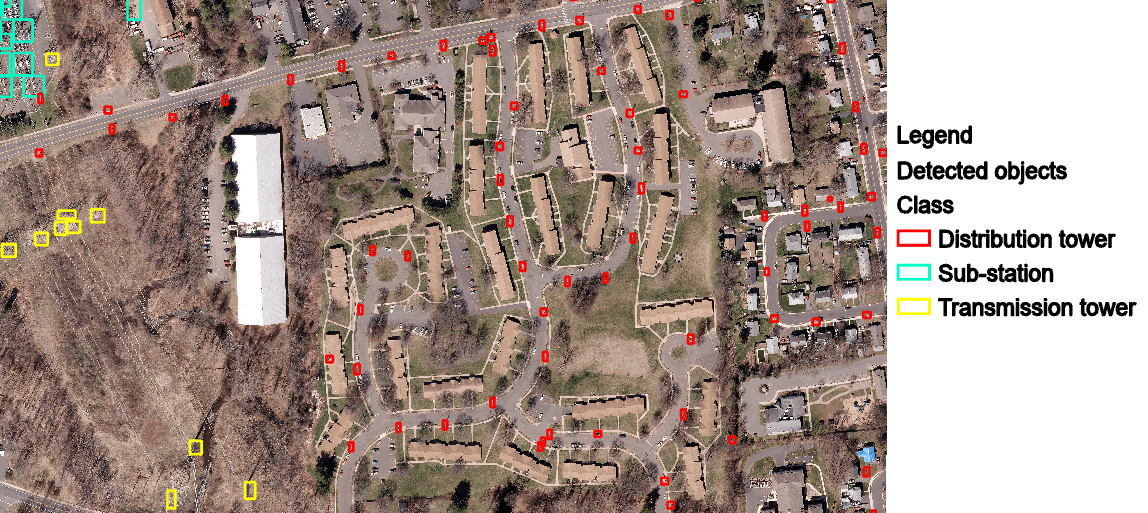

<center> Detected electric utility feature layer</center>

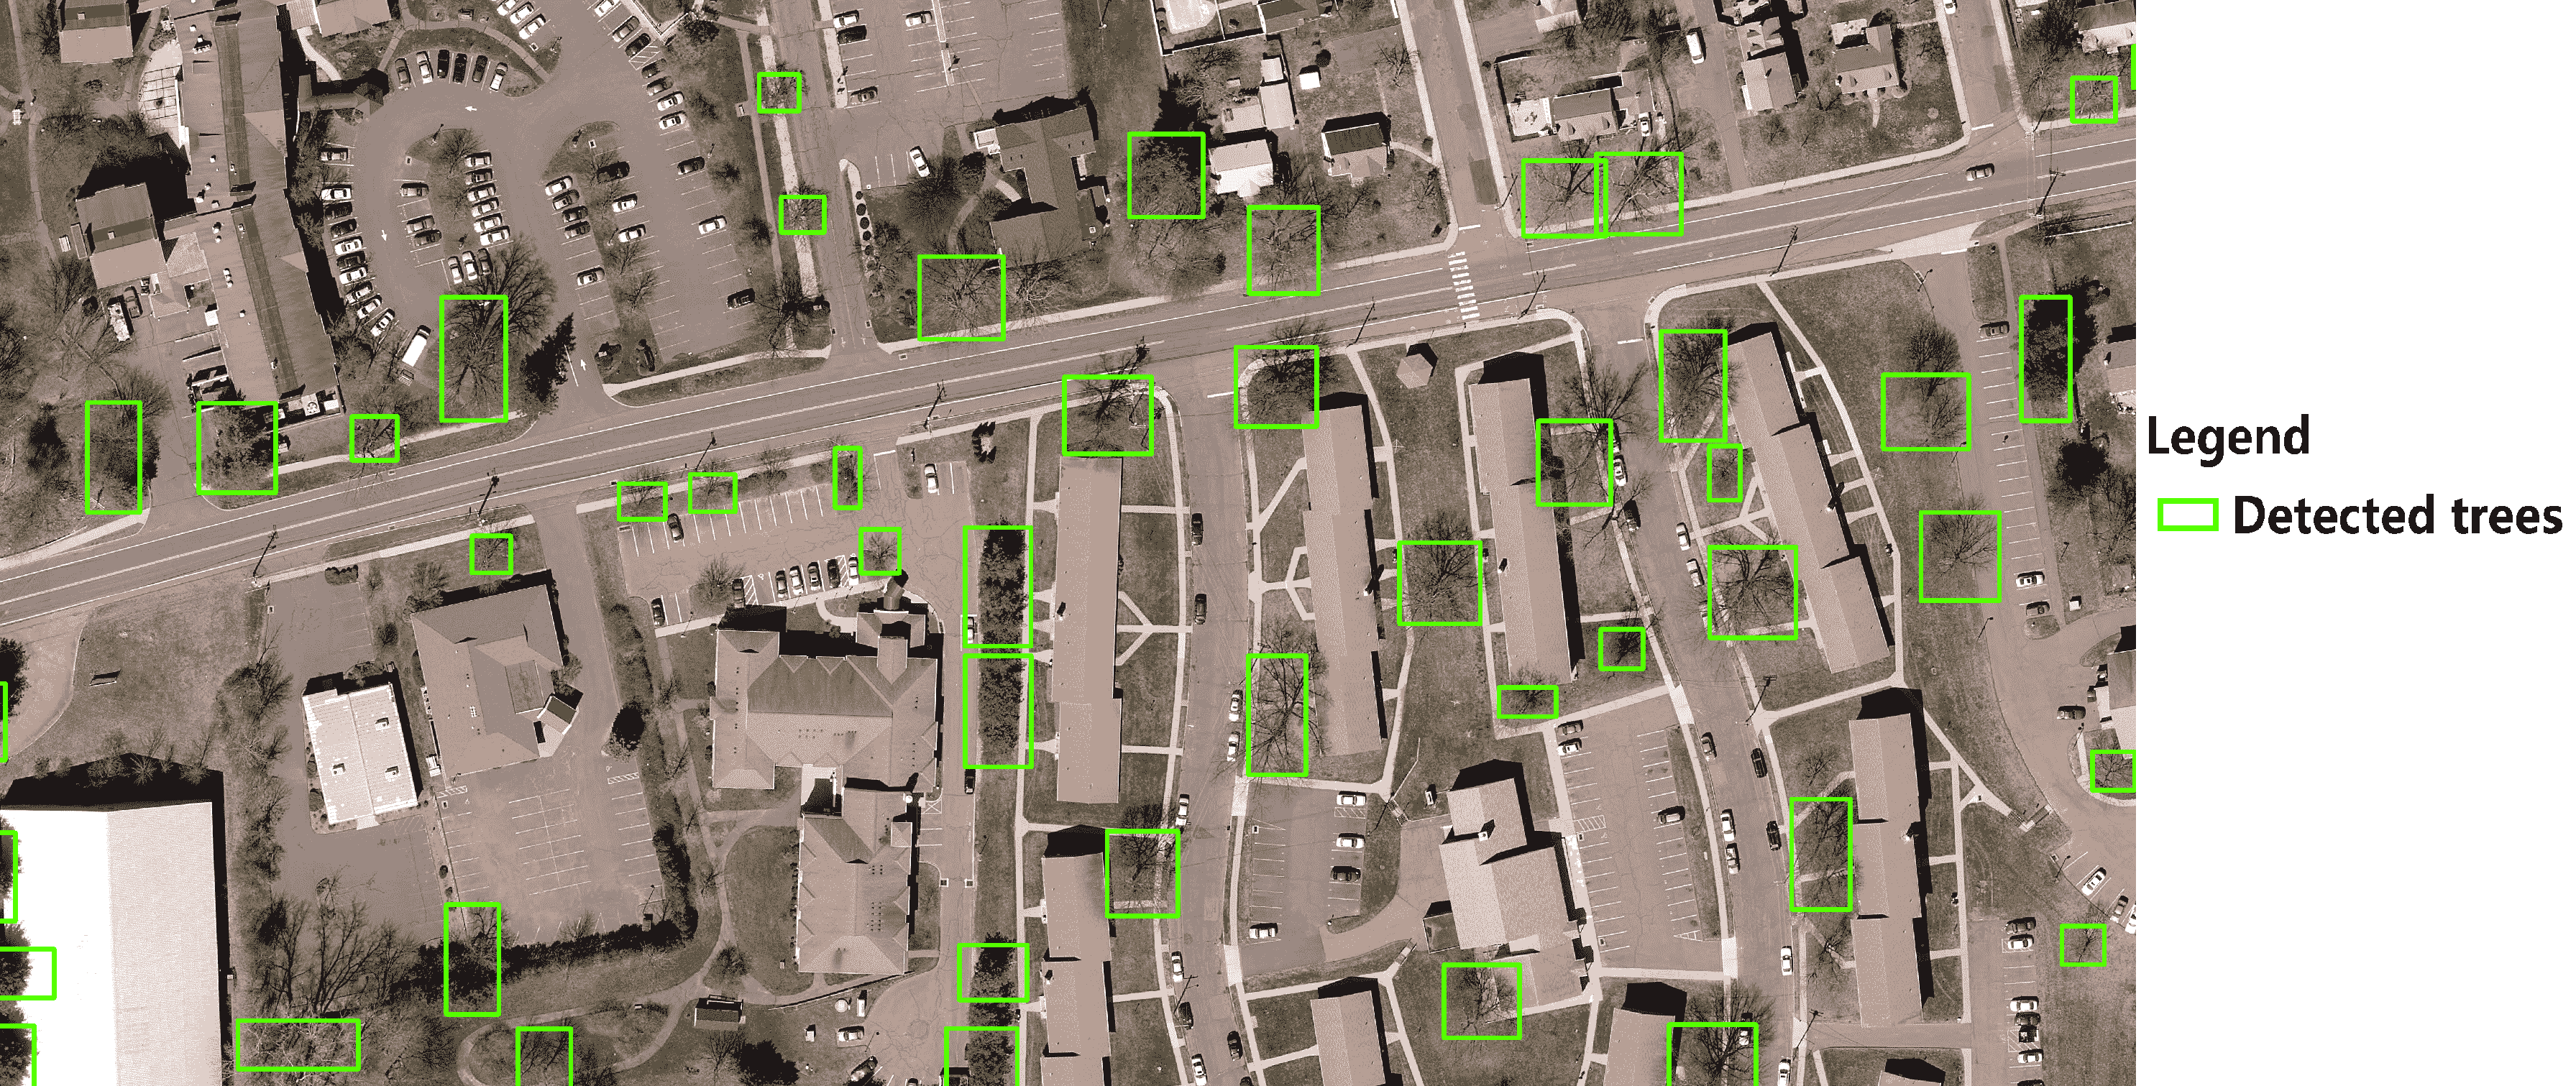

<center> Detected trees feature layer </center>

## Part 4 - Near analysis to find possible vegetation encroachment near electric utility features
After model inference on imagery, detected objects i.e. Electric utility and trees, in the imagery are saved in as separate feature layers. The near analysis tool in ArcGIS Pro is used to calculate distance and additional proximity information between the input features (electric utility) and the closest feature in another layer or feature class (Trees).

- `Input Features` : feature layer from detect object tool for electric utility
- `Near Features` : feature layer from detect object tool for trees
- `Search radius` : required distance or range of search
- `Location` : check location parameter checkbox

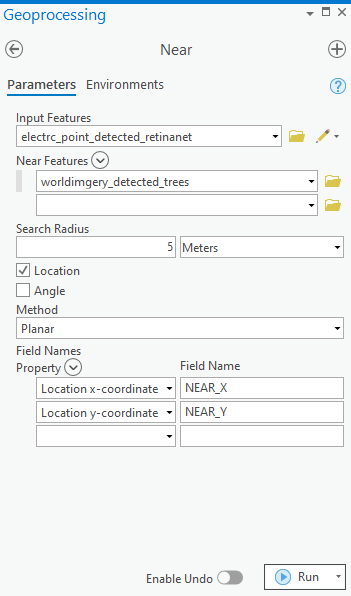

Here the tool finds locations where trees are in the vicinity of 5 m near electric utility features for possible vegetation related outages. The input feature will have two more attribute x (near_x) and y co-ordinates (near_y) of the closest location of the near feature.

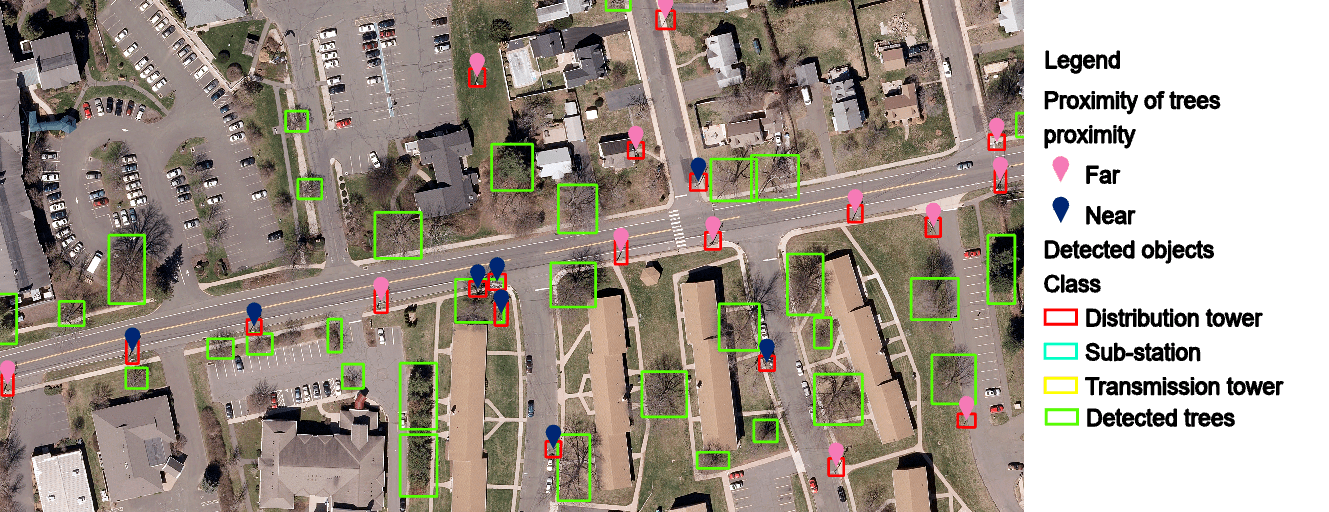

<center> Detected objects i.e electric utility, trees with markers representing proximity of trees to utility installations </center>

The green and red bounding boxes are trees and electric utility respectively. The red anchor show the electric utility object in range of 5m of tree and possible location of vegetation related outage, while yellow show at safe distance.
We have published the outputs from this sample as a hosted feature layer.

## Conclusion


The models available with `arcgis.learn` were able to detect and map the electric utility features at scale in the imagery. Further training the models with larger and better data can improve the results at a scale of country. 

The overlay of information from this workflow can assist electric utility industry in cost-effective and efficient management of the electric grid. Data science can help us derive insight from data, but communicating those insights is perhaps as important if not more. We used the ArcGIS Pro to publish the results as a hosted feature layer, which could be viewed as a web-map.

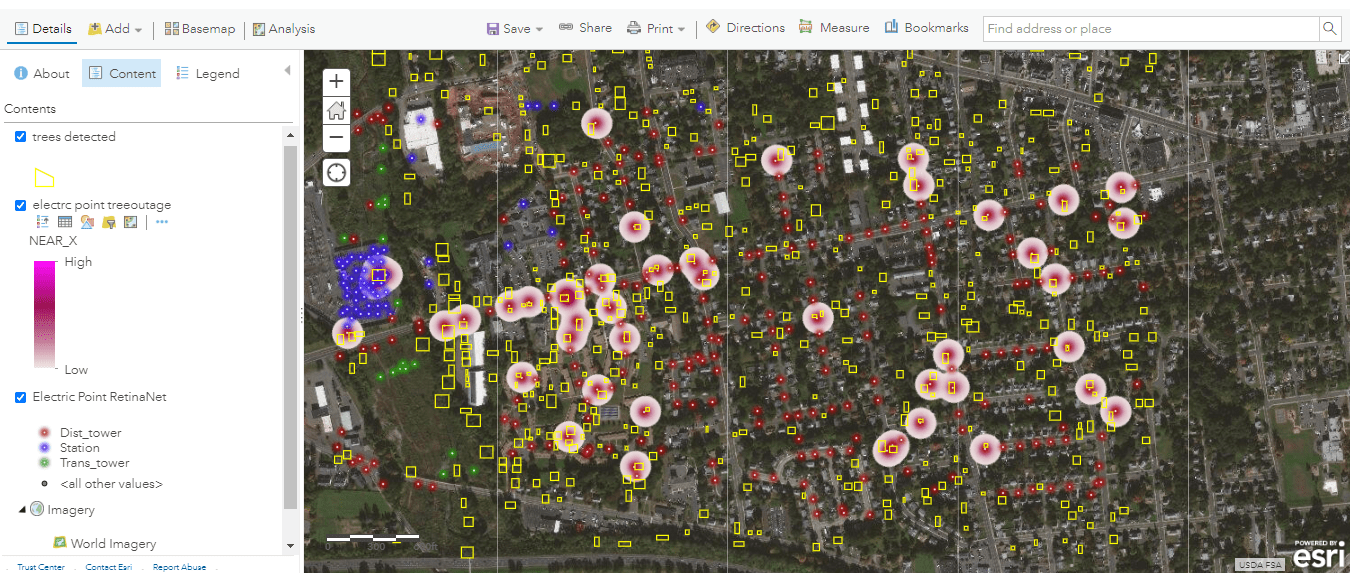

<center> Web-map of detected objects with encroachment grid locations </center>

## References
    
[1] Tsung-Yi Lin, Piotr Dollár, Ross Girshick, Kaiming He, Bharath Hariharan: “Feature Pyramid Networks for Object Detection”, 2016; [http://arxiv.org/abs/1612.03144 arXiv:1612.03144].

[2] Tsung-Yi Lin, Priya Goyal, Ross Girshick, Kaiming He: “Focal Loss for Dense Object Detection”, 2017; [http://arxiv.org/abs/1708.02002 arXiv:1708.02002].